In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [11]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [12]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [13]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [14]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_ground_ball(bb_type):
        return 1 if bb_type == "ground_ball" else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)


    df['gb'] = df['bb_type'].apply(is_ground_ball)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [15]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [16]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [17]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [18]:
train_data = training_features.drop(['gb'], axis=1).copy()
train_label = training_features['gb'].copy()
testing_data = testing_features.drop(['gb'], axis=1).copy()
testing_label = testing_features['gb'].copy()

In [19]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [20]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [21]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [22]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [23]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6135147672800371
Log Loss: 0.6506805810207524


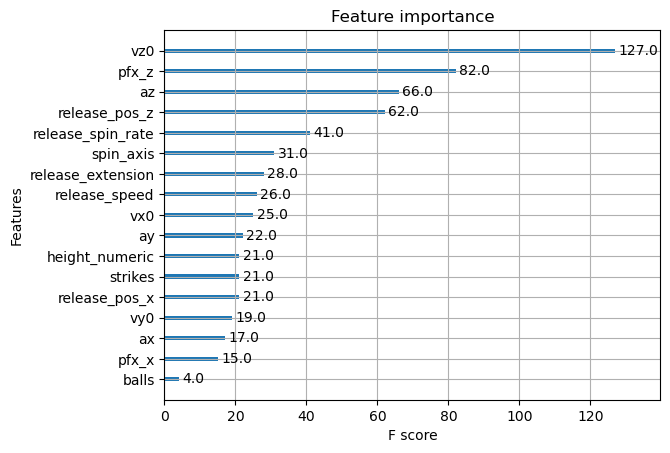

In [24]:
xgb.plot_importance(model)
plt.show()

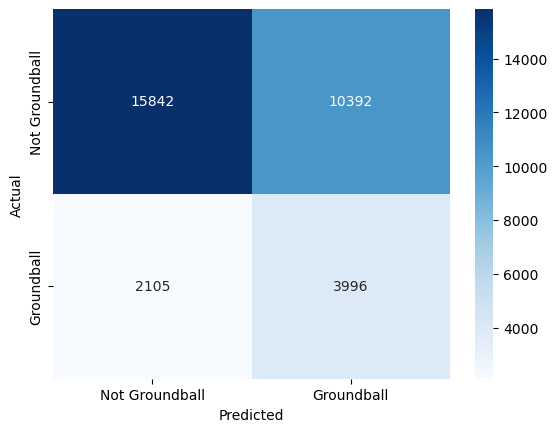

In [25]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [26]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [27]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 16:47:15,045] A new study created in memory with name: no-name-986686a8-b81a-4efb-943f-84e404a3bcd8


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68012
[2]	eval-logloss:0.67489
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66649
[5]	eval-logloss:0.66310
[6]	eval-logloss:0.65982
[7]	eval-logloss:0.65703
[8]	eval-logloss:0.65465
[9]	eval-logloss:0.65254
[10]	eval-logloss:0.65061
[11]	eval-logloss:0.64902
[12]	eval-logloss:0.64744
[13]	eval-logloss:0.64613
[14]	eval-logloss:0.64483
[15]	eval-logloss:0.64404
[16]	eval-logloss:0.64306
[17]	eval-logloss:0.64214
[18]	eval-logloss:0.64143
[19]	eval-logloss:0.64052
[20]	eval-logloss:0.63976
[21]	eval-logloss:0.63926
[22]	eval-logloss:0.63847
[23]	eval-logloss:0.63801
[24]	eval-logloss:0.63751
[25]	eval-logloss:0.63711
[26]	eval-logloss:0.63662
[27]	eval-logloss:0.63613
[28]	eval-logloss:0.63574
[29]	eval-logloss:0.63533
[30]	eval-logloss:0.63516
[31]	eval-logloss:0.63497
[32]	eval-logloss:0.63471
[33]	eval-logloss:0.63448
[34]	eval-logloss:0.63431
[35]	eval-logloss:0.63406
[36]	eval-logloss:0.63378
[37]	eval-logloss:0.63346
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:17,458] Trial 0 finished with value: 0.6252504288061634 and parameters: {'max_depth': 6, 'eta': 0.07406250808055491, 'subsample': 0.7475803471609797, 'colsample_bytree': 0.8204104019436322}. Best is trial 0 with value: 0.6252504288061634.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.64899
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.63746
[6]	eval-logloss:0.63297
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62900
[9]	eval-logloss:0.62745
[10]	eval-logloss:0.62442
[11]	eval-logloss:0.62196
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61849
[14]	eval-logloss:0.61704
[15]	eval-logloss:0.61605
[16]	eval-logloss:0.61481
[17]	eval-logloss:0.61285
[18]	eval-logloss:0.61146
[19]	eval-logloss:0.61032
[20]	eval-logloss:0.60958
[21]	eval-logloss:0.60911
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60760
[24]	eval-logloss:0.60653
[25]	eval-logloss:0.60643
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60494
[28]	eval-logloss:0.60405
[29]	eval-logloss:0.60355
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60199
[33]	eval-logloss:0.60197
[34]	eval-logloss:0.60161
[35]	eval-logloss:0.60109
[36]	eval-logloss:0.60049
[37]	eval-logloss:0.59995
[38]	eval-logloss:0.59

[I 2023-11-09 16:47:20,586] Trial 1 finished with value: 0.5739066459808708 and parameters: {'max_depth': 9, 'eta': 0.21345550938263744, 'subsample': 0.8697764307208391, 'colsample_bytree': 0.5237390139394584}. Best is trial 0 with value: 0.6252504288061634.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.65768
[4]	eval-logloss:0.65434
[5]	eval-logloss:0.65046
[6]	eval-logloss:0.64756
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.64300
[10]	eval-logloss:0.64165
[11]	eval-logloss:0.64053
[12]	eval-logloss:0.63936
[13]	eval-logloss:0.63845
[14]	eval-logloss:0.63770
[15]	eval-logloss:0.63763
[16]	eval-logloss:0.63743
[17]	eval-logloss:0.63690
[18]	eval-logloss:0.63648
[19]	eval-logloss:0.63596
[20]	eval-logloss:0.63539
[21]	eval-logloss:0.63533
[22]	eval-logloss:0.63494
[23]	eval-logloss:0.63493
[24]	eval-logloss:0.63460
[25]	eval-logloss:0.63427
[26]	eval-logloss:0.63382
[27]	eval-logloss:0.63349
[28]	eval-logloss:0.63333
[29]	eval-logloss:0.63303
[30]	eval-logloss:0.63316
[31]	eval-logloss:0.63314
[32]	eval-logloss:0.63280
[33]	eval-logloss:0.63300
[34]	eval-logloss:0.63292
[35]	eval-logloss:0.63253
[36]	eval-logloss:0.63212
[37]	eval-logloss:0.63209
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:22,660] Trial 2 finished with value: 0.6252963002826943 and parameters: {'max_depth': 5, 'eta': 0.17170768121230895, 'subsample': 0.84020572276687, 'colsample_bytree': 0.6990863124620073}. Best is trial 2 with value: 0.6252963002826943.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65582
[4]	eval-logloss:0.65243
[5]	eval-logloss:0.64791
[6]	eval-logloss:0.64538
[7]	eval-logloss:0.64471
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.64395
[10]	eval-logloss:0.64177
[11]	eval-logloss:0.64078
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.63900
[14]	eval-logloss:0.63831
[15]	eval-logloss:0.63860
[16]	eval-logloss:0.63822
[17]	eval-logloss:0.63765
[18]	eval-logloss:0.63734
[19]	eval-logloss:0.63675
[20]	eval-logloss:0.63605
[21]	eval-logloss:0.63629
[22]	eval-logloss:0.63572
[23]	eval-logloss:0.63624
[24]	eval-logloss:0.63581
[25]	eval-logloss:0.63594
[26]	eval-logloss:0.63512
[27]	eval-logloss:0.63462
[28]	eval-logloss:0.63452
[29]	eval-logloss:0.63428
[30]	eval-logloss:0.63488
[31]	eval-logloss:0.63493
[32]	eval-logloss:0.63469
[33]	eval-logloss:0.63507
[34]	eval-logloss:0.63513
[35]	eval-logloss:0.63450
[36]	eval-logloss:0.63402
[37]	eval-logloss:0.63387
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:24,441] Trial 3 finished with value: 0.6285827594799573 and parameters: {'max_depth': 4, 'eta': 0.2945056435709688, 'subsample': 0.8355053119611312, 'colsample_bytree': 0.5404817040841823}. Best is trial 3 with value: 0.6285827594799573.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67809
[5]	eval-logloss:0.67505
[6]	eval-logloss:0.67231
[7]	eval-logloss:0.67050
[8]	eval-logloss:0.66963
[9]	eval-logloss:0.66889
[10]	eval-logloss:0.66676
[11]	eval-logloss:0.66507
[12]	eval-logloss:0.66329
[13]	eval-logloss:0.66226
[14]	eval-logloss:0.66166
[15]	eval-logloss:0.66063
[16]	eval-logloss:0.66010
[17]	eval-logloss:0.65881
[18]	eval-logloss:0.65757
[19]	eval-logloss:0.65632
[20]	eval-logloss:0.65555
[21]	eval-logloss:0.65500
[22]	eval-logloss:0.65404
[23]	eval-logloss:0.65362
[24]	eval-logloss:0.65275
[25]	eval-logloss:0.65227
[26]	eval-logloss:0.65156
[27]	eval-logloss:0.65080
[28]	eval-logloss:0.65052
[29]	eval-logloss:0.65012
[30]	eval-logloss:0.65006
[31]	eval-logloss:0.64972
[32]	eval-logloss:0.64914
[33]	eval-logloss:0.64894
[34]	eval-logloss:0.64852
[35]	eval-logloss:0.64826
[36]	eval-logloss:0.64798
[37]	eval-logloss:0.64780
[38]	eval-logloss:0.64

[I 2023-11-09 16:47:26,667] Trial 4 finished with value: 0.6396121189986119 and parameters: {'max_depth': 3, 'eta': 0.06321049194167193, 'subsample': 0.6830647968088464, 'colsample_bytree': 0.56821959645073}. Best is trial 4 with value: 0.6396121189986119.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67100
[2]	eval-logloss:0.66135
[3]	eval-logloss:0.65402
[4]	eval-logloss:0.64954
[5]	eval-logloss:0.64430
[6]	eval-logloss:0.63916
[7]	eval-logloss:0.63665
[8]	eval-logloss:0.63295
[9]	eval-logloss:0.63016
[10]	eval-logloss:0.62766
[11]	eval-logloss:0.62606
[12]	eval-logloss:0.62400
[13]	eval-logloss:0.62297
[14]	eval-logloss:0.62167
[15]	eval-logloss:0.62074
[16]	eval-logloss:0.61991
[17]	eval-logloss:0.61860
[18]	eval-logloss:0.61768
[19]	eval-logloss:0.61654
[20]	eval-logloss:0.61618
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61499
[23]	eval-logloss:0.61472
[24]	eval-logloss:0.61366
[25]	eval-logloss:0.61285
[26]	eval-logloss:0.61200
[27]	eval-logloss:0.61104
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60934
[30]	eval-logloss:0.60977
[31]	eval-logloss:0.60932
[32]	eval-logloss:0.60891
[33]	eval-logloss:0.60891
[34]	eval-logloss:0.60869
[35]	eval-logloss:0.60860
[36]	eval-logloss:0.60779
[37]	eval-logloss:0.60727
[38]	eval-logloss:0.60

[I 2023-11-09 16:47:29,710] Trial 5 finished with value: 0.5863049321291687 and parameters: {'max_depth': 9, 'eta': 0.12660361066476453, 'subsample': 0.689558962146914, 'colsample_bytree': 0.70812290763164}. Best is trial 4 with value: 0.6396121189986119.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68298
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67526
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67216
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.66933
[12]	eval-logloss:0.66805
[13]	eval-logloss:0.66683
[14]	eval-logloss:0.66564
[15]	eval-logloss:0.66465
[16]	eval-logloss:0.66370
[17]	eval-logloss:0.66275
[18]	eval-logloss:0.66184
[19]	eval-logloss:0.66093
[20]	eval-logloss:0.66003
[21]	eval-logloss:0.65930
[22]	eval-logloss:0.65858
[23]	eval-logloss:0.65800
[24]	eval-logloss:0.65734
[25]	eval-logloss:0.65677
[26]	eval-logloss:0.65609
[27]	eval-logloss:0.65552
[28]	eval-logloss:0.65501
[29]	eval-logloss:0.65446
[30]	eval-logloss:0.65406
[31]	eval-logloss:0.65369
[32]	eval-logloss:0.65325
[33]	eval-logloss:0.65297
[34]	eval-logloss:0.65261
[35]	eval-logloss:0.65219
[36]	eval-logloss:0.65176
[37]	eval-logloss:0.65142
[38]	eval-logloss:0.65

[I 2023-11-09 16:47:31,621] Trial 6 finished with value: 0.6422168379630324 and parameters: {'max_depth': 3, 'eta': 0.038671621920174544, 'subsample': 0.8136411964369272, 'colsample_bytree': 0.9133423561404741}. Best is trial 6 with value: 0.6422168379630324.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64989
[4]	eval-logloss:0.64612
[5]	eval-logloss:0.64456
[6]	eval-logloss:0.64257
[7]	eval-logloss:0.64185
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.64038
[10]	eval-logloss:0.63969
[11]	eval-logloss:0.63977
[12]	eval-logloss:0.63931
[13]	eval-logloss:0.63934
[14]	eval-logloss:0.63895
[15]	eval-logloss:0.63802
[16]	eval-logloss:0.63781
[17]	eval-logloss:0.63715
[18]	eval-logloss:0.63726
[19]	eval-logloss:0.63639
[20]	eval-logloss:0.63599
[21]	eval-logloss:0.63609
[22]	eval-logloss:0.63605
[23]	eval-logloss:0.63615
[24]	eval-logloss:0.63522
[25]	eval-logloss:0.63505
[26]	eval-logloss:0.63476
[27]	eval-logloss:0.63414
[28]	eval-logloss:0.63329
[29]	eval-logloss:0.63278
[30]	eval-logloss:0.63397
[31]	eval-logloss:0.63404
[32]	eval-logloss:0.63379
[33]	eval-logloss:0.63402
[34]	eval-logloss:0.63434
[35]	eval-logloss:0.63368
[36]	eval-logloss:0.63346
[37]	eval-logloss:0.63364
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:33,791] Trial 7 finished with value: 0.6315650828007348 and parameters: {'max_depth': 4, 'eta': 0.2856241456110412, 'subsample': 0.6147125501811366, 'colsample_bytree': 0.9911273188361295}. Best is trial 6 with value: 0.6422168379630324.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66163
[3]	eval-logloss:0.65614
[4]	eval-logloss:0.65071
[5]	eval-logloss:0.64680
[6]	eval-logloss:0.64353
[7]	eval-logloss:0.64110
[8]	eval-logloss:0.63922
[9]	eval-logloss:0.63775
[10]	eval-logloss:0.63607
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63387
[13]	eval-logloss:0.63318
[14]	eval-logloss:0.63236
[15]	eval-logloss:0.63163
[16]	eval-logloss:0.63105
[17]	eval-logloss:0.63017
[18]	eval-logloss:0.62993
[19]	eval-logloss:0.62888
[20]	eval-logloss:0.62835
[21]	eval-logloss:0.62802
[22]	eval-logloss:0.62741
[23]	eval-logloss:0.62724
[24]	eval-logloss:0.62661
[25]	eval-logloss:0.62627
[26]	eval-logloss:0.62590
[27]	eval-logloss:0.62538
[28]	eval-logloss:0.62493
[29]	eval-logloss:0.62465
[30]	eval-logloss:0.62488
[31]	eval-logloss:0.62473
[32]	eval-logloss:0.62460
[33]	eval-logloss:0.62449
[34]	eval-logloss:0.62449
[35]	eval-logloss:0.62423
[36]	eval-logloss:0.62381
[37]	eval-logloss:0.62351
[38]	eval-logloss:0.62

[I 2023-11-09 16:47:36,582] Trial 8 finished with value: 0.6092165049542531 and parameters: {'max_depth': 7, 'eta': 0.13621172503234996, 'subsample': 0.704608302533529, 'colsample_bytree': 0.9007383886285438}. Best is trial 6 with value: 0.6422168379630324.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.64843
[3]	eval-logloss:0.64329
[4]	eval-logloss:0.63909
[5]	eval-logloss:0.63667
[6]	eval-logloss:0.63459
[7]	eval-logloss:0.63343
[8]	eval-logloss:0.63262
[9]	eval-logloss:0.63213
[10]	eval-logloss:0.63066
[11]	eval-logloss:0.63010
[12]	eval-logloss:0.62947
[13]	eval-logloss:0.62925
[14]	eval-logloss:0.62925
[15]	eval-logloss:0.62841
[16]	eval-logloss:0.62854
[17]	eval-logloss:0.62777
[18]	eval-logloss:0.62754
[19]	eval-logloss:0.62640
[20]	eval-logloss:0.62568
[21]	eval-logloss:0.62553
[22]	eval-logloss:0.62467
[23]	eval-logloss:0.62425
[24]	eval-logloss:0.62390
[25]	eval-logloss:0.62357
[26]	eval-logloss:0.62320
[27]	eval-logloss:0.62250
[28]	eval-logloss:0.62219
[29]	eval-logloss:0.62190
[30]	eval-logloss:0.62284
[31]	eval-logloss:0.62303
[32]	eval-logloss:0.62257
[33]	eval-logloss:0.62245
[34]	eval-logloss:0.62240
[35]	eval-logloss:0.62209
[36]	eval-logloss:0.62113
[37]	eval-logloss:0.62092
[38]	eval-logloss:0.62

[I 2023-11-09 16:47:38,942] Trial 9 finished with value: 0.6059211618163004 and parameters: {'max_depth': 7, 'eta': 0.24547879352717888, 'subsample': 0.719793483829279, 'colsample_bytree': 0.9069761080749198}. Best is trial 6 with value: 0.6422168379630324.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68580
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68322
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67872
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67569
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67390
[16]	eval-logloss:0.67307
[17]	eval-logloss:0.67222
[18]	eval-logloss:0.67139
[19]	eval-logloss:0.67057
[20]	eval-logloss:0.66976
[21]	eval-logloss:0.66906
[22]	eval-logloss:0.66833
[23]	eval-logloss:0.66769
[24]	eval-logloss:0.66699
[25]	eval-logloss:0.66634
[26]	eval-logloss:0.66565
[27]	eval-logloss:0.66499
[28]	eval-logloss:0.66441
[29]	eval-logloss:0.66382
[30]	eval-logloss:0.66333
[31]	eval-logloss:0.66286
[32]	eval-logloss:0.66236
[33]	eval-logloss:0.66196
[34]	eval-logloss:0.66150
[35]	eval-logloss:0.66103
[36]	eval-logloss:0.66055
[37]	eval-logloss:0.66013
[38]	eval-logloss:0.65

[I 2023-11-09 16:47:40,901] Trial 10 finished with value: 0.6470337155987461 and parameters: {'max_depth': 3, 'eta': 0.021604136755533056, 'subsample': 0.8060929448403734, 'colsample_bytree': 0.9941615586752218}. Best is trial 10 with value: 0.6470337155987461.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68538
[5]	eval-logloss:0.68400
[6]	eval-logloss:0.68266
[7]	eval-logloss:0.68145
[8]	eval-logloss:0.68026
[9]	eval-logloss:0.67911
[10]	eval-logloss:0.67799
[11]	eval-logloss:0.67695
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67487
[14]	eval-logloss:0.67391
[15]	eval-logloss:0.67302
[16]	eval-logloss:0.67218
[17]	eval-logloss:0.67130
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.66963
[20]	eval-logloss:0.66881
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66734
[23]	eval-logloss:0.66668
[24]	eval-logloss:0.66598
[25]	eval-logloss:0.66533
[26]	eval-logloss:0.66462
[27]	eval-logloss:0.66398
[28]	eval-logloss:0.66345
[29]	eval-logloss:0.66284
[30]	eval-logloss:0.66236
[31]	eval-logloss:0.66190
[32]	eval-logloss:0.66139
[33]	eval-logloss:0.66102
[34]	eval-logloss:0.66054
[35]	eval-logloss:0.66007
[36]	eval-logloss:0.65960
[37]	eval-logloss:0.65916
[38]	eval-logloss:0.65

[I 2023-11-09 16:47:42,614] Trial 11 finished with value: 0.6464852703109322 and parameters: {'max_depth': 3, 'eta': 0.02300147585275233, 'subsample': 0.8011300268164703, 'colsample_bytree': 0.9990661659556436}. Best is trial 10 with value: 0.6470337155987461.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68335
[11]	eval-logloss:0.68261
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.67970
[16]	eval-logloss:0.67905
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67774
[19]	eval-logloss:0.67707
[20]	eval-logloss:0.67642
[21]	eval-logloss:0.67582
[22]	eval-logloss:0.67522
[23]	eval-logloss:0.67467
[24]	eval-logloss:0.67409
[25]	eval-logloss:0.67355
[26]	eval-logloss:0.67297
[27]	eval-logloss:0.67240
[28]	eval-logloss:0.67188
[29]	eval-logloss:0.67137
[30]	eval-logloss:0.67092
[31]	eval-logloss:0.67045
[32]	eval-logloss:0.66997
[33]	eval-logloss:0.66954
[34]	eval-logloss:0.66907
[35]	eval-logloss:0.66861
[36]	eval-logloss:0.66816
[37]	eval-logloss:0.66774
[38]	eval-logloss:0.66

[I 2023-11-09 16:47:44,516] Trial 12 finished with value: 0.6526039009235155 and parameters: {'max_depth': 3, 'eta': 0.013682274208134728, 'subsample': 0.7867200769096397, 'colsample_bytree': 0.9980405433355266}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68624
[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68101
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67900
[18]	eval-logloss:0.67836
[19]	eval-logloss:0.67769
[20]	eval-logloss:0.67704
[21]	eval-logloss:0.67642
[22]	eval-logloss:0.67580
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67461
[25]	eval-logloss:0.67404
[26]	eval-logloss:0.67345
[27]	eval-logloss:0.67287
[28]	eval-logloss:0.67232
[29]	eval-logloss:0.67176
[30]	eval-logloss:0.67126
[31]	eval-logloss:0.67075
[32]	eval-logloss:0.67024
[33]	eval-logloss:0.66977
[34]	eval-logloss:0.66930
[35]	eval-logloss:0.66879
[36]	eval-logloss:0.66833
[37]	eval-logloss:0.66785
[38]	eval-logloss:0.66

[I 2023-11-09 16:47:46,489] Trial 13 finished with value: 0.6500237799764226 and parameters: {'max_depth': 5, 'eta': 0.010112131300295611, 'subsample': 0.782204066598854, 'colsample_bytree': 0.9784569042708445}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68741
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68234
[10]	eval-logloss:0.68139
[11]	eval-logloss:0.68052
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67869
[14]	eval-logloss:0.67783
[15]	eval-logloss:0.67717
[16]	eval-logloss:0.67639
[17]	eval-logloss:0.67561
[18]	eval-logloss:0.67485
[19]	eval-logloss:0.67405
[20]	eval-logloss:0.67327
[21]	eval-logloss:0.67269
[22]	eval-logloss:0.67195
[23]	eval-logloss:0.67127
[24]	eval-logloss:0.67058
[25]	eval-logloss:0.67006
[26]	eval-logloss:0.66937
[27]	eval-logloss:0.66870
[28]	eval-logloss:0.66821
[29]	eval-logloss:0.66757
[30]	eval-logloss:0.66717
[31]	eval-logloss:0.66659
[32]	eval-logloss:0.66600
[33]	eval-logloss:0.66548
[34]	eval-logloss:0.66493
[35]	eval-logloss:0.66438
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66345
[38]	eval-logloss:0.66

[I 2023-11-09 16:47:48,282] Trial 14 finished with value: 0.6462369845356073 and parameters: {'max_depth': 5, 'eta': 0.013322272507172633, 'subsample': 0.7653327845853435, 'colsample_bytree': 0.826552717746347}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.68052
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67144
[4]	eval-logloss:0.66742
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.66115
[7]	eval-logloss:0.65864
[8]	eval-logloss:0.65645
[9]	eval-logloss:0.65453
[10]	eval-logloss:0.65280
[11]	eval-logloss:0.65140
[12]	eval-logloss:0.64986
[13]	eval-logloss:0.64864
[14]	eval-logloss:0.64751
[15]	eval-logloss:0.64654
[16]	eval-logloss:0.64572
[17]	eval-logloss:0.64487
[18]	eval-logloss:0.64429
[19]	eval-logloss:0.64332
[20]	eval-logloss:0.64258
[21]	eval-logloss:0.64205
[22]	eval-logloss:0.64148
[23]	eval-logloss:0.64116
[24]	eval-logloss:0.64075
[25]	eval-logloss:0.64035
[26]	eval-logloss:0.63987
[27]	eval-logloss:0.63935
[28]	eval-logloss:0.63901
[29]	eval-logloss:0.63857
[30]	eval-logloss:0.63845
[31]	eval-logloss:0.63825
[32]	eval-logloss:0.63803
[33]	eval-logloss:0.63793
[34]	eval-logloss:0.63773
[35]	eval-logloss:0.63747
[36]	eval-logloss:0.63718
[37]	eval-logloss:0.63681
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:50,446] Trial 15 finished with value: 0.6304225072883213 and parameters: {'max_depth': 5, 'eta': 0.07685739091145705, 'subsample': 0.7695653943639621, 'colsample_bytree': 0.9320228376803787}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67781
[2]	eval-logloss:0.67238
[3]	eval-logloss:0.66781
[4]	eval-logloss:0.66378
[5]	eval-logloss:0.66053
[6]	eval-logloss:0.65769
[7]	eval-logloss:0.65554
[8]	eval-logloss:0.65361
[9]	eval-logloss:0.65189
[10]	eval-logloss:0.65018
[11]	eval-logloss:0.64905
[12]	eval-logloss:0.64782
[13]	eval-logloss:0.64684
[14]	eval-logloss:0.64591
[15]	eval-logloss:0.64539
[16]	eval-logloss:0.64480
[17]	eval-logloss:0.64412
[18]	eval-logloss:0.64366
[19]	eval-logloss:0.64317
[20]	eval-logloss:0.64256
[21]	eval-logloss:0.64224
[22]	eval-logloss:0.64176
[23]	eval-logloss:0.64151
[24]	eval-logloss:0.64111
[25]	eval-logloss:0.64086
[26]	eval-logloss:0.64052
[27]	eval-logloss:0.64034
[28]	eval-logloss:0.64015
[29]	eval-logloss:0.63988
[30]	eval-logloss:0.63998
[31]	eval-logloss:0.63980
[32]	eval-logloss:0.63941
[33]	eval-logloss:0.63924
[34]	eval-logloss:0.63921
[35]	eval-logloss:0.63894
[36]	eval-logloss:0.63870
[37]	eval-logloss:0.63845
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:52,313] Trial 16 finished with value: 0.6326630658865267 and parameters: {'max_depth': 4, 'eta': 0.10646050651454768, 'subsample': 0.879923117712661, 'colsample_bytree': 0.8246487463436285}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67352
[5]	eval-logloss:0.67062
[6]	eval-logloss:0.66795
[7]	eval-logloss:0.66553
[8]	eval-logloss:0.66330
[9]	eval-logloss:0.66128
[10]	eval-logloss:0.65938
[11]	eval-logloss:0.65765
[12]	eval-logloss:0.65602
[13]	eval-logloss:0.65453
[14]	eval-logloss:0.65320
[15]	eval-logloss:0.65200
[16]	eval-logloss:0.65085
[17]	eval-logloss:0.64978
[18]	eval-logloss:0.64878
[19]	eval-logloss:0.64776
[20]	eval-logloss:0.64686
[21]	eval-logloss:0.64598
[22]	eval-logloss:0.64519
[23]	eval-logloss:0.64440
[24]	eval-logloss:0.64372
[25]	eval-logloss:0.64307
[26]	eval-logloss:0.64246
[27]	eval-logloss:0.64188
[28]	eval-logloss:0.64130
[29]	eval-logloss:0.64080
[30]	eval-logloss:0.64044
[31]	eval-logloss:0.64006
[32]	eval-logloss:0.63963
[33]	eval-logloss:0.63923
[34]	eval-logloss:0.63890
[35]	eval-logloss:0.63850
[36]	eval-logloss:0.63810
[37]	eval-logloss:0.63777
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:54,481] Trial 17 finished with value: 0.6282092289614252 and parameters: {'max_depth': 6, 'eta': 0.04951710826660931, 'subsample': 0.8993008695525894, 'colsample_bytree': 0.9470434312237892}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66971
[3]	eval-logloss:0.66459
[4]	eval-logloss:0.65968
[5]	eval-logloss:0.65568
[6]	eval-logloss:0.65221
[7]	eval-logloss:0.64945
[8]	eval-logloss:0.64700
[9]	eval-logloss:0.64495
[10]	eval-logloss:0.64313
[11]	eval-logloss:0.64165
[12]	eval-logloss:0.64005
[13]	eval-logloss:0.63881
[14]	eval-logloss:0.63766
[15]	eval-logloss:0.63660
[16]	eval-logloss:0.63565
[17]	eval-logloss:0.63459
[18]	eval-logloss:0.63382
[19]	eval-logloss:0.63304
[20]	eval-logloss:0.63222
[21]	eval-logloss:0.63179
[22]	eval-logloss:0.63124
[23]	eval-logloss:0.63088
[24]	eval-logloss:0.63037
[25]	eval-logloss:0.63003
[26]	eval-logloss:0.62951
[27]	eval-logloss:0.62897
[28]	eval-logloss:0.62863
[29]	eval-logloss:0.62824
[30]	eval-logloss:0.62812
[31]	eval-logloss:0.62788
[32]	eval-logloss:0.62741
[33]	eval-logloss:0.62743
[34]	eval-logloss:0.62711
[35]	eval-logloss:0.62688
[36]	eval-logloss:0.62651
[37]	eval-logloss:0.62617
[38]	eval-logloss:0.62

[I 2023-11-09 16:47:56,721] Trial 18 finished with value: 0.6151359024191432 and parameters: {'max_depth': 7, 'eta': 0.09452633157335236, 'subsample': 0.7875969143355123, 'colsample_bytree': 0.8741825105384694}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67521
[4]	eval-logloss:0.67136
[5]	eval-logloss:0.66800
[6]	eval-logloss:0.66485
[7]	eval-logloss:0.66195
[8]	eval-logloss:0.65928
[9]	eval-logloss:0.65685
[10]	eval-logloss:0.65453
[11]	eval-logloss:0.65257
[12]	eval-logloss:0.65063
[13]	eval-logloss:0.64881
[14]	eval-logloss:0.64711
[15]	eval-logloss:0.64551
[16]	eval-logloss:0.64413
[17]	eval-logloss:0.64268
[18]	eval-logloss:0.64155
[19]	eval-logloss:0.64016
[20]	eval-logloss:0.63890
[21]	eval-logloss:0.63782
[22]	eval-logloss:0.63673
[23]	eval-logloss:0.63575
[24]	eval-logloss:0.63488
[25]	eval-logloss:0.63399
[26]	eval-logloss:0.63322
[27]	eval-logloss:0.63237
[28]	eval-logloss:0.63159
[29]	eval-logloss:0.63087
[30]	eval-logloss:0.63031
[31]	eval-logloss:0.62966
[32]	eval-logloss:0.62906
[33]	eval-logloss:0.62855
[34]	eval-logloss:0.62807
[35]	eval-logloss:0.62745
[36]	eval-logloss:0.62693
[37]	eval-logloss:0.62642
[38]	eval-logloss:0.62

[I 2023-11-09 16:47:59,296] Trial 19 finished with value: 0.6118328634120813 and parameters: {'max_depth': 8, 'eta': 0.046834280201340193, 'subsample': 0.7487145444837039, 'colsample_bytree': 0.9559444723548678}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67437
[3]	eval-logloss:0.67021
[4]	eval-logloss:0.66627
[5]	eval-logloss:0.66308
[6]	eval-logloss:0.66022
[7]	eval-logloss:0.65795
[8]	eval-logloss:0.65598
[9]	eval-logloss:0.65430
[10]	eval-logloss:0.65264
[11]	eval-logloss:0.65126
[12]	eval-logloss:0.64996
[13]	eval-logloss:0.64885
[14]	eval-logloss:0.64772
[15]	eval-logloss:0.64707
[16]	eval-logloss:0.64641
[17]	eval-logloss:0.64572
[18]	eval-logloss:0.64505
[19]	eval-logloss:0.64437
[20]	eval-logloss:0.64368
[21]	eval-logloss:0.64332
[22]	eval-logloss:0.64286
[23]	eval-logloss:0.64260
[24]	eval-logloss:0.64225
[25]	eval-logloss:0.64198
[26]	eval-logloss:0.64142
[27]	eval-logloss:0.64108
[28]	eval-logloss:0.64087
[29]	eval-logloss:0.64052
[30]	eval-logloss:0.64037
[31]	eval-logloss:0.64018
[32]	eval-logloss:0.63991
[33]	eval-logloss:0.63991
[34]	eval-logloss:0.63988
[35]	eval-logloss:0.63958
[36]	eval-logloss:0.63916
[37]	eval-logloss:0.63899
[38]	eval-logloss:0.63

[I 2023-11-09 16:48:00,947] Trial 20 finished with value: 0.6330973647971508 and parameters: {'max_depth': 4, 'eta': 0.09188719333988787, 'subsample': 0.8264446009303135, 'colsample_bytree': 0.8768674750945878}. Best is trial 12 with value: 0.6526039009235155.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68450
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67891
[18]	eval-logloss:0.67830
[19]	eval-logloss:0.67765
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67584
[23]	eval-logloss:0.67531
[24]	eval-logloss:0.67475
[25]	eval-logloss:0.67422
[26]	eval-logloss:0.67364
[27]	eval-logloss:0.67308
[28]	eval-logloss:0.67257
[29]	eval-logloss:0.67205
[30]	eval-logloss:0.67159
[31]	eval-logloss:0.67113
[32]	eval-logloss:0.67065
[33]	eval-logloss:0.67023
[34]	eval-logloss:0.66977
[35]	eval-logloss:0.66931
[36]	eval-logloss:0.66887
[37]	eval-logloss:0.66846
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:02,341] Trial 21 finished with value: 0.6532726244351259 and parameters: {'max_depth': 3, 'eta': 0.013016135314489835, 'subsample': 0.7929972626477572, 'colsample_bytree': 0.9959306921854385}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68718
[4]	eval-logloss:0.68577
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68194
[8]	eval-logloss:0.68075
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67850
[11]	eval-logloss:0.67749
[12]	eval-logloss:0.67642
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67440
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67261
[17]	eval-logloss:0.67172
[18]	eval-logloss:0.67088
[19]	eval-logloss:0.67002
[20]	eval-logloss:0.66919
[21]	eval-logloss:0.66844
[22]	eval-logloss:0.66767
[23]	eval-logloss:0.66697
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66556
[26]	eval-logloss:0.66484
[27]	eval-logloss:0.66417
[28]	eval-logloss:0.66356
[29]	eval-logloss:0.66293
[30]	eval-logloss:0.66239
[31]	eval-logloss:0.66184
[32]	eval-logloss:0.66129
[33]	eval-logloss:0.66080
[34]	eval-logloss:0.66027
[35]	eval-logloss:0.65974
[36]	eval-logloss:0.65924
[37]	eval-logloss:0.65876
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:04,063] Trial 22 finished with value: 0.6442510543767391 and parameters: {'max_depth': 4, 'eta': 0.01892455475314233, 'subsample': 0.783971669717365, 'colsample_bytree': 0.9622368049699038}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68104
[13]	eval-logloss:0.68024
[14]	eval-logloss:0.67945
[15]	eval-logloss:0.67868
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67651
[19]	eval-logloss:0.67578
[20]	eval-logloss:0.67506
[21]	eval-logloss:0.67438
[22]	eval-logloss:0.67371
[23]	eval-logloss:0.67308
[24]	eval-logloss:0.67244
[25]	eval-logloss:0.67183
[26]	eval-logloss:0.67119
[27]	eval-logloss:0.67056
[28]	eval-logloss:0.66996
[29]	eval-logloss:0.66937
[30]	eval-logloss:0.66883
[31]	eval-logloss:0.66830
[32]	eval-logloss:0.66775
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66675
[35]	eval-logloss:0.66622
[36]	eval-logloss:0.66574
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:05,997] Trial 23 finished with value: 0.6475531432617061 and parameters: {'max_depth': 5, 'eta': 0.011677961768946973, 'subsample': 0.7896376426870443, 'colsample_bytree': 0.9572149242488407}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68133
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.67457
[7]	eval-logloss:0.67273
[8]	eval-logloss:0.67108
[9]	eval-logloss:0.66952
[10]	eval-logloss:0.66795
[11]	eval-logloss:0.66648
[12]	eval-logloss:0.66520
[13]	eval-logloss:0.66391
[14]	eval-logloss:0.66269
[15]	eval-logloss:0.66171
[16]	eval-logloss:0.66077
[17]	eval-logloss:0.65982
[18]	eval-logloss:0.65890
[19]	eval-logloss:0.65805
[20]	eval-logloss:0.65723
[21]	eval-logloss:0.65661
[22]	eval-logloss:0.65591
[23]	eval-logloss:0.65533
[24]	eval-logloss:0.65467
[25]	eval-logloss:0.65410
[26]	eval-logloss:0.65347
[27]	eval-logloss:0.65298
[28]	eval-logloss:0.65258
[29]	eval-logloss:0.65203
[30]	eval-logloss:0.65165
[31]	eval-logloss:0.65132
[32]	eval-logloss:0.65092
[33]	eval-logloss:0.65063
[34]	eval-logloss:0.65031
[35]	eval-logloss:0.64988
[36]	eval-logloss:0.64948
[37]	eval-logloss:0.64918
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:07,456] Trial 24 finished with value: 0.6409185833789833 and parameters: {'max_depth': 3, 'eta': 0.046204558635918734, 'subsample': 0.8488519751209145, 'colsample_bytree': 0.9982981502118518}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67549
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.66921
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.66435
[8]	eval-logloss:0.66224
[9]	eval-logloss:0.66041
[10]	eval-logloss:0.65870
[11]	eval-logloss:0.65717
[12]	eval-logloss:0.65582
[13]	eval-logloss:0.65455
[14]	eval-logloss:0.65320
[15]	eval-logloss:0.65219
[16]	eval-logloss:0.65130
[17]	eval-logloss:0.65030
[18]	eval-logloss:0.64950
[19]	eval-logloss:0.64866
[20]	eval-logloss:0.64789
[21]	eval-logloss:0.64727
[22]	eval-logloss:0.64670
[23]	eval-logloss:0.64637
[24]	eval-logloss:0.64578
[25]	eval-logloss:0.64535
[26]	eval-logloss:0.64480
[27]	eval-logloss:0.64435
[28]	eval-logloss:0.64389
[29]	eval-logloss:0.64352
[30]	eval-logloss:0.64331
[31]	eval-logloss:0.64310
[32]	eval-logloss:0.64279
[33]	eval-logloss:0.64272
[34]	eval-logloss:0.64249
[35]	eval-logloss:0.64218
[36]	eval-logloss:0.64180
[37]	eval-logloss:0.64156
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:09,036] Trial 25 finished with value: 0.6350570905147916 and parameters: {'max_depth': 4, 'eta': 0.06512818319678146, 'subsample': 0.8216352837295909, 'colsample_bytree': 0.9495437838909854}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67771
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67452
[9]	eval-logloss:0.67306
[10]	eval-logloss:0.67164
[11]	eval-logloss:0.67041
[12]	eval-logloss:0.66912
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66670
[15]	eval-logloss:0.66589
[16]	eval-logloss:0.66494
[17]	eval-logloss:0.66401
[18]	eval-logloss:0.66313
[19]	eval-logloss:0.66219
[20]	eval-logloss:0.66129
[21]	eval-logloss:0.66070
[22]	eval-logloss:0.65993
[23]	eval-logloss:0.65928
[24]	eval-logloss:0.65863
[25]	eval-logloss:0.65813
[26]	eval-logloss:0.65742
[27]	eval-logloss:0.65675
[28]	eval-logloss:0.65635
[29]	eval-logloss:0.65575
[30]	eval-logloss:0.65531
[31]	eval-logloss:0.65486
[32]	eval-logloss:0.65439
[33]	eval-logloss:0.65407
[34]	eval-logloss:0.65363
[35]	eval-logloss:0.65325
[36]	eval-logloss:0.65284
[37]	eval-logloss:0.65245
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:10,646] Trial 26 finished with value: 0.6428216779456603 and parameters: {'max_depth': 3, 'eta': 0.03634121272854467, 'subsample': 0.7659420228537188, 'colsample_bytree': 0.8681400325877244}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67713
[6]	eval-logloss:0.67499
[7]	eval-logloss:0.67303
[8]	eval-logloss:0.67112
[9]	eval-logloss:0.66940
[10]	eval-logloss:0.66775
[11]	eval-logloss:0.66631
[12]	eval-logloss:0.66478
[13]	eval-logloss:0.66333
[14]	eval-logloss:0.66203
[15]	eval-logloss:0.66084
[16]	eval-logloss:0.65974
[17]	eval-logloss:0.65862
[18]	eval-logloss:0.65765
[19]	eval-logloss:0.65664
[20]	eval-logloss:0.65564
[21]	eval-logloss:0.65477
[22]	eval-logloss:0.65391
[23]	eval-logloss:0.65318
[24]	eval-logloss:0.65242
[25]	eval-logloss:0.65173
[26]	eval-logloss:0.65093
[27]	eval-logloss:0.65024
[28]	eval-logloss:0.64962
[29]	eval-logloss:0.64902
[30]	eval-logloss:0.64856
[31]	eval-logloss:0.64809
[32]	eval-logloss:0.64758
[33]	eval-logloss:0.64722
[34]	eval-logloss:0.64678
[35]	eval-logloss:0.64631
[36]	eval-logloss:0.64586
[37]	eval-logloss:0.64545
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:12,493] Trial 27 finished with value: 0.6352675576974893 and parameters: {'max_depth': 5, 'eta': 0.03483433946738886, 'subsample': 0.805581717828171, 'colsample_bytree': 0.9287026898118509}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68697
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68416
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68239
[11]	eval-logloss:0.68156
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.67994
[14]	eval-logloss:0.67912
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67758
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67610
[19]	eval-logloss:0.67535
[20]	eval-logloss:0.67461
[21]	eval-logloss:0.67392
[22]	eval-logloss:0.67322
[23]	eval-logloss:0.67253
[24]	eval-logloss:0.67184
[25]	eval-logloss:0.67119
[26]	eval-logloss:0.67053
[27]	eval-logloss:0.66989
[28]	eval-logloss:0.66926
[29]	eval-logloss:0.66865
[30]	eval-logloss:0.66809
[31]	eval-logloss:0.66753
[32]	eval-logloss:0.66696
[33]	eval-logloss:0.66643
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66535
[36]	eval-logloss:0.66482
[37]	eval-logloss:0.66430
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:14,604] Trial 28 finished with value: 0.6452165420241642 and parameters: {'max_depth': 6, 'eta': 0.011030291842631672, 'subsample': 0.7324019024635873, 'colsample_bytree': 0.9745599196588086}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68797
[1]	eval-logloss:0.68321
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67562
[4]	eval-logloss:0.67215
[5]	eval-logloss:0.66921
[6]	eval-logloss:0.66657
[7]	eval-logloss:0.66420
[8]	eval-logloss:0.66214
[9]	eval-logloss:0.66033
[10]	eval-logloss:0.65858
[11]	eval-logloss:0.65720
[12]	eval-logloss:0.65569
[13]	eval-logloss:0.65445
[14]	eval-logloss:0.65320
[15]	eval-logloss:0.65232
[16]	eval-logloss:0.65150
[17]	eval-logloss:0.65061
[18]	eval-logloss:0.64998
[19]	eval-logloss:0.64908
[20]	eval-logloss:0.64829
[21]	eval-logloss:0.64781
[22]	eval-logloss:0.64712
[23]	eval-logloss:0.64664
[24]	eval-logloss:0.64600
[25]	eval-logloss:0.64554
[26]	eval-logloss:0.64495
[27]	eval-logloss:0.64438
[28]	eval-logloss:0.64413
[29]	eval-logloss:0.64371
[30]	eval-logloss:0.64358
[31]	eval-logloss:0.64329
[32]	eval-logloss:0.64305
[33]	eval-logloss:0.64291
[34]	eval-logloss:0.64256
[35]	eval-logloss:0.64231
[36]	eval-logloss:0.64205
[37]	eval-logloss:0.64170
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:16,276] Trial 29 finished with value: 0.6353838085049281 and parameters: {'max_depth': 4, 'eta': 0.0644727853360646, 'subsample': 0.737705593924897, 'colsample_bytree': 0.7828810988280615}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67434
[3]	eval-logloss:0.67003
[4]	eval-logloss:0.66570
[5]	eval-logloss:0.66225
[6]	eval-logloss:0.65920
[7]	eval-logloss:0.65647
[8]	eval-logloss:0.65412
[9]	eval-logloss:0.65207
[10]	eval-logloss:0.65016
[11]	eval-logloss:0.64864
[12]	eval-logloss:0.64716
[13]	eval-logloss:0.64579
[14]	eval-logloss:0.64448
[15]	eval-logloss:0.64340
[16]	eval-logloss:0.64254
[17]	eval-logloss:0.64167
[18]	eval-logloss:0.64094
[19]	eval-logloss:0.64004
[20]	eval-logloss:0.63922
[21]	eval-logloss:0.63863
[22]	eval-logloss:0.63803
[23]	eval-logloss:0.63761
[24]	eval-logloss:0.63716
[25]	eval-logloss:0.63671
[26]	eval-logloss:0.63626
[27]	eval-logloss:0.63576
[28]	eval-logloss:0.63533
[29]	eval-logloss:0.63488
[30]	eval-logloss:0.63474
[31]	eval-logloss:0.63456
[32]	eval-logloss:0.63422
[33]	eval-logloss:0.63403
[34]	eval-logloss:0.63380
[35]	eval-logloss:0.63358
[36]	eval-logloss:0.63335
[37]	eval-logloss:0.63311
[38]	eval-logloss:0.63

[I 2023-11-09 16:48:18,407] Trial 30 finished with value: 0.6247605022397157 and parameters: {'max_depth': 6, 'eta': 0.07569543978524469, 'subsample': 0.760810943886467, 'colsample_bytree': 0.9718673371098727}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68722
[5]	eval-logloss:0.68612
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68304
[9]	eval-logloss:0.68206
[10]	eval-logloss:0.68111
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.67928
[13]	eval-logloss:0.67839
[14]	eval-logloss:0.67751
[15]	eval-logloss:0.67667
[16]	eval-logloss:0.67585
[17]	eval-logloss:0.67505
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67348
[20]	eval-logloss:0.67269
[21]	eval-logloss:0.67196
[22]	eval-logloss:0.67123
[23]	eval-logloss:0.67054
[24]	eval-logloss:0.66987
[25]	eval-logloss:0.66922
[26]	eval-logloss:0.66853
[27]	eval-logloss:0.66786
[28]	eval-logloss:0.66723
[29]	eval-logloss:0.66659
[30]	eval-logloss:0.66603
[31]	eval-logloss:0.66546
[32]	eval-logloss:0.66489
[33]	eval-logloss:0.66438
[34]	eval-logloss:0.66387
[35]	eval-logloss:0.66332
[36]	eval-logloss:0.66281
[37]	eval-logloss:0.66230
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:20,266] Trial 31 finished with value: 0.6452181146340058 and parameters: {'max_depth': 5, 'eta': 0.013639842479803259, 'subsample': 0.7870865081418396, 'colsample_bytree': 0.9556850352474336}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67508
[8]	eval-logloss:0.67335
[9]	eval-logloss:0.67171
[10]	eval-logloss:0.67016
[11]	eval-logloss:0.66878
[12]	eval-logloss:0.66732
[13]	eval-logloss:0.66598
[14]	eval-logloss:0.66471
[15]	eval-logloss:0.66351
[16]	eval-logloss:0.66240
[17]	eval-logloss:0.66129
[18]	eval-logloss:0.66030
[19]	eval-logloss:0.65928
[20]	eval-logloss:0.65829
[21]	eval-logloss:0.65739
[22]	eval-logloss:0.65652
[23]	eval-logloss:0.65576
[24]	eval-logloss:0.65499
[25]	eval-logloss:0.65427
[26]	eval-logloss:0.65350
[27]	eval-logloss:0.65277
[28]	eval-logloss:0.65214
[29]	eval-logloss:0.65150
[30]	eval-logloss:0.65102
[31]	eval-logloss:0.65052
[32]	eval-logloss:0.64997
[33]	eval-logloss:0.64954
[34]	eval-logloss:0.64908
[35]	eval-logloss:0.64855
[36]	eval-logloss:0.64811
[37]	eval-logloss:0.64765
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:22,138] Trial 32 finished with value: 0.6367181962172896 and parameters: {'max_depth': 5, 'eta': 0.03023708218085411, 'subsample': 0.7857879803437802, 'colsample_bytree': 0.9275738923763582}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68748
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68012
[15]	eval-logloss:0.67939
[16]	eval-logloss:0.67867
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67588
[21]	eval-logloss:0.67523
[22]	eval-logloss:0.67458
[23]	eval-logloss:0.67394
[24]	eval-logloss:0.67330
[25]	eval-logloss:0.67269
[26]	eval-logloss:0.67206
[27]	eval-logloss:0.67145
[28]	eval-logloss:0.67086
[29]	eval-logloss:0.67026
[30]	eval-logloss:0.66971
[31]	eval-logloss:0.66918
[32]	eval-logloss:0.66861
[33]	eval-logloss:0.66806
[34]	eval-logloss:0.66755
[35]	eval-logloss:0.66700
[36]	eval-logloss:0.66648
[37]	eval-logloss:0.66597
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:24,098] Trial 33 finished with value: 0.6469250113030768 and parameters: {'max_depth': 6, 'eta': 0.010218728988082232, 'subsample': 0.8495444935214991, 'colsample_bytree': 0.9997074005475541}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67716
[4]	eval-logloss:0.67388
[5]	eval-logloss:0.67100
[6]	eval-logloss:0.66842
[7]	eval-logloss:0.66617
[8]	eval-logloss:0.66399
[9]	eval-logloss:0.66204
[10]	eval-logloss:0.66023
[11]	eval-logloss:0.65867
[12]	eval-logloss:0.65712
[13]	eval-logloss:0.65565
[14]	eval-logloss:0.65426
[15]	eval-logloss:0.65316
[16]	eval-logloss:0.65208
[17]	eval-logloss:0.65098
[18]	eval-logloss:0.65002
[19]	eval-logloss:0.64910
[20]	eval-logloss:0.64821
[21]	eval-logloss:0.64752
[22]	eval-logloss:0.64679
[23]	eval-logloss:0.64626
[24]	eval-logloss:0.64562
[25]	eval-logloss:0.64511
[26]	eval-logloss:0.64446
[27]	eval-logloss:0.64397
[28]	eval-logloss:0.64355
[29]	eval-logloss:0.64309
[30]	eval-logloss:0.64276
[31]	eval-logloss:0.64240
[32]	eval-logloss:0.64201
[33]	eval-logloss:0.64172
[34]	eval-logloss:0.64144
[35]	eval-logloss:0.64111
[36]	eval-logloss:0.64073
[37]	eval-logloss:0.64041
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:25,950] Trial 34 finished with value: 0.6323125820248329 and parameters: {'max_depth': 5, 'eta': 0.05216980900873662, 'subsample': 0.820686487910544, 'colsample_bytree': 0.9667130587959334}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68141
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67556
[10]	eval-logloss:0.67426
[11]	eval-logloss:0.67304
[12]	eval-logloss:0.67188
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.66960
[15]	eval-logloss:0.66862
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66582
[19]	eval-logloss:0.66498
[20]	eval-logloss:0.66411
[21]	eval-logloss:0.66338
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66064
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65886
[29]	eval-logloss:0.65828
[30]	eval-logloss:0.65781
[31]	eval-logloss:0.65737
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65653
[34]	eval-logloss:0.65612
[35]	eval-logloss:0.65563
[36]	eval-logloss:0.65515
[37]	eval-logloss:0.65475
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:27,381] Trial 35 finished with value: 0.6441284333835515 and parameters: {'max_depth': 3, 'eta': 0.030567282997821143, 'subsample': 0.8369633563130482, 'colsample_bytree': 0.8970953192006743}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66361
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65518
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64996
[7]	eval-logloss:0.64863
[8]	eval-logloss:0.64715
[9]	eval-logloss:0.64603
[10]	eval-logloss:0.64502
[11]	eval-logloss:0.64432
[12]	eval-logloss:0.64314
[13]	eval-logloss:0.64248
[14]	eval-logloss:0.64186
[15]	eval-logloss:0.64145
[16]	eval-logloss:0.64131
[17]	eval-logloss:0.64072
[18]	eval-logloss:0.64036
[19]	eval-logloss:0.63950
[20]	eval-logloss:0.63869
[21]	eval-logloss:0.63863
[22]	eval-logloss:0.63839
[23]	eval-logloss:0.63834
[24]	eval-logloss:0.63813
[25]	eval-logloss:0.63796
[26]	eval-logloss:0.63732
[27]	eval-logloss:0.63697
[28]	eval-logloss:0.63681
[29]	eval-logloss:0.63653
[30]	eval-logloss:0.63693
[31]	eval-logloss:0.63698
[32]	eval-logloss:0.63670
[33]	eval-logloss:0.63688
[34]	eval-logloss:0.63667
[35]	eval-logloss:0.63640
[36]	eval-logloss:0.63617
[37]	eval-logloss:0.63606
[38]	eval-logloss:0.63

[I 2023-11-09 16:48:28,879] Trial 36 finished with value: 0.6312255291359492 and parameters: {'max_depth': 4, 'eta': 0.1694282246376211, 'subsample': 0.8022345646181309, 'colsample_bytree': 0.9393019037316264}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68241
[3]	eval-logloss:0.67970
[4]	eval-logloss:0.67691
[5]	eval-logloss:0.67452
[6]	eval-logloss:0.67235
[7]	eval-logloss:0.67043
[8]	eval-logloss:0.66860
[9]	eval-logloss:0.66697
[10]	eval-logloss:0.66541
[11]	eval-logloss:0.66399
[12]	eval-logloss:0.66249
[13]	eval-logloss:0.66118
[14]	eval-logloss:0.65996
[15]	eval-logloss:0.65917
[16]	eval-logloss:0.65827
[17]	eval-logloss:0.65735
[18]	eval-logloss:0.65654
[19]	eval-logloss:0.65561
[20]	eval-logloss:0.65483
[21]	eval-logloss:0.65432
[22]	eval-logloss:0.65361
[23]	eval-logloss:0.65310
[24]	eval-logloss:0.65250
[25]	eval-logloss:0.65208
[26]	eval-logloss:0.65142
[27]	eval-logloss:0.65082
[28]	eval-logloss:0.65053
[29]	eval-logloss:0.64999
[30]	eval-logloss:0.64966
[31]	eval-logloss:0.64930
[32]	eval-logloss:0.64892
[33]	eval-logloss:0.64876
[34]	eval-logloss:0.64846
[35]	eval-logloss:0.64811
[36]	eval-logloss:0.64773
[37]	eval-logloss:0.64739
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:30,414] Trial 37 finished with value: 0.64015569732161 and parameters: {'max_depth': 3, 'eta': 0.05433470410248742, 'subsample': 0.7774624903747953, 'colsample_bytree': 0.8496027824340007}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68456
[3]	eval-logloss:0.68221
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67753
[6]	eval-logloss:0.67533
[7]	eval-logloss:0.67332
[8]	eval-logloss:0.67143
[9]	eval-logloss:0.66966
[10]	eval-logloss:0.66791
[11]	eval-logloss:0.66640
[12]	eval-logloss:0.66485
[13]	eval-logloss:0.66339
[14]	eval-logloss:0.66200
[15]	eval-logloss:0.66072
[16]	eval-logloss:0.65957
[17]	eval-logloss:0.65837
[18]	eval-logloss:0.65735
[19]	eval-logloss:0.65618
[20]	eval-logloss:0.65512
[21]	eval-logloss:0.65418
[22]	eval-logloss:0.65322
[23]	eval-logloss:0.65238
[24]	eval-logloss:0.65153
[25]	eval-logloss:0.65075
[26]	eval-logloss:0.64996
[27]	eval-logloss:0.64922
[28]	eval-logloss:0.64851
[29]	eval-logloss:0.64787
[30]	eval-logloss:0.64728
[31]	eval-logloss:0.64672
[32]	eval-logloss:0.64616
[33]	eval-logloss:0.64570
[34]	eval-logloss:0.64521
[35]	eval-logloss:0.64472
[36]	eval-logloss:0.64425
[37]	eval-logloss:0.64380
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:32,288] Trial 38 finished with value: 0.6316891911737845 and parameters: {'max_depth': 6, 'eta': 0.031109964654254325, 'subsample': 0.7551681831302198, 'colsample_bytree': 0.9208759661561295}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68457
[2]	eval-logloss:0.68079
[3]	eval-logloss:0.67734
[4]	eval-logloss:0.67396
[5]	eval-logloss:0.67089
[6]	eval-logloss:0.66800
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66298
[9]	eval-logloss:0.66068
[10]	eval-logloss:0.65852
[11]	eval-logloss:0.65666
[12]	eval-logloss:0.65469
[13]	eval-logloss:0.65280
[14]	eval-logloss:0.65109
[15]	eval-logloss:0.64954
[16]	eval-logloss:0.64810
[17]	eval-logloss:0.64675
[18]	eval-logloss:0.64552
[19]	eval-logloss:0.64417
[20]	eval-logloss:0.64288
[21]	eval-logloss:0.64182
[22]	eval-logloss:0.64077
[23]	eval-logloss:0.63986
[24]	eval-logloss:0.63898
[25]	eval-logloss:0.63803
[26]	eval-logloss:0.63708
[27]	eval-logloss:0.63616
[28]	eval-logloss:0.63533
[29]	eval-logloss:0.63459
[30]	eval-logloss:0.63395
[31]	eval-logloss:0.63328
[32]	eval-logloss:0.63269
[33]	eval-logloss:0.63222
[34]	eval-logloss:0.63169
[35]	eval-logloss:0.63119
[36]	eval-logloss:0.63067
[37]	eval-logloss:0.63022
[38]	eval-logloss:0.62

[I 2023-11-09 16:48:34,855] Trial 39 finished with value: 0.6145799011609324 and parameters: {'max_depth': 8, 'eta': 0.04065675315971153, 'subsample': 0.7956988812103408, 'colsample_bytree': 0.9691032227656148}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.68345
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67250
[5]	eval-logloss:0.66952
[6]	eval-logloss:0.66680
[7]	eval-logloss:0.66439
[8]	eval-logloss:0.66217
[9]	eval-logloss:0.66021
[10]	eval-logloss:0.65838
[11]	eval-logloss:0.65682
[12]	eval-logloss:0.65529
[13]	eval-logloss:0.65386
[14]	eval-logloss:0.65247
[15]	eval-logloss:0.65132
[16]	eval-logloss:0.65033
[17]	eval-logloss:0.64929
[18]	eval-logloss:0.64847
[19]	eval-logloss:0.64747
[20]	eval-logloss:0.64664
[21]	eval-logloss:0.64597
[22]	eval-logloss:0.64528
[23]	eval-logloss:0.64477
[24]	eval-logloss:0.64424
[25]	eval-logloss:0.64372
[26]	eval-logloss:0.64308
[27]	eval-logloss:0.64246
[28]	eval-logloss:0.64206
[29]	eval-logloss:0.64167
[30]	eval-logloss:0.64142
[31]	eval-logloss:0.64108
[32]	eval-logloss:0.64072
[33]	eval-logloss:0.64048
[34]	eval-logloss:0.64020
[35]	eval-logloss:0.63987
[36]	eval-logloss:0.63954
[37]	eval-logloss:0.63919
[38]	eval-logloss:0.63

[I 2023-11-09 16:48:36,584] Trial 40 finished with value: 0.6321376230987699 and parameters: {'max_depth': 5, 'eta': 0.05704495310346991, 'subsample': 0.7755912990968405, 'colsample_bytree': 0.9031576045006628}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68520
[5]	eval-logloss:0.68380
[6]	eval-logloss:0.68246
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.67999
[9]	eval-logloss:0.67882
[10]	eval-logloss:0.67769
[11]	eval-logloss:0.67663
[12]	eval-logloss:0.67556
[13]	eval-logloss:0.67452
[14]	eval-logloss:0.67355
[15]	eval-logloss:0.67265
[16]	eval-logloss:0.67179
[17]	eval-logloss:0.67091
[18]	eval-logloss:0.67007
[19]	eval-logloss:0.66922
[20]	eval-logloss:0.66840
[21]	eval-logloss:0.66770
[22]	eval-logloss:0.66696
[23]	eval-logloss:0.66632
[24]	eval-logloss:0.66562
[25]	eval-logloss:0.66497
[26]	eval-logloss:0.66427
[27]	eval-logloss:0.66362
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66250
[30]	eval-logloss:0.66201
[31]	eval-logloss:0.66156
[32]	eval-logloss:0.66105
[33]	eval-logloss:0.66067
[34]	eval-logloss:0.66021
[35]	eval-logloss:0.65974
[36]	eval-logloss:0.65926
[37]	eval-logloss:0.65883
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:37,972] Trial 41 finished with value: 0.6462940516048861 and parameters: {'max_depth': 3, 'eta': 0.02346286017629015, 'subsample': 0.8120590003271833, 'colsample_bytree': 0.982456423000669}. Best is trial 21 with value: 0.6532726244351259.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68802
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68670
[9]	eval-logloss:0.68605
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68481
[12]	eval-logloss:0.68419
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68185
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68075
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.67963
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67660
[27]	eval-logloss:0.67612
[28]	eval-logloss:0.67566
[29]	eval-logloss:0.67520
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67435
[32]	eval-logloss:0.67392
[33]	eval-logloss:0.67353
[34]	eval-logloss:0.67313
[35]	eval-logloss:0.67270
[36]	eval-logloss:0.67228
[37]	eval-logloss:0.67190
[38]	eval-logloss:0.67

[I 2023-11-09 16:48:39,459] Trial 42 finished with value: 0.6564456364486885 and parameters: {'max_depth': 3, 'eta': 0.010456621730266107, 'subsample': 0.8240316535268446, 'colsample_bytree': 0.9983495214272508}. Best is trial 42 with value: 0.6564456364486885.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68502
[4]	eval-logloss:0.68318
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67683
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67278
[12]	eval-logloss:0.67153
[13]	eval-logloss:0.67033
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66816
[16]	eval-logloss:0.66717
[17]	eval-logloss:0.66617
[18]	eval-logloss:0.66522
[19]	eval-logloss:0.66431
[20]	eval-logloss:0.66340
[21]	eval-logloss:0.66257
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66109
[24]	eval-logloss:0.66031
[25]	eval-logloss:0.65959
[26]	eval-logloss:0.65884
[27]	eval-logloss:0.65820
[28]	eval-logloss:0.65762
[29]	eval-logloss:0.65697
[30]	eval-logloss:0.65643
[31]	eval-logloss:0.65590
[32]	eval-logloss:0.65535
[33]	eval-logloss:0.65492
[34]	eval-logloss:0.65445
[35]	eval-logloss:0.65393
[36]	eval-logloss:0.65346
[37]	eval-logloss:0.65301
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:40,986] Trial 43 finished with value: 0.6410813388307899 and parameters: {'max_depth': 4, 'eta': 0.026337037439426197, 'subsample': 0.8286704629476754, 'colsample_bytree': 0.9753312088278601}. Best is trial 42 with value: 0.6564456364486885.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68878
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68639
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68350
[12]	eval-logloss:0.68279
[13]	eval-logloss:0.68209
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68078
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.67953
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67768
[21]	eval-logloss:0.67712
[22]	eval-logloss:0.67653
[23]	eval-logloss:0.67599
[24]	eval-logloss:0.67543
[25]	eval-logloss:0.67491
[26]	eval-logloss:0.67435
[27]	eval-logloss:0.67383
[28]	eval-logloss:0.67333
[29]	eval-logloss:0.67283
[30]	eval-logloss:0.67238
[31]	eval-logloss:0.67192
[32]	eval-logloss:0.67147
[33]	eval-logloss:0.67106
[34]	eval-logloss:0.67063
[35]	eval-logloss:0.67018
[36]	eval-logloss:0.66975
[37]	eval-logloss:0.66935
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:42,442] Trial 44 finished with value: 0.6542363781539465 and parameters: {'max_depth': 3, 'eta': 0.012338090985950418, 'subsample': 0.7990113267367589, 'colsample_bytree': 0.9436429767942697}. Best is trial 42 with value: 0.6564456364486885.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68196
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67551
[7]	eval-logloss:0.67371
[8]	eval-logloss:0.67207
[9]	eval-logloss:0.67051
[10]	eval-logloss:0.66900
[11]	eval-logloss:0.66761
[12]	eval-logloss:0.66633
[13]	eval-logloss:0.66508
[14]	eval-logloss:0.66384
[15]	eval-logloss:0.66284
[16]	eval-logloss:0.66198
[17]	eval-logloss:0.66103
[18]	eval-logloss:0.66012
[19]	eval-logloss:0.65921
[20]	eval-logloss:0.65829
[21]	eval-logloss:0.65764
[22]	eval-logloss:0.65692
[23]	eval-logloss:0.65635
[24]	eval-logloss:0.65566
[25]	eval-logloss:0.65503
[26]	eval-logloss:0.65435
[27]	eval-logloss:0.65375
[28]	eval-logloss:0.65327
[29]	eval-logloss:0.65276
[30]	eval-logloss:0.65238
[31]	eval-logloss:0.65205
[32]	eval-logloss:0.65161
[33]	eval-logloss:0.65140
[34]	eval-logloss:0.65102
[35]	eval-logloss:0.65065
[36]	eval-logloss:0.65025
[37]	eval-logloss:0.64995
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:43,855] Trial 45 finished with value: 0.6414110594361944 and parameters: {'max_depth': 3, 'eta': 0.043240889133352264, 'subsample': 0.7997342303642032, 'colsample_bytree': 0.9988956695316757}. Best is trial 42 with value: 0.6564456364486885.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68255
[6]	eval-logloss:0.68106
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67709
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67249
[14]	eval-logloss:0.67145
[15]	eval-logloss:0.67051
[16]	eval-logloss:0.66960
[17]	eval-logloss:0.66867
[18]	eval-logloss:0.66779
[19]	eval-logloss:0.66691
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66534
[22]	eval-logloss:0.66458
[23]	eval-logloss:0.66395
[24]	eval-logloss:0.66325
[25]	eval-logloss:0.66265
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66132
[28]	eval-logloss:0.66078
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.65972
[31]	eval-logloss:0.65928
[32]	eval-logloss:0.65879
[33]	eval-logloss:0.65843
[34]	eval-logloss:0.65800
[35]	eval-logloss:0.65752
[36]	eval-logloss:0.65704
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:45,251] Trial 46 finished with value: 0.6450172603738432 and parameters: {'max_depth': 3, 'eta': 0.02710364885274244, 'subsample': 0.816557986584616, 'colsample_bytree': 0.9327960661451491}. Best is trial 42 with value: 0.6564456364486885.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68034
[3]	eval-logloss:0.67721
[4]	eval-logloss:0.67414
[5]	eval-logloss:0.67141
[6]	eval-logloss:0.66908
[7]	eval-logloss:0.66709
[8]	eval-logloss:0.66519
[9]	eval-logloss:0.66357
[10]	eval-logloss:0.66201
[11]	eval-logloss:0.66055
[12]	eval-logloss:0.65926
[13]	eval-logloss:0.65807
[14]	eval-logloss:0.65687
[15]	eval-logloss:0.65600
[16]	eval-logloss:0.65507
[17]	eval-logloss:0.65417
[18]	eval-logloss:0.65334
[19]	eval-logloss:0.65260
[20]	eval-logloss:0.65187
[21]	eval-logloss:0.65130
[22]	eval-logloss:0.65076
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.64975
[25]	eval-logloss:0.64932
[26]	eval-logloss:0.64880
[27]	eval-logloss:0.64833
[28]	eval-logloss:0.64803
[29]	eval-logloss:0.64761
[30]	eval-logloss:0.64736
[31]	eval-logloss:0.64712
[32]	eval-logloss:0.64674
[33]	eval-logloss:0.64661
[34]	eval-logloss:0.64643
[35]	eval-logloss:0.64608
[36]	eval-logloss:0.64575
[37]	eval-logloss:0.64551
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:46,669] Trial 47 finished with value: 0.6386342051757186 and parameters: {'max_depth': 3, 'eta': 0.06633987485813335, 'subsample': 0.8421705724785667, 'colsample_bytree': 0.9806295992698622}. Best is trial 42 with value: 0.6564456364486885.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68634
[2]	eval-logloss:0.68337
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67580
[6]	eval-logloss:0.67364
[7]	eval-logloss:0.67165
[8]	eval-logloss:0.66975
[9]	eval-logloss:0.66803
[10]	eval-logloss:0.66638
[11]	eval-logloss:0.66491
[12]	eval-logloss:0.66344
[13]	eval-logloss:0.66210
[14]	eval-logloss:0.66078
[15]	eval-logloss:0.65965
[16]	eval-logloss:0.65868
[17]	eval-logloss:0.65765
[18]	eval-logloss:0.65680
[19]	eval-logloss:0.65579
[20]	eval-logloss:0.65490
[21]	eval-logloss:0.65411
[22]	eval-logloss:0.65328
[23]	eval-logloss:0.65266
[24]	eval-logloss:0.65203
[25]	eval-logloss:0.65137
[26]	eval-logloss:0.65067
[27]	eval-logloss:0.65006
[28]	eval-logloss:0.64956
[29]	eval-logloss:0.64900
[30]	eval-logloss:0.64861
[31]	eval-logloss:0.64820
[32]	eval-logloss:0.64779
[33]	eval-logloss:0.64752
[34]	eval-logloss:0.64713
[35]	eval-logloss:0.64677
[36]	eval-logloss:0.64634
[37]	eval-logloss:0.64598
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:48,193] Trial 48 finished with value: 0.6376799288915568 and parameters: {'max_depth': 4, 'eta': 0.04216441594436694, 'subsample': 0.7726419006162824, 'colsample_bytree': 0.9088571250487021}. Best is trial 42 with value: 0.6564456364486885.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68385
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68270
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68055
[20]	eval-logloss:0.68001
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67755
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67617
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67490
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67409
[34]	eval-logloss:0.67369
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67284
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 16:48:49,645] Trial 49 finished with value: 0.6570725593680203 and parameters: {'max_depth': 3, 'eta': 0.010130107862505316, 'subsample': 0.8599747159688329, 'colsample_bytree': 0.9449123005098816}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68685
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68410
[6]	eval-logloss:0.68280
[7]	eval-logloss:0.68161
[8]	eval-logloss:0.68043
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67816
[11]	eval-logloss:0.67710
[12]	eval-logloss:0.67606
[13]	eval-logloss:0.67508
[14]	eval-logloss:0.67410
[15]	eval-logloss:0.67318
[16]	eval-logloss:0.67234
[17]	eval-logloss:0.67149
[18]	eval-logloss:0.67064
[19]	eval-logloss:0.66987
[20]	eval-logloss:0.66911
[21]	eval-logloss:0.66839
[22]	eval-logloss:0.66767
[23]	eval-logloss:0.66700
[24]	eval-logloss:0.66636
[25]	eval-logloss:0.66572
[26]	eval-logloss:0.66506
[27]	eval-logloss:0.66446
[28]	eval-logloss:0.66395
[29]	eval-logloss:0.66335
[30]	eval-logloss:0.66284
[31]	eval-logloss:0.66233
[32]	eval-logloss:0.66177
[33]	eval-logloss:0.66131
[34]	eval-logloss:0.66084
[35]	eval-logloss:0.66035
[36]	eval-logloss:0.65987
[37]	eval-logloss:0.65946
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:51,000] Trial 50 finished with value: 0.6467826722063266 and parameters: {'max_depth': 3, 'eta': 0.022789547038333205, 'subsample': 0.8658530080649102, 'colsample_bytree': 0.9395456682147934}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68787
[4]	eval-logloss:0.68663
[5]	eval-logloss:0.68545
[6]	eval-logloss:0.68430
[7]	eval-logloss:0.68326
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68121
[10]	eval-logloss:0.68022
[11]	eval-logloss:0.67929
[12]	eval-logloss:0.67835
[13]	eval-logloss:0.67742
[14]	eval-logloss:0.67654
[15]	eval-logloss:0.67573
[16]	eval-logloss:0.67494
[17]	eval-logloss:0.67414
[18]	eval-logloss:0.67336
[19]	eval-logloss:0.67260
[20]	eval-logloss:0.67184
[21]	eval-logloss:0.67116
[22]	eval-logloss:0.67048
[23]	eval-logloss:0.66985
[24]	eval-logloss:0.66919
[25]	eval-logloss:0.66856
[26]	eval-logloss:0.66790
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66612
[30]	eval-logloss:0.66561
[31]	eval-logloss:0.66514
[32]	eval-logloss:0.66462
[33]	eval-logloss:0.66422
[34]	eval-logloss:0.66375
[35]	eval-logloss:0.66328
[36]	eval-logloss:0.66280
[37]	eval-logloss:0.66237
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:52,445] Trial 51 finished with value: 0.648481112763721 and parameters: {'max_depth': 3, 'eta': 0.018900469415634034, 'subsample': 0.8103827598410881, 'colsample_bytree': 0.9831654613676141}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68496
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68374
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67933
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67784
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67687
[27]	eval-logloss:0.67639
[28]	eval-logloss:0.67594
[29]	eval-logloss:0.67549
[30]	eval-logloss:0.67507
[31]	eval-logloss:0.67464
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67383
[34]	eval-logloss:0.67344
[35]	eval-logloss:0.67300
[36]	eval-logloss:0.67259
[37]	eval-logloss:0.67221
[38]	eval-logloss:0.67

[I 2023-11-09 16:48:53,910] Trial 52 finished with value: 0.656835368577087 and parameters: {'max_depth': 3, 'eta': 0.010240651343337064, 'subsample': 0.8274548257632316, 'colsample_bytree': 0.9455417767547064}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67762
[7]	eval-logloss:0.67598
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67299
[10]	eval-logloss:0.67160
[11]	eval-logloss:0.67027
[12]	eval-logloss:0.66905
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66565
[16]	eval-logloss:0.66472
[17]	eval-logloss:0.66374
[18]	eval-logloss:0.66282
[19]	eval-logloss:0.66195
[20]	eval-logloss:0.66108
[21]	eval-logloss:0.66032
[22]	eval-logloss:0.65956
[23]	eval-logloss:0.65893
[24]	eval-logloss:0.65825
[25]	eval-logloss:0.65765
[26]	eval-logloss:0.65697
[27]	eval-logloss:0.65640
[28]	eval-logloss:0.65592
[29]	eval-logloss:0.65539
[30]	eval-logloss:0.65495
[31]	eval-logloss:0.65455
[32]	eval-logloss:0.65410
[33]	eval-logloss:0.65380
[34]	eval-logloss:0.65343
[35]	eval-logloss:0.65299
[36]	eval-logloss:0.65253
[37]	eval-logloss:0.65218
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:55,239] Trial 53 finished with value: 0.6425142077003815 and parameters: {'max_depth': 3, 'eta': 0.03678296199780341, 'subsample': 0.8315778054677833, 'colsample_bytree': 0.9528853696787554}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68520
[5]	eval-logloss:0.68382
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68127
[8]	eval-logloss:0.68007
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67779
[11]	eval-logloss:0.67671
[12]	eval-logloss:0.67565
[13]	eval-logloss:0.67466
[14]	eval-logloss:0.67366
[15]	eval-logloss:0.67274
[16]	eval-logloss:0.67189
[17]	eval-logloss:0.67103
[18]	eval-logloss:0.67017
[19]	eval-logloss:0.66938
[20]	eval-logloss:0.66860
[21]	eval-logloss:0.66786
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66646
[24]	eval-logloss:0.66579
[25]	eval-logloss:0.66518
[26]	eval-logloss:0.66451
[27]	eval-logloss:0.66390
[28]	eval-logloss:0.66340
[29]	eval-logloss:0.66280
[30]	eval-logloss:0.66231
[31]	eval-logloss:0.66182
[32]	eval-logloss:0.66126
[33]	eval-logloss:0.66081
[34]	eval-logloss:0.66034
[35]	eval-logloss:0.65985
[36]	eval-logloss:0.65938
[37]	eval-logloss:0.65896
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:56,627] Trial 54 finished with value: 0.6463694497586379 and parameters: {'max_depth': 3, 'eta': 0.023532778290642323, 'subsample': 0.862665103999656, 'colsample_bytree': 0.9159824235814288}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68700
[7]	eval-logloss:0.68621
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.67978
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67849
[19]	eval-logloss:0.67785
[20]	eval-logloss:0.67721
[21]	eval-logloss:0.67674
[22]	eval-logloss:0.67612
[23]	eval-logloss:0.67552
[24]	eval-logloss:0.67493
[25]	eval-logloss:0.67449
[26]	eval-logloss:0.67392
[27]	eval-logloss:0.67337
[28]	eval-logloss:0.67295
[29]	eval-logloss:0.67241
[30]	eval-logloss:0.67191
[31]	eval-logloss:0.67142
[32]	eval-logloss:0.67091
[33]	eval-logloss:0.67044
[34]	eval-logloss:0.66998
[35]	eval-logloss:0.66947
[36]	eval-logloss:0.66899
[37]	eval-logloss:0.66855
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:58,193] Trial 55 finished with value: 0.6520347783215656 and parameters: {'max_depth': 4, 'eta': 0.011174721980837823, 'subsample': 0.8563179058650514, 'colsample_bytree': 0.8851745705467047}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68248
[3]	eval-logloss:0.67972
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67460
[6]	eval-logloss:0.67241
[7]	eval-logloss:0.67048
[8]	eval-logloss:0.66869
[9]	eval-logloss:0.66708
[10]	eval-logloss:0.66556
[11]	eval-logloss:0.66411
[12]	eval-logloss:0.66280
[13]	eval-logloss:0.66163
[14]	eval-logloss:0.66041
[15]	eval-logloss:0.65945
[16]	eval-logloss:0.65842
[17]	eval-logloss:0.65751
[18]	eval-logloss:0.65663
[19]	eval-logloss:0.65582
[20]	eval-logloss:0.65502
[21]	eval-logloss:0.65438
[22]	eval-logloss:0.65374
[23]	eval-logloss:0.65327
[24]	eval-logloss:0.65262
[25]	eval-logloss:0.65209
[26]	eval-logloss:0.65143
[27]	eval-logloss:0.65094
[28]	eval-logloss:0.65051
[29]	eval-logloss:0.65004
[30]	eval-logloss:0.64973
[31]	eval-logloss:0.64942
[32]	eval-logloss:0.64906
[33]	eval-logloss:0.64888
[34]	eval-logloss:0.64861
[35]	eval-logloss:0.64824
[36]	eval-logloss:0.64786
[37]	eval-logloss:0.64757
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:59,599] Trial 56 finished with value: 0.6400840976736277 and parameters: {'max_depth': 3, 'eta': 0.053628878078778565, 'subsample': 0.8389175413871031, 'colsample_bytree': 0.946330806562712}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68001
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67585
[7]	eval-logloss:0.67401
[8]	eval-logloss:0.67222
[9]	eval-logloss:0.67060
[10]	eval-logloss:0.66903
[11]	eval-logloss:0.66757
[12]	eval-logloss:0.66617
[13]	eval-logloss:0.66483
[14]	eval-logloss:0.66357
[15]	eval-logloss:0.66248
[16]	eval-logloss:0.66145
[17]	eval-logloss:0.66040
[18]	eval-logloss:0.65942
[19]	eval-logloss:0.65842
[20]	eval-logloss:0.65748
[21]	eval-logloss:0.65667
[22]	eval-logloss:0.65586
[23]	eval-logloss:0.65522
[24]	eval-logloss:0.65448
[25]	eval-logloss:0.65382
[26]	eval-logloss:0.65308
[27]	eval-logloss:0.65251
[28]	eval-logloss:0.65199
[29]	eval-logloss:0.65142
[30]	eval-logloss:0.65099
[31]	eval-logloss:0.65056
[32]	eval-logloss:0.65010
[33]	eval-logloss:0.64977
[34]	eval-logloss:0.64940
[35]	eval-logloss:0.64890
[36]	eval-logloss:0.64845
[37]	eval-logloss:0.64812
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:01,131] Trial 57 finished with value: 0.6385538195995222 and parameters: {'max_depth': 4, 'eta': 0.0362647824667571, 'subsample': 0.8212062865238988, 'colsample_bytree': 0.9189850437542209}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68742
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68247
[8]	eval-logloss:0.68137
[9]	eval-logloss:0.68030
[10]	eval-logloss:0.67926
[11]	eval-logloss:0.67829
[12]	eval-logloss:0.67730
[13]	eval-logloss:0.67635
[14]	eval-logloss:0.67543
[15]	eval-logloss:0.67457
[16]	eval-logloss:0.67375
[17]	eval-logloss:0.67292
[18]	eval-logloss:0.67217
[19]	eval-logloss:0.67135
[20]	eval-logloss:0.67056
[21]	eval-logloss:0.66987
[22]	eval-logloss:0.66918
[23]	eval-logloss:0.66854
[24]	eval-logloss:0.66786
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66652
[27]	eval-logloss:0.66588
[28]	eval-logloss:0.66528
[29]	eval-logloss:0.66470
[30]	eval-logloss:0.66421
[31]	eval-logloss:0.66374
[32]	eval-logloss:0.66323
[33]	eval-logloss:0.66284
[34]	eval-logloss:0.66235
[35]	eval-logloss:0.66187
[36]	eval-logloss:0.66140
[37]	eval-logloss:0.66096
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:02,541] Trial 58 finished with value: 0.6475946914981594 and parameters: {'max_depth': 3, 'eta': 0.020567146021583382, 'subsample': 0.7961296527164913, 'colsample_bytree': 0.9892172869799134}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68291
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67737
[5]	eval-logloss:0.67497
[6]	eval-logloss:0.67270
[7]	eval-logloss:0.67071
[8]	eval-logloss:0.66877
[9]	eval-logloss:0.66702
[10]	eval-logloss:0.66536
[11]	eval-logloss:0.66379
[12]	eval-logloss:0.66231
[13]	eval-logloss:0.66098
[14]	eval-logloss:0.65970
[15]	eval-logloss:0.65860
[16]	eval-logloss:0.65762
[17]	eval-logloss:0.65661
[18]	eval-logloss:0.65565
[19]	eval-logloss:0.65477
[20]	eval-logloss:0.65392
[21]	eval-logloss:0.65315
[22]	eval-logloss:0.65243
[23]	eval-logloss:0.65178
[24]	eval-logloss:0.65113
[25]	eval-logloss:0.65056
[26]	eval-logloss:0.64995
[27]	eval-logloss:0.64949
[28]	eval-logloss:0.64902
[29]	eval-logloss:0.64848
[30]	eval-logloss:0.64813
[31]	eval-logloss:0.64773
[32]	eval-logloss:0.64733
[33]	eval-logloss:0.64695
[34]	eval-logloss:0.64661
[35]	eval-logloss:0.64626
[36]	eval-logloss:0.64586
[37]	eval-logloss:0.64560
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:04,116] Trial 59 finished with value: 0.6372289312809455 and parameters: {'max_depth': 4, 'eta': 0.04513813691150335, 'subsample': 0.8738322580489789, 'colsample_bytree': 0.9639567778939921}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67663
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.66698
[4]	eval-logloss:0.66296
[5]	eval-logloss:0.65993
[6]	eval-logloss:0.65745
[7]	eval-logloss:0.65570
[8]	eval-logloss:0.65374
[9]	eval-logloss:0.65254
[10]	eval-logloss:0.65108
[11]	eval-logloss:0.65019
[12]	eval-logloss:0.64885
[13]	eval-logloss:0.64791
[14]	eval-logloss:0.64690
[15]	eval-logloss:0.64659
[16]	eval-logloss:0.64628
[17]	eval-logloss:0.64578
[18]	eval-logloss:0.64536
[19]	eval-logloss:0.64468
[20]	eval-logloss:0.64388
[21]	eval-logloss:0.64374
[22]	eval-logloss:0.64343
[23]	eval-logloss:0.64333
[24]	eval-logloss:0.64300
[25]	eval-logloss:0.64282
[26]	eval-logloss:0.64211
[27]	eval-logloss:0.64180
[28]	eval-logloss:0.64156
[29]	eval-logloss:0.64125
[30]	eval-logloss:0.64131
[31]	eval-logloss:0.64127
[32]	eval-logloss:0.64082
[33]	eval-logloss:0.64098
[34]	eval-logloss:0.64096
[35]	eval-logloss:0.64073
[36]	eval-logloss:0.64049
[37]	eval-logloss:0.64034
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:05,374] Trial 60 finished with value: 0.6349949082936597 and parameters: {'max_depth': 3, 'eta': 0.13364017337096354, 'subsample': 0.8095639743193727, 'colsample_bytree': 0.8869507840335759}. Best is trial 49 with value: 0.6570725593680203.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68570
[11]	eval-logloss:0.68510
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68391
[14]	eval-logloss:0.68333
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68223
[17]	eval-logloss:0.68169
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68009
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67909
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67811
[25]	eval-logloss:0.67765
[26]	eval-logloss:0.67715
[27]	eval-logloss:0.67669
[28]	eval-logloss:0.67626
[29]	eval-logloss:0.67581
[30]	eval-logloss:0.67539
[31]	eval-logloss:0.67498
[32]	eval-logloss:0.67456
[33]	eval-logloss:0.67417
[34]	eval-logloss:0.67378
[35]	eval-logloss:0.67335
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67257
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:06,922] Trial 61 finished with value: 0.6574026995300597 and parameters: {'max_depth': 3, 'eta': 0.010031790219379697, 'subsample': 0.8485224294602152, 'colsample_bytree': 0.9359995523742192}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68714
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68400
[8]	eval-logloss:0.68303
[9]	eval-logloss:0.68207
[10]	eval-logloss:0.68114
[11]	eval-logloss:0.68025
[12]	eval-logloss:0.67937
[13]	eval-logloss:0.67851
[14]	eval-logloss:0.67768
[15]	eval-logloss:0.67690
[16]	eval-logloss:0.67614
[17]	eval-logloss:0.67537
[18]	eval-logloss:0.67461
[19]	eval-logloss:0.67388
[20]	eval-logloss:0.67316
[21]	eval-logloss:0.67252
[22]	eval-logloss:0.67185
[23]	eval-logloss:0.67125
[24]	eval-logloss:0.67060
[25]	eval-logloss:0.67000
[26]	eval-logloss:0.66936
[27]	eval-logloss:0.66876
[28]	eval-logloss:0.66821
[29]	eval-logloss:0.66764
[30]	eval-logloss:0.66716
[31]	eval-logloss:0.66667
[32]	eval-logloss:0.66616
[33]	eval-logloss:0.66570
[34]	eval-logloss:0.66524
[35]	eval-logloss:0.66473
[36]	eval-logloss:0.66425
[37]	eval-logloss:0.66382
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:08,304] Trial 62 finished with value: 0.6494804793447866 and parameters: {'max_depth': 3, 'eta': 0.017319356089945663, 'subsample': 0.8323387869122092, 'colsample_bytree': 0.949075666437242}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68567
[11]	eval-logloss:0.68508
[12]	eval-logloss:0.68448
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68330
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68113
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.67956
[22]	eval-logloss:0.67905
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67761
[26]	eval-logloss:0.67714
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67495
[32]	eval-logloss:0.67453
[33]	eval-logloss:0.67414
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67290
[37]	eval-logloss:0.67253
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:09,786] Trial 63 finished with value: 0.6571680031253878 and parameters: {'max_depth': 3, 'eta': 0.010066722996982478, 'subsample': 0.848542646614652, 'colsample_bytree': 0.982455969885958}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68875
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68144
[6]	eval-logloss:0.67984
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67697
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67196
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.66968
[15]	eval-logloss:0.66872
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66681
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66505
[20]	eval-logloss:0.66420
[21]	eval-logloss:0.66347
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66205
[24]	eval-logloss:0.66134
[25]	eval-logloss:0.66071
[26]	eval-logloss:0.66002
[27]	eval-logloss:0.65943
[28]	eval-logloss:0.65893
[29]	eval-logloss:0.65834
[30]	eval-logloss:0.65787
[31]	eval-logloss:0.65744
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65660
[34]	eval-logloss:0.65619
[35]	eval-logloss:0.65570
[36]	eval-logloss:0.65524
[37]	eval-logloss:0.65485
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:11,155] Trial 64 finished with value: 0.6442076260945271 and parameters: {'max_depth': 3, 'eta': 0.030406488801413153, 'subsample': 0.848200578931039, 'colsample_bytree': 0.936462382103074}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68454
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68161
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.67893
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67408
[13]	eval-logloss:0.67299
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67096
[16]	eval-logloss:0.67003
[17]	eval-logloss:0.66908
[18]	eval-logloss:0.66816
[19]	eval-logloss:0.66732
[20]	eval-logloss:0.66647
[21]	eval-logloss:0.66567
[22]	eval-logloss:0.66487
[23]	eval-logloss:0.66415
[24]	eval-logloss:0.66345
[25]	eval-logloss:0.66279
[26]	eval-logloss:0.66208
[27]	eval-logloss:0.66143
[28]	eval-logloss:0.66084
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.65966
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65855
[33]	eval-logloss:0.65804
[34]	eval-logloss:0.65753
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65648
[37]	eval-logloss:0.65603
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:12,793] Trial 65 finished with value: 0.6426951266019894 and parameters: {'max_depth': 4, 'eta': 0.022363687391962463, 'subsample': 0.8798317392994923, 'colsample_bytree': 0.9830515056442322}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68746
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68494
[12]	eval-logloss:0.68433
[13]	eval-logloss:0.68373
[14]	eval-logloss:0.68314
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67936
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67691
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67600
[29]	eval-logloss:0.67553
[30]	eval-logloss:0.67512
[31]	eval-logloss:0.67469
[32]	eval-logloss:0.67427
[33]	eval-logloss:0.67388
[34]	eval-logloss:0.67348
[35]	eval-logloss:0.67305
[36]	eval-logloss:0.67264
[37]	eval-logloss:0.67226
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:14,203] Trial 66 finished with value: 0.6568632295467138 and parameters: {'max_depth': 3, 'eta': 0.010267974750838611, 'subsample': 0.8518407474191736, 'colsample_bytree': 0.9627039416229466}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.68045
[3]	eval-logloss:0.67690
[4]	eval-logloss:0.67341
[5]	eval-logloss:0.67029
[6]	eval-logloss:0.66730
[7]	eval-logloss:0.66455
[8]	eval-logloss:0.66196
[9]	eval-logloss:0.65953
[10]	eval-logloss:0.65713
[11]	eval-logloss:0.65502
[12]	eval-logloss:0.65300
[13]	eval-logloss:0.65093
[14]	eval-logloss:0.64908
[15]	eval-logloss:0.64723
[16]	eval-logloss:0.64554
[17]	eval-logloss:0.64389
[18]	eval-logloss:0.64240
[19]	eval-logloss:0.64110
[20]	eval-logloss:0.63982
[21]	eval-logloss:0.63856
[22]	eval-logloss:0.63739
[23]	eval-logloss:0.63615
[24]	eval-logloss:0.63511
[25]	eval-logloss:0.63412
[26]	eval-logloss:0.63311
[27]	eval-logloss:0.63213
[28]	eval-logloss:0.63130
[29]	eval-logloss:0.63033
[30]	eval-logloss:0.62965
[31]	eval-logloss:0.62892
[32]	eval-logloss:0.62806
[33]	eval-logloss:0.62731
[34]	eval-logloss:0.62656
[35]	eval-logloss:0.62581
[36]	eval-logloss:0.62513
[37]	eval-logloss:0.62451
[38]	eval-logloss:0.62

[I 2023-11-09 16:49:17,199] Trial 67 finished with value: 0.6048624538991821 and parameters: {'max_depth': 9, 'eta': 0.0388173218346875, 'subsample': 0.8577480670740399, 'colsample_bytree': 0.8996398127814401}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67455
[10]	eval-logloss:0.67319
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67068
[13]	eval-logloss:0.66953
[14]	eval-logloss:0.66838
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66550
[18]	eval-logloss:0.66460
[19]	eval-logloss:0.66379
[20]	eval-logloss:0.66296
[21]	eval-logloss:0.66219
[22]	eval-logloss:0.66141
[23]	eval-logloss:0.66075
[24]	eval-logloss:0.66005
[25]	eval-logloss:0.65941
[26]	eval-logloss:0.65875
[27]	eval-logloss:0.65818
[28]	eval-logloss:0.65770
[29]	eval-logloss:0.65714
[30]	eval-logloss:0.65669
[31]	eval-logloss:0.65627
[32]	eval-logloss:0.65576
[33]	eval-logloss:0.65540
[34]	eval-logloss:0.65500
[35]	eval-logloss:0.65456
[36]	eval-logloss:0.65411
[37]	eval-logloss:0.65372
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:18,655] Trial 68 finished with value: 0.643493556480717 and parameters: {'max_depth': 3, 'eta': 0.033020064300962895, 'subsample': 0.8695461489055997, 'colsample_bytree': 0.9614151357001735}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68465
[6]	eval-logloss:0.68340
[7]	eval-logloss:0.68222
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.67996
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67678
[13]	eval-logloss:0.67576
[14]	eval-logloss:0.67480
[15]	eval-logloss:0.67389
[16]	eval-logloss:0.67303
[17]	eval-logloss:0.67216
[18]	eval-logloss:0.67132
[19]	eval-logloss:0.67052
[20]	eval-logloss:0.66971
[21]	eval-logloss:0.66897
[22]	eval-logloss:0.66822
[23]	eval-logloss:0.66752
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66616
[26]	eval-logloss:0.66545
[27]	eval-logloss:0.66481
[28]	eval-logloss:0.66422
[29]	eval-logloss:0.66357
[30]	eval-logloss:0.66304
[31]	eval-logloss:0.66250
[32]	eval-logloss:0.66194
[33]	eval-logloss:0.66144
[34]	eval-logloss:0.66091
[35]	eval-logloss:0.66037
[36]	eval-logloss:0.65984
[37]	eval-logloss:0.65936
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:20,172] Trial 69 finished with value: 0.6446827613817189 and parameters: {'max_depth': 4, 'eta': 0.01839421397086577, 'subsample': 0.8427812310200677, 'colsample_bytree': 0.9212494529296416}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68397
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67737
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67632
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67532
[27]	eval-logloss:0.67482
[28]	eval-logloss:0.67435
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67298
[32]	eval-logloss:0.67252
[33]	eval-logloss:0.67211
[34]	eval-logloss:0.67168
[35]	eval-logloss:0.67123
[36]	eval-logloss:0.67079
[37]	eval-logloss:0.67039
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:21,587] Trial 70 finished with value: 0.6551411449327484 and parameters: {'max_depth': 3, 'eta': 0.01161565705246883, 'subsample': 0.8534457593001645, 'colsample_bytree': 0.9411327663067799}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68318
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68098
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67942
[22]	eval-logloss:0.67890
[23]	eval-logloss:0.67841
[24]	eval-logloss:0.67792
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67607
[29]	eval-logloss:0.67561
[30]	eval-logloss:0.67520
[31]	eval-logloss:0.67478
[32]	eval-logloss:0.67436
[33]	eval-logloss:0.67398
[34]	eval-logloss:0.67357
[35]	eval-logloss:0.67314
[36]	eval-logloss:0.67272
[37]	eval-logloss:0.67234
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:23,001] Trial 71 finished with value: 0.657105038133962 and parameters: {'max_depth': 3, 'eta': 0.010215643451660749, 'subsample': 0.8532959169621389, 'colsample_bytree': 0.9324390283464967}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68929
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68584
[10]	eval-logloss:0.68517
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68390
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68152
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68039
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67928
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67823
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67723
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67625
[27]	eval-logloss:0.67578
[28]	eval-logloss:0.67532
[29]	eval-logloss:0.67485
[30]	eval-logloss:0.67444
[31]	eval-logloss:0.67401
[32]	eval-logloss:0.67358
[33]	eval-logloss:0.67317
[34]	eval-logloss:0.67276
[35]	eval-logloss:0.67232
[36]	eval-logloss:0.67189
[37]	eval-logloss:0.67150
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:24,392] Trial 72 finished with value: 0.6562416325084849 and parameters: {'max_depth': 3, 'eta': 0.01081763188566463, 'subsample': 0.8557692256742467, 'colsample_bytree': 0.9282513383425661}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68417
[5]	eval-logloss:0.68263
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.67980
[8]	eval-logloss:0.67848
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67598
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67262
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67060
[16]	eval-logloss:0.66969
[17]	eval-logloss:0.66879
[18]	eval-logloss:0.66790
[19]	eval-logloss:0.66701
[20]	eval-logloss:0.66622
[21]	eval-logloss:0.66546
[22]	eval-logloss:0.66470
[23]	eval-logloss:0.66401
[24]	eval-logloss:0.66330
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66201
[27]	eval-logloss:0.66144
[28]	eval-logloss:0.66091
[29]	eval-logloss:0.66033
[30]	eval-logloss:0.65985
[31]	eval-logloss:0.65937
[32]	eval-logloss:0.65887
[33]	eval-logloss:0.65846
[34]	eval-logloss:0.65802
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65708
[37]	eval-logloss:0.65667
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:25,855] Trial 73 finished with value: 0.6450729098534799 and parameters: {'max_depth': 3, 'eta': 0.027078164658575557, 'subsample': 0.8846776073420831, 'colsample_bytree': 0.9650634370228275}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68345
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67608
[6]	eval-logloss:0.67404
[7]	eval-logloss:0.67218
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.66889
[10]	eval-logloss:0.66733
[11]	eval-logloss:0.66585
[12]	eval-logloss:0.66442
[13]	eval-logloss:0.66327
[14]	eval-logloss:0.66203
[15]	eval-logloss:0.66105
[16]	eval-logloss:0.66014
[17]	eval-logloss:0.65921
[18]	eval-logloss:0.65830
[19]	eval-logloss:0.65747
[20]	eval-logloss:0.65666
[21]	eval-logloss:0.65595
[22]	eval-logloss:0.65527
[23]	eval-logloss:0.65467
[24]	eval-logloss:0.65408
[25]	eval-logloss:0.65355
[26]	eval-logloss:0.65295
[27]	eval-logloss:0.65249
[28]	eval-logloss:0.65211
[29]	eval-logloss:0.65163
[30]	eval-logloss:0.65128
[31]	eval-logloss:0.65096
[32]	eval-logloss:0.65053
[33]	eval-logloss:0.65029
[34]	eval-logloss:0.64990
[35]	eval-logloss:0.64948
[36]	eval-logloss:0.64907
[37]	eval-logloss:0.64879
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:27,233] Trial 74 finished with value: 0.6407261328898085 and parameters: {'max_depth': 3, 'eta': 0.048327172076056815, 'subsample': 0.8608332187722909, 'colsample_bytree': 0.9093808835426823}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68793
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68339
[6]	eval-logloss:0.68200
[7]	eval-logloss:0.68067
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67818
[10]	eval-logloss:0.67695
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67467
[13]	eval-logloss:0.67358
[14]	eval-logloss:0.67253
[15]	eval-logloss:0.67155
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.66969
[18]	eval-logloss:0.66880
[19]	eval-logloss:0.66793
[20]	eval-logloss:0.66706
[21]	eval-logloss:0.66630
[22]	eval-logloss:0.66553
[23]	eval-logloss:0.66481
[24]	eval-logloss:0.66410
[25]	eval-logloss:0.66340
[26]	eval-logloss:0.66267
[27]	eval-logloss:0.66201
[28]	eval-logloss:0.66141
[29]	eval-logloss:0.66080
[30]	eval-logloss:0.66024
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65914
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65817
[35]	eval-logloss:0.65761
[36]	eval-logloss:0.65712
[37]	eval-logloss:0.65665
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:28,862] Trial 75 finished with value: 0.6430286258900926 and parameters: {'max_depth': 4, 'eta': 0.021471427471459317, 'subsample': 0.846574118920514, 'colsample_bytree': 0.9267915504818293}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67878
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67571
[9]	eval-logloss:0.67430
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.67044
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66645
[17]	eval-logloss:0.66551
[18]	eval-logloss:0.66459
[19]	eval-logloss:0.66373
[20]	eval-logloss:0.66285
[21]	eval-logloss:0.66223
[22]	eval-logloss:0.66147
[23]	eval-logloss:0.66082
[24]	eval-logloss:0.66010
[25]	eval-logloss:0.65961
[26]	eval-logloss:0.65888
[27]	eval-logloss:0.65828
[28]	eval-logloss:0.65788
[29]	eval-logloss:0.65729
[30]	eval-logloss:0.65682
[31]	eval-logloss:0.65638
[32]	eval-logloss:0.65589
[33]	eval-logloss:0.65553
[34]	eval-logloss:0.65512
[35]	eval-logloss:0.65463
[36]	eval-logloss:0.65419
[37]	eval-logloss:0.65381
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:30,223] Trial 76 finished with value: 0.6434251473939747 and parameters: {'max_depth': 3, 'eta': 0.03349910362901782, 'subsample': 0.8393538915175965, 'colsample_bytree': 0.8596059639733438}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68830
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68406
[8]	eval-logloss:0.68310
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.68031
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67858
[14]	eval-logloss:0.67775
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67623
[17]	eval-logloss:0.67547
[18]	eval-logloss:0.67475
[19]	eval-logloss:0.67403
[20]	eval-logloss:0.67331
[21]	eval-logloss:0.67267
[22]	eval-logloss:0.67201
[23]	eval-logloss:0.67138
[24]	eval-logloss:0.67073
[25]	eval-logloss:0.67014
[26]	eval-logloss:0.66956
[27]	eval-logloss:0.66897
[28]	eval-logloss:0.66843
[29]	eval-logloss:0.66786
[30]	eval-logloss:0.66740
[31]	eval-logloss:0.66690
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66593
[34]	eval-logloss:0.66545
[35]	eval-logloss:0.66495
[36]	eval-logloss:0.66446
[37]	eval-logloss:0.66404
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:31,683] Trial 77 finished with value: 0.649539911326495 and parameters: {'max_depth': 3, 'eta': 0.01724603080043286, 'subsample': 0.8549779663569345, 'colsample_bytree': 0.9743822219689356}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68174
[2]	eval-logloss:0.67695
[3]	eval-logloss:0.67285
[4]	eval-logloss:0.66884
[5]	eval-logloss:0.66528
[6]	eval-logloss:0.66207
[7]	eval-logloss:0.65934
[8]	eval-logloss:0.65675
[9]	eval-logloss:0.65439
[10]	eval-logloss:0.65233
[11]	eval-logloss:0.65046
[12]	eval-logloss:0.64874
[13]	eval-logloss:0.64704
[14]	eval-logloss:0.64553
[15]	eval-logloss:0.64432
[16]	eval-logloss:0.64318
[17]	eval-logloss:0.64204
[18]	eval-logloss:0.64093
[19]	eval-logloss:0.63994
[20]	eval-logloss:0.63888
[21]	eval-logloss:0.63806
[22]	eval-logloss:0.63725
[23]	eval-logloss:0.63668
[24]	eval-logloss:0.63595
[25]	eval-logloss:0.63533
[26]	eval-logloss:0.63465
[27]	eval-logloss:0.63404
[28]	eval-logloss:0.63351
[29]	eval-logloss:0.63298
[30]	eval-logloss:0.63270
[31]	eval-logloss:0.63226
[32]	eval-logloss:0.63179
[33]	eval-logloss:0.63139
[34]	eval-logloss:0.63093
[35]	eval-logloss:0.63057
[36]	eval-logloss:0.63009
[37]	eval-logloss:0.62973
[38]	eval-logloss:0.62

[I 2023-11-09 16:49:33,774] Trial 78 finished with value: 0.6186733148954824 and parameters: {'max_depth': 7, 'eta': 0.06032741686521333, 'subsample': 0.8272739049149829, 'colsample_bytree': 0.8965790322141384}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68714
[8]	eval-logloss:0.68647
[9]	eval-logloss:0.68580
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68148
[17]	eval-logloss:0.68090
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67871
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67716
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67572
[28]	eval-logloss:0.67527
[29]	eval-logloss:0.67480
[30]	eval-logloss:0.67439
[31]	eval-logloss:0.67395
[32]	eval-logloss:0.67349
[33]	eval-logloss:0.67308
[34]	eval-logloss:0.67267
[35]	eval-logloss:0.67222
[36]	eval-logloss:0.67179
[37]	eval-logloss:0.67141
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:35,116] Trial 79 finished with value: 0.65595009699287 and parameters: {'max_depth': 3, 'eta': 0.010918854694005964, 'subsample': 0.8682729471249008, 'colsample_bytree': 0.953404412668768}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68240
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67568
[9]	eval-logloss:0.67422
[10]	eval-logloss:0.67280
[11]	eval-logloss:0.67147
[12]	eval-logloss:0.67018
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66780
[15]	eval-logloss:0.66674
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66472
[18]	eval-logloss:0.66375
[19]	eval-logloss:0.66284
[20]	eval-logloss:0.66190
[21]	eval-logloss:0.66109
[22]	eval-logloss:0.66025
[23]	eval-logloss:0.65953
[24]	eval-logloss:0.65877
[25]	eval-logloss:0.65807
[26]	eval-logloss:0.65730
[27]	eval-logloss:0.65665
[28]	eval-logloss:0.65606
[29]	eval-logloss:0.65542
[30]	eval-logloss:0.65491
[31]	eval-logloss:0.65438
[32]	eval-logloss:0.65384
[33]	eval-logloss:0.65343
[34]	eval-logloss:0.65299
[35]	eval-logloss:0.65248
[36]	eval-logloss:0.65196
[37]	eval-logloss:0.65152
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:36,739] Trial 80 finished with value: 0.6404084074909968 and parameters: {'max_depth': 4, 'eta': 0.028602435493631513, 'subsample': 0.836218545305903, 'colsample_bytree': 0.9254992223190814}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68802
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68672
[9]	eval-logloss:0.68607
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68481
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67814
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67717
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67623
[28]	eval-logloss:0.67578
[29]	eval-logloss:0.67533
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67449
[32]	eval-logloss:0.67406
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67327
[35]	eval-logloss:0.67284
[36]	eval-logloss:0.67242
[37]	eval-logloss:0.67204
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:38,105] Trial 81 finished with value: 0.6566514850314626 and parameters: {'max_depth': 3, 'eta': 0.010461888242880744, 'subsample': 0.8703323715239811, 'colsample_bytree': 0.9584321110639447}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68482
[7]	eval-logloss:0.68382
[8]	eval-logloss:0.68283
[9]	eval-logloss:0.68186
[10]	eval-logloss:0.68090
[11]	eval-logloss:0.67999
[12]	eval-logloss:0.67910
[13]	eval-logloss:0.67823
[14]	eval-logloss:0.67738
[15]	eval-logloss:0.67660
[16]	eval-logloss:0.67583
[17]	eval-logloss:0.67506
[18]	eval-logloss:0.67430
[19]	eval-logloss:0.67357
[20]	eval-logloss:0.67285
[21]	eval-logloss:0.67219
[22]	eval-logloss:0.67152
[23]	eval-logloss:0.67089
[24]	eval-logloss:0.67027
[25]	eval-logloss:0.66968
[26]	eval-logloss:0.66904
[27]	eval-logloss:0.66845
[28]	eval-logloss:0.66791
[29]	eval-logloss:0.66736
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66637
[32]	eval-logloss:0.66588
[33]	eval-logloss:0.66542
[34]	eval-logloss:0.66495
[35]	eval-logloss:0.66444
[36]	eval-logloss:0.66397
[37]	eval-logloss:0.66355
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:39,520] Trial 82 finished with value: 0.6492453424067562 and parameters: {'max_depth': 3, 'eta': 0.017738522035983778, 'subsample': 0.8499708954633485, 'colsample_bytree': 0.9870204597169897}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68380
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68102
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.67998
[21]	eval-logloss:0.67946
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67749
[26]	eval-logloss:0.67702
[27]	eval-logloss:0.67656
[28]	eval-logloss:0.67611
[29]	eval-logloss:0.67566
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67441
[33]	eval-logloss:0.67402
[34]	eval-logloss:0.67362
[35]	eval-logloss:0.67320
[36]	eval-logloss:0.67278
[37]	eval-logloss:0.67240
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:41,008] Trial 83 finished with value: 0.6570202228779696 and parameters: {'max_depth': 3, 'eta': 0.010220009199908795, 'subsample': 0.8894738589081284, 'colsample_bytree': 0.9611633221799691}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68438
[5]	eval-logloss:0.68286
[6]	eval-logloss:0.68139
[7]	eval-logloss:0.68003
[8]	eval-logloss:0.67873
[9]	eval-logloss:0.67748
[10]	eval-logloss:0.67628
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67298
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67100
[16]	eval-logloss:0.67012
[17]	eval-logloss:0.66921
[18]	eval-logloss:0.66838
[19]	eval-logloss:0.66750
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66522
[23]	eval-logloss:0.66450
[24]	eval-logloss:0.66380
[25]	eval-logloss:0.66314
[26]	eval-logloss:0.66252
[27]	eval-logloss:0.66197
[28]	eval-logloss:0.66145
[29]	eval-logloss:0.66086
[30]	eval-logloss:0.66036
[31]	eval-logloss:0.65989
[32]	eval-logloss:0.65934
[33]	eval-logloss:0.65886
[34]	eval-logloss:0.65841
[35]	eval-logloss:0.65796
[36]	eval-logloss:0.65749
[37]	eval-logloss:0.65707
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:42,376] Trial 84 finished with value: 0.6453914353321271 and parameters: {'max_depth': 3, 'eta': 0.026423926220540628, 'subsample': 0.8934763830449832, 'colsample_bytree': 0.9675818679155348}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68487
[2]	eval-logloss:0.68111
[3]	eval-logloss:0.67772
[4]	eval-logloss:0.67442
[5]	eval-logloss:0.67148
[6]	eval-logloss:0.66870
[7]	eval-logloss:0.66615
[8]	eval-logloss:0.66368
[9]	eval-logloss:0.66134
[10]	eval-logloss:0.65917
[11]	eval-logloss:0.65719
[12]	eval-logloss:0.65526
[13]	eval-logloss:0.65343
[14]	eval-logloss:0.65178
[15]	eval-logloss:0.65026
[16]	eval-logloss:0.64878
[17]	eval-logloss:0.64744
[18]	eval-logloss:0.64622
[19]	eval-logloss:0.64499
[20]	eval-logloss:0.64384
[21]	eval-logloss:0.64275
[22]	eval-logloss:0.64163
[23]	eval-logloss:0.64061
[24]	eval-logloss:0.63972
[25]	eval-logloss:0.63887
[26]	eval-logloss:0.63810
[27]	eval-logloss:0.63734
[28]	eval-logloss:0.63654
[29]	eval-logloss:0.63583
[30]	eval-logloss:0.63525
[31]	eval-logloss:0.63461
[32]	eval-logloss:0.63397
[33]	eval-logloss:0.63331
[34]	eval-logloss:0.63273
[35]	eval-logloss:0.63211
[36]	eval-logloss:0.63159
[37]	eval-logloss:0.63094
[38]	eval-logloss:0.63

[I 2023-11-09 16:49:44,922] Trial 85 finished with value: 0.6145185485932704 and parameters: {'max_depth': 8, 'eta': 0.0399797399733999, 'subsample': 0.875291478248838, 'colsample_bytree': 0.9555127715346686}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68355
[3]	eval-logloss:0.68101
[4]	eval-logloss:0.67853
[5]	eval-logloss:0.67635
[6]	eval-logloss:0.67425
[7]	eval-logloss:0.67242
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66908
[10]	eval-logloss:0.66755
[11]	eval-logloss:0.66611
[12]	eval-logloss:0.66467
[13]	eval-logloss:0.66343
[14]	eval-logloss:0.66224
[15]	eval-logloss:0.66119
[16]	eval-logloss:0.66027
[17]	eval-logloss:0.65934
[18]	eval-logloss:0.65842
[19]	eval-logloss:0.65758
[20]	eval-logloss:0.65678
[21]	eval-logloss:0.65612
[22]	eval-logloss:0.65535
[23]	eval-logloss:0.65475
[24]	eval-logloss:0.65415
[25]	eval-logloss:0.65357
[26]	eval-logloss:0.65310
[27]	eval-logloss:0.65264
[28]	eval-logloss:0.65223
[29]	eval-logloss:0.65173
[30]	eval-logloss:0.65141
[31]	eval-logloss:0.65105
[32]	eval-logloss:0.65064
[33]	eval-logloss:0.65030
[34]	eval-logloss:0.64996
[35]	eval-logloss:0.64955
[36]	eval-logloss:0.64917
[37]	eval-logloss:0.64890
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:46,280] Trial 86 finished with value: 0.6408122120934318 and parameters: {'max_depth': 3, 'eta': 0.047930063999136914, 'subsample': 0.8858585775680378, 'colsample_bytree': 0.9996982068974996}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68838
[4]	eval-logloss:0.68727
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68423
[8]	eval-logloss:0.68327
[9]	eval-logloss:0.68234
[10]	eval-logloss:0.68142
[11]	eval-logloss:0.68055
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67802
[15]	eval-logloss:0.67725
[16]	eval-logloss:0.67651
[17]	eval-logloss:0.67576
[18]	eval-logloss:0.67502
[19]	eval-logloss:0.67430
[20]	eval-logloss:0.67360
[21]	eval-logloss:0.67296
[22]	eval-logloss:0.67231
[23]	eval-logloss:0.67169
[24]	eval-logloss:0.67110
[25]	eval-logloss:0.67050
[26]	eval-logloss:0.66993
[27]	eval-logloss:0.66935
[28]	eval-logloss:0.66882
[29]	eval-logloss:0.66824
[30]	eval-logloss:0.66773
[31]	eval-logloss:0.66723
[32]	eval-logloss:0.66671
[33]	eval-logloss:0.66625
[34]	eval-logloss:0.66579
[35]	eval-logloss:0.66529
[36]	eval-logloss:0.66481
[37]	eval-logloss:0.66439
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:47,793] Trial 87 finished with value: 0.6498520719942522 and parameters: {'max_depth': 3, 'eta': 0.01689544523101732, 'subsample': 0.8663644268908639, 'colsample_bytree': 0.9779485702442722}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68148
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67437
[9]	eval-logloss:0.67283
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66863
[13]	eval-logloss:0.66739
[14]	eval-logloss:0.66618
[15]	eval-logloss:0.66510
[16]	eval-logloss:0.66407
[17]	eval-logloss:0.66304
[18]	eval-logloss:0.66207
[19]	eval-logloss:0.66111
[20]	eval-logloss:0.66023
[21]	eval-logloss:0.65939
[22]	eval-logloss:0.65859
[23]	eval-logloss:0.65786
[24]	eval-logloss:0.65717
[25]	eval-logloss:0.65651
[26]	eval-logloss:0.65581
[27]	eval-logloss:0.65518
[28]	eval-logloss:0.65461
[29]	eval-logloss:0.65399
[30]	eval-logloss:0.65352
[31]	eval-logloss:0.65303
[32]	eval-logloss:0.65247
[33]	eval-logloss:0.65205
[34]	eval-logloss:0.65161
[35]	eval-logloss:0.65114
[36]	eval-logloss:0.65065
[37]	eval-logloss:0.65025
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:49,327] Trial 88 finished with value: 0.6397671282924065 and parameters: {'max_depth': 4, 'eta': 0.03163816585109092, 'subsample': 0.8743194260731313, 'colsample_bytree': 0.9900185167345712}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68705
[4]	eval-logloss:0.68569
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68188
[8]	eval-logloss:0.68073
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67853
[11]	eval-logloss:0.67751
[12]	eval-logloss:0.67647
[13]	eval-logloss:0.67552
[14]	eval-logloss:0.67457
[15]	eval-logloss:0.67369
[16]	eval-logloss:0.67285
[17]	eval-logloss:0.67199
[18]	eval-logloss:0.67119
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.66960
[21]	eval-logloss:0.66888
[22]	eval-logloss:0.66818
[23]	eval-logloss:0.66748
[24]	eval-logloss:0.66681
[25]	eval-logloss:0.66620
[26]	eval-logloss:0.66559
[27]	eval-logloss:0.66497
[28]	eval-logloss:0.66439
[29]	eval-logloss:0.66382
[30]	eval-logloss:0.66330
[31]	eval-logloss:0.66281
[32]	eval-logloss:0.66227
[33]	eval-logloss:0.66185
[34]	eval-logloss:0.66137
[35]	eval-logloss:0.66089
[36]	eval-logloss:0.66040
[37]	eval-logloss:0.65997
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:50,792] Trial 89 finished with value: 0.6470774818762602 and parameters: {'max_depth': 3, 'eta': 0.02204458995762803, 'subsample': 0.8999231501947511, 'colsample_bytree': 0.9445414857060148}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67358
[9]	eval-logloss:0.67208
[10]	eval-logloss:0.67063
[11]	eval-logloss:0.66926
[12]	eval-logloss:0.66802
[13]	eval-logloss:0.66685
[14]	eval-logloss:0.66568
[15]	eval-logloss:0.66465
[16]	eval-logloss:0.66376
[17]	eval-logloss:0.66278
[18]	eval-logloss:0.66186
[19]	eval-logloss:0.66098
[20]	eval-logloss:0.66015
[21]	eval-logloss:0.65939
[22]	eval-logloss:0.65865
[23]	eval-logloss:0.65801
[24]	eval-logloss:0.65735
[25]	eval-logloss:0.65674
[26]	eval-logloss:0.65613
[27]	eval-logloss:0.65561
[28]	eval-logloss:0.65516
[29]	eval-logloss:0.65461
[30]	eval-logloss:0.65420
[31]	eval-logloss:0.65383
[32]	eval-logloss:0.65338
[33]	eval-logloss:0.65308
[34]	eval-logloss:0.65271
[35]	eval-logloss:0.65226
[36]	eval-logloss:0.65183
[37]	eval-logloss:0.65153
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:52,148] Trial 90 finished with value: 0.6422690856984008 and parameters: {'max_depth': 3, 'eta': 0.03910461009265179, 'subsample': 0.8633125202971622, 'colsample_bytree': 0.965177672551443}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68747
[8]	eval-logloss:0.68683
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68434
[13]	eval-logloss:0.68375
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68205
[17]	eval-logloss:0.68149
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67939
[22]	eval-logloss:0.67887
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67742
[26]	eval-logloss:0.67695
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67559
[30]	eval-logloss:0.67518
[31]	eval-logloss:0.67476
[32]	eval-logloss:0.67434
[33]	eval-logloss:0.67396
[34]	eval-logloss:0.67356
[35]	eval-logloss:0.67313
[36]	eval-logloss:0.67271
[37]	eval-logloss:0.67233
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:53,625] Trial 91 finished with value: 0.6570843375238872 and parameters: {'max_depth': 3, 'eta': 0.010248378191744591, 'subsample': 0.8566945394337152, 'colsample_bytree': 0.9354531878210294}. Best is trial 61 with value: 0.6574026995300597.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68513
[12]	eval-logloss:0.68453
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68226
[17]	eval-logloss:0.68172
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67913
[23]	eval-logloss:0.67864
[24]	eval-logloss:0.67816
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67721
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67584
[30]	eval-logloss:0.67543
[31]	eval-logloss:0.67501
[32]	eval-logloss:0.67459
[33]	eval-logloss:0.67420
[34]	eval-logloss:0.67381
[35]	eval-logloss:0.67338
[36]	eval-logloss:0.67297
[37]	eval-logloss:0.67260
[38]	eval-logloss:0.67

[I 2023-11-09 16:49:55,004] Trial 92 finished with value: 0.6574159848488544 and parameters: {'max_depth': 3, 'eta': 0.010019017642904903, 'subsample': 0.8450847496928746, 'colsample_bytree': 0.9331625418731425}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68344
[6]	eval-logloss:0.68206
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.67954
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67722
[11]	eval-logloss:0.67612
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67401
[14]	eval-logloss:0.67298
[15]	eval-logloss:0.67206
[16]	eval-logloss:0.67118
[17]	eval-logloss:0.67027
[18]	eval-logloss:0.66942
[19]	eval-logloss:0.66862
[20]	eval-logloss:0.66781
[21]	eval-logloss:0.66709
[22]	eval-logloss:0.66636
[23]	eval-logloss:0.66569
[24]	eval-logloss:0.66498
[25]	eval-logloss:0.66434
[26]	eval-logloss:0.66365
[27]	eval-logloss:0.66304
[28]	eval-logloss:0.66252
[29]	eval-logloss:0.66192
[30]	eval-logloss:0.66142
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.66043
[33]	eval-logloss:0.66004
[34]	eval-logloss:0.65959
[35]	eval-logloss:0.65909
[36]	eval-logloss:0.65861
[37]	eval-logloss:0.65818
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:56,486] Trial 93 finished with value: 0.6459258974472717 and parameters: {'max_depth': 3, 'eta': 0.024578504963060195, 'subsample': 0.8430317265685642, 'colsample_bytree': 0.9097221976773036}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68739
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68535
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68255
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.67993
[13]	eval-logloss:0.67910
[14]	eval-logloss:0.67829
[15]	eval-logloss:0.67753
[16]	eval-logloss:0.67680
[17]	eval-logloss:0.67605
[18]	eval-logloss:0.67532
[19]	eval-logloss:0.67461
[20]	eval-logloss:0.67392
[21]	eval-logloss:0.67329
[22]	eval-logloss:0.67264
[23]	eval-logloss:0.67201
[24]	eval-logloss:0.67142
[25]	eval-logloss:0.67084
[26]	eval-logloss:0.67024
[27]	eval-logloss:0.66966
[28]	eval-logloss:0.66913
[29]	eval-logloss:0.66860
[30]	eval-logloss:0.66810
[31]	eval-logloss:0.66760
[32]	eval-logloss:0.66709
[33]	eval-logloss:0.66663
[34]	eval-logloss:0.66616
[35]	eval-logloss:0.66567
[36]	eval-logloss:0.66519
[37]	eval-logloss:0.66478
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:57,881] Trial 94 finished with value: 0.6502569217817528 and parameters: {'max_depth': 3, 'eta': 0.01652565938888439, 'subsample': 0.8635084124616198, 'colsample_bytree': 0.9340368851008329}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68604
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68460
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68323
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68064
[17]	eval-logloss:0.68003
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67824
[21]	eval-logloss:0.67767
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67440
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67339
[30]	eval-logloss:0.67292
[31]	eval-logloss:0.67246
[32]	eval-logloss:0.67198
[33]	eval-logloss:0.67154
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67062
[36]	eval-logloss:0.67017
[37]	eval-logloss:0.66975
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:59,496] Trial 95 finished with value: 0.653176312223817 and parameters: {'max_depth': 4, 'eta': 0.010176823168416596, 'subsample': 0.8498139944868656, 'colsample_bytree': 0.9166787372732353}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68709
[3]	eval-logloss:0.68534
[4]	eval-logloss:0.68365
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68045
[7]	eval-logloss:0.67906
[8]	eval-logloss:0.67768
[9]	eval-logloss:0.67636
[10]	eval-logloss:0.67508
[11]	eval-logloss:0.67389
[12]	eval-logloss:0.67271
[13]	eval-logloss:0.67163
[14]	eval-logloss:0.67055
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66867
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66687
[19]	eval-logloss:0.66607
[20]	eval-logloss:0.66526
[21]	eval-logloss:0.66450
[22]	eval-logloss:0.66374
[23]	eval-logloss:0.66305
[24]	eval-logloss:0.66233
[25]	eval-logloss:0.66170
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.66044
[28]	eval-logloss:0.65990
[29]	eval-logloss:0.65932
[30]	eval-logloss:0.65884
[31]	eval-logloss:0.65837
[32]	eval-logloss:0.65788
[33]	eval-logloss:0.65740
[34]	eval-logloss:0.65697
[35]	eval-logloss:0.65652
[36]	eval-logloss:0.65606
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:00,864] Trial 96 finished with value: 0.6445920625142358 and parameters: {'max_depth': 3, 'eta': 0.02905113426708074, 'subsample': 0.8902181242809697, 'colsample_bytree': 0.9504020762616048}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68731
[5]	eval-logloss:0.68625
[6]	eval-logloss:0.68524
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68240
[10]	eval-logloss:0.68149
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.67974
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67732
[16]	eval-logloss:0.67657
[17]	eval-logloss:0.67582
[18]	eval-logloss:0.67508
[19]	eval-logloss:0.67437
[20]	eval-logloss:0.67368
[21]	eval-logloss:0.67302
[22]	eval-logloss:0.67237
[23]	eval-logloss:0.67175
[24]	eval-logloss:0.67115
[25]	eval-logloss:0.67057
[26]	eval-logloss:0.66998
[27]	eval-logloss:0.66942
[28]	eval-logloss:0.66888
[29]	eval-logloss:0.66831
[30]	eval-logloss:0.66782
[31]	eval-logloss:0.66732
[32]	eval-logloss:0.66681
[33]	eval-logloss:0.66634
[34]	eval-logloss:0.66586
[35]	eval-logloss:0.66537
[36]	eval-logloss:0.66488
[37]	eval-logloss:0.66447
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:02,363] Trial 97 finished with value: 0.6500284732272551 and parameters: {'max_depth': 3, 'eta': 0.016870826820933674, 'subsample': 0.876765438408328, 'colsample_bytree': 0.933328104064903}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68392
[4]	eval-logloss:0.68191
[5]	eval-logloss:0.68011
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67386
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.67115
[12]	eval-logloss:0.66992
[13]	eval-logloss:0.66876
[14]	eval-logloss:0.66761
[15]	eval-logloss:0.66658
[16]	eval-logloss:0.66560
[17]	eval-logloss:0.66468
[18]	eval-logloss:0.66377
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66204
[21]	eval-logloss:0.66127
[22]	eval-logloss:0.66052
[23]	eval-logloss:0.65987
[24]	eval-logloss:0.65920
[25]	eval-logloss:0.65865
[26]	eval-logloss:0.65801
[27]	eval-logloss:0.65745
[28]	eval-logloss:0.65698
[29]	eval-logloss:0.65643
[30]	eval-logloss:0.65600
[31]	eval-logloss:0.65559
[32]	eval-logloss:0.65505
[33]	eval-logloss:0.65471
[34]	eval-logloss:0.65433
[35]	eval-logloss:0.65390
[36]	eval-logloss:0.65347
[37]	eval-logloss:0.65309
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:03,951] Trial 98 finished with value: 0.6431212540130801 and parameters: {'max_depth': 3, 'eta': 0.034669505055873545, 'subsample': 0.8707426371120579, 'colsample_bytree': 0.9754304699027669}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68751
[3]	eval-logloss:0.68587
[4]	eval-logloss:0.68426
[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.67992
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67736
[10]	eval-logloss:0.67614
[11]	eval-logloss:0.67497
[12]	eval-logloss:0.67384
[13]	eval-logloss:0.67278
[14]	eval-logloss:0.67178
[15]	eval-logloss:0.67081
[16]	eval-logloss:0.66990
[17]	eval-logloss:0.66897
[18]	eval-logloss:0.66809
[19]	eval-logloss:0.66729
[20]	eval-logloss:0.66648
[21]	eval-logloss:0.66574
[22]	eval-logloss:0.66498
[23]	eval-logloss:0.66430
[24]	eval-logloss:0.66359
[25]	eval-logloss:0.66295
[26]	eval-logloss:0.66226
[27]	eval-logloss:0.66166
[28]	eval-logloss:0.66116
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.66010
[31]	eval-logloss:0.65964
[32]	eval-logloss:0.65912
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65780
[36]	eval-logloss:0.65734
[37]	eval-logloss:0.65692
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:05,565] Trial 99 finished with value: 0.6452078100585856 and parameters: {'max_depth': 3, 'eta': 0.02665871327217452, 'subsample': 0.857656197541071, 'colsample_bytree': 0.9395466348824079}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68597
[5]	eval-logloss:0.68468
[6]	eval-logloss:0.68345
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.68001
[10]	eval-logloss:0.67891
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67686
[13]	eval-logloss:0.67585
[14]	eval-logloss:0.67488
[15]	eval-logloss:0.67397
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67224
[18]	eval-logloss:0.67139
[19]	eval-logloss:0.67058
[20]	eval-logloss:0.66977
[21]	eval-logloss:0.66902
[22]	eval-logloss:0.66829
[23]	eval-logloss:0.66761
[24]	eval-logloss:0.66688
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66553
[27]	eval-logloss:0.66488
[28]	eval-logloss:0.66428
[29]	eval-logloss:0.66365
[30]	eval-logloss:0.66310
[31]	eval-logloss:0.66255
[32]	eval-logloss:0.66201
[33]	eval-logloss:0.66151
[34]	eval-logloss:0.66101
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.65996
[37]	eval-logloss:0.65948
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:07,272] Trial 100 finished with value: 0.6445495407364729 and parameters: {'max_depth': 4, 'eta': 0.018298374840698163, 'subsample': 0.8345147140529242, 'colsample_bytree': 0.9582470861298048}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68852
[4]	eval-logloss:0.68744
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68539
[7]	eval-logloss:0.68444
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68170
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.67999
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67834
[15]	eval-logloss:0.67759
[16]	eval-logloss:0.67685
[17]	eval-logloss:0.67611
[18]	eval-logloss:0.67538
[19]	eval-logloss:0.67468
[20]	eval-logloss:0.67398
[21]	eval-logloss:0.67334
[22]	eval-logloss:0.67269
[23]	eval-logloss:0.67208
[24]	eval-logloss:0.67148
[25]	eval-logloss:0.67091
[26]	eval-logloss:0.67028
[27]	eval-logloss:0.66970
[28]	eval-logloss:0.66917
[29]	eval-logloss:0.66861
[30]	eval-logloss:0.66813
[31]	eval-logloss:0.66764
[32]	eval-logloss:0.66715
[33]	eval-logloss:0.66669
[34]	eval-logloss:0.66622
[35]	eval-logloss:0.66572
[36]	eval-logloss:0.66524
[37]	eval-logloss:0.66482
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:08,724] Trial 101 finished with value: 0.6502244383847691 and parameters: {'max_depth': 3, 'eta': 0.016389317578996088, 'subsample': 0.8456972750582439, 'colsample_bytree': 0.9855416525421464}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68850
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68708
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68507
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67907
[21]	eval-logloss:0.67854
[22]	eval-logloss:0.67799
[23]	eval-logloss:0.67748
[24]	eval-logloss:0.67697
[25]	eval-logloss:0.67648
[26]	eval-logloss:0.67597
[27]	eval-logloss:0.67548
[28]	eval-logloss:0.67502
[29]	eval-logloss:0.67454
[30]	eval-logloss:0.67410
[31]	eval-logloss:0.67366
[32]	eval-logloss:0.67322
[33]	eval-logloss:0.67283
[34]	eval-logloss:0.67242
[35]	eval-logloss:0.67198
[36]	eval-logloss:0.67155
[37]	eval-logloss:0.67116
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:10,258] Trial 102 finished with value: 0.6557520676433348 and parameters: {'max_depth': 3, 'eta': 0.010976577072472002, 'subsample': 0.8261159483366353, 'colsample_bytree': 0.973900353583966}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68362
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67744
[11]	eval-logloss:0.67635
[12]	eval-logloss:0.67527
[13]	eval-logloss:0.67426
[14]	eval-logloss:0.67325
[15]	eval-logloss:0.67234
[16]	eval-logloss:0.67145
[17]	eval-logloss:0.67056
[18]	eval-logloss:0.66971
[19]	eval-logloss:0.66886
[20]	eval-logloss:0.66808
[21]	eval-logloss:0.66734
[22]	eval-logloss:0.66661
[23]	eval-logloss:0.66594
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66467
[26]	eval-logloss:0.66402
[27]	eval-logloss:0.66341
[28]	eval-logloss:0.66283
[29]	eval-logloss:0.66224
[30]	eval-logloss:0.66175
[31]	eval-logloss:0.66126
[32]	eval-logloss:0.66075
[33]	eval-logloss:0.66033
[34]	eval-logloss:0.65987
[35]	eval-logloss:0.65939
[36]	eval-logloss:0.65891
[37]	eval-logloss:0.65850
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:11,863] Trial 103 finished with value: 0.6460907124519687 and parameters: {'max_depth': 3, 'eta': 0.024140091893468114, 'subsample': 0.8812372483353976, 'colsample_bytree': 0.9608408643744231}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68671
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68243
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67814
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67716
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67618
[28]	eval-logloss:0.67572
[29]	eval-logloss:0.67525
[30]	eval-logloss:0.67483
[31]	eval-logloss:0.67441
[32]	eval-logloss:0.67398
[33]	eval-logloss:0.67360
[34]	eval-logloss:0.67321
[35]	eval-logloss:0.67278
[36]	eval-logloss:0.67236
[37]	eval-logloss:0.67199
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:13,405] Trial 104 finished with value: 0.6566142319089624 and parameters: {'max_depth': 3, 'eta': 0.010389985420340192, 'subsample': 0.8164891325470677, 'colsample_bytree': 0.9497498308035868}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68398
[4]	eval-logloss:0.68198
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67533
[9]	eval-logloss:0.67392
[10]	eval-logloss:0.67255
[11]	eval-logloss:0.67126
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66888
[14]	eval-logloss:0.66771
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66476
[18]	eval-logloss:0.66385
[19]	eval-logloss:0.66299
[20]	eval-logloss:0.66213
[21]	eval-logloss:0.66140
[22]	eval-logloss:0.66062
[23]	eval-logloss:0.65999
[24]	eval-logloss:0.65930
[25]	eval-logloss:0.65870
[26]	eval-logloss:0.65800
[27]	eval-logloss:0.65745
[28]	eval-logloss:0.65695
[29]	eval-logloss:0.65642
[30]	eval-logloss:0.65597
[31]	eval-logloss:0.65555
[32]	eval-logloss:0.65510
[33]	eval-logloss:0.65477
[34]	eval-logloss:0.65438
[35]	eval-logloss:0.65393
[36]	eval-logloss:0.65347
[37]	eval-logloss:0.65308
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:14,857] Trial 105 finished with value: 0.6430196671759709 and parameters: {'max_depth': 3, 'eta': 0.03443734158902784, 'subsample': 0.8384202930862692, 'colsample_bytree': 0.9451973950723171}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67776
[6]	eval-logloss:0.67579
[7]	eval-logloss:0.67407
[8]	eval-logloss:0.67239
[9]	eval-logloss:0.67084
[10]	eval-logloss:0.66936
[11]	eval-logloss:0.66798
[12]	eval-logloss:0.66671
[13]	eval-logloss:0.66543
[14]	eval-logloss:0.66421
[15]	eval-logloss:0.66322
[16]	eval-logloss:0.66232
[17]	eval-logloss:0.66136
[18]	eval-logloss:0.66045
[19]	eval-logloss:0.65958
[20]	eval-logloss:0.65869
[21]	eval-logloss:0.65796
[22]	eval-logloss:0.65725
[23]	eval-logloss:0.65671
[24]	eval-logloss:0.65600
[25]	eval-logloss:0.65544
[26]	eval-logloss:0.65476
[27]	eval-logloss:0.65420
[28]	eval-logloss:0.65373
[29]	eval-logloss:0.65321
[30]	eval-logloss:0.65281
[31]	eval-logloss:0.65245
[32]	eval-logloss:0.65205
[33]	eval-logloss:0.65181
[34]	eval-logloss:0.65148
[35]	eval-logloss:0.65107
[36]	eval-logloss:0.65063
[37]	eval-logloss:0.65032
[38]	eval-logloss:0.64

[I 2023-11-09 16:50:16,396] Trial 106 finished with value: 0.6415654749569278 and parameters: {'max_depth': 3, 'eta': 0.042110967605274614, 'subsample': 0.8178635178092306, 'colsample_bytree': 0.9194655665651496}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68477
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68243
[8]	eval-logloss:0.68132
[9]	eval-logloss:0.68024
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67817
[12]	eval-logloss:0.67719
[13]	eval-logloss:0.67624
[14]	eval-logloss:0.67532
[15]	eval-logloss:0.67448
[16]	eval-logloss:0.67368
[17]	eval-logloss:0.67285
[18]	eval-logloss:0.67203
[19]	eval-logloss:0.67126
[20]	eval-logloss:0.67050
[21]	eval-logloss:0.66980
[22]	eval-logloss:0.66911
[23]	eval-logloss:0.66844
[24]	eval-logloss:0.66775
[25]	eval-logloss:0.66715
[26]	eval-logloss:0.66648
[27]	eval-logloss:0.66588
[28]	eval-logloss:0.66531
[29]	eval-logloss:0.66472
[30]	eval-logloss:0.66421
[31]	eval-logloss:0.66372
[32]	eval-logloss:0.66319
[33]	eval-logloss:0.66279
[34]	eval-logloss:0.66233
[35]	eval-logloss:0.66182
[36]	eval-logloss:0.66133
[37]	eval-logloss:0.66090
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:17,959] Trial 107 finished with value: 0.6475319400119853 and parameters: {'max_depth': 3, 'eta': 0.02083293747373432, 'subsample': 0.852307175809423, 'colsample_bytree': 0.9315538313604709}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68689
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68564
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68106
[19]	eval-logloss:0.68054
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67898
[23]	eval-logloss:0.67849
[24]	eval-logloss:0.67801
[25]	eval-logloss:0.67754
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67659
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67571
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67489
[32]	eval-logloss:0.67446
[33]	eval-logloss:0.67408
[34]	eval-logloss:0.67367
[35]	eval-logloss:0.67324
[36]	eval-logloss:0.67282
[37]	eval-logloss:0.67245
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:19,354] Trial 108 finished with value: 0.6570768617046985 and parameters: {'max_depth': 3, 'eta': 0.010151286366534578, 'subsample': 0.8605842104981785, 'colsample_bytree': 0.9511622148910167}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68718
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68378
[5]	eval-logloss:0.68222
[6]	eval-logloss:0.68069
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67427
[12]	eval-logloss:0.67310
[13]	eval-logloss:0.67202
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.66996
[16]	eval-logloss:0.66905
[17]	eval-logloss:0.66812
[18]	eval-logloss:0.66723
[19]	eval-logloss:0.66643
[20]	eval-logloss:0.66564
[21]	eval-logloss:0.66488
[22]	eval-logloss:0.66411
[23]	eval-logloss:0.66342
[24]	eval-logloss:0.66272
[25]	eval-logloss:0.66209
[26]	eval-logloss:0.66140
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66030
[29]	eval-logloss:0.65970
[30]	eval-logloss:0.65923
[31]	eval-logloss:0.65878
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65785
[34]	eval-logloss:0.65741
[35]	eval-logloss:0.65692
[36]	eval-logloss:0.65645
[37]	eval-logloss:0.65605
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:20,737] Trial 109 finished with value: 0.6448167640173407 and parameters: {'max_depth': 3, 'eta': 0.028293174693991924, 'subsample': 0.8605832710939901, 'colsample_bytree': 0.9029352309680766}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68367
[9]	eval-logloss:0.68275
[10]	eval-logloss:0.68187
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68017
[13]	eval-logloss:0.67936
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67780
[16]	eval-logloss:0.67709
[17]	eval-logloss:0.67635
[18]	eval-logloss:0.67563
[19]	eval-logloss:0.67493
[20]	eval-logloss:0.67425
[21]	eval-logloss:0.67361
[22]	eval-logloss:0.67296
[23]	eval-logloss:0.67236
[24]	eval-logloss:0.67177
[25]	eval-logloss:0.67118
[26]	eval-logloss:0.67058
[27]	eval-logloss:0.67000
[28]	eval-logloss:0.66948
[29]	eval-logloss:0.66892
[30]	eval-logloss:0.66842
[31]	eval-logloss:0.66793
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66698
[34]	eval-logloss:0.66653
[35]	eval-logloss:0.66603
[36]	eval-logloss:0.66556
[37]	eval-logloss:0.66514
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:22,171] Trial 110 finished with value: 0.6504073155336618 and parameters: {'max_depth': 3, 'eta': 0.01615383577755878, 'subsample': 0.868935696600045, 'colsample_bytree': 0.9683857728509162}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68579
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68322
[7]	eval-logloss:0.68208
[8]	eval-logloss:0.68093
[9]	eval-logloss:0.67981
[10]	eval-logloss:0.67874
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67672
[13]	eval-logloss:0.67575
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67388
[16]	eval-logloss:0.67302
[17]	eval-logloss:0.67218
[18]	eval-logloss:0.67135
[19]	eval-logloss:0.67057
[20]	eval-logloss:0.66978
[21]	eval-logloss:0.66907
[22]	eval-logloss:0.66836
[23]	eval-logloss:0.66771
[24]	eval-logloss:0.66702
[25]	eval-logloss:0.66638
[26]	eval-logloss:0.66570
[27]	eval-logloss:0.66507
[28]	eval-logloss:0.66447
[29]	eval-logloss:0.66390
[30]	eval-logloss:0.66339
[31]	eval-logloss:0.66290
[32]	eval-logloss:0.66238
[33]	eval-logloss:0.66199
[34]	eval-logloss:0.66152
[35]	eval-logloss:0.66102
[36]	eval-logloss:0.66055
[37]	eval-logloss:0.66012
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:23,636] Trial 111 finished with value: 0.6470640694440408 and parameters: {'max_depth': 3, 'eta': 0.021595256068332076, 'subsample': 0.83178661522014, 'colsample_bytree': 0.9543049462576054}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68816
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68623
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68380
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68102
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67947
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67750
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67612
[29]	eval-logloss:0.67567
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67484
[32]	eval-logloss:0.67442
[33]	eval-logloss:0.67403
[34]	eval-logloss:0.67363
[35]	eval-logloss:0.67320
[36]	eval-logloss:0.67278
[37]	eval-logloss:0.67241
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:25,323] Trial 112 finished with value: 0.6571757645775385 and parameters: {'max_depth': 3, 'eta': 0.010170982175587711, 'subsample': 0.8531883425118628, 'colsample_bytree': 0.9387338405848618}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68597
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68170
[12]	eval-logloss:0.68090
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67935
[15]	eval-logloss:0.67863
[16]	eval-logloss:0.67792
[17]	eval-logloss:0.67722
[18]	eval-logloss:0.67653
[19]	eval-logloss:0.67585
[20]	eval-logloss:0.67517
[21]	eval-logloss:0.67455
[22]	eval-logloss:0.67392
[23]	eval-logloss:0.67333
[24]	eval-logloss:0.67275
[25]	eval-logloss:0.67219
[26]	eval-logloss:0.67158
[27]	eval-logloss:0.67102
[28]	eval-logloss:0.67049
[29]	eval-logloss:0.66996
[30]	eval-logloss:0.66949
[31]	eval-logloss:0.66901
[32]	eval-logloss:0.66852
[33]	eval-logloss:0.66808
[34]	eval-logloss:0.66761
[35]	eval-logloss:0.66712
[36]	eval-logloss:0.66665
[37]	eval-logloss:0.66623
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:26,594] Trial 113 finished with value: 0.6514399822462785 and parameters: {'max_depth': 3, 'eta': 0.01502887933705795, 'subsample': 0.8447441587887978, 'colsample_bytree': 0.9120724015382431}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68208
[7]	eval-logloss:0.68083
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67724
[11]	eval-logloss:0.67611
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67402
[14]	eval-logloss:0.67300
[15]	eval-logloss:0.67206
[16]	eval-logloss:0.67120
[17]	eval-logloss:0.67030
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66864
[20]	eval-logloss:0.66785
[21]	eval-logloss:0.66711
[22]	eval-logloss:0.66636
[23]	eval-logloss:0.66567
[24]	eval-logloss:0.66500
[25]	eval-logloss:0.66435
[26]	eval-logloss:0.66367
[27]	eval-logloss:0.66308
[28]	eval-logloss:0.66258
[29]	eval-logloss:0.66199
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66103
[32]	eval-logloss:0.66047
[33]	eval-logloss:0.66008
[34]	eval-logloss:0.65962
[35]	eval-logloss:0.65912
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65823
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:27,488] Trial 114 finished with value: 0.6460080837109637 and parameters: {'max_depth': 3, 'eta': 0.024658204128235744, 'subsample': 0.8598595831072213, 'colsample_bytree': 0.9385785999103927}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67332
[11]	eval-logloss:0.67203
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.66968
[14]	eval-logloss:0.66851
[15]	eval-logloss:0.66752
[16]	eval-logloss:0.66655
[17]	eval-logloss:0.66559
[18]	eval-logloss:0.66476
[19]	eval-logloss:0.66390
[20]	eval-logloss:0.66304
[21]	eval-logloss:0.66231
[22]	eval-logloss:0.66157
[23]	eval-logloss:0.66091
[24]	eval-logloss:0.66020
[25]	eval-logloss:0.65956
[26]	eval-logloss:0.65887
[27]	eval-logloss:0.65832
[28]	eval-logloss:0.65784
[29]	eval-logloss:0.65726
[30]	eval-logloss:0.65681
[31]	eval-logloss:0.65639
[32]	eval-logloss:0.65589
[33]	eval-logloss:0.65557
[34]	eval-logloss:0.65516
[35]	eval-logloss:0.65468
[36]	eval-logloss:0.65423
[37]	eval-logloss:0.65386
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:28,381] Trial 115 finished with value: 0.6434702559415332 and parameters: {'max_depth': 3, 'eta': 0.032772858804665905, 'subsample': 0.850734975725084, 'colsample_bytree': 0.924170803462518}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68828
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68535
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67660
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67499
[27]	eval-logloss:0.67448
[28]	eval-logloss:0.67397
[29]	eval-logloss:0.67347
[30]	eval-logloss:0.67301
[31]	eval-logloss:0.67254
[32]	eval-logloss:0.67207
[33]	eval-logloss:0.67162
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67070
[36]	eval-logloss:0.67027
[37]	eval-logloss:0.66984
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:29,296] Trial 116 finished with value: 0.6531368282657193 and parameters: {'max_depth': 4, 'eta': 0.010150604916802652, 'subsample': 0.8780195515505139, 'colsample_bytree': 0.9611861906269596}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68513
[6]	eval-logloss:0.68397
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68181
[9]	eval-logloss:0.68075
[10]	eval-logloss:0.67973
[11]	eval-logloss:0.67876
[12]	eval-logloss:0.67780
[13]	eval-logloss:0.67688
[14]	eval-logloss:0.67599
[15]	eval-logloss:0.67516
[16]	eval-logloss:0.67437
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67275
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67125
[21]	eval-logloss:0.67055
[22]	eval-logloss:0.66985
[23]	eval-logloss:0.66919
[24]	eval-logloss:0.66857
[25]	eval-logloss:0.66797
[26]	eval-logloss:0.66734
[27]	eval-logloss:0.66673
[28]	eval-logloss:0.66619
[29]	eval-logloss:0.66561
[30]	eval-logloss:0.66511
[31]	eval-logloss:0.66460
[32]	eval-logloss:0.66408
[33]	eval-logloss:0.66362
[34]	eval-logloss:0.66313
[35]	eval-logloss:0.66264
[36]	eval-logloss:0.66215
[37]	eval-logloss:0.66173
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:30,191] Trial 117 finished with value: 0.6481492324685207 and parameters: {'max_depth': 3, 'eta': 0.01990876977610373, 'subsample': 0.8726162545808239, 'colsample_bytree': 0.9421582035992021}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68558
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.67946
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67792
[16]	eval-logloss:0.67720
[17]	eval-logloss:0.67647
[18]	eval-logloss:0.67575
[19]	eval-logloss:0.67505
[20]	eval-logloss:0.67437
[21]	eval-logloss:0.67373
[22]	eval-logloss:0.67309
[23]	eval-logloss:0.67248
[24]	eval-logloss:0.67190
[25]	eval-logloss:0.67131
[26]	eval-logloss:0.67071
[27]	eval-logloss:0.67014
[28]	eval-logloss:0.66962
[29]	eval-logloss:0.66906
[30]	eval-logloss:0.66856
[31]	eval-logloss:0.66807
[32]	eval-logloss:0.66757
[33]	eval-logloss:0.66712
[34]	eval-logloss:0.66666
[35]	eval-logloss:0.66617
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:31,074] Trial 118 finished with value: 0.6506676294151305 and parameters: {'max_depth': 3, 'eta': 0.015977050950855273, 'subsample': 0.8645746401710461, 'colsample_bytree': 0.8953422258412089}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68715
[3]	eval-logloss:0.68544
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68062
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67656
[10]	eval-logloss:0.67533
[11]	eval-logloss:0.67413
[12]	eval-logloss:0.67299
[13]	eval-logloss:0.67190
[14]	eval-logloss:0.67081
[15]	eval-logloss:0.66984
[16]	eval-logloss:0.66892
[17]	eval-logloss:0.66798
[18]	eval-logloss:0.66708
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66539
[21]	eval-logloss:0.66467
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66327
[24]	eval-logloss:0.66256
[25]	eval-logloss:0.66193
[26]	eval-logloss:0.66122
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.66011
[29]	eval-logloss:0.65953
[30]	eval-logloss:0.65904
[31]	eval-logloss:0.65859
[32]	eval-logloss:0.65814
[33]	eval-logloss:0.65777
[34]	eval-logloss:0.65735
[35]	eval-logloss:0.65686
[36]	eval-logloss:0.65638
[37]	eval-logloss:0.65596
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:31,941] Trial 119 finished with value: 0.6447379534550698 and parameters: {'max_depth': 3, 'eta': 0.028364663228616138, 'subsample': 0.8419242757353548, 'colsample_bytree': 0.987428694051005}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68288
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67681
[7]	eval-logloss:0.67511
[8]	eval-logloss:0.67351
[9]	eval-logloss:0.67201
[10]	eval-logloss:0.67051
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66783
[13]	eval-logloss:0.66664
[14]	eval-logloss:0.66543
[15]	eval-logloss:0.66463
[16]	eval-logloss:0.66369
[17]	eval-logloss:0.66274
[18]	eval-logloss:0.66182
[19]	eval-logloss:0.66095
[20]	eval-logloss:0.66010
[21]	eval-logloss:0.65955
[22]	eval-logloss:0.65883
[23]	eval-logloss:0.65819
[24]	eval-logloss:0.65751
[25]	eval-logloss:0.65700
[26]	eval-logloss:0.65632
[27]	eval-logloss:0.65575
[28]	eval-logloss:0.65540
[29]	eval-logloss:0.65483
[30]	eval-logloss:0.65441
[31]	eval-logloss:0.65401
[32]	eval-logloss:0.65356
[33]	eval-logloss:0.65325
[34]	eval-logloss:0.65289
[35]	eval-logloss:0.65242
[36]	eval-logloss:0.65196
[37]	eval-logloss:0.65159
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:32,818] Trial 120 finished with value: 0.6421512423998071 and parameters: {'max_depth': 3, 'eta': 0.039516178746313385, 'subsample': 0.8550555604960041, 'colsample_bytree': 0.8876964786936785}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68629
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68494
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68300
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68003
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67887
[21]	eval-logloss:0.67834
[22]	eval-logloss:0.67781
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67676
[25]	eval-logloss:0.67626
[26]	eval-logloss:0.67575
[27]	eval-logloss:0.67526
[28]	eval-logloss:0.67478
[29]	eval-logloss:0.67430
[30]	eval-logloss:0.67387
[31]	eval-logloss:0.67343
[32]	eval-logloss:0.67299
[33]	eval-logloss:0.67259
[34]	eval-logloss:0.67218
[35]	eval-logloss:0.67173
[36]	eval-logloss:0.67130
[37]	eval-logloss:0.67091
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:33,720] Trial 121 finished with value: 0.6555019077211829 and parameters: {'max_depth': 3, 'eta': 0.011187730316905242, 'subsample': 0.8349743640098487, 'colsample_bytree': 0.9483900199414}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68684
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68379
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68208
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67942
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67841
[24]	eval-logloss:0.67793
[25]	eval-logloss:0.67746
[26]	eval-logloss:0.67695
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67559
[30]	eval-logloss:0.67517
[31]	eval-logloss:0.67475
[32]	eval-logloss:0.67432
[33]	eval-logloss:0.67394
[34]	eval-logloss:0.67354
[35]	eval-logloss:0.67310
[36]	eval-logloss:0.67268
[37]	eval-logloss:0.67231
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:34,722] Trial 122 finished with value: 0.6569472692146999 and parameters: {'max_depth': 3, 'eta': 0.010203500736856117, 'subsample': 0.8459008653433575, 'colsample_bytree': 0.9708648341732233}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68690
[4]	eval-logloss:0.68551
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68169
[8]	eval-logloss:0.68051
[9]	eval-logloss:0.67938
[10]	eval-logloss:0.67826
[11]	eval-logloss:0.67719
[12]	eval-logloss:0.67616
[13]	eval-logloss:0.67518
[14]	eval-logloss:0.67422
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67247
[17]	eval-logloss:0.67160
[18]	eval-logloss:0.67076
[19]	eval-logloss:0.66999
[20]	eval-logloss:0.66921
[21]	eval-logloss:0.66849
[22]	eval-logloss:0.66779
[23]	eval-logloss:0.66711
[24]	eval-logloss:0.66641
[25]	eval-logloss:0.66578
[26]	eval-logloss:0.66510
[27]	eval-logloss:0.66449
[28]	eval-logloss:0.66398
[29]	eval-logloss:0.66339
[30]	eval-logloss:0.66289
[31]	eval-logloss:0.66243
[32]	eval-logloss:0.66191
[33]	eval-logloss:0.66151
[34]	eval-logloss:0.66103
[35]	eval-logloss:0.66053
[36]	eval-logloss:0.66006
[37]	eval-logloss:0.65963
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:35,595] Trial 123 finished with value: 0.6466660737900115 and parameters: {'max_depth': 3, 'eta': 0.022584991176544923, 'subsample': 0.8533283670857327, 'colsample_bytree': 0.9702369824199184}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68706
[5]	eval-logloss:0.68597
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68293
[9]	eval-logloss:0.68197
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.67924
[13]	eval-logloss:0.67837
[14]	eval-logloss:0.67753
[15]	eval-logloss:0.67675
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67523
[18]	eval-logloss:0.67448
[19]	eval-logloss:0.67377
[20]	eval-logloss:0.67305
[21]	eval-logloss:0.67240
[22]	eval-logloss:0.67173
[23]	eval-logloss:0.67111
[24]	eval-logloss:0.67051
[25]	eval-logloss:0.66990
[26]	eval-logloss:0.66925
[27]	eval-logloss:0.66866
[28]	eval-logloss:0.66812
[29]	eval-logloss:0.66754
[30]	eval-logloss:0.66703
[31]	eval-logloss:0.66654
[32]	eval-logloss:0.66603
[33]	eval-logloss:0.66562
[34]	eval-logloss:0.66515
[35]	eval-logloss:0.66465
[36]	eval-logloss:0.66415
[37]	eval-logloss:0.66373
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:36,726] Trial 124 finished with value: 0.6494371786783103 and parameters: {'max_depth': 3, 'eta': 0.01751109032536785, 'subsample': 0.8457695184483336, 'colsample_bytree': 0.9288103732340602}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68223
[7]	eval-logloss:0.68100
[8]	eval-logloss:0.67976
[9]	eval-logloss:0.67857
[10]	eval-logloss:0.67742
[11]	eval-logloss:0.67632
[12]	eval-logloss:0.67523
[13]	eval-logloss:0.67423
[14]	eval-logloss:0.67322
[15]	eval-logloss:0.67229
[16]	eval-logloss:0.67141
[17]	eval-logloss:0.67054
[18]	eval-logloss:0.66969
[19]	eval-logloss:0.66883
[20]	eval-logloss:0.66805
[21]	eval-logloss:0.66732
[22]	eval-logloss:0.66656
[23]	eval-logloss:0.66588
[24]	eval-logloss:0.66516
[25]	eval-logloss:0.66455
[26]	eval-logloss:0.66393
[27]	eval-logloss:0.66334
[28]	eval-logloss:0.66275
[29]	eval-logloss:0.66216
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66118
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.66025
[34]	eval-logloss:0.65979
[35]	eval-logloss:0.65931
[36]	eval-logloss:0.65883
[37]	eval-logloss:0.65843
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:37,689] Trial 125 finished with value: 0.6460482222311752 and parameters: {'max_depth': 3, 'eta': 0.024251721699863907, 'subsample': 0.8832793807165414, 'colsample_bytree': 0.9795450959623726}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68710
[6]	eval-logloss:0.68619
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68279
[11]	eval-logloss:0.68200
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67899
[16]	eval-logloss:0.67831
[17]	eval-logloss:0.67762
[18]	eval-logloss:0.67694
[19]	eval-logloss:0.67627
[20]	eval-logloss:0.67561
[21]	eval-logloss:0.67500
[22]	eval-logloss:0.67438
[23]	eval-logloss:0.67379
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67268
[26]	eval-logloss:0.67214
[27]	eval-logloss:0.67158
[28]	eval-logloss:0.67106
[29]	eval-logloss:0.67055
[30]	eval-logloss:0.67006
[31]	eval-logloss:0.66957
[32]	eval-logloss:0.66907
[33]	eval-logloss:0.66862
[34]	eval-logloss:0.66817
[35]	eval-logloss:0.66769
[36]	eval-logloss:0.66722
[37]	eval-logloss:0.66681
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:38,527] Trial 126 finished with value: 0.651729660847931 and parameters: {'max_depth': 3, 'eta': 0.01458775684621907, 'subsample': 0.8678325772407468, 'colsample_bytree': 0.9573279523547461}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68188
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67662
[8]	eval-logloss:0.67500
[9]	eval-logloss:0.67351
[10]	eval-logloss:0.67203
[11]	eval-logloss:0.67065
[12]	eval-logloss:0.66937
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66692
[15]	eval-logloss:0.66583
[16]	eval-logloss:0.66482
[17]	eval-logloss:0.66381
[18]	eval-logloss:0.66282
[19]	eval-logloss:0.66192
[20]	eval-logloss:0.66105
[21]	eval-logloss:0.66022
[22]	eval-logloss:0.65943
[23]	eval-logloss:0.65869
[24]	eval-logloss:0.65801
[25]	eval-logloss:0.65733
[26]	eval-logloss:0.65661
[27]	eval-logloss:0.65597
[28]	eval-logloss:0.65539
[29]	eval-logloss:0.65476
[30]	eval-logloss:0.65428
[31]	eval-logloss:0.65379
[32]	eval-logloss:0.65325
[33]	eval-logloss:0.65285
[34]	eval-logloss:0.65238
[35]	eval-logloss:0.65188
[36]	eval-logloss:0.65141
[37]	eval-logloss:0.65099
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:39,424] Trial 127 finished with value: 0.640099205443431 and parameters: {'max_depth': 4, 'eta': 0.030208462272490334, 'subsample': 0.8571487041539736, 'colsample_bytree': 0.9178198521407042}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68298
[3]	eval-logloss:0.68029
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67544
[6]	eval-logloss:0.67328
[7]	eval-logloss:0.67138
[8]	eval-logloss:0.66960
[9]	eval-logloss:0.66799
[10]	eval-logloss:0.66645
[11]	eval-logloss:0.66499
[12]	eval-logloss:0.66358
[13]	eval-logloss:0.66234
[14]	eval-logloss:0.66123
[15]	eval-logloss:0.66020
[16]	eval-logloss:0.65929
[17]	eval-logloss:0.65835
[18]	eval-logloss:0.65743
[19]	eval-logloss:0.65661
[20]	eval-logloss:0.65582
[21]	eval-logloss:0.65512
[22]	eval-logloss:0.65446
[23]	eval-logloss:0.65389
[24]	eval-logloss:0.65327
[25]	eval-logloss:0.65274
[26]	eval-logloss:0.65222
[27]	eval-logloss:0.65170
[28]	eval-logloss:0.65124
[29]	eval-logloss:0.65079
[30]	eval-logloss:0.65048
[31]	eval-logloss:0.65013
[32]	eval-logloss:0.64968
[33]	eval-logloss:0.64936
[34]	eval-logloss:0.64905
[35]	eval-logloss:0.64872
[36]	eval-logloss:0.64839
[37]	eval-logloss:0.64818
[38]	eval-logloss:0.64

[I 2023-11-09 16:50:40,223] Trial 128 finished with value: 0.640422500970042 and parameters: {'max_depth': 3, 'eta': 0.051267144018568, 'subsample': 0.8894327757724448, 'colsample_bytree': 0.9361605321755357}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68746
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68434
[13]	eval-logloss:0.68374
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68258
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68094
[19]	eval-logloss:0.68042
[20]	eval-logloss:0.67988
[21]	eval-logloss:0.67936
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67643
[28]	eval-logloss:0.67600
[29]	eval-logloss:0.67554
[30]	eval-logloss:0.67513
[31]	eval-logloss:0.67471
[32]	eval-logloss:0.67428
[33]	eval-logloss:0.67390
[34]	eval-logloss:0.67350
[35]	eval-logloss:0.67306
[36]	eval-logloss:0.67264
[37]	eval-logloss:0.67227
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:41,055] Trial 129 finished with value: 0.6568922191634786 and parameters: {'max_depth': 3, 'eta': 0.010258792168751075, 'subsample': 0.8613627569011404, 'colsample_bytree': 0.9731221282313386}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68360
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67468
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67181
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66807
[14]	eval-logloss:0.66687
[15]	eval-logloss:0.66589
[16]	eval-logloss:0.66491
[17]	eval-logloss:0.66393
[18]	eval-logloss:0.66302
[19]	eval-logloss:0.66214
[20]	eval-logloss:0.66125
[21]	eval-logloss:0.66048
[22]	eval-logloss:0.65971
[23]	eval-logloss:0.65912
[24]	eval-logloss:0.65842
[25]	eval-logloss:0.65781
[26]	eval-logloss:0.65713
[27]	eval-logloss:0.65656
[28]	eval-logloss:0.65605
[29]	eval-logloss:0.65551
[30]	eval-logloss:0.65506
[31]	eval-logloss:0.65463
[32]	eval-logloss:0.65418
[33]	eval-logloss:0.65387
[34]	eval-logloss:0.65352
[35]	eval-logloss:0.65307
[36]	eval-logloss:0.65261
[37]	eval-logloss:0.65229
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:41,936] Trial 130 finished with value: 0.6425745503655025 and parameters: {'max_depth': 3, 'eta': 0.03622579506953495, 'subsample': 0.8246665678475863, 'colsample_bytree': 0.970129533733436}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68666
[6]	eval-logloss:0.68569
[7]	eval-logloss:0.68477
[8]	eval-logloss:0.68386
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68210
[11]	eval-logloss:0.68127
[12]	eval-logloss:0.68043
[13]	eval-logloss:0.67963
[14]	eval-logloss:0.67884
[15]	eval-logloss:0.67809
[16]	eval-logloss:0.67738
[17]	eval-logloss:0.67666
[18]	eval-logloss:0.67594
[19]	eval-logloss:0.67525
[20]	eval-logloss:0.67457
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67330
[23]	eval-logloss:0.67270
[24]	eval-logloss:0.67212
[25]	eval-logloss:0.67154
[26]	eval-logloss:0.67094
[27]	eval-logloss:0.67037
[28]	eval-logloss:0.66985
[29]	eval-logloss:0.66932
[30]	eval-logloss:0.66882
[31]	eval-logloss:0.66833
[32]	eval-logloss:0.66781
[33]	eval-logloss:0.66736
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66640
[36]	eval-logloss:0.66593
[37]	eval-logloss:0.66551
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:42,768] Trial 131 finished with value: 0.6507457987993877 and parameters: {'max_depth': 3, 'eta': 0.015739659369381185, 'subsample': 0.8640066050154507, 'colsample_bytree': 0.9869760833734537}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68713
[8]	eval-logloss:0.68646
[9]	eval-logloss:0.68580
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68323
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68032
[19]	eval-logloss:0.67977
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67814
[23]	eval-logloss:0.67763
[24]	eval-logloss:0.67713
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67612
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67518
[29]	eval-logloss:0.67471
[30]	eval-logloss:0.67429
[31]	eval-logloss:0.67385
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67303
[34]	eval-logloss:0.67262
[35]	eval-logloss:0.67217
[36]	eval-logloss:0.67174
[37]	eval-logloss:0.67136
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:43,663] Trial 132 finished with value: 0.6559791184518327 and parameters: {'max_depth': 3, 'eta': 0.010883530101759301, 'subsample': 0.849048696522554, 'colsample_bytree': 0.959562435652032}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68730
[4]	eval-logloss:0.68597
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68349
[7]	eval-logloss:0.68237
[8]	eval-logloss:0.68125
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67809
[12]	eval-logloss:0.67708
[13]	eval-logloss:0.67614
[14]	eval-logloss:0.67522
[15]	eval-logloss:0.67438
[16]	eval-logloss:0.67355
[17]	eval-logloss:0.67271
[18]	eval-logloss:0.67189
[19]	eval-logloss:0.67111
[20]	eval-logloss:0.67036
[21]	eval-logloss:0.66964
[22]	eval-logloss:0.66894
[23]	eval-logloss:0.66827
[24]	eval-logloss:0.66764
[25]	eval-logloss:0.66704
[26]	eval-logloss:0.66640
[27]	eval-logloss:0.66579
[28]	eval-logloss:0.66527
[29]	eval-logloss:0.66468
[30]	eval-logloss:0.66418
[31]	eval-logloss:0.66368
[32]	eval-logloss:0.66312
[33]	eval-logloss:0.66266
[34]	eval-logloss:0.66218
[35]	eval-logloss:0.66169
[36]	eval-logloss:0.66121
[37]	eval-logloss:0.66079
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:44,503] Trial 133 finished with value: 0.6474612925219143 and parameters: {'max_depth': 3, 'eta': 0.021052661704514166, 'subsample': 0.872855834139898, 'colsample_bytree': 0.9490348147174611}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68178
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.67874
[12]	eval-logloss:0.67777
[13]	eval-logloss:0.67685
[14]	eval-logloss:0.67597
[15]	eval-logloss:0.67515
[16]	eval-logloss:0.67435
[17]	eval-logloss:0.67353
[18]	eval-logloss:0.67273
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67123
[21]	eval-logloss:0.67054
[22]	eval-logloss:0.66985
[23]	eval-logloss:0.66919
[24]	eval-logloss:0.66857
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66731
[27]	eval-logloss:0.66669
[28]	eval-logloss:0.66620
[29]	eval-logloss:0.66561
[30]	eval-logloss:0.66510
[31]	eval-logloss:0.66463
[32]	eval-logloss:0.66407
[33]	eval-logloss:0.66361
[34]	eval-logloss:0.66314
[35]	eval-logloss:0.66262
[36]	eval-logloss:0.66214
[37]	eval-logloss:0.66172
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:45,323] Trial 134 finished with value: 0.6480473069430913 and parameters: {'max_depth': 3, 'eta': 0.019899310943896117, 'subsample': 0.860368655216901, 'colsample_bytree': 0.9756526634193946}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68436
[5]	eval-logloss:0.68285
[6]	eval-logloss:0.68140
[7]	eval-logloss:0.68004
[8]	eval-logloss:0.67875
[9]	eval-logloss:0.67752
[10]	eval-logloss:0.67633
[11]	eval-logloss:0.67521
[12]	eval-logloss:0.67408
[13]	eval-logloss:0.67301
[14]	eval-logloss:0.67193
[15]	eval-logloss:0.67098
[16]	eval-logloss:0.67008
[17]	eval-logloss:0.66917
[18]	eval-logloss:0.66830
[19]	eval-logloss:0.66749
[20]	eval-logloss:0.66666
[21]	eval-logloss:0.66594
[22]	eval-logloss:0.66516
[23]	eval-logloss:0.66449
[24]	eval-logloss:0.66379
[25]	eval-logloss:0.66314
[26]	eval-logloss:0.66245
[27]	eval-logloss:0.66183
[28]	eval-logloss:0.66130
[29]	eval-logloss:0.66072
[30]	eval-logloss:0.66021
[31]	eval-logloss:0.65975
[32]	eval-logloss:0.65923
[33]	eval-logloss:0.65885
[34]	eval-logloss:0.65841
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65743
[37]	eval-logloss:0.65701
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:46,187] Trial 135 finished with value: 0.645299638370234 and parameters: {'max_depth': 3, 'eta': 0.026348354678072762, 'subsample': 0.8403505143029109, 'colsample_bytree': 0.9955197085027782}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.67292
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66514
[5]	eval-logloss:0.66242
[6]	eval-logloss:0.65994
[7]	eval-logloss:0.65800
[8]	eval-logloss:0.65619
[9]	eval-logloss:0.65468
[10]	eval-logloss:0.65333
[11]	eval-logloss:0.65200
[12]	eval-logloss:0.65091
[13]	eval-logloss:0.65002
[14]	eval-logloss:0.64908
[15]	eval-logloss:0.64859
[16]	eval-logloss:0.64790
[17]	eval-logloss:0.64733
[18]	eval-logloss:0.64684
[19]	eval-logloss:0.64629
[20]	eval-logloss:0.64566
[21]	eval-logloss:0.64530
[22]	eval-logloss:0.64481
[23]	eval-logloss:0.64464
[24]	eval-logloss:0.64430
[25]	eval-logloss:0.64403
[26]	eval-logloss:0.64370
[27]	eval-logloss:0.64350
[28]	eval-logloss:0.64323
[29]	eval-logloss:0.64282
[30]	eval-logloss:0.64286
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64233
[33]	eval-logloss:0.64219
[34]	eval-logloss:0.64207
[35]	eval-logloss:0.64181
[36]	eval-logloss:0.64145
[37]	eval-logloss:0.64126
[38]	eval-logloss:0.64

[I 2023-11-09 16:50:46,995] Trial 136 finished with value: 0.6355909563174752 and parameters: {'max_depth': 3, 'eta': 0.11625015828232536, 'subsample': 0.8801911851936506, 'colsample_bytree': 0.9641791308248182}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67711
[2]	eval-logloss:0.67084
[3]	eval-logloss:0.66582
[4]	eval-logloss:0.66114
[5]	eval-logloss:0.65735
[6]	eval-logloss:0.65395
[7]	eval-logloss:0.65115
[8]	eval-logloss:0.64870
[9]	eval-logloss:0.64668
[10]	eval-logloss:0.64468
[11]	eval-logloss:0.64296
[12]	eval-logloss:0.64158
[13]	eval-logloss:0.64025
[14]	eval-logloss:0.63902
[15]	eval-logloss:0.63803
[16]	eval-logloss:0.63705
[17]	eval-logloss:0.63607
[18]	eval-logloss:0.63520
[19]	eval-logloss:0.63436
[20]	eval-logloss:0.63353
[21]	eval-logloss:0.63291
[22]	eval-logloss:0.63223
[23]	eval-logloss:0.63181
[24]	eval-logloss:0.63116
[25]	eval-logloss:0.63067
[26]	eval-logloss:0.63015
[27]	eval-logloss:0.62968
[28]	eval-logloss:0.62922
[29]	eval-logloss:0.62871
[30]	eval-logloss:0.62855
[31]	eval-logloss:0.62820
[32]	eval-logloss:0.62785
[33]	eval-logloss:0.62769
[34]	eval-logloss:0.62746
[35]	eval-logloss:0.62711
[36]	eval-logloss:0.62660
[37]	eval-logloss:0.62637
[38]	eval-logloss:0.62

[I 2023-11-09 16:50:48,187] Trial 137 finished with value: 0.6154319967416977 and parameters: {'max_depth': 7, 'eta': 0.08895727953419426, 'subsample': 0.8515668106637695, 'colsample_bytree': 0.9422991265652311}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68597
[7]	eval-logloss:0.68507
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68250
[11]	eval-logloss:0.68169
[12]	eval-logloss:0.68088
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67795
[17]	eval-logloss:0.67724
[18]	eval-logloss:0.67656
[19]	eval-logloss:0.67588
[20]	eval-logloss:0.67523
[21]	eval-logloss:0.67461
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67339
[24]	eval-logloss:0.67279
[25]	eval-logloss:0.67223
[26]	eval-logloss:0.67170
[27]	eval-logloss:0.67116
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67010
[30]	eval-logloss:0.66961
[31]	eval-logloss:0.66912
[32]	eval-logloss:0.66864
[33]	eval-logloss:0.66817
[34]	eval-logloss:0.66770
[35]	eval-logloss:0.66723
[36]	eval-logloss:0.66675
[37]	eval-logloss:0.66633
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:49,020] Trial 138 finished with value: 0.6515414034698369 and parameters: {'max_depth': 3, 'eta': 0.015086907099319258, 'subsample': 0.8936156769109812, 'colsample_bytree': 0.9252473575584871}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68816
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68563
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68324
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68105
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67946
[22]	eval-logloss:0.67893
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67749
[26]	eval-logloss:0.67699
[27]	eval-logloss:0.67652
[28]	eval-logloss:0.67607
[29]	eval-logloss:0.67562
[30]	eval-logloss:0.67520
[31]	eval-logloss:0.67477
[32]	eval-logloss:0.67436
[33]	eval-logloss:0.67398
[34]	eval-logloss:0.67358
[35]	eval-logloss:0.67315
[36]	eval-logloss:0.67274
[37]	eval-logloss:0.67237
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:49,907] Trial 139 finished with value: 0.6570178968147786 and parameters: {'max_depth': 3, 'eta': 0.010139163304408045, 'subsample': 0.8309559919461967, 'colsample_bytree': 0.9552952070422678}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67492
[7]	eval-logloss:0.67309
[8]	eval-logloss:0.67142
[9]	eval-logloss:0.66986
[10]	eval-logloss:0.66838
[11]	eval-logloss:0.66695
[12]	eval-logloss:0.66568
[13]	eval-logloss:0.66450
[14]	eval-logloss:0.66324
[15]	eval-logloss:0.66221
[16]	eval-logloss:0.66131
[17]	eval-logloss:0.66033
[18]	eval-logloss:0.65941
[19]	eval-logloss:0.65854
[20]	eval-logloss:0.65768
[21]	eval-logloss:0.65700
[22]	eval-logloss:0.65631
[23]	eval-logloss:0.65575
[24]	eval-logloss:0.65506
[25]	eval-logloss:0.65451
[26]	eval-logloss:0.65382
[27]	eval-logloss:0.65328
[28]	eval-logloss:0.65284
[29]	eval-logloss:0.65235
[30]	eval-logloss:0.65194
[31]	eval-logloss:0.65158
[32]	eval-logloss:0.65121
[33]	eval-logloss:0.65098
[34]	eval-logloss:0.65067
[35]	eval-logloss:0.65026
[36]	eval-logloss:0.64983
[37]	eval-logloss:0.64952
[38]	eval-logloss:0.64

[I 2023-11-09 16:50:50,729] Trial 140 finished with value: 0.6410203527295496 and parameters: {'max_depth': 3, 'eta': 0.04515410288089561, 'subsample': 0.8297415724823477, 'colsample_bytree': 0.9337620552218494}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68937
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68663
[9]	eval-logloss:0.68598
[10]	eval-logloss:0.68534
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68409
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68230
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68117
[18]	eval-logloss:0.68062
[19]	eval-logloss:0.68007
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67900
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67648
[27]	eval-logloss:0.67601
[28]	eval-logloss:0.67555
[29]	eval-logloss:0.67508
[30]	eval-logloss:0.67466
[31]	eval-logloss:0.67423
[32]	eval-logloss:0.67379
[33]	eval-logloss:0.67340
[34]	eval-logloss:0.67300
[35]	eval-logloss:0.67256
[36]	eval-logloss:0.67213
[37]	eval-logloss:0.67175
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:51,557] Trial 141 finished with value: 0.6563954857015925 and parameters: {'max_depth': 3, 'eta': 0.01058579955156255, 'subsample': 0.8428680399567141, 'colsample_bytree': 0.9538080319011008}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68937
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68729
[8]	eval-logloss:0.68663
[9]	eval-logloss:0.68598
[10]	eval-logloss:0.68534
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68117
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.68008
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67797
[24]	eval-logloss:0.67747
[25]	eval-logloss:0.67699
[26]	eval-logloss:0.67647
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67553
[29]	eval-logloss:0.67506
[30]	eval-logloss:0.67464
[31]	eval-logloss:0.67420
[32]	eval-logloss:0.67377
[33]	eval-logloss:0.67338
[34]	eval-logloss:0.67298
[35]	eval-logloss:0.67254
[36]	eval-logloss:0.67212
[37]	eval-logloss:0.67174
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:52,449] Trial 142 finished with value: 0.6563848131957329 and parameters: {'max_depth': 3, 'eta': 0.010573250332626244, 'subsample': 0.8361029233407856, 'colsample_bytree': 0.9813362404406989}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68480
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68249
[8]	eval-logloss:0.68139
[9]	eval-logloss:0.68030
[10]	eval-logloss:0.67924
[11]	eval-logloss:0.67823
[12]	eval-logloss:0.67725
[13]	eval-logloss:0.67631
[14]	eval-logloss:0.67539
[15]	eval-logloss:0.67454
[16]	eval-logloss:0.67373
[17]	eval-logloss:0.67290
[18]	eval-logloss:0.67208
[19]	eval-logloss:0.67130
[20]	eval-logloss:0.67055
[21]	eval-logloss:0.66984
[22]	eval-logloss:0.66914
[23]	eval-logloss:0.66847
[24]	eval-logloss:0.66782
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66656
[27]	eval-logloss:0.66595
[28]	eval-logloss:0.66539
[29]	eval-logloss:0.66479
[30]	eval-logloss:0.66430
[31]	eval-logloss:0.66381
[32]	eval-logloss:0.66328
[33]	eval-logloss:0.66287
[34]	eval-logloss:0.66240
[35]	eval-logloss:0.66190
[36]	eval-logloss:0.66140
[37]	eval-logloss:0.66098
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:53,272] Trial 143 finished with value: 0.6476150938713584 and parameters: {'max_depth': 3, 'eta': 0.020785189212971088, 'subsample': 0.8677520793571153, 'colsample_bytree': 0.9448874946934922}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68689
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68564
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68443
[13]	eval-logloss:0.68384
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68269
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68055
[20]	eval-logloss:0.68001
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67755
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67617
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67489
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67409
[34]	eval-logloss:0.67369
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67284
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 16:50:54,104] Trial 144 finished with value: 0.657088725852234 and parameters: {'max_depth': 3, 'eta': 0.010137406957873572, 'subsample': 0.8575094920374544, 'colsample_bytree': 0.9694142841954042}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68510
[4]	eval-logloss:0.68333
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.68011
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67725
[9]	eval-logloss:0.67592
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67340
[12]	eval-logloss:0.67222
[13]	eval-logloss:0.67112
[14]	eval-logloss:0.67000
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66811
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66625
[19]	eval-logloss:0.66545
[20]	eval-logloss:0.66463
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66311
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66174
[25]	eval-logloss:0.66110
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.65982
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65874
[30]	eval-logloss:0.65829
[31]	eval-logloss:0.65785
[32]	eval-logloss:0.65729
[33]	eval-logloss:0.65693
[34]	eval-logloss:0.65650
[35]	eval-logloss:0.65602
[36]	eval-logloss:0.65556
[37]	eval-logloss:0.65516
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:54,909] Trial 145 finished with value: 0.6441701013765251 and parameters: {'max_depth': 3, 'eta': 0.029834560357274865, 'subsample': 0.858059866418723, 'colsample_bytree': 0.9706268337146265}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.67983
[7]	eval-logloss:0.67815
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66900
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66628
[16]	eval-logloss:0.66500
[17]	eval-logloss:0.66374
[18]	eval-logloss:0.66253
[19]	eval-logloss:0.66133
[20]	eval-logloss:0.66019
[21]	eval-logloss:0.65905
[22]	eval-logloss:0.65792
[23]	eval-logloss:0.65686
[24]	eval-logloss:0.65575
[25]	eval-logloss:0.65476
[26]	eval-logloss:0.65375
[27]	eval-logloss:0.65279
[28]	eval-logloss:0.65187
[29]	eval-logloss:0.65092
[30]	eval-logloss:0.65004
[31]	eval-logloss:0.64917
[32]	eval-logloss:0.64826
[33]	eval-logloss:0.64740
[34]	eval-logloss:0.64661
[35]	eval-logloss:0.64581
[36]	eval-logloss:0.64503
[37]	eval-logloss:0.64425
[38]	eval-logloss:0.64

[I 2023-11-09 16:50:56,766] Trial 146 finished with value: 0.619357211193084 and parameters: {'max_depth': 9, 'eta': 0.01768147262109699, 'subsample': 0.848922702722541, 'colsample_bytree': 0.9915485349032153}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68710
[4]	eval-logloss:0.68572
[5]	eval-logloss:0.68440
[6]	eval-logloss:0.68312
[7]	eval-logloss:0.68195
[8]	eval-logloss:0.68079
[9]	eval-logloss:0.67967
[10]	eval-logloss:0.67860
[11]	eval-logloss:0.67757
[12]	eval-logloss:0.67656
[13]	eval-logloss:0.67558
[14]	eval-logloss:0.67463
[15]	eval-logloss:0.67375
[16]	eval-logloss:0.67289
[17]	eval-logloss:0.67204
[18]	eval-logloss:0.67121
[19]	eval-logloss:0.67042
[20]	eval-logloss:0.66964
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66818
[23]	eval-logloss:0.66753
[24]	eval-logloss:0.66683
[25]	eval-logloss:0.66620
[26]	eval-logloss:0.66551
[27]	eval-logloss:0.66489
[28]	eval-logloss:0.66437
[29]	eval-logloss:0.66379
[30]	eval-logloss:0.66327
[31]	eval-logloss:0.66279
[32]	eval-logloss:0.66228
[33]	eval-logloss:0.66188
[34]	eval-logloss:0.66143
[35]	eval-logloss:0.66093
[36]	eval-logloss:0.66044
[37]	eval-logloss:0.66001
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:57,613] Trial 147 finished with value: 0.6470785169858178 and parameters: {'max_depth': 3, 'eta': 0.02186989542766843, 'subsample': 0.8305835629132841, 'colsample_bytree': 0.9119330101545169}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68151
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67641
[11]	eval-logloss:0.67526
[12]	eval-logloss:0.67415
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67132
[16]	eval-logloss:0.67041
[17]	eval-logloss:0.66953
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66639
[22]	eval-logloss:0.66563
[23]	eval-logloss:0.66496
[24]	eval-logloss:0.66423
[25]	eval-logloss:0.66373
[26]	eval-logloss:0.66300
[27]	eval-logloss:0.66238
[28]	eval-logloss:0.66195
[29]	eval-logloss:0.66133
[30]	eval-logloss:0.66093
[31]	eval-logloss:0.66045
[32]	eval-logloss:0.65993
[33]	eval-logloss:0.65953
[34]	eval-logloss:0.65906
[35]	eval-logloss:0.65855
[36]	eval-logloss:0.65814
[37]	eval-logloss:0.65770
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:58,432] Trial 148 finished with value: 0.645695434215554 and parameters: {'max_depth': 3, 'eta': 0.0262201544180131, 'subsample': 0.8390305540398292, 'colsample_bytree': 0.7989023854238092}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68556
[6]	eval-logloss:0.68443
[7]	eval-logloss:0.68336
[8]	eval-logloss:0.68232
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.67930
[12]	eval-logloss:0.67835
[13]	eval-logloss:0.67741
[14]	eval-logloss:0.67650
[15]	eval-logloss:0.67565
[16]	eval-logloss:0.67483
[17]	eval-logloss:0.67401
[18]	eval-logloss:0.67322
[19]	eval-logloss:0.67246
[20]	eval-logloss:0.67168
[21]	eval-logloss:0.67096
[22]	eval-logloss:0.67024
[23]	eval-logloss:0.66956
[24]	eval-logloss:0.66888
[25]	eval-logloss:0.66825
[26]	eval-logloss:0.66757
[27]	eval-logloss:0.66695
[28]	eval-logloss:0.66638
[29]	eval-logloss:0.66577
[30]	eval-logloss:0.66523
[31]	eval-logloss:0.66469
[32]	eval-logloss:0.66415
[33]	eval-logloss:0.66365
[34]	eval-logloss:0.66315
[35]	eval-logloss:0.66261
[36]	eval-logloss:0.66211
[37]	eval-logloss:0.66164
[38]	eval-logloss:0.66

[I 2023-11-09 16:50:59,314] Trial 149 finished with value: 0.6461184465945811 and parameters: {'max_depth': 4, 'eta': 0.01624037145684905, 'subsample': 0.8457534874062058, 'colsample_bytree': 0.9775829854592755}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.66090
[5]	eval-logloss:0.65787
[6]	eval-logloss:0.65555
[7]	eval-logloss:0.65387
[8]	eval-logloss:0.65237
[9]	eval-logloss:0.65114
[10]	eval-logloss:0.64973
[11]	eval-logloss:0.64871
[12]	eval-logloss:0.64762
[13]	eval-logloss:0.64688
[14]	eval-logloss:0.64603
[15]	eval-logloss:0.64563
[16]	eval-logloss:0.64522
[17]	eval-logloss:0.64469
[18]	eval-logloss:0.64430
[19]	eval-logloss:0.64370
[20]	eval-logloss:0.64311
[21]	eval-logloss:0.64299
[22]	eval-logloss:0.64267
[23]	eval-logloss:0.64247
[24]	eval-logloss:0.64199
[25]	eval-logloss:0.64192
[26]	eval-logloss:0.64156
[27]	eval-logloss:0.64130
[28]	eval-logloss:0.64103
[29]	eval-logloss:0.64075
[30]	eval-logloss:0.64095
[31]	eval-logloss:0.64086
[32]	eval-logloss:0.64050
[33]	eval-logloss:0.64061
[34]	eval-logloss:0.64062
[35]	eval-logloss:0.64021
[36]	eval-logloss:0.63993
[37]	eval-logloss:0.63968
[38]	eval-logloss:0.63

[I 2023-11-09 16:51:00,106] Trial 150 finished with value: 0.634554128272046 and parameters: {'max_depth': 3, 'eta': 0.15177962949077792, 'subsample': 0.8548855028131133, 'colsample_bytree': 0.9626782179543476}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68643
[9]	eval-logloss:0.68576
[10]	eval-logloss:0.68510
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68141
[17]	eval-logloss:0.68084
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.67973
[20]	eval-logloss:0.67917
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67811
[23]	eval-logloss:0.67759
[24]	eval-logloss:0.67709
[25]	eval-logloss:0.67660
[26]	eval-logloss:0.67612
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67519
[29]	eval-logloss:0.67472
[30]	eval-logloss:0.67430
[31]	eval-logloss:0.67386
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67301
[34]	eval-logloss:0.67260
[35]	eval-logloss:0.67216
[36]	eval-logloss:0.67172
[37]	eval-logloss:0.67134
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:00,975] Trial 151 finished with value: 0.6558885995426246 and parameters: {'max_depth': 3, 'eta': 0.010956540944700973, 'subsample': 0.8640166814210307, 'colsample_bytree': 0.954332650880481}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68741
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68613
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68427
[13]	eval-logloss:0.68366
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68033
[20]	eval-logloss:0.67980
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67877
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67731
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67592
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67506
[31]	eval-logloss:0.67463
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67341
[35]	eval-logloss:0.67298
[36]	eval-logloss:0.67257
[37]	eval-logloss:0.67220
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:01,832] Trial 152 finished with value: 0.6569731944265593 and parameters: {'max_depth': 3, 'eta': 0.010373490734529164, 'subsample': 0.8754309085211522, 'colsample_bytree': 0.9346373851466565}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68552
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68367
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68101
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.67934
[14]	eval-logloss:0.67855
[15]	eval-logloss:0.67780
[16]	eval-logloss:0.67708
[17]	eval-logloss:0.67634
[18]	eval-logloss:0.67561
[19]	eval-logloss:0.67492
[20]	eval-logloss:0.67424
[21]	eval-logloss:0.67359
[22]	eval-logloss:0.67295
[23]	eval-logloss:0.67233
[24]	eval-logloss:0.67174
[25]	eval-logloss:0.67116
[26]	eval-logloss:0.67061
[27]	eval-logloss:0.67005
[28]	eval-logloss:0.66953
[29]	eval-logloss:0.66897
[30]	eval-logloss:0.66848
[31]	eval-logloss:0.66798
[32]	eval-logloss:0.66745
[33]	eval-logloss:0.66699
[34]	eval-logloss:0.66652
[35]	eval-logloss:0.66603
[36]	eval-logloss:0.66555
[37]	eval-logloss:0.66514
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:02,677] Trial 153 finished with value: 0.6505898513458004 and parameters: {'max_depth': 3, 'eta': 0.016204456144870743, 'subsample': 0.877226140032386, 'colsample_bytree': 0.9330549606287932}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68396
[6]	eval-logloss:0.68263
[7]	eval-logloss:0.68143
[8]	eval-logloss:0.68024
[9]	eval-logloss:0.67908
[10]	eval-logloss:0.67794
[11]	eval-logloss:0.67686
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67480
[14]	eval-logloss:0.67380
[15]	eval-logloss:0.67293
[16]	eval-logloss:0.67209
[17]	eval-logloss:0.67122
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.66960
[20]	eval-logloss:0.66883
[21]	eval-logloss:0.66810
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66671
[24]	eval-logloss:0.66604
[25]	eval-logloss:0.66540
[26]	eval-logloss:0.66472
[27]	eval-logloss:0.66411
[28]	eval-logloss:0.66361
[29]	eval-logloss:0.66302
[30]	eval-logloss:0.66251
[31]	eval-logloss:0.66205
[32]	eval-logloss:0.66149
[33]	eval-logloss:0.66109
[34]	eval-logloss:0.66062
[35]	eval-logloss:0.66011
[36]	eval-logloss:0.65964
[37]	eval-logloss:0.65922
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:03,501] Trial 154 finished with value: 0.646568162153153 and parameters: {'max_depth': 3, 'eta': 0.02322078563074581, 'subsample': 0.8601135660397349, 'colsample_bytree': 0.9216937146132347}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68875
[4]	eval-logloss:0.68770
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68570
[7]	eval-logloss:0.68477
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68296
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67818
[16]	eval-logloss:0.67784
[17]	eval-logloss:0.67712
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67570
[20]	eval-logloss:0.67514
[21]	eval-logloss:0.67464
[22]	eval-logloss:0.67398
[23]	eval-logloss:0.67335
[24]	eval-logloss:0.67273
[25]	eval-logloss:0.67227
[26]	eval-logloss:0.67168
[27]	eval-logloss:0.67109
[28]	eval-logloss:0.67067
[29]	eval-logloss:0.67025
[30]	eval-logloss:0.66989
[31]	eval-logloss:0.66937
[32]	eval-logloss:0.66884
[33]	eval-logloss:0.66837
[34]	eval-logloss:0.66786
[35]	eval-logloss:0.66734
[36]	eval-logloss:0.66694
[37]	eval-logloss:0.66649
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:04,376] Trial 155 finished with value: 0.651624269066278 and parameters: {'max_depth': 3, 'eta': 0.015831442566061317, 'subsample': 0.8543229819978184, 'colsample_bytree': 0.732589519225567}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68816
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68501
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68381
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67946
[22]	eval-logloss:0.67894
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67749
[26]	eval-logloss:0.67699
[27]	eval-logloss:0.67653
[28]	eval-logloss:0.67609
[29]	eval-logloss:0.67564
[30]	eval-logloss:0.67522
[31]	eval-logloss:0.67481
[32]	eval-logloss:0.67439
[33]	eval-logloss:0.67400
[34]	eval-logloss:0.67360
[35]	eval-logloss:0.67317
[36]	eval-logloss:0.67275
[37]	eval-logloss:0.67238
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:05,199] Trial 156 finished with value: 0.6571925352021892 and parameters: {'max_depth': 3, 'eta': 0.01016050169381684, 'subsample': 0.8500521779563285, 'colsample_bytree': 0.942655058062147}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68570
[11]	eval-logloss:0.68510
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68391
[14]	eval-logloss:0.68333
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68223
[17]	eval-logloss:0.68169
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68009
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67909
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67811
[25]	eval-logloss:0.67765
[26]	eval-logloss:0.67715
[27]	eval-logloss:0.67669
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67539
[31]	eval-logloss:0.67497
[32]	eval-logloss:0.67455
[33]	eval-logloss:0.67418
[34]	eval-logloss:0.67378
[35]	eval-logloss:0.67335
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67257
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:06,023] Trial 157 finished with value: 0.6573797363968662 and parameters: {'max_depth': 3, 'eta': 0.010028194776718104, 'subsample': 0.8480595199859118, 'colsample_bytree': 0.9393029770013414}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67047
[14]	eval-logloss:0.66934
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66739
[17]	eval-logloss:0.66645
[18]	eval-logloss:0.66555
[19]	eval-logloss:0.66468
[20]	eval-logloss:0.66385
[21]	eval-logloss:0.66307
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66164
[24]	eval-logloss:0.66094
[25]	eval-logloss:0.66029
[26]	eval-logloss:0.65964
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65855
[29]	eval-logloss:0.65798
[30]	eval-logloss:0.65753
[31]	eval-logloss:0.65708
[32]	eval-logloss:0.65658
[33]	eval-logloss:0.65620
[34]	eval-logloss:0.65579
[35]	eval-logloss:0.65534
[36]	eval-logloss:0.65490
[37]	eval-logloss:0.65450
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:06,859] Trial 158 finished with value: 0.6439944954761803 and parameters: {'max_depth': 3, 'eta': 0.03125934707581195, 'subsample': 0.8732276734460221, 'colsample_bytree': 0.9354710837815937}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68465
[6]	eval-logloss:0.68342
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68118
[9]	eval-logloss:0.68010
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67802
[12]	eval-logloss:0.67704
[13]	eval-logloss:0.67608
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67430
[16]	eval-logloss:0.67345
[17]	eval-logloss:0.67262
[18]	eval-logloss:0.67180
[19]	eval-logloss:0.67104
[20]	eval-logloss:0.67027
[21]	eval-logloss:0.66957
[22]	eval-logloss:0.66886
[23]	eval-logloss:0.66820
[24]	eval-logloss:0.66750
[25]	eval-logloss:0.66687
[26]	eval-logloss:0.66620
[27]	eval-logloss:0.66559
[28]	eval-logloss:0.66502
[29]	eval-logloss:0.66444
[30]	eval-logloss:0.66393
[31]	eval-logloss:0.66344
[32]	eval-logloss:0.66292
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66204
[35]	eval-logloss:0.66154
[36]	eval-logloss:0.66106
[37]	eval-logloss:0.66064
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:07,738] Trial 159 finished with value: 0.6473538479323032 and parameters: {'max_depth': 3, 'eta': 0.021089410129364744, 'subsample': 0.8469369180308123, 'colsample_bytree': 0.913125017085198}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68655
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68462
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68106
[12]	eval-logloss:0.68022
[13]	eval-logloss:0.67940
[14]	eval-logloss:0.67861
[15]	eval-logloss:0.67786
[16]	eval-logloss:0.67714
[17]	eval-logloss:0.67641
[18]	eval-logloss:0.67570
[19]	eval-logloss:0.67500
[20]	eval-logloss:0.67432
[21]	eval-logloss:0.67367
[22]	eval-logloss:0.67303
[23]	eval-logloss:0.67241
[24]	eval-logloss:0.67183
[25]	eval-logloss:0.67125
[26]	eval-logloss:0.67069
[27]	eval-logloss:0.67011
[28]	eval-logloss:0.66958
[29]	eval-logloss:0.66905
[30]	eval-logloss:0.66856
[31]	eval-logloss:0.66807
[32]	eval-logloss:0.66758
[33]	eval-logloss:0.66712
[34]	eval-logloss:0.66666
[35]	eval-logloss:0.66616
[36]	eval-logloss:0.66569
[37]	eval-logloss:0.66527
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:08,579] Trial 160 finished with value: 0.6506367801574029 and parameters: {'max_depth': 3, 'eta': 0.01605869776942128, 'subsample': 0.8590058328915448, 'colsample_bytree': 0.904675035006422}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68720
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68587
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68394
[13]	eval-logloss:0.68332
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68099
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67932
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67827
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67725
[25]	eval-logloss:0.67677
[26]	eval-logloss:0.67625
[27]	eval-logloss:0.67577
[28]	eval-logloss:0.67531
[29]	eval-logloss:0.67485
[30]	eval-logloss:0.67442
[31]	eval-logloss:0.67400
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67318
[34]	eval-logloss:0.67277
[35]	eval-logloss:0.67233
[36]	eval-logloss:0.67190
[37]	eval-logloss:0.67152
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:09,395] Trial 161 finished with value: 0.6561124593396938 and parameters: {'max_depth': 3, 'eta': 0.010770656524063909, 'subsample': 0.8497253146265026, 'colsample_bytree': 0.9454400861517037}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68876
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68743
[8]	eval-logloss:0.68678
[9]	eval-logloss:0.68614
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68490
[12]	eval-logloss:0.68429
[13]	eval-logloss:0.68368
[14]	eval-logloss:0.68310
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68142
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.67979
[21]	eval-logloss:0.67929
[22]	eval-logloss:0.67877
[23]	eval-logloss:0.67828
[24]	eval-logloss:0.67777
[25]	eval-logloss:0.67729
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67631
[28]	eval-logloss:0.67587
[29]	eval-logloss:0.67541
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67456
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67374
[34]	eval-logloss:0.67334
[35]	eval-logloss:0.67291
[36]	eval-logloss:0.67249
[37]	eval-logloss:0.67211
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:10,212] Trial 162 finished with value: 0.6567833259491335 and parameters: {'max_depth': 3, 'eta': 0.010323531979409698, 'subsample': 0.8417517796865037, 'colsample_bytree': 0.9676335002386629}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68320
[6]	eval-logloss:0.68179
[7]	eval-logloss:0.68052
[8]	eval-logloss:0.67926
[9]	eval-logloss:0.67803
[10]	eval-logloss:0.67687
[11]	eval-logloss:0.67577
[12]	eval-logloss:0.67467
[13]	eval-logloss:0.67365
[14]	eval-logloss:0.67261
[15]	eval-logloss:0.67165
[16]	eval-logloss:0.67078
[17]	eval-logloss:0.66989
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66817
[20]	eval-logloss:0.66739
[21]	eval-logloss:0.66664
[22]	eval-logloss:0.66591
[23]	eval-logloss:0.66522
[24]	eval-logloss:0.66451
[25]	eval-logloss:0.66386
[26]	eval-logloss:0.66320
[27]	eval-logloss:0.66259
[28]	eval-logloss:0.66208
[29]	eval-logloss:0.66149
[30]	eval-logloss:0.66100
[31]	eval-logloss:0.66054
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65958
[34]	eval-logloss:0.65913
[35]	eval-logloss:0.65864
[36]	eval-logloss:0.65818
[37]	eval-logloss:0.65777
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:11,042] Trial 163 finished with value: 0.6456723393832082 and parameters: {'max_depth': 3, 'eta': 0.02538849100963569, 'subsample': 0.863809321392564, 'colsample_bytree': 0.9517487108212945}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67139
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.65435
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64959
[9]	eval-logloss:0.64872
[10]	eval-logloss:0.64733
[11]	eval-logloss:0.64644
[12]	eval-logloss:0.64552
[13]	eval-logloss:0.64490
[14]	eval-logloss:0.64406
[15]	eval-logloss:0.64380
[16]	eval-logloss:0.64349
[17]	eval-logloss:0.64298
[18]	eval-logloss:0.64269
[19]	eval-logloss:0.64210
[20]	eval-logloss:0.64162
[21]	eval-logloss:0.64161
[22]	eval-logloss:0.64136
[23]	eval-logloss:0.64121
[24]	eval-logloss:0.64083
[25]	eval-logloss:0.64066
[26]	eval-logloss:0.64032
[27]	eval-logloss:0.64013
[28]	eval-logloss:0.64003
[29]	eval-logloss:0.63965
[30]	eval-logloss:0.63986
[31]	eval-logloss:0.63988
[32]	eval-logloss:0.63950
[33]	eval-logloss:0.63964
[34]	eval-logloss:0.63959
[35]	eval-logloss:0.63922
[36]	eval-logloss:0.63881
[37]	eval-logloss:0.63858
[38]	eval-logloss:0.63

[I 2023-11-09 16:51:11,879] Trial 164 finished with value: 0.6340319108389457 and parameters: {'max_depth': 3, 'eta': 0.19040956088542288, 'subsample': 0.8528509838745121, 'colsample_bytree': 0.9235866744414858}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68472
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68272
[9]	eval-logloss:0.68173
[10]	eval-logloss:0.68078
[11]	eval-logloss:0.67987
[12]	eval-logloss:0.67896
[13]	eval-logloss:0.67809
[14]	eval-logloss:0.67724
[15]	eval-logloss:0.67644
[16]	eval-logloss:0.67568
[17]	eval-logloss:0.67490
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67340
[20]	eval-logloss:0.67268
[21]	eval-logloss:0.67201
[22]	eval-logloss:0.67134
[23]	eval-logloss:0.67073
[24]	eval-logloss:0.67012
[25]	eval-logloss:0.66951
[26]	eval-logloss:0.66894
[27]	eval-logloss:0.66835
[28]	eval-logloss:0.66782
[29]	eval-logloss:0.66723
[30]	eval-logloss:0.66673
[31]	eval-logloss:0.66622
[32]	eval-logloss:0.66570
[33]	eval-logloss:0.66524
[34]	eval-logloss:0.66478
[35]	eval-logloss:0.66428
[36]	eval-logloss:0.66379
[37]	eval-logloss:0.66337
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:12,707] Trial 165 finished with value: 0.6491719310282168 and parameters: {'max_depth': 3, 'eta': 0.01802430677684871, 'subsample': 0.8670422704823549, 'colsample_bytree': 0.9383349785815703}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68291
[10]	eval-logloss:0.68204
[11]	eval-logloss:0.68120
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.67956
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67804
[16]	eval-logloss:0.67732
[17]	eval-logloss:0.67659
[18]	eval-logloss:0.67589
[19]	eval-logloss:0.67520
[20]	eval-logloss:0.67451
[21]	eval-logloss:0.67390
[22]	eval-logloss:0.67323
[23]	eval-logloss:0.67264
[24]	eval-logloss:0.67202
[25]	eval-logloss:0.67145
[26]	eval-logloss:0.67082
[27]	eval-logloss:0.67024
[28]	eval-logloss:0.66970
[29]	eval-logloss:0.66915
[30]	eval-logloss:0.66868
[31]	eval-logloss:0.66818
[32]	eval-logloss:0.66770
[33]	eval-logloss:0.66725
[34]	eval-logloss:0.66679
[35]	eval-logloss:0.66630
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:13,534] Trial 166 finished with value: 0.6506263431730173 and parameters: {'max_depth': 3, 'eta': 0.01580335663754097, 'subsample': 0.8367612040880286, 'colsample_bytree': 0.9573121007428076}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.67845
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67397
[10]	eval-logloss:0.67258
[11]	eval-logloss:0.67127
[12]	eval-logloss:0.67005
[13]	eval-logloss:0.66887
[14]	eval-logloss:0.66769
[15]	eval-logloss:0.66669
[16]	eval-logloss:0.66575
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66388
[19]	eval-logloss:0.66301
[20]	eval-logloss:0.66216
[21]	eval-logloss:0.66144
[22]	eval-logloss:0.66069
[23]	eval-logloss:0.66005
[24]	eval-logloss:0.65934
[25]	eval-logloss:0.65875
[26]	eval-logloss:0.65805
[27]	eval-logloss:0.65752
[28]	eval-logloss:0.65702
[29]	eval-logloss:0.65647
[30]	eval-logloss:0.65602
[31]	eval-logloss:0.65561
[32]	eval-logloss:0.65513
[33]	eval-logloss:0.65481
[34]	eval-logloss:0.65442
[35]	eval-logloss:0.65394
[36]	eval-logloss:0.65349
[37]	eval-logloss:0.65312
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:14,368] Trial 167 finished with value: 0.6429836117929552 and parameters: {'max_depth': 3, 'eta': 0.03435588732806806, 'subsample': 0.8456994158440916, 'colsample_bytree': 0.9764731455420089}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68365
[6]	eval-logloss:0.68229
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.67982
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67748
[11]	eval-logloss:0.67639
[12]	eval-logloss:0.67531
[13]	eval-logloss:0.67431
[14]	eval-logloss:0.67329
[15]	eval-logloss:0.67237
[16]	eval-logloss:0.67149
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.66977
[19]	eval-logloss:0.66892
[20]	eval-logloss:0.66815
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66665
[23]	eval-logloss:0.66598
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66467
[26]	eval-logloss:0.66405
[27]	eval-logloss:0.66346
[28]	eval-logloss:0.66287
[29]	eval-logloss:0.66229
[30]	eval-logloss:0.66179
[31]	eval-logloss:0.66131
[32]	eval-logloss:0.66080
[33]	eval-logloss:0.66037
[34]	eval-logloss:0.65992
[35]	eval-logloss:0.65944
[36]	eval-logloss:0.65896
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:15,244] Trial 168 finished with value: 0.6461955007354951 and parameters: {'max_depth': 3, 'eta': 0.02404827625453087, 'subsample': 0.8829677478973184, 'colsample_bytree': 0.929828110837906}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68805
[7]	eval-logloss:0.68739
[8]	eval-logloss:0.68673
[9]	eval-logloss:0.68609
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68361
[14]	eval-logloss:0.68302
[15]	eval-logloss:0.68245
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68134
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.68027
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.67922
[22]	eval-logloss:0.67870
[23]	eval-logloss:0.67820
[24]	eval-logloss:0.67771
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67676
[27]	eval-logloss:0.67629
[28]	eval-logloss:0.67584
[29]	eval-logloss:0.67539
[30]	eval-logloss:0.67498
[31]	eval-logloss:0.67455
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67374
[34]	eval-logloss:0.67334
[35]	eval-logloss:0.67290
[36]	eval-logloss:0.67247
[37]	eval-logloss:0.67209
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:16,062] Trial 169 finished with value: 0.6566789916981548 and parameters: {'max_depth': 3, 'eta': 0.010400928483696118, 'subsample': 0.8552108841724908, 'colsample_bytree': 0.9637591641204072}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68592
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68340
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67795
[12]	eval-logloss:0.67695
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67508
[15]	eval-logloss:0.67438
[16]	eval-logloss:0.67355
[17]	eval-logloss:0.67273
[18]	eval-logloss:0.67190
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67035
[21]	eval-logloss:0.66976
[22]	eval-logloss:0.66905
[23]	eval-logloss:0.66837
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66652
[27]	eval-logloss:0.66590
[28]	eval-logloss:0.66549
[29]	eval-logloss:0.66489
[30]	eval-logloss:0.66437
[31]	eval-logloss:0.66388
[32]	eval-logloss:0.66333
[33]	eval-logloss:0.66292
[34]	eval-logloss:0.66243
[35]	eval-logloss:0.66191
[36]	eval-logloss:0.66141
[37]	eval-logloss:0.66099
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:16,891] Trial 170 finished with value: 0.6476645872140001 and parameters: {'max_depth': 3, 'eta': 0.02127785082966127, 'subsample': 0.8602103452811461, 'colsample_bytree': 0.8699031584621736}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68876
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68614
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68490
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.67975
[21]	eval-logloss:0.67924
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67675
[27]	eval-logloss:0.67628
[28]	eval-logloss:0.67582
[29]	eval-logloss:0.67536
[30]	eval-logloss:0.67494
[31]	eval-logloss:0.67451
[32]	eval-logloss:0.67409
[33]	eval-logloss:0.67370
[34]	eval-logloss:0.67330
[35]	eval-logloss:0.67287
[36]	eval-logloss:0.67245
[37]	eval-logloss:0.67208
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:17,714] Trial 171 finished with value: 0.656883198991959 and parameters: {'max_depth': 3, 'eta': 0.010338371071693199, 'subsample': 0.8311834127196188, 'colsample_bytree': 0.9419530052890038}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68382
[9]	eval-logloss:0.68293
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67804
[16]	eval-logloss:0.67732
[17]	eval-logloss:0.67659
[18]	eval-logloss:0.67588
[19]	eval-logloss:0.67517
[20]	eval-logloss:0.67448
[21]	eval-logloss:0.67383
[22]	eval-logloss:0.67317
[23]	eval-logloss:0.67258
[24]	eval-logloss:0.67199
[25]	eval-logloss:0.67141
[26]	eval-logloss:0.67079
[27]	eval-logloss:0.67021
[28]	eval-logloss:0.66967
[29]	eval-logloss:0.66912
[30]	eval-logloss:0.66863
[31]	eval-logloss:0.66817
[32]	eval-logloss:0.66769
[33]	eval-logloss:0.66727
[34]	eval-logloss:0.66683
[35]	eval-logloss:0.66635
[36]	eval-logloss:0.66587
[37]	eval-logloss:0.66544
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:18,571] Trial 172 finished with value: 0.6507569422221813 and parameters: {'max_depth': 3, 'eta': 0.015723586999617265, 'subsample': 0.8226814102615057, 'colsample_bytree': 0.9426006214804844}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68830
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68608
[6]	eval-logloss:0.68503
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68308
[9]	eval-logloss:0.68213
[10]	eval-logloss:0.68120
[11]	eval-logloss:0.68032
[12]	eval-logloss:0.67944
[13]	eval-logloss:0.67858
[14]	eval-logloss:0.67776
[15]	eval-logloss:0.67698
[16]	eval-logloss:0.67623
[17]	eval-logloss:0.67547
[18]	eval-logloss:0.67475
[19]	eval-logloss:0.67401
[20]	eval-logloss:0.67329
[21]	eval-logloss:0.67265
[22]	eval-logloss:0.67200
[23]	eval-logloss:0.67140
[24]	eval-logloss:0.67074
[25]	eval-logloss:0.67014
[26]	eval-logloss:0.66950
[27]	eval-logloss:0.66890
[28]	eval-logloss:0.66835
[29]	eval-logloss:0.66778
[30]	eval-logloss:0.66731
[31]	eval-logloss:0.66680
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66538
[35]	eval-logloss:0.66488
[36]	eval-logloss:0.66441
[37]	eval-logloss:0.66398
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:19,395] Trial 173 finished with value: 0.6495486892499547 and parameters: {'max_depth': 3, 'eta': 0.01721366070905754, 'subsample': 0.8341173297730452, 'colsample_bytree': 0.9479620280668649}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68320
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.67993
[21]	eval-logloss:0.67943
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67842
[24]	eval-logloss:0.67793
[25]	eval-logloss:0.67746
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67649
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67558
[30]	eval-logloss:0.67517
[31]	eval-logloss:0.67475
[32]	eval-logloss:0.67432
[33]	eval-logloss:0.67393
[34]	eval-logloss:0.67353
[35]	eval-logloss:0.67310
[36]	eval-logloss:0.67269
[37]	eval-logloss:0.67231
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:20,221] Trial 174 finished with value: 0.657154371437915 and parameters: {'max_depth': 3, 'eta': 0.01020267240433881, 'subsample': 0.8424175563404486, 'colsample_bytree': 0.9298791896165023}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68395
[5]	eval-logloss:0.68238
[6]	eval-logloss:0.68087
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67687
[10]	eval-logloss:0.67565
[11]	eval-logloss:0.67450
[12]	eval-logloss:0.67338
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67119
[15]	eval-logloss:0.67022
[16]	eval-logloss:0.66927
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66662
[20]	eval-logloss:0.66580
[21]	eval-logloss:0.66507
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66296
[25]	eval-logloss:0.66232
[26]	eval-logloss:0.66161
[27]	eval-logloss:0.66101
[28]	eval-logloss:0.66048
[29]	eval-logloss:0.65989
[30]	eval-logloss:0.65940
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65764
[35]	eval-logloss:0.65714
[36]	eval-logloss:0.65666
[37]	eval-logloss:0.65624
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:21,093] Trial 175 finished with value: 0.645015705654441 and parameters: {'max_depth': 3, 'eta': 0.027728493233934857, 'subsample': 0.8401953608833339, 'colsample_bytree': 0.9262366495758275}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68041
[3]	eval-logloss:0.67683
[4]	eval-logloss:0.67424
[5]	eval-logloss:0.67135
[6]	eval-logloss:0.66871
[7]	eval-logloss:0.66714
[8]	eval-logloss:0.66511
[9]	eval-logloss:0.66329
[10]	eval-logloss:0.66159
[11]	eval-logloss:0.65999
[12]	eval-logloss:0.65860
[13]	eval-logloss:0.65742
[14]	eval-logloss:0.65610
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65493
[17]	eval-logloss:0.65401
[18]	eval-logloss:0.65310
[19]	eval-logloss:0.65227
[20]	eval-logloss:0.65162
[21]	eval-logloss:0.65121
[22]	eval-logloss:0.65051
[23]	eval-logloss:0.65018
[24]	eval-logloss:0.64954
[25]	eval-logloss:0.64923
[26]	eval-logloss:0.64859
[27]	eval-logloss:0.64806
[28]	eval-logloss:0.64780
[29]	eval-logloss:0.64748
[30]	eval-logloss:0.64742
[31]	eval-logloss:0.64710
[32]	eval-logloss:0.64677
[33]	eval-logloss:0.64657
[34]	eval-logloss:0.64637
[35]	eval-logloss:0.64606
[36]	eval-logloss:0.64576
[37]	eval-logloss:0.64560
[38]	eval-logloss:0.64

[I 2023-11-09 16:51:21,898] Trial 176 finished with value: 0.6384972939759875 and parameters: {'max_depth': 3, 'eta': 0.0735283124379892, 'subsample': 0.8463426504873102, 'colsample_bytree': 0.6687501035227413}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68570
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68451
[13]	eval-logloss:0.68392
[14]	eval-logloss:0.68334
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68224
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68062
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.67906
[23]	eval-logloss:0.67858
[24]	eval-logloss:0.67809
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67576
[30]	eval-logloss:0.67535
[31]	eval-logloss:0.67492
[32]	eval-logloss:0.67450
[33]	eval-logloss:0.67412
[34]	eval-logloss:0.67373
[35]	eval-logloss:0.67330
[36]	eval-logloss:0.67289
[37]	eval-logloss:0.67252
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:22,732] Trial 177 finished with value: 0.6573598505442028 and parameters: {'max_depth': 3, 'eta': 0.010018743931194474, 'subsample': 0.8272531781107533, 'colsample_bytree': 0.9175102504932406}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68642
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68190
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.67984
[11]	eval-logloss:0.67889
[12]	eval-logloss:0.67794
[13]	eval-logloss:0.67700
[14]	eval-logloss:0.67610
[15]	eval-logloss:0.67528
[16]	eval-logloss:0.67448
[17]	eval-logloss:0.67366
[18]	eval-logloss:0.67287
[19]	eval-logloss:0.67208
[20]	eval-logloss:0.67133
[21]	eval-logloss:0.67066
[22]	eval-logloss:0.66993
[23]	eval-logloss:0.66930
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66801
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66672
[28]	eval-logloss:0.66615
[29]	eval-logloss:0.66557
[30]	eval-logloss:0.66508
[31]	eval-logloss:0.66460
[32]	eval-logloss:0.66410
[33]	eval-logloss:0.66370
[34]	eval-logloss:0.66322
[35]	eval-logloss:0.66274
[36]	eval-logloss:0.66225
[37]	eval-logloss:0.66182
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:23,632] Trial 178 finished with value: 0.6481923604731382 and parameters: {'max_depth': 3, 'eta': 0.019534943540018574, 'subsample': 0.8151629032369312, 'colsample_bytree': 0.9119072788654203}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68652
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68190
[11]	eval-logloss:0.68106
[12]	eval-logloss:0.68021
[13]	eval-logloss:0.67939
[14]	eval-logloss:0.67860
[15]	eval-logloss:0.67785
[16]	eval-logloss:0.67713
[17]	eval-logloss:0.67639
[18]	eval-logloss:0.67567
[19]	eval-logloss:0.67497
[20]	eval-logloss:0.67429
[21]	eval-logloss:0.67365
[22]	eval-logloss:0.67300
[23]	eval-logloss:0.67240
[24]	eval-logloss:0.67181
[25]	eval-logloss:0.67123
[26]	eval-logloss:0.67065
[27]	eval-logloss:0.67009
[28]	eval-logloss:0.66957
[29]	eval-logloss:0.66901
[30]	eval-logloss:0.66852
[31]	eval-logloss:0.66803
[32]	eval-logloss:0.66752
[33]	eval-logloss:0.66706
[34]	eval-logloss:0.66659
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66522
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:24,461] Trial 179 finished with value: 0.6506175605630399 and parameters: {'max_depth': 3, 'eta': 0.016112541790139892, 'subsample': 0.8723651138065708, 'colsample_bytree': 0.8991219917441751}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68445
[13]	eval-logloss:0.68385
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68057
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67804
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67710
[27]	eval-logloss:0.67664
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67532
[31]	eval-logloss:0.67490
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67410
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67286
[37]	eval-logloss:0.67249
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:25,293] Trial 180 finished with value: 0.6572839128315959 and parameters: {'max_depth': 3, 'eta': 0.010113159344887537, 'subsample': 0.8519312551480561, 'colsample_bytree': 0.9309931583071283}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68218
[17]	eval-logloss:0.68164
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67805
[25]	eval-logloss:0.67758
[26]	eval-logloss:0.67708
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67618
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67532
[31]	eval-logloss:0.67490
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67410
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67286
[37]	eval-logloss:0.67249
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:26,194] Trial 181 finished with value: 0.6573180296023424 and parameters: {'max_depth': 3, 'eta': 0.010089763272957995, 'subsample': 0.8491621740533639, 'colsample_bytree': 0.9211367304401066}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68580
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68325
[7]	eval-logloss:0.68207
[8]	eval-logloss:0.68093
[9]	eval-logloss:0.67983
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67774
[12]	eval-logloss:0.67675
[13]	eval-logloss:0.67577
[14]	eval-logloss:0.67485
[15]	eval-logloss:0.67396
[16]	eval-logloss:0.67310
[17]	eval-logloss:0.67227
[18]	eval-logloss:0.67145
[19]	eval-logloss:0.67066
[20]	eval-logloss:0.66988
[21]	eval-logloss:0.66919
[22]	eval-logloss:0.66848
[23]	eval-logloss:0.66782
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66649
[26]	eval-logloss:0.66581
[27]	eval-logloss:0.66519
[28]	eval-logloss:0.66468
[29]	eval-logloss:0.66408
[30]	eval-logloss:0.66356
[31]	eval-logloss:0.66309
[32]	eval-logloss:0.66257
[33]	eval-logloss:0.66217
[34]	eval-logloss:0.66170
[35]	eval-logloss:0.66120
[36]	eval-logloss:0.66070
[37]	eval-logloss:0.66028
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:27,020] Trial 182 finished with value: 0.6472430355732928 and parameters: {'max_depth': 3, 'eta': 0.02158033019395362, 'subsample': 0.8411664566843089, 'colsample_bytree': 0.922567267574108}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68743
[8]	eval-logloss:0.68678
[9]	eval-logloss:0.68615
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68490
[12]	eval-logloss:0.68429
[13]	eval-logloss:0.68369
[14]	eval-logloss:0.68309
[15]	eval-logloss:0.68252
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68142
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.67980
[21]	eval-logloss:0.67929
[22]	eval-logloss:0.67878
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67778
[25]	eval-logloss:0.67731
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67591
[29]	eval-logloss:0.67545
[30]	eval-logloss:0.67503
[31]	eval-logloss:0.67461
[32]	eval-logloss:0.67418
[33]	eval-logloss:0.67380
[34]	eval-logloss:0.67340
[35]	eval-logloss:0.67297
[36]	eval-logloss:0.67256
[37]	eval-logloss:0.67218
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:27,854] Trial 183 finished with value: 0.6569390377504067 and parameters: {'max_depth': 3, 'eta': 0.010320519503256702, 'subsample': 0.8515731101639633, 'colsample_bytree': 0.9349381367433459}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68013
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67864
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67724
[18]	eval-logloss:0.67655
[19]	eval-logloss:0.67587
[20]	eval-logloss:0.67519
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67394
[23]	eval-logloss:0.67335
[24]	eval-logloss:0.67277
[25]	eval-logloss:0.67221
[26]	eval-logloss:0.67160
[27]	eval-logloss:0.67104
[28]	eval-logloss:0.67051
[29]	eval-logloss:0.66998
[30]	eval-logloss:0.66949
[31]	eval-logloss:0.66900
[32]	eval-logloss:0.66853
[33]	eval-logloss:0.66808
[34]	eval-logloss:0.66763
[35]	eval-logloss:0.66714
[36]	eval-logloss:0.66667
[37]	eval-logloss:0.66625
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:28,697] Trial 184 finished with value: 0.6514660615926468 and parameters: {'max_depth': 3, 'eta': 0.014973683627975243, 'subsample': 0.8466139866930101, 'colsample_bytree': 0.9161735252831635}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68450
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.68024
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67773
[10]	eval-logloss:0.67654
[11]	eval-logloss:0.67541
[12]	eval-logloss:0.67431
[13]	eval-logloss:0.67325
[14]	eval-logloss:0.67219
[15]	eval-logloss:0.67125
[16]	eval-logloss:0.67032
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66859
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66622
[22]	eval-logloss:0.66545
[23]	eval-logloss:0.66479
[24]	eval-logloss:0.66409
[25]	eval-logloss:0.66345
[26]	eval-logloss:0.66274
[27]	eval-logloss:0.66212
[28]	eval-logloss:0.66160
[29]	eval-logloss:0.66101
[30]	eval-logloss:0.66052
[31]	eval-logloss:0.66005
[32]	eval-logloss:0.65953
[33]	eval-logloss:0.65915
[34]	eval-logloss:0.65871
[35]	eval-logloss:0.65822
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65733
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:29,559] Trial 185 finished with value: 0.6455506551375738 and parameters: {'max_depth': 3, 'eta': 0.025802005540579903, 'subsample': 0.8371892620724439, 'colsample_bytree': 0.9301653231724786}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68283
[8]	eval-logloss:0.68174
[9]	eval-logloss:0.68070
[10]	eval-logloss:0.67967
[11]	eval-logloss:0.67868
[12]	eval-logloss:0.67771
[13]	eval-logloss:0.67679
[14]	eval-logloss:0.67590
[15]	eval-logloss:0.67508
[16]	eval-logloss:0.67426
[17]	eval-logloss:0.67344
[18]	eval-logloss:0.67264
[19]	eval-logloss:0.67188
[20]	eval-logloss:0.67112
[21]	eval-logloss:0.67041
[22]	eval-logloss:0.66971
[23]	eval-logloss:0.66907
[24]	eval-logloss:0.66845
[25]	eval-logloss:0.66782
[26]	eval-logloss:0.66716
[27]	eval-logloss:0.66655
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66540
[30]	eval-logloss:0.66490
[31]	eval-logloss:0.66443
[32]	eval-logloss:0.66390
[33]	eval-logloss:0.66349
[34]	eval-logloss:0.66302
[35]	eval-logloss:0.66252
[36]	eval-logloss:0.66203
[37]	eval-logloss:0.66160
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:30,377] Trial 186 finished with value: 0.6480025054323703 and parameters: {'max_depth': 3, 'eta': 0.020021188273837823, 'subsample': 0.855163570516325, 'colsample_bytree': 0.9039436736376448}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68406
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68138
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67886
[10]	eval-logloss:0.67761
[11]	eval-logloss:0.67644
[12]	eval-logloss:0.67529
[13]	eval-logloss:0.67414
[14]	eval-logloss:0.67305
[15]	eval-logloss:0.67200
[16]	eval-logloss:0.67100
[17]	eval-logloss:0.66999
[18]	eval-logloss:0.66904
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66713
[21]	eval-logloss:0.66626
[22]	eval-logloss:0.66540
[23]	eval-logloss:0.66457
[24]	eval-logloss:0.66373
[25]	eval-logloss:0.66294
[26]	eval-logloss:0.66210
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66058
[29]	eval-logloss:0.65985
[30]	eval-logloss:0.65916
[31]	eval-logloss:0.65846
[32]	eval-logloss:0.65775
[33]	eval-logloss:0.65711
[34]	eval-logloss:0.65648
[35]	eval-logloss:0.65584
[36]	eval-logloss:0.65522
[37]	eval-logloss:0.65464
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:31,647] Trial 187 finished with value: 0.6352840950722504 and parameters: {'max_depth': 7, 'eta': 0.015846543697835596, 'subsample': 0.828627445132666, 'colsample_bytree': 0.9180581865598515}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68324
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.67999
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67582
[10]	eval-logloss:0.67454
[11]	eval-logloss:0.67332
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67102
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66891
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66701
[18]	eval-logloss:0.66612
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66441
[21]	eval-logloss:0.66368
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66227
[24]	eval-logloss:0.66156
[25]	eval-logloss:0.66093
[26]	eval-logloss:0.66025
[27]	eval-logloss:0.65969
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65859
[30]	eval-logloss:0.65812
[31]	eval-logloss:0.65769
[32]	eval-logloss:0.65717
[33]	eval-logloss:0.65682
[34]	eval-logloss:0.65641
[35]	eval-logloss:0.65592
[36]	eval-logloss:0.65545
[37]	eval-logloss:0.65505
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:32,487] Trial 188 finished with value: 0.6441445517554079 and parameters: {'max_depth': 3, 'eta': 0.030054653193779104, 'subsample': 0.8493555700713572, 'colsample_bytree': 0.9517355150339444}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68686
[9]	eval-logloss:0.68623
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68380
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68265
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68155
[18]	eval-logloss:0.68102
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67893
[23]	eval-logloss:0.67844
[24]	eval-logloss:0.67795
[25]	eval-logloss:0.67748
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67606
[29]	eval-logloss:0.67561
[30]	eval-logloss:0.67519
[31]	eval-logloss:0.67477
[32]	eval-logloss:0.67434
[33]	eval-logloss:0.67395
[34]	eval-logloss:0.67356
[35]	eval-logloss:0.67313
[36]	eval-logloss:0.67272
[37]	eval-logloss:0.67234
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:33,310] Trial 189 finished with value: 0.6571529209745035 and parameters: {'max_depth': 3, 'eta': 0.01018661264256278, 'subsample': 0.8432845896028648, 'colsample_bytree': 0.9376468848108136}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68113
[2]	eval-logloss:0.67666
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.66928
[5]	eval-logloss:0.66639
[6]	eval-logloss:0.66376
[7]	eval-logloss:0.66167
[8]	eval-logloss:0.65985
[9]	eval-logloss:0.65820
[10]	eval-logloss:0.65674
[11]	eval-logloss:0.65544
[12]	eval-logloss:0.65402
[13]	eval-logloss:0.65292
[14]	eval-logloss:0.65187
[15]	eval-logloss:0.65131
[16]	eval-logloss:0.65066
[17]	eval-logloss:0.64990
[18]	eval-logloss:0.64930
[19]	eval-logloss:0.64856
[20]	eval-logloss:0.64786
[21]	eval-logloss:0.64753
[22]	eval-logloss:0.64709
[23]	eval-logloss:0.64679
[24]	eval-logloss:0.64637
[25]	eval-logloss:0.64609
[26]	eval-logloss:0.64543
[27]	eval-logloss:0.64503
[28]	eval-logloss:0.64473
[29]	eval-logloss:0.64437
[30]	eval-logloss:0.64426
[31]	eval-logloss:0.64414
[32]	eval-logloss:0.64375
[33]	eval-logloss:0.64375
[34]	eval-logloss:0.64369
[35]	eval-logloss:0.64338
[36]	eval-logloss:0.64302
[37]	eval-logloss:0.64290
[38]	eval-logloss:0.64

[I 2023-11-09 16:51:34,175] Trial 190 finished with value: 0.6367495539566601 and parameters: {'max_depth': 3, 'eta': 0.09116736961569061, 'subsample': 0.8097873861838125, 'colsample_bytree': 0.8882924387833991}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68686
[6]	eval-logloss:0.68591
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67853
[16]	eval-logloss:0.67782
[17]	eval-logloss:0.67711
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67573
[20]	eval-logloss:0.67504
[21]	eval-logloss:0.67443
[22]	eval-logloss:0.67379
[23]	eval-logloss:0.67321
[24]	eval-logloss:0.67262
[25]	eval-logloss:0.67206
[26]	eval-logloss:0.67145
[27]	eval-logloss:0.67089
[28]	eval-logloss:0.67036
[29]	eval-logloss:0.66983
[30]	eval-logloss:0.66935
[31]	eval-logloss:0.66887
[32]	eval-logloss:0.66839
[33]	eval-logloss:0.66794
[34]	eval-logloss:0.66747
[35]	eval-logloss:0.66698
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66609
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:34,996] Trial 191 finished with value: 0.6513145619987261 and parameters: {'max_depth': 3, 'eta': 0.015186030377553526, 'subsample': 0.8432091210495459, 'colsample_bytree': 0.9377344403894485}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68802
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68670
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68479
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68240
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68128
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.67966
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67764
[25]	eval-logloss:0.67716
[26]	eval-logloss:0.67668
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67531
[30]	eval-logloss:0.67490
[31]	eval-logloss:0.67448
[32]	eval-logloss:0.67405
[33]	eval-logloss:0.67366
[34]	eval-logloss:0.67326
[35]	eval-logloss:0.67282
[36]	eval-logloss:0.67239
[37]	eval-logloss:0.67201
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:35,841] Trial 192 finished with value: 0.65672865618915 and parameters: {'max_depth': 3, 'eta': 0.010463758583134577, 'subsample': 0.8555760827266861, 'colsample_bytree': 0.9301249762423607}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68503
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67593
[5]	eval-logloss:0.67342
[6]	eval-logloss:0.67113
[7]	eval-logloss:0.66916
[8]	eval-logloss:0.66738
[9]	eval-logloss:0.66567
[10]	eval-logloss:0.66411
[11]	eval-logloss:0.66268
[12]	eval-logloss:0.66137
[13]	eval-logloss:0.66018
[14]	eval-logloss:0.65893
[15]	eval-logloss:0.65800
[16]	eval-logloss:0.65699
[17]	eval-logloss:0.65608
[18]	eval-logloss:0.65523
[19]	eval-logloss:0.65444
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65298
[22]	eval-logloss:0.65236
[23]	eval-logloss:0.65191
[24]	eval-logloss:0.65130
[25]	eval-logloss:0.65084
[26]	eval-logloss:0.65023
[27]	eval-logloss:0.64977
[28]	eval-logloss:0.64939
[29]	eval-logloss:0.64902
[30]	eval-logloss:0.64873
[31]	eval-logloss:0.64840
[32]	eval-logloss:0.64807
[33]	eval-logloss:0.64793
[34]	eval-logloss:0.64763
[35]	eval-logloss:0.64728
[36]	eval-logloss:0.64690
[37]	eval-logloss:0.64662
[38]	eval-logloss:0.64

[I 2023-11-09 16:51:36,725] Trial 193 finished with value: 0.6395685384291231 and parameters: {'max_depth': 3, 'eta': 0.05835483732433331, 'subsample': 0.8356254300805672, 'colsample_bytree': 0.9436953840906194}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68499
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68056
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67857
[12]	eval-logloss:0.67758
[13]	eval-logloss:0.67667
[14]	eval-logloss:0.67574
[15]	eval-logloss:0.67489
[16]	eval-logloss:0.67408
[17]	eval-logloss:0.67326
[18]	eval-logloss:0.67244
[19]	eval-logloss:0.67167
[20]	eval-logloss:0.67093
[21]	eval-logloss:0.67023
[22]	eval-logloss:0.66954
[23]	eval-logloss:0.66888
[24]	eval-logloss:0.66825
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66699
[27]	eval-logloss:0.66639
[28]	eval-logloss:0.66585
[29]	eval-logloss:0.66525
[30]	eval-logloss:0.66474
[31]	eval-logloss:0.66423
[32]	eval-logloss:0.66370
[33]	eval-logloss:0.66329
[34]	eval-logloss:0.66281
[35]	eval-logloss:0.66230
[36]	eval-logloss:0.66183
[37]	eval-logloss:0.66141
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:37,551] Trial 194 finished with value: 0.6478252087803109 and parameters: {'max_depth': 3, 'eta': 0.020288684925698745, 'subsample': 0.8642980848561155, 'colsample_bytree': 0.9549632330223956}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68613
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68440
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68274
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68116
[13]	eval-logloss:0.68037
[14]	eval-logloss:0.67962
[15]	eval-logloss:0.67890
[16]	eval-logloss:0.67821
[17]	eval-logloss:0.67751
[18]	eval-logloss:0.67686
[19]	eval-logloss:0.67617
[20]	eval-logloss:0.67550
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67426
[23]	eval-logloss:0.67370
[24]	eval-logloss:0.67310
[25]	eval-logloss:0.67254
[26]	eval-logloss:0.67194
[27]	eval-logloss:0.67137
[28]	eval-logloss:0.67084
[29]	eval-logloss:0.67031
[30]	eval-logloss:0.66984
[31]	eval-logloss:0.66936
[32]	eval-logloss:0.66888
[33]	eval-logloss:0.66845
[34]	eval-logloss:0.66801
[35]	eval-logloss:0.66754
[36]	eval-logloss:0.66708
[37]	eval-logloss:0.66665
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:38,383] Trial 195 finished with value: 0.6519078922322374 and parameters: {'max_depth': 3, 'eta': 0.014598693837279238, 'subsample': 0.778772928408749, 'colsample_bytree': 0.9200887566887596}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68568
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68309
[7]	eval-logloss:0.68190
[8]	eval-logloss:0.68075
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67854
[11]	eval-logloss:0.67750
[12]	eval-logloss:0.67648
[13]	eval-logloss:0.67550
[14]	eval-logloss:0.67455
[15]	eval-logloss:0.67385
[16]	eval-logloss:0.67300
[17]	eval-logloss:0.67216
[18]	eval-logloss:0.67133
[19]	eval-logloss:0.67053
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66918
[22]	eval-logloss:0.66846
[23]	eval-logloss:0.66779
[24]	eval-logloss:0.66709
[25]	eval-logloss:0.66659
[26]	eval-logloss:0.66589
[27]	eval-logloss:0.66530
[28]	eval-logloss:0.66487
[29]	eval-logloss:0.66426
[30]	eval-logloss:0.66373
[31]	eval-logloss:0.66325
[32]	eval-logloss:0.66273
[33]	eval-logloss:0.66231
[34]	eval-logloss:0.66184
[35]	eval-logloss:0.66133
[36]	eval-logloss:0.66083
[37]	eval-logloss:0.66040
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:39,268] Trial 196 finished with value: 0.6473934688835428 and parameters: {'max_depth': 3, 'eta': 0.02202311545640036, 'subsample': 0.8439480226313973, 'colsample_bytree': 0.8540822078406843}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67254
[3]	eval-logloss:0.66842
[4]	eval-logloss:0.66454
[5]	eval-logloss:0.66154
[6]	eval-logloss:0.65895
[7]	eval-logloss:0.65695
[8]	eval-logloss:0.65523
[9]	eval-logloss:0.65391
[10]	eval-logloss:0.65267
[11]	eval-logloss:0.65148
[12]	eval-logloss:0.65025
[13]	eval-logloss:0.64926
[14]	eval-logloss:0.64832
[15]	eval-logloss:0.64792
[16]	eval-logloss:0.64734
[17]	eval-logloss:0.64688
[18]	eval-logloss:0.64648
[19]	eval-logloss:0.64575
[20]	eval-logloss:0.64518
[21]	eval-logloss:0.64484
[22]	eval-logloss:0.64442
[23]	eval-logloss:0.64445
[24]	eval-logloss:0.64405
[25]	eval-logloss:0.64374
[26]	eval-logloss:0.64327
[27]	eval-logloss:0.64294
[28]	eval-logloss:0.64271
[29]	eval-logloss:0.64233
[30]	eval-logloss:0.64229
[31]	eval-logloss:0.64221
[32]	eval-logloss:0.64185
[33]	eval-logloss:0.64192
[34]	eval-logloss:0.64184
[35]	eval-logloss:0.64157
[36]	eval-logloss:0.64115
[37]	eval-logloss:0.64090
[38]	eval-logloss:0.64

[I 2023-11-09 16:51:40,082] Trial 197 finished with value: 0.6355926436184751 and parameters: {'max_depth': 3, 'eta': 0.12116339284787313, 'subsample': 0.8214970724826277, 'colsample_bytree': 0.8784638118677328}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68671
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68479
[12]	eval-logloss:0.68418
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.67975
[21]	eval-logloss:0.67933
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67740
[26]	eval-logloss:0.67689
[27]	eval-logloss:0.67641
[28]	eval-logloss:0.67605
[29]	eval-logloss:0.67557
[30]	eval-logloss:0.67514
[31]	eval-logloss:0.67471
[32]	eval-logloss:0.67427
[33]	eval-logloss:0.67387
[34]	eval-logloss:0.67346
[35]	eval-logloss:0.67302
[36]	eval-logloss:0.67260
[37]	eval-logloss:0.67222
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:40,924] Trial 198 finished with value: 0.6571547910037746 and parameters: {'max_depth': 3, 'eta': 0.010477828329471696, 'subsample': 0.8508445266334363, 'colsample_bytree': 0.8340572214653279}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.67100
[4]	eval-logloss:0.66748
[5]	eval-logloss:0.66438
[6]	eval-logloss:0.66185
[7]	eval-logloss:0.65980
[8]	eval-logloss:0.65801
[9]	eval-logloss:0.65639
[10]	eval-logloss:0.65491
[11]	eval-logloss:0.65357
[12]	eval-logloss:0.65226
[13]	eval-logloss:0.65129
[14]	eval-logloss:0.65030
[15]	eval-logloss:0.64964
[16]	eval-logloss:0.64907
[17]	eval-logloss:0.64840
[18]	eval-logloss:0.64794
[19]	eval-logloss:0.64739
[20]	eval-logloss:0.64679
[21]	eval-logloss:0.64633
[22]	eval-logloss:0.64582
[23]	eval-logloss:0.64548
[24]	eval-logloss:0.64520
[25]	eval-logloss:0.64493
[26]	eval-logloss:0.64439
[27]	eval-logloss:0.64404
[28]	eval-logloss:0.64386
[29]	eval-logloss:0.64355
[30]	eval-logloss:0.64359
[31]	eval-logloss:0.64344
[32]	eval-logloss:0.64302
[33]	eval-logloss:0.64298
[34]	eval-logloss:0.64283
[35]	eval-logloss:0.64251
[36]	eval-logloss:0.64220
[37]	eval-logloss:0.64193
[38]	eval-logloss:0.64

[I 2023-11-09 16:51:41,752] Trial 199 finished with value: 0.6363068255474125 and parameters: {'max_depth': 3, 'eta': 0.10291743782150448, 'subsample': 0.8584564562365852, 'colsample_bytree': 0.8952133619844691}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68802
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68670
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68480
[12]	eval-logloss:0.68418
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68185
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68075
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67917
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67815
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67717
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67623
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67531
[30]	eval-logloss:0.67490
[31]	eval-logloss:0.67448
[32]	eval-logloss:0.67406
[33]	eval-logloss:0.67366
[34]	eval-logloss:0.67325
[35]	eval-logloss:0.67287
[36]	eval-logloss:0.67244
[37]	eval-logloss:0.67206
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:42,611] Trial 200 finished with value: 0.6567868099492894 and parameters: {'max_depth': 3, 'eta': 0.010489979657941727, 'subsample': 0.8938871402885435, 'colsample_bytree': 0.908216367291164}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68072
[13]	eval-logloss:0.67993
[14]	eval-logloss:0.67914
[15]	eval-logloss:0.67841
[16]	eval-logloss:0.67770
[17]	eval-logloss:0.67700
[18]	eval-logloss:0.67629
[19]	eval-logloss:0.67562
[20]	eval-logloss:0.67493
[21]	eval-logloss:0.67431
[22]	eval-logloss:0.67368
[23]	eval-logloss:0.67308
[24]	eval-logloss:0.67248
[25]	eval-logloss:0.67192
[26]	eval-logloss:0.67131
[27]	eval-logloss:0.67075
[28]	eval-logloss:0.67022
[29]	eval-logloss:0.66969
[30]	eval-logloss:0.66919
[31]	eval-logloss:0.66871
[32]	eval-logloss:0.66823
[33]	eval-logloss:0.66778
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66682
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66594
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:43,469] Trial 201 finished with value: 0.6512082952056187 and parameters: {'max_depth': 3, 'eta': 0.015283466605804881, 'subsample': 0.8502131068560729, 'colsample_bytree': 0.9339516861974191}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.65591
[4]	eval-logloss:0.65250
[5]	eval-logloss:0.65027
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64572
[10]	eval-logloss:0.64471
[11]	eval-logloss:0.64409
[12]	eval-logloss:0.64346
[13]	eval-logloss:0.64262
[14]	eval-logloss:0.64172
[15]	eval-logloss:0.64173
[16]	eval-logloss:0.64163
[17]	eval-logloss:0.64117
[18]	eval-logloss:0.64092
[19]	eval-logloss:0.64026
[20]	eval-logloss:0.63975
[21]	eval-logloss:0.63989
[22]	eval-logloss:0.63942
[23]	eval-logloss:0.63953
[24]	eval-logloss:0.63912
[25]	eval-logloss:0.63897
[26]	eval-logloss:0.63851
[27]	eval-logloss:0.63813
[28]	eval-logloss:0.63810
[29]	eval-logloss:0.63786
[30]	eval-logloss:0.63830
[31]	eval-logloss:0.63850
[32]	eval-logloss:0.63790
[33]	eval-logloss:0.63811
[34]	eval-logloss:0.63822
[35]	eval-logloss:0.63771
[36]	eval-logloss:0.63722
[37]	eval-logloss:0.63718
[38]	eval-logloss:0.63

[I 2023-11-09 16:51:44,264] Trial 202 finished with value: 0.6326980543485736 and parameters: {'max_depth': 3, 'eta': 0.2626022246567893, 'subsample': 0.8505112486018872, 'colsample_bytree': 0.9475058946779682}. Best is trial 92 with value: 0.6574159848488544.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68684
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68219
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68113
[19]	eval-logloss:0.68057
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.67961
[22]	eval-logloss:0.67909
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67721
[27]	eval-logloss:0.67671
[28]	eval-logloss:0.67635
[29]	eval-logloss:0.67589
[30]	eval-logloss:0.67547
[31]	eval-logloss:0.67503
[32]	eval-logloss:0.67459
[33]	eval-logloss:0.67419
[34]	eval-logloss:0.67376
[35]	eval-logloss:0.67334
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67255
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:45,097] Trial 203 finished with value: 0.6575785570373142 and parameters: {'max_depth': 3, 'eta': 0.010196236181708984, 'subsample': 0.7652076442473278, 'colsample_bytree': 0.8406674480182279}. Best is trial 203 with value: 0.6575785570373142.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68575
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68259
[9]	eval-logloss:0.68161
[10]	eval-logloss:0.68065
[11]	eval-logloss:0.67976
[12]	eval-logloss:0.67883
[13]	eval-logloss:0.67794
[14]	eval-logloss:0.67709
[15]	eval-logloss:0.67644
[16]	eval-logloss:0.67566
[17]	eval-logloss:0.67490
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67338
[20]	eval-logloss:0.67262
[21]	eval-logloss:0.67209
[22]	eval-logloss:0.67141
[23]	eval-logloss:0.67078
[24]	eval-logloss:0.67012
[25]	eval-logloss:0.66961
[26]	eval-logloss:0.66894
[27]	eval-logloss:0.66831
[28]	eval-logloss:0.66786
[29]	eval-logloss:0.66726
[30]	eval-logloss:0.66676
[31]	eval-logloss:0.66628
[32]	eval-logloss:0.66576
[33]	eval-logloss:0.66531
[34]	eval-logloss:0.66481
[35]	eval-logloss:0.66432
[36]	eval-logloss:0.66386
[37]	eval-logloss:0.66342
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:45,985] Trial 204 finished with value: 0.6495192202740525 and parameters: {'max_depth': 3, 'eta': 0.0181615399622317, 'subsample': 0.7954955550086132, 'colsample_bytree': 0.8593246970589246}. Best is trial 203 with value: 0.6575785570373142.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68628
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68320
[6]	eval-logloss:0.68176
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67798
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67573
[12]	eval-logloss:0.67460
[13]	eval-logloss:0.67354
[14]	eval-logloss:0.67252
[15]	eval-logloss:0.67178
[16]	eval-logloss:0.67087
[17]	eval-logloss:0.67001
[18]	eval-logloss:0.66919
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66744
[21]	eval-logloss:0.66685
[22]	eval-logloss:0.66607
[23]	eval-logloss:0.66540
[24]	eval-logloss:0.66469
[25]	eval-logloss:0.66417
[26]	eval-logloss:0.66344
[27]	eval-logloss:0.66278
[28]	eval-logloss:0.66234
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.66125
[31]	eval-logloss:0.66079
[32]	eval-logloss:0.66026
[33]	eval-logloss:0.65988
[34]	eval-logloss:0.65939
[35]	eval-logloss:0.65892
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:46,801] Trial 205 finished with value: 0.6459062842516026 and parameters: {'max_depth': 3, 'eta': 0.025170713754382477, 'subsample': 0.7917286366523602, 'colsample_bytree': 0.8347390735238026}. Best is trial 203 with value: 0.6575785570373142.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68729
[8]	eval-logloss:0.68663
[9]	eval-logloss:0.68598
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68409
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68075
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67961
[21]	eval-logloss:0.67919
[22]	eval-logloss:0.67866
[23]	eval-logloss:0.67815
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67722
[26]	eval-logloss:0.67672
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67583
[29]	eval-logloss:0.67537
[30]	eval-logloss:0.67503
[31]	eval-logloss:0.67458
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67372
[34]	eval-logloss:0.67328
[35]	eval-logloss:0.67286
[36]	eval-logloss:0.67254
[37]	eval-logloss:0.67214
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:47,652] Trial 206 finished with value: 0.6572672864014948 and parameters: {'max_depth': 3, 'eta': 0.010596475518862286, 'subsample': 0.7515269511387035, 'colsample_bytree': 0.8230123696317678}. Best is trial 203 with value: 0.6575785570373142.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68761
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68191
[11]	eval-logloss:0.68109
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67858
[15]	eval-logloss:0.67797
[16]	eval-logloss:0.67726
[17]	eval-logloss:0.67655
[18]	eval-logloss:0.67586
[19]	eval-logloss:0.67513
[20]	eval-logloss:0.67441
[21]	eval-logloss:0.67389
[22]	eval-logloss:0.67323
[23]	eval-logloss:0.67261
[24]	eval-logloss:0.67197
[25]	eval-logloss:0.67149
[26]	eval-logloss:0.67084
[27]	eval-logloss:0.67022
[28]	eval-logloss:0.66979
[29]	eval-logloss:0.66923
[30]	eval-logloss:0.66885
[31]	eval-logloss:0.66833
[32]	eval-logloss:0.66782
[33]	eval-logloss:0.66737
[34]	eval-logloss:0.66686
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66603
[37]	eval-logloss:0.66558
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:48,482] Trial 207 finished with value: 0.651172097512281 and parameters: {'max_depth': 3, 'eta': 0.016108031173487455, 'subsample': 0.7657525532535802, 'colsample_bytree': 0.7884749101216746}. Best is trial 203 with value: 0.6575785570373142.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68689
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68445
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67821
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67647
[29]	eval-logloss:0.67601
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67515
[32]	eval-logloss:0.67471
[33]	eval-logloss:0.67431
[34]	eval-logloss:0.67388
[35]	eval-logloss:0.67347
[36]	eval-logloss:0.67307
[37]	eval-logloss:0.67268
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:49,354] Trial 208 finished with value: 0.6577649647047293 and parameters: {'max_depth': 3, 'eta': 0.01007279401825637, 'subsample': 0.7502504065669819, 'colsample_bytree': 0.8689348868554732}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68703
[4]	eval-logloss:0.68558
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68170
[8]	eval-logloss:0.68055
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67632
[13]	eval-logloss:0.67532
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67367
[16]	eval-logloss:0.67281
[17]	eval-logloss:0.67197
[18]	eval-logloss:0.67116
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.66953
[21]	eval-logloss:0.66895
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66753
[24]	eval-logloss:0.66681
[25]	eval-logloss:0.66629
[26]	eval-logloss:0.66562
[27]	eval-logloss:0.66495
[28]	eval-logloss:0.66449
[29]	eval-logloss:0.66390
[30]	eval-logloss:0.66338
[31]	eval-logloss:0.66288
[32]	eval-logloss:0.66237
[33]	eval-logloss:0.66196
[34]	eval-logloss:0.66144
[35]	eval-logloss:0.66097
[36]	eval-logloss:0.66048
[37]	eval-logloss:0.66004
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:50,187] Trial 209 finished with value: 0.6472308894625242 and parameters: {'max_depth': 3, 'eta': 0.022225699453636547, 'subsample': 0.7518929444337678, 'colsample_bytree': 0.8472847727277688}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68573
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68299
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.67964
[14]	eval-logloss:0.67886
[15]	eval-logloss:0.67824
[16]	eval-logloss:0.67754
[17]	eval-logloss:0.67683
[18]	eval-logloss:0.67615
[19]	eval-logloss:0.67543
[20]	eval-logloss:0.67472
[21]	eval-logloss:0.67421
[22]	eval-logloss:0.67356
[23]	eval-logloss:0.67295
[24]	eval-logloss:0.67231
[25]	eval-logloss:0.67183
[26]	eval-logloss:0.67121
[27]	eval-logloss:0.67060
[28]	eval-logloss:0.67017
[29]	eval-logloss:0.66962
[30]	eval-logloss:0.66922
[31]	eval-logloss:0.66871
[32]	eval-logloss:0.66821
[33]	eval-logloss:0.66774
[34]	eval-logloss:0.66723
[35]	eval-logloss:0.66677
[36]	eval-logloss:0.66641
[37]	eval-logloss:0.66597
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:51,027] Trial 210 finished with value: 0.6515437388361931 and parameters: {'max_depth': 3, 'eta': 0.015713297111674306, 'subsample': 0.7593314375943705, 'colsample_bytree': 0.8282572888448511}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68731
[8]	eval-logloss:0.68666
[9]	eval-logloss:0.68602
[10]	eval-logloss:0.68537
[11]	eval-logloss:0.68477
[12]	eval-logloss:0.68415
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.67974
[21]	eval-logloss:0.67932
[22]	eval-logloss:0.67879
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67777
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67686
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67600
[29]	eval-logloss:0.67554
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67467
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67382
[34]	eval-logloss:0.67338
[35]	eval-logloss:0.67297
[36]	eval-logloss:0.67256
[37]	eval-logloss:0.67217
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:51,921] Trial 211 finished with value: 0.6571825922019583 and parameters: {'max_depth': 3, 'eta': 0.010456676006079753, 'subsample': 0.7420568391325304, 'colsample_bytree': 0.8526690485857988}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68343
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68149
[11]	eval-logloss:0.68058
[12]	eval-logloss:0.67963
[13]	eval-logloss:0.67873
[14]	eval-logloss:0.67783
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67630
[17]	eval-logloss:0.67544
[18]	eval-logloss:0.67465
[19]	eval-logloss:0.67381
[20]	eval-logloss:0.67299
[21]	eval-logloss:0.67237
[22]	eval-logloss:0.67158
[23]	eval-logloss:0.67081
[24]	eval-logloss:0.67004
[25]	eval-logloss:0.66946
[26]	eval-logloss:0.66870
[27]	eval-logloss:0.66796
[28]	eval-logloss:0.66742
[29]	eval-logloss:0.66670
[30]	eval-logloss:0.66605
[31]	eval-logloss:0.66537
[32]	eval-logloss:0.66473
[33]	eval-logloss:0.66411
[34]	eval-logloss:0.66350
[35]	eval-logloss:0.66287
[36]	eval-logloss:0.66229
[37]	eval-logloss:0.66165
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:53,355] Trial 212 finished with value: 0.638754143277215 and parameters: {'max_depth': 8, 'eta': 0.010459382592989641, 'subsample': 0.7458693403237505, 'colsample_bytree': 0.8482738934298824}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68671
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68121
[10]	eval-logloss:0.68022
[11]	eval-logloss:0.67931
[12]	eval-logloss:0.67836
[13]	eval-logloss:0.67746
[14]	eval-logloss:0.67658
[15]	eval-logloss:0.67591
[16]	eval-logloss:0.67511
[17]	eval-logloss:0.67433
[18]	eval-logloss:0.67360
[19]	eval-logloss:0.67281
[20]	eval-logloss:0.67204
[21]	eval-logloss:0.67149
[22]	eval-logloss:0.67078
[23]	eval-logloss:0.67013
[24]	eval-logloss:0.66944
[25]	eval-logloss:0.66892
[26]	eval-logloss:0.66827
[27]	eval-logloss:0.66763
[28]	eval-logloss:0.66718
[29]	eval-logloss:0.66660
[30]	eval-logloss:0.66620
[31]	eval-logloss:0.66569
[32]	eval-logloss:0.66516
[33]	eval-logloss:0.66474
[34]	eval-logloss:0.66421
[35]	eval-logloss:0.66373
[36]	eval-logloss:0.66335
[37]	eval-logloss:0.66289
[38]	eval-logloss:0.66

[I 2023-11-09 16:51:54,241] Trial 213 finished with value: 0.6491227381774636 and parameters: {'max_depth': 3, 'eta': 0.018915999784437646, 'subsample': 0.74620686433092, 'colsample_bytree': 0.8288548282422412}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68382
[2]	eval-logloss:0.68006
[3]	eval-logloss:0.67681
[4]	eval-logloss:0.67361
[5]	eval-logloss:0.67093
[6]	eval-logloss:0.66850
[7]	eval-logloss:0.66637
[8]	eval-logloss:0.66444
[9]	eval-logloss:0.66277
[10]	eval-logloss:0.66114
[11]	eval-logloss:0.65977
[12]	eval-logloss:0.65848
[13]	eval-logloss:0.65738
[14]	eval-logloss:0.65618
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65453
[17]	eval-logloss:0.65364
[18]	eval-logloss:0.65299
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65140
[21]	eval-logloss:0.65095
[22]	eval-logloss:0.65027
[23]	eval-logloss:0.64980
[24]	eval-logloss:0.64927
[25]	eval-logloss:0.64887
[26]	eval-logloss:0.64826
[27]	eval-logloss:0.64774
[28]	eval-logloss:0.64748
[29]	eval-logloss:0.64713
[30]	eval-logloss:0.64699
[31]	eval-logloss:0.64669
[32]	eval-logloss:0.64636
[33]	eval-logloss:0.64618
[34]	eval-logloss:0.64588
[35]	eval-logloss:0.64562
[36]	eval-logloss:0.64538
[37]	eval-logloss:0.64501
[38]	eval-logloss:0.64

[I 2023-11-09 16:51:55,056] Trial 214 finished with value: 0.6385261822744129 and parameters: {'max_depth': 3, 'eta': 0.068954548686245, 'subsample': 0.7466490948506568, 'colsample_bytree': 0.8182742571641671}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68585
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68321
[7]	eval-logloss:0.68194
[8]	eval-logloss:0.68071
[9]	eval-logloss:0.67957
[10]	eval-logloss:0.67838
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67624
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67418
[15]	eval-logloss:0.67342
[16]	eval-logloss:0.67252
[17]	eval-logloss:0.67159
[18]	eval-logloss:0.67068
[19]	eval-logloss:0.66975
[20]	eval-logloss:0.66884
[21]	eval-logloss:0.66819
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66651
[24]	eval-logloss:0.66569
[25]	eval-logloss:0.66508
[26]	eval-logloss:0.66431
[27]	eval-logloss:0.66356
[28]	eval-logloss:0.66301
[29]	eval-logloss:0.66230
[30]	eval-logloss:0.66165
[31]	eval-logloss:0.66100
[32]	eval-logloss:0.66036
[33]	eval-logloss:0.65978
[34]	eval-logloss:0.65918
[35]	eval-logloss:0.65858
[36]	eval-logloss:0.65799
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:56,129] Trial 215 finished with value: 0.6398656099564493 and parameters: {'max_depth': 6, 'eta': 0.015811831691776607, 'subsample': 0.7247104060680843, 'colsample_bytree': 0.8609665425684213}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68365
[6]	eval-logloss:0.68227
[7]	eval-logloss:0.68098
[8]	eval-logloss:0.67973
[9]	eval-logloss:0.67858
[10]	eval-logloss:0.67742
[11]	eval-logloss:0.67640
[12]	eval-logloss:0.67534
[13]	eval-logloss:0.67434
[14]	eval-logloss:0.67338
[15]	eval-logloss:0.67262
[16]	eval-logloss:0.67177
[17]	eval-logloss:0.67091
[18]	eval-logloss:0.67004
[19]	eval-logloss:0.66915
[20]	eval-logloss:0.66831
[21]	eval-logloss:0.66774
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66630
[24]	eval-logloss:0.66557
[25]	eval-logloss:0.66500
[26]	eval-logloss:0.66437
[27]	eval-logloss:0.66371
[28]	eval-logloss:0.66325
[29]	eval-logloss:0.66263
[30]	eval-logloss:0.66213
[31]	eval-logloss:0.66162
[32]	eval-logloss:0.66113
[33]	eval-logloss:0.66066
[34]	eval-logloss:0.66018
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.65920
[37]	eval-logloss:0.65875
[38]	eval-logloss:0.65

[I 2023-11-09 16:51:56,967] Trial 216 finished with value: 0.6462623663202741 and parameters: {'max_depth': 3, 'eta': 0.02373412667323192, 'subsample': 0.7010176507135303, 'colsample_bytree': 0.8386305433528114}. Best is trial 208 with value: 0.6577649647047293.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68564
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68122
[19]	eval-logloss:0.68066
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.67919
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67682
[28]	eval-logloss:0.67646
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67568
[31]	eval-logloss:0.67524
[32]	eval-logloss:0.67480
[33]	eval-logloss:0.67441
[34]	eval-logloss:0.67397
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67323
[37]	eval-logloss:0.67284
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:57,874] Trial 217 finished with value: 0.6578867669085737 and parameters: {'max_depth': 3, 'eta': 0.010175508521450617, 'subsample': 0.7679903315473998, 'colsample_bytree': 0.8166847316243059}. Best is trial 217 with value: 0.6578867669085737.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68825
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68574
[11]	eval-logloss:0.68516
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68398
[14]	eval-logloss:0.68340
[15]	eval-logloss:0.68293
[16]	eval-logloss:0.68240
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68080
[20]	eval-logloss:0.68025
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.67934
[23]	eval-logloss:0.67885
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67795
[26]	eval-logloss:0.67746
[27]	eval-logloss:0.67698
[28]	eval-logloss:0.67661
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67584
[31]	eval-logloss:0.67540
[32]	eval-logloss:0.67496
[33]	eval-logloss:0.67456
[34]	eval-logloss:0.67413
[35]	eval-logloss:0.67372
[36]	eval-logloss:0.67341
[37]	eval-logloss:0.67302
[38]	eval-logloss:0.67

[I 2023-11-09 16:51:58,712] Trial 218 finished with value: 0.6581568755954793 and parameters: {'max_depth': 3, 'eta': 0.010014290629016662, 'subsample': 0.7622883581991211, 'colsample_bytree': 0.8147829869697208}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68836
[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68071
[3]	eval-logloss:0.67764
[4]	eval-logloss:0.67460
[5]	eval-logloss:0.67198
[6]	eval-logloss:0.66964
[7]	eval-logloss:0.66753
[8]	eval-logloss:0.66562
[9]	eval-logloss:0.66396
[10]	eval-logloss:0.66228
[11]	eval-logloss:0.66100
[12]	eval-logloss:0.65971
[13]	eval-logloss:0.65846
[14]	eval-logloss:0.65728
[15]	eval-logloss:0.65642
[16]	eval-logloss:0.65555
[17]	eval-logloss:0.65464
[18]	eval-logloss:0.65391
[19]	eval-logloss:0.65297
[20]	eval-logloss:0.65223
[21]	eval-logloss:0.65176
[22]	eval-logloss:0.65113
[23]	eval-logloss:0.65067
[24]	eval-logloss:0.65009
[25]	eval-logloss:0.64965
[26]	eval-logloss:0.64909
[27]	eval-logloss:0.64855
[28]	eval-logloss:0.64825
[29]	eval-logloss:0.64780
[30]	eval-logloss:0.64757
[31]	eval-logloss:0.64727
[32]	eval-logloss:0.64696
[33]	eval-logloss:0.64680
[34]	eval-logloss:0.64652
[35]	eval-logloss:0.64624
[36]	eval-logloss:0.64594
[37]	eval-logloss:0.64568
[38]	eval-logloss:0.64

[I 2023-11-09 16:51:59,527] Trial 219 finished with value: 0.6391578179440517 and parameters: {'max_depth': 3, 'eta': 0.0640631380918926, 'subsample': 0.7579651274379886, 'colsample_bytree': 0.8671817557107759}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68397
[14]	eval-logloss:0.68339
[15]	eval-logloss:0.68293
[16]	eval-logloss:0.68240
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68026
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67934
[23]	eval-logloss:0.67886
[24]	eval-logloss:0.67837
[25]	eval-logloss:0.67798
[26]	eval-logloss:0.67749
[27]	eval-logloss:0.67700
[28]	eval-logloss:0.67664
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67586
[31]	eval-logloss:0.67542
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67459
[34]	eval-logloss:0.67416
[35]	eval-logloss:0.67374
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67303
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:00,446] Trial 220 finished with value: 0.6581464203271876 and parameters: {'max_depth': 3, 'eta': 0.010037886431097461, 'subsample': 0.770960806880764, 'colsample_bytree': 0.8154628542939936}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68451
[13]	eval-logloss:0.68392
[14]	eval-logloss:0.68334
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68234
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68129
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.67979
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67878
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67740
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67655
[29]	eval-logloss:0.67609
[30]	eval-logloss:0.67577
[31]	eval-logloss:0.67534
[32]	eval-logloss:0.67490
[33]	eval-logloss:0.67451
[34]	eval-logloss:0.67408
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67334
[37]	eval-logloss:0.67295
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:01,264] Trial 221 finished with value: 0.6580221961535219 and parameters: {'max_depth': 3, 'eta': 0.010084212317012887, 'subsample': 0.7687188511525307, 'colsample_bytree': 0.8208212432567185}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68204
[2]	eval-logloss:0.67774
[3]	eval-logloss:0.67414
[4]	eval-logloss:0.67064
[5]	eval-logloss:0.66775
[6]	eval-logloss:0.66532
[7]	eval-logloss:0.66326
[8]	eval-logloss:0.66140
[9]	eval-logloss:0.65969
[10]	eval-logloss:0.65821
[11]	eval-logloss:0.65709
[12]	eval-logloss:0.65561
[13]	eval-logloss:0.65454
[14]	eval-logloss:0.65339
[15]	eval-logloss:0.65268
[16]	eval-logloss:0.65187
[17]	eval-logloss:0.65105
[18]	eval-logloss:0.65050
[19]	eval-logloss:0.64962
[20]	eval-logloss:0.64891
[21]	eval-logloss:0.64845
[22]	eval-logloss:0.64791
[23]	eval-logloss:0.64756
[24]	eval-logloss:0.64717
[25]	eval-logloss:0.64679
[26]	eval-logloss:0.64616
[27]	eval-logloss:0.64569
[28]	eval-logloss:0.64539
[29]	eval-logloss:0.64498
[30]	eval-logloss:0.64498
[31]	eval-logloss:0.64477
[32]	eval-logloss:0.64442
[33]	eval-logloss:0.64432
[34]	eval-logloss:0.64409
[35]	eval-logloss:0.64392
[36]	eval-logloss:0.64363
[37]	eval-logloss:0.64329
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:02,085] Trial 222 finished with value: 0.6373944925261903 and parameters: {'max_depth': 3, 'eta': 0.08444636614610315, 'subsample': 0.766112224538208, 'colsample_bytree': 0.8193820725595705}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68481
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68301
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68051
[13]	eval-logloss:0.67968
[14]	eval-logloss:0.67890
[15]	eval-logloss:0.67829
[16]	eval-logloss:0.67758
[17]	eval-logloss:0.67688
[18]	eval-logloss:0.67621
[19]	eval-logloss:0.67548
[20]	eval-logloss:0.67478
[21]	eval-logloss:0.67428
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67302
[24]	eval-logloss:0.67240
[25]	eval-logloss:0.67192
[26]	eval-logloss:0.67131
[27]	eval-logloss:0.67071
[28]	eval-logloss:0.67028
[29]	eval-logloss:0.66972
[30]	eval-logloss:0.66935
[31]	eval-logloss:0.66885
[32]	eval-logloss:0.66835
[33]	eval-logloss:0.66789
[34]	eval-logloss:0.66739
[35]	eval-logloss:0.66692
[36]	eval-logloss:0.66656
[37]	eval-logloss:0.66611
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:02,958] Trial 223 finished with value: 0.651547980478981 and parameters: {'max_depth': 3, 'eta': 0.015625599335797543, 'subsample': 0.7724349329322935, 'colsample_bytree': 0.8118978773600827}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68570
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68452
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67929
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67743
[27]	eval-logloss:0.67694
[28]	eval-logloss:0.67658
[29]	eval-logloss:0.67611
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67526
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67444
[34]	eval-logloss:0.67401
[35]	eval-logloss:0.67359
[36]	eval-logloss:0.67319
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:03,793] Trial 224 finished with value: 0.6578550126045251 and parameters: {'max_depth': 3, 'eta': 0.010011751321327362, 'subsample': 0.7628329224898526, 'colsample_bytree': 0.8417313146680389}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67602
[2]	eval-logloss:0.67040
[3]	eval-logloss:0.66632
[4]	eval-logloss:0.66236
[5]	eval-logloss:0.65950
[6]	eval-logloss:0.65728
[7]	eval-logloss:0.65547
[8]	eval-logloss:0.65363
[9]	eval-logloss:0.65235
[10]	eval-logloss:0.65089
[11]	eval-logloss:0.65013
[12]	eval-logloss:0.64874
[13]	eval-logloss:0.64789
[14]	eval-logloss:0.64705
[15]	eval-logloss:0.64661
[16]	eval-logloss:0.64637
[17]	eval-logloss:0.64576
[18]	eval-logloss:0.64555
[19]	eval-logloss:0.64474
[20]	eval-logloss:0.64416
[21]	eval-logloss:0.64396
[22]	eval-logloss:0.64345
[23]	eval-logloss:0.64346
[24]	eval-logloss:0.64304
[25]	eval-logloss:0.64282
[26]	eval-logloss:0.64232
[27]	eval-logloss:0.64193
[28]	eval-logloss:0.64172
[29]	eval-logloss:0.64120
[30]	eval-logloss:0.64137
[31]	eval-logloss:0.64134
[32]	eval-logloss:0.64109
[33]	eval-logloss:0.64121
[34]	eval-logloss:0.64097
[35]	eval-logloss:0.64075
[36]	eval-logloss:0.64044
[37]	eval-logloss:0.64018
[38]	eval-logloss:0.63

[I 2023-11-09 16:52:04,634] Trial 225 finished with value: 0.6352172029534354 and parameters: {'max_depth': 3, 'eta': 0.13828107156551767, 'subsample': 0.7677166672297177, 'colsample_bytree': 0.8364708562772024}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68513
[12]	eval-logloss:0.68453
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68290
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67981
[22]	eval-logloss:0.67929
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67743
[27]	eval-logloss:0.67693
[28]	eval-logloss:0.67657
[29]	eval-logloss:0.67612
[30]	eval-logloss:0.67579
[31]	eval-logloss:0.67535
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67453
[34]	eval-logloss:0.67410
[35]	eval-logloss:0.67368
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67296
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:05,473] Trial 226 finished with value: 0.6580431310722678 and parameters: {'max_depth': 3, 'eta': 0.010083623871256312, 'subsample': 0.7732774344823351, 'colsample_bytree': 0.8102706715156021}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68537
[6]	eval-logloss:0.68419
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68203
[9]	eval-logloss:0.68100
[10]	eval-logloss:0.68000
[11]	eval-logloss:0.67907
[12]	eval-logloss:0.67811
[13]	eval-logloss:0.67717
[14]	eval-logloss:0.67628
[15]	eval-logloss:0.67560
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67404
[18]	eval-logloss:0.67330
[19]	eval-logloss:0.67249
[20]	eval-logloss:0.67172
[21]	eval-logloss:0.67117
[22]	eval-logloss:0.67047
[23]	eval-logloss:0.66981
[24]	eval-logloss:0.66913
[25]	eval-logloss:0.66863
[26]	eval-logloss:0.66800
[27]	eval-logloss:0.66734
[28]	eval-logloss:0.66690
[29]	eval-logloss:0.66631
[30]	eval-logloss:0.66591
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66486
[33]	eval-logloss:0.66444
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66344
[36]	eval-logloss:0.66308
[37]	eval-logloss:0.66261
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:06,367] Trial 227 finished with value: 0.6489338413413565 and parameters: {'max_depth': 3, 'eta': 0.019281944008935084, 'subsample': 0.7618550886992853, 'colsample_bytree': 0.815333253381811}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68513
[12]	eval-logloss:0.68452
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68182
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67879
[24]	eval-logloss:0.67829
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67741
[27]	eval-logloss:0.67692
[28]	eval-logloss:0.67655
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67577
[31]	eval-logloss:0.67533
[32]	eval-logloss:0.67489
[33]	eval-logloss:0.67449
[34]	eval-logloss:0.67406
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67334
[37]	eval-logloss:0.67296
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:07,204] Trial 228 finished with value: 0.6581374614684071 and parameters: {'max_depth': 3, 'eta': 0.01001506835413192, 'subsample': 0.755088436430602, 'colsample_bytree': 0.803439115889893}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.67975
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67765
[17]	eval-logloss:0.67694
[18]	eval-logloss:0.67627
[19]	eval-logloss:0.67555
[20]	eval-logloss:0.67485
[21]	eval-logloss:0.67434
[22]	eval-logloss:0.67369
[23]	eval-logloss:0.67308
[24]	eval-logloss:0.67244
[25]	eval-logloss:0.67196
[26]	eval-logloss:0.67135
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67031
[29]	eval-logloss:0.66974
[30]	eval-logloss:0.66935
[31]	eval-logloss:0.66883
[32]	eval-logloss:0.66833
[33]	eval-logloss:0.66787
[34]	eval-logloss:0.66736
[35]	eval-logloss:0.66689
[36]	eval-logloss:0.66654
[37]	eval-logloss:0.66611
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:08,013] Trial 229 finished with value: 0.6516013016178012 and parameters: {'max_depth': 3, 'eta': 0.015515855445605513, 'subsample': 0.7567711730630702, 'colsample_bytree': 0.8086162174921135}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68751
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68489
[6]	eval-logloss:0.68366
[7]	eval-logloss:0.68251
[8]	eval-logloss:0.68139
[9]	eval-logloss:0.68030
[10]	eval-logloss:0.67923
[11]	eval-logloss:0.67826
[12]	eval-logloss:0.67726
[13]	eval-logloss:0.67630
[14]	eval-logloss:0.67538
[15]	eval-logloss:0.67469
[16]	eval-logloss:0.67386
[17]	eval-logloss:0.67305
[18]	eval-logloss:0.67225
[19]	eval-logloss:0.67144
[20]	eval-logloss:0.67065
[21]	eval-logloss:0.67010
[22]	eval-logloss:0.66937
[23]	eval-logloss:0.66872
[24]	eval-logloss:0.66804
[25]	eval-logloss:0.66752
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66618
[28]	eval-logloss:0.66573
[29]	eval-logloss:0.66513
[30]	eval-logloss:0.66474
[31]	eval-logloss:0.66424
[32]	eval-logloss:0.66371
[33]	eval-logloss:0.66331
[34]	eval-logloss:0.66280
[35]	eval-logloss:0.66231
[36]	eval-logloss:0.66194
[37]	eval-logloss:0.66147
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:08,844] Trial 230 finished with value: 0.6481837037722356 and parameters: {'max_depth': 3, 'eta': 0.02065920965759352, 'subsample': 0.7754294007387312, 'colsample_bytree': 0.80146044676151}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68694
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68248
[11]	eval-logloss:0.68169
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68007
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67869
[16]	eval-logloss:0.67801
[17]	eval-logloss:0.67731
[18]	eval-logloss:0.67665
[19]	eval-logloss:0.67594
[20]	eval-logloss:0.67525
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67411
[23]	eval-logloss:0.67350
[24]	eval-logloss:0.67288
[25]	eval-logloss:0.67240
[26]	eval-logloss:0.67182
[27]	eval-logloss:0.67122
[28]	eval-logloss:0.67079
[29]	eval-logloss:0.67025
[30]	eval-logloss:0.66987
[31]	eval-logloss:0.66936
[32]	eval-logloss:0.66885
[33]	eval-logloss:0.66839
[34]	eval-logloss:0.66788
[35]	eval-logloss:0.66742
[36]	eval-logloss:0.66707
[37]	eval-logloss:0.66664
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:09,705] Trial 231 finished with value: 0.6520145803396662 and parameters: {'max_depth': 3, 'eta': 0.015072743065503989, 'subsample': 0.7628668302004311, 'colsample_bytree': 0.8249644089069978}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68595
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68082
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67795
[17]	eval-logloss:0.67726
[18]	eval-logloss:0.67660
[19]	eval-logloss:0.67588
[20]	eval-logloss:0.67519
[21]	eval-logloss:0.67469
[22]	eval-logloss:0.67404
[23]	eval-logloss:0.67342
[24]	eval-logloss:0.67279
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67172
[27]	eval-logloss:0.67113
[28]	eval-logloss:0.67069
[29]	eval-logloss:0.67014
[30]	eval-logloss:0.66975
[31]	eval-logloss:0.66925
[32]	eval-logloss:0.66875
[33]	eval-logloss:0.66828
[34]	eval-logloss:0.66778
[35]	eval-logloss:0.66731
[36]	eval-logloss:0.66696
[37]	eval-logloss:0.66652
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:10,528] Trial 232 finished with value: 0.651955001266112 and parameters: {'max_depth': 3, 'eta': 0.01513824488034113, 'subsample': 0.7526817679516642, 'colsample_bytree': 0.8231894441851666}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68740
[8]	eval-logloss:0.68675
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68368
[14]	eval-logloss:0.68309
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67948
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67574
[30]	eval-logloss:0.67532
[31]	eval-logloss:0.67488
[32]	eval-logloss:0.67444
[33]	eval-logloss:0.67405
[34]	eval-logloss:0.67361
[35]	eval-logloss:0.67319
[36]	eval-logloss:0.67278
[37]	eval-logloss:0.67238
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:11,367] Trial 233 finished with value: 0.6574147972978853 and parameters: {'max_depth': 3, 'eta': 0.01033959855742891, 'subsample': 0.772344454995167, 'colsample_bytree': 0.8429985702861836}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68719
[8]	eval-logloss:0.68652
[9]	eval-logloss:0.68586
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68170
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68061
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67852
[23]	eval-logloss:0.67801
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67659
[27]	eval-logloss:0.67608
[28]	eval-logloss:0.67571
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67436
[32]	eval-logloss:0.67392
[33]	eval-logloss:0.67352
[34]	eval-logloss:0.67308
[35]	eval-logloss:0.67265
[36]	eval-logloss:0.67224
[37]	eval-logloss:0.67184
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:12,200] Trial 234 finished with value: 0.6568521479020171 and parameters: {'max_depth': 3, 'eta': 0.010736035132907554, 'subsample': 0.7707128020883308, 'colsample_bytree': 0.8413110630330723}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68741
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68261
[16]	eval-logloss:0.68206
[17]	eval-logloss:0.68151
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67946
[22]	eval-logloss:0.67893
[23]	eval-logloss:0.67844
[24]	eval-logloss:0.67794
[25]	eval-logloss:0.67754
[26]	eval-logloss:0.67704
[27]	eval-logloss:0.67654
[28]	eval-logloss:0.67618
[29]	eval-logloss:0.67571
[30]	eval-logloss:0.67538
[31]	eval-logloss:0.67494
[32]	eval-logloss:0.67450
[33]	eval-logloss:0.67410
[34]	eval-logloss:0.67367
[35]	eval-logloss:0.67325
[36]	eval-logloss:0.67293
[37]	eval-logloss:0.67254
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:13,084] Trial 235 finished with value: 0.6575812819858841 and parameters: {'max_depth': 3, 'eta': 0.010392872004262305, 'subsample': 0.7712823192617382, 'colsample_bytree': 0.833102055899046}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68838
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68554
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68288
[7]	eval-logloss:0.68166
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67725
[12]	eval-logloss:0.67622
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67421
[15]	eval-logloss:0.67350
[16]	eval-logloss:0.67264
[17]	eval-logloss:0.67181
[18]	eval-logloss:0.67104
[19]	eval-logloss:0.67020
[20]	eval-logloss:0.66940
[21]	eval-logloss:0.66884
[22]	eval-logloss:0.66809
[23]	eval-logloss:0.66743
[24]	eval-logloss:0.66674
[25]	eval-logloss:0.66621
[26]	eval-logloss:0.66551
[27]	eval-logloss:0.66485
[28]	eval-logloss:0.66441
[29]	eval-logloss:0.66382
[30]	eval-logloss:0.66330
[31]	eval-logloss:0.66280
[32]	eval-logloss:0.66229
[33]	eval-logloss:0.66189
[34]	eval-logloss:0.66138
[35]	eval-logloss:0.66090
[36]	eval-logloss:0.66041
[37]	eval-logloss:0.65997
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:13,909] Trial 236 finished with value: 0.6471043057861091 and parameters: {'max_depth': 3, 'eta': 0.0223799013779867, 'subsample': 0.77079005783275, 'colsample_bytree': 0.834666510136634}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68304
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68138
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67895
[15]	eval-logloss:0.67834
[16]	eval-logloss:0.67763
[17]	eval-logloss:0.67694
[18]	eval-logloss:0.67626
[19]	eval-logloss:0.67555
[20]	eval-logloss:0.67486
[21]	eval-logloss:0.67435
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67311
[24]	eval-logloss:0.67249
[25]	eval-logloss:0.67201
[26]	eval-logloss:0.67139
[27]	eval-logloss:0.67079
[28]	eval-logloss:0.67037
[29]	eval-logloss:0.66981
[30]	eval-logloss:0.66931
[31]	eval-logloss:0.66882
[32]	eval-logloss:0.66832
[33]	eval-logloss:0.66787
[34]	eval-logloss:0.66738
[35]	eval-logloss:0.66690
[36]	eval-logloss:0.66645
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:14,745] Trial 237 finished with value: 0.6514506564200452 and parameters: {'max_depth': 3, 'eta': 0.015523701845520573, 'subsample': 0.7758987147139623, 'colsample_bytree': 0.8472168897050926}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68602
[4]	eval-logloss:0.68436
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68132
[7]	eval-logloss:0.67993
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67734
[10]	eval-logloss:0.67611
[11]	eval-logloss:0.67501
[12]	eval-logloss:0.67386
[13]	eval-logloss:0.67276
[14]	eval-logloss:0.67173
[15]	eval-logloss:0.67097
[16]	eval-logloss:0.67006
[17]	eval-logloss:0.66917
[18]	eval-logloss:0.66829
[19]	eval-logloss:0.66738
[20]	eval-logloss:0.66653
[21]	eval-logloss:0.66595
[22]	eval-logloss:0.66519
[23]	eval-logloss:0.66452
[24]	eval-logloss:0.66383
[25]	eval-logloss:0.66331
[26]	eval-logloss:0.66259
[27]	eval-logloss:0.66192
[28]	eval-logloss:0.66148
[29]	eval-logloss:0.66086
[30]	eval-logloss:0.66051
[31]	eval-logloss:0.66002
[32]	eval-logloss:0.65950
[33]	eval-logloss:0.65913
[34]	eval-logloss:0.65863
[35]	eval-logloss:0.65815
[36]	eval-logloss:0.65776
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:15,614] Trial 238 finished with value: 0.6454386201138393 and parameters: {'max_depth': 3, 'eta': 0.026680658143974363, 'subsample': 0.7828579243840419, 'colsample_bytree': 0.8299734277295715}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68504
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68057
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.67858
[12]	eval-logloss:0.67760
[13]	eval-logloss:0.67665
[14]	eval-logloss:0.67576
[15]	eval-logloss:0.67507
[16]	eval-logloss:0.67425
[17]	eval-logloss:0.67345
[18]	eval-logloss:0.67266
[19]	eval-logloss:0.67187
[20]	eval-logloss:0.67108
[21]	eval-logloss:0.67053
[22]	eval-logloss:0.66981
[23]	eval-logloss:0.66914
[24]	eval-logloss:0.66846
[25]	eval-logloss:0.66793
[26]	eval-logloss:0.66727
[27]	eval-logloss:0.66664
[28]	eval-logloss:0.66620
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66510
[31]	eval-logloss:0.66460
[32]	eval-logloss:0.66408
[33]	eval-logloss:0.66367
[34]	eval-logloss:0.66316
[35]	eval-logloss:0.66268
[36]	eval-logloss:0.66218
[37]	eval-logloss:0.66174
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:16,458] Trial 239 finished with value: 0.6483364669946087 and parameters: {'max_depth': 3, 'eta': 0.020038823721053436, 'subsample': 0.7599503779451199, 'colsample_bytree': 0.8431330875295495}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67289
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66258
[4]	eval-logloss:0.65852
[5]	eval-logloss:0.65588
[6]	eval-logloss:0.65361
[7]	eval-logloss:0.65214
[8]	eval-logloss:0.65064
[9]	eval-logloss:0.64966
[10]	eval-logloss:0.64829
[11]	eval-logloss:0.64743
[12]	eval-logloss:0.64610
[13]	eval-logloss:0.64523
[14]	eval-logloss:0.64464
[15]	eval-logloss:0.64432
[16]	eval-logloss:0.64424
[17]	eval-logloss:0.64380
[18]	eval-logloss:0.64367
[19]	eval-logloss:0.64270
[20]	eval-logloss:0.64211
[21]	eval-logloss:0.64195
[22]	eval-logloss:0.64148
[23]	eval-logloss:0.64142
[24]	eval-logloss:0.64124
[25]	eval-logloss:0.64095
[26]	eval-logloss:0.64040
[27]	eval-logloss:0.63994
[28]	eval-logloss:0.63984
[29]	eval-logloss:0.63945
[30]	eval-logloss:0.63990
[31]	eval-logloss:0.63993
[32]	eval-logloss:0.63956
[33]	eval-logloss:0.63987
[34]	eval-logloss:0.63963
[35]	eval-logloss:0.63942
[36]	eval-logloss:0.63909
[37]	eval-logloss:0.63883
[38]	eval-logloss:0.63

[I 2023-11-09 16:52:17,253] Trial 240 finished with value: 0.6344398826324411 and parameters: {'max_depth': 3, 'eta': 0.17541608579258214, 'subsample': 0.7672111700448925, 'colsample_bytree': 0.8106642752241301}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68671
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68481
[12]	eval-logloss:0.68419
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.67932
[22]	eval-logloss:0.67879
[23]	eval-logloss:0.67828
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67686
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67519
[31]	eval-logloss:0.67474
[32]	eval-logloss:0.67430
[33]	eval-logloss:0.67389
[34]	eval-logloss:0.67345
[35]	eval-logloss:0.67304
[36]	eval-logloss:0.67272
[37]	eval-logloss:0.67232
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:18,100] Trial 241 finished with value: 0.6574538046683344 and parameters: {'max_depth': 3, 'eta': 0.010486930662304562, 'subsample': 0.754492902658967, 'colsample_bytree': 0.8198985380127334}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68564
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68385
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67817
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67729
[27]	eval-logloss:0.67680
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67597
[30]	eval-logloss:0.67565
[31]	eval-logloss:0.67521
[32]	eval-logloss:0.67477
[33]	eval-logloss:0.67437
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67353
[36]	eval-logloss:0.67321
[37]	eval-logloss:0.67282
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:18,962] Trial 242 finished with value: 0.657984312855874 and parameters: {'max_depth': 3, 'eta': 0.010108096181542531, 'subsample': 0.752950061880016, 'colsample_bytree': 0.8262649104794073}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68285
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67736
[5]	eval-logloss:0.67495
[6]	eval-logloss:0.67268
[7]	eval-logloss:0.67069
[8]	eval-logloss:0.66891
[9]	eval-logloss:0.66730
[10]	eval-logloss:0.66575
[11]	eval-logloss:0.66439
[12]	eval-logloss:0.66302
[13]	eval-logloss:0.66173
[14]	eval-logloss:0.66047
[15]	eval-logloss:0.65968
[16]	eval-logloss:0.65874
[17]	eval-logloss:0.65780
[18]	eval-logloss:0.65701
[19]	eval-logloss:0.65611
[20]	eval-logloss:0.65532
[21]	eval-logloss:0.65481
[22]	eval-logloss:0.65415
[23]	eval-logloss:0.65358
[24]	eval-logloss:0.65295
[25]	eval-logloss:0.65250
[26]	eval-logloss:0.65186
[27]	eval-logloss:0.65125
[28]	eval-logloss:0.65091
[29]	eval-logloss:0.65038
[30]	eval-logloss:0.65017
[31]	eval-logloss:0.64983
[32]	eval-logloss:0.64947
[33]	eval-logloss:0.64926
[34]	eval-logloss:0.64890
[35]	eval-logloss:0.64859
[36]	eval-logloss:0.64834
[37]	eval-logloss:0.64800
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:19,779] Trial 243 finished with value: 0.6403582859845371 and parameters: {'max_depth': 3, 'eta': 0.05277658713169511, 'subsample': 0.7517418013352101, 'colsample_bytree': 0.8274776361302649}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68686
[9]	eval-logloss:0.68623
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68382
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68277
[16]	eval-logloss:0.68224
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.67965
[22]	eval-logloss:0.67912
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67812
[25]	eval-logloss:0.67772
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67637
[29]	eval-logloss:0.67592
[30]	eval-logloss:0.67558
[31]	eval-logloss:0.67514
[32]	eval-logloss:0.67471
[33]	eval-logloss:0.67431
[34]	eval-logloss:0.67387
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67275
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:20,629] Trial 244 finished with value: 0.6578511384096957 and parameters: {'max_depth': 3, 'eta': 0.010188440524201588, 'subsample': 0.7433511219589573, 'colsample_bytree': 0.8210566053852364}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67987
[2]	eval-logloss:0.67500
[3]	eval-logloss:0.67103
[4]	eval-logloss:0.66726
[5]	eval-logloss:0.66430
[6]	eval-logloss:0.66173
[7]	eval-logloss:0.65961
[8]	eval-logloss:0.65796
[9]	eval-logloss:0.65632
[10]	eval-logloss:0.65472
[11]	eval-logloss:0.65370
[12]	eval-logloss:0.65245
[13]	eval-logloss:0.65163
[14]	eval-logloss:0.65063
[15]	eval-logloss:0.65003
[16]	eval-logloss:0.64931
[17]	eval-logloss:0.64870
[18]	eval-logloss:0.64832
[19]	eval-logloss:0.64747
[20]	eval-logloss:0.64669
[21]	eval-logloss:0.64638
[22]	eval-logloss:0.64581
[23]	eval-logloss:0.64556
[24]	eval-logloss:0.64521
[25]	eval-logloss:0.64484
[26]	eval-logloss:0.64445
[27]	eval-logloss:0.64395
[28]	eval-logloss:0.64374
[29]	eval-logloss:0.64335
[30]	eval-logloss:0.64344
[31]	eval-logloss:0.64326
[32]	eval-logloss:0.64305
[33]	eval-logloss:0.64301
[34]	eval-logloss:0.64274
[35]	eval-logloss:0.64266
[36]	eval-logloss:0.64232
[37]	eval-logloss:0.64200
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:21,476] Trial 245 finished with value: 0.6366530245828655 and parameters: {'max_depth': 3, 'eta': 0.1022908386438461, 'subsample': 0.7398673016743811, 'colsample_bytree': 0.8183263246508364}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65828
[4]	eval-logloss:0.65454
[5]	eval-logloss:0.65219
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64910
[8]	eval-logloss:0.64762
[9]	eval-logloss:0.64672
[10]	eval-logloss:0.64544
[11]	eval-logloss:0.64498
[12]	eval-logloss:0.64378
[13]	eval-logloss:0.64299
[14]	eval-logloss:0.64267
[15]	eval-logloss:0.64249
[16]	eval-logloss:0.64214
[17]	eval-logloss:0.64167
[18]	eval-logloss:0.64179
[19]	eval-logloss:0.64080
[20]	eval-logloss:0.64024
[21]	eval-logloss:0.63999
[22]	eval-logloss:0.63959
[23]	eval-logloss:0.63959
[24]	eval-logloss:0.63947
[25]	eval-logloss:0.63929
[26]	eval-logloss:0.63892
[27]	eval-logloss:0.63855
[28]	eval-logloss:0.63834
[29]	eval-logloss:0.63801
[30]	eval-logloss:0.63868
[31]	eval-logloss:0.63866
[32]	eval-logloss:0.63833
[33]	eval-logloss:0.63863
[34]	eval-logloss:0.63847
[35]	eval-logloss:0.63837
[36]	eval-logloss:0.63810
[37]	eval-logloss:0.63786
[38]	eval-logloss:0.63

[I 2023-11-09 16:52:22,270] Trial 246 finished with value: 0.6336341953116148 and parameters: {'max_depth': 3, 'eta': 0.2254642498163554, 'subsample': 0.7567201773986959, 'colsample_bytree': 0.8086010218672611}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68514
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68395
[14]	eval-logloss:0.68337
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68185
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67833
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67614
[30]	eval-logloss:0.67582
[31]	eval-logloss:0.67538
[32]	eval-logloss:0.67494
[33]	eval-logloss:0.67454
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67339
[37]	eval-logloss:0.67300
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:23,114] Trial 247 finished with value: 0.6581278957293202 and parameters: {'max_depth': 3, 'eta': 0.01003053244151237, 'subsample': 0.7621658922190239, 'colsample_bytree': 0.8016294981717899}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68386
[9]	eval-logloss:0.68298
[10]	eval-logloss:0.68210
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.67963
[14]	eval-logloss:0.67884
[15]	eval-logloss:0.67822
[16]	eval-logloss:0.67752
[17]	eval-logloss:0.67681
[18]	eval-logloss:0.67614
[19]	eval-logloss:0.67541
[20]	eval-logloss:0.67470
[21]	eval-logloss:0.67419
[22]	eval-logloss:0.67354
[23]	eval-logloss:0.67293
[24]	eval-logloss:0.67229
[25]	eval-logloss:0.67182
[26]	eval-logloss:0.67123
[27]	eval-logloss:0.67062
[28]	eval-logloss:0.67019
[29]	eval-logloss:0.66963
[30]	eval-logloss:0.66924
[31]	eval-logloss:0.66873
[32]	eval-logloss:0.66822
[33]	eval-logloss:0.66776
[34]	eval-logloss:0.66725
[35]	eval-logloss:0.66678
[36]	eval-logloss:0.66643
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:24,014] Trial 248 finished with value: 0.6515210262454634 and parameters: {'max_depth': 3, 'eta': 0.015701512615831657, 'subsample': 0.7642325769991603, 'colsample_bytree': 0.8069298927433021}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68331
[8]	eval-logloss:0.68226
[9]	eval-logloss:0.68126
[10]	eval-logloss:0.68026
[11]	eval-logloss:0.67934
[12]	eval-logloss:0.67840
[13]	eval-logloss:0.67748
[14]	eval-logloss:0.67661
[15]	eval-logloss:0.67594
[16]	eval-logloss:0.67516
[17]	eval-logloss:0.67439
[18]	eval-logloss:0.67366
[19]	eval-logloss:0.67288
[20]	eval-logloss:0.67212
[21]	eval-logloss:0.67158
[22]	eval-logloss:0.67088
[23]	eval-logloss:0.67022
[24]	eval-logloss:0.66953
[25]	eval-logloss:0.66901
[26]	eval-logloss:0.66836
[27]	eval-logloss:0.66773
[28]	eval-logloss:0.66728
[29]	eval-logloss:0.66670
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66577
[32]	eval-logloss:0.66525
[33]	eval-logloss:0.66483
[34]	eval-logloss:0.66431
[35]	eval-logloss:0.66382
[36]	eval-logloss:0.66347
[37]	eval-logloss:0.66302
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:24,859] Trial 249 finished with value: 0.6492361440122559 and parameters: {'max_depth': 3, 'eta': 0.01881152097454304, 'subsample': 0.752585970090011, 'colsample_bytree': 0.8208810382331568}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68578
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67894
[15]	eval-logloss:0.67833
[16]	eval-logloss:0.67761
[17]	eval-logloss:0.67691
[18]	eval-logloss:0.67623
[19]	eval-logloss:0.67550
[20]	eval-logloss:0.67480
[21]	eval-logloss:0.67430
[22]	eval-logloss:0.67364
[23]	eval-logloss:0.67305
[24]	eval-logloss:0.67243
[25]	eval-logloss:0.67196
[26]	eval-logloss:0.67133
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67031
[29]	eval-logloss:0.66975
[30]	eval-logloss:0.66939
[31]	eval-logloss:0.66889
[32]	eval-logloss:0.66839
[33]	eval-logloss:0.66794
[34]	eval-logloss:0.66744
[35]	eval-logloss:0.66696
[36]	eval-logloss:0.66660
[37]	eval-logloss:0.66614
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:25,693] Trial 250 finished with value: 0.6515933359058695 and parameters: {'max_depth': 3, 'eta': 0.015652874861851535, 'subsample': 0.7807109532575737, 'colsample_bytree': 0.7985429197052902}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68622
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68317
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67978
[17]	eval-logloss:0.67912
[18]	eval-logloss:0.67847
[19]	eval-logloss:0.67780
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67665
[22]	eval-logloss:0.67602
[23]	eval-logloss:0.67540
[24]	eval-logloss:0.67481
[25]	eval-logloss:0.67435
[26]	eval-logloss:0.67375
[27]	eval-logloss:0.67316
[28]	eval-logloss:0.67272
[29]	eval-logloss:0.67216
[30]	eval-logloss:0.67163
[31]	eval-logloss:0.67111
[32]	eval-logloss:0.67058
[33]	eval-logloss:0.67011
[34]	eval-logloss:0.66962
[35]	eval-logloss:0.66911
[36]	eval-logloss:0.66863
[37]	eval-logloss:0.66815
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:26,736] Trial 251 finished with value: 0.6505773365097669 and parameters: {'max_depth': 5, 'eta': 0.010142291185177026, 'subsample': 0.7613110289490304, 'colsample_bytree': 0.8539819532647287}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68501
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68266
[8]	eval-logloss:0.68155
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.67949
[11]	eval-logloss:0.67853
[12]	eval-logloss:0.67756
[13]	eval-logloss:0.67663
[14]	eval-logloss:0.67574
[15]	eval-logloss:0.67504
[16]	eval-logloss:0.67422
[17]	eval-logloss:0.67342
[18]	eval-logloss:0.67263
[19]	eval-logloss:0.67181
[20]	eval-logloss:0.67103
[21]	eval-logloss:0.67048
[22]	eval-logloss:0.66974
[23]	eval-logloss:0.66908
[24]	eval-logloss:0.66838
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66653
[28]	eval-logloss:0.66609
[29]	eval-logloss:0.66549
[30]	eval-logloss:0.66510
[31]	eval-logloss:0.66459
[32]	eval-logloss:0.66407
[33]	eval-logloss:0.66365
[34]	eval-logloss:0.66313
[35]	eval-logloss:0.66265
[36]	eval-logloss:0.66228
[37]	eval-logloss:0.66182
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:27,565] Trial 252 finished with value: 0.6483353244747873 and parameters: {'max_depth': 3, 'eta': 0.020169264990360994, 'subsample': 0.7417186308306468, 'colsample_bytree': 0.8212770040889257}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68672
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.67905
[15]	eval-logloss:0.67845
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67705
[18]	eval-logloss:0.67639
[19]	eval-logloss:0.67568
[20]	eval-logloss:0.67498
[21]	eval-logloss:0.67448
[22]	eval-logloss:0.67384
[23]	eval-logloss:0.67322
[24]	eval-logloss:0.67258
[25]	eval-logloss:0.67210
[26]	eval-logloss:0.67150
[27]	eval-logloss:0.67090
[28]	eval-logloss:0.67047
[29]	eval-logloss:0.66991
[30]	eval-logloss:0.66943
[31]	eval-logloss:0.66894
[32]	eval-logloss:0.66845
[33]	eval-logloss:0.66799
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66654
[37]	eval-logloss:0.66610
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:28,404] Trial 253 finished with value: 0.6515524406562153 and parameters: {'max_depth': 3, 'eta': 0.015359563934584914, 'subsample': 0.7350534614267421, 'colsample_bytree': 0.8392264898408429}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68488
[12]	eval-logloss:0.68425
[13]	eval-logloss:0.68365
[14]	eval-logloss:0.68305
[15]	eval-logloss:0.68258
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68149
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68039
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.67942
[22]	eval-logloss:0.67889
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67747
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67610
[29]	eval-logloss:0.67564
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67486
[32]	eval-logloss:0.67442
[33]	eval-logloss:0.67401
[34]	eval-logloss:0.67357
[35]	eval-logloss:0.67316
[36]	eval-logloss:0.67284
[37]	eval-logloss:0.67245
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:29,245] Trial 254 finished with value: 0.6575836826062059 and parameters: {'max_depth': 3, 'eta': 0.010385993634001937, 'subsample': 0.7552607011475895, 'colsample_bytree': 0.7925124692426292}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68432
[5]	eval-logloss:0.68274
[6]	eval-logloss:0.68124
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67855
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67607
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67383
[13]	eval-logloss:0.67276
[14]	eval-logloss:0.67171
[15]	eval-logloss:0.67091
[16]	eval-logloss:0.66999
[17]	eval-logloss:0.66910
[18]	eval-logloss:0.66825
[19]	eval-logloss:0.66736
[20]	eval-logloss:0.66651
[21]	eval-logloss:0.66591
[22]	eval-logloss:0.66512
[23]	eval-logloss:0.66444
[24]	eval-logloss:0.66370
[25]	eval-logloss:0.66318
[26]	eval-logloss:0.66249
[27]	eval-logloss:0.66181
[28]	eval-logloss:0.66136
[29]	eval-logloss:0.66078
[30]	eval-logloss:0.66041
[31]	eval-logloss:0.65992
[32]	eval-logloss:0.65941
[33]	eval-logloss:0.65901
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65801
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65719
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:30,105] Trial 255 finished with value: 0.6454358088599328 and parameters: {'max_depth': 3, 'eta': 0.026761748904142332, 'subsample': 0.7497181892764384, 'colsample_bytree': 0.7934766935229158}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68650
[5]	eval-logloss:0.68528
[6]	eval-logloss:0.68408
[7]	eval-logloss:0.68296
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68082
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.67888
[12]	eval-logloss:0.67791
[13]	eval-logloss:0.67696
[14]	eval-logloss:0.67607
[15]	eval-logloss:0.67538
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67379
[18]	eval-logloss:0.67300
[19]	eval-logloss:0.67221
[20]	eval-logloss:0.67142
[21]	eval-logloss:0.67087
[22]	eval-logloss:0.67016
[23]	eval-logloss:0.66950
[24]	eval-logloss:0.66881
[25]	eval-logloss:0.66830
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66698
[28]	eval-logloss:0.66654
[29]	eval-logloss:0.66594
[30]	eval-logloss:0.66554
[31]	eval-logloss:0.66501
[32]	eval-logloss:0.66449
[33]	eval-logloss:0.66407
[34]	eval-logloss:0.66356
[35]	eval-logloss:0.66308
[36]	eval-logloss:0.66272
[37]	eval-logloss:0.66227
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:30,934] Trial 256 finished with value: 0.6487914363650071 and parameters: {'max_depth': 3, 'eta': 0.019588725993084647, 'subsample': 0.7578824044306405, 'colsample_bytree': 0.8004962349781723}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67681
[4]	eval-logloss:0.67357
[5]	eval-logloss:0.67082
[6]	eval-logloss:0.66846
[7]	eval-logloss:0.66641
[8]	eval-logloss:0.66456
[9]	eval-logloss:0.66286
[10]	eval-logloss:0.66127
[11]	eval-logloss:0.65989
[12]	eval-logloss:0.65841
[13]	eval-logloss:0.65725
[14]	eval-logloss:0.65609
[15]	eval-logloss:0.65536
[16]	eval-logloss:0.65458
[17]	eval-logloss:0.65373
[18]	eval-logloss:0.65305
[19]	eval-logloss:0.65217
[20]	eval-logloss:0.65144
[21]	eval-logloss:0.65100
[22]	eval-logloss:0.65038
[23]	eval-logloss:0.64999
[24]	eval-logloss:0.64945
[25]	eval-logloss:0.64903
[26]	eval-logloss:0.64847
[27]	eval-logloss:0.64790
[28]	eval-logloss:0.64760
[29]	eval-logloss:0.64714
[30]	eval-logloss:0.64705
[31]	eval-logloss:0.64678
[32]	eval-logloss:0.64646
[33]	eval-logloss:0.64633
[34]	eval-logloss:0.64607
[35]	eval-logloss:0.64587
[36]	eval-logloss:0.64559
[37]	eval-logloss:0.64529
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:31,747] Trial 257 finished with value: 0.6387412596520335 and parameters: {'max_depth': 3, 'eta': 0.06998257194364116, 'subsample': 0.7713167036524116, 'colsample_bytree': 0.785345405260456}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68595
[7]	eval-logloss:0.68503
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68245
[11]	eval-logloss:0.68166
[12]	eval-logloss:0.68085
[13]	eval-logloss:0.68006
[14]	eval-logloss:0.67929
[15]	eval-logloss:0.67869
[16]	eval-logloss:0.67800
[17]	eval-logloss:0.67730
[18]	eval-logloss:0.67664
[19]	eval-logloss:0.67592
[20]	eval-logloss:0.67523
[21]	eval-logloss:0.67473
[22]	eval-logloss:0.67407
[23]	eval-logloss:0.67346
[24]	eval-logloss:0.67282
[25]	eval-logloss:0.67234
[26]	eval-logloss:0.67174
[27]	eval-logloss:0.67114
[28]	eval-logloss:0.67072
[29]	eval-logloss:0.67016
[30]	eval-logloss:0.66978
[31]	eval-logloss:0.66928
[32]	eval-logloss:0.66878
[33]	eval-logloss:0.66832
[34]	eval-logloss:0.66782
[35]	eval-logloss:0.66735
[36]	eval-logloss:0.66699
[37]	eval-logloss:0.66656
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:32,634] Trial 258 finished with value: 0.651934653680258 and parameters: {'max_depth': 3, 'eta': 0.015119065725424706, 'subsample': 0.7452282194132999, 'colsample_bytree': 0.8110026128699166}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68737
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67799
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66807
[6]	eval-logloss:0.66558
[7]	eval-logloss:0.66350
[8]	eval-logloss:0.66156
[9]	eval-logloss:0.65999
[10]	eval-logloss:0.65829
[11]	eval-logloss:0.65701
[12]	eval-logloss:0.65557
[13]	eval-logloss:0.65437
[14]	eval-logloss:0.65331
[15]	eval-logloss:0.65261
[16]	eval-logloss:0.65178
[17]	eval-logloss:0.65099
[18]	eval-logloss:0.65042
[19]	eval-logloss:0.64961
[20]	eval-logloss:0.64888
[21]	eval-logloss:0.64850
[22]	eval-logloss:0.64789
[23]	eval-logloss:0.64749
[24]	eval-logloss:0.64703
[25]	eval-logloss:0.64667
[26]	eval-logloss:0.64618
[27]	eval-logloss:0.64571
[28]	eval-logloss:0.64538
[29]	eval-logloss:0.64505
[30]	eval-logloss:0.64496
[31]	eval-logloss:0.64480
[32]	eval-logloss:0.64450
[33]	eval-logloss:0.64435
[34]	eval-logloss:0.64416
[35]	eval-logloss:0.64399
[36]	eval-logloss:0.64371
[37]	eval-logloss:0.64342
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:33,461] Trial 259 finished with value: 0.6377077706184356 and parameters: {'max_depth': 3, 'eta': 0.0830001246404377, 'subsample': 0.7536527798889388, 'colsample_bytree': 0.8257239594063986}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68574
[11]	eval-logloss:0.68516
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68395
[14]	eval-logloss:0.68337
[15]	eval-logloss:0.68292
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68184
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67833
[25]	eval-logloss:0.67794
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67658
[29]	eval-logloss:0.67612
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67538
[32]	eval-logloss:0.67494
[33]	eval-logloss:0.67455
[34]	eval-logloss:0.67414
[35]	eval-logloss:0.67373
[36]	eval-logloss:0.67340
[37]	eval-logloss:0.67302
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:34,285] Trial 260 finished with value: 0.6581038763343754 and parameters: {'max_depth': 3, 'eta': 0.010040541271127853, 'subsample': 0.7864722465103778, 'colsample_bytree': 0.779333280100233}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68468
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67814
[4]	eval-logloss:0.67511
[5]	eval-logloss:0.67252
[6]	eval-logloss:0.67016
[7]	eval-logloss:0.66811
[8]	eval-logloss:0.66628
[9]	eval-logloss:0.66459
[10]	eval-logloss:0.66297
[11]	eval-logloss:0.66155
[12]	eval-logloss:0.66023
[13]	eval-logloss:0.65902
[14]	eval-logloss:0.65778
[15]	eval-logloss:0.65698
[16]	eval-logloss:0.65610
[17]	eval-logloss:0.65520
[18]	eval-logloss:0.65444
[19]	eval-logloss:0.65353
[20]	eval-logloss:0.65269
[21]	eval-logloss:0.65226
[22]	eval-logloss:0.65162
[23]	eval-logloss:0.65117
[24]	eval-logloss:0.65066
[25]	eval-logloss:0.65023
[26]	eval-logloss:0.64963
[27]	eval-logloss:0.64908
[28]	eval-logloss:0.64874
[29]	eval-logloss:0.64824
[30]	eval-logloss:0.64820
[31]	eval-logloss:0.64790
[32]	eval-logloss:0.64754
[33]	eval-logloss:0.64738
[34]	eval-logloss:0.64711
[35]	eval-logloss:0.64679
[36]	eval-logloss:0.64658
[37]	eval-logloss:0.64626
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:35,199] Trial 261 finished with value: 0.639134508152713 and parameters: {'max_depth': 3, 'eta': 0.06294709009875497, 'subsample': 0.7841631896183904, 'colsample_bytree': 0.7848064107152655}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68816
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68381
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68167
[18]	eval-logloss:0.68114
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67774
[26]	eval-logloss:0.67724
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67638
[29]	eval-logloss:0.67592
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67515
[32]	eval-logloss:0.67470
[33]	eval-logloss:0.67432
[34]	eval-logloss:0.67388
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67274
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:36,041] Trial 262 finished with value: 0.6578384110431171 and parameters: {'max_depth': 3, 'eta': 0.010219555928875433, 'subsample': 0.7753094690891394, 'colsample_bytree': 0.7958727827875457}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68257
[7]	eval-logloss:0.68131
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67892
[10]	eval-logloss:0.67778
[11]	eval-logloss:0.67673
[12]	eval-logloss:0.67564
[13]	eval-logloss:0.67460
[14]	eval-logloss:0.67362
[15]	eval-logloss:0.67289
[16]	eval-logloss:0.67201
[17]	eval-logloss:0.67117
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.66953
[20]	eval-logloss:0.66870
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66738
[23]	eval-logloss:0.66672
[24]	eval-logloss:0.66601
[25]	eval-logloss:0.66550
[26]	eval-logloss:0.66478
[27]	eval-logloss:0.66412
[28]	eval-logloss:0.66368
[29]	eval-logloss:0.66304
[30]	eval-logloss:0.66266
[31]	eval-logloss:0.66216
[32]	eval-logloss:0.66163
[33]	eval-logloss:0.66124
[34]	eval-logloss:0.66074
[35]	eval-logloss:0.66025
[36]	eval-logloss:0.65989
[37]	eval-logloss:0.65941
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:36,920] Trial 263 finished with value: 0.6466918625130114 and parameters: {'max_depth': 3, 'eta': 0.023479281508351615, 'subsample': 0.7784765823263983, 'colsample_bytree': 0.8000934221851802}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68413
[9]	eval-logloss:0.68326
[10]	eval-logloss:0.68241
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68000
[14]	eval-logloss:0.67922
[15]	eval-logloss:0.67862
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67725
[18]	eval-logloss:0.67658
[19]	eval-logloss:0.67586
[20]	eval-logloss:0.67517
[21]	eval-logloss:0.67466
[22]	eval-logloss:0.67402
[23]	eval-logloss:0.67342
[24]	eval-logloss:0.67279
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67169
[27]	eval-logloss:0.67109
[28]	eval-logloss:0.67066
[29]	eval-logloss:0.67010
[30]	eval-logloss:0.66973
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66872
[33]	eval-logloss:0.66826
[34]	eval-logloss:0.66775
[35]	eval-logloss:0.66728
[36]	eval-logloss:0.66693
[37]	eval-logloss:0.66649
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:37,749] Trial 264 finished with value: 0.6518906500484437 and parameters: {'max_depth': 3, 'eta': 0.01527008135420336, 'subsample': 0.7666387897309513, 'colsample_bytree': 0.7780921215409193}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67244
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67004
[14]	eval-logloss:0.66886
[15]	eval-logloss:0.66807
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66621
[18]	eval-logloss:0.66541
[19]	eval-logloss:0.66451
[20]	eval-logloss:0.66364
[21]	eval-logloss:0.66305
[22]	eval-logloss:0.66227
[23]	eval-logloss:0.66163
[24]	eval-logloss:0.66093
[25]	eval-logloss:0.66043
[26]	eval-logloss:0.65971
[27]	eval-logloss:0.65901
[28]	eval-logloss:0.65859
[29]	eval-logloss:0.65796
[30]	eval-logloss:0.65763
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65669
[33]	eval-logloss:0.65633
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65541
[36]	eval-logloss:0.65505
[37]	eval-logloss:0.65462
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:38,573] Trial 265 finished with value: 0.643907123239782 and parameters: {'max_depth': 3, 'eta': 0.031810778708879335, 'subsample': 0.7735319266914387, 'colsample_bytree': 0.8135914688719468}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68497
[6]	eval-logloss:0.68374
[7]	eval-logloss:0.68260
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68042
[10]	eval-logloss:0.67937
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67742
[13]	eval-logloss:0.67645
[14]	eval-logloss:0.67554
[15]	eval-logloss:0.67484
[16]	eval-logloss:0.67402
[17]	eval-logloss:0.67321
[18]	eval-logloss:0.67246
[19]	eval-logloss:0.67165
[20]	eval-logloss:0.67086
[21]	eval-logloss:0.67030
[22]	eval-logloss:0.66958
[23]	eval-logloss:0.66892
[24]	eval-logloss:0.66823
[25]	eval-logloss:0.66770
[26]	eval-logloss:0.66708
[27]	eval-logloss:0.66643
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66539
[30]	eval-logloss:0.66499
[31]	eval-logloss:0.66448
[32]	eval-logloss:0.66395
[33]	eval-logloss:0.66354
[34]	eval-logloss:0.66301
[35]	eval-logloss:0.66252
[36]	eval-logloss:0.66214
[37]	eval-logloss:0.66167
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:39,468] Trial 266 finished with value: 0.6482696432860977 and parameters: {'max_depth': 3, 'eta': 0.02039064283424867, 'subsample': 0.7618337031123958, 'colsample_bytree': 0.7926398229525564}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68697
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68512
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67880
[16]	eval-logloss:0.67812
[17]	eval-logloss:0.67743
[18]	eval-logloss:0.67678
[19]	eval-logloss:0.67608
[20]	eval-logloss:0.67540
[21]	eval-logloss:0.67490
[22]	eval-logloss:0.67426
[23]	eval-logloss:0.67367
[24]	eval-logloss:0.67305
[25]	eval-logloss:0.67258
[26]	eval-logloss:0.67199
[27]	eval-logloss:0.67138
[28]	eval-logloss:0.67096
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.67003
[31]	eval-logloss:0.66953
[32]	eval-logloss:0.66903
[33]	eval-logloss:0.66858
[34]	eval-logloss:0.66807
[35]	eval-logloss:0.66760
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66680
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:40,309] Trial 267 finished with value: 0.652116950707555 and parameters: {'max_depth': 3, 'eta': 0.015033945274716926, 'subsample': 0.7693356861870362, 'colsample_bytree': 0.8067643620213717}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68321
[6]	eval-logloss:0.68176
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.67915
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67672
[11]	eval-logloss:0.67565
[12]	eval-logloss:0.67451
[13]	eval-logloss:0.67345
[14]	eval-logloss:0.67243
[15]	eval-logloss:0.67169
[16]	eval-logloss:0.67126
[17]	eval-logloss:0.67036
[18]	eval-logloss:0.66951
[19]	eval-logloss:0.66859
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66731
[22]	eval-logloss:0.66653
[23]	eval-logloss:0.66584
[24]	eval-logloss:0.66511
[25]	eval-logloss:0.66460
[26]	eval-logloss:0.66387
[27]	eval-logloss:0.66317
[28]	eval-logloss:0.66271
[29]	eval-logloss:0.66220
[30]	eval-logloss:0.66183
[31]	eval-logloss:0.66129
[32]	eval-logloss:0.66076
[33]	eval-logloss:0.66031
[34]	eval-logloss:0.65980
[35]	eval-logloss:0.65930
[36]	eval-logloss:0.65896
[37]	eval-logloss:0.65849
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:41,155] Trial 268 finished with value: 0.6461303453348266 and parameters: {'max_depth': 3, 'eta': 0.02551785230317056, 'subsample': 0.7864873600376737, 'colsample_bytree': 0.7766040030465505}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68878
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68613
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68205
[17]	eval-logloss:0.68150
[18]	eval-logloss:0.68097
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.67985
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67842
[24]	eval-logloss:0.67792
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67702
[27]	eval-logloss:0.67653
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67492
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67409
[34]	eval-logloss:0.67365
[35]	eval-logloss:0.67323
[36]	eval-logloss:0.67290
[37]	eval-logloss:0.67250
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:42,040] Trial 269 finished with value: 0.6575599270492412 and parameters: {'max_depth': 3, 'eta': 0.010408788340876845, 'subsample': 0.7758942595590236, 'colsample_bytree': 0.8172537323766549}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68390
[14]	eval-logloss:0.68332
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68178
[18]	eval-logloss:0.68125
[19]	eval-logloss:0.68070
[20]	eval-logloss:0.68016
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67875
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67787
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67689
[28]	eval-logloss:0.67653
[29]	eval-logloss:0.67607
[30]	eval-logloss:0.67574
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67448
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67364
[36]	eval-logloss:0.67331
[37]	eval-logloss:0.67292
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:42,875] Trial 270 finished with value: 0.658019672986976 and parameters: {'max_depth': 3, 'eta': 0.010098321500867783, 'subsample': 0.7761422145123553, 'colsample_bytree': 0.8031110433872877}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68665
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67244
[4]	eval-logloss:0.66884
[5]	eval-logloss:0.66587
[6]	eval-logloss:0.66346
[7]	eval-logloss:0.66142
[8]	eval-logloss:0.65957
[9]	eval-logloss:0.65793
[10]	eval-logloss:0.65643
[11]	eval-logloss:0.65517
[12]	eval-logloss:0.65372
[13]	eval-logloss:0.65259
[14]	eval-logloss:0.65155
[15]	eval-logloss:0.65092
[16]	eval-logloss:0.65035
[17]	eval-logloss:0.64976
[18]	eval-logloss:0.64911
[19]	eval-logloss:0.64824
[20]	eval-logloss:0.64747
[21]	eval-logloss:0.64711
[22]	eval-logloss:0.64662
[23]	eval-logloss:0.64623
[24]	eval-logloss:0.64589
[25]	eval-logloss:0.64555
[26]	eval-logloss:0.64501
[27]	eval-logloss:0.64453
[28]	eval-logloss:0.64432
[29]	eval-logloss:0.64393
[30]	eval-logloss:0.64407
[31]	eval-logloss:0.64392
[32]	eval-logloss:0.64364
[33]	eval-logloss:0.64362
[34]	eval-logloss:0.64345
[35]	eval-logloss:0.64325
[36]	eval-logloss:0.64299
[37]	eval-logloss:0.64264
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:43,690] Trial 271 finished with value: 0.637075303117388 and parameters: {'max_depth': 3, 'eta': 0.09557747784719757, 'subsample': 0.7776114539804717, 'colsample_bytree': 0.8000869017941727}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68515
[6]	eval-logloss:0.68395
[7]	eval-logloss:0.68283
[8]	eval-logloss:0.68174
[9]	eval-logloss:0.68067
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.67870
[12]	eval-logloss:0.67773
[13]	eval-logloss:0.67678
[14]	eval-logloss:0.67588
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67439
[17]	eval-logloss:0.67361
[18]	eval-logloss:0.67287
[19]	eval-logloss:0.67209
[20]	eval-logloss:0.67130
[21]	eval-logloss:0.67076
[22]	eval-logloss:0.67003
[23]	eval-logloss:0.66937
[24]	eval-logloss:0.66870
[25]	eval-logloss:0.66818
[26]	eval-logloss:0.66749
[27]	eval-logloss:0.66684
[28]	eval-logloss:0.66640
[29]	eval-logloss:0.66580
[30]	eval-logloss:0.66541
[31]	eval-logloss:0.66490
[32]	eval-logloss:0.66438
[33]	eval-logloss:0.66397
[34]	eval-logloss:0.66345
[35]	eval-logloss:0.66297
[36]	eval-logloss:0.66260
[37]	eval-logloss:0.66213
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:44,575] Trial 272 finished with value: 0.6485680497942103 and parameters: {'max_depth': 3, 'eta': 0.019874683732909418, 'subsample': 0.7723846841757629, 'colsample_bytree': 0.8116972591181781}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68573
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68215
[11]	eval-logloss:0.68134
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.67967
[14]	eval-logloss:0.67888
[15]	eval-logloss:0.67828
[16]	eval-logloss:0.67755
[17]	eval-logloss:0.67685
[18]	eval-logloss:0.67616
[19]	eval-logloss:0.67542
[20]	eval-logloss:0.67472
[21]	eval-logloss:0.67422
[22]	eval-logloss:0.67357
[23]	eval-logloss:0.67298
[24]	eval-logloss:0.67236
[25]	eval-logloss:0.67188
[26]	eval-logloss:0.67126
[27]	eval-logloss:0.67064
[28]	eval-logloss:0.67020
[29]	eval-logloss:0.66966
[30]	eval-logloss:0.66931
[31]	eval-logloss:0.66881
[32]	eval-logloss:0.66831
[33]	eval-logloss:0.66786
[34]	eval-logloss:0.66739
[35]	eval-logloss:0.66690
[36]	eval-logloss:0.66654
[37]	eval-logloss:0.66610
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:45,414] Trial 273 finished with value: 0.6515586557816341 and parameters: {'max_depth': 3, 'eta': 0.0157216822718185, 'subsample': 0.7879450711914999, 'colsample_bytree': 0.7925229050637569}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68564
[4]	eval-logloss:0.68392
[5]	eval-logloss:0.68232
[6]	eval-logloss:0.68079
[7]	eval-logloss:0.67939
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.67676
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67320
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67099
[15]	eval-logloss:0.67022
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66840
[18]	eval-logloss:0.66753
[19]	eval-logloss:0.66665
[20]	eval-logloss:0.66579
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66441
[23]	eval-logloss:0.66373
[24]	eval-logloss:0.66301
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66177
[27]	eval-logloss:0.66109
[28]	eval-logloss:0.66065
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.65955
[31]	eval-logloss:0.65907
[32]	eval-logloss:0.65855
[33]	eval-logloss:0.65817
[34]	eval-logloss:0.65768
[35]	eval-logloss:0.65724
[36]	eval-logloss:0.65679
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:46,233] Trial 274 finished with value: 0.6449440073008583 and parameters: {'max_depth': 3, 'eta': 0.027828446814068056, 'subsample': 0.7636097070036901, 'colsample_bytree': 0.8337898287398009}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68570
[11]	eval-logloss:0.68512
[12]	eval-logloss:0.68451
[13]	eval-logloss:0.68392
[14]	eval-logloss:0.68333
[15]	eval-logloss:0.68287
[16]	eval-logloss:0.68233
[17]	eval-logloss:0.68180
[18]	eval-logloss:0.68127
[19]	eval-logloss:0.68071
[20]	eval-logloss:0.68016
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67876
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67788
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67608
[30]	eval-logloss:0.67575
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67488
[33]	eval-logloss:0.67449
[34]	eval-logloss:0.67407
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67333
[37]	eval-logloss:0.67294
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:47,128] Trial 275 finished with value: 0.6580129693397401 and parameters: {'max_depth': 3, 'eta': 0.010102690202267424, 'subsample': 0.7782831513104659, 'colsample_bytree': 0.8171820687978244}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67921
[2]	eval-logloss:0.67417
[3]	eval-logloss:0.67019
[4]	eval-logloss:0.66633
[5]	eval-logloss:0.66342
[6]	eval-logloss:0.66080
[7]	eval-logloss:0.65884
[8]	eval-logloss:0.65714
[9]	eval-logloss:0.65568
[10]	eval-logloss:0.65412
[11]	eval-logloss:0.65315
[12]	eval-logloss:0.65182
[13]	eval-logloss:0.65084
[14]	eval-logloss:0.64982
[15]	eval-logloss:0.64920
[16]	eval-logloss:0.64871
[17]	eval-logloss:0.64812
[18]	eval-logloss:0.64766
[19]	eval-logloss:0.64684
[20]	eval-logloss:0.64611
[21]	eval-logloss:0.64585
[22]	eval-logloss:0.64540
[23]	eval-logloss:0.64517
[24]	eval-logloss:0.64488
[25]	eval-logloss:0.64454
[26]	eval-logloss:0.64402
[27]	eval-logloss:0.64357
[28]	eval-logloss:0.64341
[29]	eval-logloss:0.64293
[30]	eval-logloss:0.64315
[31]	eval-logloss:0.64306
[32]	eval-logloss:0.64274
[33]	eval-logloss:0.64276
[34]	eval-logloss:0.64260
[35]	eval-logloss:0.64238
[36]	eval-logloss:0.64206
[37]	eval-logloss:0.64166
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:47,994] Trial 276 finished with value: 0.6365995832019252 and parameters: {'max_depth': 3, 'eta': 0.11049734579525568, 'subsample': 0.7756956233188289, 'colsample_bytree': 0.8133082483272738}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68234
[3]	eval-logloss:0.67950
[4]	eval-logloss:0.67668
[5]	eval-logloss:0.67424
[6]	eval-logloss:0.67205
[7]	eval-logloss:0.67005
[8]	eval-logloss:0.66825
[9]	eval-logloss:0.66655
[10]	eval-logloss:0.66496
[11]	eval-logloss:0.66353
[12]	eval-logloss:0.66220
[13]	eval-logloss:0.66085
[14]	eval-logloss:0.65959
[15]	eval-logloss:0.65870
[16]	eval-logloss:0.65776
[17]	eval-logloss:0.65683
[18]	eval-logloss:0.65602
[19]	eval-logloss:0.65509
[20]	eval-logloss:0.65428
[21]	eval-logloss:0.65382
[22]	eval-logloss:0.65311
[23]	eval-logloss:0.65263
[24]	eval-logloss:0.65207
[25]	eval-logloss:0.65166
[26]	eval-logloss:0.65101
[27]	eval-logloss:0.65044
[28]	eval-logloss:0.65013
[29]	eval-logloss:0.64963
[30]	eval-logloss:0.64953
[31]	eval-logloss:0.64920
[32]	eval-logloss:0.64880
[33]	eval-logloss:0.64864
[34]	eval-logloss:0.64834
[35]	eval-logloss:0.64801
[36]	eval-logloss:0.64778
[37]	eval-logloss:0.64747
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:48,797] Trial 277 finished with value: 0.6400052736401153 and parameters: {'max_depth': 3, 'eta': 0.05618149025158449, 'subsample': 0.7810175880660392, 'colsample_bytree': 0.8039867844386873}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.67214
[3]	eval-logloss:0.66797
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.66115
[6]	eval-logloss:0.65881
[7]	eval-logloss:0.65681
[8]	eval-logloss:0.65489
[9]	eval-logloss:0.65328
[10]	eval-logloss:0.65190
[11]	eval-logloss:0.65104
[12]	eval-logloss:0.64972
[13]	eval-logloss:0.64884
[14]	eval-logloss:0.64791
[15]	eval-logloss:0.64739
[16]	eval-logloss:0.64720
[17]	eval-logloss:0.64672
[18]	eval-logloss:0.64637
[19]	eval-logloss:0.64559
[20]	eval-logloss:0.64480
[21]	eval-logloss:0.64441
[22]	eval-logloss:0.64398
[23]	eval-logloss:0.64380
[24]	eval-logloss:0.64361
[25]	eval-logloss:0.64337
[26]	eval-logloss:0.64290
[27]	eval-logloss:0.64242
[28]	eval-logloss:0.64229
[29]	eval-logloss:0.64182
[30]	eval-logloss:0.64209
[31]	eval-logloss:0.64204
[32]	eval-logloss:0.64179
[33]	eval-logloss:0.64191
[34]	eval-logloss:0.64166
[35]	eval-logloss:0.64139
[36]	eval-logloss:0.64107
[37]	eval-logloss:0.64066
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:49,614] Trial 278 finished with value: 0.6358991803109905 and parameters: {'max_depth': 3, 'eta': 0.1264799502232259, 'subsample': 0.7684319020680328, 'colsample_bytree': 0.8197675374836598}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68178
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67717
[6]	eval-logloss:0.67514
[7]	eval-logloss:0.67332
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.67004
[10]	eval-logloss:0.66855
[11]	eval-logloss:0.66717
[12]	eval-logloss:0.66585
[13]	eval-logloss:0.66458
[14]	eval-logloss:0.66335
[15]	eval-logloss:0.66252
[16]	eval-logloss:0.66154
[17]	eval-logloss:0.66058
[18]	eval-logloss:0.65973
[19]	eval-logloss:0.65884
[20]	eval-logloss:0.65791
[21]	eval-logloss:0.65736
[22]	eval-logloss:0.65663
[23]	eval-logloss:0.65603
[24]	eval-logloss:0.65538
[25]	eval-logloss:0.65483
[26]	eval-logloss:0.65416
[27]	eval-logloss:0.65355
[28]	eval-logloss:0.65318
[29]	eval-logloss:0.65268
[30]	eval-logloss:0.65227
[31]	eval-logloss:0.65188
[32]	eval-logloss:0.65148
[33]	eval-logloss:0.65120
[34]	eval-logloss:0.65081
[35]	eval-logloss:0.65046
[36]	eval-logloss:0.65004
[37]	eval-logloss:0.64971
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:50,461] Trial 279 finished with value: 0.6414350505956536 and parameters: {'max_depth': 3, 'eta': 0.04428735637195097, 'subsample': 0.7590722683027802, 'colsample_bytree': 0.835028350347771}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68567
[11]	eval-logloss:0.68508
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68283
[16]	eval-logloss:0.68228
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67917
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67818
[25]	eval-logloss:0.67779
[26]	eval-logloss:0.67728
[27]	eval-logloss:0.67679
[28]	eval-logloss:0.67642
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67564
[31]	eval-logloss:0.67521
[32]	eval-logloss:0.67478
[33]	eval-logloss:0.67439
[34]	eval-logloss:0.67398
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67325
[37]	eval-logloss:0.67287
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:51,296] Trial 280 finished with value: 0.6579367484273048 and parameters: {'max_depth': 3, 'eta': 0.010153692982434124, 'subsample': 0.8031150528346708, 'colsample_bytree': 0.8271797179503546}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68756
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68496
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68257
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68041
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67739
[13]	eval-logloss:0.67643
[14]	eval-logloss:0.67553
[15]	eval-logloss:0.67483
[16]	eval-logloss:0.67400
[17]	eval-logloss:0.67320
[18]	eval-logloss:0.67244
[19]	eval-logloss:0.67160
[20]	eval-logloss:0.67080
[21]	eval-logloss:0.67025
[22]	eval-logloss:0.66954
[23]	eval-logloss:0.66890
[24]	eval-logloss:0.66821
[25]	eval-logloss:0.66769
[26]	eval-logloss:0.66699
[27]	eval-logloss:0.66633
[28]	eval-logloss:0.66588
[29]	eval-logloss:0.66530
[30]	eval-logloss:0.66493
[31]	eval-logloss:0.66442
[32]	eval-logloss:0.66390
[33]	eval-logloss:0.66350
[34]	eval-logloss:0.66299
[35]	eval-logloss:0.66250
[36]	eval-logloss:0.66214
[37]	eval-logloss:0.66167
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:52,178] Trial 281 finished with value: 0.648257058482609 and parameters: {'max_depth': 3, 'eta': 0.02058368488659285, 'subsample': 0.7874726525482195, 'colsample_bytree': 0.8284600259982144}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68337
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68184
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67883
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67746
[27]	eval-logloss:0.67698
[28]	eval-logloss:0.67661
[29]	eval-logloss:0.67615
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67530
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67448
[34]	eval-logloss:0.67408
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67325
[37]	eval-logloss:0.67286
[38]	eval-logloss:0.67

[I 2023-11-09 16:52:53,023] Trial 282 finished with value: 0.6579037942368301 and parameters: {'max_depth': 3, 'eta': 0.010010240110422494, 'subsample': 0.7818196716122555, 'colsample_bytree': 0.8425214969872419}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68352
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67604
[8]	eval-logloss:0.67450
[9]	eval-logloss:0.67300
[10]	eval-logloss:0.67159
[11]	eval-logloss:0.67030
[12]	eval-logloss:0.66902
[13]	eval-logloss:0.66781
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66581
[16]	eval-logloss:0.66486
[17]	eval-logloss:0.66393
[18]	eval-logloss:0.66303
[19]	eval-logloss:0.66212
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66068
[22]	eval-logloss:0.65991
[23]	eval-logloss:0.65929
[24]	eval-logloss:0.65863
[25]	eval-logloss:0.65815
[26]	eval-logloss:0.65744
[27]	eval-logloss:0.65679
[28]	eval-logloss:0.65638
[29]	eval-logloss:0.65576
[30]	eval-logloss:0.65534
[31]	eval-logloss:0.65491
[32]	eval-logloss:0.65446
[33]	eval-logloss:0.65416
[34]	eval-logloss:0.65375
[35]	eval-logloss:0.65334
[36]	eval-logloss:0.65290
[37]	eval-logloss:0.65249
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:53,854] Trial 283 finished with value: 0.6427856025468321 and parameters: {'max_depth': 3, 'eta': 0.036599100070970746, 'subsample': 0.7807400101013386, 'colsample_bytree': 0.8421480381097961}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68358
[3]	eval-logloss:0.68100
[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67607
[6]	eval-logloss:0.67393
[7]	eval-logloss:0.67206
[8]	eval-logloss:0.67028
[9]	eval-logloss:0.66864
[10]	eval-logloss:0.66709
[11]	eval-logloss:0.66571
[12]	eval-logloss:0.66435
[13]	eval-logloss:0.66317
[14]	eval-logloss:0.66191
[15]	eval-logloss:0.66101
[16]	eval-logloss:0.66007
[17]	eval-logloss:0.65913
[18]	eval-logloss:0.65831
[19]	eval-logloss:0.65738
[20]	eval-logloss:0.65656
[21]	eval-logloss:0.65603
[22]	eval-logloss:0.65528
[23]	eval-logloss:0.65472
[24]	eval-logloss:0.65411
[25]	eval-logloss:0.65368
[26]	eval-logloss:0.65300
[27]	eval-logloss:0.65238
[28]	eval-logloss:0.65206
[29]	eval-logloss:0.65152
[30]	eval-logloss:0.65134
[31]	eval-logloss:0.65096
[32]	eval-logloss:0.65055
[33]	eval-logloss:0.65024
[34]	eval-logloss:0.64990
[35]	eval-logloss:0.64956
[36]	eval-logloss:0.64932
[37]	eval-logloss:0.64894
[38]	eval-logloss:0.64

[I 2023-11-09 16:52:54,707] Trial 284 finished with value: 0.6408680293899818 and parameters: {'max_depth': 3, 'eta': 0.048840974646096824, 'subsample': 0.7745560030838354, 'colsample_bytree': 0.8182228853572804}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67582
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66605
[4]	eval-logloss:0.66205
[5]	eval-logloss:0.65896
[6]	eval-logloss:0.65659
[7]	eval-logloss:0.65489
[8]	eval-logloss:0.65301
[9]	eval-logloss:0.65182
[10]	eval-logloss:0.65037
[11]	eval-logloss:0.64955
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64730
[14]	eval-logloss:0.64663
[15]	eval-logloss:0.64632
[16]	eval-logloss:0.64577
[17]	eval-logloss:0.64528
[18]	eval-logloss:0.64493
[19]	eval-logloss:0.64408
[20]	eval-logloss:0.64322
[21]	eval-logloss:0.64306
[22]	eval-logloss:0.64281
[23]	eval-logloss:0.64265
[24]	eval-logloss:0.64243
[25]	eval-logloss:0.64224
[26]	eval-logloss:0.64177
[27]	eval-logloss:0.64149
[28]	eval-logloss:0.64123
[29]	eval-logloss:0.64086
[30]	eval-logloss:0.64106
[31]	eval-logloss:0.64109
[32]	eval-logloss:0.64072
[33]	eval-logloss:0.64094
[34]	eval-logloss:0.64075
[35]	eval-logloss:0.64056
[36]	eval-logloss:0.64017
[37]	eval-logloss:0.63995
[38]	eval-logloss:0.63

[I 2023-11-09 16:52:55,529] Trial 285 finished with value: 0.6348443513624148 and parameters: {'max_depth': 3, 'eta': 0.14116159340171675, 'subsample': 0.7972259883380657, 'colsample_bytree': 0.8447446424269283}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68448
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68171
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.68000
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67834
[15]	eval-logloss:0.67773
[16]	eval-logloss:0.67700
[17]	eval-logloss:0.67628
[18]	eval-logloss:0.67557
[19]	eval-logloss:0.67482
[20]	eval-logloss:0.67409
[21]	eval-logloss:0.67358
[22]	eval-logloss:0.67293
[23]	eval-logloss:0.67231
[24]	eval-logloss:0.67167
[25]	eval-logloss:0.67119
[26]	eval-logloss:0.67053
[27]	eval-logloss:0.66992
[28]	eval-logloss:0.66948
[29]	eval-logloss:0.66892
[30]	eval-logloss:0.66854
[31]	eval-logloss:0.66804
[32]	eval-logloss:0.66753
[33]	eval-logloss:0.66707
[34]	eval-logloss:0.66658
[35]	eval-logloss:0.66610
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:56,363] Trial 286 finished with value: 0.6509684348647998 and parameters: {'max_depth': 3, 'eta': 0.016440283650461178, 'subsample': 0.8031446148445835, 'colsample_bytree': 0.8045421032188314}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68672
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68379
[6]	eval-logloss:0.68241
[7]	eval-logloss:0.68114
[8]	eval-logloss:0.67993
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67760
[11]	eval-logloss:0.67653
[12]	eval-logloss:0.67544
[13]	eval-logloss:0.67440
[14]	eval-logloss:0.67343
[15]	eval-logloss:0.67271
[16]	eval-logloss:0.67228
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67058
[19]	eval-logloss:0.66968
[20]	eval-logloss:0.66900
[21]	eval-logloss:0.66841
[22]	eval-logloss:0.66765
[23]	eval-logloss:0.66697
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66572
[26]	eval-logloss:0.66499
[27]	eval-logloss:0.66431
[28]	eval-logloss:0.66384
[29]	eval-logloss:0.66334
[30]	eval-logloss:0.66296
[31]	eval-logloss:0.66247
[32]	eval-logloss:0.66192
[33]	eval-logloss:0.66147
[34]	eval-logloss:0.66095
[35]	eval-logloss:0.66043
[36]	eval-logloss:0.66009
[37]	eval-logloss:0.65962
[38]	eval-logloss:0.65

[I 2023-11-09 16:52:57,217] Trial 287 finished with value: 0.646724951045701 and parameters: {'max_depth': 3, 'eta': 0.023802124842730074, 'subsample': 0.7894871410306672, 'colsample_bytree': 0.773704316298418}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.67493
[1]	eval-logloss:0.66466
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65488
[4]	eval-logloss:0.65149
[5]	eval-logloss:0.64907
[6]	eval-logloss:0.64746
[7]	eval-logloss:0.64654
[8]	eval-logloss:0.64552
[9]	eval-logloss:0.64498
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.64385
[12]	eval-logloss:0.64243
[13]	eval-logloss:0.64168
[14]	eval-logloss:0.64129
[15]	eval-logloss:0.64124
[16]	eval-logloss:0.64132
[17]	eval-logloss:0.64069
[18]	eval-logloss:0.64103
[19]	eval-logloss:0.63990
[20]	eval-logloss:0.63905
[21]	eval-logloss:0.63893
[22]	eval-logloss:0.63845
[23]	eval-logloss:0.63890
[24]	eval-logloss:0.63875
[25]	eval-logloss:0.63868
[26]	eval-logloss:0.63802
[27]	eval-logloss:0.63743
[28]	eval-logloss:0.63744
[29]	eval-logloss:0.63691
[30]	eval-logloss:0.63793
[31]	eval-logloss:0.63804
[32]	eval-logloss:0.63766
[33]	eval-logloss:0.63795
[34]	eval-logloss:0.63771
[35]	eval-logloss:0.63754
[36]	eval-logloss:0.63726
[37]	eval-logloss:0.63682
[38]	eval-logloss:0.63

[I 2023-11-09 16:52:58,032] Trial 288 finished with value: 0.6334306608031494 and parameters: {'max_depth': 3, 'eta': 0.29493096271374075, 'subsample': 0.7673322511659584, 'colsample_bytree': 0.8281971918084259}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68668
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68207
[11]	eval-logloss:0.68126
[12]	eval-logloss:0.68041
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67816
[16]	eval-logloss:0.67745
[17]	eval-logloss:0.67674
[18]	eval-logloss:0.67605
[19]	eval-logloss:0.67533
[20]	eval-logloss:0.67463
[21]	eval-logloss:0.67413
[22]	eval-logloss:0.67347
[23]	eval-logloss:0.67287
[24]	eval-logloss:0.67224
[25]	eval-logloss:0.67177
[26]	eval-logloss:0.67114
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67009
[29]	eval-logloss:0.66953
[30]	eval-logloss:0.66916
[31]	eval-logloss:0.66867
[32]	eval-logloss:0.66817
[33]	eval-logloss:0.66771
[34]	eval-logloss:0.66725
[35]	eval-logloss:0.66677
[36]	eval-logloss:0.66641
[37]	eval-logloss:0.66596
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:58,885] Trial 289 finished with value: 0.651419649185432 and parameters: {'max_depth': 3, 'eta': 0.01585839994414551, 'subsample': 0.7821252481478481, 'colsample_bytree': 0.7910399690664265}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68222
[11]	eval-logloss:0.68142
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.67976
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67837
[16]	eval-logloss:0.67767
[17]	eval-logloss:0.67697
[18]	eval-logloss:0.67630
[19]	eval-logloss:0.67559
[20]	eval-logloss:0.67489
[21]	eval-logloss:0.67439
[22]	eval-logloss:0.67373
[23]	eval-logloss:0.67313
[24]	eval-logloss:0.67250
[25]	eval-logloss:0.67203
[26]	eval-logloss:0.67140
[27]	eval-logloss:0.67080
[28]	eval-logloss:0.67037
[29]	eval-logloss:0.66981
[30]	eval-logloss:0.66944
[31]	eval-logloss:0.66894
[32]	eval-logloss:0.66844
[33]	eval-logloss:0.66798
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66665
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-09 16:52:59,768] Trial 290 finished with value: 0.6516204633958946 and parameters: {'max_depth': 3, 'eta': 0.015568479642585127, 'subsample': 0.773995499763366, 'colsample_bytree': 0.8157260670031922}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68616
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68492
[12]	eval-logloss:0.68431
[13]	eval-logloss:0.68371
[14]	eval-logloss:0.68312
[15]	eval-logloss:0.68265
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.67991
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67658
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67575
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67498
[32]	eval-logloss:0.67453
[33]	eval-logloss:0.67413
[34]	eval-logloss:0.67369
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67296
[37]	eval-logloss:0.67256
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:00,607] Trial 291 finished with value: 0.6576709025174523 and parameters: {'max_depth': 3, 'eta': 0.010333599741984669, 'subsample': 0.7623863870427152, 'colsample_bytree': 0.8301896769150695}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68726
[4]	eval-logloss:0.68585
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68089
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67771
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67570
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67405
[16]	eval-logloss:0.67320
[17]	eval-logloss:0.67237
[18]	eval-logloss:0.67160
[19]	eval-logloss:0.67076
[20]	eval-logloss:0.66995
[21]	eval-logloss:0.66938
[22]	eval-logloss:0.66864
[23]	eval-logloss:0.66797
[24]	eval-logloss:0.66728
[25]	eval-logloss:0.66675
[26]	eval-logloss:0.66605
[27]	eval-logloss:0.66539
[28]	eval-logloss:0.66495
[29]	eval-logloss:0.66434
[30]	eval-logloss:0.66394
[31]	eval-logloss:0.66343
[32]	eval-logloss:0.66289
[33]	eval-logloss:0.66249
[34]	eval-logloss:0.66197
[35]	eval-logloss:0.66149
[36]	eval-logloss:0.66111
[37]	eval-logloss:0.66064
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:01,434] Trial 292 finished with value: 0.6476011400418037 and parameters: {'max_depth': 3, 'eta': 0.021652976570862507, 'subsample': 0.7629340264566326, 'colsample_bytree': 0.8315872559937465}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67669
[2]	eval-logloss:0.67116
[3]	eval-logloss:0.66715
[4]	eval-logloss:0.66323
[5]	eval-logloss:0.66043
[6]	eval-logloss:0.65805
[7]	eval-logloss:0.65613
[8]	eval-logloss:0.65448
[9]	eval-logloss:0.65299
[10]	eval-logloss:0.65162
[11]	eval-logloss:0.65075
[12]	eval-logloss:0.64947
[13]	eval-logloss:0.64861
[14]	eval-logloss:0.64778
[15]	eval-logloss:0.64744
[16]	eval-logloss:0.64719
[17]	eval-logloss:0.64661
[18]	eval-logloss:0.64622
[19]	eval-logloss:0.64530
[20]	eval-logloss:0.64462
[21]	eval-logloss:0.64443
[22]	eval-logloss:0.64383
[23]	eval-logloss:0.64367
[24]	eval-logloss:0.64331
[25]	eval-logloss:0.64297
[26]	eval-logloss:0.64260
[27]	eval-logloss:0.64222
[28]	eval-logloss:0.64191
[29]	eval-logloss:0.64153
[30]	eval-logloss:0.64156
[31]	eval-logloss:0.64146
[32]	eval-logloss:0.64114
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64105
[35]	eval-logloss:0.64092
[36]	eval-logloss:0.64072
[37]	eval-logloss:0.64046
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:02,297] Trial 293 finished with value: 0.6355665603793813 and parameters: {'max_depth': 3, 'eta': 0.13125908264027736, 'subsample': 0.7574807965280765, 'colsample_bytree': 0.8456331270123754}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68341
[9]	eval-logloss:0.68248
[10]	eval-logloss:0.68155
[11]	eval-logloss:0.68071
[12]	eval-logloss:0.67982
[13]	eval-logloss:0.67895
[14]	eval-logloss:0.67811
[15]	eval-logloss:0.67747
[16]	eval-logloss:0.67671
[17]	eval-logloss:0.67596
[18]	eval-logloss:0.67523
[19]	eval-logloss:0.67448
[20]	eval-logloss:0.67373
[21]	eval-logloss:0.67319
[22]	eval-logloss:0.67248
[23]	eval-logloss:0.67182
[24]	eval-logloss:0.67116
[25]	eval-logloss:0.67065
[26]	eval-logloss:0.67000
[27]	eval-logloss:0.66935
[28]	eval-logloss:0.66888
[29]	eval-logloss:0.66828
[30]	eval-logloss:0.66773
[31]	eval-logloss:0.66718
[32]	eval-logloss:0.66663
[33]	eval-logloss:0.66613
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66508
[36]	eval-logloss:0.66459
[37]	eval-logloss:0.66410
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:03,201] Trial 294 finished with value: 0.6482540806779906 and parameters: {'max_depth': 4, 'eta': 0.014315696478919122, 'subsample': 0.768737437015944, 'colsample_bytree': 0.8632225477597663}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66468
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.65143
[5]	eval-logloss:0.64908
[6]	eval-logloss:0.64705
[7]	eval-logloss:0.64623
[8]	eval-logloss:0.64539
[9]	eval-logloss:0.64485
[10]	eval-logloss:0.64384
[11]	eval-logloss:0.64336
[12]	eval-logloss:0.64223
[13]	eval-logloss:0.64153
[14]	eval-logloss:0.64091
[15]	eval-logloss:0.64093
[16]	eval-logloss:0.64081
[17]	eval-logloss:0.64033
[18]	eval-logloss:0.64035
[19]	eval-logloss:0.63914
[20]	eval-logloss:0.63858
[21]	eval-logloss:0.63866
[22]	eval-logloss:0.63811
[23]	eval-logloss:0.63848
[24]	eval-logloss:0.63837
[25]	eval-logloss:0.63820
[26]	eval-logloss:0.63740
[27]	eval-logloss:0.63691
[28]	eval-logloss:0.63689
[29]	eval-logloss:0.63651
[30]	eval-logloss:0.63747
[31]	eval-logloss:0.63750
[32]	eval-logloss:0.63720
[33]	eval-logloss:0.63771
[34]	eval-logloss:0.63755
[35]	eval-logloss:0.63733
[36]	eval-logloss:0.63700
[37]	eval-logloss:0.63658
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:04,008] Trial 295 finished with value: 0.6332738450412467 and parameters: {'max_depth': 3, 'eta': 0.28635913688623676, 'subsample': 0.7767491407528367, 'colsample_bytree': 0.8231426120598183}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68514
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68395
[14]	eval-logloss:0.68337
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68185
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67613
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67537
[32]	eval-logloss:0.67493
[33]	eval-logloss:0.67454
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67338
[37]	eval-logloss:0.67300
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:04,874] Trial 296 finished with value: 0.6581190048317056 and parameters: {'max_depth': 3, 'eta': 0.01004141942686531, 'subsample': 0.7634565155000825, 'colsample_bytree': 0.8061611404777694}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68104
[6]	eval-logloss:0.67934
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67494
[10]	eval-logloss:0.67361
[11]	eval-logloss:0.67244
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67005
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66810
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66442
[20]	eval-logloss:0.66355
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66218
[23]	eval-logloss:0.66150
[24]	eval-logloss:0.66077
[25]	eval-logloss:0.66024
[26]	eval-logloss:0.65953
[27]	eval-logloss:0.65885
[28]	eval-logloss:0.65841
[29]	eval-logloss:0.65785
[30]	eval-logloss:0.65751
[31]	eval-logloss:0.65705
[32]	eval-logloss:0.65657
[33]	eval-logloss:0.65619
[34]	eval-logloss:0.65572
[35]	eval-logloss:0.65528
[36]	eval-logloss:0.65493
[37]	eval-logloss:0.65452
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:05,697] Trial 297 finished with value: 0.6439234307636802 and parameters: {'max_depth': 3, 'eta': 0.031912275810952476, 'subsample': 0.7508721615991762, 'colsample_bytree': 0.7972119846101648}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68660
[5]	eval-logloss:0.68539
[6]	eval-logloss:0.68422
[7]	eval-logloss:0.68312
[8]	eval-logloss:0.68205
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.68001
[11]	eval-logloss:0.67909
[12]	eval-logloss:0.67813
[13]	eval-logloss:0.67721
[14]	eval-logloss:0.67631
[15]	eval-logloss:0.67562
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67403
[18]	eval-logloss:0.67325
[19]	eval-logloss:0.67246
[20]	eval-logloss:0.67168
[21]	eval-logloss:0.67113
[22]	eval-logloss:0.67043
[23]	eval-logloss:0.66977
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66858
[26]	eval-logloss:0.66790
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66681
[29]	eval-logloss:0.66622
[30]	eval-logloss:0.66581
[31]	eval-logloss:0.66528
[32]	eval-logloss:0.66476
[33]	eval-logloss:0.66429
[34]	eval-logloss:0.66377
[35]	eval-logloss:0.66329
[36]	eval-logloss:0.66293
[37]	eval-logloss:0.66250
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:06,598] Trial 298 finished with value: 0.6489170613005827 and parameters: {'max_depth': 3, 'eta': 0.019262808626353177, 'subsample': 0.7566702854740542, 'colsample_bytree': 0.8082690211289719}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68516
[2]	eval-logloss:0.68177
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67590
[5]	eval-logloss:0.67335
[6]	eval-logloss:0.67102
[7]	eval-logloss:0.66899
[8]	eval-logloss:0.66717
[9]	eval-logloss:0.66549
[10]	eval-logloss:0.66393
[11]	eval-logloss:0.66251
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.65997
[14]	eval-logloss:0.65870
[15]	eval-logloss:0.65785
[16]	eval-logloss:0.65698
[17]	eval-logloss:0.65606
[18]	eval-logloss:0.65529
[19]	eval-logloss:0.65438
[20]	eval-logloss:0.65355
[21]	eval-logloss:0.65306
[22]	eval-logloss:0.65238
[23]	eval-logloss:0.65191
[24]	eval-logloss:0.65134
[25]	eval-logloss:0.65091
[26]	eval-logloss:0.65029
[27]	eval-logloss:0.64969
[28]	eval-logloss:0.64940
[29]	eval-logloss:0.64890
[30]	eval-logloss:0.64875
[31]	eval-logloss:0.64845
[32]	eval-logloss:0.64809
[33]	eval-logloss:0.64787
[34]	eval-logloss:0.64757
[35]	eval-logloss:0.64730
[36]	eval-logloss:0.64705
[37]	eval-logloss:0.64676
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:07,403] Trial 299 finished with value: 0.6395853676636845 and parameters: {'max_depth': 3, 'eta': 0.05913286708589408, 'subsample': 0.7640887831296953, 'colsample_bytree': 0.8162174778473995}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68339
[6]	eval-logloss:0.68198
[7]	eval-logloss:0.68068
[8]	eval-logloss:0.67944
[9]	eval-logloss:0.67822
[10]	eval-logloss:0.67705
[11]	eval-logloss:0.67597
[12]	eval-logloss:0.67485
[13]	eval-logloss:0.67381
[14]	eval-logloss:0.67281
[15]	eval-logloss:0.67207
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.67031
[18]	eval-logloss:0.66950
[19]	eval-logloss:0.66860
[20]	eval-logloss:0.66775
[21]	eval-logloss:0.66717
[22]	eval-logloss:0.66638
[23]	eval-logloss:0.66571
[24]	eval-logloss:0.66499
[25]	eval-logloss:0.66446
[26]	eval-logloss:0.66373
[27]	eval-logloss:0.66306
[28]	eval-logloss:0.66261
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66165
[31]	eval-logloss:0.66117
[32]	eval-logloss:0.66063
[33]	eval-logloss:0.66025
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65928
[36]	eval-logloss:0.65888
[37]	eval-logloss:0.65845
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:08,252] Trial 300 finished with value: 0.6461972441080294 and parameters: {'max_depth': 3, 'eta': 0.02495889750069521, 'subsample': 0.7922388193020548, 'colsample_bytree': 0.8068017128231755}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68747
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68375
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.67995
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67901
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67626
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67547
[31]	eval-logloss:0.67503
[32]	eval-logloss:0.67458
[33]	eval-logloss:0.67419
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67334
[36]	eval-logloss:0.67302
[37]	eval-logloss:0.67263
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:09,089] Trial 301 finished with value: 0.6577185095861098 and parameters: {'max_depth': 3, 'eta': 0.010296359869122642, 'subsample': 0.7628854313219141, 'colsample_bytree': 0.79325602700337}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68809
[1]	eval-logloss:0.68355
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67303
[5]	eval-logloss:0.67026
[6]	eval-logloss:0.66785
[7]	eval-logloss:0.66574
[8]	eval-logloss:0.66377
[9]	eval-logloss:0.66207
[10]	eval-logloss:0.66046
[11]	eval-logloss:0.65905
[12]	eval-logloss:0.65776
[13]	eval-logloss:0.65651
[14]	eval-logloss:0.65529
[15]	eval-logloss:0.65452
[16]	eval-logloss:0.65362
[17]	eval-logloss:0.65276
[18]	eval-logloss:0.65207
[19]	eval-logloss:0.65118
[20]	eval-logloss:0.65047
[21]	eval-logloss:0.65006
[22]	eval-logloss:0.64949
[23]	eval-logloss:0.64902
[24]	eval-logloss:0.64853
[25]	eval-logloss:0.64810
[26]	eval-logloss:0.64753
[27]	eval-logloss:0.64703
[28]	eval-logloss:0.64680
[29]	eval-logloss:0.64644
[30]	eval-logloss:0.64636
[31]	eval-logloss:0.64607
[32]	eval-logloss:0.64571
[33]	eval-logloss:0.64556
[34]	eval-logloss:0.64531
[35]	eval-logloss:0.64505
[36]	eval-logloss:0.64480
[37]	eval-logloss:0.64454
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:09,961] Trial 302 finished with value: 0.6382274826489611 and parameters: {'max_depth': 3, 'eta': 0.07267886929099876, 'subsample': 0.761582625972174, 'colsample_bytree': 0.788613283062993}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.67886
[3]	eval-logloss:0.67539
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.66926
[6]	eval-logloss:0.66672
[7]	eval-logloss:0.66453
[8]	eval-logloss:0.66261
[9]	eval-logloss:0.66095
[10]	eval-logloss:0.65938
[11]	eval-logloss:0.65817
[12]	eval-logloss:0.65667
[13]	eval-logloss:0.65555
[14]	eval-logloss:0.65440
[15]	eval-logloss:0.65367
[16]	eval-logloss:0.65289
[17]	eval-logloss:0.65200
[18]	eval-logloss:0.65138
[19]	eval-logloss:0.65054
[20]	eval-logloss:0.64975
[21]	eval-logloss:0.64940
[22]	eval-logloss:0.64882
[23]	eval-logloss:0.64841
[24]	eval-logloss:0.64795
[25]	eval-logloss:0.64753
[26]	eval-logloss:0.64699
[27]	eval-logloss:0.64647
[28]	eval-logloss:0.64614
[29]	eval-logloss:0.64579
[30]	eval-logloss:0.64565
[31]	eval-logloss:0.64540
[32]	eval-logloss:0.64514
[33]	eval-logloss:0.64498
[34]	eval-logloss:0.64477
[35]	eval-logloss:0.64458
[36]	eval-logloss:0.64433
[37]	eval-logloss:0.64410
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:10,769] Trial 303 finished with value: 0.6381039930990479 and parameters: {'max_depth': 3, 'eta': 0.07729397568257002, 'subsample': 0.7549727348037186, 'colsample_bytree': 0.7978434046289082}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68513
[12]	eval-logloss:0.68453
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68182
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67742
[27]	eval-logloss:0.67692
[28]	eval-logloss:0.67657
[29]	eval-logloss:0.67611
[30]	eval-logloss:0.67579
[31]	eval-logloss:0.67535
[32]	eval-logloss:0.67491
[33]	eval-logloss:0.67452
[34]	eval-logloss:0.67408
[35]	eval-logloss:0.67367
[36]	eval-logloss:0.67334
[37]	eval-logloss:0.67296
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:11,680] Trial 304 finished with value: 0.6580511660793423 and parameters: {'max_depth': 3, 'eta': 0.010087096545307041, 'subsample': 0.76748859616058, 'colsample_bytree': 0.7788197464568049}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66362
[3]	eval-logloss:0.65952
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.65022
[8]	eval-logloss:0.64886
[9]	eval-logloss:0.64798
[10]	eval-logloss:0.64678
[11]	eval-logloss:0.64624
[12]	eval-logloss:0.64510
[13]	eval-logloss:0.64430
[14]	eval-logloss:0.64357
[15]	eval-logloss:0.64342
[16]	eval-logloss:0.64323
[17]	eval-logloss:0.64274
[18]	eval-logloss:0.64265
[19]	eval-logloss:0.64166
[20]	eval-logloss:0.64086
[21]	eval-logloss:0.64080
[22]	eval-logloss:0.64039
[23]	eval-logloss:0.64060
[24]	eval-logloss:0.64031
[25]	eval-logloss:0.64006
[26]	eval-logloss:0.63950
[27]	eval-logloss:0.63903
[28]	eval-logloss:0.63888
[29]	eval-logloss:0.63849
[30]	eval-logloss:0.63916
[31]	eval-logloss:0.63923
[32]	eval-logloss:0.63898
[33]	eval-logloss:0.63914
[34]	eval-logloss:0.63887
[35]	eval-logloss:0.63871
[36]	eval-logloss:0.63839
[37]	eval-logloss:0.63795
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:12,484] Trial 305 finished with value: 0.6338262419027675 and parameters: {'max_depth': 3, 'eta': 0.21019084061128643, 'subsample': 0.7680927233214131, 'colsample_bytree': 0.7723832807990773}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68825
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68574
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68290
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68074
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67929
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67742
[27]	eval-logloss:0.67694
[28]	eval-logloss:0.67657
[29]	eval-logloss:0.67612
[30]	eval-logloss:0.67579
[31]	eval-logloss:0.67536
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67453
[34]	eval-logloss:0.67412
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67337
[37]	eval-logloss:0.67298
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:13,322] Trial 306 finished with value: 0.6580652093014184 and parameters: {'max_depth': 3, 'eta': 0.010061518926141141, 'subsample': 0.7806589735144326, 'colsample_bytree': 0.7841964501346179}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68844
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68621
[6]	eval-logloss:0.68515
[7]	eval-logloss:0.68416
[8]	eval-logloss:0.68320
[9]	eval-logloss:0.68225
[10]	eval-logloss:0.68133
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.67957
[13]	eval-logloss:0.67869
[14]	eval-logloss:0.67786
[15]	eval-logloss:0.67722
[16]	eval-logloss:0.67646
[17]	eval-logloss:0.67572
[18]	eval-logloss:0.67498
[19]	eval-logloss:0.67422
[20]	eval-logloss:0.67348
[21]	eval-logloss:0.67296
[22]	eval-logloss:0.67228
[23]	eval-logloss:0.67166
[24]	eval-logloss:0.67102
[25]	eval-logloss:0.67053
[26]	eval-logloss:0.66989
[27]	eval-logloss:0.66926
[28]	eval-logloss:0.66883
[29]	eval-logloss:0.66826
[30]	eval-logloss:0.66789
[31]	eval-logloss:0.66737
[32]	eval-logloss:0.66686
[33]	eval-logloss:0.66640
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66541
[36]	eval-logloss:0.66505
[37]	eval-logloss:0.66459
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:14,202] Trial 307 finished with value: 0.6503814246234696 and parameters: {'max_depth': 3, 'eta': 0.01714160321209854, 'subsample': 0.7806588650179056, 'colsample_bytree': 0.7825112047039215}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68507
[6]	eval-logloss:0.68386
[7]	eval-logloss:0.68274
[8]	eval-logloss:0.68164
[9]	eval-logloss:0.68058
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67859
[12]	eval-logloss:0.67761
[13]	eval-logloss:0.67666
[14]	eval-logloss:0.67576
[15]	eval-logloss:0.67507
[16]	eval-logloss:0.67468
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67311
[19]	eval-logloss:0.67227
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67106
[22]	eval-logloss:0.67032
[23]	eval-logloss:0.66965
[24]	eval-logloss:0.66894
[25]	eval-logloss:0.66842
[26]	eval-logloss:0.66772
[27]	eval-logloss:0.66706
[28]	eval-logloss:0.66661
[29]	eval-logloss:0.66615
[30]	eval-logloss:0.66575
[31]	eval-logloss:0.66521
[32]	eval-logloss:0.66467
[33]	eval-logloss:0.66420
[34]	eval-logloss:0.66366
[35]	eval-logloss:0.66316
[36]	eval-logloss:0.66280
[37]	eval-logloss:0.66234
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:15,038] Trial 308 finished with value: 0.6486451296785145 and parameters: {'max_depth': 3, 'eta': 0.020205534682557376, 'subsample': 0.7654305520121026, 'colsample_bytree': 0.7744041098635427}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68396
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67478
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67170
[11]	eval-logloss:0.67039
[12]	eval-logloss:0.66895
[13]	eval-logloss:0.66760
[14]	eval-logloss:0.66636
[15]	eval-logloss:0.66544
[16]	eval-logloss:0.66487
[17]	eval-logloss:0.66379
[18]	eval-logloss:0.66275
[19]	eval-logloss:0.66168
[20]	eval-logloss:0.66088
[21]	eval-logloss:0.66018
[22]	eval-logloss:0.65923
[23]	eval-logloss:0.65838
[24]	eval-logloss:0.65755
[25]	eval-logloss:0.65695
[26]	eval-logloss:0.65612
[27]	eval-logloss:0.65533
[28]	eval-logloss:0.65481
[29]	eval-logloss:0.65429
[30]	eval-logloss:0.65389
[31]	eval-logloss:0.65325
[32]	eval-logloss:0.65262
[33]	eval-logloss:0.65210
[34]	eval-logloss:0.65157
[35]	eval-logloss:0.65102
[36]	eval-logloss:0.65066
[37]	eval-logloss:0.65011
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:15,996] Trial 309 finished with value: 0.6374981651173283 and parameters: {'max_depth': 5, 'eta': 0.02783037649750932, 'subsample': 0.7827947221007067, 'colsample_bytree': 0.7693014607836481}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68219
[11]	eval-logloss:0.68139
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.67974
[14]	eval-logloss:0.67895
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67764
[17]	eval-logloss:0.67694
[18]	eval-logloss:0.67628
[19]	eval-logloss:0.67556
[20]	eval-logloss:0.67486
[21]	eval-logloss:0.67436
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67310
[24]	eval-logloss:0.67248
[25]	eval-logloss:0.67200
[26]	eval-logloss:0.67141
[27]	eval-logloss:0.67080
[28]	eval-logloss:0.67038
[29]	eval-logloss:0.66981
[30]	eval-logloss:0.66945
[31]	eval-logloss:0.66894
[32]	eval-logloss:0.66844
[33]	eval-logloss:0.66798
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66665
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:16,874] Trial 310 finished with value: 0.6516240012390321 and parameters: {'max_depth': 3, 'eta': 0.015531729074054354, 'subsample': 0.7719404878567663, 'colsample_bytree': 0.784487754740606}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68697
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68173
[12]	eval-logloss:0.68091
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67934
[15]	eval-logloss:0.67874
[16]	eval-logloss:0.67804
[17]	eval-logloss:0.67735
[18]	eval-logloss:0.67670
[19]	eval-logloss:0.67599
[20]	eval-logloss:0.67530
[21]	eval-logloss:0.67480
[22]	eval-logloss:0.67416
[23]	eval-logloss:0.67355
[24]	eval-logloss:0.67294
[25]	eval-logloss:0.67246
[26]	eval-logloss:0.67185
[27]	eval-logloss:0.67125
[28]	eval-logloss:0.67083
[29]	eval-logloss:0.67028
[30]	eval-logloss:0.66989
[31]	eval-logloss:0.66939
[32]	eval-logloss:0.66888
[33]	eval-logloss:0.66843
[34]	eval-logloss:0.66793
[35]	eval-logloss:0.66747
[36]	eval-logloss:0.66711
[37]	eval-logloss:0.66667
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:17,711] Trial 311 finished with value: 0.6520644960599661 and parameters: {'max_depth': 3, 'eta': 0.01500080780806045, 'subsample': 0.762081854443781, 'colsample_bytree': 0.7990093499724154}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68651
[1]	eval-logloss:0.68054
[2]	eval-logloss:0.67586
[3]	eval-logloss:0.67200
[4]	eval-logloss:0.66825
[5]	eval-logloss:0.66541
[6]	eval-logloss:0.66295
[7]	eval-logloss:0.66081
[8]	eval-logloss:0.65900
[9]	eval-logloss:0.65734
[10]	eval-logloss:0.65586
[11]	eval-logloss:0.65460
[12]	eval-logloss:0.65328
[13]	eval-logloss:0.65235
[14]	eval-logloss:0.65128
[15]	eval-logloss:0.65059
[16]	eval-logloss:0.64998
[17]	eval-logloss:0.64918
[18]	eval-logloss:0.64878
[19]	eval-logloss:0.64792
[20]	eval-logloss:0.64713
[21]	eval-logloss:0.64674
[22]	eval-logloss:0.64613
[23]	eval-logloss:0.64591
[24]	eval-logloss:0.64547
[25]	eval-logloss:0.64513
[26]	eval-logloss:0.64474
[27]	eval-logloss:0.64432
[28]	eval-logloss:0.64400
[29]	eval-logloss:0.64364
[30]	eval-logloss:0.64376
[31]	eval-logloss:0.64356
[32]	eval-logloss:0.64333
[33]	eval-logloss:0.64321
[34]	eval-logloss:0.64297
[35]	eval-logloss:0.64287
[36]	eval-logloss:0.64262
[37]	eval-logloss:0.64235
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:18,593] Trial 312 finished with value: 0.636552893475845 and parameters: {'max_depth': 3, 'eta': 0.09674900933602124, 'subsample': 0.7478265532034298, 'colsample_bytree': 0.7901266227664598}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.67892
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67529
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67213
[10]	eval-logloss:0.67068
[11]	eval-logloss:0.66944
[12]	eval-logloss:0.66817
[13]	eval-logloss:0.66694
[14]	eval-logloss:0.66572
[15]	eval-logloss:0.66492
[16]	eval-logloss:0.66444
[17]	eval-logloss:0.66348
[18]	eval-logloss:0.66257
[19]	eval-logloss:0.66163
[20]	eval-logloss:0.66094
[21]	eval-logloss:0.66036
[22]	eval-logloss:0.65956
[23]	eval-logloss:0.65890
[24]	eval-logloss:0.65819
[25]	eval-logloss:0.65762
[26]	eval-logloss:0.65690
[27]	eval-logloss:0.65621
[28]	eval-logloss:0.65583
[29]	eval-logloss:0.65535
[30]	eval-logloss:0.65507
[31]	eval-logloss:0.65457
[32]	eval-logloss:0.65411
[33]	eval-logloss:0.65374
[34]	eval-logloss:0.65328
[35]	eval-logloss:0.65282
[36]	eval-logloss:0.65251
[37]	eval-logloss:0.65209
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:19,444] Trial 313 finished with value: 0.6424939654309623 and parameters: {'max_depth': 3, 'eta': 0.038938502738573334, 'subsample': 0.7700308908436072, 'colsample_bytree': 0.7633324422672879}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67662
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67263
[9]	eval-logloss:0.67074
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66728
[12]	eval-logloss:0.66557
[13]	eval-logloss:0.66390
[14]	eval-logloss:0.66232
[15]	eval-logloss:0.66115
[16]	eval-logloss:0.65970
[17]	eval-logloss:0.65826
[18]	eval-logloss:0.65688
[19]	eval-logloss:0.65555
[20]	eval-logloss:0.65418
[21]	eval-logloss:0.65325
[22]	eval-logloss:0.65203
[23]	eval-logloss:0.65086
[24]	eval-logloss:0.64968
[25]	eval-logloss:0.64882
[26]	eval-logloss:0.64770
[27]	eval-logloss:0.64663
[28]	eval-logloss:0.64580
[29]	eval-logloss:0.64483
[30]	eval-logloss:0.64423
[31]	eval-logloss:0.64332
[32]	eval-logloss:0.64244
[33]	eval-logloss:0.64166
[34]	eval-logloss:0.64087
[35]	eval-logloss:0.64005
[36]	eval-logloss:0.63947
[37]	eval-logloss:0.63868
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:21,206] Trial 314 finished with value: 0.6146817622266892 and parameters: {'max_depth': 9, 'eta': 0.02256300319272337, 'subsample': 0.7867864259695055, 'colsample_bytree': 0.7935457072174452}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68666
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68379
[9]	eval-logloss:0.68290
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.67952
[14]	eval-logloss:0.67873
[15]	eval-logloss:0.67811
[16]	eval-logloss:0.67739
[17]	eval-logloss:0.67668
[18]	eval-logloss:0.67600
[19]	eval-logloss:0.67528
[20]	eval-logloss:0.67456
[21]	eval-logloss:0.67405
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67278
[24]	eval-logloss:0.67215
[25]	eval-logloss:0.67166
[26]	eval-logloss:0.67104
[27]	eval-logloss:0.67043
[28]	eval-logloss:0.67000
[29]	eval-logloss:0.66945
[30]	eval-logloss:0.66906
[31]	eval-logloss:0.66856
[32]	eval-logloss:0.66805
[33]	eval-logloss:0.66758
[34]	eval-logloss:0.66708
[35]	eval-logloss:0.66661
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66581
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:22,066] Trial 315 finished with value: 0.651376510861012 and parameters: {'max_depth': 3, 'eta': 0.015836498290372647, 'subsample': 0.7602028234597678, 'colsample_bytree': 0.803694553801267}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68761
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68614
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68207
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67811
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67698
[24]	eval-logloss:0.67643
[25]	eval-logloss:0.67600
[26]	eval-logloss:0.67545
[27]	eval-logloss:0.67490
[28]	eval-logloss:0.67450
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67363
[31]	eval-logloss:0.67314
[32]	eval-logloss:0.67266
[33]	eval-logloss:0.67221
[34]	eval-logloss:0.67175
[35]	eval-logloss:0.67130
[36]	eval-logloss:0.67095
[37]	eval-logloss:0.67049
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:23,038] Trial 316 finished with value: 0.6540798930904107 and parameters: {'max_depth': 4, 'eta': 0.010020367650606089, 'subsample': 0.7776809403749855, 'colsample_bytree': 0.8306427997216793}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68533
[4]	eval-logloss:0.68354
[5]	eval-logloss:0.68189
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67612
[10]	eval-logloss:0.67482
[11]	eval-logloss:0.67370
[12]	eval-logloss:0.67252
[13]	eval-logloss:0.67144
[14]	eval-logloss:0.67037
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66864
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66686
[19]	eval-logloss:0.66595
[20]	eval-logloss:0.66509
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66372
[23]	eval-logloss:0.66304
[24]	eval-logloss:0.66230
[25]	eval-logloss:0.66176
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.65994
[29]	eval-logloss:0.65936
[30]	eval-logloss:0.65900
[31]	eval-logloss:0.65853
[32]	eval-logloss:0.65803
[33]	eval-logloss:0.65765
[34]	eval-logloss:0.65715
[35]	eval-logloss:0.65669
[36]	eval-logloss:0.65631
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:23,854] Trial 317 finished with value: 0.644618948301383 and parameters: {'max_depth': 3, 'eta': 0.02911106345724411, 'subsample': 0.7387117406175565, 'colsample_bytree': 0.7860198692782081}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68348
[7]	eval-logloss:0.68233
[8]	eval-logloss:0.68122
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67812
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67524
[15]	eval-logloss:0.67455
[16]	eval-logloss:0.67373
[17]	eval-logloss:0.67293
[18]	eval-logloss:0.67217
[19]	eval-logloss:0.67135
[20]	eval-logloss:0.67055
[21]	eval-logloss:0.67000
[22]	eval-logloss:0.66926
[23]	eval-logloss:0.66860
[24]	eval-logloss:0.66791
[25]	eval-logloss:0.66739
[26]	eval-logloss:0.66669
[27]	eval-logloss:0.66605
[28]	eval-logloss:0.66561
[29]	eval-logloss:0.66501
[30]	eval-logloss:0.66449
[31]	eval-logloss:0.66399
[32]	eval-logloss:0.66346
[33]	eval-logloss:0.66306
[34]	eval-logloss:0.66254
[35]	eval-logloss:0.66206
[36]	eval-logloss:0.66157
[37]	eval-logloss:0.66112
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:24,762] Trial 318 finished with value: 0.6478852419217185 and parameters: {'max_depth': 3, 'eta': 0.02084801733456843, 'subsample': 0.7666180526513491, 'colsample_bytree': 0.8553920975584863}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65595
[3]	eval-logloss:0.64985
[4]	eval-logloss:0.64460
[5]	eval-logloss:0.64087
[6]	eval-logloss:0.63758
[7]	eval-logloss:0.63548
[8]	eval-logloss:0.63369
[9]	eval-logloss:0.63202
[10]	eval-logloss:0.63053
[11]	eval-logloss:0.62986
[12]	eval-logloss:0.62854
[13]	eval-logloss:0.62761
[14]	eval-logloss:0.62663
[15]	eval-logloss:0.62607
[16]	eval-logloss:0.62576
[17]	eval-logloss:0.62481
[18]	eval-logloss:0.62417
[19]	eval-logloss:0.62327
[20]	eval-logloss:0.62238
[21]	eval-logloss:0.62197
[22]	eval-logloss:0.62130
[23]	eval-logloss:0.62118
[24]	eval-logloss:0.62063
[25]	eval-logloss:0.62023
[26]	eval-logloss:0.61975
[27]	eval-logloss:0.61927
[28]	eval-logloss:0.61865
[29]	eval-logloss:0.61778
[30]	eval-logloss:0.61799
[31]	eval-logloss:0.61769
[32]	eval-logloss:0.61732
[33]	eval-logloss:0.61743
[34]	eval-logloss:0.61707
[35]	eval-logloss:0.61671
[36]	eval-logloss:0.61622
[37]	eval-logloss:0.61565
[38]	eval-logloss:0.61

[I 2023-11-09 16:53:25,989] Trial 319 finished with value: 0.597230802442088 and parameters: {'max_depth': 8, 'eta': 0.16424153945449707, 'subsample': 0.7988351042545331, 'colsample_bytree': 0.7578992401233634}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68567
[11]	eval-logloss:0.68508
[12]	eval-logloss:0.68448
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68126
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67922
[23]	eval-logloss:0.67873
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67684
[28]	eval-logloss:0.67648
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67526
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67442
[34]	eval-logloss:0.67398
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67326
[37]	eval-logloss:0.67287
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:26,888] Trial 320 finished with value: 0.6580357276549983 and parameters: {'max_depth': 3, 'eta': 0.010090361122945488, 'subsample': 0.7479400769830647, 'colsample_bytree': 0.8085083231032725}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68569
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68207
[11]	eval-logloss:0.68126
[12]	eval-logloss:0.68043
[13]	eval-logloss:0.67962
[14]	eval-logloss:0.67883
[15]	eval-logloss:0.67821
[16]	eval-logloss:0.67750
[17]	eval-logloss:0.67679
[18]	eval-logloss:0.67612
[19]	eval-logloss:0.67538
[20]	eval-logloss:0.67468
[21]	eval-logloss:0.67416
[22]	eval-logloss:0.67350
[23]	eval-logloss:0.67288
[24]	eval-logloss:0.67224
[25]	eval-logloss:0.67175
[26]	eval-logloss:0.67113
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67010
[29]	eval-logloss:0.66954
[30]	eval-logloss:0.66916
[31]	eval-logloss:0.66865
[32]	eval-logloss:0.66815
[33]	eval-logloss:0.66769
[34]	eval-logloss:0.66717
[35]	eval-logloss:0.66670
[36]	eval-logloss:0.66634
[37]	eval-logloss:0.66590
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:27,727] Trial 321 finished with value: 0.651425566554745 and parameters: {'max_depth': 3, 'eta': 0.015722560952321493, 'subsample': 0.7464900308669268, 'colsample_bytree': 0.807540873523931}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68445
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67817
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67729
[27]	eval-logloss:0.67680
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67564
[31]	eval-logloss:0.67519
[32]	eval-logloss:0.67475
[33]	eval-logloss:0.67435
[34]	eval-logloss:0.67392
[35]	eval-logloss:0.67351
[36]	eval-logloss:0.67320
[37]	eval-logloss:0.67281
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:28,571] Trial 322 finished with value: 0.6579857212806777 and parameters: {'max_depth': 3, 'eta': 0.010131917126837628, 'subsample': 0.75442572571325, 'colsample_bytree': 0.7993247296694688}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65956
[3]	eval-logloss:0.65627
[4]	eval-logloss:0.65238
[5]	eval-logloss:0.65008
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.64603
[9]	eval-logloss:0.64559
[10]	eval-logloss:0.64434
[11]	eval-logloss:0.64386
[12]	eval-logloss:0.64300
[13]	eval-logloss:0.64234
[14]	eval-logloss:0.64180
[15]	eval-logloss:0.64170
[16]	eval-logloss:0.64159
[17]	eval-logloss:0.64103
[18]	eval-logloss:0.64126
[19]	eval-logloss:0.64009
[20]	eval-logloss:0.63932
[21]	eval-logloss:0.63923
[22]	eval-logloss:0.63884
[23]	eval-logloss:0.63900
[24]	eval-logloss:0.63877
[25]	eval-logloss:0.63864
[26]	eval-logloss:0.63813
[27]	eval-logloss:0.63773
[28]	eval-logloss:0.63757
[29]	eval-logloss:0.63703
[30]	eval-logloss:0.63776
[31]	eval-logloss:0.63788
[32]	eval-logloss:0.63771
[33]	eval-logloss:0.63786
[34]	eval-logloss:0.63775
[35]	eval-logloss:0.63761
[36]	eval-logloss:0.63741
[37]	eval-logloss:0.63711
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:29,368] Trial 323 finished with value: 0.6336485669697907 and parameters: {'max_depth': 3, 'eta': 0.2656637035710635, 'subsample': 0.7507949997491857, 'colsample_bytree': 0.783537850181505}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.67001
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66167
[5]	eval-logloss:0.65889
[6]	eval-logloss:0.65661
[7]	eval-logloss:0.65472
[8]	eval-logloss:0.65306
[9]	eval-logloss:0.65191
[10]	eval-logloss:0.65043
[11]	eval-logloss:0.64971
[12]	eval-logloss:0.64859
[13]	eval-logloss:0.64794
[14]	eval-logloss:0.64711
[15]	eval-logloss:0.64659
[16]	eval-logloss:0.64621
[17]	eval-logloss:0.64561
[18]	eval-logloss:0.64541
[19]	eval-logloss:0.64454
[20]	eval-logloss:0.64396
[21]	eval-logloss:0.64390
[22]	eval-logloss:0.64346
[23]	eval-logloss:0.64318
[24]	eval-logloss:0.64261
[25]	eval-logloss:0.64229
[26]	eval-logloss:0.64195
[27]	eval-logloss:0.64158
[28]	eval-logloss:0.64138
[29]	eval-logloss:0.64088
[30]	eval-logloss:0.64123
[31]	eval-logloss:0.64098
[32]	eval-logloss:0.64070
[33]	eval-logloss:0.64067
[34]	eval-logloss:0.64027
[35]	eval-logloss:0.64018
[36]	eval-logloss:0.63986
[37]	eval-logloss:0.63968
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:30,194] Trial 324 finished with value: 0.6347323115915308 and parameters: {'max_depth': 3, 'eta': 0.14041868248354122, 'subsample': 0.7323722497188837, 'colsample_bytree': 0.7956992102533039}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68512
[5]	eval-logloss:0.68367
[6]	eval-logloss:0.68229
[7]	eval-logloss:0.68099
[8]	eval-logloss:0.67975
[9]	eval-logloss:0.67857
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67636
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67423
[14]	eval-logloss:0.67319
[15]	eval-logloss:0.67246
[16]	eval-logloss:0.67157
[17]	eval-logloss:0.67070
[18]	eval-logloss:0.66987
[19]	eval-logloss:0.66901
[20]	eval-logloss:0.66817
[21]	eval-logloss:0.66760
[22]	eval-logloss:0.66684
[23]	eval-logloss:0.66616
[24]	eval-logloss:0.66545
[25]	eval-logloss:0.66491
[26]	eval-logloss:0.66421
[27]	eval-logloss:0.66355
[28]	eval-logloss:0.66310
[29]	eval-logloss:0.66250
[30]	eval-logloss:0.66210
[31]	eval-logloss:0.66160
[32]	eval-logloss:0.66108
[33]	eval-logloss:0.66067
[34]	eval-logloss:0.66017
[35]	eval-logloss:0.65970
[36]	eval-logloss:0.65935
[37]	eval-logloss:0.65890
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:31,038] Trial 325 finished with value: 0.6465498280940045 and parameters: {'max_depth': 3, 'eta': 0.02408987003635535, 'subsample': 0.7560896930163723, 'colsample_bytree': 0.803736782740228}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68787
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.67892
[3]	eval-logloss:0.67548
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.66931
[6]	eval-logloss:0.66680
[7]	eval-logloss:0.66469
[8]	eval-logloss:0.66289
[9]	eval-logloss:0.66125
[10]	eval-logloss:0.65965
[11]	eval-logloss:0.65847
[12]	eval-logloss:0.65706
[13]	eval-logloss:0.65599
[14]	eval-logloss:0.65484
[15]	eval-logloss:0.65407
[16]	eval-logloss:0.65341
[17]	eval-logloss:0.65262
[18]	eval-logloss:0.65199
[19]	eval-logloss:0.65112
[20]	eval-logloss:0.65039
[21]	eval-logloss:0.65001
[22]	eval-logloss:0.64937
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64845
[25]	eval-logloss:0.64802
[26]	eval-logloss:0.64742
[27]	eval-logloss:0.64688
[28]	eval-logloss:0.64662
[29]	eval-logloss:0.64626
[30]	eval-logloss:0.64617
[31]	eval-logloss:0.64587
[32]	eval-logloss:0.64554
[33]	eval-logloss:0.64537
[34]	eval-logloss:0.64511
[35]	eval-logloss:0.64496
[36]	eval-logloss:0.64469
[37]	eval-logloss:0.64434
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:31,893] Trial 326 finished with value: 0.6381262119419928 and parameters: {'max_depth': 3, 'eta': 0.07609349441001054, 'subsample': 0.7458630795279838, 'colsample_bytree': 0.809621247040647}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68310
[10]	eval-logloss:0.68223
[11]	eval-logloss:0.68142
[12]	eval-logloss:0.68058
[13]	eval-logloss:0.67977
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67837
[16]	eval-logloss:0.67765
[17]	eval-logloss:0.67694
[18]	eval-logloss:0.67628
[19]	eval-logloss:0.67556
[20]	eval-logloss:0.67485
[21]	eval-logloss:0.67435
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67308
[24]	eval-logloss:0.67245
[25]	eval-logloss:0.67197
[26]	eval-logloss:0.67136
[27]	eval-logloss:0.67075
[28]	eval-logloss:0.67032
[29]	eval-logloss:0.66975
[30]	eval-logloss:0.66936
[31]	eval-logloss:0.66885
[32]	eval-logloss:0.66834
[33]	eval-logloss:0.66788
[34]	eval-logloss:0.66738
[35]	eval-logloss:0.66691
[36]	eval-logloss:0.66655
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:32,733] Trial 327 finished with value: 0.6516012869446632 and parameters: {'max_depth': 3, 'eta': 0.015493071169213, 'subsample': 0.7557672170173667, 'colsample_bytree': 0.7800653499973899}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68567
[11]	eval-logloss:0.68508
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68228
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67869
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67730
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67567
[31]	eval-logloss:0.67524
[32]	eval-logloss:0.67481
[33]	eval-logloss:0.67443
[34]	eval-logloss:0.67401
[35]	eval-logloss:0.67359
[36]	eval-logloss:0.67328
[37]	eval-logloss:0.67289
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:33,581] Trial 328 finished with value: 0.6579547870785432 and parameters: {'max_depth': 3, 'eta': 0.010114712183918656, 'subsample': 0.7945039802861272, 'colsample_bytree': 0.7926811151840335}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68167
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67680
[6]	eval-logloss:0.67461
[7]	eval-logloss:0.67259
[8]	eval-logloss:0.67062
[9]	eval-logloss:0.66878
[10]	eval-logloss:0.66708
[11]	eval-logloss:0.66554
[12]	eval-logloss:0.66392
[13]	eval-logloss:0.66244
[14]	eval-logloss:0.66100
[15]	eval-logloss:0.66000
[16]	eval-logloss:0.65879
[17]	eval-logloss:0.65763
[18]	eval-logloss:0.65655
[19]	eval-logloss:0.65545
[20]	eval-logloss:0.65437
[21]	eval-logloss:0.65364
[22]	eval-logloss:0.65268
[23]	eval-logloss:0.65182
[24]	eval-logloss:0.65102
[25]	eval-logloss:0.65040
[26]	eval-logloss:0.64957
[27]	eval-logloss:0.64883
[28]	eval-logloss:0.64831
[29]	eval-logloss:0.64764
[30]	eval-logloss:0.64724
[31]	eval-logloss:0.64667
[32]	eval-logloss:0.64609
[33]	eval-logloss:0.64564
[34]	eval-logloss:0.64510
[35]	eval-logloss:0.64456
[36]	eval-logloss:0.64421
[37]	eval-logloss:0.64371
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:34,694] Trial 329 finished with value: 0.6317534278999907 and parameters: {'max_depth': 6, 'eta': 0.033260200792011356, 'subsample': 0.7891454036948856, 'colsample_bytree': 0.8139043865502614}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68647
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68406
[7]	eval-logloss:0.68295
[8]	eval-logloss:0.68187
[9]	eval-logloss:0.68083
[10]	eval-logloss:0.67982
[11]	eval-logloss:0.67888
[12]	eval-logloss:0.67790
[13]	eval-logloss:0.67696
[14]	eval-logloss:0.67607
[15]	eval-logloss:0.67539
[16]	eval-logloss:0.67457
[17]	eval-logloss:0.67378
[18]	eval-logloss:0.67302
[19]	eval-logloss:0.67221
[20]	eval-logloss:0.67142
[21]	eval-logloss:0.67088
[22]	eval-logloss:0.67017
[23]	eval-logloss:0.66953
[24]	eval-logloss:0.66886
[25]	eval-logloss:0.66836
[26]	eval-logloss:0.66766
[27]	eval-logloss:0.66701
[28]	eval-logloss:0.66656
[29]	eval-logloss:0.66596
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66509
[32]	eval-logloss:0.66456
[33]	eval-logloss:0.66411
[34]	eval-logloss:0.66363
[35]	eval-logloss:0.66314
[36]	eval-logloss:0.66277
[37]	eval-logloss:0.66232
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:35,537] Trial 330 finished with value: 0.6487216761720676 and parameters: {'max_depth': 3, 'eta': 0.019715860058503596, 'subsample': 0.7948417209111625, 'colsample_bytree': 0.7993024333014365}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68577
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68219
[11]	eval-logloss:0.68138
[12]	eval-logloss:0.68053
[13]	eval-logloss:0.67971
[14]	eval-logloss:0.67893
[15]	eval-logloss:0.67833
[16]	eval-logloss:0.67761
[17]	eval-logloss:0.67691
[18]	eval-logloss:0.67622
[19]	eval-logloss:0.67549
[20]	eval-logloss:0.67477
[21]	eval-logloss:0.67427
[22]	eval-logloss:0.67360
[23]	eval-logloss:0.67300
[24]	eval-logloss:0.67237
[25]	eval-logloss:0.67189
[26]	eval-logloss:0.67125
[27]	eval-logloss:0.67065
[28]	eval-logloss:0.67022
[29]	eval-logloss:0.66966
[30]	eval-logloss:0.66928
[31]	eval-logloss:0.66879
[32]	eval-logloss:0.66829
[33]	eval-logloss:0.66783
[34]	eval-logloss:0.66737
[35]	eval-logloss:0.66690
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66608
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:36,380] Trial 331 finished with value: 0.6515574130548694 and parameters: {'max_depth': 3, 'eta': 0.015653400025175485, 'subsample': 0.8030761982920165, 'colsample_bytree': 0.8217781667209176}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68366
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68096
[8]	eval-logloss:0.67974
[9]	eval-logloss:0.67855
[10]	eval-logloss:0.67738
[11]	eval-logloss:0.67634
[12]	eval-logloss:0.67523
[13]	eval-logloss:0.67418
[14]	eval-logloss:0.67319
[15]	eval-logloss:0.67244
[16]	eval-logloss:0.67156
[17]	eval-logloss:0.67070
[18]	eval-logloss:0.66983
[19]	eval-logloss:0.66899
[20]	eval-logloss:0.66815
[21]	eval-logloss:0.66758
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66617
[24]	eval-logloss:0.66547
[25]	eval-logloss:0.66495
[26]	eval-logloss:0.66423
[27]	eval-logloss:0.66356
[28]	eval-logloss:0.66311
[29]	eval-logloss:0.66249
[30]	eval-logloss:0.66212
[31]	eval-logloss:0.66163
[32]	eval-logloss:0.66111
[33]	eval-logloss:0.66073
[34]	eval-logloss:0.66022
[35]	eval-logloss:0.65973
[36]	eval-logloss:0.65938
[37]	eval-logloss:0.65891
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:37,245] Trial 332 finished with value: 0.6464058802336391 and parameters: {'max_depth': 3, 'eta': 0.024259155854745522, 'subsample': 0.7849379566721473, 'colsample_bytree': 0.7806225042093934}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68617
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68432
[13]	eval-logloss:0.68372
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68267
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67949
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67758
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67620
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67498
[32]	eval-logloss:0.67455
[33]	eval-logloss:0.67415
[34]	eval-logloss:0.67374
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67299
[37]	eval-logloss:0.67260
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:38,095] Trial 333 finished with value: 0.6576249995282082 and parameters: {'max_depth': 3, 'eta': 0.010337460305738894, 'subsample': 0.7921357415459221, 'colsample_bytree': 0.8040169393734342}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.66900
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.66069
[5]	eval-logloss:0.65793
[6]	eval-logloss:0.65576
[7]	eval-logloss:0.65407
[8]	eval-logloss:0.65225
[9]	eval-logloss:0.65095
[10]	eval-logloss:0.64966
[11]	eval-logloss:0.64899
[12]	eval-logloss:0.64763
[13]	eval-logloss:0.64668
[14]	eval-logloss:0.64601
[15]	eval-logloss:0.64561
[16]	eval-logloss:0.64525
[17]	eval-logloss:0.64476
[18]	eval-logloss:0.64440
[19]	eval-logloss:0.64345
[20]	eval-logloss:0.64291
[21]	eval-logloss:0.64283
[22]	eval-logloss:0.64227
[23]	eval-logloss:0.64219
[24]	eval-logloss:0.64192
[25]	eval-logloss:0.64168
[26]	eval-logloss:0.64120
[27]	eval-logloss:0.64078
[28]	eval-logloss:0.64066
[29]	eval-logloss:0.64015
[30]	eval-logloss:0.64052
[31]	eval-logloss:0.64050
[32]	eval-logloss:0.64015
[33]	eval-logloss:0.64038
[34]	eval-logloss:0.64024
[35]	eval-logloss:0.64003
[36]	eval-logloss:0.63984
[37]	eval-logloss:0.63949
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:38,915] Trial 334 finished with value: 0.6348088045764797 and parameters: {'max_depth': 3, 'eta': 0.15376002946332107, 'subsample': 0.7785626682800003, 'colsample_bytree': 0.793356600437248}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67955
[11]	eval-logloss:0.67862
[12]	eval-logloss:0.67767
[13]	eval-logloss:0.67675
[14]	eval-logloss:0.67582
[15]	eval-logloss:0.67509
[16]	eval-logloss:0.67429
[17]	eval-logloss:0.67348
[18]	eval-logloss:0.67268
[19]	eval-logloss:0.67187
[20]	eval-logloss:0.67109
[21]	eval-logloss:0.67054
[22]	eval-logloss:0.66980
[23]	eval-logloss:0.66913
[24]	eval-logloss:0.66843
[25]	eval-logloss:0.66789
[26]	eval-logloss:0.66727
[27]	eval-logloss:0.66661
[28]	eval-logloss:0.66609
[29]	eval-logloss:0.66546
[30]	eval-logloss:0.66507
[31]	eval-logloss:0.66452
[32]	eval-logloss:0.66400
[33]	eval-logloss:0.66348
[34]	eval-logloss:0.66302
[35]	eval-logloss:0.66252
[36]	eval-logloss:0.66212
[37]	eval-logloss:0.66168
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:39,801] Trial 335 finished with value: 0.6482273540568205 and parameters: {'max_depth': 3, 'eta': 0.019871028950066767, 'subsample': 0.6421249052242152, 'colsample_bytree': 0.8113113096985465}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68380
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68115
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67912
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67774
[26]	eval-logloss:0.67725
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67639
[29]	eval-logloss:0.67593
[30]	eval-logloss:0.67551
[31]	eval-logloss:0.67507
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67423
[34]	eval-logloss:0.67380
[35]	eval-logloss:0.67338
[36]	eval-logloss:0.67298
[37]	eval-logloss:0.67259
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:40,653] Trial 336 finished with value: 0.6576534709184059 and parameters: {'max_depth': 3, 'eta': 0.010156541512311363, 'subsample': 0.7622722458317511, 'colsample_bytree': 0.8733756759026451}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68456
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.68019
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67858
[15]	eval-logloss:0.67797
[16]	eval-logloss:0.67762
[17]	eval-logloss:0.67690
[18]	eval-logloss:0.67620
[19]	eval-logloss:0.67546
[20]	eval-logloss:0.67489
[21]	eval-logloss:0.67437
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67306
[24]	eval-logloss:0.67239
[25]	eval-logloss:0.67190
[26]	eval-logloss:0.67129
[27]	eval-logloss:0.67067
[28]	eval-logloss:0.67024
[29]	eval-logloss:0.66980
[30]	eval-logloss:0.66941
[31]	eval-logloss:0.66889
[32]	eval-logloss:0.66837
[33]	eval-logloss:0.66790
[34]	eval-logloss:0.66736
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66607
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:41,568] Trial 337 finished with value: 0.6514820478033749 and parameters: {'max_depth': 3, 'eta': 0.016040667036428993, 'subsample': 0.7392455745496747, 'colsample_bytree': 0.7634196407063002}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68640
[4]	eval-logloss:0.68482
[5]	eval-logloss:0.68333
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67690
[11]	eval-logloss:0.67581
[12]	eval-logloss:0.67470
[13]	eval-logloss:0.67362
[14]	eval-logloss:0.67262
[15]	eval-logloss:0.67189
[16]	eval-logloss:0.67099
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66931
[19]	eval-logloss:0.66843
[20]	eval-logloss:0.66757
[21]	eval-logloss:0.66700
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66556
[24]	eval-logloss:0.66483
[25]	eval-logloss:0.66432
[26]	eval-logloss:0.66358
[27]	eval-logloss:0.66293
[28]	eval-logloss:0.66248
[29]	eval-logloss:0.66187
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66103
[32]	eval-logloss:0.66050
[33]	eval-logloss:0.66011
[34]	eval-logloss:0.65962
[35]	eval-logloss:0.65914
[36]	eval-logloss:0.65875
[37]	eval-logloss:0.65831
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:42,405] Trial 338 finished with value: 0.6460171193835396 and parameters: {'max_depth': 3, 'eta': 0.025183373781045876, 'subsample': 0.804627227905222, 'colsample_bytree': 0.8190247038096727}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68666
[6]	eval-logloss:0.68565
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68378
[9]	eval-logloss:0.68290
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.67953
[14]	eval-logloss:0.67874
[15]	eval-logloss:0.67812
[16]	eval-logloss:0.67741
[17]	eval-logloss:0.67670
[18]	eval-logloss:0.67602
[19]	eval-logloss:0.67528
[20]	eval-logloss:0.67457
[21]	eval-logloss:0.67406
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67278
[24]	eval-logloss:0.67214
[25]	eval-logloss:0.67165
[26]	eval-logloss:0.67104
[27]	eval-logloss:0.67043
[28]	eval-logloss:0.66999
[29]	eval-logloss:0.66943
[30]	eval-logloss:0.66904
[31]	eval-logloss:0.66854
[32]	eval-logloss:0.66803
[33]	eval-logloss:0.66756
[34]	eval-logloss:0.66705
[35]	eval-logloss:0.66658
[36]	eval-logloss:0.66622
[37]	eval-logloss:0.66578
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:43,262] Trial 339 finished with value: 0.6513295418373588 and parameters: {'max_depth': 3, 'eta': 0.01583461381332785, 'subsample': 0.7502329948353766, 'colsample_bytree': 0.8295897777117014}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68386
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68164
[9]	eval-logloss:0.68057
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.67859
[12]	eval-logloss:0.67761
[13]	eval-logloss:0.67665
[14]	eval-logloss:0.67574
[15]	eval-logloss:0.67505
[16]	eval-logloss:0.67423
[17]	eval-logloss:0.67344
[18]	eval-logloss:0.67269
[19]	eval-logloss:0.67189
[20]	eval-logloss:0.67110
[21]	eval-logloss:0.67056
[22]	eval-logloss:0.66983
[23]	eval-logloss:0.66918
[24]	eval-logloss:0.66850
[25]	eval-logloss:0.66800
[26]	eval-logloss:0.66732
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66623
[29]	eval-logloss:0.66563
[30]	eval-logloss:0.66525
[31]	eval-logloss:0.66473
[32]	eval-logloss:0.66421
[33]	eval-logloss:0.66380
[34]	eval-logloss:0.66328
[35]	eval-logloss:0.66279
[36]	eval-logloss:0.66242
[37]	eval-logloss:0.66196
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:44,136] Trial 340 finished with value: 0.6484609252396591 and parameters: {'max_depth': 3, 'eta': 0.020126613538279964, 'subsample': 0.7734022779299887, 'colsample_bytree': 0.7899491790322716}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.66156
[3]	eval-logloss:0.65674
[4]	eval-logloss:0.65258
[5]	eval-logloss:0.64982
[6]	eval-logloss:0.64765
[7]	eval-logloss:0.64635
[8]	eval-logloss:0.64517
[9]	eval-logloss:0.64418
[10]	eval-logloss:0.64317
[11]	eval-logloss:0.64265
[12]	eval-logloss:0.64158
[13]	eval-logloss:0.64076
[14]	eval-logloss:0.64039
[15]	eval-logloss:0.64021
[16]	eval-logloss:0.64005
[17]	eval-logloss:0.63936
[18]	eval-logloss:0.63919
[19]	eval-logloss:0.63844
[20]	eval-logloss:0.63767
[21]	eval-logloss:0.63758
[22]	eval-logloss:0.63713
[23]	eval-logloss:0.63722
[24]	eval-logloss:0.63714
[25]	eval-logloss:0.63697
[26]	eval-logloss:0.63656
[27]	eval-logloss:0.63608
[28]	eval-logloss:0.63592
[29]	eval-logloss:0.63537
[30]	eval-logloss:0.63590
[31]	eval-logloss:0.63596
[32]	eval-logloss:0.63574
[33]	eval-logloss:0.63599
[34]	eval-logloss:0.63578
[35]	eval-logloss:0.63560
[36]	eval-logloss:0.63542
[37]	eval-logloss:0.63506
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:44,985] Trial 341 finished with value: 0.6301037773375783 and parameters: {'max_depth': 4, 'eta': 0.19234247722577005, 'subsample': 0.7825328590605266, 'colsample_bytree': 0.8046296098842168}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67738
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67014
[5]	eval-logloss:0.66724
[6]	eval-logloss:0.66477
[7]	eval-logloss:0.66267
[8]	eval-logloss:0.66082
[9]	eval-logloss:0.65925
[10]	eval-logloss:0.65763
[11]	eval-logloss:0.65635
[12]	eval-logloss:0.65497
[13]	eval-logloss:0.65388
[14]	eval-logloss:0.65283
[15]	eval-logloss:0.65213
[16]	eval-logloss:0.65147
[17]	eval-logloss:0.65064
[18]	eval-logloss:0.65006
[19]	eval-logloss:0.64918
[20]	eval-logloss:0.64851
[21]	eval-logloss:0.64813
[22]	eval-logloss:0.64757
[23]	eval-logloss:0.64721
[24]	eval-logloss:0.64682
[25]	eval-logloss:0.64644
[26]	eval-logloss:0.64591
[27]	eval-logloss:0.64549
[28]	eval-logloss:0.64521
[29]	eval-logloss:0.64484
[30]	eval-logloss:0.64488
[31]	eval-logloss:0.64468
[32]	eval-logloss:0.64435
[33]	eval-logloss:0.64423
[34]	eval-logloss:0.64401
[35]	eval-logloss:0.64387
[36]	eval-logloss:0.64354
[37]	eval-logloss:0.64328
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:45,846] Trial 342 finished with value: 0.6376436182067085 and parameters: {'max_depth': 3, 'eta': 0.0869910095544157, 'subsample': 0.7606973774666294, 'colsample_bytree': 0.8235622102100162}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68348
[5]	eval-logloss:0.68181
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67731
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67351
[12]	eval-logloss:0.67228
[13]	eval-logloss:0.67115
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66831
[17]	eval-logloss:0.66740
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66570
[20]	eval-logloss:0.66482
[21]	eval-logloss:0.66425
[22]	eval-logloss:0.66347
[23]	eval-logloss:0.66281
[24]	eval-logloss:0.66210
[25]	eval-logloss:0.66158
[26]	eval-logloss:0.66085
[27]	eval-logloss:0.66018
[28]	eval-logloss:0.65975
[29]	eval-logloss:0.65911
[30]	eval-logloss:0.65876
[31]	eval-logloss:0.65830
[32]	eval-logloss:0.65780
[33]	eval-logloss:0.65743
[34]	eval-logloss:0.65695
[35]	eval-logloss:0.65649
[36]	eval-logloss:0.65613
[37]	eval-logloss:0.65568
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:46,681] Trial 343 finished with value: 0.6444445172099954 and parameters: {'max_depth': 3, 'eta': 0.029710902738931164, 'subsample': 0.7680042801823885, 'colsample_bytree': 0.7781265951900239}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68266
[8]	eval-logloss:0.68148
[9]	eval-logloss:0.68036
[10]	eval-logloss:0.67923
[11]	eval-logloss:0.67821
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67609
[14]	eval-logloss:0.67510
[15]	eval-logloss:0.67436
[16]	eval-logloss:0.67386
[17]	eval-logloss:0.67295
[18]	eval-logloss:0.67206
[19]	eval-logloss:0.67114
[20]	eval-logloss:0.67048
[21]	eval-logloss:0.66981
[22]	eval-logloss:0.66897
[23]	eval-logloss:0.66816
[24]	eval-logloss:0.66737
[25]	eval-logloss:0.66678
[26]	eval-logloss:0.66601
[27]	eval-logloss:0.66524
[28]	eval-logloss:0.66470
[29]	eval-logloss:0.66417
[30]	eval-logloss:0.66371
[31]	eval-logloss:0.66305
[32]	eval-logloss:0.66238
[33]	eval-logloss:0.66178
[34]	eval-logloss:0.66117
[35]	eval-logloss:0.66056
[36]	eval-logloss:0.66013
[37]	eval-logloss:0.65952
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:47,755] Trial 344 finished with value: 0.6414756425596059 and parameters: {'max_depth': 6, 'eta': 0.01511356753974883, 'subsample': 0.7772275287646494, 'colsample_bytree': 0.7463473989859233}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68254
[3]	eval-logloss:0.67977
[4]	eval-logloss:0.67699
[5]	eval-logloss:0.67454
[6]	eval-logloss:0.67231
[7]	eval-logloss:0.67032
[8]	eval-logloss:0.66854
[9]	eval-logloss:0.66692
[10]	eval-logloss:0.66535
[11]	eval-logloss:0.66400
[12]	eval-logloss:0.66261
[13]	eval-logloss:0.66134
[14]	eval-logloss:0.66010
[15]	eval-logloss:0.65919
[16]	eval-logloss:0.65832
[17]	eval-logloss:0.65740
[18]	eval-logloss:0.65663
[19]	eval-logloss:0.65575
[20]	eval-logloss:0.65490
[21]	eval-logloss:0.65440
[22]	eval-logloss:0.65365
[23]	eval-logloss:0.65309
[24]	eval-logloss:0.65250
[25]	eval-logloss:0.65204
[26]	eval-logloss:0.65142
[27]	eval-logloss:0.65083
[28]	eval-logloss:0.65051
[29]	eval-logloss:0.64999
[30]	eval-logloss:0.64986
[31]	eval-logloss:0.64952
[32]	eval-logloss:0.64918
[33]	eval-logloss:0.64897
[34]	eval-logloss:0.64858
[35]	eval-logloss:0.64829
[36]	eval-logloss:0.64804
[37]	eval-logloss:0.64772
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:48,636] Trial 345 finished with value: 0.6399731889508431 and parameters: {'max_depth': 3, 'eta': 0.05403149948520787, 'subsample': 0.7460204281183783, 'colsample_bytree': 0.7973674557282888}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68671
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68481
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68138
[18]	eval-logloss:0.68083
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67826
[24]	eval-logloss:0.67775
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67634
[28]	eval-logloss:0.67596
[29]	eval-logloss:0.67550
[30]	eval-logloss:0.67518
[31]	eval-logloss:0.67474
[32]	eval-logloss:0.67430
[33]	eval-logloss:0.67391
[34]	eval-logloss:0.67349
[35]	eval-logloss:0.67307
[36]	eval-logloss:0.67274
[37]	eval-logloss:0.67235
[38]	eval-logloss:0.67

[I 2023-11-09 16:53:49,495] Trial 346 finished with value: 0.657381866707095 and parameters: {'max_depth': 3, 'eta': 0.01049248574254046, 'subsample': 0.7943626593587632, 'colsample_bytree': 0.8164710862469124}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68480
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68125
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67812
[12]	eval-logloss:0.67711
[13]	eval-logloss:0.67615
[14]	eval-logloss:0.67522
[15]	eval-logloss:0.67451
[16]	eval-logloss:0.67368
[17]	eval-logloss:0.67285
[18]	eval-logloss:0.67205
[19]	eval-logloss:0.67122
[20]	eval-logloss:0.67042
[21]	eval-logloss:0.66986
[22]	eval-logloss:0.66914
[23]	eval-logloss:0.66847
[24]	eval-logloss:0.66777
[25]	eval-logloss:0.66724
[26]	eval-logloss:0.66655
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66546
[29]	eval-logloss:0.66485
[30]	eval-logloss:0.66445
[31]	eval-logloss:0.66392
[32]	eval-logloss:0.66340
[33]	eval-logloss:0.66298
[34]	eval-logloss:0.66247
[35]	eval-logloss:0.66199
[36]	eval-logloss:0.66163
[37]	eval-logloss:0.66118
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:50,337] Trial 347 finished with value: 0.6480034124552928 and parameters: {'max_depth': 3, 'eta': 0.020913176311938116, 'subsample': 0.7574755766088414, 'colsample_bytree': 0.8096927292571978}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67503
[2]	eval-logloss:0.66925
[3]	eval-logloss:0.66505
[4]	eval-logloss:0.66095
[5]	eval-logloss:0.65800
[6]	eval-logloss:0.65566
[7]	eval-logloss:0.65405
[8]	eval-logloss:0.65233
[9]	eval-logloss:0.65111
[10]	eval-logloss:0.64992
[11]	eval-logloss:0.64912
[12]	eval-logloss:0.64785
[13]	eval-logloss:0.64696
[14]	eval-logloss:0.64611
[15]	eval-logloss:0.64585
[16]	eval-logloss:0.64537
[17]	eval-logloss:0.64500
[18]	eval-logloss:0.64471
[19]	eval-logloss:0.64385
[20]	eval-logloss:0.64314
[21]	eval-logloss:0.64305
[22]	eval-logloss:0.64270
[23]	eval-logloss:0.64266
[24]	eval-logloss:0.64226
[25]	eval-logloss:0.64220
[26]	eval-logloss:0.64163
[27]	eval-logloss:0.64135
[28]	eval-logloss:0.64111
[29]	eval-logloss:0.64073
[30]	eval-logloss:0.64088
[31]	eval-logloss:0.64094
[32]	eval-logloss:0.64038
[33]	eval-logloss:0.64062
[34]	eval-logloss:0.64060
[35]	eval-logloss:0.64036
[36]	eval-logloss:0.64008
[37]	eval-logloss:0.63977
[38]	eval-logloss:0.63

[I 2023-11-09 16:53:51,173] Trial 348 finished with value: 0.6347951026738977 and parameters: {'max_depth': 3, 'eta': 0.15010613262682507, 'subsample': 0.8111864462054144, 'colsample_bytree': 0.8347365721618415}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68585
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68150
[12]	eval-logloss:0.68067
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67907
[15]	eval-logloss:0.67847
[16]	eval-logloss:0.67776
[17]	eval-logloss:0.67707
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67569
[20]	eval-logloss:0.67499
[21]	eval-logloss:0.67449
[22]	eval-logloss:0.67384
[23]	eval-logloss:0.67323
[24]	eval-logloss:0.67261
[25]	eval-logloss:0.67213
[26]	eval-logloss:0.67154
[27]	eval-logloss:0.67094
[28]	eval-logloss:0.67051
[29]	eval-logloss:0.66995
[30]	eval-logloss:0.66958
[31]	eval-logloss:0.66909
[32]	eval-logloss:0.66859
[33]	eval-logloss:0.66814
[34]	eval-logloss:0.66764
[35]	eval-logloss:0.66717
[36]	eval-logloss:0.66681
[37]	eval-logloss:0.66636
[38]	eval-logloss:0.66

[I 2023-11-09 16:53:52,007] Trial 349 finished with value: 0.6517760379608485 and parameters: {'max_depth': 3, 'eta': 0.015385407996199713, 'subsample': 0.7710521703857554, 'colsample_bytree': 0.8242616048541295}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67424
[3]	eval-logloss:0.67011
[4]	eval-logloss:0.66631
[5]	eval-logloss:0.66334
[6]	eval-logloss:0.66073
[7]	eval-logloss:0.65882
[8]	eval-logloss:0.65721
[9]	eval-logloss:0.65547
[10]	eval-logloss:0.65406
[11]	eval-logloss:0.65294
[12]	eval-logloss:0.65150
[13]	eval-logloss:0.65056
[14]	eval-logloss:0.64960
[15]	eval-logloss:0.64904
[16]	eval-logloss:0.64861
[17]	eval-logloss:0.64793
[18]	eval-logloss:0.64741
[19]	eval-logloss:0.64658
[20]	eval-logloss:0.64599
[21]	eval-logloss:0.64583
[22]	eval-logloss:0.64543
[23]	eval-logloss:0.64518
[24]	eval-logloss:0.64486
[25]	eval-logloss:0.64462
[26]	eval-logloss:0.64402
[27]	eval-logloss:0.64346
[28]	eval-logloss:0.64329
[29]	eval-logloss:0.64301
[30]	eval-logloss:0.64325
[31]	eval-logloss:0.64303
[32]	eval-logloss:0.64276
[33]	eval-logloss:0.64272
[34]	eval-logloss:0.64254
[35]	eval-logloss:0.64232
[36]	eval-logloss:0.64208
[37]	eval-logloss:0.64169
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:52,819] Trial 350 finished with value: 0.6363717763169194 and parameters: {'max_depth': 3, 'eta': 0.11134536980448234, 'subsample': 0.7864679062663925, 'colsample_bytree': 0.7682189166533983}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.67289
[3]	eval-logloss:0.66881
[4]	eval-logloss:0.66503
[5]	eval-logloss:0.66207
[6]	eval-logloss:0.65960
[7]	eval-logloss:0.65772
[8]	eval-logloss:0.65577
[9]	eval-logloss:0.65427
[10]	eval-logloss:0.65286
[11]	eval-logloss:0.65193
[12]	eval-logloss:0.65053
[13]	eval-logloss:0.64959
[14]	eval-logloss:0.64867
[15]	eval-logloss:0.64812
[16]	eval-logloss:0.64769
[17]	eval-logloss:0.64718
[18]	eval-logloss:0.64687
[19]	eval-logloss:0.64593
[20]	eval-logloss:0.64531
[21]	eval-logloss:0.64504
[22]	eval-logloss:0.64464
[23]	eval-logloss:0.64446
[24]	eval-logloss:0.64416
[25]	eval-logloss:0.64390
[26]	eval-logloss:0.64350
[27]	eval-logloss:0.64301
[28]	eval-logloss:0.64284
[29]	eval-logloss:0.64240
[30]	eval-logloss:0.64255
[31]	eval-logloss:0.64237
[32]	eval-logloss:0.64213
[33]	eval-logloss:0.64227
[34]	eval-logloss:0.64199
[35]	eval-logloss:0.64183
[36]	eval-logloss:0.64159
[37]	eval-logloss:0.64129
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:53,695] Trial 351 finished with value: 0.6361038192699503 and parameters: {'max_depth': 3, 'eta': 0.11938709775146447, 'subsample': 0.7664309689569385, 'colsample_bytree': 0.7851094281650031}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68291
[2]	eval-logloss:0.67877
[3]	eval-logloss:0.67530
[4]	eval-logloss:0.67192
[5]	eval-logloss:0.66912
[6]	eval-logloss:0.66661
[7]	eval-logloss:0.66437
[8]	eval-logloss:0.66244
[9]	eval-logloss:0.66078
[10]	eval-logloss:0.65917
[11]	eval-logloss:0.65796
[12]	eval-logloss:0.65651
[13]	eval-logloss:0.65542
[14]	eval-logloss:0.65428
[15]	eval-logloss:0.65354
[16]	eval-logloss:0.65266
[17]	eval-logloss:0.65181
[18]	eval-logloss:0.65122
[19]	eval-logloss:0.65035
[20]	eval-logloss:0.64966
[21]	eval-logloss:0.64928
[22]	eval-logloss:0.64872
[23]	eval-logloss:0.64834
[24]	eval-logloss:0.64788
[25]	eval-logloss:0.64750
[26]	eval-logloss:0.64697
[27]	eval-logloss:0.64653
[28]	eval-logloss:0.64620
[29]	eval-logloss:0.64585
[30]	eval-logloss:0.64571
[31]	eval-logloss:0.64546
[32]	eval-logloss:0.64516
[33]	eval-logloss:0.64505
[34]	eval-logloss:0.64477
[35]	eval-logloss:0.64460
[36]	eval-logloss:0.64435
[37]	eval-logloss:0.64403
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:54,509] Trial 352 finished with value: 0.6378935534698759 and parameters: {'max_depth': 3, 'eta': 0.07776127084449397, 'subsample': 0.7514749121638339, 'colsample_bytree': 0.7952037436557015}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67712
[2]	eval-logloss:0.67179
[3]	eval-logloss:0.66778
[4]	eval-logloss:0.66379
[5]	eval-logloss:0.66091
[6]	eval-logloss:0.65838
[7]	eval-logloss:0.65650
[8]	eval-logloss:0.65486
[9]	eval-logloss:0.65335
[10]	eval-logloss:0.65202
[11]	eval-logloss:0.65114
[12]	eval-logloss:0.64972
[13]	eval-logloss:0.64877
[14]	eval-logloss:0.64781
[15]	eval-logloss:0.64736
[16]	eval-logloss:0.64700
[17]	eval-logloss:0.64646
[18]	eval-logloss:0.64612
[19]	eval-logloss:0.64531
[20]	eval-logloss:0.64460
[21]	eval-logloss:0.64443
[22]	eval-logloss:0.64409
[23]	eval-logloss:0.64403
[24]	eval-logloss:0.64375
[25]	eval-logloss:0.64353
[26]	eval-logloss:0.64303
[27]	eval-logloss:0.64262
[28]	eval-logloss:0.64244
[29]	eval-logloss:0.64191
[30]	eval-logloss:0.64207
[31]	eval-logloss:0.64198
[32]	eval-logloss:0.64174
[33]	eval-logloss:0.64180
[34]	eval-logloss:0.64171
[35]	eval-logloss:0.64150
[36]	eval-logloss:0.64125
[37]	eval-logloss:0.64102
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:55,332] Trial 353 finished with value: 0.6358408682107435 and parameters: {'max_depth': 3, 'eta': 0.1268585134272528, 'subsample': 0.778569672172197, 'colsample_bytree': 0.8516116072945386}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67330
[3]	eval-logloss:0.66916
[4]	eval-logloss:0.66525
[5]	eval-logloss:0.66241
[6]	eval-logloss:0.65995
[7]	eval-logloss:0.65790
[8]	eval-logloss:0.65616
[9]	eval-logloss:0.65475
[10]	eval-logloss:0.65338
[11]	eval-logloss:0.65237
[12]	eval-logloss:0.65109
[13]	eval-logloss:0.65025
[14]	eval-logloss:0.64931
[15]	eval-logloss:0.64874
[16]	eval-logloss:0.64827
[17]	eval-logloss:0.64775
[18]	eval-logloss:0.64735
[19]	eval-logloss:0.64657
[20]	eval-logloss:0.64578
[21]	eval-logloss:0.64555
[22]	eval-logloss:0.64509
[23]	eval-logloss:0.64488
[24]	eval-logloss:0.64451
[25]	eval-logloss:0.64419
[26]	eval-logloss:0.64382
[27]	eval-logloss:0.64336
[28]	eval-logloss:0.64308
[29]	eval-logloss:0.64266
[30]	eval-logloss:0.64284
[31]	eval-logloss:0.64271
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64248
[34]	eval-logloss:0.64221
[35]	eval-logloss:0.64212
[36]	eval-logloss:0.64194
[37]	eval-logloss:0.64159
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:56,195] Trial 354 finished with value: 0.6362024970302838 and parameters: {'max_depth': 3, 'eta': 0.1149613983664657, 'subsample': 0.7427605241040133, 'colsample_bytree': 0.8120916116716262}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67635
[7]	eval-logloss:0.67458
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67141
[10]	eval-logloss:0.66995
[11]	eval-logloss:0.66857
[12]	eval-logloss:0.66725
[13]	eval-logloss:0.66602
[14]	eval-logloss:0.66491
[15]	eval-logloss:0.66401
[16]	eval-logloss:0.66304
[17]	eval-logloss:0.66208
[18]	eval-logloss:0.66115
[19]	eval-logloss:0.66023
[20]	eval-logloss:0.65927
[21]	eval-logloss:0.65871
[22]	eval-logloss:0.65795
[23]	eval-logloss:0.65733
[24]	eval-logloss:0.65668
[25]	eval-logloss:0.65622
[26]	eval-logloss:0.65550
[27]	eval-logloss:0.65488
[28]	eval-logloss:0.65449
[29]	eval-logloss:0.65395
[30]	eval-logloss:0.65371
[31]	eval-logloss:0.65332
[32]	eval-logloss:0.65286
[33]	eval-logloss:0.65255
[34]	eval-logloss:0.65215
[35]	eval-logloss:0.65170
[36]	eval-logloss:0.65142
[37]	eval-logloss:0.65105
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:57,023] Trial 355 finished with value: 0.6419152609925948 and parameters: {'max_depth': 3, 'eta': 0.04108497305854528, 'subsample': 0.7997049989294946, 'colsample_bytree': 0.8038255936933001}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.67096
[4]	eval-logloss:0.66717
[5]	eval-logloss:0.66421
[6]	eval-logloss:0.66191
[7]	eval-logloss:0.65988
[8]	eval-logloss:0.65794
[9]	eval-logloss:0.65630
[10]	eval-logloss:0.65483
[11]	eval-logloss:0.65385
[12]	eval-logloss:0.65245
[13]	eval-logloss:0.65138
[14]	eval-logloss:0.65032
[15]	eval-logloss:0.64973
[16]	eval-logloss:0.64904
[17]	eval-logloss:0.64849
[18]	eval-logloss:0.64807
[19]	eval-logloss:0.64725
[20]	eval-logloss:0.64656
[21]	eval-logloss:0.64630
[22]	eval-logloss:0.64578
[23]	eval-logloss:0.64556
[24]	eval-logloss:0.64520
[25]	eval-logloss:0.64481
[26]	eval-logloss:0.64437
[27]	eval-logloss:0.64395
[28]	eval-logloss:0.64369
[29]	eval-logloss:0.64323
[30]	eval-logloss:0.64316
[31]	eval-logloss:0.64311
[32]	eval-logloss:0.64275
[33]	eval-logloss:0.64269
[34]	eval-logloss:0.64250
[35]	eval-logloss:0.64235
[36]	eval-logloss:0.64209
[37]	eval-logloss:0.64182
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:57,852] Trial 356 finished with value: 0.6365869827879663 and parameters: {'max_depth': 3, 'eta': 0.1028750655036776, 'subsample': 0.7603628327337155, 'colsample_bytree': 0.8357803676299894}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68636
[4]	eval-logloss:0.68478
[5]	eval-logloss:0.68333
[6]	eval-logloss:0.68192
[7]	eval-logloss:0.68059
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67700
[11]	eval-logloss:0.67594
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67386
[14]	eval-logloss:0.67286
[15]	eval-logloss:0.67211
[16]	eval-logloss:0.67121
[17]	eval-logloss:0.67034
[18]	eval-logloss:0.66951
[19]	eval-logloss:0.66865
[20]	eval-logloss:0.66784
[21]	eval-logloss:0.66727
[22]	eval-logloss:0.66649
[23]	eval-logloss:0.66579
[24]	eval-logloss:0.66507
[25]	eval-logloss:0.66453
[26]	eval-logloss:0.66384
[27]	eval-logloss:0.66317
[28]	eval-logloss:0.66273
[29]	eval-logloss:0.66212
[30]	eval-logloss:0.66163
[31]	eval-logloss:0.66114
[32]	eval-logloss:0.66063
[33]	eval-logloss:0.66023
[34]	eval-logloss:0.65971
[35]	eval-logloss:0.65925
[36]	eval-logloss:0.65878
[37]	eval-logloss:0.65834
[38]	eval-logloss:0.65

[I 2023-11-09 16:53:58,767] Trial 357 finished with value: 0.6461125943125378 and parameters: {'max_depth': 3, 'eta': 0.024630724707536206, 'subsample': 0.734225087240646, 'colsample_bytree': 0.8815605736054811}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68149
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67279
[8]	eval-logloss:0.67104
[9]	eval-logloss:0.66942
[10]	eval-logloss:0.66790
[11]	eval-logloss:0.66652
[12]	eval-logloss:0.66516
[13]	eval-logloss:0.66399
[14]	eval-logloss:0.66274
[15]	eval-logloss:0.66193
[16]	eval-logloss:0.66096
[17]	eval-logloss:0.66001
[18]	eval-logloss:0.65917
[19]	eval-logloss:0.65825
[20]	eval-logloss:0.65736
[21]	eval-logloss:0.65682
[22]	eval-logloss:0.65608
[23]	eval-logloss:0.65553
[24]	eval-logloss:0.65491
[25]	eval-logloss:0.65445
[26]	eval-logloss:0.65379
[27]	eval-logloss:0.65313
[28]	eval-logloss:0.65280
[29]	eval-logloss:0.65226
[30]	eval-logloss:0.65206
[31]	eval-logloss:0.65166
[32]	eval-logloss:0.65125
[33]	eval-logloss:0.65095
[34]	eval-logloss:0.65060
[35]	eval-logloss:0.65023
[36]	eval-logloss:0.64997
[37]	eval-logloss:0.64957
[38]	eval-logloss:0.64

[I 2023-11-09 16:53:59,603] Trial 358 finished with value: 0.6412415910034664 and parameters: {'max_depth': 3, 'eta': 0.046637878697849945, 'subsample': 0.7732599028162458, 'colsample_bytree': 0.8235410166035825}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68447
[13]	eval-logloss:0.68388
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68283
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68176
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67684
[28]	eval-logloss:0.67648
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67570
[31]	eval-logloss:0.67526
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67442
[34]	eval-logloss:0.67398
[35]	eval-logloss:0.67357
[36]	eval-logloss:0.67325
[37]	eval-logloss:0.67287
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:00,446] Trial 359 finished with value: 0.657940158014246 and parameters: {'max_depth': 3, 'eta': 0.010138801135796358, 'subsample': 0.764796082918762, 'colsample_bytree': 0.7860684304952356}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68925
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68696
[6]	eval-logloss:0.68573
[7]	eval-logloss:0.68484
[8]	eval-logloss:0.68444
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68084
[13]	eval-logloss:0.68003
[14]	eval-logloss:0.67963
[15]	eval-logloss:0.67890
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67763
[18]	eval-logloss:0.67674
[19]	eval-logloss:0.67584
[20]	eval-logloss:0.67517
[21]	eval-logloss:0.67458
[22]	eval-logloss:0.67375
[23]	eval-logloss:0.67322
[24]	eval-logloss:0.67245
[25]	eval-logloss:0.67190
[26]	eval-logloss:0.67114
[27]	eval-logloss:0.67038
[28]	eval-logloss:0.67011
[29]	eval-logloss:0.66963
[30]	eval-logloss:0.66928
[31]	eval-logloss:0.66904
[32]	eval-logloss:0.66838
[33]	eval-logloss:0.66800
[34]	eval-logloss:0.66741
[35]	eval-logloss:0.66699
[36]	eval-logloss:0.66660
[37]	eval-logloss:0.66624
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:01,330] Trial 360 finished with value: 0.6518739635781848 and parameters: {'max_depth': 3, 'eta': 0.019406844333272222, 'subsample': 0.7847091536158913, 'colsample_bytree': 0.5046314354067785}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68842
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68213
[10]	eval-logloss:0.68116
[11]	eval-logloss:0.68027
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.67847
[14]	eval-logloss:0.67760
[15]	eval-logloss:0.67695
[16]	eval-logloss:0.67657
[17]	eval-logloss:0.67578
[18]	eval-logloss:0.67503
[19]	eval-logloss:0.67424
[20]	eval-logloss:0.67363
[21]	eval-logloss:0.67306
[22]	eval-logloss:0.67232
[23]	eval-logloss:0.67163
[24]	eval-logloss:0.67093
[25]	eval-logloss:0.67040
[26]	eval-logloss:0.66973
[27]	eval-logloss:0.66906
[28]	eval-logloss:0.66858
[29]	eval-logloss:0.66811
[30]	eval-logloss:0.66770
[31]	eval-logloss:0.66712
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66600
[34]	eval-logloss:0.66545
[35]	eval-logloss:0.66493
[36]	eval-logloss:0.66455
[37]	eval-logloss:0.66404
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:02,231] Trial 361 finished with value: 0.64819580064962 and parameters: {'max_depth': 4, 'eta': 0.014927325788158082, 'subsample': 0.7544651489820127, 'colsample_bytree': 0.7707965228038653}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.68668
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67639
[3]	eval-logloss:0.67253
[4]	eval-logloss:0.66896
[5]	eval-logloss:0.66604
[6]	eval-logloss:0.66354
[7]	eval-logloss:0.66147
[8]	eval-logloss:0.65967
[9]	eval-logloss:0.65812
[10]	eval-logloss:0.65654
[11]	eval-logloss:0.65534
[12]	eval-logloss:0.65394
[13]	eval-logloss:0.65287
[14]	eval-logloss:0.65177
[15]	eval-logloss:0.65106
[16]	eval-logloss:0.65052
[17]	eval-logloss:0.64995
[18]	eval-logloss:0.64939
[19]	eval-logloss:0.64849
[20]	eval-logloss:0.64771
[21]	eval-logloss:0.64731
[22]	eval-logloss:0.64676
[23]	eval-logloss:0.64650
[24]	eval-logloss:0.64614
[25]	eval-logloss:0.64574
[26]	eval-logloss:0.64535
[27]	eval-logloss:0.64487
[28]	eval-logloss:0.64458
[29]	eval-logloss:0.64413
[30]	eval-logloss:0.64416
[31]	eval-logloss:0.64398
[32]	eval-logloss:0.64367
[33]	eval-logloss:0.64362
[34]	eval-logloss:0.64337
[35]	eval-logloss:0.64317
[36]	eval-logloss:0.64288
[37]	eval-logloss:0.64258
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:03,051] Trial 362 finished with value: 0.6370025402133049 and parameters: {'max_depth': 3, 'eta': 0.0944276798741665, 'subsample': 0.7668595254386746, 'colsample_bytree': 0.7862221013649549}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68672
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68172
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67919
[23]	eval-logloss:0.67869
[24]	eval-logloss:0.67818
[25]	eval-logloss:0.67778
[26]	eval-logloss:0.67727
[27]	eval-logloss:0.67676
[28]	eval-logloss:0.67639
[29]	eval-logloss:0.67601
[30]	eval-logloss:0.67567
[31]	eval-logloss:0.67522
[32]	eval-logloss:0.67476
[33]	eval-logloss:0.67437
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67350
[36]	eval-logloss:0.67318
[37]	eval-logloss:0.67277
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:03,957] Trial 363 finished with value: 0.657787411397779 and parameters: {'max_depth': 3, 'eta': 0.01049093490781895, 'subsample': 0.7757990924373038, 'colsample_bytree': 0.7769887888640946}. Best is trial 218 with value: 0.6581568755954793.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68514
[12]	eval-logloss:0.68452
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68290
[16]	eval-logloss:0.68265
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68100
[20]	eval-logloss:0.68055
[21]	eval-logloss:0.68015
[22]	eval-logloss:0.67963
[23]	eval-logloss:0.67914
[24]	eval-logloss:0.67864
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67774
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67689
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67620
[31]	eval-logloss:0.67577
[32]	eval-logloss:0.67532
[33]	eval-logloss:0.67492
[34]	eval-logloss:0.67450
[35]	eval-logloss:0.67407
[36]	eval-logloss:0.67375
[37]	eval-logloss:0.67336
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:04,787] Trial 364 finished with value: 0.6584212835592611 and parameters: {'max_depth': 3, 'eta': 0.010065394212922803, 'subsample': 0.7908263499224563, 'colsample_bytree': 0.7709432382238007}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67354
[11]	eval-logloss:0.67236
[12]	eval-logloss:0.67111
[13]	eval-logloss:0.66994
[14]	eval-logloss:0.66880
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66656
[18]	eval-logloss:0.66571
[19]	eval-logloss:0.66472
[20]	eval-logloss:0.66402
[21]	eval-logloss:0.66343
[22]	eval-logloss:0.66262
[23]	eval-logloss:0.66194
[24]	eval-logloss:0.66121
[25]	eval-logloss:0.66069
[26]	eval-logloss:0.65994
[27]	eval-logloss:0.65925
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65833
[30]	eval-logloss:0.65802
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65702
[33]	eval-logloss:0.65662
[34]	eval-logloss:0.65613
[35]	eval-logloss:0.65564
[36]	eval-logloss:0.65526
[37]	eval-logloss:0.65480
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:05,631] Trial 365 finished with value: 0.6439756950442325 and parameters: {'max_depth': 3, 'eta': 0.032318588266582016, 'subsample': 0.7836511080596831, 'colsample_bytree': 0.7586502703830856}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68667
[5]	eval-logloss:0.68546
[6]	eval-logloss:0.68429
[7]	eval-logloss:0.68321
[8]	eval-logloss:0.68217
[9]	eval-logloss:0.68114
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.67924
[12]	eval-logloss:0.67827
[13]	eval-logloss:0.67736
[14]	eval-logloss:0.67648
[15]	eval-logloss:0.67581
[16]	eval-logloss:0.67543
[17]	eval-logloss:0.67464
[18]	eval-logloss:0.67388
[19]	eval-logloss:0.67306
[20]	eval-logloss:0.67243
[21]	eval-logloss:0.67189
[22]	eval-logloss:0.67117
[23]	eval-logloss:0.67051
[24]	eval-logloss:0.66984
[25]	eval-logloss:0.66934
[26]	eval-logloss:0.66866
[27]	eval-logloss:0.66799
[28]	eval-logloss:0.66753
[29]	eval-logloss:0.66704
[30]	eval-logloss:0.66669
[31]	eval-logloss:0.66618
[32]	eval-logloss:0.66563
[33]	eval-logloss:0.66517
[34]	eval-logloss:0.66467
[35]	eval-logloss:0.66416
[36]	eval-logloss:0.66380
[37]	eval-logloss:0.66334
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:06,514] Trial 366 finished with value: 0.6493806863676628 and parameters: {'max_depth': 3, 'eta': 0.01904213541074557, 'subsample': 0.7915824776942122, 'colsample_bytree': 0.7762478577092965}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.68250
[2]	eval-logloss:0.67833
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.67136
[5]	eval-logloss:0.66848
[6]	eval-logloss:0.66600
[7]	eval-logloss:0.66390
[8]	eval-logloss:0.66195
[9]	eval-logloss:0.66038
[10]	eval-logloss:0.65887
[11]	eval-logloss:0.65752
[12]	eval-logloss:0.65605
[13]	eval-logloss:0.65475
[14]	eval-logloss:0.65366
[15]	eval-logloss:0.65302
[16]	eval-logloss:0.65250
[17]	eval-logloss:0.65169
[18]	eval-logloss:0.65097
[19]	eval-logloss:0.65016
[20]	eval-logloss:0.64950
[21]	eval-logloss:0.64915
[22]	eval-logloss:0.64858
[23]	eval-logloss:0.64815
[24]	eval-logloss:0.64769
[25]	eval-logloss:0.64735
[26]	eval-logloss:0.64669
[27]	eval-logloss:0.64613
[28]	eval-logloss:0.64587
[29]	eval-logloss:0.64564
[30]	eval-logloss:0.64561
[31]	eval-logloss:0.64543
[32]	eval-logloss:0.64499
[33]	eval-logloss:0.64489
[34]	eval-logloss:0.64476
[35]	eval-logloss:0.64455
[36]	eval-logloss:0.64423
[37]	eval-logloss:0.64400
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:07,341] Trial 367 finished with value: 0.6373987658137212 and parameters: {'max_depth': 3, 'eta': 0.08158071582997248, 'subsample': 0.8077223730361116, 'colsample_bytree': 0.7692737268069161}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68055
[2]	eval-logloss:0.67585
[3]	eval-logloss:0.67199
[4]	eval-logloss:0.66836
[5]	eval-logloss:0.66550
[6]	eval-logloss:0.66296
[7]	eval-logloss:0.66091
[8]	eval-logloss:0.65909
[9]	eval-logloss:0.65753
[10]	eval-logloss:0.65609
[11]	eval-logloss:0.65488
[12]	eval-logloss:0.65345
[13]	eval-logloss:0.65246
[14]	eval-logloss:0.65142
[15]	eval-logloss:0.65079
[16]	eval-logloss:0.65018
[17]	eval-logloss:0.64956
[18]	eval-logloss:0.64910
[19]	eval-logloss:0.64817
[20]	eval-logloss:0.64738
[21]	eval-logloss:0.64704
[22]	eval-logloss:0.64652
[23]	eval-logloss:0.64622
[24]	eval-logloss:0.64588
[25]	eval-logloss:0.64554
[26]	eval-logloss:0.64512
[27]	eval-logloss:0.64464
[28]	eval-logloss:0.64446
[29]	eval-logloss:0.64408
[30]	eval-logloss:0.64422
[31]	eval-logloss:0.64403
[32]	eval-logloss:0.64376
[33]	eval-logloss:0.64377
[34]	eval-logloss:0.64358
[35]	eval-logloss:0.64341
[36]	eval-logloss:0.64323
[37]	eval-logloss:0.64277
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:08,140] Trial 368 finished with value: 0.636857058357421 and parameters: {'max_depth': 3, 'eta': 0.09839067813979512, 'subsample': 0.7773679921793721, 'colsample_bytree': 0.7825853792939464}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68618
[4]	eval-logloss:0.68456
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68161
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67774
[10]	eval-logloss:0.67654
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67428
[13]	eval-logloss:0.67322
[14]	eval-logloss:0.67219
[15]	eval-logloss:0.67144
[16]	eval-logloss:0.67100
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66925
[19]	eval-logloss:0.66830
[20]	eval-logloss:0.66760
[21]	eval-logloss:0.66700
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66554
[24]	eval-logloss:0.66480
[25]	eval-logloss:0.66429
[26]	eval-logloss:0.66355
[27]	eval-logloss:0.66287
[28]	eval-logloss:0.66241
[29]	eval-logloss:0.66191
[30]	eval-logloss:0.66154
[31]	eval-logloss:0.66105
[32]	eval-logloss:0.66050
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65955
[35]	eval-logloss:0.65904
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65821
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:09,006] Trial 369 finished with value: 0.6459627570721588 and parameters: {'max_depth': 3, 'eta': 0.02597482814903018, 'subsample': 0.7900632208862752, 'colsample_bytree': 0.7749977538615316}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68585
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68314
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68066
[13]	eval-logloss:0.67984
[14]	eval-logloss:0.67906
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67813
[17]	eval-logloss:0.67743
[18]	eval-logloss:0.67675
[19]	eval-logloss:0.67602
[20]	eval-logloss:0.67546
[21]	eval-logloss:0.67496
[22]	eval-logloss:0.67428
[23]	eval-logloss:0.67367
[24]	eval-logloss:0.67305
[25]	eval-logloss:0.67256
[26]	eval-logloss:0.67195
[27]	eval-logloss:0.67134
[28]	eval-logloss:0.67091
[29]	eval-logloss:0.67048
[30]	eval-logloss:0.67010
[31]	eval-logloss:0.66958
[32]	eval-logloss:0.66907
[33]	eval-logloss:0.66861
[34]	eval-logloss:0.66810
[35]	eval-logloss:0.66760
[36]	eval-logloss:0.66725
[37]	eval-logloss:0.66679
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:09,848] Trial 370 finished with value: 0.6520483329212792 and parameters: {'max_depth': 3, 'eta': 0.015397915042811811, 'subsample': 0.7734408601543478, 'colsample_bytree': 0.7540179126079006}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68880
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68638
[8]	eval-logloss:0.68558
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68337
[12]	eval-logloss:0.68261
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68118
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.68031
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67900
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67782
[21]	eval-logloss:0.67733
[22]	eval-logloss:0.67669
[23]	eval-logloss:0.67609
[24]	eval-logloss:0.67548
[25]	eval-logloss:0.67503
[26]	eval-logloss:0.67443
[27]	eval-logloss:0.67383
[28]	eval-logloss:0.67338
[29]	eval-logloss:0.67296
[30]	eval-logloss:0.67258
[31]	eval-logloss:0.67206
[32]	eval-logloss:0.67152
[33]	eval-logloss:0.67102
[34]	eval-logloss:0.67052
[35]	eval-logloss:0.67001
[36]	eval-logloss:0.66965
[37]	eval-logloss:0.66916
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:10,880] Trial 371 finished with value: 0.6514927234873862 and parameters: {'max_depth': 5, 'eta': 0.010009603088828194, 'subsample': 0.7960918661497896, 'colsample_bytree': 0.7643032128918906}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68604
[1]	eval-logloss:0.67998
[2]	eval-logloss:0.67512
[3]	eval-logloss:0.67114
[4]	eval-logloss:0.66746
[5]	eval-logloss:0.66457
[6]	eval-logloss:0.66203
[7]	eval-logloss:0.66001
[8]	eval-logloss:0.65812
[9]	eval-logloss:0.65651
[10]	eval-logloss:0.65500
[11]	eval-logloss:0.65384
[12]	eval-logloss:0.65238
[13]	eval-logloss:0.65135
[14]	eval-logloss:0.65033
[15]	eval-logloss:0.64970
[16]	eval-logloss:0.64903
[17]	eval-logloss:0.64850
[18]	eval-logloss:0.64804
[19]	eval-logloss:0.64717
[20]	eval-logloss:0.64643
[21]	eval-logloss:0.64617
[22]	eval-logloss:0.64575
[23]	eval-logloss:0.64557
[24]	eval-logloss:0.64523
[25]	eval-logloss:0.64488
[26]	eval-logloss:0.64441
[27]	eval-logloss:0.64399
[28]	eval-logloss:0.64376
[29]	eval-logloss:0.64338
[30]	eval-logloss:0.64355
[31]	eval-logloss:0.64344
[32]	eval-logloss:0.64318
[33]	eval-logloss:0.64321
[34]	eval-logloss:0.64300
[35]	eval-logloss:0.64282
[36]	eval-logloss:0.64266
[37]	eval-logloss:0.64238
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:11,701] Trial 372 finished with value: 0.6365819443196057 and parameters: {'max_depth': 3, 'eta': 0.10394427147485732, 'subsample': 0.7816134113094576, 'colsample_bytree': 0.7991440854882156}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67757
[3]	eval-logloss:0.67388
[4]	eval-logloss:0.67037
[5]	eval-logloss:0.66739
[6]	eval-logloss:0.66491
[7]	eval-logloss:0.66284
[8]	eval-logloss:0.66102
[9]	eval-logloss:0.65944
[10]	eval-logloss:0.65780
[11]	eval-logloss:0.65652
[12]	eval-logloss:0.65498
[13]	eval-logloss:0.65376
[14]	eval-logloss:0.65266
[15]	eval-logloss:0.65208
[16]	eval-logloss:0.65134
[17]	eval-logloss:0.65055
[18]	eval-logloss:0.64991
[19]	eval-logloss:0.64910
[20]	eval-logloss:0.64836
[21]	eval-logloss:0.64801
[22]	eval-logloss:0.64747
[23]	eval-logloss:0.64713
[24]	eval-logloss:0.64675
[25]	eval-logloss:0.64641
[26]	eval-logloss:0.64582
[27]	eval-logloss:0.64533
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64476
[30]	eval-logloss:0.64471
[31]	eval-logloss:0.64456
[32]	eval-logloss:0.64429
[33]	eval-logloss:0.64428
[34]	eval-logloss:0.64409
[35]	eval-logloss:0.64387
[36]	eval-logloss:0.64366
[37]	eval-logloss:0.64331
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:12,520] Trial 373 finished with value: 0.6374555629393517 and parameters: {'max_depth': 3, 'eta': 0.08679040128845089, 'subsample': 0.7885813224235664, 'colsample_bytree': 0.788402000470145}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68279
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.67961
[11]	eval-logloss:0.67868
[12]	eval-logloss:0.67770
[13]	eval-logloss:0.67674
[14]	eval-logloss:0.67584
[15]	eval-logloss:0.67516
[16]	eval-logloss:0.67435
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67281
[19]	eval-logloss:0.67201
[20]	eval-logloss:0.67123
[21]	eval-logloss:0.67068
[22]	eval-logloss:0.66996
[23]	eval-logloss:0.66930
[24]	eval-logloss:0.66862
[25]	eval-logloss:0.66812
[26]	eval-logloss:0.66743
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66634
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66535
[31]	eval-logloss:0.66485
[32]	eval-logloss:0.66433
[33]	eval-logloss:0.66392
[34]	eval-logloss:0.66341
[35]	eval-logloss:0.66292
[36]	eval-logloss:0.66256
[37]	eval-logloss:0.66209
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:13,427] Trial 374 finished with value: 0.648543332324039 and parameters: {'max_depth': 3, 'eta': 0.01997440169881682, 'subsample': 0.7712762779203739, 'colsample_bytree': 0.8036091827991557}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.67696
[2]	eval-logloss:0.67142
[3]	eval-logloss:0.66717
[4]	eval-logloss:0.66319
[5]	eval-logloss:0.66035
[6]	eval-logloss:0.65799
[7]	eval-logloss:0.65611
[8]	eval-logloss:0.65414
[9]	eval-logloss:0.65278
[10]	eval-logloss:0.65144
[11]	eval-logloss:0.65050
[12]	eval-logloss:0.64917
[13]	eval-logloss:0.64830
[14]	eval-logloss:0.64756
[15]	eval-logloss:0.64713
[16]	eval-logloss:0.64667
[17]	eval-logloss:0.64612
[18]	eval-logloss:0.64581
[19]	eval-logloss:0.64511
[20]	eval-logloss:0.64428
[21]	eval-logloss:0.64417
[22]	eval-logloss:0.64368
[23]	eval-logloss:0.64348
[24]	eval-logloss:0.64325
[25]	eval-logloss:0.64295
[26]	eval-logloss:0.64243
[27]	eval-logloss:0.64204
[28]	eval-logloss:0.64192
[29]	eval-logloss:0.64146
[30]	eval-logloss:0.64176
[31]	eval-logloss:0.64170
[32]	eval-logloss:0.64133
[33]	eval-logloss:0.64137
[34]	eval-logloss:0.64124
[35]	eval-logloss:0.64110
[36]	eval-logloss:0.64077
[37]	eval-logloss:0.64052
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:14,240] Trial 375 finished with value: 0.6353803237874902 and parameters: {'max_depth': 3, 'eta': 0.1328790090075427, 'subsample': 0.779092072515002, 'colsample_bytree': 0.785192197031562}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68753
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68093
[12]	eval-logloss:0.68008
[13]	eval-logloss:0.67924
[14]	eval-logloss:0.67843
[15]	eval-logloss:0.67781
[16]	eval-logloss:0.67710
[17]	eval-logloss:0.67638
[18]	eval-logloss:0.67570
[19]	eval-logloss:0.67497
[20]	eval-logloss:0.67425
[21]	eval-logloss:0.67374
[22]	eval-logloss:0.67307
[23]	eval-logloss:0.67246
[24]	eval-logloss:0.67182
[25]	eval-logloss:0.67134
[26]	eval-logloss:0.67070
[27]	eval-logloss:0.67009
[28]	eval-logloss:0.66966
[29]	eval-logloss:0.66909
[30]	eval-logloss:0.66871
[31]	eval-logloss:0.66819
[32]	eval-logloss:0.66768
[33]	eval-logloss:0.66722
[34]	eval-logloss:0.66671
[35]	eval-logloss:0.66623
[36]	eval-logloss:0.66587
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:15,075] Trial 376 finished with value: 0.6510042911605055 and parameters: {'max_depth': 3, 'eta': 0.016309604693999426, 'subsample': 0.7687340315801644, 'colsample_bytree': 0.8138733953652655}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67389
[2]	eval-logloss:0.66672
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.65218
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64382
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.64000
[11]	eval-logloss:0.63880
[12]	eval-logloss:0.63750
[13]	eval-logloss:0.63639
[14]	eval-logloss:0.63530
[15]	eval-logloss:0.63451
[16]	eval-logloss:0.63362
[17]	eval-logloss:0.63269
[18]	eval-logloss:0.63196
[19]	eval-logloss:0.63099
[20]	eval-logloss:0.63024
[21]	eval-logloss:0.62974
[22]	eval-logloss:0.62918
[23]	eval-logloss:0.62895
[24]	eval-logloss:0.62857
[25]	eval-logloss:0.62817
[26]	eval-logloss:0.62759
[27]	eval-logloss:0.62722
[28]	eval-logloss:0.62686
[29]	eval-logloss:0.62650
[30]	eval-logloss:0.62645
[31]	eval-logloss:0.62627
[32]	eval-logloss:0.62593
[33]	eval-logloss:0.62601
[34]	eval-logloss:0.62572
[35]	eval-logloss:0.62556
[36]	eval-logloss:0.62529
[37]	eval-logloss:0.62507
[38]	eval-logloss:0.62

[I 2023-11-09 16:54:16,242] Trial 377 finished with value: 0.6125835828493195 and parameters: {'max_depth': 7, 'eta': 0.10968546711005747, 'subsample': 0.7980844137744907, 'colsample_bytree': 0.7940774330935567}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68392
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.67997
[6]	eval-logloss:0.67817
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67500
[9]	eval-logloss:0.67352
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67086
[12]	eval-logloss:0.66957
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66720
[15]	eval-logloss:0.66638
[16]	eval-logloss:0.66590
[17]	eval-logloss:0.66493
[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66307
[20]	eval-logloss:0.66236
[21]	eval-logloss:0.66178
[22]	eval-logloss:0.66098
[23]	eval-logloss:0.66032
[24]	eval-logloss:0.65961
[25]	eval-logloss:0.65912
[26]	eval-logloss:0.65838
[27]	eval-logloss:0.65770
[28]	eval-logloss:0.65728
[29]	eval-logloss:0.65681
[30]	eval-logloss:0.65652
[31]	eval-logloss:0.65603
[32]	eval-logloss:0.65553
[33]	eval-logloss:0.65516
[34]	eval-logloss:0.65470
[35]	eval-logloss:0.65424
[36]	eval-logloss:0.65389
[37]	eval-logloss:0.65343
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:17,068] Trial 378 finished with value: 0.6432290778824113 and parameters: {'max_depth': 3, 'eta': 0.035571919383469076, 'subsample': 0.7842417362464816, 'colsample_bytree': 0.7505625695988691}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67869
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67682
[28]	eval-logloss:0.67646
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67567
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67479
[33]	eval-logloss:0.67440
[34]	eval-logloss:0.67397
[35]	eval-logloss:0.67355
[36]	eval-logloss:0.67322
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:17,999] Trial 379 finished with value: 0.657928220694898 and parameters: {'max_depth': 3, 'eta': 0.010155142464841675, 'subsample': 0.7755570272653756, 'colsample_bytree': 0.7783855132021834}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68516
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67600
[5]	eval-logloss:0.67347
[6]	eval-logloss:0.67115
[7]	eval-logloss:0.66915
[8]	eval-logloss:0.66734
[9]	eval-logloss:0.66568
[10]	eval-logloss:0.66408
[11]	eval-logloss:0.66265
[12]	eval-logloss:0.66137
[13]	eval-logloss:0.66001
[14]	eval-logloss:0.65875
[15]	eval-logloss:0.65794
[16]	eval-logloss:0.65706
[17]	eval-logloss:0.65618
[18]	eval-logloss:0.65534
[19]	eval-logloss:0.65448
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65312
[22]	eval-logloss:0.65247
[23]	eval-logloss:0.65200
[24]	eval-logloss:0.65143
[25]	eval-logloss:0.65099
[26]	eval-logloss:0.65033
[27]	eval-logloss:0.64977
[28]	eval-logloss:0.64945
[29]	eval-logloss:0.64900
[30]	eval-logloss:0.64890
[31]	eval-logloss:0.64863
[32]	eval-logloss:0.64820
[33]	eval-logloss:0.64802
[34]	eval-logloss:0.64771
[35]	eval-logloss:0.64741
[36]	eval-logloss:0.64717
[37]	eval-logloss:0.64689
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:18,816] Trial 380 finished with value: 0.6393268425179114 and parameters: {'max_depth': 3, 'eta': 0.05916328487845494, 'subsample': 0.8048846209025148, 'colsample_bytree': 0.8112891451535302}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.66183
[3]	eval-logloss:0.65790
[4]	eval-logloss:0.65403
[5]	eval-logloss:0.65172
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64783
[8]	eval-logloss:0.64695
[9]	eval-logloss:0.64618
[10]	eval-logloss:0.64497
[11]	eval-logloss:0.64464
[12]	eval-logloss:0.64383
[13]	eval-logloss:0.64331
[14]	eval-logloss:0.64292
[15]	eval-logloss:0.64244
[16]	eval-logloss:0.64223
[17]	eval-logloss:0.64162
[18]	eval-logloss:0.64168
[19]	eval-logloss:0.64064
[20]	eval-logloss:0.63983
[21]	eval-logloss:0.63978
[22]	eval-logloss:0.63917
[23]	eval-logloss:0.63924
[24]	eval-logloss:0.63866
[25]	eval-logloss:0.63850
[26]	eval-logloss:0.63813
[27]	eval-logloss:0.63772
[28]	eval-logloss:0.63771
[29]	eval-logloss:0.63729
[30]	eval-logloss:0.63798
[31]	eval-logloss:0.63798
[32]	eval-logloss:0.63791
[33]	eval-logloss:0.63808
[34]	eval-logloss:0.63784
[35]	eval-logloss:0.63777
[36]	eval-logloss:0.63750
[37]	eval-logloss:0.63723
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:19,605] Trial 381 finished with value: 0.6332889432470494 and parameters: {'max_depth': 3, 'eta': 0.22433513484668696, 'subsample': 0.728944628529693, 'colsample_bytree': 0.8024361371816694}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68467
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68193
[8]	eval-logloss:0.68142
[9]	eval-logloss:0.68089
[10]	eval-logloss:0.67945
[11]	eval-logloss:0.67817
[12]	eval-logloss:0.67687
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67541
[15]	eval-logloss:0.67457
[16]	eval-logloss:0.67416
[17]	eval-logloss:0.67307
[18]	eval-logloss:0.67205
[19]	eval-logloss:0.67097
[20]	eval-logloss:0.67022
[21]	eval-logloss:0.66956
[22]	eval-logloss:0.66860
[23]	eval-logloss:0.66800
[24]	eval-logloss:0.66712
[25]	eval-logloss:0.66652
[26]	eval-logloss:0.66568
[27]	eval-logloss:0.66486
[28]	eval-logloss:0.66456
[29]	eval-logloss:0.66405
[30]	eval-logloss:0.66373
[31]	eval-logloss:0.66345
[32]	eval-logloss:0.66274
[33]	eval-logloss:0.66238
[34]	eval-logloss:0.66171
[35]	eval-logloss:0.66131
[36]	eval-logloss:0.66094
[37]	eval-logloss:0.66062
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:20,494] Trial 382 finished with value: 0.6475211589295108 and parameters: {'max_depth': 3, 'eta': 0.02727991382984061, 'subsample': 0.7661676574853912, 'colsample_bytree': 0.5549882266446757}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68512
[12]	eval-logloss:0.68451
[13]	eval-logloss:0.68392
[14]	eval-logloss:0.68334
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68209
[18]	eval-logloss:0.68155
[19]	eval-logloss:0.68098
[20]	eval-logloss:0.68053
[21]	eval-logloss:0.68013
[22]	eval-logloss:0.67961
[23]	eval-logloss:0.67912
[24]	eval-logloss:0.67861
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67771
[27]	eval-logloss:0.67722
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67617
[31]	eval-logloss:0.67573
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67488
[34]	eval-logloss:0.67446
[35]	eval-logloss:0.67404
[36]	eval-logloss:0.67371
[37]	eval-logloss:0.67332
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:21,336] Trial 383 finished with value: 0.6583700781605794 and parameters: {'max_depth': 3, 'eta': 0.010089523129480705, 'subsample': 0.7921864967339493, 'colsample_bytree': 0.7690604678058347}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68502
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68266
[8]	eval-logloss:0.68157
[9]	eval-logloss:0.68049
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67751
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67567
[15]	eval-logloss:0.67498
[16]	eval-logloss:0.67458
[17]	eval-logloss:0.67377
[18]	eval-logloss:0.67298
[19]	eval-logloss:0.67214
[20]	eval-logloss:0.67148
[21]	eval-logloss:0.67093
[22]	eval-logloss:0.67020
[23]	eval-logloss:0.66954
[24]	eval-logloss:0.66884
[25]	eval-logloss:0.66831
[26]	eval-logloss:0.66760
[27]	eval-logloss:0.66692
[28]	eval-logloss:0.66646
[29]	eval-logloss:0.66598
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66452
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66357
[35]	eval-logloss:0.66306
[36]	eval-logloss:0.66270
[37]	eval-logloss:0.66224
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:22,194] Trial 384 finished with value: 0.648497329912682 and parameters: {'max_depth': 3, 'eta': 0.02033604500991412, 'subsample': 0.7924864574401251, 'colsample_bytree': 0.7644611745973471}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.67999
[14]	eval-logloss:0.67922
[15]	eval-logloss:0.67863
[16]	eval-logloss:0.67830
[17]	eval-logloss:0.67760
[18]	eval-logloss:0.67691
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67561
[21]	eval-logloss:0.67511
[22]	eval-logloss:0.67446
[23]	eval-logloss:0.67384
[24]	eval-logloss:0.67321
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67210
[27]	eval-logloss:0.67150
[28]	eval-logloss:0.67106
[29]	eval-logloss:0.67062
[30]	eval-logloss:0.67024
[31]	eval-logloss:0.66973
[32]	eval-logloss:0.66921
[33]	eval-logloss:0.66876
[34]	eval-logloss:0.66828
[35]	eval-logloss:0.66780
[36]	eval-logloss:0.66741
[37]	eval-logloss:0.66696
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:23,052] Trial 385 finished with value: 0.6522119987559605 and parameters: {'max_depth': 3, 'eta': 0.015283422452155495, 'subsample': 0.8024973987108349, 'colsample_bytree': 0.7707339903370781}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67680
[3]	eval-logloss:0.67294
[4]	eval-logloss:0.66933
[5]	eval-logloss:0.66638
[6]	eval-logloss:0.66381
[7]	eval-logloss:0.66175
[8]	eval-logloss:0.65978
[9]	eval-logloss:0.65811
[10]	eval-logloss:0.65652
[11]	eval-logloss:0.65547
[12]	eval-logloss:0.65407
[13]	eval-logloss:0.65316
[14]	eval-logloss:0.65211
[15]	eval-logloss:0.65142
[16]	eval-logloss:0.65100
[17]	eval-logloss:0.65022
[18]	eval-logloss:0.64967
[19]	eval-logloss:0.64876
[20]	eval-logloss:0.64813
[21]	eval-logloss:0.64790
[22]	eval-logloss:0.64727
[23]	eval-logloss:0.64691
[24]	eval-logloss:0.64644
[25]	eval-logloss:0.64609
[26]	eval-logloss:0.64562
[27]	eval-logloss:0.64518
[28]	eval-logloss:0.64497
[29]	eval-logloss:0.64465
[30]	eval-logloss:0.64463
[31]	eval-logloss:0.64451
[32]	eval-logloss:0.64425
[33]	eval-logloss:0.64408
[34]	eval-logloss:0.64383
[35]	eval-logloss:0.64368
[36]	eval-logloss:0.64333
[37]	eval-logloss:0.64310
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:23,883] Trial 386 finished with value: 0.6370625377720597 and parameters: {'max_depth': 3, 'eta': 0.08967973638037094, 'subsample': 0.7207202950023105, 'colsample_bytree': 0.7446524343872986}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68677
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68251
[7]	eval-logloss:0.68123
[8]	eval-logloss:0.68001
[9]	eval-logloss:0.67888
[10]	eval-logloss:0.67775
[11]	eval-logloss:0.67671
[12]	eval-logloss:0.67565
[13]	eval-logloss:0.67465
[14]	eval-logloss:0.67368
[15]	eval-logloss:0.67295
[16]	eval-logloss:0.67254
[17]	eval-logloss:0.67167
[18]	eval-logloss:0.67088
[19]	eval-logloss:0.67000
[20]	eval-logloss:0.66934
[21]	eval-logloss:0.66877
[22]	eval-logloss:0.66798
[23]	eval-logloss:0.66727
[24]	eval-logloss:0.66652
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66527
[27]	eval-logloss:0.66459
[28]	eval-logloss:0.66415
[29]	eval-logloss:0.66370
[30]	eval-logloss:0.66330
[31]	eval-logloss:0.66277
[32]	eval-logloss:0.66223
[33]	eval-logloss:0.66178
[34]	eval-logloss:0.66123
[35]	eval-logloss:0.66072
[36]	eval-logloss:0.66036
[37]	eval-logloss:0.65988
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:24,726] Trial 387 finished with value: 0.6469630054515393 and parameters: {'max_depth': 3, 'eta': 0.02332622219771513, 'subsample': 0.7407671430436128, 'colsample_bytree': 0.7584665748186945}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68250
[11]	eval-logloss:0.68171
[12]	eval-logloss:0.68088
[13]	eval-logloss:0.68007
[14]	eval-logloss:0.67931
[15]	eval-logloss:0.67871
[16]	eval-logloss:0.67838
[17]	eval-logloss:0.67768
[18]	eval-logloss:0.67699
[19]	eval-logloss:0.67627
[20]	eval-logloss:0.67571
[21]	eval-logloss:0.67521
[22]	eval-logloss:0.67456
[23]	eval-logloss:0.67395
[24]	eval-logloss:0.67332
[25]	eval-logloss:0.67285
[26]	eval-logloss:0.67223
[27]	eval-logloss:0.67162
[28]	eval-logloss:0.67118
[29]	eval-logloss:0.67075
[30]	eval-logloss:0.67040
[31]	eval-logloss:0.66989
[32]	eval-logloss:0.66938
[33]	eval-logloss:0.66893
[34]	eval-logloss:0.66845
[35]	eval-logloss:0.66796
[36]	eval-logloss:0.66760
[37]	eval-logloss:0.66715
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:25,607] Trial 388 finished with value: 0.6523265919950166 and parameters: {'max_depth': 3, 'eta': 0.01514203677335673, 'subsample': 0.7883283262320631, 'colsample_bytree': 0.775770226128383}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68684
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68498
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68375
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68270
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68106
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67579
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67503
[32]	eval-logloss:0.67460
[33]	eval-logloss:0.67422
[34]	eval-logloss:0.67380
[35]	eval-logloss:0.67337
[36]	eval-logloss:0.67306
[37]	eval-logloss:0.67267
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:26,450] Trial 389 finished with value: 0.6577181993952825 and parameters: {'max_depth': 3, 'eta': 0.010287500664627943, 'subsample': 0.7978745192359681, 'colsample_bytree': 0.8205252656984305}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68857
[1]	eval-logloss:0.68445
[2]	eval-logloss:0.68079
[3]	eval-logloss:0.67766
[4]	eval-logloss:0.67464
[5]	eval-logloss:0.67200
[6]	eval-logloss:0.66963
[7]	eval-logloss:0.66750
[8]	eval-logloss:0.66554
[9]	eval-logloss:0.66384
[10]	eval-logloss:0.66225
[11]	eval-logloss:0.66099
[12]	eval-logloss:0.65949
[13]	eval-logloss:0.65821
[14]	eval-logloss:0.65700
[15]	eval-logloss:0.65617
[16]	eval-logloss:0.65531
[17]	eval-logloss:0.65440
[18]	eval-logloss:0.65368
[19]	eval-logloss:0.65274
[20]	eval-logloss:0.65201
[21]	eval-logloss:0.65154
[22]	eval-logloss:0.65087
[23]	eval-logloss:0.65042
[24]	eval-logloss:0.64984
[25]	eval-logloss:0.64943
[26]	eval-logloss:0.64889
[27]	eval-logloss:0.64836
[28]	eval-logloss:0.64802
[29]	eval-logloss:0.64756
[30]	eval-logloss:0.64744
[31]	eval-logloss:0.64715
[32]	eval-logloss:0.64679
[33]	eval-logloss:0.64659
[34]	eval-logloss:0.64631
[35]	eval-logloss:0.64604
[36]	eval-logloss:0.64582
[37]	eval-logloss:0.64555
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:27,322] Trial 390 finished with value: 0.6390039202108968 and parameters: {'max_depth': 3, 'eta': 0.06507701108295955, 'subsample': 0.7576882106762399, 'colsample_bytree': 0.7848493759865289}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68514
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68180
[9]	eval-logloss:0.68075
[10]	eval-logloss:0.67973
[11]	eval-logloss:0.67878
[12]	eval-logloss:0.67782
[13]	eval-logloss:0.67688
[14]	eval-logloss:0.67597
[15]	eval-logloss:0.67531
[16]	eval-logloss:0.67450
[17]	eval-logloss:0.67371
[18]	eval-logloss:0.67291
[19]	eval-logloss:0.67210
[20]	eval-logloss:0.67132
[21]	eval-logloss:0.67078
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66941
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66824
[26]	eval-logloss:0.66756
[27]	eval-logloss:0.66692
[28]	eval-logloss:0.66647
[29]	eval-logloss:0.66589
[30]	eval-logloss:0.66539
[31]	eval-logloss:0.66491
[32]	eval-logloss:0.66438
[33]	eval-logloss:0.66398
[34]	eval-logloss:0.66349
[35]	eval-logloss:0.66301
[36]	eval-logloss:0.66252
[37]	eval-logloss:0.66207
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:28,176] Trial 391 finished with value: 0.6485395007114452 and parameters: {'max_depth': 3, 'eta': 0.01973838582492346, 'subsample': 0.8131639030012533, 'colsample_bytree': 0.8430440205522819}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67377
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66334
[4]	eval-logloss:0.65937
[5]	eval-logloss:0.65655
[6]	eval-logloss:0.65416
[7]	eval-logloss:0.65260
[8]	eval-logloss:0.65104
[9]	eval-logloss:0.64994
[10]	eval-logloss:0.64858
[11]	eval-logloss:0.64796
[12]	eval-logloss:0.64674
[13]	eval-logloss:0.64578
[14]	eval-logloss:0.64512
[15]	eval-logloss:0.64475
[16]	eval-logloss:0.64441
[17]	eval-logloss:0.64389
[18]	eval-logloss:0.64361
[19]	eval-logloss:0.64280
[20]	eval-logloss:0.64225
[21]	eval-logloss:0.64224
[22]	eval-logloss:0.64182
[23]	eval-logloss:0.64179
[24]	eval-logloss:0.64162
[25]	eval-logloss:0.64139
[26]	eval-logloss:0.64086
[27]	eval-logloss:0.64048
[28]	eval-logloss:0.64027
[29]	eval-logloss:0.63987
[30]	eval-logloss:0.64027
[31]	eval-logloss:0.64025
[32]	eval-logloss:0.63991
[33]	eval-logloss:0.64013
[34]	eval-logloss:0.64001
[35]	eval-logloss:0.63974
[36]	eval-logloss:0.63946
[37]	eval-logloss:0.63911
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:28,969] Trial 392 finished with value: 0.6346439342719187 and parameters: {'max_depth': 3, 'eta': 0.16666586886085455, 'subsample': 0.7815772346556309, 'colsample_bytree': 0.8108949864613305}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.67975
[2]	eval-logloss:0.67409
[3]	eval-logloss:0.66964
[4]	eval-logloss:0.66667
[5]	eval-logloss:0.66330
[6]	eval-logloss:0.66045
[7]	eval-logloss:0.65909
[8]	eval-logloss:0.65723
[9]	eval-logloss:0.65545
[10]	eval-logloss:0.65386
[11]	eval-logloss:0.65281
[12]	eval-logloss:0.65125
[13]	eval-logloss:0.65016
[14]	eval-logloss:0.64913
[15]	eval-logloss:0.64864
[16]	eval-logloss:0.64820
[17]	eval-logloss:0.64759
[18]	eval-logloss:0.64713
[19]	eval-logloss:0.64629
[20]	eval-logloss:0.64559
[21]	eval-logloss:0.64535
[22]	eval-logloss:0.64480
[23]	eval-logloss:0.64476
[24]	eval-logloss:0.64427
[25]	eval-logloss:0.64400
[26]	eval-logloss:0.64342
[27]	eval-logloss:0.64299
[28]	eval-logloss:0.64277
[29]	eval-logloss:0.64259
[30]	eval-logloss:0.64284
[31]	eval-logloss:0.64281
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64248
[34]	eval-logloss:0.64219
[35]	eval-logloss:0.64201
[36]	eval-logloss:0.64174
[37]	eval-logloss:0.64157
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:29,825] Trial 393 finished with value: 0.6357234789343952 and parameters: {'max_depth': 3, 'eta': 0.12028591539071623, 'subsample': 0.7929380278850504, 'colsample_bytree': 0.720324545449216}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67729
[2]	eval-logloss:0.67090
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.65974
[6]	eval-logloss:0.65698
[7]	eval-logloss:0.65553
[8]	eval-logloss:0.65352
[9]	eval-logloss:0.65206
[10]	eval-logloss:0.65054
[11]	eval-logloss:0.64971
[12]	eval-logloss:0.64834
[13]	eval-logloss:0.64739
[14]	eval-logloss:0.64659
[15]	eval-logloss:0.64612
[16]	eval-logloss:0.64586
[17]	eval-logloss:0.64544
[18]	eval-logloss:0.64517
[19]	eval-logloss:0.64429
[20]	eval-logloss:0.64367
[21]	eval-logloss:0.64349
[22]	eval-logloss:0.64280
[23]	eval-logloss:0.64275
[24]	eval-logloss:0.64236
[25]	eval-logloss:0.64209
[26]	eval-logloss:0.64162
[27]	eval-logloss:0.64123
[28]	eval-logloss:0.64096
[29]	eval-logloss:0.64067
[30]	eval-logloss:0.64099
[31]	eval-logloss:0.64077
[32]	eval-logloss:0.64049
[33]	eval-logloss:0.64053
[34]	eval-logloss:0.64026
[35]	eval-logloss:0.64026
[36]	eval-logloss:0.64002
[37]	eval-logloss:0.63986
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:30,656] Trial 394 finished with value: 0.6348830312511925 and parameters: {'max_depth': 3, 'eta': 0.14836877506841728, 'subsample': 0.7491544815659285, 'colsample_bytree': 0.6807654285367374}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68514
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68396
[14]	eval-logloss:0.68337
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68185
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67613
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67537
[32]	eval-logloss:0.67493
[33]	eval-logloss:0.67454
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67338
[37]	eval-logloss:0.67299
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:31,488] Trial 395 finished with value: 0.6581178532678781 and parameters: {'max_depth': 3, 'eta': 0.010037031122752456, 'subsample': 0.7625822077717143, 'colsample_bytree': 0.8274164194372158}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67235
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.65509
[6]	eval-logloss:0.65296
[7]	eval-logloss:0.65139
[8]	eval-logloss:0.65003
[9]	eval-logloss:0.64888
[10]	eval-logloss:0.64767
[11]	eval-logloss:0.64706
[12]	eval-logloss:0.64597
[13]	eval-logloss:0.64536
[14]	eval-logloss:0.64478
[15]	eval-logloss:0.64451
[16]	eval-logloss:0.64427
[17]	eval-logloss:0.64371
[18]	eval-logloss:0.64367
[19]	eval-logloss:0.64270
[20]	eval-logloss:0.64200
[21]	eval-logloss:0.64187
[22]	eval-logloss:0.64131
[23]	eval-logloss:0.64119
[24]	eval-logloss:0.64099
[25]	eval-logloss:0.64058
[26]	eval-logloss:0.64023
[27]	eval-logloss:0.63990
[28]	eval-logloss:0.63967
[29]	eval-logloss:0.63929
[30]	eval-logloss:0.63975
[31]	eval-logloss:0.63970
[32]	eval-logloss:0.63930
[33]	eval-logloss:0.63950
[34]	eval-logloss:0.63926
[35]	eval-logloss:0.63916
[36]	eval-logloss:0.63885
[37]	eval-logloss:0.63860
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:32,358] Trial 396 finished with value: 0.6342390068636228 and parameters: {'max_depth': 3, 'eta': 0.18341187091983463, 'subsample': 0.7599038324321891, 'colsample_bytree': 0.8292754798264808}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68889
[3]	eval-logloss:0.68708
[4]	eval-logloss:0.68564
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68225
[7]	eval-logloss:0.68104
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.67994
[10]	eval-logloss:0.67847
[11]	eval-logloss:0.67717
[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67485
[14]	eval-logloss:0.67437
[15]	eval-logloss:0.67352
[16]	eval-logloss:0.67309
[17]	eval-logloss:0.67198
[18]	eval-logloss:0.67097
[19]	eval-logloss:0.66989
[20]	eval-logloss:0.66914
[21]	eval-logloss:0.66849
[22]	eval-logloss:0.66752
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66606
[25]	eval-logloss:0.66547
[26]	eval-logloss:0.66462
[27]	eval-logloss:0.66379
[28]	eval-logloss:0.66351
[29]	eval-logloss:0.66300
[30]	eval-logloss:0.66267
[31]	eval-logloss:0.66240
[32]	eval-logloss:0.66173
[33]	eval-logloss:0.66138
[34]	eval-logloss:0.66073
[35]	eval-logloss:0.66033
[36]	eval-logloss:0.65996
[37]	eval-logloss:0.65965
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:33,197] Trial 397 finished with value: 0.6463336963733719 and parameters: {'max_depth': 3, 'eta': 0.028628189254169444, 'subsample': 0.7699642880166635, 'colsample_bytree': 0.5811530761263101}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68683
[5]	eval-logloss:0.68565
[6]	eval-logloss:0.68453
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68036
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67848
[13]	eval-logloss:0.67754
[14]	eval-logloss:0.67663
[15]	eval-logloss:0.67594
[16]	eval-logloss:0.67512
[17]	eval-logloss:0.67432
[18]	eval-logloss:0.67355
[19]	eval-logloss:0.67271
[20]	eval-logloss:0.67192
[21]	eval-logloss:0.67135
[22]	eval-logloss:0.67060
[23]	eval-logloss:0.66991
[24]	eval-logloss:0.66921
[25]	eval-logloss:0.66867
[26]	eval-logloss:0.66798
[27]	eval-logloss:0.66730
[28]	eval-logloss:0.66683
[29]	eval-logloss:0.66621
[30]	eval-logloss:0.66563
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66450
[33]	eval-logloss:0.66399
[34]	eval-logloss:0.66345
[35]	eval-logloss:0.66295
[36]	eval-logloss:0.66244
[37]	eval-logloss:0.66196
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:34,099] Trial 398 finished with value: 0.6467138013052243 and parameters: {'max_depth': 4, 'eta': 0.01608227506762603, 'subsample': 0.7645560314369058, 'colsample_bytree': 0.839079232345464}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66719
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65691
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.65047
[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64770
[8]	eval-logloss:0.64682
[9]	eval-logloss:0.64603
[10]	eval-logloss:0.64507
[11]	eval-logloss:0.64482
[12]	eval-logloss:0.64350
[13]	eval-logloss:0.64272
[14]	eval-logloss:0.64211
[15]	eval-logloss:0.64213
[16]	eval-logloss:0.64192
[17]	eval-logloss:0.64152
[18]	eval-logloss:0.64133
[19]	eval-logloss:0.64031
[20]	eval-logloss:0.63993
[21]	eval-logloss:0.63990
[22]	eval-logloss:0.63937
[23]	eval-logloss:0.63953
[24]	eval-logloss:0.63962
[25]	eval-logloss:0.63946
[26]	eval-logloss:0.63872
[27]	eval-logloss:0.63822
[28]	eval-logloss:0.63822
[29]	eval-logloss:0.63774
[30]	eval-logloss:0.63858
[31]	eval-logloss:0.63859
[32]	eval-logloss:0.63819
[33]	eval-logloss:0.63864
[34]	eval-logloss:0.63849
[35]	eval-logloss:0.63825
[36]	eval-logloss:0.63798
[37]	eval-logloss:0.63728
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:34,953] Trial 399 finished with value: 0.6341097069894238 and parameters: {'max_depth': 3, 'eta': 0.2529218295579739, 'subsample': 0.7762906856721665, 'colsample_bytree': 0.7682336255126049}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67405
[2]	eval-logloss:0.66817
[3]	eval-logloss:0.66382
[4]	eval-logloss:0.65967
[5]	eval-logloss:0.65679
[6]	eval-logloss:0.65415
[7]	eval-logloss:0.65243
[8]	eval-logloss:0.65088
[9]	eval-logloss:0.64973
[10]	eval-logloss:0.64850
[11]	eval-logloss:0.64802
[12]	eval-logloss:0.64678
[13]	eval-logloss:0.64646
[14]	eval-logloss:0.64569
[15]	eval-logloss:0.64492
[16]	eval-logloss:0.64471
[17]	eval-logloss:0.64421
[18]	eval-logloss:0.64392
[19]	eval-logloss:0.64302
[20]	eval-logloss:0.64255
[21]	eval-logloss:0.64218
[22]	eval-logloss:0.64175
[23]	eval-logloss:0.64178
[24]	eval-logloss:0.64117
[25]	eval-logloss:0.64095
[26]	eval-logloss:0.64072
[27]	eval-logloss:0.64009
[28]	eval-logloss:0.63988
[29]	eval-logloss:0.63934
[30]	eval-logloss:0.63958
[31]	eval-logloss:0.63937
[32]	eval-logloss:0.63912
[33]	eval-logloss:0.63922
[34]	eval-logloss:0.63916
[35]	eval-logloss:0.63897
[36]	eval-logloss:0.63863
[37]	eval-logloss:0.63855
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:35,770] Trial 400 finished with value: 0.6348351411493592 and parameters: {'max_depth': 3, 'eta': 0.159483185932382, 'subsample': 0.6722579059966877, 'colsample_bytree': 0.7937298968240141}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68700
[4]	eval-logloss:0.68554
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68158
[8]	eval-logloss:0.68039
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67711
[12]	eval-logloss:0.67604
[13]	eval-logloss:0.67502
[14]	eval-logloss:0.67407
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67247
[17]	eval-logloss:0.67163
[18]	eval-logloss:0.67079
[19]	eval-logloss:0.66994
[20]	eval-logloss:0.66913
[21]	eval-logloss:0.66856
[22]	eval-logloss:0.66782
[23]	eval-logloss:0.66717
[24]	eval-logloss:0.66647
[25]	eval-logloss:0.66594
[26]	eval-logloss:0.66523
[27]	eval-logloss:0.66457
[28]	eval-logloss:0.66412
[29]	eval-logloss:0.66353
[30]	eval-logloss:0.66317
[31]	eval-logloss:0.66264
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66171
[34]	eval-logloss:0.66120
[35]	eval-logloss:0.66071
[36]	eval-logloss:0.66036
[37]	eval-logloss:0.65990
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:36,624] Trial 401 finished with value: 0.6470315664324102 and parameters: {'max_depth': 3, 'eta': 0.02282985610214711, 'subsample': 0.7847443296263827, 'colsample_bytree': 0.7813155670766826}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68749
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68256
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.67995
[13]	eval-logloss:0.67910
[14]	eval-logloss:0.67829
[15]	eval-logloss:0.67766
[16]	eval-logloss:0.67694
[17]	eval-logloss:0.67621
[18]	eval-logloss:0.67552
[19]	eval-logloss:0.67479
[20]	eval-logloss:0.67406
[21]	eval-logloss:0.67354
[22]	eval-logloss:0.67288
[23]	eval-logloss:0.67225
[24]	eval-logloss:0.67160
[25]	eval-logloss:0.67111
[26]	eval-logloss:0.67049
[27]	eval-logloss:0.66987
[28]	eval-logloss:0.66943
[29]	eval-logloss:0.66886
[30]	eval-logloss:0.66847
[31]	eval-logloss:0.66794
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66697
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66519
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:37,493] Trial 402 finished with value: 0.6509024380647899 and parameters: {'max_depth': 3, 'eta': 0.01643026919188658, 'subsample': 0.7548366012546098, 'colsample_bytree': 0.8078037819732058}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68576
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68220
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.67977
[14]	eval-logloss:0.67900
[15]	eval-logloss:0.67838
[16]	eval-logloss:0.67769
[17]	eval-logloss:0.67699
[18]	eval-logloss:0.67632
[19]	eval-logloss:0.67560
[20]	eval-logloss:0.67490
[21]	eval-logloss:0.67440
[22]	eval-logloss:0.67375
[23]	eval-logloss:0.67314
[24]	eval-logloss:0.67251
[25]	eval-logloss:0.67204
[26]	eval-logloss:0.67143
[27]	eval-logloss:0.67082
[28]	eval-logloss:0.67039
[29]	eval-logloss:0.66984
[30]	eval-logloss:0.66934
[31]	eval-logloss:0.66886
[32]	eval-logloss:0.66835
[33]	eval-logloss:0.66789
[34]	eval-logloss:0.66739
[35]	eval-logloss:0.66692
[36]	eval-logloss:0.66647
[37]	eval-logloss:0.66604
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:38,333] Trial 403 finished with value: 0.651521548862453 and parameters: {'max_depth': 3, 'eta': 0.015481214426173534, 'subsample': 0.7643143710786028, 'colsample_bytree': 0.8547802807390337}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68583
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68322
[7]	eval-logloss:0.68202
[8]	eval-logloss:0.68087
[9]	eval-logloss:0.67975
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67665
[13]	eval-logloss:0.67567
[14]	eval-logloss:0.67472
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67317
[17]	eval-logloss:0.67234
[18]	eval-logloss:0.67159
[19]	eval-logloss:0.67077
[20]	eval-logloss:0.66997
[21]	eval-logloss:0.66941
[22]	eval-logloss:0.66867
[23]	eval-logloss:0.66801
[24]	eval-logloss:0.66732
[25]	eval-logloss:0.66679
[26]	eval-logloss:0.66609
[27]	eval-logloss:0.66543
[28]	eval-logloss:0.66499
[29]	eval-logloss:0.66439
[30]	eval-logloss:0.66400
[31]	eval-logloss:0.66349
[32]	eval-logloss:0.66296
[33]	eval-logloss:0.66255
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66154
[36]	eval-logloss:0.66118
[37]	eval-logloss:0.66072
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:39,265] Trial 404 finished with value: 0.647533587101899 and parameters: {'max_depth': 3, 'eta': 0.021693279453982188, 'subsample': 0.770590387877595, 'colsample_bytree': 0.8240360277147619}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68380
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68219
[17]	eval-logloss:0.68165
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68055
[20]	eval-logloss:0.68001
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67908
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67771
[26]	eval-logloss:0.67720
[27]	eval-logloss:0.67671
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67588
[30]	eval-logloss:0.67555
[31]	eval-logloss:0.67511
[32]	eval-logloss:0.67467
[33]	eval-logloss:0.67428
[34]	eval-logloss:0.67387
[35]	eval-logloss:0.67345
[36]	eval-logloss:0.67312
[37]	eval-logloss:0.67273
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:40,120] Trial 405 finished with value: 0.6577596255127484 and parameters: {'max_depth': 3, 'eta': 0.010252007352709406, 'subsample': 0.7796996786768948, 'colsample_bytree': 0.7994008387223811}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68204
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68095
[20]	eval-logloss:0.68050
[21]	eval-logloss:0.68010
[22]	eval-logloss:0.67957
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67817
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67569
[32]	eval-logloss:0.67524
[33]	eval-logloss:0.67483
[34]	eval-logloss:0.67439
[35]	eval-logloss:0.67397
[36]	eval-logloss:0.67366
[37]	eval-logloss:0.67327
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:41,026] Trial 406 finished with value: 0.6583966778898178 and parameters: {'max_depth': 3, 'eta': 0.010081900931035441, 'subsample': 0.7566986474374344, 'colsample_bytree': 0.7579513243550605}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68134
[5]	eval-logloss:0.67937
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67422
[9]	eval-logloss:0.67274
[10]	eval-logloss:0.67129
[11]	eval-logloss:0.67006
[12]	eval-logloss:0.66877
[13]	eval-logloss:0.66757
[14]	eval-logloss:0.66635
[15]	eval-logloss:0.66554
[16]	eval-logloss:0.66506
[17]	eval-logloss:0.66407
[18]	eval-logloss:0.66315
[19]	eval-logloss:0.66221
[20]	eval-logloss:0.66150
[21]	eval-logloss:0.66091
[22]	eval-logloss:0.66012
[23]	eval-logloss:0.65945
[24]	eval-logloss:0.65870
[25]	eval-logloss:0.65818
[26]	eval-logloss:0.65747
[27]	eval-logloss:0.65678
[28]	eval-logloss:0.65634
[29]	eval-logloss:0.65587
[30]	eval-logloss:0.65556
[31]	eval-logloss:0.65510
[32]	eval-logloss:0.65460
[33]	eval-logloss:0.65421
[34]	eval-logloss:0.65376
[35]	eval-logloss:0.65333
[36]	eval-logloss:0.65301
[37]	eval-logloss:0.65260
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:41,863] Trial 407 finished with value: 0.6429625350840317 and parameters: {'max_depth': 3, 'eta': 0.03727790639611948, 'subsample': 0.755001137651308, 'colsample_bytree': 0.7588636207976835}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68067
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67533
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67314
[13]	eval-logloss:0.67205
[14]	eval-logloss:0.67097
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66965
[17]	eval-logloss:0.66872
[18]	eval-logloss:0.66780
[19]	eval-logloss:0.66688
[20]	eval-logloss:0.66618
[21]	eval-logloss:0.66562
[22]	eval-logloss:0.66485
[23]	eval-logloss:0.66412
[24]	eval-logloss:0.66334
[25]	eval-logloss:0.66275
[26]	eval-logloss:0.66208
[27]	eval-logloss:0.66141
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66035
[30]	eval-logloss:0.65998
[31]	eval-logloss:0.65942
[32]	eval-logloss:0.65886
[33]	eval-logloss:0.65832
[34]	eval-logloss:0.65785
[35]	eval-logloss:0.65730
[36]	eval-logloss:0.65690
[37]	eval-logloss:0.65645
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:42,711] Trial 408 finished with value: 0.6446409289331057 and parameters: {'max_depth': 3, 'eta': 0.02786129120270041, 'subsample': 0.6018851621859695, 'colsample_bytree': 0.7462308051255564}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.67014
[3]	eval-logloss:0.66576
[4]	eval-logloss:0.66166
[5]	eval-logloss:0.65861
[6]	eval-logloss:0.65631
[7]	eval-logloss:0.65460
[8]	eval-logloss:0.65281
[9]	eval-logloss:0.65157
[10]	eval-logloss:0.65026
[11]	eval-logloss:0.64948
[12]	eval-logloss:0.64802
[13]	eval-logloss:0.64712
[14]	eval-logloss:0.64649
[15]	eval-logloss:0.64608
[16]	eval-logloss:0.64572
[17]	eval-logloss:0.64514
[18]	eval-logloss:0.64482
[19]	eval-logloss:0.64384
[20]	eval-logloss:0.64331
[21]	eval-logloss:0.64320
[22]	eval-logloss:0.64278
[23]	eval-logloss:0.64266
[24]	eval-logloss:0.64231
[25]	eval-logloss:0.64214
[26]	eval-logloss:0.64164
[27]	eval-logloss:0.64120
[28]	eval-logloss:0.64098
[29]	eval-logloss:0.64064
[30]	eval-logloss:0.64101
[31]	eval-logloss:0.64107
[32]	eval-logloss:0.64072
[33]	eval-logloss:0.64079
[34]	eval-logloss:0.64047
[35]	eval-logloss:0.64027
[36]	eval-logloss:0.64001
[37]	eval-logloss:0.63959
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:43,586] Trial 409 finished with value: 0.6346640659933431 and parameters: {'max_depth': 3, 'eta': 0.14409351774902096, 'subsample': 0.788909433343739, 'colsample_bytree': 0.7639709424613315}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68298
[10]	eval-logloss:0.68210
[11]	eval-logloss:0.68129
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.67961
[14]	eval-logloss:0.67882
[15]	eval-logloss:0.67822
[16]	eval-logloss:0.67750
[17]	eval-logloss:0.67680
[18]	eval-logloss:0.67608
[19]	eval-logloss:0.67535
[20]	eval-logloss:0.67464
[21]	eval-logloss:0.67414
[22]	eval-logloss:0.67349
[23]	eval-logloss:0.67287
[24]	eval-logloss:0.67224
[25]	eval-logloss:0.67177
[26]	eval-logloss:0.67113
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67009
[29]	eval-logloss:0.66953
[30]	eval-logloss:0.66915
[31]	eval-logloss:0.66865
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66725
[35]	eval-logloss:0.66677
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66597
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:44,419] Trial 410 finished with value: 0.651471966843357 and parameters: {'max_depth': 3, 'eta': 0.015756373760758807, 'subsample': 0.8071406760032952, 'colsample_bytree': 0.7804845725056899}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68461
[3]	eval-logloss:0.68223
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67575
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67229
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.66918
[11]	eval-logloss:0.66780
[12]	eval-logloss:0.66651
[13]	eval-logloss:0.66525
[14]	eval-logloss:0.66413
[15]	eval-logloss:0.66324
[16]	eval-logloss:0.66272
[17]	eval-logloss:0.66173
[18]	eval-logloss:0.66079
[19]	eval-logloss:0.65984
[20]	eval-logloss:0.65903
[21]	eval-logloss:0.65847
[22]	eval-logloss:0.65767
[23]	eval-logloss:0.65704
[24]	eval-logloss:0.65636
[25]	eval-logloss:0.65588
[26]	eval-logloss:0.65514
[27]	eval-logloss:0.65449
[28]	eval-logloss:0.65408
[29]	eval-logloss:0.65367
[30]	eval-logloss:0.65345
[31]	eval-logloss:0.65304
[32]	eval-logloss:0.65255
[33]	eval-logloss:0.65224
[34]	eval-logloss:0.65182
[35]	eval-logloss:0.65139
[36]	eval-logloss:0.65107
[37]	eval-logloss:0.65070
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:45,256] Trial 411 finished with value: 0.6415406793225759 and parameters: {'max_depth': 3, 'eta': 0.042991084927810015, 'subsample': 0.7982329136679523, 'colsample_bytree': 0.7528863979298301}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68747
[8]	eval-logloss:0.68683
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68376
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68191
[18]	eval-logloss:0.68138
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68036
[21]	eval-logloss:0.67995
[22]	eval-logloss:0.67942
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67802
[26]	eval-logloss:0.67752
[27]	eval-logloss:0.67701
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67550
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67466
[34]	eval-logloss:0.67421
[35]	eval-logloss:0.67379
[36]	eval-logloss:0.67346
[37]	eval-logloss:0.67306
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:46,143] Trial 412 finished with value: 0.6580736849421408 and parameters: {'max_depth': 3, 'eta': 0.010290987089554834, 'subsample': 0.7735248928497521, 'colsample_bytree': 0.7403040257187053}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68362
[7]	eval-logloss:0.68245
[8]	eval-logloss:0.68134
[9]	eval-logloss:0.68025
[10]	eval-logloss:0.67920
[11]	eval-logloss:0.67823
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67622
[14]	eval-logloss:0.67530
[15]	eval-logloss:0.67460
[16]	eval-logloss:0.67421
[17]	eval-logloss:0.67338
[18]	eval-logloss:0.67258
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67107
[21]	eval-logloss:0.67052
[22]	eval-logloss:0.66978
[23]	eval-logloss:0.66910
[24]	eval-logloss:0.66841
[25]	eval-logloss:0.66791
[26]	eval-logloss:0.66721
[27]	eval-logloss:0.66655
[28]	eval-logloss:0.66609
[29]	eval-logloss:0.66563
[30]	eval-logloss:0.66525
[31]	eval-logloss:0.66472
[32]	eval-logloss:0.66418
[33]	eval-logloss:0.66372
[34]	eval-logloss:0.66322
[35]	eval-logloss:0.66271
[36]	eval-logloss:0.66235
[37]	eval-logloss:0.66188
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:46,995] Trial 413 finished with value: 0.6482637663175596 and parameters: {'max_depth': 3, 'eta': 0.020795554373896817, 'subsample': 0.7822655086277587, 'colsample_bytree': 0.7451104566985353}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67290
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.66225
[4]	eval-logloss:0.65825
[5]	eval-logloss:0.65555
[6]	eval-logloss:0.65329
[7]	eval-logloss:0.65184
[8]	eval-logloss:0.65029
[9]	eval-logloss:0.64923
[10]	eval-logloss:0.64797
[11]	eval-logloss:0.64750
[12]	eval-logloss:0.64650
[13]	eval-logloss:0.64566
[14]	eval-logloss:0.64496
[15]	eval-logloss:0.64453
[16]	eval-logloss:0.64437
[17]	eval-logloss:0.64384
[18]	eval-logloss:0.64370
[19]	eval-logloss:0.64282
[20]	eval-logloss:0.64248
[21]	eval-logloss:0.64218
[22]	eval-logloss:0.64165
[23]	eval-logloss:0.64165
[24]	eval-logloss:0.64120
[25]	eval-logloss:0.64095
[26]	eval-logloss:0.64068
[27]	eval-logloss:0.64020
[28]	eval-logloss:0.63998
[29]	eval-logloss:0.63953
[30]	eval-logloss:0.64004
[31]	eval-logloss:0.63994
[32]	eval-logloss:0.63968
[33]	eval-logloss:0.63962
[34]	eval-logloss:0.63963
[35]	eval-logloss:0.63953
[36]	eval-logloss:0.63895
[37]	eval-logloss:0.63887
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:47,849] Trial 414 finished with value: 0.6343927585946608 and parameters: {'max_depth': 3, 'eta': 0.17206754516514683, 'subsample': 0.7141139192101701, 'colsample_bytree': 0.7700989171851313}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68857
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68343
[9]	eval-logloss:0.68251
[10]	eval-logloss:0.68159
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.67904
[14]	eval-logloss:0.67822
[15]	eval-logloss:0.67759
[16]	eval-logloss:0.67686
[17]	eval-logloss:0.67614
[18]	eval-logloss:0.67545
[19]	eval-logloss:0.67470
[20]	eval-logloss:0.67398
[21]	eval-logloss:0.67347
[22]	eval-logloss:0.67279
[23]	eval-logloss:0.67218
[24]	eval-logloss:0.67154
[25]	eval-logloss:0.67106
[26]	eval-logloss:0.67044
[27]	eval-logloss:0.66983
[28]	eval-logloss:0.66940
[29]	eval-logloss:0.66882
[30]	eval-logloss:0.66844
[31]	eval-logloss:0.66794
[32]	eval-logloss:0.66743
[33]	eval-logloss:0.66697
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:48,689] Trial 415 finished with value: 0.6508304538993472 and parameters: {'max_depth': 3, 'eta': 0.016536613268625353, 'subsample': 0.7735008329232433, 'colsample_bytree': 0.7878165690855501}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.66920
[4]	eval-logloss:0.66539
[5]	eval-logloss:0.66243
[6]	eval-logloss:0.65984
[7]	eval-logloss:0.65782
[8]	eval-logloss:0.65625
[9]	eval-logloss:0.65459
[10]	eval-logloss:0.65317
[11]	eval-logloss:0.65218
[12]	eval-logloss:0.65079
[13]	eval-logloss:0.64977
[14]	eval-logloss:0.64886
[15]	eval-logloss:0.64822
[16]	eval-logloss:0.64785
[17]	eval-logloss:0.64718
[18]	eval-logloss:0.64683
[19]	eval-logloss:0.64603
[20]	eval-logloss:0.64545
[21]	eval-logloss:0.64520
[22]	eval-logloss:0.64481
[23]	eval-logloss:0.64467
[24]	eval-logloss:0.64431
[25]	eval-logloss:0.64397
[26]	eval-logloss:0.64356
[27]	eval-logloss:0.64315
[28]	eval-logloss:0.64295
[29]	eval-logloss:0.64261
[30]	eval-logloss:0.64280
[31]	eval-logloss:0.64261
[32]	eval-logloss:0.64235
[33]	eval-logloss:0.64224
[34]	eval-logloss:0.64204
[35]	eval-logloss:0.64195
[36]	eval-logloss:0.64167
[37]	eval-logloss:0.64133
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:49,524] Trial 416 finished with value: 0.6361434041967848 and parameters: {'max_depth': 3, 'eta': 0.11608225592153049, 'subsample': 0.7591827284408322, 'colsample_bytree': 0.7590534483626378}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.67225
[3]	eval-logloss:0.66778
[4]	eval-logloss:0.66367
[5]	eval-logloss:0.66027
[6]	eval-logloss:0.65746
[7]	eval-logloss:0.65531
[8]	eval-logloss:0.65330
[9]	eval-logloss:0.65169
[10]	eval-logloss:0.65014
[11]	eval-logloss:0.64893
[12]	eval-logloss:0.64763
[13]	eval-logloss:0.64655
[14]	eval-logloss:0.64567
[15]	eval-logloss:0.64516
[16]	eval-logloss:0.64479
[17]	eval-logloss:0.64417
[18]	eval-logloss:0.64368
[19]	eval-logloss:0.64297
[20]	eval-logloss:0.64242
[21]	eval-logloss:0.64217
[22]	eval-logloss:0.64170
[23]	eval-logloss:0.64155
[24]	eval-logloss:0.64103
[25]	eval-logloss:0.64090
[26]	eval-logloss:0.64031
[27]	eval-logloss:0.63999
[28]	eval-logloss:0.63973
[29]	eval-logloss:0.63946
[30]	eval-logloss:0.63957
[31]	eval-logloss:0.63946
[32]	eval-logloss:0.63917
[33]	eval-logloss:0.63926
[34]	eval-logloss:0.63919
[35]	eval-logloss:0.63895
[36]	eval-logloss:0.63863
[37]	eval-logloss:0.63832
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:50,438] Trial 417 finished with value: 0.6326006011468523 and parameters: {'max_depth': 4, 'eta': 0.10740758111044621, 'subsample': 0.8164924594039479, 'colsample_bytree': 0.7472074693187061}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.68671
[1]	eval-logloss:0.68111
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67277
[4]	eval-logloss:0.66919
[5]	eval-logloss:0.66615
[6]	eval-logloss:0.66364
[7]	eval-logloss:0.66161
[8]	eval-logloss:0.65984
[9]	eval-logloss:0.65823
[10]	eval-logloss:0.65680
[11]	eval-logloss:0.65555
[12]	eval-logloss:0.65403
[13]	eval-logloss:0.65297
[14]	eval-logloss:0.65178
[15]	eval-logloss:0.65109
[16]	eval-logloss:0.65059
[17]	eval-logloss:0.64986
[18]	eval-logloss:0.64922
[19]	eval-logloss:0.64831
[20]	eval-logloss:0.64767
[21]	eval-logloss:0.64733
[22]	eval-logloss:0.64683
[23]	eval-logloss:0.64653
[24]	eval-logloss:0.64618
[25]	eval-logloss:0.64587
[26]	eval-logloss:0.64522
[27]	eval-logloss:0.64476
[28]	eval-logloss:0.64455
[29]	eval-logloss:0.64435
[30]	eval-logloss:0.64442
[31]	eval-logloss:0.64431
[32]	eval-logloss:0.64397
[33]	eval-logloss:0.64391
[34]	eval-logloss:0.64369
[35]	eval-logloss:0.64347
[36]	eval-logloss:0.64317
[37]	eval-logloss:0.64297
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:51,264] Trial 418 finished with value: 0.6371576209727412 and parameters: {'max_depth': 3, 'eta': 0.09318723263462342, 'subsample': 0.792751835122148, 'colsample_bytree': 0.7316768604525896}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68684
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68318
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68138
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68037
[21]	eval-logloss:0.67996
[22]	eval-logloss:0.67942
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67802
[26]	eval-logloss:0.67751
[27]	eval-logloss:0.67701
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67594
[31]	eval-logloss:0.67549
[32]	eval-logloss:0.67504
[33]	eval-logloss:0.67464
[34]	eval-logloss:0.67422
[35]	eval-logloss:0.67379
[36]	eval-logloss:0.67346
[37]	eval-logloss:0.67306
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:52,097] Trial 419 finished with value: 0.6581178777445893 and parameters: {'max_depth': 3, 'eta': 0.01028555775794599, 'subsample': 0.7765900895495751, 'colsample_bytree': 0.7337889779885294}. Best is trial 364 with value: 0.6584212835592611.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68452
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68264
[17]	eval-logloss:0.68211
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68102
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68018
[22]	eval-logloss:0.67965
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67777
[27]	eval-logloss:0.67727
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67654
[30]	eval-logloss:0.67621
[31]	eval-logloss:0.67577
[32]	eval-logloss:0.67533
[33]	eval-logloss:0.67492
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67407
[36]	eval-logloss:0.67375
[37]	eval-logloss:0.67335
[38]	eval-logloss:0.67

[I 2023-11-09 16:54:52,990] Trial 420 finished with value: 0.6584307501328527 and parameters: {'max_depth': 3, 'eta': 0.010087377310646739, 'subsample': 0.7708832564921974, 'colsample_bytree': 0.733581480903396}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68683
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68391
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68128
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.67892
[10]	eval-logloss:0.67778
[11]	eval-logloss:0.67676
[12]	eval-logloss:0.67569
[13]	eval-logloss:0.67468
[14]	eval-logloss:0.67369
[15]	eval-logloss:0.67295
[16]	eval-logloss:0.67253
[17]	eval-logloss:0.67167
[18]	eval-logloss:0.67089
[19]	eval-logloss:0.67001
[20]	eval-logloss:0.66934
[21]	eval-logloss:0.66875
[22]	eval-logloss:0.66795
[23]	eval-logloss:0.66724
[24]	eval-logloss:0.66650
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66526
[27]	eval-logloss:0.66457
[28]	eval-logloss:0.66412
[29]	eval-logloss:0.66367
[30]	eval-logloss:0.66327
[31]	eval-logloss:0.66274
[32]	eval-logloss:0.66219
[33]	eval-logloss:0.66172
[34]	eval-logloss:0.66117
[35]	eval-logloss:0.66067
[36]	eval-logloss:0.66028
[37]	eval-logloss:0.65981
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:53,851] Trial 421 finished with value: 0.6469141991982099 and parameters: {'max_depth': 3, 'eta': 0.02331506823749803, 'subsample': 0.7486122893121854, 'colsample_bytree': 0.730772028198006}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68298
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67804
[8]	eval-logloss:0.67660
[9]	eval-logloss:0.67519
[10]	eval-logloss:0.67386
[11]	eval-logloss:0.67270
[12]	eval-logloss:0.67147
[13]	eval-logloss:0.67031
[14]	eval-logloss:0.66914
[15]	eval-logloss:0.66836
[16]	eval-logloss:0.66790
[17]	eval-logloss:0.66696
[18]	eval-logloss:0.66612
[19]	eval-logloss:0.66518
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66309
[23]	eval-logloss:0.66240
[24]	eval-logloss:0.66166
[25]	eval-logloss:0.66113
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.65968
[28]	eval-logloss:0.65925
[29]	eval-logloss:0.65875
[30]	eval-logloss:0.65841
[31]	eval-logloss:0.65793
[32]	eval-logloss:0.65740
[33]	eval-logloss:0.65699
[34]	eval-logloss:0.65648
[35]	eval-logloss:0.65600
[36]	eval-logloss:0.65565
[37]	eval-logloss:0.65520
[38]	eval-logloss:0.65

[I 2023-11-09 16:54:54,698] Trial 422 finished with value: 0.6441988050559078 and parameters: {'max_depth': 3, 'eta': 0.031383169355428384, 'subsample': 0.766701782979663, 'colsample_bytree': 0.724454066039318}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.68303
[2]	eval-logloss:0.67898
[3]	eval-logloss:0.67552
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.66934
[6]	eval-logloss:0.66687
[7]	eval-logloss:0.66479
[8]	eval-logloss:0.66290
[9]	eval-logloss:0.66126
[10]	eval-logloss:0.65969
[11]	eval-logloss:0.65849
[12]	eval-logloss:0.65703
[13]	eval-logloss:0.65588
[14]	eval-logloss:0.65475
[15]	eval-logloss:0.65399
[16]	eval-logloss:0.65348
[17]	eval-logloss:0.65260
[18]	eval-logloss:0.65193
[19]	eval-logloss:0.65110
[20]	eval-logloss:0.65044
[21]	eval-logloss:0.65008
[22]	eval-logloss:0.64947
[23]	eval-logloss:0.64900
[24]	eval-logloss:0.64848
[25]	eval-logloss:0.64806
[26]	eval-logloss:0.64747
[27]	eval-logloss:0.64692
[28]	eval-logloss:0.64664
[29]	eval-logloss:0.64640
[30]	eval-logloss:0.64636
[31]	eval-logloss:0.64614
[32]	eval-logloss:0.64572
[33]	eval-logloss:0.64552
[34]	eval-logloss:0.64528
[35]	eval-logloss:0.64510
[36]	eval-logloss:0.64478
[37]	eval-logloss:0.64451
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:55,578] Trial 423 finished with value: 0.6382225292050475 and parameters: {'max_depth': 3, 'eta': 0.07644358113161374, 'subsample': 0.7597929958644681, 'colsample_bytree': 0.7398847702845687}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68377
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67637
[6]	eval-logloss:0.67426
[7]	eval-logloss:0.67238
[8]	eval-logloss:0.67068
[9]	eval-logloss:0.66902
[10]	eval-logloss:0.66747
[11]	eval-logloss:0.66608
[12]	eval-logloss:0.66473
[13]	eval-logloss:0.66355
[14]	eval-logloss:0.66230
[15]	eval-logloss:0.66150
[16]	eval-logloss:0.66098
[17]	eval-logloss:0.66002
[18]	eval-logloss:0.65916
[19]	eval-logloss:0.65818
[20]	eval-logloss:0.65749
[21]	eval-logloss:0.65694
[22]	eval-logloss:0.65614
[23]	eval-logloss:0.65553
[24]	eval-logloss:0.65491
[25]	eval-logloss:0.65444
[26]	eval-logloss:0.65376
[27]	eval-logloss:0.65311
[28]	eval-logloss:0.65276
[29]	eval-logloss:0.65235
[30]	eval-logloss:0.65214
[31]	eval-logloss:0.65174
[32]	eval-logloss:0.65130
[33]	eval-logloss:0.65098
[34]	eval-logloss:0.65058
[35]	eval-logloss:0.65018
[36]	eval-logloss:0.64990
[37]	eval-logloss:0.64948
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:56,401] Trial 424 finished with value: 0.6410673595929407 and parameters: {'max_depth': 3, 'eta': 0.047702226631442635, 'subsample': 0.7707806812700648, 'colsample_bytree': 0.762321291880309}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67322
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65798
[5]	eval-logloss:0.65487
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.65102
[8]	eval-logloss:0.64933
[9]	eval-logloss:0.64812
[10]	eval-logloss:0.64678
[11]	eval-logloss:0.64621
[12]	eval-logloss:0.64511
[13]	eval-logloss:0.64421
[14]	eval-logloss:0.64355
[15]	eval-logloss:0.64339
[16]	eval-logloss:0.64320
[17]	eval-logloss:0.64269
[18]	eval-logloss:0.64268
[19]	eval-logloss:0.64186
[20]	eval-logloss:0.64115
[21]	eval-logloss:0.64111
[22]	eval-logloss:0.64052
[23]	eval-logloss:0.64064
[24]	eval-logloss:0.64026
[25]	eval-logloss:0.63995
[26]	eval-logloss:0.63952
[27]	eval-logloss:0.63883
[28]	eval-logloss:0.63852
[29]	eval-logloss:0.63824
[30]	eval-logloss:0.63875
[31]	eval-logloss:0.63863
[32]	eval-logloss:0.63835
[33]	eval-logloss:0.63855
[34]	eval-logloss:0.63851
[35]	eval-logloss:0.63836
[36]	eval-logloss:0.63823
[37]	eval-logloss:0.63797
[38]	eval-logloss:0.63

[I 2023-11-09 16:54:57,217] Trial 425 finished with value: 0.6341926585082623 and parameters: {'max_depth': 3, 'eta': 0.1989631167339254, 'subsample': 0.7534348343671115, 'colsample_bytree': 0.7031324384420632}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68084
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67490
[5]	eval-logloss:0.67199
[6]	eval-logloss:0.66942
[7]	eval-logloss:0.66776
[8]	eval-logloss:0.66567
[9]	eval-logloss:0.66388
[10]	eval-logloss:0.66220
[11]	eval-logloss:0.66089
[12]	eval-logloss:0.65929
[13]	eval-logloss:0.65803
[14]	eval-logloss:0.65678
[15]	eval-logloss:0.65602
[16]	eval-logloss:0.65548
[17]	eval-logloss:0.65453
[18]	eval-logloss:0.65378
[19]	eval-logloss:0.65287
[20]	eval-logloss:0.65220
[21]	eval-logloss:0.65179
[22]	eval-logloss:0.65109
[23]	eval-logloss:0.65082
[24]	eval-logloss:0.65019
[25]	eval-logloss:0.64977
[26]	eval-logloss:0.64910
[27]	eval-logloss:0.64845
[28]	eval-logloss:0.64818
[29]	eval-logloss:0.64788
[30]	eval-logloss:0.64780
[31]	eval-logloss:0.64745
[32]	eval-logloss:0.64696
[33]	eval-logloss:0.64673
[34]	eval-logloss:0.64642
[35]	eval-logloss:0.64629
[36]	eval-logloss:0.64603
[37]	eval-logloss:0.64586
[38]	eval-logloss:0.64

[I 2023-11-09 16:54:58,042] Trial 426 finished with value: 0.6389014978910671 and parameters: {'max_depth': 3, 'eta': 0.07024321335389201, 'subsample': 0.7631365936802504, 'colsample_bytree': 0.7145344343013371}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68480
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68300
[10]	eval-logloss:0.68212
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68050
[13]	eval-logloss:0.67967
[14]	eval-logloss:0.67888
[15]	eval-logloss:0.67827
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67723
[18]	eval-logloss:0.67654
[19]	eval-logloss:0.67580
[20]	eval-logloss:0.67524
[21]	eval-logloss:0.67473
[22]	eval-logloss:0.67406
[23]	eval-logloss:0.67345
[24]	eval-logloss:0.67281
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67170
[27]	eval-logloss:0.67107
[28]	eval-logloss:0.67065
[29]	eval-logloss:0.67021
[30]	eval-logloss:0.66983
[31]	eval-logloss:0.66932
[32]	eval-logloss:0.66881
[33]	eval-logloss:0.66834
[34]	eval-logloss:0.66783
[35]	eval-logloss:0.66735
[36]	eval-logloss:0.66699
[37]	eval-logloss:0.66652
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:58,951] Trial 427 finished with value: 0.6518317730363649 and parameters: {'max_depth': 3, 'eta': 0.015670032300510332, 'subsample': 0.7748032065354131, 'colsample_bytree': 0.7341512700328747}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68274
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68058
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67860
[12]	eval-logloss:0.67765
[13]	eval-logloss:0.67670
[14]	eval-logloss:0.67575
[15]	eval-logloss:0.67506
[16]	eval-logloss:0.67468
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67310
[19]	eval-logloss:0.67226
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67107
[22]	eval-logloss:0.67032
[23]	eval-logloss:0.66965
[24]	eval-logloss:0.66895
[25]	eval-logloss:0.66844
[26]	eval-logloss:0.66774
[27]	eval-logloss:0.66707
[28]	eval-logloss:0.66662
[29]	eval-logloss:0.66617
[30]	eval-logloss:0.66577
[31]	eval-logloss:0.66523
[32]	eval-logloss:0.66469
[33]	eval-logloss:0.66423
[34]	eval-logloss:0.66369
[35]	eval-logloss:0.66319
[36]	eval-logloss:0.66282
[37]	eval-logloss:0.66235
[38]	eval-logloss:0.66

[I 2023-11-09 16:54:59,802] Trial 428 finished with value: 0.6486835556366829 and parameters: {'max_depth': 3, 'eta': 0.02022592658638983, 'subsample': 0.7676370821846611, 'colsample_bytree': 0.7425197754602826}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66814
[2]	eval-logloss:0.66155
[3]	eval-logloss:0.65773
[4]	eval-logloss:0.65385
[5]	eval-logloss:0.65104
[6]	eval-logloss:0.64905
[7]	eval-logloss:0.64826
[8]	eval-logloss:0.64689
[9]	eval-logloss:0.64616
[10]	eval-logloss:0.64507
[11]	eval-logloss:0.64481
[12]	eval-logloss:0.64358
[13]	eval-logloss:0.64272
[14]	eval-logloss:0.64223
[15]	eval-logloss:0.64223
[16]	eval-logloss:0.64206
[17]	eval-logloss:0.64173
[18]	eval-logloss:0.64137
[19]	eval-logloss:0.64050
[20]	eval-logloss:0.63959
[21]	eval-logloss:0.63978
[22]	eval-logloss:0.63947
[23]	eval-logloss:0.63954
[24]	eval-logloss:0.63925
[25]	eval-logloss:0.63895
[26]	eval-logloss:0.63827
[27]	eval-logloss:0.63796
[28]	eval-logloss:0.63777
[29]	eval-logloss:0.63764
[30]	eval-logloss:0.63836
[31]	eval-logloss:0.63858
[32]	eval-logloss:0.63818
[33]	eval-logloss:0.63861
[34]	eval-logloss:0.63852
[35]	eval-logloss:0.63825
[36]	eval-logloss:0.63802
[37]	eval-logloss:0.63778
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:00,671] Trial 429 finished with value: 0.6329843502189859 and parameters: {'max_depth': 3, 'eta': 0.2379235831173438, 'subsample': 0.8025352618899314, 'colsample_bytree': 0.7235848582297171}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68166
[12]	eval-logloss:0.68082
[13]	eval-logloss:0.68002
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67832
[17]	eval-logloss:0.67762
[18]	eval-logloss:0.67693
[19]	eval-logloss:0.67621
[20]	eval-logloss:0.67564
[21]	eval-logloss:0.67515
[22]	eval-logloss:0.67449
[23]	eval-logloss:0.67389
[24]	eval-logloss:0.67326
[25]	eval-logloss:0.67278
[26]	eval-logloss:0.67217
[27]	eval-logloss:0.67155
[28]	eval-logloss:0.67112
[29]	eval-logloss:0.67069
[30]	eval-logloss:0.67034
[31]	eval-logloss:0.66983
[32]	eval-logloss:0.66932
[33]	eval-logloss:0.66886
[34]	eval-logloss:0.66837
[35]	eval-logloss:0.66788
[36]	eval-logloss:0.66752
[37]	eval-logloss:0.66707
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:01,522] Trial 430 finished with value: 0.6522626887391214 and parameters: {'max_depth': 3, 'eta': 0.015226761466598864, 'subsample': 0.7869190074947944, 'colsample_bytree': 0.7359158268593241}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68161
[3]	eval-logloss:0.67865
[4]	eval-logloss:0.67568
[5]	eval-logloss:0.67312
[6]	eval-logloss:0.67076
[7]	eval-logloss:0.66868
[8]	eval-logloss:0.66686
[9]	eval-logloss:0.66519
[10]	eval-logloss:0.66363
[11]	eval-logloss:0.66237
[12]	eval-logloss:0.66101
[13]	eval-logloss:0.65983
[14]	eval-logloss:0.65858
[15]	eval-logloss:0.65772
[16]	eval-logloss:0.65720
[17]	eval-logloss:0.65625
[18]	eval-logloss:0.65545
[19]	eval-logloss:0.65457
[20]	eval-logloss:0.65387
[21]	eval-logloss:0.65336
[22]	eval-logloss:0.65266
[23]	eval-logloss:0.65213
[24]	eval-logloss:0.65148
[25]	eval-logloss:0.65103
[26]	eval-logloss:0.65039
[27]	eval-logloss:0.64977
[28]	eval-logloss:0.64943
[29]	eval-logloss:0.64909
[30]	eval-logloss:0.64898
[31]	eval-logloss:0.64862
[32]	eval-logloss:0.64823
[33]	eval-logloss:0.64793
[34]	eval-logloss:0.64761
[35]	eval-logloss:0.64730
[36]	eval-logloss:0.64705
[37]	eval-logloss:0.64672
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:02,336] Trial 431 finished with value: 0.6395276401835623 and parameters: {'max_depth': 3, 'eta': 0.059868041032493186, 'subsample': 0.7581854473570576, 'colsample_bytree': 0.7377112782378354}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.66974
[3]	eval-logloss:0.66539
[4]	eval-logloss:0.66149
[5]	eval-logloss:0.65868
[6]	eval-logloss:0.65637
[7]	eval-logloss:0.65441
[8]	eval-logloss:0.65275
[9]	eval-logloss:0.65144
[10]	eval-logloss:0.65006
[11]	eval-logloss:0.64931
[12]	eval-logloss:0.64816
[13]	eval-logloss:0.64722
[14]	eval-logloss:0.64641
[15]	eval-logloss:0.64605
[16]	eval-logloss:0.64587
[17]	eval-logloss:0.64536
[18]	eval-logloss:0.64506
[19]	eval-logloss:0.64417
[20]	eval-logloss:0.64357
[21]	eval-logloss:0.64336
[22]	eval-logloss:0.64283
[23]	eval-logloss:0.64272
[24]	eval-logloss:0.64245
[25]	eval-logloss:0.64219
[26]	eval-logloss:0.64173
[27]	eval-logloss:0.64134
[28]	eval-logloss:0.64113
[29]	eval-logloss:0.64081
[30]	eval-logloss:0.64115
[31]	eval-logloss:0.64098
[32]	eval-logloss:0.64068
[33]	eval-logloss:0.64062
[34]	eval-logloss:0.64038
[35]	eval-logloss:0.64028
[36]	eval-logloss:0.63997
[37]	eval-logloss:0.63974
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:03,181] Trial 432 finished with value: 0.6346996671626359 and parameters: {'max_depth': 3, 'eta': 0.14518027106999296, 'subsample': 0.7443268877074132, 'colsample_bytree': 0.7565629707664691}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66382
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65325
[6]	eval-logloss:0.65110
[7]	eval-logloss:0.64988
[8]	eval-logloss:0.64872
[9]	eval-logloss:0.64788
[10]	eval-logloss:0.64684
[11]	eval-logloss:0.64612
[12]	eval-logloss:0.64483
[13]	eval-logloss:0.64392
[14]	eval-logloss:0.64330
[15]	eval-logloss:0.64313
[16]	eval-logloss:0.64292
[17]	eval-logloss:0.64243
[18]	eval-logloss:0.64228
[19]	eval-logloss:0.64127
[20]	eval-logloss:0.64052
[21]	eval-logloss:0.64059
[22]	eval-logloss:0.64031
[23]	eval-logloss:0.64056
[24]	eval-logloss:0.64032
[25]	eval-logloss:0.64001
[26]	eval-logloss:0.63948
[27]	eval-logloss:0.63909
[28]	eval-logloss:0.63898
[29]	eval-logloss:0.63852
[30]	eval-logloss:0.63921
[31]	eval-logloss:0.63904
[32]	eval-logloss:0.63877
[33]	eval-logloss:0.63903
[34]	eval-logloss:0.63892
[35]	eval-logloss:0.63876
[36]	eval-logloss:0.63854
[37]	eval-logloss:0.63792
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:03,996] Trial 433 finished with value: 0.6343605495948219 and parameters: {'max_depth': 3, 'eta': 0.20896542866536116, 'subsample': 0.7792470120303682, 'colsample_bytree': 0.7535841421454657}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67634
[2]	eval-logloss:0.66976
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.66186
[5]	eval-logloss:0.65845
[6]	eval-logloss:0.65564
[7]	eval-logloss:0.65420
[8]	eval-logloss:0.65264
[9]	eval-logloss:0.65135
[10]	eval-logloss:0.64986
[11]	eval-logloss:0.64897
[12]	eval-logloss:0.64763
[13]	eval-logloss:0.64685
[14]	eval-logloss:0.64608
[15]	eval-logloss:0.64567
[16]	eval-logloss:0.64540
[17]	eval-logloss:0.64476
[18]	eval-logloss:0.64452
[19]	eval-logloss:0.64372
[20]	eval-logloss:0.64301
[21]	eval-logloss:0.64287
[22]	eval-logloss:0.64240
[23]	eval-logloss:0.64238
[24]	eval-logloss:0.64187
[25]	eval-logloss:0.64163
[26]	eval-logloss:0.64114
[27]	eval-logloss:0.64066
[28]	eval-logloss:0.64039
[29]	eval-logloss:0.64000
[30]	eval-logloss:0.64038
[31]	eval-logloss:0.64024
[32]	eval-logloss:0.63991
[33]	eval-logloss:0.63991
[34]	eval-logloss:0.63968
[35]	eval-logloss:0.63960
[36]	eval-logloss:0.63942
[37]	eval-logloss:0.63924
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:04,851] Trial 434 finished with value: 0.6348047528183977 and parameters: {'max_depth': 3, 'eta': 0.1591365072836702, 'subsample': 0.7511909656814895, 'colsample_bytree': 0.7140507011719704}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68274
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67725
[5]	eval-logloss:0.67485
[6]	eval-logloss:0.67267
[7]	eval-logloss:0.67066
[8]	eval-logloss:0.66890
[9]	eval-logloss:0.66730
[10]	eval-logloss:0.66571
[11]	eval-logloss:0.66439
[12]	eval-logloss:0.66303
[13]	eval-logloss:0.66192
[14]	eval-logloss:0.66067
[15]	eval-logloss:0.65981
[16]	eval-logloss:0.65927
[17]	eval-logloss:0.65833
[18]	eval-logloss:0.65753
[19]	eval-logloss:0.65662
[20]	eval-logloss:0.65585
[21]	eval-logloss:0.65532
[22]	eval-logloss:0.65458
[23]	eval-logloss:0.65399
[24]	eval-logloss:0.65327
[25]	eval-logloss:0.65275
[26]	eval-logloss:0.65208
[27]	eval-logloss:0.65143
[28]	eval-logloss:0.65112
[29]	eval-logloss:0.65074
[30]	eval-logloss:0.65061
[31]	eval-logloss:0.65020
[32]	eval-logloss:0.64981
[33]	eval-logloss:0.64946
[34]	eval-logloss:0.64907
[35]	eval-logloss:0.64874
[36]	eval-logloss:0.64844
[37]	eval-logloss:0.64808
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:05,670] Trial 435 finished with value: 0.6403402741172013 and parameters: {'max_depth': 3, 'eta': 0.05272380414493494, 'subsample': 0.7363234050102944, 'colsample_bytree': 0.7303567163204207}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.67990
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67683
[9]	eval-logloss:0.67541
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67280
[12]	eval-logloss:0.67153
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66917
[15]	eval-logloss:0.66832
[16]	eval-logloss:0.66734
[17]	eval-logloss:0.66636
[18]	eval-logloss:0.66545
[19]	eval-logloss:0.66446
[20]	eval-logloss:0.66351
[21]	eval-logloss:0.66286
[22]	eval-logloss:0.66202
[23]	eval-logloss:0.66126
[24]	eval-logloss:0.66049
[25]	eval-logloss:0.65992
[26]	eval-logloss:0.65913
[27]	eval-logloss:0.65843
[28]	eval-logloss:0.65795
[29]	eval-logloss:0.65729
[30]	eval-logloss:0.65690
[31]	eval-logloss:0.65634
[32]	eval-logloss:0.65576
[33]	eval-logloss:0.65531
[34]	eval-logloss:0.65479
[35]	eval-logloss:0.65428
[36]	eval-logloss:0.65389
[37]	eval-logloss:0.65341
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:06,570] Trial 436 finished with value: 0.641343548736182 and parameters: {'max_depth': 4, 'eta': 0.026461479003629336, 'subsample': 0.7717724012840188, 'colsample_bytree': 0.8020128999497639}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65268
[7]	eval-logloss:0.65121
[8]	eval-logloss:0.64969
[9]	eval-logloss:0.64856
[10]	eval-logloss:0.64748
[11]	eval-logloss:0.64678
[12]	eval-logloss:0.64566
[13]	eval-logloss:0.64510
[14]	eval-logloss:0.64440
[15]	eval-logloss:0.64402
[16]	eval-logloss:0.64380
[17]	eval-logloss:0.64332
[18]	eval-logloss:0.64317
[19]	eval-logloss:0.64230
[20]	eval-logloss:0.64164
[21]	eval-logloss:0.64148
[22]	eval-logloss:0.64093
[23]	eval-logloss:0.64087
[24]	eval-logloss:0.64074
[25]	eval-logloss:0.64056
[26]	eval-logloss:0.64002
[27]	eval-logloss:0.63962
[28]	eval-logloss:0.63945
[29]	eval-logloss:0.63908
[30]	eval-logloss:0.63955
[31]	eval-logloss:0.63957
[32]	eval-logloss:0.63928
[33]	eval-logloss:0.63957
[34]	eval-logloss:0.63933
[35]	eval-logloss:0.63924
[36]	eval-logloss:0.63902
[37]	eval-logloss:0.63857
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:07,390] Trial 437 finished with value: 0.6341442290388558 and parameters: {'max_depth': 3, 'eta': 0.18497690684237914, 'subsample': 0.7628433511574869, 'colsample_bytree': 0.7898125952115417}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68689
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68563
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68382
[14]	eval-logloss:0.68324
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68223
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67912
[23]	eval-logloss:0.67864
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67775
[26]	eval-logloss:0.67724
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67638
[29]	eval-logloss:0.67592
[30]	eval-logloss:0.67560
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67474
[33]	eval-logloss:0.67435
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67352
[36]	eval-logloss:0.67319
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:08,278] Trial 438 finished with value: 0.6578900767102078 and parameters: {'max_depth': 3, 'eta': 0.010196882740402043, 'subsample': 0.7959427650708354, 'colsample_bytree': 0.8130384810297162}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68662
[5]	eval-logloss:0.68541
[6]	eval-logloss:0.68424
[7]	eval-logloss:0.68315
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68105
[10]	eval-logloss:0.68006
[11]	eval-logloss:0.67914
[12]	eval-logloss:0.67816
[13]	eval-logloss:0.67724
[14]	eval-logloss:0.67636
[15]	eval-logloss:0.67569
[16]	eval-logloss:0.67530
[17]	eval-logloss:0.67451
[18]	eval-logloss:0.67373
[19]	eval-logloss:0.67290
[20]	eval-logloss:0.67227
[21]	eval-logloss:0.67173
[22]	eval-logloss:0.67101
[23]	eval-logloss:0.67035
[24]	eval-logloss:0.66966
[25]	eval-logloss:0.66916
[26]	eval-logloss:0.66848
[27]	eval-logloss:0.66781
[28]	eval-logloss:0.66735
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66654
[31]	eval-logloss:0.66602
[32]	eval-logloss:0.66549
[33]	eval-logloss:0.66503
[34]	eval-logloss:0.66453
[35]	eval-logloss:0.66401
[36]	eval-logloss:0.66366
[37]	eval-logloss:0.66319
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:09,122] Trial 439 finished with value: 0.6492552654527574 and parameters: {'max_depth': 3, 'eta': 0.01927610463650506, 'subsample': 0.7885775800801543, 'colsample_bytree': 0.7511296412987983}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.66699
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65871
[5]	eval-logloss:0.65601
[6]	eval-logloss:0.65362
[7]	eval-logloss:0.65206
[8]	eval-logloss:0.65037
[9]	eval-logloss:0.64941
[10]	eval-logloss:0.64837
[11]	eval-logloss:0.64780
[12]	eval-logloss:0.64664
[13]	eval-logloss:0.64549
[14]	eval-logloss:0.64471
[15]	eval-logloss:0.64451
[16]	eval-logloss:0.64420
[17]	eval-logloss:0.64367
[18]	eval-logloss:0.64350
[19]	eval-logloss:0.64259
[20]	eval-logloss:0.64195
[21]	eval-logloss:0.64184
[22]	eval-logloss:0.64143
[23]	eval-logloss:0.64160
[24]	eval-logloss:0.64130
[25]	eval-logloss:0.64115
[26]	eval-logloss:0.64062
[27]	eval-logloss:0.64005
[28]	eval-logloss:0.63989
[29]	eval-logloss:0.63944
[30]	eval-logloss:0.63990
[31]	eval-logloss:0.63965
[32]	eval-logloss:0.63940
[33]	eval-logloss:0.63954
[34]	eval-logloss:0.63935
[35]	eval-logloss:0.63908
[36]	eval-logloss:0.63879
[37]	eval-logloss:0.63840
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:10,002] Trial 440 finished with value: 0.6338787916358304 and parameters: {'max_depth': 3, 'eta': 0.17245359163256727, 'subsample': 0.7782577764403201, 'colsample_bytree': 0.7710107237712406}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.67923
[15]	eval-logloss:0.67863
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67724
[18]	eval-logloss:0.67658
[19]	eval-logloss:0.67587
[20]	eval-logloss:0.67517
[21]	eval-logloss:0.67467
[22]	eval-logloss:0.67403
[23]	eval-logloss:0.67342
[24]	eval-logloss:0.67279
[25]	eval-logloss:0.67231
[26]	eval-logloss:0.67171
[27]	eval-logloss:0.67111
[28]	eval-logloss:0.67068
[29]	eval-logloss:0.67012
[30]	eval-logloss:0.66973
[31]	eval-logloss:0.66921
[32]	eval-logloss:0.66872
[33]	eval-logloss:0.66826
[34]	eval-logloss:0.66776
[35]	eval-logloss:0.66729
[36]	eval-logloss:0.66694
[37]	eval-logloss:0.66651
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:10,866] Trial 441 finished with value: 0.6519172132347674 and parameters: {'max_depth': 3, 'eta': 0.015149739977793734, 'subsample': 0.756586738558801, 'colsample_bytree': 0.8025847013191031}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67466
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66426
[4]	eval-logloss:0.66027
[5]	eval-logloss:0.65739
[6]	eval-logloss:0.65510
[7]	eval-logloss:0.65349
[8]	eval-logloss:0.65171
[9]	eval-logloss:0.65055
[10]	eval-logloss:0.64914
[11]	eval-logloss:0.64840
[12]	eval-logloss:0.64718
[13]	eval-logloss:0.64629
[14]	eval-logloss:0.64566
[15]	eval-logloss:0.64541
[16]	eval-logloss:0.64502
[17]	eval-logloss:0.64443
[18]	eval-logloss:0.64401
[19]	eval-logloss:0.64335
[20]	eval-logloss:0.64277
[21]	eval-logloss:0.64275
[22]	eval-logloss:0.64236
[23]	eval-logloss:0.64226
[24]	eval-logloss:0.64189
[25]	eval-logloss:0.64168
[26]	eval-logloss:0.64105
[27]	eval-logloss:0.64065
[28]	eval-logloss:0.64045
[29]	eval-logloss:0.64013
[30]	eval-logloss:0.64039
[31]	eval-logloss:0.64032
[32]	eval-logloss:0.64001
[33]	eval-logloss:0.64026
[34]	eval-logloss:0.64008
[35]	eval-logloss:0.63987
[36]	eval-logloss:0.63962
[37]	eval-logloss:0.63940
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:11,690] Trial 442 finished with value: 0.6342656837152406 and parameters: {'max_depth': 3, 'eta': 0.15737803483374974, 'subsample': 0.808431922135266, 'colsample_bytree': 0.7396246203071449}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68447
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67972
[22]	eval-logloss:0.67920
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67821
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67647
[29]	eval-logloss:0.67601
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67525
[32]	eval-logloss:0.67481
[33]	eval-logloss:0.67442
[34]	eval-logloss:0.67398
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67324
[37]	eval-logloss:0.67285
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:12,589] Trial 443 finished with value: 0.6579265487764215 and parameters: {'max_depth': 3, 'eta': 0.010161307021506248, 'subsample': 0.7678958708541602, 'colsample_bytree': 0.7922460652661689}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68040
[3]	eval-logloss:0.67721
[4]	eval-logloss:0.67407
[5]	eval-logloss:0.67140
[6]	eval-logloss:0.66908
[7]	eval-logloss:0.66704
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66341
[10]	eval-logloss:0.66179
[11]	eval-logloss:0.66039
[12]	eval-logloss:0.65890
[13]	eval-logloss:0.65771
[14]	eval-logloss:0.65649
[15]	eval-logloss:0.65567
[16]	eval-logloss:0.65486
[17]	eval-logloss:0.65398
[18]	eval-logloss:0.65329
[19]	eval-logloss:0.65242
[20]	eval-logloss:0.65170
[21]	eval-logloss:0.65128
[22]	eval-logloss:0.65062
[23]	eval-logloss:0.65027
[24]	eval-logloss:0.64981
[25]	eval-logloss:0.64940
[26]	eval-logloss:0.64883
[27]	eval-logloss:0.64826
[28]	eval-logloss:0.64801
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64745
[31]	eval-logloss:0.64717
[32]	eval-logloss:0.64685
[33]	eval-logloss:0.64671
[34]	eval-logloss:0.64648
[35]	eval-logloss:0.64616
[36]	eval-logloss:0.64588
[37]	eval-logloss:0.64556
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:13,409] Trial 444 finished with value: 0.6388170319738182 and parameters: {'max_depth': 3, 'eta': 0.06793508104755527, 'subsample': 0.773406274146569, 'colsample_bytree': 0.8145108678084454}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68242
[7]	eval-logloss:0.68136
[8]	eval-logloss:0.68003
[9]	eval-logloss:0.67883
[10]	eval-logloss:0.67759
[11]	eval-logloss:0.67648
[12]	eval-logloss:0.67531
[13]	eval-logloss:0.67421
[14]	eval-logloss:0.67317
[15]	eval-logloss:0.67241
[16]	eval-logloss:0.67198
[17]	eval-logloss:0.67107
[18]	eval-logloss:0.67021
[19]	eval-logloss:0.66929
[20]	eval-logloss:0.66860
[21]	eval-logloss:0.66803
[22]	eval-logloss:0.66722
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66595
[25]	eval-logloss:0.66538
[26]	eval-logloss:0.66462
[27]	eval-logloss:0.66388
[28]	eval-logloss:0.66344
[29]	eval-logloss:0.66298
[30]	eval-logloss:0.66262
[31]	eval-logloss:0.66208
[32]	eval-logloss:0.66150
[33]	eval-logloss:0.66104
[34]	eval-logloss:0.66052
[35]	eval-logloss:0.66013
[36]	eval-logloss:0.65979
[37]	eval-logloss:0.65948
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:14,254] Trial 445 finished with value: 0.6465879494839234 and parameters: {'max_depth': 3, 'eta': 0.02546916257150857, 'subsample': 0.7836451735517352, 'colsample_bytree': 0.7093618744759449}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.63547
[4]	eval-logloss:0.62950
[5]	eval-logloss:0.62771
[6]	eval-logloss:0.62559
[7]	eval-logloss:0.62385
[8]	eval-logloss:0.62205
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61947
[11]	eval-logloss:0.61861
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61641
[14]	eval-logloss:0.61569
[15]	eval-logloss:0.61422
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61210
[18]	eval-logloss:0.61186
[19]	eval-logloss:0.61119
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.61049
[22]	eval-logloss:0.60974
[23]	eval-logloss:0.60979
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60811
[26]	eval-logloss:0.60745
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60619
[29]	eval-logloss:0.60548
[30]	eval-logloss:0.60519
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60457
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60358
[35]	eval-logloss:0.60328
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60234
[38]	eval-logloss:0.60

[I 2023-11-09 16:55:15,721] Trial 446 finished with value: 0.5787985552775322 and parameters: {'max_depth': 9, 'eta': 0.2672763657569685, 'subsample': 0.7605189698746284, 'colsample_bytree': 0.7767218375359132}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68776
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68481
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.67967
[14]	eval-logloss:0.67889
[15]	eval-logloss:0.67828
[16]	eval-logloss:0.67757
[17]	eval-logloss:0.67687
[18]	eval-logloss:0.67620
[19]	eval-logloss:0.67547
[20]	eval-logloss:0.67476
[21]	eval-logloss:0.67426
[22]	eval-logloss:0.67360
[23]	eval-logloss:0.67298
[24]	eval-logloss:0.67234
[25]	eval-logloss:0.67186
[26]	eval-logloss:0.67125
[27]	eval-logloss:0.67066
[28]	eval-logloss:0.67022
[29]	eval-logloss:0.66966
[30]	eval-logloss:0.66927
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66826
[33]	eval-logloss:0.66779
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66681
[36]	eval-logloss:0.66646
[37]	eval-logloss:0.66602
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:16,582] Trial 447 finished with value: 0.651589515319316 and parameters: {'max_depth': 3, 'eta': 0.01561638814742157, 'subsample': 0.7526152095110941, 'colsample_bytree': 0.8061187189866019}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68575
[11]	eval-logloss:0.68517
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68398
[14]	eval-logloss:0.68340
[15]	eval-logloss:0.68294
[16]	eval-logloss:0.68241
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68027
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67935
[23]	eval-logloss:0.67887
[24]	eval-logloss:0.67838
[25]	eval-logloss:0.67798
[26]	eval-logloss:0.67749
[27]	eval-logloss:0.67700
[28]	eval-logloss:0.67664
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67587
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67500
[33]	eval-logloss:0.67460
[34]	eval-logloss:0.67417
[35]	eval-logloss:0.67376
[36]	eval-logloss:0.67344
[37]	eval-logloss:0.67305
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:17,453] Trial 448 finished with value: 0.658135145290796 and parameters: {'max_depth': 3, 'eta': 0.010019782030713938, 'subsample': 0.7661634576666158, 'colsample_bytree': 0.8245459775778143}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68738
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68114
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67799
[12]	eval-logloss:0.67698
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67503
[15]	eval-logloss:0.67433
[16]	eval-logloss:0.67393
[17]	eval-logloss:0.67310
[18]	eval-logloss:0.67232
[19]	eval-logloss:0.67148
[20]	eval-logloss:0.67083
[21]	eval-logloss:0.67026
[22]	eval-logloss:0.66950
[23]	eval-logloss:0.66882
[24]	eval-logloss:0.66811
[25]	eval-logloss:0.66760
[26]	eval-logloss:0.66688
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66576
[29]	eval-logloss:0.66530
[30]	eval-logloss:0.66490
[31]	eval-logloss:0.66436
[32]	eval-logloss:0.66381
[33]	eval-logloss:0.66336
[34]	eval-logloss:0.66282
[35]	eval-logloss:0.66231
[36]	eval-logloss:0.66196
[37]	eval-logloss:0.66149
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:18,340] Trial 449 finished with value: 0.6479957231865058 and parameters: {'max_depth': 3, 'eta': 0.021310192431995, 'subsample': 0.7671247094072259, 'colsample_bytree': 0.7239107149026994}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67805
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67337
[10]	eval-logloss:0.67196
[11]	eval-logloss:0.67073
[12]	eval-logloss:0.66946
[13]	eval-logloss:0.66827
[14]	eval-logloss:0.66705
[15]	eval-logloss:0.66620
[16]	eval-logloss:0.66524
[17]	eval-logloss:0.66429
[18]	eval-logloss:0.66340
[19]	eval-logloss:0.66249
[20]	eval-logloss:0.66161
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.66023
[23]	eval-logloss:0.65958
[24]	eval-logloss:0.65889
[25]	eval-logloss:0.65839
[26]	eval-logloss:0.65767
[27]	eval-logloss:0.65699
[28]	eval-logloss:0.65658
[29]	eval-logloss:0.65600
[30]	eval-logloss:0.65569
[31]	eval-logloss:0.65525
[32]	eval-logloss:0.65477
[33]	eval-logloss:0.65444
[34]	eval-logloss:0.65399
[35]	eval-logloss:0.65361
[36]	eval-logloss:0.65327
[37]	eval-logloss:0.65290
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:19,161] Trial 450 finished with value: 0.643018527784269 and parameters: {'max_depth': 3, 'eta': 0.03573821986989886, 'subsample': 0.7639999213059916, 'colsample_bytree': 0.7949996793070173}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66428
[3]	eval-logloss:0.66016
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.65150
[7]	eval-logloss:0.65023
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64814
[10]	eval-logloss:0.64689
[11]	eval-logloss:0.64636
[12]	eval-logloss:0.64505
[13]	eval-logloss:0.64439
[14]	eval-logloss:0.64353
[15]	eval-logloss:0.64340
[16]	eval-logloss:0.64300
[17]	eval-logloss:0.64254
[18]	eval-logloss:0.64260
[19]	eval-logloss:0.64172
[20]	eval-logloss:0.64111
[21]	eval-logloss:0.64106
[22]	eval-logloss:0.64051
[23]	eval-logloss:0.64066
[24]	eval-logloss:0.64055
[25]	eval-logloss:0.64039
[26]	eval-logloss:0.63985
[27]	eval-logloss:0.63933
[28]	eval-logloss:0.63926
[29]	eval-logloss:0.63886
[30]	eval-logloss:0.63940
[31]	eval-logloss:0.63934
[32]	eval-logloss:0.63907
[33]	eval-logloss:0.63942
[34]	eval-logloss:0.63921
[35]	eval-logloss:0.63905
[36]	eval-logloss:0.63874
[37]	eval-logloss:0.63829
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:20,030] Trial 451 finished with value: 0.6341763702420105 and parameters: {'max_depth': 3, 'eta': 0.2015287047279201, 'subsample': 0.7721860781953147, 'colsample_bytree': 0.8189675538505241}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68216
[7]	eval-logloss:0.68076
[8]	eval-logloss:0.67938
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67433
[13]	eval-logloss:0.67312
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67103
[16]	eval-logloss:0.66994
[17]	eval-logloss:0.66885
[18]	eval-logloss:0.66780
[19]	eval-logloss:0.66677
[20]	eval-logloss:0.66572
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66306
[24]	eval-logloss:0.66215
[25]	eval-logloss:0.66146
[26]	eval-logloss:0.66056
[27]	eval-logloss:0.65965
[28]	eval-logloss:0.65902
[29]	eval-logloss:0.65818
[30]	eval-logloss:0.65763
[31]	eval-logloss:0.65688
[32]	eval-logloss:0.65613
[33]	eval-logloss:0.65541
[34]	eval-logloss:0.65471
[35]	eval-logloss:0.65400
[36]	eval-logloss:0.65348
[37]	eval-logloss:0.65274
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:21,456] Trial 452 finished with value: 0.6304267059627897 and parameters: {'max_depth': 8, 'eta': 0.015571719456721929, 'subsample': 0.7779526134946041, 'colsample_bytree': 0.784492666902115}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68381
[7]	eval-logloss:0.68266
[8]	eval-logloss:0.68156
[9]	eval-logloss:0.68051
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67753
[13]	eval-logloss:0.67660
[14]	eval-logloss:0.67569
[15]	eval-logloss:0.67500
[16]	eval-logloss:0.67461
[17]	eval-logloss:0.67380
[18]	eval-logloss:0.67303
[19]	eval-logloss:0.67219
[20]	eval-logloss:0.67155
[21]	eval-logloss:0.67099
[22]	eval-logloss:0.67024
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66885
[25]	eval-logloss:0.66831
[26]	eval-logloss:0.66764
[27]	eval-logloss:0.66696
[28]	eval-logloss:0.66652
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66567
[31]	eval-logloss:0.66515
[32]	eval-logloss:0.66462
[33]	eval-logloss:0.66414
[34]	eval-logloss:0.66360
[35]	eval-logloss:0.66311
[36]	eval-logloss:0.66274
[37]	eval-logloss:0.66227
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:22,501] Trial 453 finished with value: 0.6485368092891278 and parameters: {'max_depth': 3, 'eta': 0.020157782188333993, 'subsample': 0.7455910120820248, 'colsample_bytree': 0.7648348380738959}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68415
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68074
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67290
[13]	eval-logloss:0.67173
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66979
[16]	eval-logloss:0.66933
[17]	eval-logloss:0.66836
[18]	eval-logloss:0.66742
[19]	eval-logloss:0.66646
[20]	eval-logloss:0.66576
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66432
[23]	eval-logloss:0.66380
[24]	eval-logloss:0.66302
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66103
[28]	eval-logloss:0.66058
[29]	eval-logloss:0.66016
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.65926
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65824
[34]	eval-logloss:0.65770
[35]	eval-logloss:0.65734
[36]	eval-logloss:0.65703
[37]	eval-logloss:0.65677
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:23,320] Trial 454 finished with value: 0.6451007693629696 and parameters: {'max_depth': 3, 'eta': 0.030055063316157784, 'subsample': 0.7578138158019129, 'colsample_bytree': 0.6944686989770653}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68701
[6]	eval-logloss:0.68606
[7]	eval-logloss:0.68516
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68098
[13]	eval-logloss:0.68017
[14]	eval-logloss:0.67941
[15]	eval-logloss:0.67881
[16]	eval-logloss:0.67813
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67679
[19]	eval-logloss:0.67608
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67425
[23]	eval-logloss:0.67365
[24]	eval-logloss:0.67304
[25]	eval-logloss:0.67257
[26]	eval-logloss:0.67198
[27]	eval-logloss:0.67137
[28]	eval-logloss:0.67095
[29]	eval-logloss:0.67039
[30]	eval-logloss:0.67003
[31]	eval-logloss:0.66952
[32]	eval-logloss:0.66902
[33]	eval-logloss:0.66857
[34]	eval-logloss:0.66807
[35]	eval-logloss:0.66759
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66680
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:24,181] Trial 455 finished with value: 0.6521060322877906 and parameters: {'max_depth': 3, 'eta': 0.015012356835255392, 'subsample': 0.7681289609808909, 'colsample_bytree': 0.7998949013669466}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66485
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65447
[4]	eval-logloss:0.65056
[5]	eval-logloss:0.64864
[6]	eval-logloss:0.64685
[7]	eval-logloss:0.64573
[8]	eval-logloss:0.64495
[9]	eval-logloss:0.64462
[10]	eval-logloss:0.64373
[11]	eval-logloss:0.64323
[12]	eval-logloss:0.64194
[13]	eval-logloss:0.64115
[14]	eval-logloss:0.64074
[15]	eval-logloss:0.64055
[16]	eval-logloss:0.64066
[17]	eval-logloss:0.64023
[18]	eval-logloss:0.64033
[19]	eval-logloss:0.63922
[20]	eval-logloss:0.63867
[21]	eval-logloss:0.63870
[22]	eval-logloss:0.63826
[23]	eval-logloss:0.63842
[24]	eval-logloss:0.63832
[25]	eval-logloss:0.63827
[26]	eval-logloss:0.63773
[27]	eval-logloss:0.63740
[28]	eval-logloss:0.63731
[29]	eval-logloss:0.63686
[30]	eval-logloss:0.63784
[31]	eval-logloss:0.63785
[32]	eval-logloss:0.63757
[33]	eval-logloss:0.63789
[34]	eval-logloss:0.63769
[35]	eval-logloss:0.63750
[36]	eval-logloss:0.63728
[37]	eval-logloss:0.63702
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:24,987] Trial 456 finished with value: 0.6335560551930819 and parameters: {'max_depth': 3, 'eta': 0.2911477570076823, 'subsample': 0.7497200392293915, 'colsample_bytree': 0.8098629636419603}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68484
[9]	eval-logloss:0.68401
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68160
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67876
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67736
[19]	eval-logloss:0.67665
[20]	eval-logloss:0.67596
[21]	eval-logloss:0.67544
[22]	eval-logloss:0.67476
[23]	eval-logloss:0.67410
[24]	eval-logloss:0.67344
[25]	eval-logloss:0.67296
[26]	eval-logloss:0.67234
[27]	eval-logloss:0.67170
[28]	eval-logloss:0.67122
[29]	eval-logloss:0.67061
[30]	eval-logloss:0.67021
[31]	eval-logloss:0.66965
[32]	eval-logloss:0.66909
[33]	eval-logloss:0.66855
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66747
[36]	eval-logloss:0.66708
[37]	eval-logloss:0.66656
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:26,109] Trial 457 finished with value: 0.6475894964679295 and parameters: {'max_depth': 6, 'eta': 0.010168795512379813, 'subsample': 0.6755866144438322, 'colsample_bytree': 0.8232925879591134}. Best is trial 420 with value: 0.6584307501328527.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68396
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68292
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68214
[18]	eval-logloss:0.68161
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68020
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67919
[24]	eval-logloss:0.67869
[25]	eval-logloss:0.67829
[26]	eval-logloss:0.67779
[27]	eval-logloss:0.67730
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67657
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67581
[32]	eval-logloss:0.67536
[33]	eval-logloss:0.67496
[34]	eval-logloss:0.67452
[35]	eval-logloss:0.67410
[36]	eval-logloss:0.67378
[37]	eval-logloss:0.67339
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:26,945] Trial 458 finished with value: 0.6585064893436694 and parameters: {'max_depth': 3, 'eta': 0.010026538407984143, 'subsample': 0.763356999396477, 'colsample_bytree': 0.7507622978041344}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68694
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68407
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68147
[8]	eval-logloss:0.68027
[9]	eval-logloss:0.67911
[10]	eval-logloss:0.67798
[11]	eval-logloss:0.67695
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67488
[14]	eval-logloss:0.67392
[15]	eval-logloss:0.67319
[16]	eval-logloss:0.67277
[17]	eval-logloss:0.67191
[18]	eval-logloss:0.67110
[19]	eval-logloss:0.67023
[20]	eval-logloss:0.66956
[21]	eval-logloss:0.66898
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66752
[24]	eval-logloss:0.66678
[25]	eval-logloss:0.66623
[26]	eval-logloss:0.66551
[27]	eval-logloss:0.66482
[28]	eval-logloss:0.66436
[29]	eval-logloss:0.66391
[30]	eval-logloss:0.66351
[31]	eval-logloss:0.66297
[32]	eval-logloss:0.66242
[33]	eval-logloss:0.66196
[34]	eval-logloss:0.66142
[35]	eval-logloss:0.66092
[36]	eval-logloss:0.66054
[37]	eval-logloss:0.66008
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:27,842] Trial 459 finished with value: 0.6470875771382361 and parameters: {'max_depth': 3, 'eta': 0.02298097842156377, 'subsample': 0.7574408049378758, 'colsample_bytree': 0.7499834435354713}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68582
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68145
[12]	eval-logloss:0.68064
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67903
[15]	eval-logloss:0.67843
[16]	eval-logloss:0.67810
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67671
[19]	eval-logloss:0.67597
[20]	eval-logloss:0.67541
[21]	eval-logloss:0.67491
[22]	eval-logloss:0.67424
[23]	eval-logloss:0.67363
[24]	eval-logloss:0.67300
[25]	eval-logloss:0.67251
[26]	eval-logloss:0.67189
[27]	eval-logloss:0.67127
[28]	eval-logloss:0.67084
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.67003
[31]	eval-logloss:0.66951
[32]	eval-logloss:0.66899
[33]	eval-logloss:0.66853
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66753
[36]	eval-logloss:0.66717
[37]	eval-logloss:0.66671
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:28,706] Trial 460 finished with value: 0.6519806140501727 and parameters: {'max_depth': 3, 'eta': 0.0155138376662407, 'subsample': 0.7741106491445383, 'colsample_bytree': 0.743092246972411}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66594
[2]	eval-logloss:0.65869
[3]	eval-logloss:0.65417
[4]	eval-logloss:0.65016
[5]	eval-logloss:0.64781
[6]	eval-logloss:0.64588
[7]	eval-logloss:0.64456
[8]	eval-logloss:0.64343
[9]	eval-logloss:0.64248
[10]	eval-logloss:0.64136
[11]	eval-logloss:0.64099
[12]	eval-logloss:0.63996
[13]	eval-logloss:0.63913
[14]	eval-logloss:0.63871
[15]	eval-logloss:0.63867
[16]	eval-logloss:0.63839
[17]	eval-logloss:0.63807
[18]	eval-logloss:0.63773
[19]	eval-logloss:0.63679
[20]	eval-logloss:0.63627
[21]	eval-logloss:0.63622
[22]	eval-logloss:0.63579
[23]	eval-logloss:0.63617
[24]	eval-logloss:0.63606
[25]	eval-logloss:0.63588
[26]	eval-logloss:0.63531
[27]	eval-logloss:0.63485
[28]	eval-logloss:0.63474
[29]	eval-logloss:0.63442
[30]	eval-logloss:0.63507
[31]	eval-logloss:0.63508
[32]	eval-logloss:0.63480
[33]	eval-logloss:0.63525
[34]	eval-logloss:0.63504
[35]	eval-logloss:0.63483
[36]	eval-logloss:0.63450
[37]	eval-logloss:0.63413
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:29,634] Trial 461 finished with value: 0.6299481077787329 and parameters: {'max_depth': 4, 'eta': 0.2243753688962799, 'subsample': 0.7800680996177053, 'colsample_bytree': 0.7523541548158363}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.66734
[4]	eval-logloss:0.66347
[5]	eval-logloss:0.66058
[6]	eval-logloss:0.65792
[7]	eval-logloss:0.65607
[8]	eval-logloss:0.65445
[9]	eval-logloss:0.65297
[10]	eval-logloss:0.65156
[11]	eval-logloss:0.65050
[12]	eval-logloss:0.64917
[13]	eval-logloss:0.64823
[14]	eval-logloss:0.64746
[15]	eval-logloss:0.64705
[16]	eval-logloss:0.64673
[17]	eval-logloss:0.64616
[18]	eval-logloss:0.64560
[19]	eval-logloss:0.64488
[20]	eval-logloss:0.64429
[21]	eval-logloss:0.64414
[22]	eval-logloss:0.64367
[23]	eval-logloss:0.64352
[24]	eval-logloss:0.64329
[25]	eval-logloss:0.64309
[26]	eval-logloss:0.64256
[27]	eval-logloss:0.64209
[28]	eval-logloss:0.64188
[29]	eval-logloss:0.64161
[30]	eval-logloss:0.64191
[31]	eval-logloss:0.64182
[32]	eval-logloss:0.64152
[33]	eval-logloss:0.64171
[34]	eval-logloss:0.64145
[35]	eval-logloss:0.64127
[36]	eval-logloss:0.64111
[37]	eval-logloss:0.64080
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:30,464] Trial 462 finished with value: 0.6356070869016548 and parameters: {'max_depth': 3, 'eta': 0.1317147384118338, 'subsample': 0.786172519880489, 'colsample_bytree': 0.7648929330614167}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68635
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68391
[7]	eval-logloss:0.68279
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68066
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.67870
[12]	eval-logloss:0.67773
[13]	eval-logloss:0.67682
[14]	eval-logloss:0.67592
[15]	eval-logloss:0.67523
[16]	eval-logloss:0.67485
[17]	eval-logloss:0.67404
[18]	eval-logloss:0.67327
[19]	eval-logloss:0.67245
[20]	eval-logloss:0.67182
[21]	eval-logloss:0.67127
[22]	eval-logloss:0.67052
[23]	eval-logloss:0.66985
[24]	eval-logloss:0.66913
[25]	eval-logloss:0.66859
[26]	eval-logloss:0.66791
[27]	eval-logloss:0.66724
[28]	eval-logloss:0.66679
[29]	eval-logloss:0.66635
[30]	eval-logloss:0.66594
[31]	eval-logloss:0.66541
[32]	eval-logloss:0.66488
[33]	eval-logloss:0.66440
[34]	eval-logloss:0.66386
[35]	eval-logloss:0.66336
[36]	eval-logloss:0.66299
[37]	eval-logloss:0.66254
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:31,303] Trial 463 finished with value: 0.6487395824975956 and parameters: {'max_depth': 3, 'eta': 0.019880223022109244, 'subsample': 0.7425319898253518, 'colsample_bytree': 0.7400521104580656}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.68261
[4]	eval-logloss:0.68029
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67622
[7]	eval-logloss:0.67443
[8]	eval-logloss:0.67279
[9]	eval-logloss:0.67126
[10]	eval-logloss:0.66981
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66716
[13]	eval-logloss:0.66591
[14]	eval-logloss:0.66468
[15]	eval-logloss:0.66385
[16]	eval-logloss:0.66293
[17]	eval-logloss:0.66198
[18]	eval-logloss:0.66110
[19]	eval-logloss:0.66019
[20]	eval-logloss:0.65927
[21]	eval-logloss:0.65869
[22]	eval-logloss:0.65795
[23]	eval-logloss:0.65733
[24]	eval-logloss:0.65667
[25]	eval-logloss:0.65620
[26]	eval-logloss:0.65552
[27]	eval-logloss:0.65487
[28]	eval-logloss:0.65448
[29]	eval-logloss:0.65390
[30]	eval-logloss:0.65363
[31]	eval-logloss:0.65322
[32]	eval-logloss:0.65277
[33]	eval-logloss:0.65244
[34]	eval-logloss:0.65201
[35]	eval-logloss:0.65169
[36]	eval-logloss:0.65138
[37]	eval-logloss:0.65103
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:32,188] Trial 464 finished with value: 0.6420481614651242 and parameters: {'max_depth': 3, 'eta': 0.04116926994267288, 'subsample': 0.7622952530640809, 'colsample_bytree': 0.8147488684097769}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68444
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68002
[8]	eval-logloss:0.67871
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67624
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67400
[13]	eval-logloss:0.67294
[14]	eval-logloss:0.67190
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67072
[17]	eval-logloss:0.66981
[18]	eval-logloss:0.66893
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66735
[21]	eval-logloss:0.66675
[22]	eval-logloss:0.66596
[23]	eval-logloss:0.66525
[24]	eval-logloss:0.66450
[25]	eval-logloss:0.66396
[26]	eval-logloss:0.66326
[27]	eval-logloss:0.66258
[28]	eval-logloss:0.66212
[29]	eval-logloss:0.66168
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66075
[32]	eval-logloss:0.66021
[33]	eval-logloss:0.65976
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.65874
[36]	eval-logloss:0.65835
[37]	eval-logloss:0.65789
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:33,027] Trial 465 finished with value: 0.6457760014145493 and parameters: {'max_depth': 3, 'eta': 0.026315587958696506, 'subsample': 0.7516710132079744, 'colsample_bytree': 0.7281208871333703}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68525
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68353
[10]	eval-logloss:0.68269
[11]	eval-logloss:0.68192
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68033
[14]	eval-logloss:0.67957
[15]	eval-logloss:0.67897
[16]	eval-logloss:0.67830
[17]	eval-logloss:0.67762
[18]	eval-logloss:0.67696
[19]	eval-logloss:0.67626
[20]	eval-logloss:0.67557
[21]	eval-logloss:0.67508
[22]	eval-logloss:0.67444
[23]	eval-logloss:0.67384
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67276
[26]	eval-logloss:0.67217
[27]	eval-logloss:0.67157
[28]	eval-logloss:0.67115
[29]	eval-logloss:0.67060
[30]	eval-logloss:0.67023
[31]	eval-logloss:0.66973
[32]	eval-logloss:0.66923
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.66828
[35]	eval-logloss:0.66781
[36]	eval-logloss:0.66746
[37]	eval-logloss:0.66702
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:33,872] Trial 466 finished with value: 0.6522985231803662 and parameters: {'max_depth': 3, 'eta': 0.014802348998828325, 'subsample': 0.7680259824376909, 'colsample_bytree': 0.8303985854644111}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67400
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65957
[5]	eval-logloss:0.65673
[6]	eval-logloss:0.65431
[7]	eval-logloss:0.65266
[8]	eval-logloss:0.65128
[9]	eval-logloss:0.65013
[10]	eval-logloss:0.64884
[11]	eval-logloss:0.64822
[12]	eval-logloss:0.64715
[13]	eval-logloss:0.64626
[14]	eval-logloss:0.64555
[15]	eval-logloss:0.64515
[16]	eval-logloss:0.64482
[17]	eval-logloss:0.64434
[18]	eval-logloss:0.64403
[19]	eval-logloss:0.64323
[20]	eval-logloss:0.64262
[21]	eval-logloss:0.64250
[22]	eval-logloss:0.64207
[23]	eval-logloss:0.64198
[24]	eval-logloss:0.64185
[25]	eval-logloss:0.64154
[26]	eval-logloss:0.64098
[27]	eval-logloss:0.64056
[28]	eval-logloss:0.64039
[29]	eval-logloss:0.63999
[30]	eval-logloss:0.64039
[31]	eval-logloss:0.64030
[32]	eval-logloss:0.64001
[33]	eval-logloss:0.64025
[34]	eval-logloss:0.64010
[35]	eval-logloss:0.63985
[36]	eval-logloss:0.63950
[37]	eval-logloss:0.63915
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:34,735] Trial 467 finished with value: 0.6343784358790046 and parameters: {'max_depth': 3, 'eta': 0.16345075869968073, 'subsample': 0.7755577140069176, 'colsample_bytree': 0.735774096434529}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66256
[3]	eval-logloss:0.65664
[4]	eval-logloss:0.65342
[5]	eval-logloss:0.64963
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64407
[9]	eval-logloss:0.64279
[10]	eval-logloss:0.64142
[11]	eval-logloss:0.64088
[12]	eval-logloss:0.63966
[13]	eval-logloss:0.63875
[14]	eval-logloss:0.63807
[15]	eval-logloss:0.63769
[16]	eval-logloss:0.63742
[17]	eval-logloss:0.63676
[18]	eval-logloss:0.63653
[19]	eval-logloss:0.63583
[20]	eval-logloss:0.63525
[21]	eval-logloss:0.63510
[22]	eval-logloss:0.63469
[23]	eval-logloss:0.63483
[24]	eval-logloss:0.63466
[25]	eval-logloss:0.63427
[26]	eval-logloss:0.63379
[27]	eval-logloss:0.63330
[28]	eval-logloss:0.63319
[29]	eval-logloss:0.63300
[30]	eval-logloss:0.63354
[31]	eval-logloss:0.63369
[32]	eval-logloss:0.63338
[33]	eval-logloss:0.63369
[34]	eval-logloss:0.63350
[35]	eval-logloss:0.63337
[36]	eval-logloss:0.63307
[37]	eval-logloss:0.63276
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:35,654] Trial 468 finished with value: 0.6263126261395636 and parameters: {'max_depth': 5, 'eta': 0.1781346155531506, 'subsample': 0.7924882262370856, 'colsample_bytree': 0.7163072507961254}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68504
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68158
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67753
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67567
[15]	eval-logloss:0.67498
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67377
[18]	eval-logloss:0.67300
[19]	eval-logloss:0.67219
[20]	eval-logloss:0.67155
[21]	eval-logloss:0.67099
[22]	eval-logloss:0.67024
[23]	eval-logloss:0.66956
[24]	eval-logloss:0.66885
[25]	eval-logloss:0.66833
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66700
[28]	eval-logloss:0.66655
[29]	eval-logloss:0.66611
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66516
[32]	eval-logloss:0.66462
[33]	eval-logloss:0.66415
[34]	eval-logloss:0.66361
[35]	eval-logloss:0.66311
[36]	eval-logloss:0.66276
[37]	eval-logloss:0.66228
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:36,508] Trial 469 finished with value: 0.6486736056856508 and parameters: {'max_depth': 3, 'eta': 0.02021208430860806, 'subsample': 0.7601588139146205, 'colsample_bytree': 0.7733544360589025}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67246
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66193
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65537
[6]	eval-logloss:0.65328
[7]	eval-logloss:0.65125
[8]	eval-logloss:0.64975
[9]	eval-logloss:0.64880
[10]	eval-logloss:0.64766
[11]	eval-logloss:0.64722
[12]	eval-logloss:0.64624
[13]	eval-logloss:0.64558
[14]	eval-logloss:0.64484
[15]	eval-logloss:0.64434
[16]	eval-logloss:0.64393
[17]	eval-logloss:0.64354
[18]	eval-logloss:0.64351
[19]	eval-logloss:0.64276
[20]	eval-logloss:0.64208
[21]	eval-logloss:0.64201
[22]	eval-logloss:0.64149
[23]	eval-logloss:0.64141
[24]	eval-logloss:0.64101
[25]	eval-logloss:0.64078
[26]	eval-logloss:0.64033
[27]	eval-logloss:0.64005
[28]	eval-logloss:0.63994
[29]	eval-logloss:0.63960
[30]	eval-logloss:0.64018
[31]	eval-logloss:0.64014
[32]	eval-logloss:0.63987
[33]	eval-logloss:0.63996
[34]	eval-logloss:0.63966
[35]	eval-logloss:0.63962
[36]	eval-logloss:0.63915
[37]	eval-logloss:0.63891
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:37,322] Trial 470 finished with value: 0.6344738179674896 and parameters: {'max_depth': 3, 'eta': 0.17586937620850077, 'subsample': 0.7345474445052974, 'colsample_bytree': 0.7566943083014837}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67482
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66446
[4]	eval-logloss:0.66033
[5]	eval-logloss:0.65730
[6]	eval-logloss:0.65497
[7]	eval-logloss:0.65332
[8]	eval-logloss:0.65196
[9]	eval-logloss:0.65080
[10]	eval-logloss:0.64945
[11]	eval-logloss:0.64879
[12]	eval-logloss:0.64759
[13]	eval-logloss:0.64660
[14]	eval-logloss:0.64588
[15]	eval-logloss:0.64542
[16]	eval-logloss:0.64504
[17]	eval-logloss:0.64466
[18]	eval-logloss:0.64441
[19]	eval-logloss:0.64368
[20]	eval-logloss:0.64312
[21]	eval-logloss:0.64307
[22]	eval-logloss:0.64260
[23]	eval-logloss:0.64262
[24]	eval-logloss:0.64230
[25]	eval-logloss:0.64200
[26]	eval-logloss:0.64147
[27]	eval-logloss:0.64107
[28]	eval-logloss:0.64083
[29]	eval-logloss:0.64041
[30]	eval-logloss:0.64083
[31]	eval-logloss:0.64074
[32]	eval-logloss:0.64046
[33]	eval-logloss:0.64071
[34]	eval-logloss:0.64055
[35]	eval-logloss:0.64034
[36]	eval-logloss:0.64005
[37]	eval-logloss:0.63957
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:38,177] Trial 471 finished with value: 0.6348464314662701 and parameters: {'max_depth': 3, 'eta': 0.15593969753634107, 'subsample': 0.7838193744895542, 'colsample_bytree': 0.8037366637297217}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68380
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68167
[18]	eval-logloss:0.68115
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67963
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67811
[25]	eval-logloss:0.67771
[26]	eval-logloss:0.67722
[27]	eval-logloss:0.67672
[28]	eval-logloss:0.67636
[29]	eval-logloss:0.67590
[30]	eval-logloss:0.67557
[31]	eval-logloss:0.67513
[32]	eval-logloss:0.67469
[33]	eval-logloss:0.67429
[34]	eval-logloss:0.67386
[35]	eval-logloss:0.67344
[36]	eval-logloss:0.67312
[37]	eval-logloss:0.67272
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:39,023] Trial 472 finished with value: 0.6578092505480471 and parameters: {'max_depth': 3, 'eta': 0.01024327378579938, 'subsample': 0.7705950872433308, 'colsample_bytree': 0.8207381512221343}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68382
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68277
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68144
[19]	eval-logloss:0.68087
[20]	eval-logloss:0.68042
[21]	eval-logloss:0.68001
[22]	eval-logloss:0.67949
[23]	eval-logloss:0.67899
[24]	eval-logloss:0.67848
[25]	eval-logloss:0.67807
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67671
[29]	eval-logloss:0.67634
[30]	eval-logloss:0.67602
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67512
[33]	eval-logloss:0.67472
[34]	eval-logloss:0.67428
[35]	eval-logloss:0.67386
[36]	eval-logloss:0.67354
[37]	eval-logloss:0.67315
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:39,897] Trial 473 finished with value: 0.6583044772144063 and parameters: {'max_depth': 3, 'eta': 0.01016776247493623, 'subsample': 0.755236642726305, 'colsample_bytree': 0.7253371894192864}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68342
[2]	eval-logloss:0.67885
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67226
[5]	eval-logloss:0.66917
[6]	eval-logloss:0.66644
[7]	eval-logloss:0.66470
[8]	eval-logloss:0.66260
[9]	eval-logloss:0.66089
[10]	eval-logloss:0.65920
[11]	eval-logloss:0.65775
[12]	eval-logloss:0.65625
[13]	eval-logloss:0.65509
[14]	eval-logloss:0.65394
[15]	eval-logloss:0.65332
[16]	eval-logloss:0.65280
[17]	eval-logloss:0.65195
[18]	eval-logloss:0.65129
[19]	eval-logloss:0.65042
[20]	eval-logloss:0.64972
[21]	eval-logloss:0.64940
[22]	eval-logloss:0.64881
[23]	eval-logloss:0.64857
[24]	eval-logloss:0.64798
[25]	eval-logloss:0.64764
[26]	eval-logloss:0.64719
[27]	eval-logloss:0.64659
[28]	eval-logloss:0.64629
[29]	eval-logloss:0.64603
[30]	eval-logloss:0.64595
[31]	eval-logloss:0.64562
[32]	eval-logloss:0.64519
[33]	eval-logloss:0.64498
[34]	eval-logloss:0.64473
[35]	eval-logloss:0.64461
[36]	eval-logloss:0.64433
[37]	eval-logloss:0.64421
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:40,738] Trial 474 finished with value: 0.6378848470261328 and parameters: {'max_depth': 3, 'eta': 0.08406769248589233, 'subsample': 0.7543375304836348, 'colsample_bytree': 0.7158716497529161}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67245
[4]	eval-logloss:0.66950
[5]	eval-logloss:0.66627
[6]	eval-logloss:0.66340
[7]	eval-logloss:0.66170
[8]	eval-logloss:0.65956
[9]	eval-logloss:0.65791
[10]	eval-logloss:0.65617
[11]	eval-logloss:0.65497
[12]	eval-logloss:0.65349
[13]	eval-logloss:0.65245
[14]	eval-logloss:0.65138
[15]	eval-logloss:0.65086
[16]	eval-logloss:0.65039
[17]	eval-logloss:0.64964
[18]	eval-logloss:0.64916
[19]	eval-logloss:0.64831
[20]	eval-logloss:0.64763
[21]	eval-logloss:0.64735
[22]	eval-logloss:0.64681
[23]	eval-logloss:0.64663
[24]	eval-logloss:0.64621
[25]	eval-logloss:0.64590
[26]	eval-logloss:0.64545
[27]	eval-logloss:0.64500
[28]	eval-logloss:0.64477
[29]	eval-logloss:0.64453
[30]	eval-logloss:0.64460
[31]	eval-logloss:0.64427
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64381
[34]	eval-logloss:0.64351
[35]	eval-logloss:0.64338
[36]	eval-logloss:0.64313
[37]	eval-logloss:0.64292
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:41,566] Trial 475 finished with value: 0.6368100665474197 and parameters: {'max_depth': 3, 'eta': 0.10073506641445795, 'subsample': 0.7495480518296846, 'colsample_bytree': 0.7196799830438065}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67682
[2]	eval-logloss:0.67124
[3]	eval-logloss:0.66710
[4]	eval-logloss:0.66313
[5]	eval-logloss:0.66030
[6]	eval-logloss:0.65789
[7]	eval-logloss:0.65597
[8]	eval-logloss:0.65433
[9]	eval-logloss:0.65304
[10]	eval-logloss:0.65175
[11]	eval-logloss:0.65087
[12]	eval-logloss:0.64946
[13]	eval-logloss:0.64863
[14]	eval-logloss:0.64792
[15]	eval-logloss:0.64739
[16]	eval-logloss:0.64713
[17]	eval-logloss:0.64656
[18]	eval-logloss:0.64611
[19]	eval-logloss:0.64537
[20]	eval-logloss:0.64477
[21]	eval-logloss:0.64457
[22]	eval-logloss:0.64408
[23]	eval-logloss:0.64393
[24]	eval-logloss:0.64356
[25]	eval-logloss:0.64318
[26]	eval-logloss:0.64270
[27]	eval-logloss:0.64235
[28]	eval-logloss:0.64216
[29]	eval-logloss:0.64179
[30]	eval-logloss:0.64205
[31]	eval-logloss:0.64197
[32]	eval-logloss:0.64160
[33]	eval-logloss:0.64156
[34]	eval-logloss:0.64132
[35]	eval-logloss:0.64127
[36]	eval-logloss:0.64108
[37]	eval-logloss:0.64068
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:42,458] Trial 476 finished with value: 0.6353481330665698 and parameters: {'max_depth': 3, 'eta': 0.13261192999561872, 'subsample': 0.7614773863008488, 'colsample_bytree': 0.7286188114472067}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.65549
[4]	eval-logloss:0.65190
[5]	eval-logloss:0.64961
[6]	eval-logloss:0.64760
[7]	eval-logloss:0.64641
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64481
[10]	eval-logloss:0.64373
[11]	eval-logloss:0.64331
[12]	eval-logloss:0.64240
[13]	eval-logloss:0.64169
[14]	eval-logloss:0.64116
[15]	eval-logloss:0.64086
[16]	eval-logloss:0.64087
[17]	eval-logloss:0.64038
[18]	eval-logloss:0.64075
[19]	eval-logloss:0.63975
[20]	eval-logloss:0.63910
[21]	eval-logloss:0.63900
[22]	eval-logloss:0.63843
[23]	eval-logloss:0.63853
[24]	eval-logloss:0.63827
[25]	eval-logloss:0.63807
[26]	eval-logloss:0.63753
[27]	eval-logloss:0.63722
[28]	eval-logloss:0.63710
[29]	eval-logloss:0.63667
[30]	eval-logloss:0.63762
[31]	eval-logloss:0.63765
[32]	eval-logloss:0.63741
[33]	eval-logloss:0.63769
[34]	eval-logloss:0.63744
[35]	eval-logloss:0.63740
[36]	eval-logloss:0.63698
[37]	eval-logloss:0.63659
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:43,267] Trial 477 finished with value: 0.6336990816094379 and parameters: {'max_depth': 3, 'eta': 0.2704772457318085, 'subsample': 0.7457706658815881, 'colsample_bytree': 0.7478885491545424}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67811
[2]	eval-logloss:0.67286
[3]	eval-logloss:0.66870
[4]	eval-logloss:0.66457
[5]	eval-logloss:0.66151
[6]	eval-logloss:0.65877
[7]	eval-logloss:0.65675
[8]	eval-logloss:0.65511
[9]	eval-logloss:0.65372
[10]	eval-logloss:0.65224
[11]	eval-logloss:0.65141
[12]	eval-logloss:0.65022
[13]	eval-logloss:0.64955
[14]	eval-logloss:0.64870
[15]	eval-logloss:0.64808
[16]	eval-logloss:0.64773
[17]	eval-logloss:0.64705
[18]	eval-logloss:0.64664
[19]	eval-logloss:0.64585
[20]	eval-logloss:0.64541
[21]	eval-logloss:0.64524
[22]	eval-logloss:0.64480
[23]	eval-logloss:0.64467
[24]	eval-logloss:0.64414
[25]	eval-logloss:0.64381
[26]	eval-logloss:0.64353
[27]	eval-logloss:0.64294
[28]	eval-logloss:0.64264
[29]	eval-logloss:0.64217
[30]	eval-logloss:0.64235
[31]	eval-logloss:0.64198
[32]	eval-logloss:0.64176
[33]	eval-logloss:0.64162
[34]	eval-logloss:0.64147
[35]	eval-logloss:0.64131
[36]	eval-logloss:0.64094
[37]	eval-logloss:0.64078
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:44,149] Trial 478 finished with value: 0.6361280878367931 and parameters: {'max_depth': 3, 'eta': 0.11919359460843396, 'subsample': 0.6601297597694123, 'colsample_bytree': 0.7428273933059718}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67158
[2]	eval-logloss:0.66410
[3]	eval-logloss:0.65953
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65350
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64986
[8]	eval-logloss:0.64815
[9]	eval-logloss:0.64703
[10]	eval-logloss:0.64594
[11]	eval-logloss:0.64529
[12]	eval-logloss:0.64414
[13]	eval-logloss:0.64345
[14]	eval-logloss:0.64285
[15]	eval-logloss:0.64278
[16]	eval-logloss:0.64266
[17]	eval-logloss:0.64212
[18]	eval-logloss:0.64195
[19]	eval-logloss:0.64099
[20]	eval-logloss:0.64048
[21]	eval-logloss:0.64044
[22]	eval-logloss:0.63986
[23]	eval-logloss:0.63989
[24]	eval-logloss:0.63952
[25]	eval-logloss:0.63933
[26]	eval-logloss:0.63902
[27]	eval-logloss:0.63848
[28]	eval-logloss:0.63830
[29]	eval-logloss:0.63793
[30]	eval-logloss:0.63845
[31]	eval-logloss:0.63837
[32]	eval-logloss:0.63817
[33]	eval-logloss:0.63843
[34]	eval-logloss:0.63832
[35]	eval-logloss:0.63830
[36]	eval-logloss:0.63805
[37]	eval-logloss:0.63784
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:44,967] Trial 479 finished with value: 0.6339469341636074 and parameters: {'max_depth': 3, 'eta': 0.21899011463196214, 'subsample': 0.7557173916024434, 'colsample_bytree': 0.7001985404760653}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68571
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.68021
[17]	eval-logloss:0.67940
[18]	eval-logloss:0.67862
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67719
[21]	eval-logloss:0.67664
[22]	eval-logloss:0.67588
[23]	eval-logloss:0.67536
[24]	eval-logloss:0.67462
[25]	eval-logloss:0.67409
[26]	eval-logloss:0.67340
[27]	eval-logloss:0.67271
[28]	eval-logloss:0.67246
[29]	eval-logloss:0.67199
[30]	eval-logloss:0.67165
[31]	eval-logloss:0.67141
[32]	eval-logloss:0.67080
[33]	eval-logloss:0.67041
[34]	eval-logloss:0.66980
[35]	eval-logloss:0.66940
[36]	eval-logloss:0.66900
[37]	eval-logloss:0.66865
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:45,830] Trial 480 finished with value: 0.6536015329984425 and parameters: {'max_depth': 3, 'eta': 0.01629158692586892, 'subsample': 0.7387004411278146, 'colsample_bytree': 0.5885550310275234}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68341
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.68011
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67722
[9]	eval-logloss:0.67587
[10]	eval-logloss:0.67455
[11]	eval-logloss:0.67340
[12]	eval-logloss:0.67219
[13]	eval-logloss:0.67104
[14]	eval-logloss:0.66990
[15]	eval-logloss:0.66912
[16]	eval-logloss:0.66867
[17]	eval-logloss:0.66774
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66599
[20]	eval-logloss:0.66531
[21]	eval-logloss:0.66472
[22]	eval-logloss:0.66391
[23]	eval-logloss:0.66322
[24]	eval-logloss:0.66247
[25]	eval-logloss:0.66193
[26]	eval-logloss:0.66118
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.66003
[29]	eval-logloss:0.65958
[30]	eval-logloss:0.65922
[31]	eval-logloss:0.65873
[32]	eval-logloss:0.65819
[33]	eval-logloss:0.65777
[34]	eval-logloss:0.65726
[35]	eval-logloss:0.65678
[36]	eval-logloss:0.65642
[37]	eval-logloss:0.65597
[38]	eval-logloss:0.65

[I 2023-11-09 16:55:46,675] Trial 481 finished with value: 0.6446048801397063 and parameters: {'max_depth': 3, 'eta': 0.02991189850426653, 'subsample': 0.7654982917990449, 'colsample_bytree': 0.7265114658609781}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68677
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68278
[8]	eval-logloss:0.68146
[9]	eval-logloss:0.68098
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.67860
[12]	eval-logloss:0.67747
[13]	eval-logloss:0.67633
[14]	eval-logloss:0.67526
[15]	eval-logloss:0.67452
[16]	eval-logloss:0.67413
[17]	eval-logloss:0.67320
[18]	eval-logloss:0.67232
[19]	eval-logloss:0.67137
[20]	eval-logloss:0.67069
[21]	eval-logloss:0.67009
[22]	eval-logloss:0.66923
[23]	eval-logloss:0.66869
[24]	eval-logloss:0.66791
[25]	eval-logloss:0.66735
[26]	eval-logloss:0.66658
[27]	eval-logloss:0.66582
[28]	eval-logloss:0.66554
[29]	eval-logloss:0.66505
[30]	eval-logloss:0.66464
[31]	eval-logloss:0.66437
[32]	eval-logloss:0.66376
[33]	eval-logloss:0.66323
[34]	eval-logloss:0.66263
[35]	eval-logloss:0.66223
[36]	eval-logloss:0.66186
[37]	eval-logloss:0.66151
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:47,563] Trial 482 finished with value: 0.6475916097674381 and parameters: {'max_depth': 3, 'eta': 0.023836024797720304, 'subsample': 0.771942360789461, 'colsample_bytree': 0.6660739756097148}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66351
[5]	eval-logloss:0.66062
[6]	eval-logloss:0.65822
[7]	eval-logloss:0.65627
[8]	eval-logloss:0.65458
[9]	eval-logloss:0.65302
[10]	eval-logloss:0.65172
[11]	eval-logloss:0.65066
[12]	eval-logloss:0.64948
[13]	eval-logloss:0.64856
[14]	eval-logloss:0.64783
[15]	eval-logloss:0.64745
[16]	eval-logloss:0.64713
[17]	eval-logloss:0.64645
[18]	eval-logloss:0.64608
[19]	eval-logloss:0.64533
[20]	eval-logloss:0.64467
[21]	eval-logloss:0.64449
[22]	eval-logloss:0.64406
[23]	eval-logloss:0.64395
[24]	eval-logloss:0.64356
[25]	eval-logloss:0.64329
[26]	eval-logloss:0.64290
[27]	eval-logloss:0.64252
[28]	eval-logloss:0.64229
[29]	eval-logloss:0.64181
[30]	eval-logloss:0.64203
[31]	eval-logloss:0.64190
[32]	eval-logloss:0.64167
[33]	eval-logloss:0.64175
[34]	eval-logloss:0.64160
[35]	eval-logloss:0.64146
[36]	eval-logloss:0.64124
[37]	eval-logloss:0.64097
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:48,388] Trial 483 finished with value: 0.635714232572898 and parameters: {'max_depth': 3, 'eta': 0.1282796723052797, 'subsample': 0.7543600655908611, 'colsample_bytree': 0.8319007656633417}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68568
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68448
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68330
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68259
[17]	eval-logloss:0.68205
[18]	eval-logloss:0.68153
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68011
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67909
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67818
[26]	eval-logloss:0.67769
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67569
[32]	eval-logloss:0.67524
[33]	eval-logloss:0.67483
[34]	eval-logloss:0.67439
[35]	eval-logloss:0.67398
[36]	eval-logloss:0.67366
[37]	eval-logloss:0.67326
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:49,327] Trial 484 finished with value: 0.6583631770406312 and parameters: {'max_depth': 3, 'eta': 0.010104732398232737, 'subsample': 0.7616646142809107, 'colsample_bytree': 0.763514083730266}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.67050
[3]	eval-logloss:0.66635
[4]	eval-logloss:0.66235
[5]	eval-logloss:0.65954
[6]	eval-logloss:0.65719
[7]	eval-logloss:0.65535
[8]	eval-logloss:0.65353
[9]	eval-logloss:0.65223
[10]	eval-logloss:0.65090
[11]	eval-logloss:0.65004
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64794
[14]	eval-logloss:0.64719
[15]	eval-logloss:0.64669
[16]	eval-logloss:0.64640
[17]	eval-logloss:0.64585
[18]	eval-logloss:0.64555
[19]	eval-logloss:0.64492
[20]	eval-logloss:0.64438
[21]	eval-logloss:0.64420
[22]	eval-logloss:0.64374
[23]	eval-logloss:0.64363
[24]	eval-logloss:0.64321
[25]	eval-logloss:0.64294
[26]	eval-logloss:0.64248
[27]	eval-logloss:0.64209
[28]	eval-logloss:0.64186
[29]	eval-logloss:0.64149
[30]	eval-logloss:0.64177
[31]	eval-logloss:0.64168
[32]	eval-logloss:0.64126
[33]	eval-logloss:0.64130
[34]	eval-logloss:0.64107
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64072
[37]	eval-logloss:0.64047
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:50,165] Trial 485 finished with value: 0.635444051490857 and parameters: {'max_depth': 3, 'eta': 0.1384505713927227, 'subsample': 0.7619359911417194, 'colsample_bytree': 0.7536721139195319}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68567
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68209
[18]	eval-logloss:0.68155
[19]	eval-logloss:0.68098
[20]	eval-logloss:0.68054
[21]	eval-logloss:0.68013
[22]	eval-logloss:0.67960
[23]	eval-logloss:0.67910
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67524
[33]	eval-logloss:0.67482
[34]	eval-logloss:0.67440
[35]	eval-logloss:0.67398
[36]	eval-logloss:0.67366
[37]	eval-logloss:0.67328
[38]	eval-logloss:0.67

[I 2023-11-09 16:55:51,015] Trial 486 finished with value: 0.6584328920844866 and parameters: {'max_depth': 3, 'eta': 0.0100309522923495, 'subsample': 0.6879185731950934, 'colsample_bytree': 0.7689663746227916}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.68226
[2]	eval-logloss:0.67802
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67093
[5]	eval-logloss:0.66806
[6]	eval-logloss:0.66544
[7]	eval-logloss:0.66337
[8]	eval-logloss:0.66147
[9]	eval-logloss:0.65978
[10]	eval-logloss:0.65823
[11]	eval-logloss:0.65722
[12]	eval-logloss:0.65569
[13]	eval-logloss:0.65480
[14]	eval-logloss:0.65369
[15]	eval-logloss:0.65284
[16]	eval-logloss:0.65234
[17]	eval-logloss:0.65146
[18]	eval-logloss:0.65076
[19]	eval-logloss:0.64987
[20]	eval-logloss:0.64931
[21]	eval-logloss:0.64902
[22]	eval-logloss:0.64833
[23]	eval-logloss:0.64787
[24]	eval-logloss:0.64736
[25]	eval-logloss:0.64700
[26]	eval-logloss:0.64659
[27]	eval-logloss:0.64613
[28]	eval-logloss:0.64587
[29]	eval-logloss:0.64554
[30]	eval-logloss:0.64548
[31]	eval-logloss:0.64512
[32]	eval-logloss:0.64481
[33]	eval-logloss:0.64468
[34]	eval-logloss:0.64449
[35]	eval-logloss:0.64427
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64376
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:51,843] Trial 487 finished with value: 0.6375586108089153 and parameters: {'max_depth': 3, 'eta': 0.08200480377058621, 'subsample': 0.6873704548397904, 'colsample_bytree': 0.7588625862973273}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68064
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.67194
[4]	eval-logloss:0.66825
[5]	eval-logloss:0.66526
[6]	eval-logloss:0.66273
[7]	eval-logloss:0.66072
[8]	eval-logloss:0.65890
[9]	eval-logloss:0.65727
[10]	eval-logloss:0.65568
[11]	eval-logloss:0.65468
[12]	eval-logloss:0.65330
[13]	eval-logloss:0.65238
[14]	eval-logloss:0.65134
[15]	eval-logloss:0.65065
[16]	eval-logloss:0.65019
[17]	eval-logloss:0.64944
[18]	eval-logloss:0.64888
[19]	eval-logloss:0.64800
[20]	eval-logloss:0.64743
[21]	eval-logloss:0.64712
[22]	eval-logloss:0.64650
[23]	eval-logloss:0.64632
[24]	eval-logloss:0.64585
[25]	eval-logloss:0.64548
[26]	eval-logloss:0.64512
[27]	eval-logloss:0.64467
[28]	eval-logloss:0.64437
[29]	eval-logloss:0.64399
[30]	eval-logloss:0.64407
[31]	eval-logloss:0.64385
[32]	eval-logloss:0.64364
[33]	eval-logloss:0.64338
[34]	eval-logloss:0.64320
[35]	eval-logloss:0.64305
[36]	eval-logloss:0.64266
[37]	eval-logloss:0.64244
[38]	eval-logloss:0.64

[I 2023-11-09 16:55:52,694] Trial 488 finished with value: 0.6366943470088446 and parameters: {'max_depth': 3, 'eta': 0.0957583057622059, 'subsample': 0.7167117769412715, 'colsample_bytree': 0.7642262968723404}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68678
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68339
[8]	eval-logloss:0.68235
[9]	eval-logloss:0.68133
[10]	eval-logloss:0.68035
[11]	eval-logloss:0.67943
[12]	eval-logloss:0.67848
[13]	eval-logloss:0.67755
[14]	eval-logloss:0.67668
[15]	eval-logloss:0.67601
[16]	eval-logloss:0.67564
[17]	eval-logloss:0.67485
[18]	eval-logloss:0.67409
[19]	eval-logloss:0.67328
[20]	eval-logloss:0.67267
[21]	eval-logloss:0.67213
[22]	eval-logloss:0.67141
[23]	eval-logloss:0.67076
[24]	eval-logloss:0.67007
[25]	eval-logloss:0.66956
[26]	eval-logloss:0.66888
[27]	eval-logloss:0.66823
[28]	eval-logloss:0.66779
[29]	eval-logloss:0.66733
[30]	eval-logloss:0.66694
[31]	eval-logloss:0.66641
[32]	eval-logloss:0.66588
[33]	eval-logloss:0.66541
[34]	eval-logloss:0.66492
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66405
[37]	eval-logloss:0.66358
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:53,556] Trial 489 finished with value: 0.6495013847325954 and parameters: {'max_depth': 3, 'eta': 0.018725725808859846, 'subsample': 0.7779416485484137, 'colsample_bytree': 0.7332159926111722}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67571
[2]	eval-logloss:0.67006
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.66144
[5]	eval-logloss:0.65849
[6]	eval-logloss:0.65579
[7]	eval-logloss:0.65394
[8]	eval-logloss:0.65250
[9]	eval-logloss:0.65130
[10]	eval-logloss:0.64990
[11]	eval-logloss:0.64931
[12]	eval-logloss:0.64829
[13]	eval-logloss:0.64747
[14]	eval-logloss:0.64665
[15]	eval-logloss:0.64606
[16]	eval-logloss:0.64588
[17]	eval-logloss:0.64534
[18]	eval-logloss:0.64496
[19]	eval-logloss:0.64425
[20]	eval-logloss:0.64387
[21]	eval-logloss:0.64380
[22]	eval-logloss:0.64332
[23]	eval-logloss:0.64329
[24]	eval-logloss:0.64256
[25]	eval-logloss:0.64219
[26]	eval-logloss:0.64190
[27]	eval-logloss:0.64142
[28]	eval-logloss:0.64122
[29]	eval-logloss:0.64073
[30]	eval-logloss:0.64109
[31]	eval-logloss:0.64082
[32]	eval-logloss:0.64074
[33]	eval-logloss:0.64074
[34]	eval-logloss:0.64075
[35]	eval-logloss:0.64058
[36]	eval-logloss:0.64012
[37]	eval-logloss:0.64000
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:54,445] Trial 490 finished with value: 0.6356964198759093 and parameters: {'max_depth': 3, 'eta': 0.142872994294985, 'subsample': 0.661012076770188, 'colsample_bytree': 0.7721585825574798}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66931
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.66022
[5]	eval-logloss:0.65695
[6]	eval-logloss:0.65408
[7]	eval-logloss:0.65203
[8]	eval-logloss:0.65013
[9]	eval-logloss:0.64869
[10]	eval-logloss:0.64728
[11]	eval-logloss:0.64646
[12]	eval-logloss:0.64548
[13]	eval-logloss:0.64487
[14]	eval-logloss:0.64402
[15]	eval-logloss:0.64341
[16]	eval-logloss:0.64314
[17]	eval-logloss:0.64256
[18]	eval-logloss:0.64225
[19]	eval-logloss:0.64147
[20]	eval-logloss:0.64087
[21]	eval-logloss:0.64076
[22]	eval-logloss:0.64016
[23]	eval-logloss:0.63997
[24]	eval-logloss:0.63953
[25]	eval-logloss:0.63921
[26]	eval-logloss:0.63884
[27]	eval-logloss:0.63831
[28]	eval-logloss:0.63784
[29]	eval-logloss:0.63746
[30]	eval-logloss:0.63770
[31]	eval-logloss:0.63732
[32]	eval-logloss:0.63711
[33]	eval-logloss:0.63709
[34]	eval-logloss:0.63709
[35]	eval-logloss:0.63693
[36]	eval-logloss:0.63673
[37]	eval-logloss:0.63657
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:55,329] Trial 491 finished with value: 0.6320730026637317 and parameters: {'max_depth': 4, 'eta': 0.12399476774224608, 'subsample': 0.6346327604169113, 'colsample_bytree': 0.7646447386515934}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.67804
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.66165
[3]	eval-logloss:0.65731
[4]	eval-logloss:0.65376
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64831
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64593
[9]	eval-logloss:0.64525
[10]	eval-logloss:0.64435
[11]	eval-logloss:0.64446
[12]	eval-logloss:0.64378
[13]	eval-logloss:0.64347
[14]	eval-logloss:0.64274
[15]	eval-logloss:0.64208
[16]	eval-logloss:0.64206
[17]	eval-logloss:0.64157
[18]	eval-logloss:0.64166
[19]	eval-logloss:0.64083
[20]	eval-logloss:0.64033
[21]	eval-logloss:0.64046
[22]	eval-logloss:0.64009
[23]	eval-logloss:0.64006
[24]	eval-logloss:0.63956
[25]	eval-logloss:0.63913
[26]	eval-logloss:0.63891
[27]	eval-logloss:0.63838
[28]	eval-logloss:0.63771
[29]	eval-logloss:0.63703
[30]	eval-logloss:0.63795
[31]	eval-logloss:0.63782
[32]	eval-logloss:0.63755
[33]	eval-logloss:0.63746
[34]	eval-logloss:0.63747
[35]	eval-logloss:0.63695
[36]	eval-logloss:0.63684
[37]	eval-logloss:0.63683
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:56,155] Trial 492 finished with value: 0.6348757669432661 and parameters: {'max_depth': 3, 'eta': 0.22948847514043635, 'subsample': 0.6117084465834279, 'colsample_bytree': 0.7504326768311587}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68452
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68097
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67853
[15]	eval-logloss:0.67790
[16]	eval-logloss:0.67756
[17]	eval-logloss:0.67684
[18]	eval-logloss:0.67612
[19]	eval-logloss:0.67537
[20]	eval-logloss:0.67480
[21]	eval-logloss:0.67429
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67298
[24]	eval-logloss:0.67230
[25]	eval-logloss:0.67181
[26]	eval-logloss:0.67121
[27]	eval-logloss:0.67058
[28]	eval-logloss:0.67014
[29]	eval-logloss:0.66971
[30]	eval-logloss:0.66932
[31]	eval-logloss:0.66880
[32]	eval-logloss:0.66830
[33]	eval-logloss:0.66782
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66681
[36]	eval-logloss:0.66644
[37]	eval-logloss:0.66601
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:57,054] Trial 493 finished with value: 0.6514875788147588 and parameters: {'max_depth': 3, 'eta': 0.01604158253873494, 'subsample': 0.7247935457599122, 'colsample_bytree': 0.7364729500821122}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66776
[2]	eval-logloss:0.66099
[3]	eval-logloss:0.65699
[4]	eval-logloss:0.65326
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64863
[7]	eval-logloss:0.64729
[8]	eval-logloss:0.64627
[9]	eval-logloss:0.64554
[10]	eval-logloss:0.64425
[11]	eval-logloss:0.64413
[12]	eval-logloss:0.64325
[13]	eval-logloss:0.64276
[14]	eval-logloss:0.64235
[15]	eval-logloss:0.64211
[16]	eval-logloss:0.64194
[17]	eval-logloss:0.64153
[18]	eval-logloss:0.64149
[19]	eval-logloss:0.64038
[20]	eval-logloss:0.63997
[21]	eval-logloss:0.64002
[22]	eval-logloss:0.63933
[23]	eval-logloss:0.63945
[24]	eval-logloss:0.63901
[25]	eval-logloss:0.63860
[26]	eval-logloss:0.63831
[27]	eval-logloss:0.63791
[28]	eval-logloss:0.63789
[29]	eval-logloss:0.63748
[30]	eval-logloss:0.63839
[31]	eval-logloss:0.63834
[32]	eval-logloss:0.63814
[33]	eval-logloss:0.63815
[34]	eval-logloss:0.63817
[35]	eval-logloss:0.63805
[36]	eval-logloss:0.63757
[37]	eval-logloss:0.63729
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:57,878] Trial 494 finished with value: 0.6331659714901154 and parameters: {'max_depth': 3, 'eta': 0.2352780602667065, 'subsample': 0.7144886374591971, 'colsample_bytree': 0.7619875391362009}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68697
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68335
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68094
[13]	eval-logloss:0.68018
[14]	eval-logloss:0.67943
[15]	eval-logloss:0.67882
[16]	eval-logloss:0.67813
[17]	eval-logloss:0.67744
[18]	eval-logloss:0.67675
[19]	eval-logloss:0.67603
[20]	eval-logloss:0.67534
[21]	eval-logloss:0.67484
[22]	eval-logloss:0.67420
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67295
[25]	eval-logloss:0.67247
[26]	eval-logloss:0.67191
[27]	eval-logloss:0.67132
[28]	eval-logloss:0.67089
[29]	eval-logloss:0.67034
[30]	eval-logloss:0.66998
[31]	eval-logloss:0.66947
[32]	eval-logloss:0.66898
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66801
[35]	eval-logloss:0.66755
[36]	eval-logloss:0.66719
[37]	eval-logloss:0.66675
[38]	eval-logloss:0.66

[I 2023-11-09 16:55:58,780] Trial 495 finished with value: 0.6521024679284484 and parameters: {'max_depth': 3, 'eta': 0.014905596623861265, 'subsample': 0.6937330859908273, 'colsample_bytree': 0.7778418338279233}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66911
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65875
[5]	eval-logloss:0.65497
[6]	eval-logloss:0.65183
[7]	eval-logloss:0.65068
[8]	eval-logloss:0.64869
[9]	eval-logloss:0.64827
[10]	eval-logloss:0.64682
[11]	eval-logloss:0.64641
[12]	eval-logloss:0.64486
[13]	eval-logloss:0.64428
[14]	eval-logloss:0.64367
[15]	eval-logloss:0.64319
[16]	eval-logloss:0.64298
[17]	eval-logloss:0.64235
[18]	eval-logloss:0.64220
[19]	eval-logloss:0.64111
[20]	eval-logloss:0.64074
[21]	eval-logloss:0.64076
[22]	eval-logloss:0.64015
[23]	eval-logloss:0.64038
[24]	eval-logloss:0.63984
[25]	eval-logloss:0.63959
[26]	eval-logloss:0.63951
[27]	eval-logloss:0.63889
[28]	eval-logloss:0.63859
[29]	eval-logloss:0.63799
[30]	eval-logloss:0.63857
[31]	eval-logloss:0.63841
[32]	eval-logloss:0.63822
[33]	eval-logloss:0.63837
[34]	eval-logloss:0.63840
[35]	eval-logloss:0.63823
[36]	eval-logloss:0.63794
[37]	eval-logloss:0.63790
[38]	eval-logloss:0.63

[I 2023-11-09 16:55:59,629] Trial 496 finished with value: 0.6342350215801287 and parameters: {'max_depth': 3, 'eta': 0.21392140158580558, 'subsample': 0.6835820853564978, 'colsample_bytree': 0.6367530017428343}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68283
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68204
[18]	eval-logloss:0.68152
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68012
[22]	eval-logloss:0.67960
[23]	eval-logloss:0.67909
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67718
[28]	eval-logloss:0.67681
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67612
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67523
[33]	eval-logloss:0.67483
[34]	eval-logloss:0.67439
[35]	eval-logloss:0.67396
[36]	eval-logloss:0.67364
[37]	eval-logloss:0.67325
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:00,468] Trial 497 finished with value: 0.6584637823474522 and parameters: {'max_depth': 3, 'eta': 0.01007881161232782, 'subsample': 0.7291568583086185, 'colsample_bytree': 0.7447527131524669}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68377
[2]	eval-logloss:0.67965
[3]	eval-logloss:0.67614
[4]	eval-logloss:0.67261
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66651
[7]	eval-logloss:0.66409
[8]	eval-logloss:0.66161
[9]	eval-logloss:0.65945
[10]	eval-logloss:0.65746
[11]	eval-logloss:0.65560
[12]	eval-logloss:0.65373
[13]	eval-logloss:0.65210
[14]	eval-logloss:0.65055
[15]	eval-logloss:0.64935
[16]	eval-logloss:0.64858
[17]	eval-logloss:0.64729
[18]	eval-logloss:0.64612
[19]	eval-logloss:0.64491
[20]	eval-logloss:0.64402
[21]	eval-logloss:0.64333
[22]	eval-logloss:0.64230
[23]	eval-logloss:0.64142
[24]	eval-logloss:0.64052
[25]	eval-logloss:0.63992
[26]	eval-logloss:0.63922
[27]	eval-logloss:0.63846
[28]	eval-logloss:0.63789
[29]	eval-logloss:0.63737
[30]	eval-logloss:0.63705
[31]	eval-logloss:0.63645
[32]	eval-logloss:0.63598
[33]	eval-logloss:0.63546
[34]	eval-logloss:0.63508
[35]	eval-logloss:0.63464
[36]	eval-logloss:0.63429
[37]	eval-logloss:0.63386
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:01,695] Trial 498 finished with value: 0.6217653857270624 and parameters: {'max_depth': 7, 'eta': 0.047848169808432525, 'subsample': 0.6881766584021902, 'colsample_bytree': 0.7387688929888335}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.65983
[3]	eval-logloss:0.65598
[4]	eval-logloss:0.65226
[5]	eval-logloss:0.64997
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64672
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64499
[10]	eval-logloss:0.64384
[11]	eval-logloss:0.64381
[12]	eval-logloss:0.64298
[13]	eval-logloss:0.64253
[14]	eval-logloss:0.64211
[15]	eval-logloss:0.64185
[16]	eval-logloss:0.64172
[17]	eval-logloss:0.64111
[18]	eval-logloss:0.64112
[19]	eval-logloss:0.63999
[20]	eval-logloss:0.63940
[21]	eval-logloss:0.63955
[22]	eval-logloss:0.63879
[23]	eval-logloss:0.63896
[24]	eval-logloss:0.63848
[25]	eval-logloss:0.63833
[26]	eval-logloss:0.63794
[27]	eval-logloss:0.63758
[28]	eval-logloss:0.63737
[29]	eval-logloss:0.63706
[30]	eval-logloss:0.63804
[31]	eval-logloss:0.63792
[32]	eval-logloss:0.63789
[33]	eval-logloss:0.63808
[34]	eval-logloss:0.63802
[35]	eval-logloss:0.63783
[36]	eval-logloss:0.63730
[37]	eval-logloss:0.63718
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:02,508] Trial 499 finished with value: 0.6339107262719454 and parameters: {'max_depth': 3, 'eta': 0.2500119982444921, 'subsample': 0.7250750173571603, 'colsample_bytree': 0.7535594757436068}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68613
[4]	eval-logloss:0.68449
[5]	eval-logloss:0.68296
[6]	eval-logloss:0.68148
[7]	eval-logloss:0.68013
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67760
[10]	eval-logloss:0.67635
[11]	eval-logloss:0.67530
[12]	eval-logloss:0.67419
[13]	eval-logloss:0.67316
[14]	eval-logloss:0.67215
[15]	eval-logloss:0.67136
[16]	eval-logloss:0.67092
[17]	eval-logloss:0.67002
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66757
[21]	eval-logloss:0.66700
[22]	eval-logloss:0.66620
[23]	eval-logloss:0.66549
[24]	eval-logloss:0.66473
[25]	eval-logloss:0.66417
[26]	eval-logloss:0.66349
[27]	eval-logloss:0.66278
[28]	eval-logloss:0.66232
[29]	eval-logloss:0.66183
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66096
[32]	eval-logloss:0.66044
[33]	eval-logloss:0.65992
[34]	eval-logloss:0.65941
[35]	eval-logloss:0.65893
[36]	eval-logloss:0.65856
[37]	eval-logloss:0.65813
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:03,427] Trial 500 finished with value: 0.6459064438309348 and parameters: {'max_depth': 3, 'eta': 0.025797880969017035, 'subsample': 0.7164240437625917, 'colsample_bytree': 0.7500105418069469}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68263
[3]	eval-logloss:0.67987
[4]	eval-logloss:0.67709
[5]	eval-logloss:0.67468
[6]	eval-logloss:0.67250
[7]	eval-logloss:0.67045
[8]	eval-logloss:0.66868
[9]	eval-logloss:0.66707
[10]	eval-logloss:0.66547
[11]	eval-logloss:0.66414
[12]	eval-logloss:0.66279
[13]	eval-logloss:0.66170
[14]	eval-logloss:0.66044
[15]	eval-logloss:0.65960
[16]	eval-logloss:0.65907
[17]	eval-logloss:0.65813
[18]	eval-logloss:0.65733
[19]	eval-logloss:0.65641
[20]	eval-logloss:0.65570
[21]	eval-logloss:0.65518
[22]	eval-logloss:0.65446
[23]	eval-logloss:0.65384
[24]	eval-logloss:0.65316
[25]	eval-logloss:0.65264
[26]	eval-logloss:0.65198
[27]	eval-logloss:0.65135
[28]	eval-logloss:0.65105
[29]	eval-logloss:0.65065
[30]	eval-logloss:0.65049
[31]	eval-logloss:0.65011
[32]	eval-logloss:0.64974
[33]	eval-logloss:0.64938
[34]	eval-logloss:0.64901
[35]	eval-logloss:0.64864
[36]	eval-logloss:0.64837
[37]	eval-logloss:0.64802
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:04,268] Trial 501 finished with value: 0.6402697050291285 and parameters: {'max_depth': 3, 'eta': 0.05326039808232208, 'subsample': 0.7342833126081842, 'colsample_bytree': 0.738859836789155}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68666
[6]	eval-logloss:0.68539
[7]	eval-logloss:0.68444
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68244
[11]	eval-logloss:0.68136
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.67950
[14]	eval-logloss:0.67910
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67799
[17]	eval-logloss:0.67705
[18]	eval-logloss:0.67616
[19]	eval-logloss:0.67523
[20]	eval-logloss:0.67455
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67308
[23]	eval-logloss:0.67252
[24]	eval-logloss:0.67171
[25]	eval-logloss:0.67114
[26]	eval-logloss:0.67038
[27]	eval-logloss:0.66962
[28]	eval-logloss:0.66934
[29]	eval-logloss:0.66885
[30]	eval-logloss:0.66849
[31]	eval-logloss:0.66823
[32]	eval-logloss:0.66757
[33]	eval-logloss:0.66718
[34]	eval-logloss:0.66654
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66574
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:05,119] Trial 502 finished with value: 0.6512323636514941 and parameters: {'max_depth': 3, 'eta': 0.02016030541918945, 'subsample': 0.7419982880745358, 'colsample_bytree': 0.5394344623903435}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68310
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67557
[4]	eval-logloss:0.67218
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66680
[7]	eval-logloss:0.66471
[8]	eval-logloss:0.66280
[9]	eval-logloss:0.66119
[10]	eval-logloss:0.65957
[11]	eval-logloss:0.65839
[12]	eval-logloss:0.65721
[13]	eval-logloss:0.65608
[14]	eval-logloss:0.65496
[15]	eval-logloss:0.65416
[16]	eval-logloss:0.65364
[17]	eval-logloss:0.65275
[18]	eval-logloss:0.65195
[19]	eval-logloss:0.65110
[20]	eval-logloss:0.65046
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.64936
[23]	eval-logloss:0.64885
[24]	eval-logloss:0.64822
[25]	eval-logloss:0.64782
[26]	eval-logloss:0.64730
[27]	eval-logloss:0.64674
[28]	eval-logloss:0.64632
[29]	eval-logloss:0.64591
[30]	eval-logloss:0.64591
[31]	eval-logloss:0.64549
[32]	eval-logloss:0.64510
[33]	eval-logloss:0.64476
[34]	eval-logloss:0.64460
[35]	eval-logloss:0.64431
[36]	eval-logloss:0.64405
[37]	eval-logloss:0.64384
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:05,964] Trial 503 finished with value: 0.637678585981392 and parameters: {'max_depth': 3, 'eta': 0.07472741734574895, 'subsample': 0.6365183662166927, 'colsample_bytree': 0.7713430816007719}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68885
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68583
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68398
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68226
[11]	eval-logloss:0.68146
[12]	eval-logloss:0.68065
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.67912
[15]	eval-logloss:0.67852
[16]	eval-logloss:0.67819
[17]	eval-logloss:0.67748
[18]	eval-logloss:0.67678
[19]	eval-logloss:0.67606
[20]	eval-logloss:0.67550
[21]	eval-logloss:0.67500
[22]	eval-logloss:0.67434
[23]	eval-logloss:0.67371
[24]	eval-logloss:0.67304
[25]	eval-logloss:0.67255
[26]	eval-logloss:0.67195
[27]	eval-logloss:0.67134
[28]	eval-logloss:0.67091
[29]	eval-logloss:0.67046
[30]	eval-logloss:0.67008
[31]	eval-logloss:0.66956
[32]	eval-logloss:0.66906
[33]	eval-logloss:0.66859
[34]	eval-logloss:0.66807
[35]	eval-logloss:0.66758
[36]	eval-logloss:0.66722
[37]	eval-logloss:0.66676
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:06,850] Trial 504 finished with value: 0.6521298552571738 and parameters: {'max_depth': 3, 'eta': 0.015326675232247997, 'subsample': 0.7292957650321099, 'colsample_bytree': 0.74534040017714}. Best is trial 458 with value: 0.6585064893436694.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68852
[7]	eval-logloss:0.68798
[8]	eval-logloss:0.68731
[9]	eval-logloss:0.68672
[10]	eval-logloss:0.68608
[11]	eval-logloss:0.68550
[12]	eval-logloss:0.68489
[13]	eval-logloss:0.68430
[14]	eval-logloss:0.68372
[15]	eval-logloss:0.68324
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68244
[18]	eval-logloss:0.68188
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68089
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.67994
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67812
[27]	eval-logloss:0.67761
[28]	eval-logloss:0.67724
[29]	eval-logloss:0.67687
[30]	eval-logloss:0.67654
[31]	eval-logloss:0.67609
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67478
[35]	eval-logloss:0.67446
[36]	eval-logloss:0.67414
[37]	eval-logloss:0.67384
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:07,703] Trial 505 finished with value: 0.6591726354241002 and parameters: {'max_depth': 3, 'eta': 0.010042406802655448, 'subsample': 0.6697132129800625, 'colsample_bytree': 0.7106982783714243}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68874
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68471
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68248
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68107
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67952
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67819
[20]	eval-logloss:0.67768
[21]	eval-logloss:0.67720
[22]	eval-logloss:0.67655
[23]	eval-logloss:0.67593
[24]	eval-logloss:0.67530
[25]	eval-logloss:0.67485
[26]	eval-logloss:0.67426
[27]	eval-logloss:0.67366
[28]	eval-logloss:0.67322
[29]	eval-logloss:0.67280
[30]	eval-logloss:0.67243
[31]	eval-logloss:0.67190
[32]	eval-logloss:0.67137
[33]	eval-logloss:0.67087
[34]	eval-logloss:0.67037
[35]	eval-logloss:0.66987
[36]	eval-logloss:0.66949
[37]	eval-logloss:0.66900
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:08,747] Trial 506 finished with value: 0.6513109610251956 and parameters: {'max_depth': 5, 'eta': 0.010052110034474752, 'subsample': 0.7048746222987343, 'colsample_bytree': 0.7246614239652136}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67901
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67321
[11]	eval-logloss:0.67206
[12]	eval-logloss:0.67083
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66854
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66432
[20]	eval-logloss:0.66357
[21]	eval-logloss:0.66298
[22]	eval-logloss:0.66215
[23]	eval-logloss:0.66146
[24]	eval-logloss:0.66067
[25]	eval-logloss:0.66014
[26]	eval-logloss:0.65944
[27]	eval-logloss:0.65880
[28]	eval-logloss:0.65832
[29]	eval-logloss:0.65787
[30]	eval-logloss:0.65756
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65655
[33]	eval-logloss:0.65608
[34]	eval-logloss:0.65562
[35]	eval-logloss:0.65517
[36]	eval-logloss:0.65483
[37]	eval-logloss:0.65438
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:09,599] Trial 507 finished with value: 0.6436298755468864 and parameters: {'max_depth': 3, 'eta': 0.03262612859548495, 'subsample': 0.6964105959588743, 'colsample_bytree': 0.7268499662248534}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68367
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68039
[10]	eval-logloss:0.67926
[11]	eval-logloss:0.67825
[12]	eval-logloss:0.67720
[13]	eval-logloss:0.67620
[14]	eval-logloss:0.67524
[15]	eval-logloss:0.67451
[16]	eval-logloss:0.67411
[17]	eval-logloss:0.67324
[18]	eval-logloss:0.67239
[19]	eval-logloss:0.67152
[20]	eval-logloss:0.67087
[21]	eval-logloss:0.67031
[22]	eval-logloss:0.66951
[23]	eval-logloss:0.66897
[24]	eval-logloss:0.66820
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66695
[27]	eval-logloss:0.66626
[28]	eval-logloss:0.66580
[29]	eval-logloss:0.66534
[30]	eval-logloss:0.66497
[31]	eval-logloss:0.66440
[32]	eval-logloss:0.66385
[33]	eval-logloss:0.66332
[34]	eval-logloss:0.66278
[35]	eval-logloss:0.66240
[36]	eval-logloss:0.66202
[37]	eval-logloss:0.66170
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:10,479] Trial 508 finished with value: 0.6480871847258377 and parameters: {'max_depth': 3, 'eta': 0.021780349470607904, 'subsample': 0.7063307956033684, 'colsample_bytree': 0.7123740613286209}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68712
[6]	eval-logloss:0.68609
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68435
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68178
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.67931
[15]	eval-logloss:0.67868
[16]	eval-logloss:0.67833
[17]	eval-logloss:0.67760
[18]	eval-logloss:0.67686
[19]	eval-logloss:0.67612
[20]	eval-logloss:0.67557
[21]	eval-logloss:0.67505
[22]	eval-logloss:0.67436
[23]	eval-logloss:0.67388
[24]	eval-logloss:0.67321
[25]	eval-logloss:0.67272
[26]	eval-logloss:0.67212
[27]	eval-logloss:0.67149
[28]	eval-logloss:0.67104
[29]	eval-logloss:0.67060
[30]	eval-logloss:0.67021
[31]	eval-logloss:0.66968
[32]	eval-logloss:0.66916
[33]	eval-logloss:0.66865
[34]	eval-logloss:0.66813
[35]	eval-logloss:0.66773
[36]	eval-logloss:0.66736
[37]	eval-logloss:0.66704
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:11,333] Trial 509 finished with value: 0.6523720139996891 and parameters: {'max_depth': 3, 'eta': 0.015732135607905928, 'subsample': 0.682389422184054, 'colsample_bytree': 0.7084788158739166}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66472
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65768
[6]	eval-logloss:0.65520
[7]	eval-logloss:0.65343
[8]	eval-logloss:0.65172
[9]	eval-logloss:0.65050
[10]	eval-logloss:0.64926
[11]	eval-logloss:0.64875
[12]	eval-logloss:0.64757
[13]	eval-logloss:0.64698
[14]	eval-logloss:0.64616
[15]	eval-logloss:0.64557
[16]	eval-logloss:0.64528
[17]	eval-logloss:0.64465
[18]	eval-logloss:0.64416
[19]	eval-logloss:0.64345
[20]	eval-logloss:0.64306
[21]	eval-logloss:0.64274
[22]	eval-logloss:0.64227
[23]	eval-logloss:0.64225
[24]	eval-logloss:0.64167
[25]	eval-logloss:0.64147
[26]	eval-logloss:0.64121
[27]	eval-logloss:0.64057
[28]	eval-logloss:0.64032
[29]	eval-logloss:0.63985
[30]	eval-logloss:0.64021
[31]	eval-logloss:0.63997
[32]	eval-logloss:0.63994
[33]	eval-logloss:0.63991
[34]	eval-logloss:0.63990
[35]	eval-logloss:0.63972
[36]	eval-logloss:0.63941
[37]	eval-logloss:0.63931
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:12,145] Trial 510 finished with value: 0.6347904420589452 and parameters: {'max_depth': 3, 'eta': 0.15081604358075643, 'subsample': 0.6792607917469538, 'colsample_bytree': 0.7554913197863701}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68687
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68437
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68126
[10]	eval-logloss:0.68018
[11]	eval-logloss:0.67923
[12]	eval-logloss:0.67823
[13]	eval-logloss:0.67729
[14]	eval-logloss:0.67636
[15]	eval-logloss:0.67565
[16]	eval-logloss:0.67526
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67360
[19]	eval-logloss:0.67274
[20]	eval-logloss:0.67207
[21]	eval-logloss:0.67153
[22]	eval-logloss:0.67076
[23]	eval-logloss:0.67026
[24]	eval-logloss:0.66952
[25]	eval-logloss:0.66898
[26]	eval-logloss:0.66833
[27]	eval-logloss:0.66765
[28]	eval-logloss:0.66718
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66636
[31]	eval-logloss:0.66582
[32]	eval-logloss:0.66528
[33]	eval-logloss:0.66475
[34]	eval-logloss:0.66422
[35]	eval-logloss:0.66383
[36]	eval-logloss:0.66345
[37]	eval-logloss:0.66314
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:13,047] Trial 511 finished with value: 0.6490890803879432 and parameters: {'max_depth': 3, 'eta': 0.020022922406850975, 'subsample': 0.6981525354060947, 'colsample_bytree': 0.7031024899679189}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67736
[2]	eval-logloss:0.67121
[3]	eval-logloss:0.66656
[4]	eval-logloss:0.66337
[5]	eval-logloss:0.65984
[6]	eval-logloss:0.65679
[7]	eval-logloss:0.65531
[8]	eval-logloss:0.65344
[9]	eval-logloss:0.65220
[10]	eval-logloss:0.65071
[11]	eval-logloss:0.64995
[12]	eval-logloss:0.64878
[13]	eval-logloss:0.64827
[14]	eval-logloss:0.64733
[15]	eval-logloss:0.64654
[16]	eval-logloss:0.64620
[17]	eval-logloss:0.64555
[18]	eval-logloss:0.64502
[19]	eval-logloss:0.64411
[20]	eval-logloss:0.64362
[21]	eval-logloss:0.64330
[22]	eval-logloss:0.64282
[23]	eval-logloss:0.64294
[24]	eval-logloss:0.64241
[25]	eval-logloss:0.64211
[26]	eval-logloss:0.64167
[27]	eval-logloss:0.64114
[28]	eval-logloss:0.64083
[29]	eval-logloss:0.64034
[30]	eval-logloss:0.64061
[31]	eval-logloss:0.64033
[32]	eval-logloss:0.64004
[33]	eval-logloss:0.64002
[34]	eval-logloss:0.63995
[35]	eval-logloss:0.63983
[36]	eval-logloss:0.63956
[37]	eval-logloss:0.63949
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:13,870] Trial 512 finished with value: 0.6353075889044169 and parameters: {'max_depth': 3, 'eta': 0.1461617741831866, 'subsample': 0.6721528566995406, 'colsample_bytree': 0.720839927826369}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68298
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68050
[13]	eval-logloss:0.67971
[14]	eval-logloss:0.67890
[15]	eval-logloss:0.67826
[16]	eval-logloss:0.67792
[17]	eval-logloss:0.67720
[18]	eval-logloss:0.67648
[19]	eval-logloss:0.67573
[20]	eval-logloss:0.67518
[21]	eval-logloss:0.67467
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67336
[24]	eval-logloss:0.67270
[25]	eval-logloss:0.67222
[26]	eval-logloss:0.67163
[27]	eval-logloss:0.67100
[28]	eval-logloss:0.67056
[29]	eval-logloss:0.67012
[30]	eval-logloss:0.66973
[31]	eval-logloss:0.66918
[32]	eval-logloss:0.66865
[33]	eval-logloss:0.66815
[34]	eval-logloss:0.66765
[35]	eval-logloss:0.66718
[36]	eval-logloss:0.66681
[37]	eval-logloss:0.66637
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:14,719] Trial 513 finished with value: 0.6518367904193101 and parameters: {'max_depth': 3, 'eta': 0.015546653499336312, 'subsample': 0.6662059623604201, 'colsample_bytree': 0.7341404488445777}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65725
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.65167
[7]	eval-logloss:0.65006
[8]	eval-logloss:0.64844
[9]	eval-logloss:0.64771
[10]	eval-logloss:0.64646
[11]	eval-logloss:0.64626
[12]	eval-logloss:0.64556
[13]	eval-logloss:0.64520
[14]	eval-logloss:0.64443
[15]	eval-logloss:0.64381
[16]	eval-logloss:0.64366
[17]	eval-logloss:0.64313
[18]	eval-logloss:0.64296
[19]	eval-logloss:0.64220
[20]	eval-logloss:0.64194
[21]	eval-logloss:0.64187
[22]	eval-logloss:0.64125
[23]	eval-logloss:0.64126
[24]	eval-logloss:0.64069
[25]	eval-logloss:0.64026
[26]	eval-logloss:0.63999
[27]	eval-logloss:0.63948
[28]	eval-logloss:0.63915
[29]	eval-logloss:0.63868
[30]	eval-logloss:0.63929
[31]	eval-logloss:0.63919
[32]	eval-logloss:0.63913
[33]	eval-logloss:0.63915
[34]	eval-logloss:0.63915
[35]	eval-logloss:0.63893
[36]	eval-logloss:0.63869
[37]	eval-logloss:0.63858
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:15,544] Trial 514 finished with value: 0.6352798566409849 and parameters: {'max_depth': 3, 'eta': 0.18518677137599618, 'subsample': 0.6588496472734253, 'colsample_bytree': 0.7660489256934042}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67644
[2]	eval-logloss:0.67088
[3]	eval-logloss:0.66653
[4]	eval-logloss:0.66238
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65692
[7]	eval-logloss:0.65504
[8]	eval-logloss:0.65327
[9]	eval-logloss:0.65202
[10]	eval-logloss:0.65067
[11]	eval-logloss:0.64999
[12]	eval-logloss:0.64890
[13]	eval-logloss:0.64821
[14]	eval-logloss:0.64733
[15]	eval-logloss:0.64667
[16]	eval-logloss:0.64641
[17]	eval-logloss:0.64563
[18]	eval-logloss:0.64531
[19]	eval-logloss:0.64455
[20]	eval-logloss:0.64417
[21]	eval-logloss:0.64386
[22]	eval-logloss:0.64322
[23]	eval-logloss:0.64313
[24]	eval-logloss:0.64269
[25]	eval-logloss:0.64232
[26]	eval-logloss:0.64199
[27]	eval-logloss:0.64155
[28]	eval-logloss:0.64131
[29]	eval-logloss:0.64090
[30]	eval-logloss:0.64119
[31]	eval-logloss:0.64093
[32]	eval-logloss:0.64078
[33]	eval-logloss:0.64085
[34]	eval-logloss:0.64076
[35]	eval-logloss:0.64048
[36]	eval-logloss:0.64011
[37]	eval-logloss:0.63993
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:16,398] Trial 515 finished with value: 0.6351685673046522 and parameters: {'max_depth': 3, 'eta': 0.13528349168622703, 'subsample': 0.6768291867730764, 'colsample_bytree': 0.7484521807199612}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68515
[5]	eval-logloss:0.68359
[6]	eval-logloss:0.68209
[7]	eval-logloss:0.68097
[8]	eval-logloss:0.67962
[9]	eval-logloss:0.67841
[10]	eval-logloss:0.67716
[11]	eval-logloss:0.67603
[12]	eval-logloss:0.67490
[13]	eval-logloss:0.67383
[14]	eval-logloss:0.67276
[15]	eval-logloss:0.67200
[16]	eval-logloss:0.67156
[17]	eval-logloss:0.67064
[18]	eval-logloss:0.66973
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66813
[21]	eval-logloss:0.66756
[22]	eval-logloss:0.66674
[23]	eval-logloss:0.66620
[24]	eval-logloss:0.66540
[25]	eval-logloss:0.66485
[26]	eval-logloss:0.66415
[27]	eval-logloss:0.66342
[28]	eval-logloss:0.66296
[29]	eval-logloss:0.66251
[30]	eval-logloss:0.66215
[31]	eval-logloss:0.66161
[32]	eval-logloss:0.66105
[33]	eval-logloss:0.66057
[34]	eval-logloss:0.66001
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65928
[37]	eval-logloss:0.65897
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:17,261] Trial 516 finished with value: 0.646483223499438 and parameters: {'max_depth': 3, 'eta': 0.026055859171876587, 'subsample': 0.7312707887755134, 'colsample_bytree': 0.7174033898743384}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68694
[6]	eval-logloss:0.68597
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68241
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68082
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.67929
[15]	eval-logloss:0.67866
[16]	eval-logloss:0.67795
[17]	eval-logloss:0.67726
[18]	eval-logloss:0.67657
[19]	eval-logloss:0.67587
[20]	eval-logloss:0.67519
[21]	eval-logloss:0.67469
[22]	eval-logloss:0.67404
[23]	eval-logloss:0.67344
[24]	eval-logloss:0.67281
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67175
[27]	eval-logloss:0.67114
[28]	eval-logloss:0.67068
[29]	eval-logloss:0.67013
[30]	eval-logloss:0.66975
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66872
[33]	eval-logloss:0.66823
[34]	eval-logloss:0.66778
[35]	eval-logloss:0.66729
[36]	eval-logloss:0.66692
[37]	eval-logloss:0.66649
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:18,127] Trial 517 finished with value: 0.65179031441168 and parameters: {'max_depth': 3, 'eta': 0.015068374870046692, 'subsample': 0.6541152158447018, 'colsample_bytree': 0.7782195907631083}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67903
[2]	eval-logloss:0.67401
[3]	eval-logloss:0.66997
[4]	eval-logloss:0.66601
[5]	eval-logloss:0.66303
[6]	eval-logloss:0.66028
[7]	eval-logloss:0.65825
[8]	eval-logloss:0.65635
[9]	eval-logloss:0.65494
[10]	eval-logloss:0.65349
[11]	eval-logloss:0.65251
[12]	eval-logloss:0.65128
[13]	eval-logloss:0.65035
[14]	eval-logloss:0.64940
[15]	eval-logloss:0.64867
[16]	eval-logloss:0.64826
[17]	eval-logloss:0.64759
[18]	eval-logloss:0.64711
[19]	eval-logloss:0.64625
[20]	eval-logloss:0.64585
[21]	eval-logloss:0.64558
[22]	eval-logloss:0.64517
[23]	eval-logloss:0.64502
[24]	eval-logloss:0.64437
[25]	eval-logloss:0.64409
[26]	eval-logloss:0.64376
[27]	eval-logloss:0.64333
[28]	eval-logloss:0.64315
[29]	eval-logloss:0.64274
[30]	eval-logloss:0.64292
[31]	eval-logloss:0.64261
[32]	eval-logloss:0.64228
[33]	eval-logloss:0.64218
[34]	eval-logloss:0.64201
[35]	eval-logloss:0.64180
[36]	eval-logloss:0.64149
[37]	eval-logloss:0.64133
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:18,976] Trial 518 finished with value: 0.6362840241675989 and parameters: {'max_depth': 3, 'eta': 0.10982116491099168, 'subsample': 0.6695824343337613, 'colsample_bytree': 0.7412152910528916}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.68064
[3]	eval-logloss:0.67749
[4]	eval-logloss:0.67444
[5]	eval-logloss:0.67180
[6]	eval-logloss:0.66943
[7]	eval-logloss:0.66727
[8]	eval-logloss:0.66533
[9]	eval-logloss:0.66370
[10]	eval-logloss:0.66207
[11]	eval-logloss:0.66086
[12]	eval-logloss:0.65949
[13]	eval-logloss:0.65825
[14]	eval-logloss:0.65712
[15]	eval-logloss:0.65632
[16]	eval-logloss:0.65583
[17]	eval-logloss:0.65491
[18]	eval-logloss:0.65414
[19]	eval-logloss:0.65315
[20]	eval-logloss:0.65250
[21]	eval-logloss:0.65208
[22]	eval-logloss:0.65141
[23]	eval-logloss:0.65089
[24]	eval-logloss:0.65026
[25]	eval-logloss:0.64983
[26]	eval-logloss:0.64927
[27]	eval-logloss:0.64874
[28]	eval-logloss:0.64845
[29]	eval-logloss:0.64811
[30]	eval-logloss:0.64802
[31]	eval-logloss:0.64771
[32]	eval-logloss:0.64738
[33]	eval-logloss:0.64708
[34]	eval-logloss:0.64684
[35]	eval-logloss:0.64654
[36]	eval-logloss:0.64614
[37]	eval-logloss:0.64589
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:19,824] Trial 519 finished with value: 0.6391919185378974 and parameters: {'max_depth': 3, 'eta': 0.06466202217688434, 'subsample': 0.7095949234041703, 'colsample_bytree': 0.7594217651635329}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68644
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68294
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68144
[17]	eval-logloss:0.68081
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.67953
[20]	eval-logloss:0.67906
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67797
[23]	eval-logloss:0.67753
[24]	eval-logloss:0.67693
[25]	eval-logloss:0.67649
[26]	eval-logloss:0.67593
[27]	eval-logloss:0.67534
[28]	eval-logloss:0.67492
[29]	eval-logloss:0.67453
[30]	eval-logloss:0.67417
[31]	eval-logloss:0.67367
[32]	eval-logloss:0.67317
[33]	eval-logloss:0.67270
[34]	eval-logloss:0.67222
[35]	eval-logloss:0.67185
[36]	eval-logloss:0.67149
[37]	eval-logloss:0.67116
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:20,766] Trial 520 finished with value: 0.6547759971071275 and parameters: {'max_depth': 4, 'eta': 0.010296002678535504, 'subsample': 0.6921608527528359, 'colsample_bytree': 0.7089607877934501}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.66137
[3]	eval-logloss:0.65754
[4]	eval-logloss:0.65355
[5]	eval-logloss:0.65102
[6]	eval-logloss:0.64861
[7]	eval-logloss:0.64744
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64539
[10]	eval-logloss:0.64418
[11]	eval-logloss:0.64410
[12]	eval-logloss:0.64303
[13]	eval-logloss:0.64287
[14]	eval-logloss:0.64246
[15]	eval-logloss:0.64183
[16]	eval-logloss:0.64181
[17]	eval-logloss:0.64128
[18]	eval-logloss:0.64113
[19]	eval-logloss:0.64017
[20]	eval-logloss:0.63995
[21]	eval-logloss:0.64001
[22]	eval-logloss:0.63938
[23]	eval-logloss:0.63975
[24]	eval-logloss:0.63902
[25]	eval-logloss:0.63887
[26]	eval-logloss:0.63859
[27]	eval-logloss:0.63795
[28]	eval-logloss:0.63782
[29]	eval-logloss:0.63713
[30]	eval-logloss:0.63759
[31]	eval-logloss:0.63736
[32]	eval-logloss:0.63719
[33]	eval-logloss:0.63742
[34]	eval-logloss:0.63752
[35]	eval-logloss:0.63732
[36]	eval-logloss:0.63698
[37]	eval-logloss:0.63691
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:21,598] Trial 521 finished with value: 0.6343083532232431 and parameters: {'max_depth': 3, 'eta': 0.2401007788718028, 'subsample': 0.6677201358077998, 'colsample_bytree': 0.7684842043457225}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68449
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67847
[9]	eval-logloss:0.67789
[10]	eval-logloss:0.67618
[11]	eval-logloss:0.67471
[12]	eval-logloss:0.67326
[13]	eval-logloss:0.67222
[14]	eval-logloss:0.67172
[15]	eval-logloss:0.67074
[16]	eval-logloss:0.67029
[17]	eval-logloss:0.66907
[18]	eval-logloss:0.66787
[19]	eval-logloss:0.66667
[20]	eval-logloss:0.66585
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66416
[23]	eval-logloss:0.66356
[24]	eval-logloss:0.66257
[25]	eval-logloss:0.66199
[26]	eval-logloss:0.66117
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.66007
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.65901
[32]	eval-logloss:0.65836
[33]	eval-logloss:0.65801
[34]	eval-logloss:0.65739
[35]	eval-logloss:0.65704
[36]	eval-logloss:0.65668
[37]	eval-logloss:0.65640
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:22,446] Trial 522 finished with value: 0.6444657924612394 and parameters: {'max_depth': 3, 'eta': 0.03523257643752573, 'subsample': 0.6930049791315216, 'colsample_bytree': 0.5093888983372958}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67338
[2]	eval-logloss:0.66729
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65858
[5]	eval-logloss:0.65571
[6]	eval-logloss:0.65309
[7]	eval-logloss:0.65140
[8]	eval-logloss:0.64975
[9]	eval-logloss:0.64877
[10]	eval-logloss:0.64750
[11]	eval-logloss:0.64700
[12]	eval-logloss:0.64617
[13]	eval-logloss:0.64559
[14]	eval-logloss:0.64483
[15]	eval-logloss:0.64423
[16]	eval-logloss:0.64409
[17]	eval-logloss:0.64356
[18]	eval-logloss:0.64330
[19]	eval-logloss:0.64256
[20]	eval-logloss:0.64204
[21]	eval-logloss:0.64188
[22]	eval-logloss:0.64123
[23]	eval-logloss:0.64130
[24]	eval-logloss:0.64075
[25]	eval-logloss:0.64043
[26]	eval-logloss:0.64020
[27]	eval-logloss:0.63950
[28]	eval-logloss:0.63921
[29]	eval-logloss:0.63876
[30]	eval-logloss:0.63917
[31]	eval-logloss:0.63902
[32]	eval-logloss:0.63885
[33]	eval-logloss:0.63889
[34]	eval-logloss:0.63888
[35]	eval-logloss:0.63868
[36]	eval-logloss:0.63838
[37]	eval-logloss:0.63834
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:23,260] Trial 523 finished with value: 0.6345302699273645 and parameters: {'max_depth': 3, 'eta': 0.1685284166105184, 'subsample': 0.6511532779759712, 'colsample_bytree': 0.7299286996948247}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68684
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68171
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68009
[21]	eval-logloss:0.67968
[22]	eval-logloss:0.67916
[23]	eval-logloss:0.67866
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67773
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67641
[29]	eval-logloss:0.67595
[30]	eval-logloss:0.67563
[31]	eval-logloss:0.67520
[32]	eval-logloss:0.67477
[33]	eval-logloss:0.67437
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67353
[36]	eval-logloss:0.67319
[37]	eval-logloss:0.67282
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:24,165] Trial 524 finished with value: 0.6580107518380398 and parameters: {'max_depth': 3, 'eta': 0.01011369729398975, 'subsample': 0.7236677668188634, 'colsample_bytree': 0.7806327754095566}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68499
[6]	eval-logloss:0.68377
[7]	eval-logloss:0.68263
[8]	eval-logloss:0.68152
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.67943
[11]	eval-logloss:0.67848
[12]	eval-logloss:0.67749
[13]	eval-logloss:0.67653
[14]	eval-logloss:0.67562
[15]	eval-logloss:0.67492
[16]	eval-logloss:0.67453
[17]	eval-logloss:0.67372
[18]	eval-logloss:0.67295
[19]	eval-logloss:0.67212
[20]	eval-logloss:0.67147
[21]	eval-logloss:0.67090
[22]	eval-logloss:0.67015
[23]	eval-logloss:0.66947
[24]	eval-logloss:0.66877
[25]	eval-logloss:0.66825
[26]	eval-logloss:0.66760
[27]	eval-logloss:0.66691
[28]	eval-logloss:0.66646
[29]	eval-logloss:0.66601
[30]	eval-logloss:0.66561
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66451
[33]	eval-logloss:0.66404
[34]	eval-logloss:0.66349
[35]	eval-logloss:0.66300
[36]	eval-logloss:0.66264
[37]	eval-logloss:0.66218
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:25,011] Trial 525 finished with value: 0.648474864620779 and parameters: {'max_depth': 3, 'eta': 0.020344840441221264, 'subsample': 0.7649937568285863, 'colsample_bytree': 0.7587668735952916}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68360
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67645
[4]	eval-logloss:0.67317
[5]	eval-logloss:0.67040
[6]	eval-logloss:0.66785
[7]	eval-logloss:0.66569
[8]	eval-logloss:0.66370
[9]	eval-logloss:0.66209
[10]	eval-logloss:0.66053
[11]	eval-logloss:0.65941
[12]	eval-logloss:0.65799
[13]	eval-logloss:0.65699
[14]	eval-logloss:0.65584
[15]	eval-logloss:0.65488
[16]	eval-logloss:0.65435
[17]	eval-logloss:0.65343
[18]	eval-logloss:0.65264
[19]	eval-logloss:0.65176
[20]	eval-logloss:0.65115
[21]	eval-logloss:0.65070
[22]	eval-logloss:0.65003
[23]	eval-logloss:0.64957
[24]	eval-logloss:0.64893
[25]	eval-logloss:0.64853
[26]	eval-logloss:0.64804
[27]	eval-logloss:0.64753
[28]	eval-logloss:0.64720
[29]	eval-logloss:0.64684
[30]	eval-logloss:0.64673
[31]	eval-logloss:0.64637
[32]	eval-logloss:0.64616
[33]	eval-logloss:0.64600
[34]	eval-logloss:0.64571
[35]	eval-logloss:0.64535
[36]	eval-logloss:0.64503
[37]	eval-logloss:0.64471
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:25,912] Trial 526 finished with value: 0.6382985883316438 and parameters: {'max_depth': 3, 'eta': 0.07051048926149496, 'subsample': 0.6810011441475206, 'colsample_bytree': 0.7404998247314426}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68203
[7]	eval-logloss:0.68069
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67706
[11]	eval-logloss:0.67605
[12]	eval-logloss:0.67497
[13]	eval-logloss:0.67396
[14]	eval-logloss:0.67293
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67169
[17]	eval-logloss:0.67079
[18]	eval-logloss:0.66993
[19]	eval-logloss:0.66902
[20]	eval-logloss:0.66837
[21]	eval-logloss:0.66780
[22]	eval-logloss:0.66701
[23]	eval-logloss:0.66632
[24]	eval-logloss:0.66557
[25]	eval-logloss:0.66501
[26]	eval-logloss:0.66435
[27]	eval-logloss:0.66365
[28]	eval-logloss:0.66319
[29]	eval-logloss:0.66273
[30]	eval-logloss:0.66232
[31]	eval-logloss:0.66175
[32]	eval-logloss:0.66123
[33]	eval-logloss:0.66071
[34]	eval-logloss:0.66020
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.65930
[37]	eval-logloss:0.65886
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:26,762] Trial 527 finished with value: 0.6463192753178854 and parameters: {'max_depth': 3, 'eta': 0.024446546170450938, 'subsample': 0.6653853493755306, 'colsample_bytree': 0.777347456164053}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68291
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67876
[15]	eval-logloss:0.67815
[16]	eval-logloss:0.67781
[17]	eval-logloss:0.67709
[18]	eval-logloss:0.67640
[19]	eval-logloss:0.67566
[20]	eval-logloss:0.67508
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67390
[23]	eval-logloss:0.67326
[24]	eval-logloss:0.67262
[25]	eval-logloss:0.67213
[26]	eval-logloss:0.67152
[27]	eval-logloss:0.67090
[28]	eval-logloss:0.67047
[29]	eval-logloss:0.67003
[30]	eval-logloss:0.66964
[31]	eval-logloss:0.66912
[32]	eval-logloss:0.66860
[33]	eval-logloss:0.66812
[34]	eval-logloss:0.66760
[35]	eval-logloss:0.66712
[36]	eval-logloss:0.66676
[37]	eval-logloss:0.66632
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:27,617] Trial 528 finished with value: 0.651706249319991 and parameters: {'max_depth': 3, 'eta': 0.01579923081545776, 'subsample': 0.7599198619869798, 'colsample_bytree': 0.7250989100020646}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.65399
[4]	eval-logloss:0.65039
[5]	eval-logloss:0.64839
[6]	eval-logloss:0.64644
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.64426
[10]	eval-logloss:0.64301
[11]	eval-logloss:0.64308
[12]	eval-logloss:0.64199
[13]	eval-logloss:0.64154
[14]	eval-logloss:0.64116
[15]	eval-logloss:0.64092
[16]	eval-logloss:0.64094
[17]	eval-logloss:0.64047
[18]	eval-logloss:0.64044
[19]	eval-logloss:0.63915
[20]	eval-logloss:0.63860
[21]	eval-logloss:0.63874
[22]	eval-logloss:0.63816
[23]	eval-logloss:0.63820
[24]	eval-logloss:0.63775
[25]	eval-logloss:0.63758
[26]	eval-logloss:0.63734
[27]	eval-logloss:0.63702
[28]	eval-logloss:0.63724
[29]	eval-logloss:0.63668
[30]	eval-logloss:0.63778
[31]	eval-logloss:0.63779
[32]	eval-logloss:0.63753
[33]	eval-logloss:0.63741
[34]	eval-logloss:0.63743
[35]	eval-logloss:0.63717
[36]	eval-logloss:0.63642
[37]	eval-logloss:0.63632
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:28,518] Trial 529 finished with value: 0.632900251225608 and parameters: {'max_depth': 3, 'eta': 0.296022404077565, 'subsample': 0.7121186315625742, 'colsample_bytree': 0.7501893402238292}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68796
[8]	eval-logloss:0.68728
[9]	eval-logloss:0.68667
[10]	eval-logloss:0.68604
[11]	eval-logloss:0.68545
[12]	eval-logloss:0.68483
[13]	eval-logloss:0.68426
[14]	eval-logloss:0.68367
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68294
[17]	eval-logloss:0.68239
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68128
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68043
[22]	eval-logloss:0.67989
[23]	eval-logloss:0.67950
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67855
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67719
[29]	eval-logloss:0.67682
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67604
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67407
[37]	eval-logloss:0.67378
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:29,374] Trial 530 finished with value: 0.6590941547327566 and parameters: {'max_depth': 3, 'eta': 0.01009496879682046, 'subsample': 0.6806756678616955, 'colsample_bytree': 0.6977263120758312}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68820
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68476
[7]	eval-logloss:0.68387
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68074
[11]	eval-logloss:0.67982
[12]	eval-logloss:0.67885
[13]	eval-logloss:0.67794
[14]	eval-logloss:0.67703
[15]	eval-logloss:0.67632
[16]	eval-logloss:0.67593
[17]	eval-logloss:0.67513
[18]	eval-logloss:0.67431
[19]	eval-logloss:0.67351
[20]	eval-logloss:0.67291
[21]	eval-logloss:0.67235
[22]	eval-logloss:0.67160
[23]	eval-logloss:0.67110
[24]	eval-logloss:0.67037
[25]	eval-logloss:0.66986
[26]	eval-logloss:0.66923
[27]	eval-logloss:0.66855
[28]	eval-logloss:0.66808
[29]	eval-logloss:0.66763
[30]	eval-logloss:0.66723
[31]	eval-logloss:0.66667
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66561
[34]	eval-logloss:0.66508
[35]	eval-logloss:0.66466
[36]	eval-logloss:0.66429
[37]	eval-logloss:0.66397
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:30,289] Trial 531 finished with value: 0.6497627877248642 and parameters: {'max_depth': 3, 'eta': 0.01899685055087244, 'subsample': 0.6797300701923137, 'colsample_bytree': 0.7091898003141419}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68780
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68142
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67755
[10]	eval-logloss:0.67623
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67386
[13]	eval-logloss:0.67276
[14]	eval-logloss:0.67165
[15]	eval-logloss:0.67083
[16]	eval-logloss:0.67037
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66848
[19]	eval-logloss:0.66751
[20]	eval-logloss:0.66678
[21]	eval-logloss:0.66618
[22]	eval-logloss:0.66533
[23]	eval-logloss:0.66479
[24]	eval-logloss:0.66400
[25]	eval-logloss:0.66342
[26]	eval-logloss:0.66273
[27]	eval-logloss:0.66203
[28]	eval-logloss:0.66156
[29]	eval-logloss:0.66108
[30]	eval-logloss:0.66075
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65966
[33]	eval-logloss:0.65915
[34]	eval-logloss:0.65865
[35]	eval-logloss:0.65829
[36]	eval-logloss:0.65792
[37]	eval-logloss:0.65765
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:31,127] Trial 532 finished with value: 0.645583628226226 and parameters: {'max_depth': 3, 'eta': 0.027999479097530873, 'subsample': 0.6907877144294062, 'colsample_bytree': 0.6882283924570357}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68833
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68221
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.67985
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67888
[17]	eval-logloss:0.67816
[18]	eval-logloss:0.67744
[19]	eval-logloss:0.67674
[20]	eval-logloss:0.67618
[21]	eval-logloss:0.67568
[22]	eval-logloss:0.67499
[23]	eval-logloss:0.67450
[24]	eval-logloss:0.67382
[25]	eval-logloss:0.67333
[26]	eval-logloss:0.67274
[27]	eval-logloss:0.67210
[28]	eval-logloss:0.67161
[29]	eval-logloss:0.67114
[30]	eval-logloss:0.67076
[31]	eval-logloss:0.67023
[32]	eval-logloss:0.66969
[33]	eval-logloss:0.66917
[34]	eval-logloss:0.66866
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66788
[37]	eval-logloss:0.66757
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:31,977] Trial 533 finished with value: 0.6527231871239337 and parameters: {'max_depth': 3, 'eta': 0.015000412955191583, 'subsample': 0.6245299559926748, 'colsample_bytree': 0.6766069483461554}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68265
[3]	eval-logloss:0.67962
[4]	eval-logloss:0.67723
[5]	eval-logloss:0.67456
[6]	eval-logloss:0.67210
[7]	eval-logloss:0.67048
[8]	eval-logloss:0.66841
[9]	eval-logloss:0.66667
[10]	eval-logloss:0.66496
[11]	eval-logloss:0.66365
[12]	eval-logloss:0.66219
[13]	eval-logloss:0.66097
[14]	eval-logloss:0.65966
[15]	eval-logloss:0.65883
[16]	eval-logloss:0.65828
[17]	eval-logloss:0.65729
[18]	eval-logloss:0.65632
[19]	eval-logloss:0.65535
[20]	eval-logloss:0.65471
[21]	eval-logloss:0.65418
[22]	eval-logloss:0.65346
[23]	eval-logloss:0.65308
[24]	eval-logloss:0.65234
[25]	eval-logloss:0.65187
[26]	eval-logloss:0.65122
[27]	eval-logloss:0.65060
[28]	eval-logloss:0.65027
[29]	eval-logloss:0.64988
[30]	eval-logloss:0.64976
[31]	eval-logloss:0.64927
[32]	eval-logloss:0.64885
[33]	eval-logloss:0.64851
[34]	eval-logloss:0.64811
[35]	eval-logloss:0.64785
[36]	eval-logloss:0.64758
[37]	eval-logloss:0.64741
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:32,864] Trial 534 finished with value: 0.6397967842851962 and parameters: {'max_depth': 3, 'eta': 0.05805736270635278, 'subsample': 0.6777535139595907, 'colsample_bytree': 0.7166003399688378}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67535
[3]	eval-logloss:0.67105
[4]	eval-logloss:0.66790
[5]	eval-logloss:0.66459
[6]	eval-logloss:0.66158
[7]	eval-logloss:0.65993
[8]	eval-logloss:0.65775
[9]	eval-logloss:0.65610
[10]	eval-logloss:0.65447
[11]	eval-logloss:0.65341
[12]	eval-logloss:0.65207
[13]	eval-logloss:0.65133
[14]	eval-logloss:0.65030
[15]	eval-logloss:0.64961
[16]	eval-logloss:0.64911
[17]	eval-logloss:0.64842
[18]	eval-logloss:0.64786
[19]	eval-logloss:0.64698
[20]	eval-logloss:0.64647
[21]	eval-logloss:0.64618
[22]	eval-logloss:0.64564
[23]	eval-logloss:0.64554
[24]	eval-logloss:0.64500
[25]	eval-logloss:0.64468
[26]	eval-logloss:0.64423
[27]	eval-logloss:0.64371
[28]	eval-logloss:0.64341
[29]	eval-logloss:0.64303
[30]	eval-logloss:0.64302
[31]	eval-logloss:0.64271
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64239
[34]	eval-logloss:0.64225
[35]	eval-logloss:0.64208
[36]	eval-logloss:0.64177
[37]	eval-logloss:0.64164
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:33,689] Trial 535 finished with value: 0.6363205029930651 and parameters: {'max_depth': 3, 'eta': 0.1087540416581948, 'subsample': 0.6764251389973847, 'colsample_bytree': 0.6948741754591838}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67721
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67400
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.67097
[11]	eval-logloss:0.66967
[12]	eval-logloss:0.66828
[13]	eval-logloss:0.66707
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66496
[16]	eval-logloss:0.66444
[17]	eval-logloss:0.66343
[18]	eval-logloss:0.66241
[19]	eval-logloss:0.66142
[20]	eval-logloss:0.66075
[21]	eval-logloss:0.66019
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65886
[24]	eval-logloss:0.65808
[25]	eval-logloss:0.65752
[26]	eval-logloss:0.65682
[27]	eval-logloss:0.65613
[28]	eval-logloss:0.65573
[29]	eval-logloss:0.65529
[30]	eval-logloss:0.65504
[31]	eval-logloss:0.65450
[32]	eval-logloss:0.65402
[33]	eval-logloss:0.65356
[34]	eval-logloss:0.65314
[35]	eval-logloss:0.65283
[36]	eval-logloss:0.65252
[37]	eval-logloss:0.65230
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:34,585] Trial 536 finished with value: 0.6424477287051966 and parameters: {'max_depth': 3, 'eta': 0.040429076473020575, 'subsample': 0.6852409341366736, 'colsample_bytree': 0.7039655134338412}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68784
[7]	eval-logloss:0.68725
[8]	eval-logloss:0.68649
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68436
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68299
[14]	eval-logloss:0.68232
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67916
[21]	eval-logloss:0.67870
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67705
[25]	eval-logloss:0.67661
[26]	eval-logloss:0.67604
[27]	eval-logloss:0.67548
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67468
[30]	eval-logloss:0.67433
[31]	eval-logloss:0.67383
[32]	eval-logloss:0.67332
[33]	eval-logloss:0.67286
[34]	eval-logloss:0.67235
[35]	eval-logloss:0.67198
[36]	eval-logloss:0.67163
[37]	eval-logloss:0.67131
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:35,505] Trial 537 finished with value: 0.6549907134568287 and parameters: {'max_depth': 4, 'eta': 0.010229482790001673, 'subsample': 0.7291289665882149, 'colsample_bytree': 0.7000658293127934}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.67578
[2]	eval-logloss:0.66921
[3]	eval-logloss:0.66426
[4]	eval-logloss:0.66111
[5]	eval-logloss:0.65792
[6]	eval-logloss:0.65518
[7]	eval-logloss:0.65364
[8]	eval-logloss:0.65168
[9]	eval-logloss:0.65054
[10]	eval-logloss:0.64891
[11]	eval-logloss:0.64850
[12]	eval-logloss:0.64721
[13]	eval-logloss:0.64656
[14]	eval-logloss:0.64589
[15]	eval-logloss:0.64540
[16]	eval-logloss:0.64516
[17]	eval-logloss:0.64469
[18]	eval-logloss:0.64437
[19]	eval-logloss:0.64347
[20]	eval-logloss:0.64288
[21]	eval-logloss:0.64281
[22]	eval-logloss:0.64226
[23]	eval-logloss:0.64227
[24]	eval-logloss:0.64161
[25]	eval-logloss:0.64135
[26]	eval-logloss:0.64103
[27]	eval-logloss:0.64061
[28]	eval-logloss:0.64047
[29]	eval-logloss:0.64010
[30]	eval-logloss:0.64049
[31]	eval-logloss:0.64023
[32]	eval-logloss:0.63988
[33]	eval-logloss:0.63991
[34]	eval-logloss:0.63989
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63922
[37]	eval-logloss:0.63903
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:36,336] Trial 538 finished with value: 0.6343438842454193 and parameters: {'max_depth': 3, 'eta': 0.16228562773622132, 'subsample': 0.7079867525616812, 'colsample_bytree': 0.6981309186211344}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68390
[7]	eval-logloss:0.68276
[8]	eval-logloss:0.68164
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67958
[11]	eval-logloss:0.67866
[12]	eval-logloss:0.67769
[13]	eval-logloss:0.67676
[14]	eval-logloss:0.67587
[15]	eval-logloss:0.67516
[16]	eval-logloss:0.67477
[17]	eval-logloss:0.67395
[18]	eval-logloss:0.67313
[19]	eval-logloss:0.67226
[20]	eval-logloss:0.67160
[21]	eval-logloss:0.67105
[22]	eval-logloss:0.67032
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66892
[25]	eval-logloss:0.66838
[26]	eval-logloss:0.66774
[27]	eval-logloss:0.66709
[28]	eval-logloss:0.66663
[29]	eval-logloss:0.66616
[30]	eval-logloss:0.66578
[31]	eval-logloss:0.66522
[32]	eval-logloss:0.66470
[33]	eval-logloss:0.66418
[34]	eval-logloss:0.66367
[35]	eval-logloss:0.66317
[36]	eval-logloss:0.66280
[37]	eval-logloss:0.66234
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:37,207] Trial 539 finished with value: 0.6486040327216661 and parameters: {'max_depth': 3, 'eta': 0.019956592771669647, 'subsample': 0.6971532495495706, 'colsample_bytree': 0.771743920624382}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68727
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68463
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68120
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.67960
[15]	eval-logloss:0.67901
[16]	eval-logloss:0.67869
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67603
[21]	eval-logloss:0.67551
[22]	eval-logloss:0.67484
[23]	eval-logloss:0.67434
[24]	eval-logloss:0.67370
[25]	eval-logloss:0.67325
[26]	eval-logloss:0.67265
[27]	eval-logloss:0.67205
[28]	eval-logloss:0.67163
[29]	eval-logloss:0.67121
[30]	eval-logloss:0.67081
[31]	eval-logloss:0.67031
[32]	eval-logloss:0.66976
[33]	eval-logloss:0.66926
[34]	eval-logloss:0.66878
[35]	eval-logloss:0.66839
[36]	eval-logloss:0.66800
[37]	eval-logloss:0.66769
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:38,047] Trial 540 finished with value: 0.6527931861029225 and parameters: {'max_depth': 3, 'eta': 0.015444997789081996, 'subsample': 0.8960719506322833, 'colsample_bytree': 0.681767386938383}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.67073
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66233
[5]	eval-logloss:0.65948
[6]	eval-logloss:0.65692
[7]	eval-logloss:0.65509
[8]	eval-logloss:0.65331
[9]	eval-logloss:0.65208
[10]	eval-logloss:0.65071
[11]	eval-logloss:0.65008
[12]	eval-logloss:0.64890
[13]	eval-logloss:0.64816
[14]	eval-logloss:0.64725
[15]	eval-logloss:0.64661
[16]	eval-logloss:0.64637
[17]	eval-logloss:0.64578
[18]	eval-logloss:0.64535
[19]	eval-logloss:0.64455
[20]	eval-logloss:0.64422
[21]	eval-logloss:0.64418
[22]	eval-logloss:0.64366
[23]	eval-logloss:0.64360
[24]	eval-logloss:0.64304
[25]	eval-logloss:0.64273
[26]	eval-logloss:0.64251
[27]	eval-logloss:0.64211
[28]	eval-logloss:0.64183
[29]	eval-logloss:0.64150
[30]	eval-logloss:0.64185
[31]	eval-logloss:0.64154
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.64126
[34]	eval-logloss:0.64124
[35]	eval-logloss:0.64093
[36]	eval-logloss:0.64053
[37]	eval-logloss:0.64039
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:38,898] Trial 541 finished with value: 0.6352766070463949 and parameters: {'max_depth': 3, 'eta': 0.1370760056091886, 'subsample': 0.6875183713408841, 'colsample_bytree': 0.7320126786581607}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68737
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67775
[3]	eval-logloss:0.67410
[4]	eval-logloss:0.67049
[5]	eval-logloss:0.66759
[6]	eval-logloss:0.66491
[7]	eval-logloss:0.66275
[8]	eval-logloss:0.66088
[9]	eval-logloss:0.65945
[10]	eval-logloss:0.65772
[11]	eval-logloss:0.65662
[12]	eval-logloss:0.65548
[13]	eval-logloss:0.65436
[14]	eval-logloss:0.65321
[15]	eval-logloss:0.65237
[16]	eval-logloss:0.65149
[17]	eval-logloss:0.65068
[18]	eval-logloss:0.65012
[19]	eval-logloss:0.64931
[20]	eval-logloss:0.64869
[21]	eval-logloss:0.64825
[22]	eval-logloss:0.64762
[23]	eval-logloss:0.64728
[24]	eval-logloss:0.64681
[25]	eval-logloss:0.64642
[26]	eval-logloss:0.64597
[27]	eval-logloss:0.64543
[28]	eval-logloss:0.64523
[29]	eval-logloss:0.64474
[30]	eval-logloss:0.64462
[31]	eval-logloss:0.64426
[32]	eval-logloss:0.64400
[33]	eval-logloss:0.64383
[34]	eval-logloss:0.64362
[35]	eval-logloss:0.64340
[36]	eval-logloss:0.64316
[37]	eval-logloss:0.64292
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:39,731] Trial 542 finished with value: 0.6372624025222496 and parameters: {'max_depth': 3, 'eta': 0.083856489840288, 'subsample': 0.6629209016747809, 'colsample_bytree': 0.78445335045861}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68366
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68094
[8]	eval-logloss:0.67966
[9]	eval-logloss:0.67851
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67632
[12]	eval-logloss:0.67529
[13]	eval-logloss:0.67427
[14]	eval-logloss:0.67325
[15]	eval-logloss:0.67246
[16]	eval-logloss:0.67203
[17]	eval-logloss:0.67116
[18]	eval-logloss:0.67028
[19]	eval-logloss:0.66941
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66816
[22]	eval-logloss:0.66736
[23]	eval-logloss:0.66666
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66537
[26]	eval-logloss:0.66472
[27]	eval-logloss:0.66403
[28]	eval-logloss:0.66353
[29]	eval-logloss:0.66302
[30]	eval-logloss:0.66261
[31]	eval-logloss:0.66203
[32]	eval-logloss:0.66152
[33]	eval-logloss:0.66098
[34]	eval-logloss:0.66049
[35]	eval-logloss:0.65996
[36]	eval-logloss:0.65954
[37]	eval-logloss:0.65910
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:40,676] Trial 543 finished with value: 0.6463835647064501 and parameters: {'max_depth': 3, 'eta': 0.023915457934698195, 'subsample': 0.6490377899617867, 'colsample_bytree': 0.760670622777244}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66828
[4]	eval-logloss:0.66431
[5]	eval-logloss:0.66146
[6]	eval-logloss:0.65882
[7]	eval-logloss:0.65688
[8]	eval-logloss:0.65514
[9]	eval-logloss:0.65378
[10]	eval-logloss:0.65234
[11]	eval-logloss:0.65144
[12]	eval-logloss:0.65026
[13]	eval-logloss:0.64938
[14]	eval-logloss:0.64844
[15]	eval-logloss:0.64759
[16]	eval-logloss:0.64716
[17]	eval-logloss:0.64641
[18]	eval-logloss:0.64608
[19]	eval-logloss:0.64521
[20]	eval-logloss:0.64469
[21]	eval-logloss:0.64439
[22]	eval-logloss:0.64383
[23]	eval-logloss:0.64377
[24]	eval-logloss:0.64329
[25]	eval-logloss:0.64302
[26]	eval-logloss:0.64269
[27]	eval-logloss:0.64220
[28]	eval-logloss:0.64189
[29]	eval-logloss:0.64146
[30]	eval-logloss:0.64151
[31]	eval-logloss:0.64120
[32]	eval-logloss:0.64101
[33]	eval-logloss:0.64105
[34]	eval-logloss:0.64098
[35]	eval-logloss:0.64087
[36]	eval-logloss:0.64052
[37]	eval-logloss:0.64034
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:41,506] Trial 544 finished with value: 0.6354741198734424 and parameters: {'max_depth': 3, 'eta': 0.12127420349995884, 'subsample': 0.667818999157757, 'colsample_bytree': 0.9962779136576492}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.68998
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68828
[6]	eval-logloss:0.68733
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68354
[12]	eval-logloss:0.68268
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67921
[18]	eval-logloss:0.67846
[19]	eval-logloss:0.67765
[20]	eval-logloss:0.67703
[21]	eval-logloss:0.67648
[22]	eval-logloss:0.67572
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67447
[25]	eval-logloss:0.67395
[26]	eval-logloss:0.67327
[27]	eval-logloss:0.67258
[28]	eval-logloss:0.67226
[29]	eval-logloss:0.67175
[30]	eval-logloss:0.67131
[31]	eval-logloss:0.67101
[32]	eval-logloss:0.67038
[33]	eval-logloss:0.66975
[34]	eval-logloss:0.66913
[35]	eval-logloss:0.66868
[36]	eval-logloss:0.66824
[37]	eval-logloss:0.66784
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:42,744] Trial 545 finished with value: 0.6470454058010351 and parameters: {'max_depth': 7, 'eta': 0.01000017277912514, 'subsample': 0.6978586724199735, 'colsample_bytree': 0.6469627647037587}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68200
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67294
[4]	eval-logloss:0.66996
[5]	eval-logloss:0.66677
[6]	eval-logloss:0.66394
[7]	eval-logloss:0.66220
[8]	eval-logloss:0.66016
[9]	eval-logloss:0.65849
[10]	eval-logloss:0.65664
[11]	eval-logloss:0.65546
[12]	eval-logloss:0.65392
[13]	eval-logloss:0.65294
[14]	eval-logloss:0.65188
[15]	eval-logloss:0.65121
[16]	eval-logloss:0.65078
[17]	eval-logloss:0.65002
[18]	eval-logloss:0.64934
[19]	eval-logloss:0.64835
[20]	eval-logloss:0.64778
[21]	eval-logloss:0.64754
[22]	eval-logloss:0.64689
[23]	eval-logloss:0.64673
[24]	eval-logloss:0.64607
[25]	eval-logloss:0.64576
[26]	eval-logloss:0.64540
[27]	eval-logloss:0.64492
[28]	eval-logloss:0.64462
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64442
[31]	eval-logloss:0.64413
[32]	eval-logloss:0.64392
[33]	eval-logloss:0.64373
[34]	eval-logloss:0.64353
[35]	eval-logloss:0.64351
[36]	eval-logloss:0.64312
[37]	eval-logloss:0.64298
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:43,583] Trial 546 finished with value: 0.6367420357640537 and parameters: {'max_depth': 3, 'eta': 0.09627769196266162, 'subsample': 0.7003135423045669, 'colsample_bytree': 0.6943898428289336}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68466
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68191
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.67948
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67803
[16]	eval-logloss:0.67768
[17]	eval-logloss:0.67696
[18]	eval-logloss:0.67623
[19]	eval-logloss:0.67546
[20]	eval-logloss:0.67490
[21]	eval-logloss:0.67439
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67308
[24]	eval-logloss:0.67242
[25]	eval-logloss:0.67193
[26]	eval-logloss:0.67133
[27]	eval-logloss:0.67070
[28]	eval-logloss:0.67025
[29]	eval-logloss:0.66981
[30]	eval-logloss:0.66941
[31]	eval-logloss:0.66887
[32]	eval-logloss:0.66837
[33]	eval-logloss:0.66786
[34]	eval-logloss:0.66739
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66652
[37]	eval-logloss:0.66607
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:44,445] Trial 547 finished with value: 0.6515627213205271 and parameters: {'max_depth': 3, 'eta': 0.01588964746453821, 'subsample': 0.6774382690260803, 'colsample_bytree': 0.7465290029836099}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.68009
[7]	eval-logloss:0.67857
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67344
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67116
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66931
[16]	eval-logloss:0.66885
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66611
[20]	eval-logloss:0.66544
[21]	eval-logloss:0.66484
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66334
[24]	eval-logloss:0.66256
[25]	eval-logloss:0.66201
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66059
[28]	eval-logloss:0.66017
[29]	eval-logloss:0.65967
[30]	eval-logloss:0.65932
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65831
[33]	eval-logloss:0.65785
[34]	eval-logloss:0.65731
[35]	eval-logloss:0.65684
[36]	eval-logloss:0.65651
[37]	eval-logloss:0.65606
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:45,295] Trial 548 finished with value: 0.6445954899772337 and parameters: {'max_depth': 3, 'eta': 0.029656193668104132, 'subsample': 0.7378183779116742, 'colsample_bytree': 0.7239455949373542}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68695
[2]	eval-logloss:0.68385
[3]	eval-logloss:0.68106
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67645
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67257
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66901
[10]	eval-logloss:0.66733
[11]	eval-logloss:0.66596
[12]	eval-logloss:0.66453
[13]	eval-logloss:0.66324
[14]	eval-logloss:0.66200
[15]	eval-logloss:0.66116
[16]	eval-logloss:0.66063
[17]	eval-logloss:0.65962
[18]	eval-logloss:0.65870
[19]	eval-logloss:0.65768
[20]	eval-logloss:0.65698
[21]	eval-logloss:0.65649
[22]	eval-logloss:0.65569
[23]	eval-logloss:0.65525
[24]	eval-logloss:0.65451
[25]	eval-logloss:0.65400
[26]	eval-logloss:0.65332
[27]	eval-logloss:0.65269
[28]	eval-logloss:0.65235
[29]	eval-logloss:0.65197
[30]	eval-logloss:0.65179
[31]	eval-logloss:0.65134
[32]	eval-logloss:0.65088
[33]	eval-logloss:0.65046
[34]	eval-logloss:0.65011
[35]	eval-logloss:0.64984
[36]	eval-logloss:0.64952
[37]	eval-logloss:0.64933
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:46,166] Trial 549 finished with value: 0.640821708037801 and parameters: {'max_depth': 3, 'eta': 0.05063165054642234, 'subsample': 0.7083935780937349, 'colsample_bytree': 0.6921560327749214}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68445
[13]	eval-logloss:0.68388
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68222
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68114
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67754
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67658
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67568
[30]	eval-logloss:0.67527
[31]	eval-logloss:0.67485
[32]	eval-logloss:0.67444
[33]	eval-logloss:0.67405
[34]	eval-logloss:0.67363
[35]	eval-logloss:0.67323
[36]	eval-logloss:0.67282
[37]	eval-logloss:0.67244
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:47,023] Trial 550 finished with value: 0.6573357755839146 and parameters: {'max_depth': 3, 'eta': 0.010020680283276587, 'subsample': 0.7187145648513567, 'colsample_bytree': 0.8977448708906669}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68646
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68284
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67844
[12]	eval-logloss:0.67741
[13]	eval-logloss:0.67642
[14]	eval-logloss:0.67546
[15]	eval-logloss:0.67474
[16]	eval-logloss:0.67434
[17]	eval-logloss:0.67349
[18]	eval-logloss:0.67265
[19]	eval-logloss:0.67179
[20]	eval-logloss:0.67115
[21]	eval-logloss:0.67058
[22]	eval-logloss:0.66979
[23]	eval-logloss:0.66928
[24]	eval-logloss:0.66853
[25]	eval-logloss:0.66798
[26]	eval-logloss:0.66729
[27]	eval-logloss:0.66659
[28]	eval-logloss:0.66614
[29]	eval-logloss:0.66567
[30]	eval-logloss:0.66528
[31]	eval-logloss:0.66475
[32]	eval-logloss:0.66419
[33]	eval-logloss:0.66369
[34]	eval-logloss:0.66313
[35]	eval-logloss:0.66274
[36]	eval-logloss:0.66239
[37]	eval-logloss:0.66207
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:47,895] Trial 551 finished with value: 0.6484120545814562 and parameters: {'max_depth': 3, 'eta': 0.021528905878389456, 'subsample': 0.7416430831696548, 'colsample_bytree': 0.7082778424182381}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68294
[10]	eval-logloss:0.68207
[11]	eval-logloss:0.68127
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.67964
[14]	eval-logloss:0.67884
[15]	eval-logloss:0.67820
[16]	eval-logloss:0.67785
[17]	eval-logloss:0.67713
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67565
[20]	eval-logloss:0.67509
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67389
[23]	eval-logloss:0.67326
[24]	eval-logloss:0.67260
[25]	eval-logloss:0.67212
[26]	eval-logloss:0.67152
[27]	eval-logloss:0.67089
[28]	eval-logloss:0.67045
[29]	eval-logloss:0.67001
[30]	eval-logloss:0.66962
[31]	eval-logloss:0.66909
[32]	eval-logloss:0.66856
[33]	eval-logloss:0.66809
[34]	eval-logloss:0.66760
[35]	eval-logloss:0.66711
[36]	eval-logloss:0.66675
[37]	eval-logloss:0.66630
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:48,763] Trial 552 finished with value: 0.651783979485858 and parameters: {'max_depth': 3, 'eta': 0.015667126357058605, 'subsample': 0.6713883463774121, 'colsample_bytree': 0.7726977332650193}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.66099
[3]	eval-logloss:0.65608
[4]	eval-logloss:0.65330
[5]	eval-logloss:0.65060
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64759
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64522
[10]	eval-logloss:0.64402
[11]	eval-logloss:0.64369
[12]	eval-logloss:0.64278
[13]	eval-logloss:0.64217
[14]	eval-logloss:0.64181
[15]	eval-logloss:0.64159
[16]	eval-logloss:0.64152
[17]	eval-logloss:0.64094
[18]	eval-logloss:0.64096
[19]	eval-logloss:0.63990
[20]	eval-logloss:0.63940
[21]	eval-logloss:0.63934
[22]	eval-logloss:0.63868
[23]	eval-logloss:0.63874
[24]	eval-logloss:0.63842
[25]	eval-logloss:0.63824
[26]	eval-logloss:0.63787
[27]	eval-logloss:0.63744
[28]	eval-logloss:0.63727
[29]	eval-logloss:0.63700
[30]	eval-logloss:0.63798
[31]	eval-logloss:0.63806
[32]	eval-logloss:0.63782
[33]	eval-logloss:0.63782
[34]	eval-logloss:0.63767
[35]	eval-logloss:0.63755
[36]	eval-logloss:0.63712
[37]	eval-logloss:0.63698
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:49,621] Trial 553 finished with value: 0.6335511755513543 and parameters: {'max_depth': 3, 'eta': 0.25853424820603255, 'subsample': 0.7250959934232918, 'colsample_bytree': 0.7165371648027155}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66399
[2]	eval-logloss:0.65775
[3]	eval-logloss:0.65374
[4]	eval-logloss:0.64978
[5]	eval-logloss:0.64802
[6]	eval-logloss:0.64586
[7]	eval-logloss:0.64498
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.64398
[10]	eval-logloss:0.64263
[11]	eval-logloss:0.64276
[12]	eval-logloss:0.64148
[13]	eval-logloss:0.64169
[14]	eval-logloss:0.64101
[15]	eval-logloss:0.64055
[16]	eval-logloss:0.64052
[17]	eval-logloss:0.64003
[18]	eval-logloss:0.63986
[19]	eval-logloss:0.63869
[20]	eval-logloss:0.63838
[21]	eval-logloss:0.63839
[22]	eval-logloss:0.63779
[23]	eval-logloss:0.63828
[24]	eval-logloss:0.63756
[25]	eval-logloss:0.63750
[26]	eval-logloss:0.63748
[27]	eval-logloss:0.63683
[28]	eval-logloss:0.63679
[29]	eval-logloss:0.63621
[30]	eval-logloss:0.63736
[31]	eval-logloss:0.63739
[32]	eval-logloss:0.63713
[33]	eval-logloss:0.63726
[34]	eval-logloss:0.63737
[35]	eval-logloss:0.63710
[36]	eval-logloss:0.63671
[37]	eval-logloss:0.63669
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:50,436] Trial 554 finished with value: 0.6343279896681796 and parameters: {'max_depth': 3, 'eta': 0.29994835548307647, 'subsample': 0.6742636840413088, 'colsample_bytree': 0.7877789283029085}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67858
[2]	eval-logloss:0.67343
[3]	eval-logloss:0.66934
[4]	eval-logloss:0.66541
[5]	eval-logloss:0.66254
[6]	eval-logloss:0.66008
[7]	eval-logloss:0.65804
[8]	eval-logloss:0.65633
[9]	eval-logloss:0.65487
[10]	eval-logloss:0.65330
[11]	eval-logloss:0.65244
[12]	eval-logloss:0.65120
[13]	eval-logloss:0.65033
[14]	eval-logloss:0.64939
[15]	eval-logloss:0.64879
[16]	eval-logloss:0.64838
[17]	eval-logloss:0.64775
[18]	eval-logloss:0.64739
[19]	eval-logloss:0.64657
[20]	eval-logloss:0.64602
[21]	eval-logloss:0.64555
[22]	eval-logloss:0.64509
[23]	eval-logloss:0.64485
[24]	eval-logloss:0.64434
[25]	eval-logloss:0.64402
[26]	eval-logloss:0.64363
[27]	eval-logloss:0.64321
[28]	eval-logloss:0.64297
[29]	eval-logloss:0.64262
[30]	eval-logloss:0.64279
[31]	eval-logloss:0.64258
[32]	eval-logloss:0.64230
[33]	eval-logloss:0.64220
[34]	eval-logloss:0.64198
[35]	eval-logloss:0.64192
[36]	eval-logloss:0.64167
[37]	eval-logloss:0.64138
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:51,330] Trial 555 finished with value: 0.6362239862939028 and parameters: {'max_depth': 3, 'eta': 0.11446991576812038, 'subsample': 0.7476258255681513, 'colsample_bytree': 0.7371341285004979}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67646
[3]	eval-logloss:0.67263
[4]	eval-logloss:0.66888
[5]	eval-logloss:0.66596
[6]	eval-logloss:0.66329
[7]	eval-logloss:0.66116
[8]	eval-logloss:0.65923
[9]	eval-logloss:0.65774
[10]	eval-logloss:0.65620
[11]	eval-logloss:0.65516
[12]	eval-logloss:0.65398
[13]	eval-logloss:0.65293
[14]	eval-logloss:0.65188
[15]	eval-logloss:0.65113
[16]	eval-logloss:0.65063
[17]	eval-logloss:0.64980
[18]	eval-logloss:0.64927
[19]	eval-logloss:0.64841
[20]	eval-logloss:0.64793
[21]	eval-logloss:0.64766
[22]	eval-logloss:0.64698
[23]	eval-logloss:0.64669
[24]	eval-logloss:0.64618
[25]	eval-logloss:0.64586
[26]	eval-logloss:0.64556
[27]	eval-logloss:0.64492
[28]	eval-logloss:0.64464
[29]	eval-logloss:0.64426
[30]	eval-logloss:0.64438
[31]	eval-logloss:0.64403
[32]	eval-logloss:0.64380
[33]	eval-logloss:0.64353
[34]	eval-logloss:0.64336
[35]	eval-logloss:0.64313
[36]	eval-logloss:0.64276
[37]	eval-logloss:0.64256
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:52,155] Trial 556 finished with value: 0.6370618976084979 and parameters: {'max_depth': 3, 'eta': 0.09237307232873639, 'subsample': 0.6553420002442831, 'colsample_bytree': 0.7631828571717586}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67695
[3]	eval-logloss:0.67320
[4]	eval-logloss:0.66953
[5]	eval-logloss:0.66658
[6]	eval-logloss:0.66393
[7]	eval-logloss:0.66179
[8]	eval-logloss:0.65976
[9]	eval-logloss:0.65825
[10]	eval-logloss:0.65676
[11]	eval-logloss:0.65573
[12]	eval-logloss:0.65435
[13]	eval-logloss:0.65328
[14]	eval-logloss:0.65225
[15]	eval-logloss:0.65154
[16]	eval-logloss:0.65106
[17]	eval-logloss:0.65026
[18]	eval-logloss:0.64960
[19]	eval-logloss:0.64873
[20]	eval-logloss:0.64819
[21]	eval-logloss:0.64785
[22]	eval-logloss:0.64720
[23]	eval-logloss:0.64680
[24]	eval-logloss:0.64636
[25]	eval-logloss:0.64600
[26]	eval-logloss:0.64573
[27]	eval-logloss:0.64527
[28]	eval-logloss:0.64503
[29]	eval-logloss:0.64471
[30]	eval-logloss:0.64480
[31]	eval-logloss:0.64450
[32]	eval-logloss:0.64421
[33]	eval-logloss:0.64409
[34]	eval-logloss:0.64380
[35]	eval-logloss:0.64360
[36]	eval-logloss:0.64333
[37]	eval-logloss:0.64310
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:53,039] Trial 557 finished with value: 0.6370010458766272 and parameters: {'max_depth': 3, 'eta': 0.08942739773663136, 'subsample': 0.6834216576349684, 'colsample_bytree': 0.7540445348553885}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68374
[7]	eval-logloss:0.68258
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68039
[10]	eval-logloss:0.67934
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67742
[13]	eval-logloss:0.67649
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67488
[16]	eval-logloss:0.67408
[17]	eval-logloss:0.67326
[18]	eval-logloss:0.67246
[19]	eval-logloss:0.67163
[20]	eval-logloss:0.67082
[21]	eval-logloss:0.67028
[22]	eval-logloss:0.66957
[23]	eval-logloss:0.66892
[24]	eval-logloss:0.66820
[25]	eval-logloss:0.66766
[26]	eval-logloss:0.66704
[27]	eval-logloss:0.66640
[28]	eval-logloss:0.66594
[29]	eval-logloss:0.66534
[30]	eval-logloss:0.66496
[31]	eval-logloss:0.66441
[32]	eval-logloss:0.66391
[33]	eval-logloss:0.66348
[34]	eval-logloss:0.66298
[35]	eval-logloss:0.66250
[36]	eval-logloss:0.66212
[37]	eval-logloss:0.66166
[38]	eval-logloss:0.66

[I 2023-11-09 16:56:53,906] Trial 558 finished with value: 0.6482139883468571 and parameters: {'max_depth': 3, 'eta': 0.020239415142473627, 'subsample': 0.6998341609993121, 'colsample_bytree': 0.7899485565719944}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67451
[3]	eval-logloss:0.66773
[4]	eval-logloss:0.66419
[5]	eval-logloss:0.65986
[6]	eval-logloss:0.65640
[7]	eval-logloss:0.65492
[8]	eval-logloss:0.65440
[9]	eval-logloss:0.65416
[10]	eval-logloss:0.65167
[11]	eval-logloss:0.65041
[12]	eval-logloss:0.64867
[13]	eval-logloss:0.64808
[14]	eval-logloss:0.64746
[15]	eval-logloss:0.64683
[16]	eval-logloss:0.64667
[17]	eval-logloss:0.64573
[18]	eval-logloss:0.64530
[19]	eval-logloss:0.64416
[20]	eval-logloss:0.64353
[21]	eval-logloss:0.64343
[22]	eval-logloss:0.64267
[23]	eval-logloss:0.64267
[24]	eval-logloss:0.64204
[25]	eval-logloss:0.64171
[26]	eval-logloss:0.64122
[27]	eval-logloss:0.64072
[28]	eval-logloss:0.64060
[29]	eval-logloss:0.64030
[30]	eval-logloss:0.64084
[31]	eval-logloss:0.64071
[32]	eval-logloss:0.64052
[33]	eval-logloss:0.64054
[34]	eval-logloss:0.64030
[35]	eval-logloss:0.64026
[36]	eval-logloss:0.63984
[37]	eval-logloss:0.63978
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:54,753] Trial 559 finished with value: 0.6349811485187564 and parameters: {'max_depth': 3, 'eta': 0.1756005816783181, 'subsample': 0.7190135895196568, 'colsample_bytree': 0.5452995285023345}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68485
[6]	eval-logloss:0.68357
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.68006
[10]	eval-logloss:0.67890
[11]	eval-logloss:0.67787
[12]	eval-logloss:0.67680
[13]	eval-logloss:0.67580
[14]	eval-logloss:0.67480
[15]	eval-logloss:0.67403
[16]	eval-logloss:0.67354
[17]	eval-logloss:0.67261
[18]	eval-logloss:0.67172
[19]	eval-logloss:0.67077
[20]	eval-logloss:0.67008
[21]	eval-logloss:0.66944
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66776
[24]	eval-logloss:0.66694
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66558
[27]	eval-logloss:0.66482
[28]	eval-logloss:0.66427
[29]	eval-logloss:0.66373
[30]	eval-logloss:0.66329
[31]	eval-logloss:0.66260
[32]	eval-logloss:0.66195
[33]	eval-logloss:0.66133
[34]	eval-logloss:0.66072
[35]	eval-logloss:0.66011
[36]	eval-logloss:0.65967
[37]	eval-logloss:0.65908
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:55,846] Trial 560 finished with value: 0.6409410956717624 and parameters: {'max_depth': 6, 'eta': 0.01524289449495146, 'subsample': 0.7048770065770001, 'colsample_bytree': 0.7683964860442488}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68202
[15]	eval-logloss:0.68150
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67725
[24]	eval-logloss:0.67667
[25]	eval-logloss:0.67623
[26]	eval-logloss:0.67569
[27]	eval-logloss:0.67513
[28]	eval-logloss:0.67472
[29]	eval-logloss:0.67433
[30]	eval-logloss:0.67397
[31]	eval-logloss:0.67347
[32]	eval-logloss:0.67299
[33]	eval-logloss:0.67253
[34]	eval-logloss:0.67205
[35]	eval-logloss:0.67158
[36]	eval-logloss:0.67123
[37]	eval-logloss:0.67078
[38]	eval-logloss:0.67

[I 2023-11-09 16:56:56,779] Trial 561 finished with value: 0.6543699221397807 and parameters: {'max_depth': 4, 'eta': 0.010048433046908558, 'subsample': 0.6876837502323901, 'colsample_bytree': 0.7454072432283845}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68523
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.68013
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67595
[12]	eval-logloss:0.67453
[13]	eval-logloss:0.67347
[14]	eval-logloss:0.67295
[15]	eval-logloss:0.67206
[16]	eval-logloss:0.67162
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.66938
[19]	eval-logloss:0.66824
[20]	eval-logloss:0.66745
[21]	eval-logloss:0.66679
[22]	eval-logloss:0.66578
[23]	eval-logloss:0.66519
[24]	eval-logloss:0.66428
[25]	eval-logloss:0.66369
[26]	eval-logloss:0.66282
[27]	eval-logloss:0.66197
[28]	eval-logloss:0.66167
[29]	eval-logloss:0.66117
[30]	eval-logloss:0.66091
[31]	eval-logloss:0.66062
[32]	eval-logloss:0.65993
[33]	eval-logloss:0.65961
[34]	eval-logloss:0.65895
[35]	eval-logloss:0.65858
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65793
[38]	eval-logloss:0.65

[I 2023-11-09 16:56:57,670] Trial 562 finished with value: 0.6455920222081047 and parameters: {'max_depth': 3, 'eta': 0.03238486324810787, 'subsample': 0.7691370655328902, 'colsample_bytree': 0.5146812059999847}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67752
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67388
[9]	eval-logloss:0.67218
[10]	eval-logloss:0.67052
[11]	eval-logloss:0.66901
[12]	eval-logloss:0.66746
[13]	eval-logloss:0.66599
[14]	eval-logloss:0.66459
[15]	eval-logloss:0.66348
[16]	eval-logloss:0.66276
[17]	eval-logloss:0.66148
[18]	eval-logloss:0.66021
[19]	eval-logloss:0.65892
[20]	eval-logloss:0.65796
[21]	eval-logloss:0.65707
[22]	eval-logloss:0.65592
[23]	eval-logloss:0.65489
[24]	eval-logloss:0.65381
[25]	eval-logloss:0.65303
[26]	eval-logloss:0.65199
[27]	eval-logloss:0.65094
[28]	eval-logloss:0.65025
[29]	eval-logloss:0.64951
[30]	eval-logloss:0.64896
[31]	eval-logloss:0.64810
[32]	eval-logloss:0.64731
[33]	eval-logloss:0.64652
[34]	eval-logloss:0.64574
[35]	eval-logloss:0.64494
[36]	eval-logloss:0.64438
[37]	eval-logloss:0.64365
[38]	eval-logloss:0.64

[I 2023-11-09 16:56:59,057] Trial 563 finished with value: 0.623925369262857 and parameters: {'max_depth': 8, 'eta': 0.022526440581661925, 'subsample': 0.6704356905061927, 'colsample_bytree': 0.7285234035611327}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65704
[5]	eval-logloss:0.65411
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.65060
[8]	eval-logloss:0.64896
[9]	eval-logloss:0.64768
[10]	eval-logloss:0.64646
[11]	eval-logloss:0.64568
[12]	eval-logloss:0.64487
[13]	eval-logloss:0.64394
[14]	eval-logloss:0.64351
[15]	eval-logloss:0.64319
[16]	eval-logloss:0.64304
[17]	eval-logloss:0.64234
[18]	eval-logloss:0.64230
[19]	eval-logloss:0.64136
[20]	eval-logloss:0.64084
[21]	eval-logloss:0.64073
[22]	eval-logloss:0.64029
[23]	eval-logloss:0.64036
[24]	eval-logloss:0.64018
[25]	eval-logloss:0.63987
[26]	eval-logloss:0.63937
[27]	eval-logloss:0.63902
[28]	eval-logloss:0.63881
[29]	eval-logloss:0.63841
[30]	eval-logloss:0.63902
[31]	eval-logloss:0.63906
[32]	eval-logloss:0.63872
[33]	eval-logloss:0.63896
[34]	eval-logloss:0.63885
[35]	eval-logloss:0.63887
[36]	eval-logloss:0.63854
[37]	eval-logloss:0.63825
[38]	eval-logloss:0.63

[I 2023-11-09 16:56:59,900] Trial 564 finished with value: 0.6336575350097801 and parameters: {'max_depth': 3, 'eta': 0.2104938688663765, 'subsample': 0.758461523180455, 'colsample_bytree': 0.6835840406453852}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68356
[9]	eval-logloss:0.68266
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68091
[12]	eval-logloss:0.68005
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67840
[15]	eval-logloss:0.67780
[16]	eval-logloss:0.67706
[17]	eval-logloss:0.67634
[18]	eval-logloss:0.67560
[19]	eval-logloss:0.67487
[20]	eval-logloss:0.67417
[21]	eval-logloss:0.67365
[22]	eval-logloss:0.67297
[23]	eval-logloss:0.67236
[24]	eval-logloss:0.67172
[25]	eval-logloss:0.67125
[26]	eval-logloss:0.67062
[27]	eval-logloss:0.67002
[28]	eval-logloss:0.66959
[29]	eval-logloss:0.66903
[30]	eval-logloss:0.66867
[31]	eval-logloss:0.66818
[32]	eval-logloss:0.66767
[33]	eval-logloss:0.66722
[34]	eval-logloss:0.66677
[35]	eval-logloss:0.66628
[36]	eval-logloss:0.66589
[37]	eval-logloss:0.66546
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:00,825] Trial 565 finished with value: 0.65097901985308 and parameters: {'max_depth': 3, 'eta': 0.01632675030107995, 'subsample': 0.8189338101927779, 'colsample_bytree': 0.7846829855916334}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67732
[2]	eval-logloss:0.67196
[3]	eval-logloss:0.66773
[4]	eval-logloss:0.66353
[5]	eval-logloss:0.66035
[6]	eval-logloss:0.65758
[7]	eval-logloss:0.65553
[8]	eval-logloss:0.65364
[9]	eval-logloss:0.65229
[10]	eval-logloss:0.65102
[11]	eval-logloss:0.65032
[12]	eval-logloss:0.64940
[13]	eval-logloss:0.64863
[14]	eval-logloss:0.64775
[15]	eval-logloss:0.64715
[16]	eval-logloss:0.64688
[17]	eval-logloss:0.64631
[18]	eval-logloss:0.64586
[19]	eval-logloss:0.64521
[20]	eval-logloss:0.64480
[21]	eval-logloss:0.64470
[22]	eval-logloss:0.64417
[23]	eval-logloss:0.64417
[24]	eval-logloss:0.64346
[25]	eval-logloss:0.64317
[26]	eval-logloss:0.64272
[27]	eval-logloss:0.64205
[28]	eval-logloss:0.64186
[29]	eval-logloss:0.64139
[30]	eval-logloss:0.64156
[31]	eval-logloss:0.64130
[32]	eval-logloss:0.64116
[33]	eval-logloss:0.64105
[34]	eval-logloss:0.64094
[35]	eval-logloss:0.64069
[36]	eval-logloss:0.64033
[37]	eval-logloss:0.64026
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:01,650] Trial 566 finished with value: 0.6355930045934475 and parameters: {'max_depth': 3, 'eta': 0.126743920704794, 'subsample': 0.6625592126312086, 'colsample_bytree': 0.7574996513521522}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68317
[6]	eval-logloss:0.68172
[7]	eval-logloss:0.68036
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67788
[10]	eval-logloss:0.67667
[11]	eval-logloss:0.67561
[12]	eval-logloss:0.67449
[13]	eval-logloss:0.67344
[14]	eval-logloss:0.67241
[15]	eval-logloss:0.67163
[16]	eval-logloss:0.67119
[17]	eval-logloss:0.67030
[18]	eval-logloss:0.66948
[19]	eval-logloss:0.66857
[20]	eval-logloss:0.66790
[21]	eval-logloss:0.66731
[22]	eval-logloss:0.66651
[23]	eval-logloss:0.66580
[24]	eval-logloss:0.66505
[25]	eval-logloss:0.66450
[26]	eval-logloss:0.66379
[27]	eval-logloss:0.66311
[28]	eval-logloss:0.66266
[29]	eval-logloss:0.66222
[30]	eval-logloss:0.66183
[31]	eval-logloss:0.66130
[32]	eval-logloss:0.66074
[33]	eval-logloss:0.66028
[34]	eval-logloss:0.65973
[35]	eval-logloss:0.65924
[36]	eval-logloss:0.65887
[37]	eval-logloss:0.65840
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:02,496] Trial 567 finished with value: 0.646179067939057 and parameters: {'max_depth': 3, 'eta': 0.0254939461910772, 'subsample': 0.7489431015266822, 'colsample_bytree': 0.7722651113077003}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67495
[3]	eval-logloss:0.67093
[4]	eval-logloss:0.66709
[5]	eval-logloss:0.66407
[6]	eval-logloss:0.66138
[7]	eval-logloss:0.65927
[8]	eval-logloss:0.65748
[9]	eval-logloss:0.65589
[10]	eval-logloss:0.65437
[11]	eval-logloss:0.65337
[12]	eval-logloss:0.65233
[13]	eval-logloss:0.65136
[14]	eval-logloss:0.65041
[15]	eval-logloss:0.64968
[16]	eval-logloss:0.64903
[17]	eval-logloss:0.64838
[18]	eval-logloss:0.64794
[19]	eval-logloss:0.64711
[20]	eval-logloss:0.64665
[21]	eval-logloss:0.64649
[22]	eval-logloss:0.64578
[23]	eval-logloss:0.64567
[24]	eval-logloss:0.64514
[25]	eval-logloss:0.64485
[26]	eval-logloss:0.64461
[27]	eval-logloss:0.64390
[28]	eval-logloss:0.64358
[29]	eval-logloss:0.64314
[30]	eval-logloss:0.64306
[31]	eval-logloss:0.64277
[32]	eval-logloss:0.64262
[33]	eval-logloss:0.64250
[34]	eval-logloss:0.64222
[35]	eval-logloss:0.64196
[36]	eval-logloss:0.64159
[37]	eval-logloss:0.64138
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:03,363] Trial 568 finished with value: 0.6363451005848104 and parameters: {'max_depth': 3, 'eta': 0.10277258340841158, 'subsample': 0.64814152451873, 'colsample_bytree': 0.7950309431998015}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.67700
[2]	eval-logloss:0.67060
[3]	eval-logloss:0.66588
[4]	eval-logloss:0.66263
[5]	eval-logloss:0.65930
[6]	eval-logloss:0.65645
[7]	eval-logloss:0.65507
[8]	eval-logloss:0.65308
[9]	eval-logloss:0.65154
[10]	eval-logloss:0.65003
[11]	eval-logloss:0.64925
[12]	eval-logloss:0.64796
[13]	eval-logloss:0.64708
[14]	eval-logloss:0.64624
[15]	eval-logloss:0.64578
[16]	eval-logloss:0.64567
[17]	eval-logloss:0.64498
[18]	eval-logloss:0.64465
[19]	eval-logloss:0.64379
[20]	eval-logloss:0.64326
[21]	eval-logloss:0.64308
[22]	eval-logloss:0.64265
[23]	eval-logloss:0.64265
[24]	eval-logloss:0.64223
[25]	eval-logloss:0.64195
[26]	eval-logloss:0.64135
[27]	eval-logloss:0.64092
[28]	eval-logloss:0.64073
[29]	eval-logloss:0.64035
[30]	eval-logloss:0.64070
[31]	eval-logloss:0.64062
[32]	eval-logloss:0.64032
[33]	eval-logloss:0.64045
[34]	eval-logloss:0.64019
[35]	eval-logloss:0.64018
[36]	eval-logloss:0.63987
[37]	eval-logloss:0.63964
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:04,183] Trial 569 finished with value: 0.6348337170298923 and parameters: {'max_depth': 3, 'eta': 0.15067472822125283, 'subsample': 0.7644667463265074, 'colsample_bytree': 0.706610334411927}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68703
[7]	eval-logloss:0.68629
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68560
[10]	eval-logloss:0.68467
[11]	eval-logloss:0.68384
[12]	eval-logloss:0.68300
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68135
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67877
[20]	eval-logloss:0.67819
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67692
[23]	eval-logloss:0.67642
[24]	eval-logloss:0.67574
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67456
[27]	eval-logloss:0.67389
[28]	eval-logloss:0.67364
[29]	eval-logloss:0.67318
[30]	eval-logloss:0.67284
[31]	eval-logloss:0.67262
[32]	eval-logloss:0.67202
[33]	eval-logloss:0.67164
[34]	eval-logloss:0.67107
[35]	eval-logloss:0.67066
[36]	eval-logloss:0.67028
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:05,101] Trial 570 finished with value: 0.6547932668920637 and parameters: {'max_depth': 3, 'eta': 0.0150409851683792, 'subsample': 0.7707033346303103, 'colsample_bytree': 0.6083888548588718}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.66121
[4]	eval-logloss:0.65734
[5]	eval-logloss:0.65474
[6]	eval-logloss:0.65251
[7]	eval-logloss:0.65076
[8]	eval-logloss:0.64917
[9]	eval-logloss:0.64827
[10]	eval-logloss:0.64695
[11]	eval-logloss:0.64646
[12]	eval-logloss:0.64538
[13]	eval-logloss:0.64470
[14]	eval-logloss:0.64442
[15]	eval-logloss:0.64391
[16]	eval-logloss:0.64364
[17]	eval-logloss:0.64321
[18]	eval-logloss:0.64302
[19]	eval-logloss:0.64195
[20]	eval-logloss:0.64138
[21]	eval-logloss:0.64137
[22]	eval-logloss:0.64077
[23]	eval-logloss:0.64079
[24]	eval-logloss:0.64031
[25]	eval-logloss:0.63998
[26]	eval-logloss:0.63975
[27]	eval-logloss:0.63942
[28]	eval-logloss:0.63927
[29]	eval-logloss:0.63881
[30]	eval-logloss:0.63916
[31]	eval-logloss:0.63913
[32]	eval-logloss:0.63873
[33]	eval-logloss:0.63881
[34]	eval-logloss:0.63886
[35]	eval-logloss:0.63874
[36]	eval-logloss:0.63816
[37]	eval-logloss:0.63797
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:05,930] Trial 571 finished with value: 0.6336441869468008 and parameters: {'max_depth': 3, 'eta': 0.18377579446379538, 'subsample': 0.7103824660744734, 'colsample_bytree': 0.888596762666364}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66768
[2]	eval-logloss:0.66105
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.65328
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64831
[7]	eval-logloss:0.64712
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64514
[10]	eval-logloss:0.64386
[11]	eval-logloss:0.64386
[12]	eval-logloss:0.64312
[13]	eval-logloss:0.64273
[14]	eval-logloss:0.64232
[15]	eval-logloss:0.64190
[16]	eval-logloss:0.64189
[17]	eval-logloss:0.64141
[18]	eval-logloss:0.64144
[19]	eval-logloss:0.64051
[20]	eval-logloss:0.63996
[21]	eval-logloss:0.63998
[22]	eval-logloss:0.63956
[23]	eval-logloss:0.63972
[24]	eval-logloss:0.63914
[25]	eval-logloss:0.63895
[26]	eval-logloss:0.63883
[27]	eval-logloss:0.63813
[28]	eval-logloss:0.63793
[29]	eval-logloss:0.63737
[30]	eval-logloss:0.63827
[31]	eval-logloss:0.63822
[32]	eval-logloss:0.63809
[33]	eval-logloss:0.63806
[34]	eval-logloss:0.63815
[35]	eval-logloss:0.63791
[36]	eval-logloss:0.63763
[37]	eval-logloss:0.63766
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:06,748] Trial 572 finished with value: 0.6343772176304027 and parameters: {'max_depth': 3, 'eta': 0.2430901479005189, 'subsample': 0.6574151337006632, 'colsample_bytree': 0.7366036708095193}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65985
[3]	eval-logloss:0.65540
[4]	eval-logloss:0.65249
[5]	eval-logloss:0.64980
[6]	eval-logloss:0.64742
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64558
[9]	eval-logloss:0.64464
[10]	eval-logloss:0.64364
[11]	eval-logloss:0.64310
[12]	eval-logloss:0.64211
[13]	eval-logloss:0.64152
[14]	eval-logloss:0.64100
[15]	eval-logloss:0.64084
[16]	eval-logloss:0.64081
[17]	eval-logloss:0.64023
[18]	eval-logloss:0.64030
[19]	eval-logloss:0.63928
[20]	eval-logloss:0.63846
[21]	eval-logloss:0.63845
[22]	eval-logloss:0.63786
[23]	eval-logloss:0.63818
[24]	eval-logloss:0.63787
[25]	eval-logloss:0.63783
[26]	eval-logloss:0.63735
[27]	eval-logloss:0.63672
[28]	eval-logloss:0.63643
[29]	eval-logloss:0.63622
[30]	eval-logloss:0.63703
[31]	eval-logloss:0.63694
[32]	eval-logloss:0.63678
[33]	eval-logloss:0.63708
[34]	eval-logloss:0.63701
[35]	eval-logloss:0.63682
[36]	eval-logloss:0.63657
[37]	eval-logloss:0.63636
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:07,609] Trial 573 finished with value: 0.6328109205641829 and parameters: {'max_depth': 3, 'eta': 0.2785451061815506, 'subsample': 0.753758923677285, 'colsample_bytree': 0.7171767684046305}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.66901
[2]	eval-logloss:0.66138
[3]	eval-logloss:0.65662
[4]	eval-logloss:0.65374
[5]	eval-logloss:0.65093
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64782
[8]	eval-logloss:0.64620
[9]	eval-logloss:0.64551
[10]	eval-logloss:0.64437
[11]	eval-logloss:0.64390
[12]	eval-logloss:0.64301
[13]	eval-logloss:0.64256
[14]	eval-logloss:0.64198
[15]	eval-logloss:0.64187
[16]	eval-logloss:0.64175
[17]	eval-logloss:0.64120
[18]	eval-logloss:0.64125
[19]	eval-logloss:0.64024
[20]	eval-logloss:0.63947
[21]	eval-logloss:0.63940
[22]	eval-logloss:0.63883
[23]	eval-logloss:0.63874
[24]	eval-logloss:0.63848
[25]	eval-logloss:0.63833
[26]	eval-logloss:0.63780
[27]	eval-logloss:0.63734
[28]	eval-logloss:0.63732
[29]	eval-logloss:0.63697
[30]	eval-logloss:0.63788
[31]	eval-logloss:0.63785
[32]	eval-logloss:0.63768
[33]	eval-logloss:0.63795
[34]	eval-logloss:0.63763
[35]	eval-logloss:0.63759
[36]	eval-logloss:0.63719
[37]	eval-logloss:0.63692
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:08,419] Trial 574 finished with value: 0.6330629973194899 and parameters: {'max_depth': 3, 'eta': 0.25150052886478214, 'subsample': 0.7340300002396434, 'colsample_bytree': 0.6909080612833529}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.65262
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.64390
[5]	eval-logloss:0.64155
[6]	eval-logloss:0.63921
[7]	eval-logloss:0.63771
[8]	eval-logloss:0.63697
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.63508
[12]	eval-logloss:0.63413
[13]	eval-logloss:0.63384
[14]	eval-logloss:0.63368
[15]	eval-logloss:0.63339
[16]	eval-logloss:0.63345
[17]	eval-logloss:0.63278
[18]	eval-logloss:0.63233
[19]	eval-logloss:0.63156
[20]	eval-logloss:0.63154
[21]	eval-logloss:0.63162
[22]	eval-logloss:0.63115
[23]	eval-logloss:0.63119
[24]	eval-logloss:0.63047
[25]	eval-logloss:0.63027
[26]	eval-logloss:0.62991
[27]	eval-logloss:0.62960
[28]	eval-logloss:0.62945
[29]	eval-logloss:0.62908
[30]	eval-logloss:0.62965
[31]	eval-logloss:0.62936
[32]	eval-logloss:0.62889
[33]	eval-logloss:0.62879
[34]	eval-logloss:0.62877
[35]	eval-logloss:0.62883
[36]	eval-logloss:0.62810
[37]	eval-logloss:0.62793
[38]	eval-logloss:0.62

[I 2023-11-09 16:57:09,470] Trial 575 finished with value: 0.6188021634174444 and parameters: {'max_depth': 6, 'eta': 0.23276954842504594, 'subsample': 0.7029942842522807, 'colsample_bytree': 0.7807137308831391}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65975
[3]	eval-logloss:0.65608
[4]	eval-logloss:0.65228
[5]	eval-logloss:0.64977
[6]	eval-logloss:0.64791
[7]	eval-logloss:0.64704
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64504
[10]	eval-logloss:0.64394
[11]	eval-logloss:0.64335
[12]	eval-logloss:0.64271
[13]	eval-logloss:0.64198
[14]	eval-logloss:0.64173
[15]	eval-logloss:0.64156
[16]	eval-logloss:0.64140
[17]	eval-logloss:0.64078
[18]	eval-logloss:0.64085
[19]	eval-logloss:0.63973
[20]	eval-logloss:0.63899
[21]	eval-logloss:0.63906
[22]	eval-logloss:0.63861
[23]	eval-logloss:0.63884
[24]	eval-logloss:0.63854
[25]	eval-logloss:0.63834
[26]	eval-logloss:0.63780
[27]	eval-logloss:0.63735
[28]	eval-logloss:0.63715
[29]	eval-logloss:0.63671
[30]	eval-logloss:0.63753
[31]	eval-logloss:0.63763
[32]	eval-logloss:0.63727
[33]	eval-logloss:0.63759
[34]	eval-logloss:0.63750
[35]	eval-logloss:0.63748
[36]	eval-logloss:0.63715
[37]	eval-logloss:0.63689
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:10,321] Trial 576 finished with value: 0.6332893210311591 and parameters: {'max_depth': 3, 'eta': 0.2608726525043542, 'subsample': 0.7600814742923078, 'colsample_bytree': 0.8079264375914854}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67337
[3]	eval-logloss:0.66916
[4]	eval-logloss:0.66527
[5]	eval-logloss:0.66241
[6]	eval-logloss:0.65983
[7]	eval-logloss:0.65774
[8]	eval-logloss:0.65618
[9]	eval-logloss:0.65467
[10]	eval-logloss:0.65308
[11]	eval-logloss:0.65205
[12]	eval-logloss:0.65085
[13]	eval-logloss:0.65004
[14]	eval-logloss:0.64909
[15]	eval-logloss:0.64857
[16]	eval-logloss:0.64819
[17]	eval-logloss:0.64762
[18]	eval-logloss:0.64723
[19]	eval-logloss:0.64634
[20]	eval-logloss:0.64581
[21]	eval-logloss:0.64564
[22]	eval-logloss:0.64498
[23]	eval-logloss:0.64475
[24]	eval-logloss:0.64424
[25]	eval-logloss:0.64387
[26]	eval-logloss:0.64355
[27]	eval-logloss:0.64317
[28]	eval-logloss:0.64297
[29]	eval-logloss:0.64259
[30]	eval-logloss:0.64283
[31]	eval-logloss:0.64264
[32]	eval-logloss:0.64248
[33]	eval-logloss:0.64244
[34]	eval-logloss:0.64217
[35]	eval-logloss:0.64197
[36]	eval-logloss:0.64162
[37]	eval-logloss:0.64147
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:11,162] Trial 577 finished with value: 0.635999548186751 and parameters: {'max_depth': 3, 'eta': 0.11375480852466101, 'subsample': 0.7284998147564661, 'colsample_bytree': 0.7433120738740242}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68746
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68496
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68163
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68052
[20]	eval-logloss:0.67997
[21]	eval-logloss:0.67956
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67801
[25]	eval-logloss:0.67761
[26]	eval-logloss:0.67713
[27]	eval-logloss:0.67665
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67581
[30]	eval-logloss:0.67539
[31]	eval-logloss:0.67496
[32]	eval-logloss:0.67453
[33]	eval-logloss:0.67413
[34]	eval-logloss:0.67371
[35]	eval-logloss:0.67329
[36]	eval-logloss:0.67289
[37]	eval-logloss:0.67251
[38]	eval-logloss:0.67

[I 2023-11-09 16:57:12,026] Trial 578 finished with value: 0.6575703313977705 and parameters: {'max_depth': 3, 'eta': 0.010179312140104294, 'subsample': 0.6920023929158489, 'colsample_bytree': 0.8562761865330193}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68457
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68096
[12]	eval-logloss:0.67997
[13]	eval-logloss:0.67896
[14]	eval-logloss:0.67801
[15]	eval-logloss:0.67731
[16]	eval-logloss:0.67696
[17]	eval-logloss:0.67610
[18]	eval-logloss:0.67528
[19]	eval-logloss:0.67441
[20]	eval-logloss:0.67377
[21]	eval-logloss:0.67320
[22]	eval-logloss:0.67241
[23]	eval-logloss:0.67191
[24]	eval-logloss:0.67118
[25]	eval-logloss:0.67066
[26]	eval-logloss:0.66994
[27]	eval-logloss:0.66923
[28]	eval-logloss:0.66896
[29]	eval-logloss:0.66848
[30]	eval-logloss:0.66808
[31]	eval-logloss:0.66783
[32]	eval-logloss:0.66724
[33]	eval-logloss:0.66671
[34]	eval-logloss:0.66616
[35]	eval-logloss:0.66575
[36]	eval-logloss:0.66537
[37]	eval-logloss:0.66501
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:12,911] Trial 579 finished with value: 0.650279673557391 and parameters: {'max_depth': 3, 'eta': 0.019283413539514953, 'subsample': 0.7818330667446008, 'colsample_bytree': 0.6524795902248729}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.68179
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.67508
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67156
[9]	eval-logloss:0.66998
[10]	eval-logloss:0.66845
[11]	eval-logloss:0.66716
[12]	eval-logloss:0.66581
[13]	eval-logloss:0.66453
[14]	eval-logloss:0.66330
[15]	eval-logloss:0.66236
[16]	eval-logloss:0.66186
[17]	eval-logloss:0.66091
[18]	eval-logloss:0.66005
[19]	eval-logloss:0.65909
[20]	eval-logloss:0.65838
[21]	eval-logloss:0.65779
[22]	eval-logloss:0.65699
[23]	eval-logloss:0.65637
[24]	eval-logloss:0.65570
[25]	eval-logloss:0.65522
[26]	eval-logloss:0.65451
[27]	eval-logloss:0.65382
[28]	eval-logloss:0.65346
[29]	eval-logloss:0.65303
[30]	eval-logloss:0.65280
[31]	eval-logloss:0.65237
[32]	eval-logloss:0.65189
[33]	eval-logloss:0.65156
[34]	eval-logloss:0.65114
[35]	eval-logloss:0.65075
[36]	eval-logloss:0.65049
[37]	eval-logloss:0.65009
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:13,750] Trial 580 finished with value: 0.6413462075651412 and parameters: {'max_depth': 3, 'eta': 0.04494122982727142, 'subsample': 0.7654397827652064, 'colsample_bytree': 0.7574899155296162}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.66789
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65853
[4]	eval-logloss:0.65501
[5]	eval-logloss:0.65174
[6]	eval-logloss:0.64895
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64736
[9]	eval-logloss:0.64691
[10]	eval-logloss:0.64525
[11]	eval-logloss:0.64470
[12]	eval-logloss:0.64324
[13]	eval-logloss:0.64262
[14]	eval-logloss:0.64189
[15]	eval-logloss:0.64177
[16]	eval-logloss:0.64158
[17]	eval-logloss:0.64085
[18]	eval-logloss:0.64076
[19]	eval-logloss:0.63978
[20]	eval-logloss:0.63917
[21]	eval-logloss:0.63931
[22]	eval-logloss:0.63885
[23]	eval-logloss:0.63916
[24]	eval-logloss:0.63915
[25]	eval-logloss:0.63891
[26]	eval-logloss:0.63819
[27]	eval-logloss:0.63745
[28]	eval-logloss:0.63743
[29]	eval-logloss:0.63707
[30]	eval-logloss:0.63794
[31]	eval-logloss:0.63790
[32]	eval-logloss:0.63770
[33]	eval-logloss:0.63823
[34]	eval-logloss:0.63807
[35]	eval-logloss:0.63778
[36]	eval-logloss:0.63740
[37]	eval-logloss:0.63698
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:14,558] Trial 581 finished with value: 0.6335629311339428 and parameters: {'max_depth': 3, 'eta': 0.2735679653100615, 'subsample': 0.7737657779114178, 'colsample_bytree': 0.592360200672607}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68396
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68145
[12]	eval-logloss:0.68064
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67909
[15]	eval-logloss:0.67845
[16]	eval-logloss:0.67812
[17]	eval-logloss:0.67740
[18]	eval-logloss:0.67669
[19]	eval-logloss:0.67595
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67488
[22]	eval-logloss:0.67420
[23]	eval-logloss:0.67358
[24]	eval-logloss:0.67292
[25]	eval-logloss:0.67242
[26]	eval-logloss:0.67183
[27]	eval-logloss:0.67120
[28]	eval-logloss:0.67072
[29]	eval-logloss:0.67027
[30]	eval-logloss:0.66987
[31]	eval-logloss:0.66934
[32]	eval-logloss:0.66883
[33]	eval-logloss:0.66831
[34]	eval-logloss:0.66783
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66695
[37]	eval-logloss:0.66650
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:15,483] Trial 582 finished with value: 0.6517860897761253 and parameters: {'max_depth': 3, 'eta': 0.01534870650109425, 'subsample': 0.6451212343268706, 'colsample_bytree': 0.7292128713020711}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68490
[5]	eval-logloss:0.68348
[6]	eval-logloss:0.68205
[7]	eval-logloss:0.68073
[8]	eval-logloss:0.67944
[9]	eval-logloss:0.67826
[10]	eval-logloss:0.67708
[11]	eval-logloss:0.67602
[12]	eval-logloss:0.67498
[13]	eval-logloss:0.67395
[14]	eval-logloss:0.67289
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67120
[17]	eval-logloss:0.67031
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66858
[20]	eval-logloss:0.66775
[21]	eval-logloss:0.66717
[22]	eval-logloss:0.66641
[23]	eval-logloss:0.66570
[24]	eval-logloss:0.66497
[25]	eval-logloss:0.66442
[26]	eval-logloss:0.66379
[27]	eval-logloss:0.66313
[28]	eval-logloss:0.66261
[29]	eval-logloss:0.66194
[30]	eval-logloss:0.66155
[31]	eval-logloss:0.66099
[32]	eval-logloss:0.66043
[33]	eval-logloss:0.65992
[34]	eval-logloss:0.65947
[35]	eval-logloss:0.65897
[36]	eval-logloss:0.65859
[37]	eval-logloss:0.65817
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:16,328] Trial 583 finished with value: 0.6459967725532706 and parameters: {'max_depth': 3, 'eta': 0.024578149249283376, 'subsample': 0.6209996357471913, 'colsample_bytree': 0.7939074967149095}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.66721
[2]	eval-logloss:0.65965
[3]	eval-logloss:0.65486
[4]	eval-logloss:0.65200
[5]	eval-logloss:0.64941
[6]	eval-logloss:0.64719
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.64514
[9]	eval-logloss:0.64448
[10]	eval-logloss:0.64329
[11]	eval-logloss:0.64310
[12]	eval-logloss:0.64227
[13]	eval-logloss:0.64185
[14]	eval-logloss:0.64144
[15]	eval-logloss:0.64131
[16]	eval-logloss:0.64126
[17]	eval-logloss:0.64082
[18]	eval-logloss:0.64075
[19]	eval-logloss:0.63961
[20]	eval-logloss:0.63890
[21]	eval-logloss:0.63907
[22]	eval-logloss:0.63849
[23]	eval-logloss:0.63874
[24]	eval-logloss:0.63819
[25]	eval-logloss:0.63815
[26]	eval-logloss:0.63787
[27]	eval-logloss:0.63746
[28]	eval-logloss:0.63749
[29]	eval-logloss:0.63711
[30]	eval-logloss:0.63810
[31]	eval-logloss:0.63815
[32]	eval-logloss:0.63792
[33]	eval-logloss:0.63811
[34]	eval-logloss:0.63798
[35]	eval-logloss:0.63775
[36]	eval-logloss:0.63731
[37]	eval-logloss:0.63711
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:17,206] Trial 584 finished with value: 0.6335244710363774 and parameters: {'max_depth': 3, 'eta': 0.27970735458485907, 'subsample': 0.722841755693697, 'colsample_bytree': 0.6780558638245129}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67563
[4]	eval-logloss:0.67288
[5]	eval-logloss:0.66985
[6]	eval-logloss:0.66719
[7]	eval-logloss:0.66549
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66160
[10]	eval-logloss:0.65988
[11]	eval-logloss:0.65862
[12]	eval-logloss:0.65710
[13]	eval-logloss:0.65583
[14]	eval-logloss:0.65457
[15]	eval-logloss:0.65384
[16]	eval-logloss:0.65329
[17]	eval-logloss:0.65241
[18]	eval-logloss:0.65175
[19]	eval-logloss:0.65085
[20]	eval-logloss:0.65017
[21]	eval-logloss:0.64981
[22]	eval-logloss:0.64914
[23]	eval-logloss:0.64889
[24]	eval-logloss:0.64832
[25]	eval-logloss:0.64793
[26]	eval-logloss:0.64747
[27]	eval-logloss:0.64689
[28]	eval-logloss:0.64668
[29]	eval-logloss:0.64641
[30]	eval-logloss:0.64632
[31]	eval-logloss:0.64597
[32]	eval-logloss:0.64561
[33]	eval-logloss:0.64536
[34]	eval-logloss:0.64507
[35]	eval-logloss:0.64492
[36]	eval-logloss:0.64467
[37]	eval-logloss:0.64448
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:18,055] Trial 585 finished with value: 0.6377131242078962 and parameters: {'max_depth': 3, 'eta': 0.080399704683153, 'subsample': 0.7464977461464594, 'colsample_bytree': 0.6722486053651816}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67756
[4]	eval-logloss:0.67448
[5]	eval-logloss:0.67183
[6]	eval-logloss:0.66938
[7]	eval-logloss:0.66727
[8]	eval-logloss:0.66541
[9]	eval-logloss:0.66370
[10]	eval-logloss:0.66212
[11]	eval-logloss:0.66068
[12]	eval-logloss:0.65932
[13]	eval-logloss:0.65807
[14]	eval-logloss:0.65685
[15]	eval-logloss:0.65606
[16]	eval-logloss:0.65553
[17]	eval-logloss:0.65462
[18]	eval-logloss:0.65382
[19]	eval-logloss:0.65293
[20]	eval-logloss:0.65220
[21]	eval-logloss:0.65177
[22]	eval-logloss:0.65110
[23]	eval-logloss:0.65067
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64970
[26]	eval-logloss:0.64907
[27]	eval-logloss:0.64850
[28]	eval-logloss:0.64821
[29]	eval-logloss:0.64790
[30]	eval-logloss:0.64787
[31]	eval-logloss:0.64754
[32]	eval-logloss:0.64713
[33]	eval-logloss:0.64696
[34]	eval-logloss:0.64666
[35]	eval-logloss:0.64637
[36]	eval-logloss:0.64611
[37]	eval-logloss:0.64583
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:18,899] Trial 586 finished with value: 0.6388576724341569 and parameters: {'max_depth': 3, 'eta': 0.06662911571417811, 'subsample': 0.7868391612554806, 'colsample_bytree': 0.7697416841000576}. Best is trial 505 with value: 0.6591726354241002.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68922
[6]	eval-logloss:0.68854
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68735
[9]	eval-logloss:0.68674
[10]	eval-logloss:0.68610
[11]	eval-logloss:0.68550
[12]	eval-logloss:0.68489
[13]	eval-logloss:0.68429
[14]	eval-logloss:0.68369
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68244
[18]	eval-logloss:0.68191
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68092
[21]	eval-logloss:0.68051
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67959
[24]	eval-logloss:0.67907
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67817
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67730
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67661
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67531
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67453
[36]	eval-logloss:0.67421
[37]	eval-logloss:0.67393
[38]	eval-logloss:0.67

[I 2023-11-09 16:57:19,782] Trial 587 finished with value: 0.6592248892896897 and parameters: {'max_depth': 3, 'eta': 0.01007082020294586, 'subsample': 0.7562354423374453, 'colsample_bytree': 0.6997280459560241}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68655
[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68076
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67587
[9]	eval-logloss:0.67442
[10]	eval-logloss:0.67296
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66921
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66567
[18]	eval-logloss:0.66469
[19]	eval-logloss:0.66373
[20]	eval-logloss:0.66305
[21]	eval-logloss:0.66246
[22]	eval-logloss:0.66163
[23]	eval-logloss:0.66113
[24]	eval-logloss:0.66032
[25]	eval-logloss:0.65975
[26]	eval-logloss:0.65907
[27]	eval-logloss:0.65836
[28]	eval-logloss:0.65792
[29]	eval-logloss:0.65745
[30]	eval-logloss:0.65713
[31]	eval-logloss:0.65659
[32]	eval-logloss:0.65610
[33]	eval-logloss:0.65560
[34]	eval-logloss:0.65511
[35]	eval-logloss:0.65476
[36]	eval-logloss:0.65445
[37]	eval-logloss:0.65420
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:20,634] Trial 588 finished with value: 0.6435593790745778 and parameters: {'max_depth': 3, 'eta': 0.03521355428348219, 'subsample': 0.6828990632114158, 'colsample_bytree': 0.69034849604106}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67586
[2]	eval-logloss:0.66876
[3]	eval-logloss:0.66368
[4]	eval-logloss:0.66019
[5]	eval-logloss:0.65649
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.65192
[8]	eval-logloss:0.64991
[9]	eval-logloss:0.64838
[10]	eval-logloss:0.64683
[11]	eval-logloss:0.64591
[12]	eval-logloss:0.64467
[13]	eval-logloss:0.64372
[14]	eval-logloss:0.64276
[15]	eval-logloss:0.64234
[16]	eval-logloss:0.64198
[17]	eval-logloss:0.64122
[18]	eval-logloss:0.64103
[19]	eval-logloss:0.64025
[20]	eval-logloss:0.63966
[21]	eval-logloss:0.63945
[22]	eval-logloss:0.63902
[23]	eval-logloss:0.63906
[24]	eval-logloss:0.63866
[25]	eval-logloss:0.63836
[26]	eval-logloss:0.63804
[27]	eval-logloss:0.63769
[28]	eval-logloss:0.63749
[29]	eval-logloss:0.63720
[30]	eval-logloss:0.63744
[31]	eval-logloss:0.63730
[32]	eval-logloss:0.63703
[33]	eval-logloss:0.63709
[34]	eval-logloss:0.63691
[35]	eval-logloss:0.63680
[36]	eval-logloss:0.63665
[37]	eval-logloss:0.63652
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:21,565] Trial 589 finished with value: 0.6313736826065334 and parameters: {'max_depth': 4, 'eta': 0.14154302660633014, 'subsample': 0.7577589778461526, 'colsample_bytree': 0.6977544039335188}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68062
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67698
[8]	eval-logloss:0.67499
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67139
[11]	eval-logloss:0.66977
[12]	eval-logloss:0.66815
[13]	eval-logloss:0.66650
[14]	eval-logloss:0.66498
[15]	eval-logloss:0.66380
[16]	eval-logloss:0.66297
[17]	eval-logloss:0.66155
[18]	eval-logloss:0.66016
[19]	eval-logloss:0.65878
[20]	eval-logloss:0.65775
[21]	eval-logloss:0.65679
[22]	eval-logloss:0.65555
[23]	eval-logloss:0.65475
[24]	eval-logloss:0.65353
[25]	eval-logloss:0.65264
[26]	eval-logloss:0.65152
[27]	eval-logloss:0.65035
[28]	eval-logloss:0.64953
[29]	eval-logloss:0.64878
[30]	eval-logloss:0.64816
[31]	eval-logloss:0.64713
[32]	eval-logloss:0.64624
[33]	eval-logloss:0.64529
[34]	eval-logloss:0.64438
[35]	eval-logloss:0.64376
[36]	eval-logloss:0.64312
[37]	eval-logloss:0.64256
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:23,264] Trial 590 finished with value: 0.617315682324356 and parameters: {'max_depth': 9, 'eta': 0.020532314311692425, 'subsample': 0.6650931299840642, 'colsample_bytree': 0.6864113836033757}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68272
[11]	eval-logloss:0.68192
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68034
[14]	eval-logloss:0.67960
[15]	eval-logloss:0.67903
[16]	eval-logloss:0.67833
[17]	eval-logloss:0.67766
[18]	eval-logloss:0.67699
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67566
[21]	eval-logloss:0.67517
[22]	eval-logloss:0.67454
[23]	eval-logloss:0.67395
[24]	eval-logloss:0.67334
[25]	eval-logloss:0.67290
[26]	eval-logloss:0.67235
[27]	eval-logloss:0.67180
[28]	eval-logloss:0.67139
[29]	eval-logloss:0.67084
[30]	eval-logloss:0.67035
[31]	eval-logloss:0.66984
[32]	eval-logloss:0.66935
[33]	eval-logloss:0.66889
[34]	eval-logloss:0.66842
[35]	eval-logloss:0.66793
[36]	eval-logloss:0.66745
[37]	eval-logloss:0.66702
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:24,135] Trial 591 finished with value: 0.6522298132205185 and parameters: {'max_depth': 3, 'eta': 0.014795598113334824, 'subsample': 0.8906287095296953, 'colsample_bytree': 0.8650315618708976}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66572
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.65212
[7]	eval-logloss:0.65116
[8]	eval-logloss:0.64941
[9]	eval-logloss:0.64807
[10]	eval-logloss:0.64671
[11]	eval-logloss:0.64614
[12]	eval-logloss:0.64515
[13]	eval-logloss:0.64407
[14]	eval-logloss:0.64350
[15]	eval-logloss:0.64320
[16]	eval-logloss:0.64314
[17]	eval-logloss:0.64253
[18]	eval-logloss:0.64232
[19]	eval-logloss:0.64141
[20]	eval-logloss:0.64088
[21]	eval-logloss:0.64055
[22]	eval-logloss:0.64023
[23]	eval-logloss:0.64037
[24]	eval-logloss:0.64009
[25]	eval-logloss:0.63983
[26]	eval-logloss:0.63930
[27]	eval-logloss:0.63887
[28]	eval-logloss:0.63865
[29]	eval-logloss:0.63839
[30]	eval-logloss:0.63889
[31]	eval-logloss:0.63886
[32]	eval-logloss:0.63839
[33]	eval-logloss:0.63869
[34]	eval-logloss:0.63854
[35]	eval-logloss:0.63855
[36]	eval-logloss:0.63824
[37]	eval-logloss:0.63803
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:24,994] Trial 592 finished with value: 0.6335809212715484 and parameters: {'max_depth': 3, 'eta': 0.201048221575235, 'subsample': 0.7630680201832838, 'colsample_bytree': 0.6989272172761557}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68829
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68444
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68294
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68092
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67924
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67690
[23]	eval-logloss:0.67646
[24]	eval-logloss:0.67585
[25]	eval-logloss:0.67539
[26]	eval-logloss:0.67478
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67373
[29]	eval-logloss:0.67329
[30]	eval-logloss:0.67291
[31]	eval-logloss:0.67237
[32]	eval-logloss:0.67182
[33]	eval-logloss:0.67131
[34]	eval-logloss:0.67078
[35]	eval-logloss:0.67039
[36]	eval-logloss:0.67002
[37]	eval-logloss:0.66968
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:25,975] Trial 593 finished with value: 0.6521208122212214 and parameters: {'max_depth': 5, 'eta': 0.010241496430691997, 'subsample': 0.7698803076841272, 'colsample_bytree': 0.7182104412241815}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68432
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67697
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67441
[12]	eval-logloss:0.67319
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67086
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66965
[17]	eval-logloss:0.66869
[18]	eval-logloss:0.66784
[19]	eval-logloss:0.66688
[20]	eval-logloss:0.66619
[21]	eval-logloss:0.66559
[22]	eval-logloss:0.66475
[23]	eval-logloss:0.66422
[24]	eval-logloss:0.66342
[25]	eval-logloss:0.66288
[26]	eval-logloss:0.66213
[27]	eval-logloss:0.66142
[28]	eval-logloss:0.66097
[29]	eval-logloss:0.66052
[30]	eval-logloss:0.66016
[31]	eval-logloss:0.65962
[32]	eval-logloss:0.65906
[33]	eval-logloss:0.65858
[34]	eval-logloss:0.65804
[35]	eval-logloss:0.65767
[36]	eval-logloss:0.65736
[37]	eval-logloss:0.65706
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:26,881] Trial 594 finished with value: 0.6452844565605699 and parameters: {'max_depth': 3, 'eta': 0.029395573495948287, 'subsample': 0.7525598731729464, 'colsample_bytree': 0.7065552832588226}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68575
[6]	eval-logloss:0.68454
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68251
[9]	eval-logloss:0.68148
[10]	eval-logloss:0.68041
[11]	eval-logloss:0.67946
[12]	eval-logloss:0.67845
[13]	eval-logloss:0.67748
[14]	eval-logloss:0.67655
[15]	eval-logloss:0.67587
[16]	eval-logloss:0.67550
[17]	eval-logloss:0.67468
[18]	eval-logloss:0.67386
[19]	eval-logloss:0.67303
[20]	eval-logloss:0.67241
[21]	eval-logloss:0.67186
[22]	eval-logloss:0.67109
[23]	eval-logloss:0.67060
[24]	eval-logloss:0.66991
[25]	eval-logloss:0.66941
[26]	eval-logloss:0.66871
[27]	eval-logloss:0.66801
[28]	eval-logloss:0.66756
[29]	eval-logloss:0.66709
[30]	eval-logloss:0.66669
[31]	eval-logloss:0.66616
[32]	eval-logloss:0.66560
[33]	eval-logloss:0.66511
[34]	eval-logloss:0.66457
[35]	eval-logloss:0.66417
[36]	eval-logloss:0.66381
[37]	eval-logloss:0.66348
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:27,754] Trial 595 finished with value: 0.6494337985842982 and parameters: {'max_depth': 3, 'eta': 0.019824230606030176, 'subsample': 0.7749851592075548, 'colsample_bytree': 0.7144254391928121}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68626
[7]	eval-logloss:0.68539
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68286
[11]	eval-logloss:0.68210
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68051
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67887
[17]	eval-logloss:0.67820
[18]	eval-logloss:0.67754
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67628
[21]	eval-logloss:0.67578
[22]	eval-logloss:0.67514
[23]	eval-logloss:0.67453
[24]	eval-logloss:0.67391
[25]	eval-logloss:0.67345
[26]	eval-logloss:0.67285
[27]	eval-logloss:0.67226
[28]	eval-logloss:0.67184
[29]	eval-logloss:0.67141
[30]	eval-logloss:0.67105
[31]	eval-logloss:0.67054
[32]	eval-logloss:0.67003
[33]	eval-logloss:0.66958
[34]	eval-logloss:0.66907
[35]	eval-logloss:0.66859
[36]	eval-logloss:0.66823
[37]	eval-logloss:0.66779
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:28,670] Trial 596 finished with value: 0.6528873952670756 and parameters: {'max_depth': 3, 'eta': 0.014507073637232849, 'subsample': 0.7658862763054546, 'colsample_bytree': 0.747378903605434}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.67576
[3]	eval-logloss:0.66941
[4]	eval-logloss:0.66584
[5]	eval-logloss:0.66155
[6]	eval-logloss:0.65802
[7]	eval-logloss:0.65658
[8]	eval-logloss:0.65598
[9]	eval-logloss:0.65550
[10]	eval-logloss:0.65301
[11]	eval-logloss:0.65161
[12]	eval-logloss:0.64966
[13]	eval-logloss:0.64877
[14]	eval-logloss:0.64801
[15]	eval-logloss:0.64756
[16]	eval-logloss:0.64717
[17]	eval-logloss:0.64618
[18]	eval-logloss:0.64550
[19]	eval-logloss:0.64438
[20]	eval-logloss:0.64375
[21]	eval-logloss:0.64353
[22]	eval-logloss:0.64287
[23]	eval-logloss:0.64302
[24]	eval-logloss:0.64263
[25]	eval-logloss:0.64240
[26]	eval-logloss:0.64173
[27]	eval-logloss:0.64104
[28]	eval-logloss:0.64089
[29]	eval-logloss:0.64054
[30]	eval-logloss:0.64102
[31]	eval-logloss:0.64080
[32]	eval-logloss:0.64049
[33]	eval-logloss:0.64077
[34]	eval-logloss:0.64051
[35]	eval-logloss:0.64038
[36]	eval-logloss:0.64003
[37]	eval-logloss:0.63978
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:29,495] Trial 597 finished with value: 0.6354150460991097 and parameters: {'max_depth': 3, 'eta': 0.1627291614851849, 'subsample': 0.7802499322175922, 'colsample_bytree': 0.5448361308377656}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68791
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68662
[10]	eval-logloss:0.68598
[11]	eval-logloss:0.68537
[12]	eval-logloss:0.68474
[13]	eval-logloss:0.68414
[14]	eval-logloss:0.68354
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68282
[17]	eval-logloss:0.68227
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68118
[20]	eval-logloss:0.68073
[21]	eval-logloss:0.68032
[22]	eval-logloss:0.67979
[23]	eval-logloss:0.67939
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67795
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67707
[29]	eval-logloss:0.67670
[30]	eval-logloss:0.67637
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67549
[33]	eval-logloss:0.67507
[34]	eval-logloss:0.67464
[35]	eval-logloss:0.67430
[36]	eval-logloss:0.67398
[37]	eval-logloss:0.67370
[38]	eval-logloss:0.67

[I 2023-11-09 16:57:30,354] Trial 598 finished with value: 0.6589421767210671 and parameters: {'max_depth': 3, 'eta': 0.010253121847229993, 'subsample': 0.7567749776835261, 'colsample_bytree': 0.7050406260136303}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67389
[2]	eval-logloss:0.66687
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65889
[5]	eval-logloss:0.65573
[6]	eval-logloss:0.65297
[7]	eval-logloss:0.65183
[8]	eval-logloss:0.65013
[9]	eval-logloss:0.64872
[10]	eval-logloss:0.64731
[11]	eval-logloss:0.64663
[12]	eval-logloss:0.64541
[13]	eval-logloss:0.64450
[14]	eval-logloss:0.64394
[15]	eval-logloss:0.64362
[16]	eval-logloss:0.64353
[17]	eval-logloss:0.64289
[18]	eval-logloss:0.64282
[19]	eval-logloss:0.64206
[20]	eval-logloss:0.64138
[21]	eval-logloss:0.64111
[22]	eval-logloss:0.64065
[23]	eval-logloss:0.64074
[24]	eval-logloss:0.64037
[25]	eval-logloss:0.64011
[26]	eval-logloss:0.63971
[27]	eval-logloss:0.63920
[28]	eval-logloss:0.63903
[29]	eval-logloss:0.63871
[30]	eval-logloss:0.63911
[31]	eval-logloss:0.63906
[32]	eval-logloss:0.63883
[33]	eval-logloss:0.63912
[34]	eval-logloss:0.63889
[35]	eval-logloss:0.63880
[36]	eval-logloss:0.63862
[37]	eval-logloss:0.63853
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:31,223] Trial 599 finished with value: 0.634340075694924 and parameters: {'max_depth': 3, 'eta': 0.1882064090962444, 'subsample': 0.7564228227246438, 'colsample_bytree': 0.7044011499647477}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68850
[7]	eval-logloss:0.68797
[8]	eval-logloss:0.68731
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68546
[12]	eval-logloss:0.68484
[13]	eval-logloss:0.68424
[14]	eval-logloss:0.68365
[15]	eval-logloss:0.68318
[16]	eval-logloss:0.68294
[17]	eval-logloss:0.68239
[18]	eval-logloss:0.68185
[19]	eval-logloss:0.68131
[20]	eval-logloss:0.68086
[21]	eval-logloss:0.68046
[22]	eval-logloss:0.67993
[23]	eval-logloss:0.67953
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67862
[26]	eval-logloss:0.67812
[27]	eval-logloss:0.67761
[28]	eval-logloss:0.67724
[29]	eval-logloss:0.67687
[30]	eval-logloss:0.67655
[31]	eval-logloss:0.67613
[32]	eval-logloss:0.67567
[33]	eval-logloss:0.67526
[34]	eval-logloss:0.67481
[35]	eval-logloss:0.67447
[36]	eval-logloss:0.67416
[37]	eval-logloss:0.67387
[38]	eval-logloss:0.67

[I 2023-11-09 16:57:32,088] Trial 600 finished with value: 0.6591417875552884 and parameters: {'max_depth': 3, 'eta': 0.010122888229749896, 'subsample': 0.7596597818730856, 'colsample_bytree': 0.6979093320098674}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.66291
[3]	eval-logloss:0.65826
[4]	eval-logloss:0.65528
[5]	eval-logloss:0.65238
[6]	eval-logloss:0.64974
[7]	eval-logloss:0.64875
[8]	eval-logloss:0.64795
[9]	eval-logloss:0.64711
[10]	eval-logloss:0.64549
[11]	eval-logloss:0.64469
[12]	eval-logloss:0.64379
[13]	eval-logloss:0.64312
[14]	eval-logloss:0.64257
[15]	eval-logloss:0.64249
[16]	eval-logloss:0.64235
[17]	eval-logloss:0.64180
[18]	eval-logloss:0.64180
[19]	eval-logloss:0.64073
[20]	eval-logloss:0.64002
[21]	eval-logloss:0.64006
[22]	eval-logloss:0.63957
[23]	eval-logloss:0.63970
[24]	eval-logloss:0.63942
[25]	eval-logloss:0.63919
[26]	eval-logloss:0.63864
[27]	eval-logloss:0.63805
[28]	eval-logloss:0.63777
[29]	eval-logloss:0.63748
[30]	eval-logloss:0.63820
[31]	eval-logloss:0.63819
[32]	eval-logloss:0.63779
[33]	eval-logloss:0.63810
[34]	eval-logloss:0.63794
[35]	eval-logloss:0.63790
[36]	eval-logloss:0.63770
[37]	eval-logloss:0.63738
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:32,960] Trial 601 finished with value: 0.633467935737471 and parameters: {'max_depth': 3, 'eta': 0.23586308274040457, 'subsample': 0.7509863299917026, 'colsample_bytree': 0.6927632907301614}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68413
[2]	eval-logloss:0.67989
[3]	eval-logloss:0.67630
[4]	eval-logloss:0.67361
[5]	eval-logloss:0.67067
[6]	eval-logloss:0.66805
[7]	eval-logloss:0.66637
[8]	eval-logloss:0.66429
[9]	eval-logloss:0.66250
[10]	eval-logloss:0.66083
[11]	eval-logloss:0.65947
[12]	eval-logloss:0.65797
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65564
[15]	eval-logloss:0.65488
[16]	eval-logloss:0.65435
[17]	eval-logloss:0.65346
[18]	eval-logloss:0.65275
[19]	eval-logloss:0.65183
[20]	eval-logloss:0.65113
[21]	eval-logloss:0.65073
[22]	eval-logloss:0.64997
[23]	eval-logloss:0.64969
[24]	eval-logloss:0.64910
[25]	eval-logloss:0.64869
[26]	eval-logloss:0.64804
[27]	eval-logloss:0.64746
[28]	eval-logloss:0.64723
[29]	eval-logloss:0.64692
[30]	eval-logloss:0.64681
[31]	eval-logloss:0.64646
[32]	eval-logloss:0.64616
[33]	eval-logloss:0.64592
[34]	eval-logloss:0.64561
[35]	eval-logloss:0.64540
[36]	eval-logloss:0.64514
[37]	eval-logloss:0.64493
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:33,800] Trial 602 finished with value: 0.6383890070251946 and parameters: {'max_depth': 3, 'eta': 0.07577329434704982, 'subsample': 0.7395118725768441, 'colsample_bytree': 0.6692348928821283}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68551
[5]	eval-logloss:0.68399
[6]	eval-logloss:0.68253
[7]	eval-logloss:0.68145
[8]	eval-logloss:0.68013
[9]	eval-logloss:0.67893
[10]	eval-logloss:0.67771
[11]	eval-logloss:0.67660
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67438
[14]	eval-logloss:0.67332
[15]	eval-logloss:0.67256
[16]	eval-logloss:0.67214
[17]	eval-logloss:0.67123
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66944
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66818
[22]	eval-logloss:0.66736
[23]	eval-logloss:0.66683
[24]	eval-logloss:0.66607
[25]	eval-logloss:0.66554
[26]	eval-logloss:0.66481
[27]	eval-logloss:0.66411
[28]	eval-logloss:0.66364
[29]	eval-logloss:0.66318
[30]	eval-logloss:0.66279
[31]	eval-logloss:0.66225
[32]	eval-logloss:0.66168
[33]	eval-logloss:0.66119
[34]	eval-logloss:0.66064
[35]	eval-logloss:0.66026
[36]	eval-logloss:0.65992
[37]	eval-logloss:0.65961
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:34,662] Trial 603 finished with value: 0.646853663868228 and parameters: {'max_depth': 3, 'eta': 0.025017747691471994, 'subsample': 0.7588455414425048, 'colsample_bytree': 0.6899877124678535}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68713
[5]	eval-logloss:0.68590
[6]	eval-logloss:0.68470
[7]	eval-logloss:0.68380
[8]	eval-logloss:0.68267
[9]	eval-logloss:0.68168
[10]	eval-logloss:0.68064
[11]	eval-logloss:0.67973
[12]	eval-logloss:0.67876
[13]	eval-logloss:0.67784
[14]	eval-logloss:0.67691
[15]	eval-logloss:0.67619
[16]	eval-logloss:0.67580
[17]	eval-logloss:0.67499
[18]	eval-logloss:0.67418
[19]	eval-logloss:0.67336
[20]	eval-logloss:0.67276
[21]	eval-logloss:0.67220
[22]	eval-logloss:0.67144
[23]	eval-logloss:0.67094
[24]	eval-logloss:0.67021
[25]	eval-logloss:0.66970
[26]	eval-logloss:0.66904
[27]	eval-logloss:0.66836
[28]	eval-logloss:0.66791
[29]	eval-logloss:0.66745
[30]	eval-logloss:0.66706
[31]	eval-logloss:0.66650
[32]	eval-logloss:0.66593
[33]	eval-logloss:0.66542
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66451
[36]	eval-logloss:0.66410
[37]	eval-logloss:0.66377
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:35,548] Trial 604 finished with value: 0.6496954057883934 and parameters: {'max_depth': 3, 'eta': 0.01919940039081498, 'subsample': 0.6729835744345548, 'colsample_bytree': 0.7040231955920487}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66896
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.66064
[5]	eval-logloss:0.65734
[6]	eval-logloss:0.65442
[7]	eval-logloss:0.65296
[8]	eval-logloss:0.65098
[9]	eval-logloss:0.64979
[10]	eval-logloss:0.64825
[11]	eval-logloss:0.64760
[12]	eval-logloss:0.64659
[13]	eval-logloss:0.64608
[14]	eval-logloss:0.64538
[15]	eval-logloss:0.64505
[16]	eval-logloss:0.64470
[17]	eval-logloss:0.64403
[18]	eval-logloss:0.64370
[19]	eval-logloss:0.64284
[20]	eval-logloss:0.64246
[21]	eval-logloss:0.64223
[22]	eval-logloss:0.64163
[23]	eval-logloss:0.64175
[24]	eval-logloss:0.64117
[25]	eval-logloss:0.64079
[26]	eval-logloss:0.64060
[27]	eval-logloss:0.64007
[28]	eval-logloss:0.63974
[29]	eval-logloss:0.63928
[30]	eval-logloss:0.63967
[31]	eval-logloss:0.63939
[32]	eval-logloss:0.63907
[33]	eval-logloss:0.63908
[34]	eval-logloss:0.63911
[35]	eval-logloss:0.63900
[36]	eval-logloss:0.63856
[37]	eval-logloss:0.63844
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:36,373] Trial 605 finished with value: 0.6345559975560106 and parameters: {'max_depth': 3, 'eta': 0.16523086184160338, 'subsample': 0.6569436569221133, 'colsample_bytree': 0.7138910158682381}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68484
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68293
[10]	eval-logloss:0.68198
[11]	eval-logloss:0.68110
[12]	eval-logloss:0.68020
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67847
[15]	eval-logloss:0.67783
[16]	eval-logloss:0.67748
[17]	eval-logloss:0.67672
[18]	eval-logloss:0.67600
[19]	eval-logloss:0.67524
[20]	eval-logloss:0.67465
[21]	eval-logloss:0.67412
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67292
[24]	eval-logloss:0.67223
[25]	eval-logloss:0.67173
[26]	eval-logloss:0.67109
[27]	eval-logloss:0.67045
[28]	eval-logloss:0.67000
[29]	eval-logloss:0.66956
[30]	eval-logloss:0.66916
[31]	eval-logloss:0.66864
[32]	eval-logloss:0.66810
[33]	eval-logloss:0.66760
[34]	eval-logloss:0.66706
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66631
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:37,296] Trial 606 finished with value: 0.651490178324601 and parameters: {'max_depth': 3, 'eta': 0.01693255289612588, 'subsample': 0.7527960478135772, 'colsample_bytree': 0.6994037347019817}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68925
[4]	eval-logloss:0.68843
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68401
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.67993
[15]	eval-logloss:0.67934
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67763
[19]	eval-logloss:0.67691
[20]	eval-logloss:0.67636
[21]	eval-logloss:0.67585
[22]	eval-logloss:0.67518
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67406
[25]	eval-logloss:0.67358
[26]	eval-logloss:0.67297
[27]	eval-logloss:0.67235
[28]	eval-logloss:0.67192
[29]	eval-logloss:0.67150
[30]	eval-logloss:0.67111
[31]	eval-logloss:0.67061
[32]	eval-logloss:0.67009
[33]	eval-logloss:0.66961
[34]	eval-logloss:0.66909
[35]	eval-logloss:0.66871
[36]	eval-logloss:0.66835
[37]	eval-logloss:0.66803
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:38,152] Trial 607 finished with value: 0.653214409156777 and parameters: {'max_depth': 3, 'eta': 0.014933922636847447, 'subsample': 0.7455538640725273, 'colsample_bytree': 0.7065276338744402}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68797
[8]	eval-logloss:0.68730
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68605
[11]	eval-logloss:0.68547
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68429
[14]	eval-logloss:0.68370
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68297
[17]	eval-logloss:0.68242
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68133
[20]	eval-logloss:0.68089
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.67993
[23]	eval-logloss:0.67953
[24]	eval-logloss:0.67900
[25]	eval-logloss:0.67860
[26]	eval-logloss:0.67812
[27]	eval-logloss:0.67761
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67606
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67406
[37]	eval-logloss:0.67378
[38]	eval-logloss:0.67

[I 2023-11-09 16:57:39,062] Trial 608 finished with value: 0.6589768704749095 and parameters: {'max_depth': 3, 'eta': 0.010013771828617533, 'subsample': 0.6293702287873516, 'colsample_bytree': 0.6864338766589692}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68239
[3]	eval-logloss:0.67929
[4]	eval-logloss:0.67687
[5]	eval-logloss:0.67418
[6]	eval-logloss:0.67169
[7]	eval-logloss:0.67005
[8]	eval-logloss:0.66807
[9]	eval-logloss:0.66636
[10]	eval-logloss:0.66465
[11]	eval-logloss:0.66328
[12]	eval-logloss:0.66184
[13]	eval-logloss:0.66060
[14]	eval-logloss:0.65931
[15]	eval-logloss:0.65850
[16]	eval-logloss:0.65800
[17]	eval-logloss:0.65700
[18]	eval-logloss:0.65608
[19]	eval-logloss:0.65506
[20]	eval-logloss:0.65440
[21]	eval-logloss:0.65397
[22]	eval-logloss:0.65323
[23]	eval-logloss:0.65287
[24]	eval-logloss:0.65212
[25]	eval-logloss:0.65169
[26]	eval-logloss:0.65108
[27]	eval-logloss:0.65051
[28]	eval-logloss:0.65018
[29]	eval-logloss:0.64981
[30]	eval-logloss:0.64976
[31]	eval-logloss:0.64933
[32]	eval-logloss:0.64895
[33]	eval-logloss:0.64860
[34]	eval-logloss:0.64829
[35]	eval-logloss:0.64804
[36]	eval-logloss:0.64770
[37]	eval-logloss:0.64752
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:39,907] Trial 609 finished with value: 0.6397782941306601 and parameters: {'max_depth': 3, 'eta': 0.05978576534781671, 'subsample': 0.694665823893262, 'colsample_bytree': 0.6826091520851543}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68442
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68109
[7]	eval-logloss:0.67990
[8]	eval-logloss:0.67845
[9]	eval-logloss:0.67715
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67461
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67234
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67038
[16]	eval-logloss:0.66993
[17]	eval-logloss:0.66897
[18]	eval-logloss:0.66804
[19]	eval-logloss:0.66712
[20]	eval-logloss:0.66643
[21]	eval-logloss:0.66586
[22]	eval-logloss:0.66500
[23]	eval-logloss:0.66444
[24]	eval-logloss:0.66364
[25]	eval-logloss:0.66309
[26]	eval-logloss:0.66239
[27]	eval-logloss:0.66167
[28]	eval-logloss:0.66115
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66028
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65916
[33]	eval-logloss:0.65861
[34]	eval-logloss:0.65812
[35]	eval-logloss:0.65772
[36]	eval-logloss:0.65735
[37]	eval-logloss:0.65706
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:40,809] Trial 610 finished with value: 0.6450505988766502 and parameters: {'max_depth': 3, 'eta': 0.028591072442642265, 'subsample': 0.6400379769116757, 'colsample_bytree': 0.6768803171839954}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68843
[1]	eval-logloss:0.68255
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67380
[4]	eval-logloss:0.67079
[5]	eval-logloss:0.66758
[6]	eval-logloss:0.66469
[7]	eval-logloss:0.66291
[8]	eval-logloss:0.66085
[9]	eval-logloss:0.65921
[10]	eval-logloss:0.65750
[11]	eval-logloss:0.65626
[12]	eval-logloss:0.65502
[13]	eval-logloss:0.65386
[14]	eval-logloss:0.65268
[15]	eval-logloss:0.65197
[16]	eval-logloss:0.65147
[17]	eval-logloss:0.65066
[18]	eval-logloss:0.65003
[19]	eval-logloss:0.64918
[20]	eval-logloss:0.64867
[21]	eval-logloss:0.64838
[22]	eval-logloss:0.64766
[23]	eval-logloss:0.64747
[24]	eval-logloss:0.64682
[25]	eval-logloss:0.64648
[26]	eval-logloss:0.64615
[27]	eval-logloss:0.64554
[28]	eval-logloss:0.64523
[29]	eval-logloss:0.64486
[30]	eval-logloss:0.64481
[31]	eval-logloss:0.64445
[32]	eval-logloss:0.64427
[33]	eval-logloss:0.64405
[34]	eval-logloss:0.64385
[35]	eval-logloss:0.64365
[36]	eval-logloss:0.64330
[37]	eval-logloss:0.64318
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:41,641] Trial 611 finished with value: 0.6370709076442927 and parameters: {'max_depth': 3, 'eta': 0.09050636391682731, 'subsample': 0.6504539099410589, 'colsample_bytree': 0.6896430811646195}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66779
[4]	eval-logloss:0.66451
[5]	eval-logloss:0.66109
[6]	eval-logloss:0.65811
[7]	eval-logloss:0.65654
[8]	eval-logloss:0.65465
[9]	eval-logloss:0.65325
[10]	eval-logloss:0.65164
[11]	eval-logloss:0.65056
[12]	eval-logloss:0.64933
[13]	eval-logloss:0.64862
[14]	eval-logloss:0.64775
[15]	eval-logloss:0.64717
[16]	eval-logloss:0.64692
[17]	eval-logloss:0.64632
[18]	eval-logloss:0.64602
[19]	eval-logloss:0.64509
[20]	eval-logloss:0.64458
[21]	eval-logloss:0.64431
[22]	eval-logloss:0.64365
[23]	eval-logloss:0.64366
[24]	eval-logloss:0.64316
[25]	eval-logloss:0.64283
[26]	eval-logloss:0.64256
[27]	eval-logloss:0.64188
[28]	eval-logloss:0.64150
[29]	eval-logloss:0.64112
[30]	eval-logloss:0.64144
[31]	eval-logloss:0.64100
[32]	eval-logloss:0.64081
[33]	eval-logloss:0.64065
[34]	eval-logloss:0.64056
[35]	eval-logloss:0.64031
[36]	eval-logloss:0.64000
[37]	eval-logloss:0.63987
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:42,544] Trial 612 finished with value: 0.6357163321152665 and parameters: {'max_depth': 3, 'eta': 0.13251438310736807, 'subsample': 0.6405279357950869, 'colsample_bytree': 0.6854524779858728}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68729
[5]	eval-logloss:0.68591
[6]	eval-logloss:0.68455
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68231
[9]	eval-logloss:0.68183
[10]	eval-logloss:0.68065
[11]	eval-logloss:0.67957
[12]	eval-logloss:0.67856
[13]	eval-logloss:0.67753
[14]	eval-logloss:0.67650
[15]	eval-logloss:0.67571
[16]	eval-logloss:0.67534
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67354
[19]	eval-logloss:0.67265
[20]	eval-logloss:0.67198
[21]	eval-logloss:0.67140
[22]	eval-logloss:0.67055
[23]	eval-logloss:0.66998
[24]	eval-logloss:0.66919
[25]	eval-logloss:0.66862
[26]	eval-logloss:0.66792
[27]	eval-logloss:0.66716
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66632
[30]	eval-logloss:0.66589
[31]	eval-logloss:0.66558
[32]	eval-logloss:0.66496
[33]	eval-logloss:0.66436
[34]	eval-logloss:0.66380
[35]	eval-logloss:0.66338
[36]	eval-logloss:0.66297
[37]	eval-logloss:0.66264
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:43,410] Trial 613 finished with value: 0.6484349856826481 and parameters: {'max_depth': 3, 'eta': 0.021549752568712152, 'subsample': 0.6339861918235491, 'colsample_bytree': 0.6666422367026501}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.66251
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65570
[6]	eval-logloss:0.65274
[7]	eval-logloss:0.65157
[8]	eval-logloss:0.65024
[9]	eval-logloss:0.64923
[10]	eval-logloss:0.64817
[11]	eval-logloss:0.64747
[12]	eval-logloss:0.64659
[13]	eval-logloss:0.64589
[14]	eval-logloss:0.64529
[15]	eval-logloss:0.64465
[16]	eval-logloss:0.64414
[17]	eval-logloss:0.64351
[18]	eval-logloss:0.64329
[19]	eval-logloss:0.64255
[20]	eval-logloss:0.64212
[21]	eval-logloss:0.64221
[22]	eval-logloss:0.64168
[23]	eval-logloss:0.64178
[24]	eval-logloss:0.64117
[25]	eval-logloss:0.64064
[26]	eval-logloss:0.64037
[27]	eval-logloss:0.63985
[28]	eval-logloss:0.63924
[29]	eval-logloss:0.63868
[30]	eval-logloss:0.63930
[31]	eval-logloss:0.63919
[32]	eval-logloss:0.63893
[33]	eval-logloss:0.63891
[34]	eval-logloss:0.63872
[35]	eval-logloss:0.63842
[36]	eval-logloss:0.63785
[37]	eval-logloss:0.63793
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:44,267] Trial 614 finished with value: 0.6350418872511684 and parameters: {'max_depth': 3, 'eta': 0.17771174752422678, 'subsample': 0.6001487945379279, 'colsample_bytree': 0.6983812678755125}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67330
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65887
[5]	eval-logloss:0.65598
[6]	eval-logloss:0.65339
[7]	eval-logloss:0.65162
[8]	eval-logloss:0.65010
[9]	eval-logloss:0.64909
[10]	eval-logloss:0.64786
[11]	eval-logloss:0.64744
[12]	eval-logloss:0.64655
[13]	eval-logloss:0.64582
[14]	eval-logloss:0.64502
[15]	eval-logloss:0.64447
[16]	eval-logloss:0.64428
[17]	eval-logloss:0.64388
[18]	eval-logloss:0.64359
[19]	eval-logloss:0.64283
[20]	eval-logloss:0.64240
[21]	eval-logloss:0.64241
[22]	eval-logloss:0.64188
[23]	eval-logloss:0.64189
[24]	eval-logloss:0.64120
[25]	eval-logloss:0.64093
[26]	eval-logloss:0.64060
[27]	eval-logloss:0.63997
[28]	eval-logloss:0.63969
[29]	eval-logloss:0.63911
[30]	eval-logloss:0.63951
[31]	eval-logloss:0.63931
[32]	eval-logloss:0.63915
[33]	eval-logloss:0.63899
[34]	eval-logloss:0.63908
[35]	eval-logloss:0.63883
[36]	eval-logloss:0.63847
[37]	eval-logloss:0.63840
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:45,111] Trial 615 finished with value: 0.6350185106617168 and parameters: {'max_depth': 3, 'eta': 0.16760068219425286, 'subsample': 0.6521407960416693, 'colsample_bytree': 0.8714372080976894}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.67915
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.66865
[4]	eval-logloss:0.66538
[5]	eval-logloss:0.66191
[6]	eval-logloss:0.65898
[7]	eval-logloss:0.65736
[8]	eval-logloss:0.65535
[9]	eval-logloss:0.65394
[10]	eval-logloss:0.65241
[11]	eval-logloss:0.65137
[12]	eval-logloss:0.65023
[13]	eval-logloss:0.64933
[14]	eval-logloss:0.64833
[15]	eval-logloss:0.64777
[16]	eval-logloss:0.64737
[17]	eval-logloss:0.64670
[18]	eval-logloss:0.64640
[19]	eval-logloss:0.64553
[20]	eval-logloss:0.64499
[21]	eval-logloss:0.64479
[22]	eval-logloss:0.64405
[23]	eval-logloss:0.64416
[24]	eval-logloss:0.64365
[25]	eval-logloss:0.64337
[26]	eval-logloss:0.64301
[27]	eval-logloss:0.64247
[28]	eval-logloss:0.64211
[29]	eval-logloss:0.64179
[30]	eval-logloss:0.64203
[31]	eval-logloss:0.64165
[32]	eval-logloss:0.64149
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64109
[35]	eval-logloss:0.64090
[36]	eval-logloss:0.64051
[37]	eval-logloss:0.64035
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:45,947] Trial 616 finished with value: 0.6355891753737102 and parameters: {'max_depth': 3, 'eta': 0.1260017896952667, 'subsample': 0.6459508970703594, 'colsample_bytree': 0.7194099291936237}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.67879
[4]	eval-logloss:0.67627
[5]	eval-logloss:0.67337
[6]	eval-logloss:0.67063
[7]	eval-logloss:0.66885
[8]	eval-logloss:0.66654
[9]	eval-logloss:0.66464
[10]	eval-logloss:0.66269
[11]	eval-logloss:0.66113
[12]	eval-logloss:0.65960
[13]	eval-logloss:0.65829
[14]	eval-logloss:0.65688
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65535
[17]	eval-logloss:0.65428
[18]	eval-logloss:0.65334
[19]	eval-logloss:0.65236
[20]	eval-logloss:0.65171
[21]	eval-logloss:0.65117
[22]	eval-logloss:0.65034
[23]	eval-logloss:0.64993
[24]	eval-logloss:0.64912
[25]	eval-logloss:0.64865
[26]	eval-logloss:0.64806
[27]	eval-logloss:0.64739
[28]	eval-logloss:0.64696
[29]	eval-logloss:0.64652
[30]	eval-logloss:0.64636
[31]	eval-logloss:0.64591
[32]	eval-logloss:0.64544
[33]	eval-logloss:0.64503
[34]	eval-logloss:0.64467
[35]	eval-logloss:0.64442
[36]	eval-logloss:0.64408
[37]	eval-logloss:0.64389
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:46,900] Trial 617 finished with value: 0.636403271605158 and parameters: {'max_depth': 4, 'eta': 0.0541627778338227, 'subsample': 0.6573778224419455, 'colsample_bytree': 0.7095479114631862}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67916
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67553
[8]	eval-logloss:0.67387
[9]	eval-logloss:0.67244
[10]	eval-logloss:0.67100
[11]	eval-logloss:0.66981
[12]	eval-logloss:0.66852
[13]	eval-logloss:0.66735
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66527
[16]	eval-logloss:0.66477
[17]	eval-logloss:0.66379
[18]	eval-logloss:0.66283
[19]	eval-logloss:0.66185
[20]	eval-logloss:0.66118
[21]	eval-logloss:0.66062
[22]	eval-logloss:0.65978
[23]	eval-logloss:0.65911
[24]	eval-logloss:0.65835
[25]	eval-logloss:0.65782
[26]	eval-logloss:0.65713
[27]	eval-logloss:0.65647
[28]	eval-logloss:0.65602
[29]	eval-logloss:0.65556
[30]	eval-logloss:0.65526
[31]	eval-logloss:0.65473
[32]	eval-logloss:0.65421
[33]	eval-logloss:0.65380
[34]	eval-logloss:0.65336
[35]	eval-logloss:0.65290
[36]	eval-logloss:0.65259
[37]	eval-logloss:0.65216
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:47,742] Trial 618 finished with value: 0.6426626931756103 and parameters: {'max_depth': 3, 'eta': 0.037519118757589315, 'subsample': 0.6727798496543425, 'colsample_bytree': 0.727499634970363}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.66934
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65622
[5]	eval-logloss:0.65282
[6]	eval-logloss:0.64960
[7]	eval-logloss:0.64875
[8]	eval-logloss:0.64687
[9]	eval-logloss:0.64644
[10]	eval-logloss:0.64493
[11]	eval-logloss:0.64460
[12]	eval-logloss:0.64371
[13]	eval-logloss:0.64320
[14]	eval-logloss:0.64267
[15]	eval-logloss:0.64191
[16]	eval-logloss:0.64190
[17]	eval-logloss:0.64145
[18]	eval-logloss:0.64129
[19]	eval-logloss:0.64017
[20]	eval-logloss:0.63967
[21]	eval-logloss:0.63982
[22]	eval-logloss:0.63915
[23]	eval-logloss:0.63927
[24]	eval-logloss:0.63866
[25]	eval-logloss:0.63858
[26]	eval-logloss:0.63845
[27]	eval-logloss:0.63764
[28]	eval-logloss:0.63696
[29]	eval-logloss:0.63646
[30]	eval-logloss:0.63739
[31]	eval-logloss:0.63715
[32]	eval-logloss:0.63703
[33]	eval-logloss:0.63705
[34]	eval-logloss:0.63711
[35]	eval-logloss:0.63684
[36]	eval-logloss:0.63660
[37]	eval-logloss:0.63654
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:48,634] Trial 619 finished with value: 0.6336394667569955 and parameters: {'max_depth': 3, 'eta': 0.24653199306484005, 'subsample': 0.6347615067333492, 'colsample_bytree': 0.6593940661997655}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67689
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.66233
[5]	eval-logloss:0.65910
[6]	eval-logloss:0.65626
[7]	eval-logloss:0.65487
[8]	eval-logloss:0.65282
[9]	eval-logloss:0.65163
[10]	eval-logloss:0.64994
[11]	eval-logloss:0.64930
[12]	eval-logloss:0.64793
[13]	eval-logloss:0.64715
[14]	eval-logloss:0.64639
[15]	eval-logloss:0.64595
[16]	eval-logloss:0.64571
[17]	eval-logloss:0.64511
[18]	eval-logloss:0.64468
[19]	eval-logloss:0.64377
[20]	eval-logloss:0.64326
[21]	eval-logloss:0.64315
[22]	eval-logloss:0.64250
[23]	eval-logloss:0.64247
[24]	eval-logloss:0.64192
[25]	eval-logloss:0.64166
[26]	eval-logloss:0.64135
[27]	eval-logloss:0.64079
[28]	eval-logloss:0.64054
[29]	eval-logloss:0.64017
[30]	eval-logloss:0.64058
[31]	eval-logloss:0.64050
[32]	eval-logloss:0.64019
[33]	eval-logloss:0.64015
[34]	eval-logloss:0.64000
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63936
[37]	eval-logloss:0.63929
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:49,474] Trial 620 finished with value: 0.6352431339243623 and parameters: {'max_depth': 3, 'eta': 0.15041542194634225, 'subsample': 0.7134764014296321, 'colsample_bytree': 0.6749882842301959}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.66144
[3]	eval-logloss:0.65650
[4]	eval-logloss:0.65337
[5]	eval-logloss:0.65072
[6]	eval-logloss:0.64818
[7]	eval-logloss:0.64734
[8]	eval-logloss:0.64584
[9]	eval-logloss:0.64499
[10]	eval-logloss:0.64378
[11]	eval-logloss:0.64334
[12]	eval-logloss:0.64267
[13]	eval-logloss:0.64256
[14]	eval-logloss:0.64208
[15]	eval-logloss:0.64148
[16]	eval-logloss:0.64132
[17]	eval-logloss:0.64100
[18]	eval-logloss:0.64094
[19]	eval-logloss:0.63968
[20]	eval-logloss:0.63943
[21]	eval-logloss:0.63969
[22]	eval-logloss:0.63888
[23]	eval-logloss:0.63910
[24]	eval-logloss:0.63856
[25]	eval-logloss:0.63826
[26]	eval-logloss:0.63798
[27]	eval-logloss:0.63723
[28]	eval-logloss:0.63657
[29]	eval-logloss:0.63611
[30]	eval-logloss:0.63714
[31]	eval-logloss:0.63694
[32]	eval-logloss:0.63686
[33]	eval-logloss:0.63702
[34]	eval-logloss:0.63719
[35]	eval-logloss:0.63689
[36]	eval-logloss:0.63654
[37]	eval-logloss:0.63648
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:50,356] Trial 621 finished with value: 0.6342062157026296 and parameters: {'max_depth': 3, 'eta': 0.256007016142909, 'subsample': 0.6350639690776956, 'colsample_bytree': 0.6967708395484427}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68080
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67909
[17]	eval-logloss:0.67838
[18]	eval-logloss:0.67767
[19]	eval-logloss:0.67695
[20]	eval-logloss:0.67641
[21]	eval-logloss:0.67591
[22]	eval-logloss:0.67523
[23]	eval-logloss:0.67476
[24]	eval-logloss:0.67411
[25]	eval-logloss:0.67361
[26]	eval-logloss:0.67302
[27]	eval-logloss:0.67241
[28]	eval-logloss:0.67197
[29]	eval-logloss:0.67154
[30]	eval-logloss:0.67116
[31]	eval-logloss:0.67064
[32]	eval-logloss:0.67013
[33]	eval-logloss:0.66964
[34]	eval-logloss:0.66914
[35]	eval-logloss:0.66875
[36]	eval-logloss:0.66839
[37]	eval-logloss:0.66807
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:51,208] Trial 622 finished with value: 0.6532714660166026 and parameters: {'max_depth': 3, 'eta': 0.014769990164900371, 'subsample': 0.6863573854255078, 'colsample_bytree': 0.6824985034360069}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68505
[10]	eval-logloss:0.68416
[11]	eval-logloss:0.68334
[12]	eval-logloss:0.68254
[13]	eval-logloss:0.68174
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.68000
[17]	eval-logloss:0.67927
[18]	eval-logloss:0.67854
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67725
[21]	eval-logloss:0.67673
[22]	eval-logloss:0.67604
[23]	eval-logloss:0.67555
[24]	eval-logloss:0.67487
[25]	eval-logloss:0.67437
[26]	eval-logloss:0.67375
[27]	eval-logloss:0.67311
[28]	eval-logloss:0.67285
[29]	eval-logloss:0.67240
[30]	eval-logloss:0.67200
[31]	eval-logloss:0.67175
[32]	eval-logloss:0.67119
[33]	eval-logloss:0.67065
[34]	eval-logloss:0.67011
[35]	eval-logloss:0.66971
[36]	eval-logloss:0.66933
[37]	eval-logloss:0.66901
[38]	eval-logloss:0.66

[I 2023-11-09 16:57:52,064] Trial 623 finished with value: 0.6537828113164077 and parameters: {'max_depth': 3, 'eta': 0.014774960304157508, 'subsample': 0.6606836939034676, 'colsample_bytree': 0.6605534096622439}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66489
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65648
[5]	eval-logloss:0.65392
[6]	eval-logloss:0.65143
[7]	eval-logloss:0.65000
[8]	eval-logloss:0.64836
[9]	eval-logloss:0.64733
[10]	eval-logloss:0.64602
[11]	eval-logloss:0.64557
[12]	eval-logloss:0.64492
[13]	eval-logloss:0.64455
[14]	eval-logloss:0.64397
[15]	eval-logloss:0.64342
[16]	eval-logloss:0.64327
[17]	eval-logloss:0.64280
[18]	eval-logloss:0.64265
[19]	eval-logloss:0.64165
[20]	eval-logloss:0.64116
[21]	eval-logloss:0.64128
[22]	eval-logloss:0.64057
[23]	eval-logloss:0.64054
[24]	eval-logloss:0.63992
[25]	eval-logloss:0.63978
[26]	eval-logloss:0.63963
[27]	eval-logloss:0.63896
[28]	eval-logloss:0.63839
[29]	eval-logloss:0.63799
[30]	eval-logloss:0.63855
[31]	eval-logloss:0.63830
[32]	eval-logloss:0.63806
[33]	eval-logloss:0.63808
[34]	eval-logloss:0.63819
[35]	eval-logloss:0.63803
[36]	eval-logloss:0.63781
[37]	eval-logloss:0.63768
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:52,952] Trial 624 finished with value: 0.6342434865116244 and parameters: {'max_depth': 3, 'eta': 0.1893451107711642, 'subsample': 0.6352256239820447, 'colsample_bytree': 0.7232996273770729}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68623
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68501
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68384
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68198
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68086
[20]	eval-logloss:0.68041
[21]	eval-logloss:0.68001
[22]	eval-logloss:0.67947
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67756
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67666
[29]	eval-logloss:0.67628
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67549
[32]	eval-logloss:0.67504
[33]	eval-logloss:0.67461
[34]	eval-logloss:0.67420
[35]	eval-logloss:0.67376
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67303
[38]	eval-logloss:0.67

[I 2023-11-09 16:57:53,812] Trial 625 finished with value: 0.6580514644388578 and parameters: {'max_depth': 3, 'eta': 0.010081463392170992, 'subsample': 0.6287363506629353, 'colsample_bytree': 0.7342490041982499}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.67729
[5]	eval-logloss:0.67396
[6]	eval-logloss:0.67101
[7]	eval-logloss:0.66923
[8]	eval-logloss:0.66843
[9]	eval-logloss:0.66766
[10]	eval-logloss:0.66537
[11]	eval-logloss:0.66364
[12]	eval-logloss:0.66185
[13]	eval-logloss:0.66082
[14]	eval-logloss:0.66020
[15]	eval-logloss:0.65919
[16]	eval-logloss:0.65863
[17]	eval-logloss:0.65722
[18]	eval-logloss:0.65594
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65393
[21]	eval-logloss:0.65346
[22]	eval-logloss:0.65247
[23]	eval-logloss:0.65207
[24]	eval-logloss:0.65113
[25]	eval-logloss:0.65075
[26]	eval-logloss:0.65002
[27]	eval-logloss:0.64927
[28]	eval-logloss:0.64889
[29]	eval-logloss:0.64843
[30]	eval-logloss:0.64842
[31]	eval-logloss:0.64801
[32]	eval-logloss:0.64761
[33]	eval-logloss:0.64738
[34]	eval-logloss:0.64693
[35]	eval-logloss:0.64665
[36]	eval-logloss:0.64635
[37]	eval-logloss:0.64623
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:54,726] Trial 626 finished with value: 0.6387380509458568 and parameters: {'max_depth': 3, 'eta': 0.07167087504069194, 'subsample': 0.6264415132244501, 'colsample_bytree': 0.5259416423306363}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.67965
[2]	eval-logloss:0.67389
[3]	eval-logloss:0.66935
[4]	eval-logloss:0.66613
[5]	eval-logloss:0.66270
[6]	eval-logloss:0.65971
[7]	eval-logloss:0.65812
[8]	eval-logloss:0.65612
[9]	eval-logloss:0.65463
[10]	eval-logloss:0.65320
[11]	eval-logloss:0.65220
[12]	eval-logloss:0.65089
[13]	eval-logloss:0.65007
[14]	eval-logloss:0.64913
[15]	eval-logloss:0.64845
[16]	eval-logloss:0.64802
[17]	eval-logloss:0.64730
[18]	eval-logloss:0.64678
[19]	eval-logloss:0.64596
[20]	eval-logloss:0.64539
[21]	eval-logloss:0.64523
[22]	eval-logloss:0.64471
[23]	eval-logloss:0.64463
[24]	eval-logloss:0.64415
[25]	eval-logloss:0.64377
[26]	eval-logloss:0.64323
[27]	eval-logloss:0.64265
[28]	eval-logloss:0.64221
[29]	eval-logloss:0.64170
[30]	eval-logloss:0.64201
[31]	eval-logloss:0.64163
[32]	eval-logloss:0.64136
[33]	eval-logloss:0.64122
[34]	eval-logloss:0.64100
[35]	eval-logloss:0.64077
[36]	eval-logloss:0.64045
[37]	eval-logloss:0.64042
[38]	eval-logloss:0.64

[I 2023-11-09 16:57:55,565] Trial 627 finished with value: 0.6359484185420278 and parameters: {'max_depth': 3, 'eta': 0.11869234674626322, 'subsample': 0.6096887896512979, 'colsample_bytree': 0.710306639798374}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67603
[2]	eval-logloss:0.66955
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.66140
[5]	eval-logloss:0.65795
[6]	eval-logloss:0.65500
[7]	eval-logloss:0.65367
[8]	eval-logloss:0.65185
[9]	eval-logloss:0.65059
[10]	eval-logloss:0.64906
[11]	eval-logloss:0.64845
[12]	eval-logloss:0.64757
[13]	eval-logloss:0.64706
[14]	eval-logloss:0.64625
[15]	eval-logloss:0.64567
[16]	eval-logloss:0.64549
[17]	eval-logloss:0.64467
[18]	eval-logloss:0.64436
[19]	eval-logloss:0.64347
[20]	eval-logloss:0.64298
[21]	eval-logloss:0.64274
[22]	eval-logloss:0.64205
[23]	eval-logloss:0.64203
[24]	eval-logloss:0.64144
[25]	eval-logloss:0.64122
[26]	eval-logloss:0.64095
[27]	eval-logloss:0.64023
[28]	eval-logloss:0.63972
[29]	eval-logloss:0.63931
[30]	eval-logloss:0.63973
[31]	eval-logloss:0.63940
[32]	eval-logloss:0.63926
[33]	eval-logloss:0.63933
[34]	eval-logloss:0.63933
[35]	eval-logloss:0.63921
[36]	eval-logloss:0.63894
[37]	eval-logloss:0.63891
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:56,465] Trial 628 finished with value: 0.6351654159282704 and parameters: {'max_depth': 3, 'eta': 0.1576807760000351, 'subsample': 0.6325085265183503, 'colsample_bytree': 0.6884763144581975}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65456
[4]	eval-logloss:0.65129
[5]	eval-logloss:0.64881
[6]	eval-logloss:0.64635
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.64469
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.64306
[11]	eval-logloss:0.64269
[12]	eval-logloss:0.64192
[13]	eval-logloss:0.64177
[14]	eval-logloss:0.64150
[15]	eval-logloss:0.64076
[16]	eval-logloss:0.64052
[17]	eval-logloss:0.63999
[18]	eval-logloss:0.63992
[19]	eval-logloss:0.63895
[20]	eval-logloss:0.63843
[21]	eval-logloss:0.63894
[22]	eval-logloss:0.63861
[23]	eval-logloss:0.63887
[24]	eval-logloss:0.63833
[25]	eval-logloss:0.63782
[26]	eval-logloss:0.63764
[27]	eval-logloss:0.63705
[28]	eval-logloss:0.63652
[29]	eval-logloss:0.63594
[30]	eval-logloss:0.63701
[31]	eval-logloss:0.63692
[32]	eval-logloss:0.63673
[33]	eval-logloss:0.63676
[34]	eval-logloss:0.63691
[35]	eval-logloss:0.63634
[36]	eval-logloss:0.63602
[37]	eval-logloss:0.63608
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:57,287] Trial 629 finished with value: 0.6347261792417348 and parameters: {'max_depth': 3, 'eta': 0.2837045591325109, 'subsample': 0.6059389355805337, 'colsample_bytree': 0.7201696858568825}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65393
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.65015
[8]	eval-logloss:0.64873
[9]	eval-logloss:0.64777
[10]	eval-logloss:0.64671
[11]	eval-logloss:0.64615
[12]	eval-logloss:0.64553
[13]	eval-logloss:0.64518
[14]	eval-logloss:0.64436
[15]	eval-logloss:0.64375
[16]	eval-logloss:0.64349
[17]	eval-logloss:0.64290
[18]	eval-logloss:0.64269
[19]	eval-logloss:0.64179
[20]	eval-logloss:0.64135
[21]	eval-logloss:0.64127
[22]	eval-logloss:0.64079
[23]	eval-logloss:0.64079
[24]	eval-logloss:0.64030
[25]	eval-logloss:0.64002
[26]	eval-logloss:0.63977
[27]	eval-logloss:0.63925
[28]	eval-logloss:0.63864
[29]	eval-logloss:0.63806
[30]	eval-logloss:0.63872
[31]	eval-logloss:0.63854
[32]	eval-logloss:0.63826
[33]	eval-logloss:0.63820
[34]	eval-logloss:0.63827
[35]	eval-logloss:0.63794
[36]	eval-logloss:0.63762
[37]	eval-logloss:0.63770
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:58,177] Trial 630 finished with value: 0.6350318397133918 and parameters: {'max_depth': 3, 'eta': 0.19744040003962887, 'subsample': 0.6149213393678226, 'colsample_bytree': 0.6769178700301107}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67607
[7]	eval-logloss:0.67457
[8]	eval-logloss:0.67272
[9]	eval-logloss:0.67113
[10]	eval-logloss:0.66950
[11]	eval-logloss:0.66814
[12]	eval-logloss:0.66681
[13]	eval-logloss:0.66557
[14]	eval-logloss:0.66431
[15]	eval-logloss:0.66344
[16]	eval-logloss:0.66293
[17]	eval-logloss:0.66190
[18]	eval-logloss:0.66089
[19]	eval-logloss:0.65992
[20]	eval-logloss:0.65921
[21]	eval-logloss:0.65861
[22]	eval-logloss:0.65776
[23]	eval-logloss:0.65733
[24]	eval-logloss:0.65655
[25]	eval-logloss:0.65607
[26]	eval-logloss:0.65537
[27]	eval-logloss:0.65466
[28]	eval-logloss:0.65417
[29]	eval-logloss:0.65377
[30]	eval-logloss:0.65352
[31]	eval-logloss:0.65300
[32]	eval-logloss:0.65250
[33]	eval-logloss:0.65202
[34]	eval-logloss:0.65162
[35]	eval-logloss:0.65132
[36]	eval-logloss:0.65098
[37]	eval-logloss:0.65075
[38]	eval-logloss:0.65

[I 2023-11-09 16:57:59,033] Trial 631 finished with value: 0.6417676738492027 and parameters: {'max_depth': 3, 'eta': 0.04385774476312161, 'subsample': 0.6447079363624308, 'colsample_bytree': 0.7025123159595387}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66978
[3]	eval-logloss:0.66351
[4]	eval-logloss:0.65939
[5]	eval-logloss:0.65530
[6]	eval-logloss:0.65197
[7]	eval-logloss:0.65065
[8]	eval-logloss:0.64901
[9]	eval-logloss:0.64879
[10]	eval-logloss:0.64705
[11]	eval-logloss:0.64644
[12]	eval-logloss:0.64530
[13]	eval-logloss:0.64472
[14]	eval-logloss:0.64419
[15]	eval-logloss:0.64367
[16]	eval-logloss:0.64343
[17]	eval-logloss:0.64288
[18]	eval-logloss:0.64278
[19]	eval-logloss:0.64178
[20]	eval-logloss:0.64143
[21]	eval-logloss:0.64131
[22]	eval-logloss:0.64070
[23]	eval-logloss:0.64093
[24]	eval-logloss:0.64027
[25]	eval-logloss:0.63994
[26]	eval-logloss:0.63971
[27]	eval-logloss:0.63896
[28]	eval-logloss:0.63860
[29]	eval-logloss:0.63803
[30]	eval-logloss:0.63867
[31]	eval-logloss:0.63846
[32]	eval-logloss:0.63837
[33]	eval-logloss:0.63837
[34]	eval-logloss:0.63841
[35]	eval-logloss:0.63820
[36]	eval-logloss:0.63785
[37]	eval-logloss:0.63789
[38]	eval-logloss:0.63

[I 2023-11-09 16:57:59,929] Trial 632 finished with value: 0.6350140696268073 and parameters: {'max_depth': 3, 'eta': 0.20565947185521133, 'subsample': 0.6536222772159509, 'colsample_bytree': 0.6472218185395665}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68564
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68447
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68332
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68261
[17]	eval-logloss:0.68207
[18]	eval-logloss:0.68152
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68012
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67909
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67681
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67525
[33]	eval-logloss:0.67484
[34]	eval-logloss:0.67442
[35]	eval-logloss:0.67400
[36]	eval-logloss:0.67367
[37]	eval-logloss:0.67328
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:00,808] Trial 633 finished with value: 0.6584492531808516 and parameters: {'max_depth': 3, 'eta': 0.010040342348340517, 'subsample': 0.7022030483509623, 'colsample_bytree': 0.7402695155540187}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68992
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68550
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68160
[8]	eval-logloss:0.68038
[9]	eval-logloss:0.67923
[10]	eval-logloss:0.67812
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67615
[13]	eval-logloss:0.67517
[14]	eval-logloss:0.67424
[15]	eval-logloss:0.67347
[16]	eval-logloss:0.67304
[17]	eval-logloss:0.67217
[18]	eval-logloss:0.67131
[19]	eval-logloss:0.67046
[20]	eval-logloss:0.66982
[21]	eval-logloss:0.66926
[22]	eval-logloss:0.66851
[23]	eval-logloss:0.66779
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66648
[26]	eval-logloss:0.66583
[27]	eval-logloss:0.66515
[28]	eval-logloss:0.66461
[29]	eval-logloss:0.66409
[30]	eval-logloss:0.66370
[31]	eval-logloss:0.66311
[32]	eval-logloss:0.66252
[33]	eval-logloss:0.66197
[34]	eval-logloss:0.66147
[35]	eval-logloss:0.66093
[36]	eval-logloss:0.66054
[37]	eval-logloss:0.66009
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:01,673] Trial 634 finished with value: 0.6470107479027837 and parameters: {'max_depth': 3, 'eta': 0.02239795376572437, 'subsample': 0.6122399105016071, 'colsample_bytree': 0.746330082130169}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.65888
[3]	eval-logloss:0.65422
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64786
[6]	eval-logloss:0.64542
[7]	eval-logloss:0.64420
[8]	eval-logloss:0.64319
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.64124
[11]	eval-logloss:0.64110
[12]	eval-logloss:0.64025
[13]	eval-logloss:0.63982
[14]	eval-logloss:0.63947
[15]	eval-logloss:0.63902
[16]	eval-logloss:0.63900
[17]	eval-logloss:0.63847
[18]	eval-logloss:0.63839
[19]	eval-logloss:0.63734
[20]	eval-logloss:0.63703
[21]	eval-logloss:0.63705
[22]	eval-logloss:0.63644
[23]	eval-logloss:0.63665
[24]	eval-logloss:0.63621
[25]	eval-logloss:0.63615
[26]	eval-logloss:0.63595
[27]	eval-logloss:0.63557
[28]	eval-logloss:0.63533
[29]	eval-logloss:0.63496
[30]	eval-logloss:0.63585
[31]	eval-logloss:0.63564
[32]	eval-logloss:0.63556
[33]	eval-logloss:0.63557
[34]	eval-logloss:0.63572
[35]	eval-logloss:0.63570
[36]	eval-logloss:0.63526
[37]	eval-logloss:0.63508
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:02,582] Trial 635 finished with value: 0.6301060971743881 and parameters: {'max_depth': 4, 'eta': 0.21911362170621285, 'subsample': 0.6964152966223732, 'colsample_bytree': 0.7315500099774845}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66536
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.65458
[4]	eval-logloss:0.65094
[5]	eval-logloss:0.64875
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.64587
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64419
[10]	eval-logloss:0.64307
[11]	eval-logloss:0.64346
[12]	eval-logloss:0.64244
[13]	eval-logloss:0.64197
[14]	eval-logloss:0.64148
[15]	eval-logloss:0.64098
[16]	eval-logloss:0.64093
[17]	eval-logloss:0.64043
[18]	eval-logloss:0.64042
[19]	eval-logloss:0.63924
[20]	eval-logloss:0.63898
[21]	eval-logloss:0.63905
[22]	eval-logloss:0.63838
[23]	eval-logloss:0.63863
[24]	eval-logloss:0.63810
[25]	eval-logloss:0.63791
[26]	eval-logloss:0.63791
[27]	eval-logloss:0.63747
[28]	eval-logloss:0.63721
[29]	eval-logloss:0.63675
[30]	eval-logloss:0.63765
[31]	eval-logloss:0.63761
[32]	eval-logloss:0.63744
[33]	eval-logloss:0.63754
[34]	eval-logloss:0.63772
[35]	eval-logloss:0.63746
[36]	eval-logloss:0.63708
[37]	eval-logloss:0.63697
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:03,408] Trial 636 finished with value: 0.6340414213824964 and parameters: {'max_depth': 3, 'eta': 0.2659252474109784, 'subsample': 0.690232744103459, 'colsample_bytree': 0.8481753423027824}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68748
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67381
[4]	eval-logloss:0.67025
[5]	eval-logloss:0.66652
[6]	eval-logloss:0.66322
[7]	eval-logloss:0.66139
[8]	eval-logloss:0.65912
[9]	eval-logloss:0.65831
[10]	eval-logloss:0.65606
[11]	eval-logloss:0.65474
[12]	eval-logloss:0.65321
[13]	eval-logloss:0.65209
[14]	eval-logloss:0.65098
[15]	eval-logloss:0.65033
[16]	eval-logloss:0.64998
[17]	eval-logloss:0.64905
[18]	eval-logloss:0.64840
[19]	eval-logloss:0.64747
[20]	eval-logloss:0.64686
[21]	eval-logloss:0.64658
[22]	eval-logloss:0.64582
[23]	eval-logloss:0.64554
[24]	eval-logloss:0.64497
[25]	eval-logloss:0.64471
[26]	eval-logloss:0.64436
[27]	eval-logloss:0.64373
[28]	eval-logloss:0.64331
[29]	eval-logloss:0.64281
[30]	eval-logloss:0.64289
[31]	eval-logloss:0.64246
[32]	eval-logloss:0.64215
[33]	eval-logloss:0.64199
[34]	eval-logloss:0.64180
[35]	eval-logloss:0.64163
[36]	eval-logloss:0.64132
[37]	eval-logloss:0.64125
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:04,312] Trial 637 finished with value: 0.6363043105493897 and parameters: {'max_depth': 3, 'eta': 0.10794286191704126, 'subsample': 0.6301545554732967, 'colsample_bytree': 0.6329091226610598}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68840
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68720
[9]	eval-logloss:0.68660
[10]	eval-logloss:0.68594
[11]	eval-logloss:0.68534
[12]	eval-logloss:0.68474
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68355
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68281
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68169
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68069
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.67974
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67880
[25]	eval-logloss:0.67839
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67739
[28]	eval-logloss:0.67699
[29]	eval-logloss:0.67659
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67581
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67490
[34]	eval-logloss:0.67447
[35]	eval-logloss:0.67413
[36]	eval-logloss:0.67380
[37]	eval-logloss:0.67351
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:05,187] Trial 638 finished with value: 0.6586743113072475 and parameters: {'max_depth': 3, 'eta': 0.010197682147378153, 'subsample': 0.6214076491234736, 'colsample_bytree': 0.7108965058210133}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68710
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68376
[8]	eval-logloss:0.68265
[9]	eval-logloss:0.68165
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.67870
[13]	eval-logloss:0.67777
[14]	eval-logloss:0.67687
[15]	eval-logloss:0.67618
[16]	eval-logloss:0.67580
[17]	eval-logloss:0.67498
[18]	eval-logloss:0.67417
[19]	eval-logloss:0.67335
[20]	eval-logloss:0.67275
[21]	eval-logloss:0.67220
[22]	eval-logloss:0.67144
[23]	eval-logloss:0.67093
[24]	eval-logloss:0.67021
[25]	eval-logloss:0.66966
[26]	eval-logloss:0.66901
[27]	eval-logloss:0.66834
[28]	eval-logloss:0.66788
[29]	eval-logloss:0.66743
[30]	eval-logloss:0.66704
[31]	eval-logloss:0.66650
[32]	eval-logloss:0.66595
[33]	eval-logloss:0.66544
[34]	eval-logloss:0.66490
[35]	eval-logloss:0.66452
[36]	eval-logloss:0.66413
[37]	eval-logloss:0.66383
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:06,071] Trial 639 finished with value: 0.6497197784881947 and parameters: {'max_depth': 3, 'eta': 0.019252284105269177, 'subsample': 0.703472627548213, 'colsample_bytree': 0.7099520345432847}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67913
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67629
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67373
[12]	eval-logloss:0.67255
[13]	eval-logloss:0.67141
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66939
[16]	eval-logloss:0.66889
[17]	eval-logloss:0.66789
[18]	eval-logloss:0.66691
[19]	eval-logloss:0.66597
[20]	eval-logloss:0.66526
[21]	eval-logloss:0.66466
[22]	eval-logloss:0.66382
[23]	eval-logloss:0.66328
[24]	eval-logloss:0.66247
[25]	eval-logloss:0.66190
[26]	eval-logloss:0.66122
[27]	eval-logloss:0.66050
[28]	eval-logloss:0.65998
[29]	eval-logloss:0.65948
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65853
[32]	eval-logloss:0.65792
[33]	eval-logloss:0.65739
[34]	eval-logloss:0.65690
[35]	eval-logloss:0.65651
[36]	eval-logloss:0.65615
[37]	eval-logloss:0.65589
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:06,961] Trial 640 finished with value: 0.6444019350503212 and parameters: {'max_depth': 3, 'eta': 0.030566518520796213, 'subsample': 0.6162268353466701, 'colsample_bytree': 0.7167155259494303}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68354
[6]	eval-logloss:0.68201
[7]	eval-logloss:0.68090
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67706
[11]	eval-logloss:0.67594
[12]	eval-logloss:0.67484
[13]	eval-logloss:0.67379
[14]	eval-logloss:0.67275
[15]	eval-logloss:0.67194
[16]	eval-logloss:0.67148
[17]	eval-logloss:0.67055
[18]	eval-logloss:0.66964
[19]	eval-logloss:0.66872
[20]	eval-logloss:0.66803
[21]	eval-logloss:0.66743
[22]	eval-logloss:0.66660
[23]	eval-logloss:0.66607
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66471
[26]	eval-logloss:0.66402
[27]	eval-logloss:0.66330
[28]	eval-logloss:0.66278
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66190
[31]	eval-logloss:0.66133
[32]	eval-logloss:0.66070
[33]	eval-logloss:0.66015
[34]	eval-logloss:0.65963
[35]	eval-logloss:0.65921
[36]	eval-logloss:0.65884
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:07,855] Trial 641 finished with value: 0.6459273035777269 and parameters: {'max_depth': 3, 'eta': 0.025927734400335512, 'subsample': 0.6102873250197324, 'colsample_bytree': 0.7012146815961952}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68179
[2]	eval-logloss:0.67668
[3]	eval-logloss:0.67255
[4]	eval-logloss:0.66949
[5]	eval-logloss:0.66621
[6]	eval-logloss:0.66325
[7]	eval-logloss:0.66156
[8]	eval-logloss:0.65946
[9]	eval-logloss:0.65782
[10]	eval-logloss:0.65620
[11]	eval-logloss:0.65503
[12]	eval-logloss:0.65374
[13]	eval-logloss:0.65273
[14]	eval-logloss:0.65161
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.65048
[17]	eval-logloss:0.64970
[18]	eval-logloss:0.64904
[19]	eval-logloss:0.64814
[20]	eval-logloss:0.64760
[21]	eval-logloss:0.64725
[22]	eval-logloss:0.64662
[23]	eval-logloss:0.64647
[24]	eval-logloss:0.64592
[25]	eval-logloss:0.64556
[26]	eval-logloss:0.64525
[27]	eval-logloss:0.64479
[28]	eval-logloss:0.64452
[29]	eval-logloss:0.64413
[30]	eval-logloss:0.64422
[31]	eval-logloss:0.64384
[32]	eval-logloss:0.64363
[33]	eval-logloss:0.64349
[34]	eval-logloss:0.64331
[35]	eval-logloss:0.64318
[36]	eval-logloss:0.64288
[37]	eval-logloss:0.64273
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:08,678] Trial 642 finished with value: 0.6365354047904275 and parameters: {'max_depth': 3, 'eta': 0.09971336083275834, 'subsample': 0.6806746364575437, 'colsample_bytree': 0.691392708546303}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68748
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68498
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68320
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68136
[19]	eval-logloss:0.68078
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67938
[23]	eval-logloss:0.67887
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67745
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67658
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67588
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67456
[34]	eval-logloss:0.67413
[35]	eval-logloss:0.67371
[36]	eval-logloss:0.67339
[37]	eval-logloss:0.67301
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:09,594] Trial 643 finished with value: 0.6581309314857938 and parameters: {'max_depth': 3, 'eta': 0.010222425798235442, 'subsample': 0.6881068353762174, 'colsample_bytree': 0.7228312188932868}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.66062
[3]	eval-logloss:0.65659
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.65049
[6]	eval-logloss:0.64827
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64533
[10]	eval-logloss:0.64402
[11]	eval-logloss:0.64382
[12]	eval-logloss:0.64273
[13]	eval-logloss:0.64234
[14]	eval-logloss:0.64212
[15]	eval-logloss:0.64176
[16]	eval-logloss:0.64183
[17]	eval-logloss:0.64142
[18]	eval-logloss:0.64128
[19]	eval-logloss:0.64013
[20]	eval-logloss:0.63982
[21]	eval-logloss:0.63989
[22]	eval-logloss:0.63924
[23]	eval-logloss:0.63922
[24]	eval-logloss:0.63866
[25]	eval-logloss:0.63852
[26]	eval-logloss:0.63834
[27]	eval-logloss:0.63786
[28]	eval-logloss:0.63773
[29]	eval-logloss:0.63729
[30]	eval-logloss:0.63816
[31]	eval-logloss:0.63789
[32]	eval-logloss:0.63771
[33]	eval-logloss:0.63768
[34]	eval-logloss:0.63783
[35]	eval-logloss:0.63784
[36]	eval-logloss:0.63707
[37]	eval-logloss:0.63686
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:10,426] Trial 644 finished with value: 0.633428271053799 and parameters: {'max_depth': 3, 'eta': 0.24662423816379486, 'subsample': 0.7040754688746372, 'colsample_bytree': 0.7249206890151217}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.66086
[4]	eval-logloss:0.65777
[5]	eval-logloss:0.65455
[6]	eval-logloss:0.65165
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64854
[9]	eval-logloss:0.64751
[10]	eval-logloss:0.64634
[11]	eval-logloss:0.64608
[12]	eval-logloss:0.64479
[13]	eval-logloss:0.64423
[14]	eval-logloss:0.64361
[15]	eval-logloss:0.64312
[16]	eval-logloss:0.64284
[17]	eval-logloss:0.64211
[18]	eval-logloss:0.64187
[19]	eval-logloss:0.64088
[20]	eval-logloss:0.64054
[21]	eval-logloss:0.64066
[22]	eval-logloss:0.64004
[23]	eval-logloss:0.64016
[24]	eval-logloss:0.63962
[25]	eval-logloss:0.63943
[26]	eval-logloss:0.63930
[27]	eval-logloss:0.63892
[28]	eval-logloss:0.63865
[29]	eval-logloss:0.63826
[30]	eval-logloss:0.63886
[31]	eval-logloss:0.63859
[32]	eval-logloss:0.63846
[33]	eval-logloss:0.63862
[34]	eval-logloss:0.63852
[35]	eval-logloss:0.63837
[36]	eval-logloss:0.63809
[37]	eval-logloss:0.63792
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:11,326] Trial 645 finished with value: 0.6339590928043584 and parameters: {'max_depth': 3, 'eta': 0.2034471298413562, 'subsample': 0.6849464472937861, 'colsample_bytree': 0.7135720241602813}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68466
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68159
[10]	eval-logloss:0.68061
[11]	eval-logloss:0.67974
[12]	eval-logloss:0.67885
[13]	eval-logloss:0.67800
[14]	eval-logloss:0.67716
[15]	eval-logloss:0.67646
[16]	eval-logloss:0.67608
[17]	eval-logloss:0.67529
[18]	eval-logloss:0.67450
[19]	eval-logloss:0.67371
[20]	eval-logloss:0.67310
[21]	eval-logloss:0.67257
[22]	eval-logloss:0.67183
[23]	eval-logloss:0.67115
[24]	eval-logloss:0.67044
[25]	eval-logloss:0.66992
[26]	eval-logloss:0.66931
[27]	eval-logloss:0.66865
[28]	eval-logloss:0.66814
[29]	eval-logloss:0.66764
[30]	eval-logloss:0.66725
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66612
[33]	eval-logloss:0.66559
[34]	eval-logloss:0.66510
[35]	eval-logloss:0.66457
[36]	eval-logloss:0.66418
[37]	eval-logloss:0.66373
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:12,193] Trial 646 finished with value: 0.6495960929812861 and parameters: {'max_depth': 3, 'eta': 0.018042644328805618, 'subsample': 0.6252813776754925, 'colsample_bytree': 0.7353435738229769}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68437
[1]	eval-logloss:0.67480
[2]	eval-logloss:0.66810
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65990
[5]	eval-logloss:0.65638
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.65235
[8]	eval-logloss:0.65057
[9]	eval-logloss:0.64951
[10]	eval-logloss:0.64814
[11]	eval-logloss:0.64734
[12]	eval-logloss:0.64649
[13]	eval-logloss:0.64614
[14]	eval-logloss:0.64533
[15]	eval-logloss:0.64471
[16]	eval-logloss:0.64443
[17]	eval-logloss:0.64383
[18]	eval-logloss:0.64349
[19]	eval-logloss:0.64262
[20]	eval-logloss:0.64210
[21]	eval-logloss:0.64214
[22]	eval-logloss:0.64156
[23]	eval-logloss:0.64155
[24]	eval-logloss:0.64084
[25]	eval-logloss:0.64075
[26]	eval-logloss:0.64048
[27]	eval-logloss:0.63975
[28]	eval-logloss:0.63919
[29]	eval-logloss:0.63872
[30]	eval-logloss:0.63935
[31]	eval-logloss:0.63909
[32]	eval-logloss:0.63891
[33]	eval-logloss:0.63902
[34]	eval-logloss:0.63907
[35]	eval-logloss:0.63887
[36]	eval-logloss:0.63872
[37]	eval-logloss:0.63873
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:13,036] Trial 647 finished with value: 0.6351572052973973 and parameters: {'max_depth': 3, 'eta': 0.17235675814837453, 'subsample': 0.6245404310264218, 'colsample_bytree': 0.7211002406509142}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65493
[6]	eval-logloss:0.65246
[7]	eval-logloss:0.65114
[8]	eval-logloss:0.64956
[9]	eval-logloss:0.64876
[10]	eval-logloss:0.64756
[11]	eval-logloss:0.64697
[12]	eval-logloss:0.64594
[13]	eval-logloss:0.64530
[14]	eval-logloss:0.64468
[15]	eval-logloss:0.64419
[16]	eval-logloss:0.64399
[17]	eval-logloss:0.64335
[18]	eval-logloss:0.64318
[19]	eval-logloss:0.64227
[20]	eval-logloss:0.64176
[21]	eval-logloss:0.64180
[22]	eval-logloss:0.64120
[23]	eval-logloss:0.64125
[24]	eval-logloss:0.64070
[25]	eval-logloss:0.64050
[26]	eval-logloss:0.64036
[27]	eval-logloss:0.64004
[28]	eval-logloss:0.63979
[29]	eval-logloss:0.63938
[30]	eval-logloss:0.63997
[31]	eval-logloss:0.63989
[32]	eval-logloss:0.63951
[33]	eval-logloss:0.63960
[34]	eval-logloss:0.63963
[35]	eval-logloss:0.63933
[36]	eval-logloss:0.63885
[37]	eval-logloss:0.63878
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:13,914] Trial 648 finished with value: 0.6349119609001531 and parameters: {'max_depth': 3, 'eta': 0.18065791916883261, 'subsample': 0.691399223083606, 'colsample_bytree': 0.7309588210115221}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68323
[10]	eval-logloss:0.68232
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68065
[13]	eval-logloss:0.67983
[14]	eval-logloss:0.67900
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67799
[17]	eval-logloss:0.67724
[18]	eval-logloss:0.67649
[19]	eval-logloss:0.67577
[20]	eval-logloss:0.67518
[21]	eval-logloss:0.67467
[22]	eval-logloss:0.67395
[23]	eval-logloss:0.67345
[24]	eval-logloss:0.67276
[25]	eval-logloss:0.67225
[26]	eval-logloss:0.67165
[27]	eval-logloss:0.67098
[28]	eval-logloss:0.67049
[29]	eval-logloss:0.67001
[30]	eval-logloss:0.66961
[31]	eval-logloss:0.66908
[32]	eval-logloss:0.66852
[33]	eval-logloss:0.66799
[34]	eval-logloss:0.66747
[35]	eval-logloss:0.66706
[36]	eval-logloss:0.66668
[37]	eval-logloss:0.66637
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:14,786] Trial 649 finished with value: 0.6516993568800246 and parameters: {'max_depth': 3, 'eta': 0.01615453492949427, 'subsample': 0.6225794820740251, 'colsample_bytree': 0.7051310870559069}. Best is trial 587 with value: 0.6592248892896897.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68852
[7]	eval-logloss:0.68800
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68672
[10]	eval-logloss:0.68609
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68490
[13]	eval-logloss:0.68433
[14]	eval-logloss:0.68375
[15]	eval-logloss:0.68328
[16]	eval-logloss:0.68302
[17]	eval-logloss:0.68248
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68137
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68052
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67958
[24]	eval-logloss:0.67906
[25]	eval-logloss:0.67865
[26]	eval-logloss:0.67816
[27]	eval-logloss:0.67766
[28]	eval-logloss:0.67729
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67616
[32]	eval-logloss:0.67571
[33]	eval-logloss:0.67530
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67452
[36]	eval-logloss:0.67420
[37]	eval-logloss:0.67392
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:15,693] Trial 650 finished with value: 0.659258949727993 and parameters: {'max_depth': 3, 'eta': 0.010035160244701394, 'subsample': 0.6868566885712908, 'colsample_bytree': 0.6961006422676326}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68345
[7]	eval-logloss:0.68245
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67487
[15]	eval-logloss:0.67412
[16]	eval-logloss:0.67369
[17]	eval-logloss:0.67282
[18]	eval-logloss:0.67195
[19]	eval-logloss:0.67107
[20]	eval-logloss:0.67044
[21]	eval-logloss:0.66987
[22]	eval-logloss:0.66907
[23]	eval-logloss:0.66856
[24]	eval-logloss:0.66780
[25]	eval-logloss:0.66727
[26]	eval-logloss:0.66660
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66543
[29]	eval-logloss:0.66497
[30]	eval-logloss:0.66457
[31]	eval-logloss:0.66401
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66293
[34]	eval-logloss:0.66239
[35]	eval-logloss:0.66198
[36]	eval-logloss:0.66162
[37]	eval-logloss:0.66130
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:16,560] Trial 651 finished with value: 0.6478353367076123 and parameters: {'max_depth': 3, 'eta': 0.022363871733390963, 'subsample': 0.6805477687716058, 'colsample_bytree': 0.6809140762896198}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68832
[5]	eval-logloss:0.68732
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68558
[8]	eval-logloss:0.68463
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68050
[14]	eval-logloss:0.67972
[15]	eval-logloss:0.67910
[16]	eval-logloss:0.67877
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67732
[19]	eval-logloss:0.67659
[20]	eval-logloss:0.67604
[21]	eval-logloss:0.67553
[22]	eval-logloss:0.67484
[23]	eval-logloss:0.67437
[24]	eval-logloss:0.67370
[25]	eval-logloss:0.67320
[26]	eval-logloss:0.67261
[27]	eval-logloss:0.67199
[28]	eval-logloss:0.67156
[29]	eval-logloss:0.67113
[30]	eval-logloss:0.67075
[31]	eval-logloss:0.67023
[32]	eval-logloss:0.66972
[33]	eval-logloss:0.66922
[34]	eval-logloss:0.66871
[35]	eval-logloss:0.66832
[36]	eval-logloss:0.66796
[37]	eval-logloss:0.66764
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:17,468] Trial 652 finished with value: 0.6528782838250805 and parameters: {'max_depth': 3, 'eta': 0.015214309938525515, 'subsample': 0.6902672199644354, 'colsample_bytree': 0.6973612392999787}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67608
[2]	eval-logloss:0.67379
[3]	eval-logloss:0.66785
[4]	eval-logloss:0.66411
[5]	eval-logloss:0.66008
[6]	eval-logloss:0.65671
[7]	eval-logloss:0.65527
[8]	eval-logloss:0.65445
[9]	eval-logloss:0.65382
[10]	eval-logloss:0.65173
[11]	eval-logloss:0.65045
[12]	eval-logloss:0.64916
[13]	eval-logloss:0.64857
[14]	eval-logloss:0.64812
[15]	eval-logloss:0.64716
[16]	eval-logloss:0.64677
[17]	eval-logloss:0.64575
[18]	eval-logloss:0.64524
[19]	eval-logloss:0.64432
[20]	eval-logloss:0.64378
[21]	eval-logloss:0.64368
[22]	eval-logloss:0.64311
[23]	eval-logloss:0.64304
[24]	eval-logloss:0.64246
[25]	eval-logloss:0.64226
[26]	eval-logloss:0.64203
[27]	eval-logloss:0.64149
[28]	eval-logloss:0.64095
[29]	eval-logloss:0.64043
[30]	eval-logloss:0.64078
[31]	eval-logloss:0.64038
[32]	eval-logloss:0.64015
[33]	eval-logloss:0.64022
[34]	eval-logloss:0.64002
[35]	eval-logloss:0.63981
[36]	eval-logloss:0.63951
[37]	eval-logloss:0.63939
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:18,311] Trial 653 finished with value: 0.6355324336198225 and parameters: {'max_depth': 3, 'eta': 0.15648337267139661, 'subsample': 0.6205450376824431, 'colsample_bytree': 0.5747732104049403}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68912
[6]	eval-logloss:0.68842
[7]	eval-logloss:0.68788
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68660
[10]	eval-logloss:0.68594
[11]	eval-logloss:0.68536
[12]	eval-logloss:0.68474
[13]	eval-logloss:0.68414
[14]	eval-logloss:0.68354
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68282
[17]	eval-logloss:0.68227
[18]	eval-logloss:0.68171
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68071
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.67974
[23]	eval-logloss:0.67935
[24]	eval-logloss:0.67882
[25]	eval-logloss:0.67841
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67665
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67589
[32]	eval-logloss:0.67545
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67459
[35]	eval-logloss:0.67426
[36]	eval-logloss:0.67393
[37]	eval-logloss:0.67364
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:19,187] Trial 654 finished with value: 0.6589480240987851 and parameters: {'max_depth': 3, 'eta': 0.010223659505451477, 'subsample': 0.6999520643002395, 'colsample_bytree': 0.6847490631360119}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68507
[2]	eval-logloss:0.68118
[3]	eval-logloss:0.67779
[4]	eval-logloss:0.67519
[5]	eval-logloss:0.67231
[6]	eval-logloss:0.66970
[7]	eval-logloss:0.66802
[8]	eval-logloss:0.66591
[9]	eval-logloss:0.66416
[10]	eval-logloss:0.66243
[11]	eval-logloss:0.66116
[12]	eval-logloss:0.65971
[13]	eval-logloss:0.65856
[14]	eval-logloss:0.65729
[15]	eval-logloss:0.65648
[16]	eval-logloss:0.65593
[17]	eval-logloss:0.65496
[18]	eval-logloss:0.65408
[19]	eval-logloss:0.65311
[20]	eval-logloss:0.65249
[21]	eval-logloss:0.65203
[22]	eval-logloss:0.65132
[23]	eval-logloss:0.65100
[24]	eval-logloss:0.65029
[25]	eval-logloss:0.64981
[26]	eval-logloss:0.64925
[27]	eval-logloss:0.64873
[28]	eval-logloss:0.64839
[29]	eval-logloss:0.64806
[30]	eval-logloss:0.64803
[31]	eval-logloss:0.64762
[32]	eval-logloss:0.64729
[33]	eval-logloss:0.64704
[34]	eval-logloss:0.64680
[35]	eval-logloss:0.64663
[36]	eval-logloss:0.64629
[37]	eval-logloss:0.64618
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:20,058] Trial 655 finished with value: 0.6389455498479214 and parameters: {'max_depth': 3, 'eta': 0.06838179682510839, 'subsample': 0.6884454373509753, 'colsample_bytree': 0.672717046956542}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.67880
[3]	eval-logloss:0.67500
[4]	eval-logloss:0.67210
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66632
[7]	eval-logloss:0.66460
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66079
[10]	eval-logloss:0.65895
[11]	eval-logloss:0.65771
[12]	eval-logloss:0.65644
[13]	eval-logloss:0.65534
[14]	eval-logloss:0.65408
[15]	eval-logloss:0.65316
[16]	eval-logloss:0.65261
[17]	eval-logloss:0.65168
[18]	eval-logloss:0.65101
[19]	eval-logloss:0.65021
[20]	eval-logloss:0.64962
[21]	eval-logloss:0.64932
[22]	eval-logloss:0.64865
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64771
[25]	eval-logloss:0.64737
[26]	eval-logloss:0.64700
[27]	eval-logloss:0.64639
[28]	eval-logloss:0.64598
[29]	eval-logloss:0.64555
[30]	eval-logloss:0.64556
[31]	eval-logloss:0.64508
[32]	eval-logloss:0.64482
[33]	eval-logloss:0.64452
[34]	eval-logloss:0.64429
[35]	eval-logloss:0.64396
[36]	eval-logloss:0.64364
[37]	eval-logloss:0.64361
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:20,913] Trial 656 finished with value: 0.6378232710299923 and parameters: {'max_depth': 3, 'eta': 0.08225907557609817, 'subsample': 0.6182506588221961, 'colsample_bytree': 0.6856593082669817}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68592
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67691
[5]	eval-logloss:0.67423
[6]	eval-logloss:0.67177
[7]	eval-logloss:0.67011
[8]	eval-logloss:0.66810
[9]	eval-logloss:0.66639
[10]	eval-logloss:0.66462
[11]	eval-logloss:0.66327
[12]	eval-logloss:0.66188
[13]	eval-logloss:0.66063
[14]	eval-logloss:0.65934
[15]	eval-logloss:0.65853
[16]	eval-logloss:0.65801
[17]	eval-logloss:0.65702
[18]	eval-logloss:0.65609
[19]	eval-logloss:0.65512
[20]	eval-logloss:0.65447
[21]	eval-logloss:0.65403
[22]	eval-logloss:0.65330
[23]	eval-logloss:0.65295
[24]	eval-logloss:0.65224
[25]	eval-logloss:0.65176
[26]	eval-logloss:0.65110
[27]	eval-logloss:0.65050
[28]	eval-logloss:0.65019
[29]	eval-logloss:0.64982
[30]	eval-logloss:0.64975
[31]	eval-logloss:0.64932
[32]	eval-logloss:0.64893
[33]	eval-logloss:0.64855
[34]	eval-logloss:0.64824
[35]	eval-logloss:0.64808
[36]	eval-logloss:0.64770
[37]	eval-logloss:0.64753
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:21,817] Trial 657 finished with value: 0.6397038064875926 and parameters: {'max_depth': 3, 'eta': 0.059611285237667316, 'subsample': 0.7014760882337311, 'colsample_bytree': 0.6974199381849395}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68443
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68136
[10]	eval-logloss:0.68031
[11]	eval-logloss:0.67935
[12]	eval-logloss:0.67836
[13]	eval-logloss:0.67742
[14]	eval-logloss:0.67650
[15]	eval-logloss:0.67579
[16]	eval-logloss:0.67541
[17]	eval-logloss:0.67457
[18]	eval-logloss:0.67375
[19]	eval-logloss:0.67290
[20]	eval-logloss:0.67223
[21]	eval-logloss:0.67169
[22]	eval-logloss:0.67091
[23]	eval-logloss:0.67041
[24]	eval-logloss:0.66967
[25]	eval-logloss:0.66913
[26]	eval-logloss:0.66848
[27]	eval-logloss:0.66781
[28]	eval-logloss:0.66734
[29]	eval-logloss:0.66690
[30]	eval-logloss:0.66653
[31]	eval-logloss:0.66597
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66490
[34]	eval-logloss:0.66436
[35]	eval-logloss:0.66397
[36]	eval-logloss:0.66360
[37]	eval-logloss:0.66329
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:22,729] Trial 658 finished with value: 0.6492608918954846 and parameters: {'max_depth': 3, 'eta': 0.019855145417437218, 'subsample': 0.6955285395226973, 'colsample_bytree': 0.6808717091695092}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.67978
[15]	eval-logloss:0.67917
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67813
[18]	eval-logloss:0.67741
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67613
[21]	eval-logloss:0.67563
[22]	eval-logloss:0.67495
[23]	eval-logloss:0.67449
[24]	eval-logloss:0.67383
[25]	eval-logloss:0.67333
[26]	eval-logloss:0.67274
[27]	eval-logloss:0.67212
[28]	eval-logloss:0.67168
[29]	eval-logloss:0.67125
[30]	eval-logloss:0.67087
[31]	eval-logloss:0.67036
[32]	eval-logloss:0.66985
[33]	eval-logloss:0.66937
[34]	eval-logloss:0.66885
[35]	eval-logloss:0.66847
[36]	eval-logloss:0.66810
[37]	eval-logloss:0.66778
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:23,619] Trial 659 finished with value: 0.652971260973 and parameters: {'max_depth': 3, 'eta': 0.015066365247798644, 'subsample': 0.6997221040742154, 'colsample_bytree': 0.69158012534784}. Best is trial 650 with value: 0.659258949727993.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68833
[8]	eval-logloss:0.68765
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68673
[11]	eval-logloss:0.68613
[12]	eval-logloss:0.68553
[13]	eval-logloss:0.68493
[14]	eval-logloss:0.68432
[15]	eval-logloss:0.68382
[16]	eval-logloss:0.68358
[17]	eval-logloss:0.68302
[18]	eval-logloss:0.68245
[19]	eval-logloss:0.68188
[20]	eval-logloss:0.68142
[21]	eval-logloss:0.68101
[22]	eval-logloss:0.68046
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.67950
[25]	eval-logloss:0.67907
[26]	eval-logloss:0.67857
[27]	eval-logloss:0.67805
[28]	eval-logloss:0.67781
[29]	eval-logloss:0.67743
[30]	eval-logloss:0.67709
[31]	eval-logloss:0.67689
[32]	eval-logloss:0.67641
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67550
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67479
[37]	eval-logloss:0.67450
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:24,485] Trial 660 finished with value: 0.65939464713238 and parameters: {'max_depth': 3, 'eta': 0.010152200728435375, 'subsample': 0.6065987961328635, 'colsample_bytree': 0.6659128297804774}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68514
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68208
[7]	eval-logloss:0.68098
[8]	eval-logloss:0.67961
[9]	eval-logloss:0.67840
[10]	eval-logloss:0.67714
[11]	eval-logloss:0.67602
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67386
[14]	eval-logloss:0.67276
[15]	eval-logloss:0.67194
[16]	eval-logloss:0.67148
[17]	eval-logloss:0.67054
[18]	eval-logloss:0.66961
[19]	eval-logloss:0.66873
[20]	eval-logloss:0.66803
[21]	eval-logloss:0.66743
[22]	eval-logloss:0.66659
[23]	eval-logloss:0.66604
[24]	eval-logloss:0.66524
[25]	eval-logloss:0.66471
[26]	eval-logloss:0.66403
[27]	eval-logloss:0.66329
[28]	eval-logloss:0.66278
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66190
[31]	eval-logloss:0.66131
[32]	eval-logloss:0.66071
[33]	eval-logloss:0.66017
[34]	eval-logloss:0.65966
[35]	eval-logloss:0.65924
[36]	eval-logloss:0.65887
[37]	eval-logloss:0.65858
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:25,372] Trial 661 finished with value: 0.6460606398321231 and parameters: {'max_depth': 3, 'eta': 0.025870727303077743, 'subsample': 0.622712953927767, 'colsample_bytree': 0.6710702227808223}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68459
[4]	eval-logloss:0.68296
[5]	eval-logloss:0.68104
[6]	eval-logloss:0.67922
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67083
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66850
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66622
[18]	eval-logloss:0.66526
[19]	eval-logloss:0.66427
[20]	eval-logloss:0.66354
[21]	eval-logloss:0.66296
[22]	eval-logloss:0.66208
[23]	eval-logloss:0.66157
[24]	eval-logloss:0.66075
[25]	eval-logloss:0.66017
[26]	eval-logloss:0.65943
[27]	eval-logloss:0.65875
[28]	eval-logloss:0.65832
[29]	eval-logloss:0.65789
[30]	eval-logloss:0.65757
[31]	eval-logloss:0.65704
[32]	eval-logloss:0.65652
[33]	eval-logloss:0.65603
[34]	eval-logloss:0.65555
[35]	eval-logloss:0.65522
[36]	eval-logloss:0.65483
[37]	eval-logloss:0.65458
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:26,264] Trial 662 finished with value: 0.6436401986465898 and parameters: {'max_depth': 3, 'eta': 0.03410215266770402, 'subsample': 0.7096604323255885, 'colsample_bytree': 0.6684949738030546}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68803
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68630
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68502
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68332
[12]	eval-logloss:0.68253
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68028
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67923
[18]	eval-logloss:0.67850
[19]	eval-logloss:0.67777
[20]	eval-logloss:0.67719
[21]	eval-logloss:0.67668
[22]	eval-logloss:0.67598
[23]	eval-logloss:0.67549
[24]	eval-logloss:0.67480
[25]	eval-logloss:0.67429
[26]	eval-logloss:0.67369
[27]	eval-logloss:0.67304
[28]	eval-logloss:0.67275
[29]	eval-logloss:0.67227
[30]	eval-logloss:0.67186
[31]	eval-logloss:0.67161
[32]	eval-logloss:0.67104
[33]	eval-logloss:0.67048
[34]	eval-logloss:0.66996
[35]	eval-logloss:0.66954
[36]	eval-logloss:0.66915
[37]	eval-logloss:0.66883
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:27,130] Trial 663 finished with value: 0.6535504300026528 and parameters: {'max_depth': 3, 'eta': 0.014773802783877465, 'subsample': 0.6128064925814491, 'colsample_bytree': 0.661949567415586}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68906
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68782
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68653
[10]	eval-logloss:0.68587
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68466
[13]	eval-logloss:0.68406
[14]	eval-logloss:0.68346
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68270
[17]	eval-logloss:0.68214
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68017
[22]	eval-logloss:0.67962
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67867
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67777
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67611
[31]	eval-logloss:0.67566
[32]	eval-logloss:0.67520
[33]	eval-logloss:0.67475
[34]	eval-logloss:0.67432
[35]	eval-logloss:0.67397
[36]	eval-logloss:0.67364
[37]	eval-logloss:0.67335
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:28,074] Trial 664 finished with value: 0.6585224275913778 and parameters: {'max_depth': 3, 'eta': 0.010311156036575118, 'subsample': 0.6198794656564416, 'colsample_bytree': 0.6827162919481331}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68430
[7]	eval-logloss:0.68337
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68119
[10]	eval-logloss:0.68014
[11]	eval-logloss:0.67918
[12]	eval-logloss:0.67823
[13]	eval-logloss:0.67728
[14]	eval-logloss:0.67636
[15]	eval-logloss:0.67563
[16]	eval-logloss:0.67522
[17]	eval-logloss:0.67439
[18]	eval-logloss:0.67355
[19]	eval-logloss:0.67275
[20]	eval-logloss:0.67212
[21]	eval-logloss:0.67156
[22]	eval-logloss:0.67079
[23]	eval-logloss:0.67027
[24]	eval-logloss:0.66952
[25]	eval-logloss:0.66897
[26]	eval-logloss:0.66833
[27]	eval-logloss:0.66763
[28]	eval-logloss:0.66711
[29]	eval-logloss:0.66660
[30]	eval-logloss:0.66621
[31]	eval-logloss:0.66565
[32]	eval-logloss:0.66504
[33]	eval-logloss:0.66449
[34]	eval-logloss:0.66395
[35]	eval-logloss:0.66353
[36]	eval-logloss:0.66313
[37]	eval-logloss:0.66283
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:28,927] Trial 665 finished with value: 0.6489190440730054 and parameters: {'max_depth': 3, 'eta': 0.0200225584405285, 'subsample': 0.6115416846617586, 'colsample_bytree': 0.6712003003973415}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.66347
[3]	eval-logloss:0.65718
[4]	eval-logloss:0.65384
[5]	eval-logloss:0.65082
[6]	eval-logloss:0.64776
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64559
[9]	eval-logloss:0.64546
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.64369
[12]	eval-logloss:0.64267
[13]	eval-logloss:0.64223
[14]	eval-logloss:0.64193
[15]	eval-logloss:0.64166
[16]	eval-logloss:0.64177
[17]	eval-logloss:0.64106
[18]	eval-logloss:0.64107
[19]	eval-logloss:0.63984
[20]	eval-logloss:0.63946
[21]	eval-logloss:0.63946
[22]	eval-logloss:0.63893
[23]	eval-logloss:0.63913
[24]	eval-logloss:0.63870
[25]	eval-logloss:0.63839
[26]	eval-logloss:0.63805
[27]	eval-logloss:0.63773
[28]	eval-logloss:0.63762
[29]	eval-logloss:0.63729
[30]	eval-logloss:0.63823
[31]	eval-logloss:0.63824
[32]	eval-logloss:0.63808
[33]	eval-logloss:0.63817
[34]	eval-logloss:0.63819
[35]	eval-logloss:0.63788
[36]	eval-logloss:0.63718
[37]	eval-logloss:0.63697
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:29,823] Trial 666 finished with value: 0.6342588450350282 and parameters: {'max_depth': 3, 'eta': 0.2898020301404139, 'subsample': 0.7131386115559543, 'colsample_bytree': 0.6637938935777263}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68022
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67438
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67165
[13]	eval-logloss:0.67040
[14]	eval-logloss:0.66914
[15]	eval-logloss:0.66820
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66645
[18]	eval-logloss:0.66539
[19]	eval-logloss:0.66430
[20]	eval-logloss:0.66347
[21]	eval-logloss:0.66280
[22]	eval-logloss:0.66184
[23]	eval-logloss:0.66119
[24]	eval-logloss:0.66027
[25]	eval-logloss:0.65962
[26]	eval-logloss:0.65878
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65732
[29]	eval-logloss:0.65677
[30]	eval-logloss:0.65635
[31]	eval-logloss:0.65566
[32]	eval-logloss:0.65496
[33]	eval-logloss:0.65431
[34]	eval-logloss:0.65371
[35]	eval-logloss:0.65325
[36]	eval-logloss:0.65283
[37]	eval-logloss:0.65247
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:30,804] Trial 667 finished with value: 0.6383719137381612 and parameters: {'max_depth': 5, 'eta': 0.024791011816850554, 'subsample': 0.6049450332294465, 'colsample_bytree': 0.6883195252812119}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65701
[3]	eval-logloss:0.65187
[4]	eval-logloss:0.64866
[5]	eval-logloss:0.64575
[6]	eval-logloss:0.64354
[7]	eval-logloss:0.64303
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.64025
[11]	eval-logloss:0.63996
[12]	eval-logloss:0.63925
[13]	eval-logloss:0.63928
[14]	eval-logloss:0.63903
[15]	eval-logloss:0.63836
[16]	eval-logloss:0.63803
[17]	eval-logloss:0.63767
[18]	eval-logloss:0.63765
[19]	eval-logloss:0.63657
[20]	eval-logloss:0.63619
[21]	eval-logloss:0.63652
[22]	eval-logloss:0.63623
[23]	eval-logloss:0.63638
[24]	eval-logloss:0.63581
[25]	eval-logloss:0.63568
[26]	eval-logloss:0.63542
[27]	eval-logloss:0.63502
[28]	eval-logloss:0.63461
[29]	eval-logloss:0.63398
[30]	eval-logloss:0.63500
[31]	eval-logloss:0.63498
[32]	eval-logloss:0.63468
[33]	eval-logloss:0.63476
[34]	eval-logloss:0.63480
[35]	eval-logloss:0.63397
[36]	eval-logloss:0.63376
[37]	eval-logloss:0.63371
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:31,739] Trial 668 finished with value: 0.6317008289112241 and parameters: {'max_depth': 4, 'eta': 0.25519084831673994, 'subsample': 0.6061289684374863, 'colsample_bytree': 0.6775848070352434}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66778
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65334
[6]	eval-logloss:0.65043
[7]	eval-logloss:0.64961
[8]	eval-logloss:0.64759
[9]	eval-logloss:0.64723
[10]	eval-logloss:0.64556
[11]	eval-logloss:0.64509
[12]	eval-logloss:0.64401
[13]	eval-logloss:0.64353
[14]	eval-logloss:0.64302
[15]	eval-logloss:0.64250
[16]	eval-logloss:0.64235
[17]	eval-logloss:0.64184
[18]	eval-logloss:0.64164
[19]	eval-logloss:0.64059
[20]	eval-logloss:0.64020
[21]	eval-logloss:0.64015
[22]	eval-logloss:0.63967
[23]	eval-logloss:0.63972
[24]	eval-logloss:0.63925
[25]	eval-logloss:0.63918
[26]	eval-logloss:0.63900
[27]	eval-logloss:0.63823
[28]	eval-logloss:0.63762
[29]	eval-logloss:0.63710
[30]	eval-logloss:0.63799
[31]	eval-logloss:0.63767
[32]	eval-logloss:0.63758
[33]	eval-logloss:0.63767
[34]	eval-logloss:0.63774
[35]	eval-logloss:0.63739
[36]	eval-logloss:0.63722
[37]	eval-logloss:0.63708
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:32,562] Trial 669 finished with value: 0.6342420869953244 and parameters: {'max_depth': 3, 'eta': 0.22840465549811703, 'subsample': 0.6299225760501892, 'colsample_bytree': 0.6610848393635688}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67578
[5]	eval-logloss:0.67303
[6]	eval-logloss:0.67046
[7]	eval-logloss:0.66879
[8]	eval-logloss:0.66673
[9]	eval-logloss:0.66501
[10]	eval-logloss:0.66332
[11]	eval-logloss:0.66201
[12]	eval-logloss:0.66054
[13]	eval-logloss:0.65935
[14]	eval-logloss:0.65809
[15]	eval-logloss:0.65722
[16]	eval-logloss:0.65666
[17]	eval-logloss:0.65568
[18]	eval-logloss:0.65472
[19]	eval-logloss:0.65380
[20]	eval-logloss:0.65309
[21]	eval-logloss:0.65266
[22]	eval-logloss:0.65199
[23]	eval-logloss:0.65163
[24]	eval-logloss:0.65093
[25]	eval-logloss:0.65047
[26]	eval-logloss:0.64992
[27]	eval-logloss:0.64929
[28]	eval-logloss:0.64889
[29]	eval-logloss:0.64850
[30]	eval-logloss:0.64846
[31]	eval-logloss:0.64803
[32]	eval-logloss:0.64771
[33]	eval-logloss:0.64730
[34]	eval-logloss:0.64690
[35]	eval-logloss:0.64658
[36]	eval-logloss:0.64626
[37]	eval-logloss:0.64617
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:33,461] Trial 670 finished with value: 0.6391230021409657 and parameters: {'max_depth': 3, 'eta': 0.06377082797869532, 'subsample': 0.6089602315542139, 'colsample_bytree': 0.6881199247034645}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65906
[4]	eval-logloss:0.65577
[5]	eval-logloss:0.65280
[6]	eval-logloss:0.64991
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64743
[9]	eval-logloss:0.64647
[10]	eval-logloss:0.64541
[11]	eval-logloss:0.64487
[12]	eval-logloss:0.64415
[13]	eval-logloss:0.64364
[14]	eval-logloss:0.64324
[15]	eval-logloss:0.64235
[16]	eval-logloss:0.64208
[17]	eval-logloss:0.64153
[18]	eval-logloss:0.64136
[19]	eval-logloss:0.64039
[20]	eval-logloss:0.64000
[21]	eval-logloss:0.64030
[22]	eval-logloss:0.63988
[23]	eval-logloss:0.63988
[24]	eval-logloss:0.63918
[25]	eval-logloss:0.63884
[26]	eval-logloss:0.63866
[27]	eval-logloss:0.63814
[28]	eval-logloss:0.63756
[29]	eval-logloss:0.63677
[30]	eval-logloss:0.63751
[31]	eval-logloss:0.63749
[32]	eval-logloss:0.63725
[33]	eval-logloss:0.63731
[34]	eval-logloss:0.63724
[35]	eval-logloss:0.63697
[36]	eval-logloss:0.63638
[37]	eval-logloss:0.63661
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:34,349] Trial 671 finished with value: 0.6344318438353456 and parameters: {'max_depth': 3, 'eta': 0.21441806532005, 'subsample': 0.6010023671751356, 'colsample_bytree': 0.6960845008847238}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.68089
[2]	eval-logloss:0.67548
[3]	eval-logloss:0.67112
[4]	eval-logloss:0.66792
[5]	eval-logloss:0.66450
[6]	eval-logloss:0.66158
[7]	eval-logloss:0.65991
[8]	eval-logloss:0.65785
[9]	eval-logloss:0.65631
[10]	eval-logloss:0.65470
[11]	eval-logloss:0.65365
[12]	eval-logloss:0.65236
[13]	eval-logloss:0.65147
[14]	eval-logloss:0.65053
[15]	eval-logloss:0.64985
[16]	eval-logloss:0.64928
[17]	eval-logloss:0.64845
[18]	eval-logloss:0.64789
[19]	eval-logloss:0.64712
[20]	eval-logloss:0.64657
[21]	eval-logloss:0.64638
[22]	eval-logloss:0.64579
[23]	eval-logloss:0.64561
[24]	eval-logloss:0.64509
[25]	eval-logloss:0.64479
[26]	eval-logloss:0.64449
[27]	eval-logloss:0.64393
[28]	eval-logloss:0.64348
[29]	eval-logloss:0.64304
[30]	eval-logloss:0.64326
[31]	eval-logloss:0.64288
[32]	eval-logloss:0.64258
[33]	eval-logloss:0.64227
[34]	eval-logloss:0.64200
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64150
[37]	eval-logloss:0.64143
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:35,213] Trial 672 finished with value: 0.6363425526015928 and parameters: {'max_depth': 3, 'eta': 0.10667273797144651, 'subsample': 0.6142679788839703, 'colsample_bytree': 0.6786062380839463}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.66100
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65330
[6]	eval-logloss:0.65024
[7]	eval-logloss:0.64938
[8]	eval-logloss:0.64871
[9]	eval-logloss:0.64816
[10]	eval-logloss:0.64638
[11]	eval-logloss:0.64575
[12]	eval-logloss:0.64471
[13]	eval-logloss:0.64449
[14]	eval-logloss:0.64395
[15]	eval-logloss:0.64318
[16]	eval-logloss:0.64284
[17]	eval-logloss:0.64210
[18]	eval-logloss:0.64166
[19]	eval-logloss:0.64080
[20]	eval-logloss:0.64014
[21]	eval-logloss:0.64016
[22]	eval-logloss:0.63972
[23]	eval-logloss:0.63978
[24]	eval-logloss:0.63926
[25]	eval-logloss:0.63910
[26]	eval-logloss:0.63898
[27]	eval-logloss:0.63835
[28]	eval-logloss:0.63759
[29]	eval-logloss:0.63708
[30]	eval-logloss:0.63788
[31]	eval-logloss:0.63763
[32]	eval-logloss:0.63753
[33]	eval-logloss:0.63770
[34]	eval-logloss:0.63765
[35]	eval-logloss:0.63722
[36]	eval-logloss:0.63704
[37]	eval-logloss:0.63699
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:36,045] Trial 673 finished with value: 0.6346698174893692 and parameters: {'max_depth': 3, 'eta': 0.23243641355296057, 'subsample': 0.6191082942603592, 'colsample_bytree': 0.5564183381213972}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.65041
[8]	eval-logloss:0.64910
[9]	eval-logloss:0.64798
[10]	eval-logloss:0.64670
[11]	eval-logloss:0.64611
[12]	eval-logloss:0.64553
[13]	eval-logloss:0.64495
[14]	eval-logloss:0.64416
[15]	eval-logloss:0.64363
[16]	eval-logloss:0.64337
[17]	eval-logloss:0.64281
[18]	eval-logloss:0.64257
[19]	eval-logloss:0.64167
[20]	eval-logloss:0.64117
[21]	eval-logloss:0.64110
[22]	eval-logloss:0.64058
[23]	eval-logloss:0.64066
[24]	eval-logloss:0.64001
[25]	eval-logloss:0.63964
[26]	eval-logloss:0.63934
[27]	eval-logloss:0.63872
[28]	eval-logloss:0.63814
[29]	eval-logloss:0.63760
[30]	eval-logloss:0.63830
[31]	eval-logloss:0.63829
[32]	eval-logloss:0.63804
[33]	eval-logloss:0.63805
[34]	eval-logloss:0.63804
[35]	eval-logloss:0.63776
[36]	eval-logloss:0.63730
[37]	eval-logloss:0.63734
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:36,882] Trial 674 finished with value: 0.6342186876773694 and parameters: {'max_depth': 3, 'eta': 0.19351617197233473, 'subsample': 0.6045803149702728, 'colsample_bytree': 0.7030953348492026}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68712
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68263
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67875
[16]	eval-logloss:0.67839
[17]	eval-logloss:0.67765
[18]	eval-logloss:0.67691
[19]	eval-logloss:0.67619
[20]	eval-logloss:0.67562
[21]	eval-logloss:0.67511
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67391
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67214
[27]	eval-logloss:0.67149
[28]	eval-logloss:0.67100
[29]	eval-logloss:0.67052
[30]	eval-logloss:0.67013
[31]	eval-logloss:0.66960
[32]	eval-logloss:0.66905
[33]	eval-logloss:0.66852
[34]	eval-logloss:0.66801
[35]	eval-logloss:0.66762
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66693
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:37,808] Trial 675 finished with value: 0.6521763616565023 and parameters: {'max_depth': 3, 'eta': 0.015605598625482296, 'subsample': 0.6175322294760915, 'colsample_bytree': 0.6828065024020502}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68885
[7]	eval-logloss:0.68831
[8]	eval-logloss:0.68763
[9]	eval-logloss:0.68735
[10]	eval-logloss:0.68670
[11]	eval-logloss:0.68610
[12]	eval-logloss:0.68551
[13]	eval-logloss:0.68490
[14]	eval-logloss:0.68430
[15]	eval-logloss:0.68381
[16]	eval-logloss:0.68357
[17]	eval-logloss:0.68300
[18]	eval-logloss:0.68242
[19]	eval-logloss:0.68185
[20]	eval-logloss:0.68139
[21]	eval-logloss:0.68098
[22]	eval-logloss:0.68042
[23]	eval-logloss:0.68002
[24]	eval-logloss:0.67946
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67854
[27]	eval-logloss:0.67802
[28]	eval-logloss:0.67778
[29]	eval-logloss:0.67739
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67686
[32]	eval-logloss:0.67637
[33]	eval-logloss:0.67591
[34]	eval-logloss:0.67546
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:38,669] Trial 676 finished with value: 0.6593287733221941 and parameters: {'max_depth': 3, 'eta': 0.010176525674273438, 'subsample': 0.6079510206735503, 'colsample_bytree': 0.6396276176477698}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68218
[4]	eval-logloss:0.67969
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67438
[7]	eval-logloss:0.67270
[8]	eval-logloss:0.67065
[9]	eval-logloss:0.66990
[10]	eval-logloss:0.66803
[11]	eval-logloss:0.66653
[12]	eval-logloss:0.66497
[13]	eval-logloss:0.66356
[14]	eval-logloss:0.66217
[15]	eval-logloss:0.66124
[16]	eval-logloss:0.66071
[17]	eval-logloss:0.65957
[18]	eval-logloss:0.65847
[19]	eval-logloss:0.65740
[20]	eval-logloss:0.65663
[21]	eval-logloss:0.65612
[22]	eval-logloss:0.65529
[23]	eval-logloss:0.65485
[24]	eval-logloss:0.65403
[25]	eval-logloss:0.65350
[26]	eval-logloss:0.65280
[27]	eval-logloss:0.65209
[28]	eval-logloss:0.65170
[29]	eval-logloss:0.65120
[30]	eval-logloss:0.65107
[31]	eval-logloss:0.65075
[32]	eval-logloss:0.65015
[33]	eval-logloss:0.64968
[34]	eval-logloss:0.64923
[35]	eval-logloss:0.64892
[36]	eval-logloss:0.64858
[37]	eval-logloss:0.64841
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:39,555] Trial 677 finished with value: 0.6401253372092263 and parameters: {'max_depth': 3, 'eta': 0.053907856574479635, 'subsample': 0.6042419620755664, 'colsample_bytree': 0.6407729788140958}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.67967
[13]	eval-logloss:0.67871
[14]	eval-logloss:0.67776
[15]	eval-logloss:0.67700
[16]	eval-logloss:0.67663
[17]	eval-logloss:0.67575
[18]	eval-logloss:0.67488
[19]	eval-logloss:0.67405
[20]	eval-logloss:0.67339
[21]	eval-logloss:0.67281
[22]	eval-logloss:0.67202
[23]	eval-logloss:0.67146
[24]	eval-logloss:0.67068
[25]	eval-logloss:0.67012
[26]	eval-logloss:0.66945
[27]	eval-logloss:0.66872
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66787
[30]	eval-logloss:0.66745
[31]	eval-logloss:0.66716
[32]	eval-logloss:0.66652
[33]	eval-logloss:0.66593
[34]	eval-logloss:0.66536
[35]	eval-logloss:0.66492
[36]	eval-logloss:0.66452
[37]	eval-logloss:0.66420
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:40,433] Trial 678 finished with value: 0.6496557293167617 and parameters: {'max_depth': 3, 'eta': 0.01953480370744263, 'subsample': 0.6157352047025171, 'colsample_bytree': 0.6335909461686308}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67813
[3]	eval-logloss:0.67414
[4]	eval-logloss:0.67118
[5]	eval-logloss:0.66808
[6]	eval-logloss:0.66517
[7]	eval-logloss:0.66347
[8]	eval-logloss:0.66138
[9]	eval-logloss:0.65965
[10]	eval-logloss:0.65789
[11]	eval-logloss:0.65672
[12]	eval-logloss:0.65527
[13]	eval-logloss:0.65422
[14]	eval-logloss:0.65321
[15]	eval-logloss:0.65242
[16]	eval-logloss:0.65186
[17]	eval-logloss:0.65102
[18]	eval-logloss:0.65027
[19]	eval-logloss:0.64937
[20]	eval-logloss:0.64881
[21]	eval-logloss:0.64855
[22]	eval-logloss:0.64789
[23]	eval-logloss:0.64764
[24]	eval-logloss:0.64698
[25]	eval-logloss:0.64661
[26]	eval-logloss:0.64616
[27]	eval-logloss:0.64566
[28]	eval-logloss:0.64526
[29]	eval-logloss:0.64483
[30]	eval-logloss:0.64486
[31]	eval-logloss:0.64451
[32]	eval-logloss:0.64419
[33]	eval-logloss:0.64385
[34]	eval-logloss:0.64356
[35]	eval-logloss:0.64323
[36]	eval-logloss:0.64291
[37]	eval-logloss:0.64290
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:41,328] Trial 679 finished with value: 0.6372593140809116 and parameters: {'max_depth': 3, 'eta': 0.08717746267197031, 'subsample': 0.608382048801776, 'colsample_bytree': 0.6706055204684463}. Best is trial 660 with value: 0.65939464713238.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68888
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68767
[9]	eval-logloss:0.68741
[10]	eval-logloss:0.68675
[11]	eval-logloss:0.68615
[12]	eval-logloss:0.68556
[13]	eval-logloss:0.68496
[14]	eval-logloss:0.68435
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68363
[17]	eval-logloss:0.68306
[18]	eval-logloss:0.68248
[19]	eval-logloss:0.68193
[20]	eval-logloss:0.68147
[21]	eval-logloss:0.68105
[22]	eval-logloss:0.68049
[23]	eval-logloss:0.68008
[24]	eval-logloss:0.67952
[25]	eval-logloss:0.67912
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67810
[28]	eval-logloss:0.67786
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67693
[32]	eval-logloss:0.67645
[33]	eval-logloss:0.67599
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67518
[36]	eval-logloss:0.67484
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:42,195] Trial 680 finished with value: 0.6594535005231111 and parameters: {'max_depth': 3, 'eta': 0.01012763032887457, 'subsample': 0.6262553076946298, 'colsample_bytree': 0.653947588180076}. Best is trial 680 with value: 0.6594535005231111.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.67554
[3]	eval-logloss:0.66989
[4]	eval-logloss:0.66609
[5]	eval-logloss:0.66202
[6]	eval-logloss:0.65873
[7]	eval-logloss:0.65713
[8]	eval-logloss:0.65496
[9]	eval-logloss:0.65425
[10]	eval-logloss:0.65228
[11]	eval-logloss:0.65112
[12]	eval-logloss:0.64971
[13]	eval-logloss:0.64876
[14]	eval-logloss:0.64781
[15]	eval-logloss:0.64717
[16]	eval-logloss:0.64682
[17]	eval-logloss:0.64601
[18]	eval-logloss:0.64562
[19]	eval-logloss:0.64482
[20]	eval-logloss:0.64427
[21]	eval-logloss:0.64409
[22]	eval-logloss:0.64332
[23]	eval-logloss:0.64324
[24]	eval-logloss:0.64266
[25]	eval-logloss:0.64247
[26]	eval-logloss:0.64218
[27]	eval-logloss:0.64157
[28]	eval-logloss:0.64107
[29]	eval-logloss:0.64063
[30]	eval-logloss:0.64106
[31]	eval-logloss:0.64067
[32]	eval-logloss:0.64027
[33]	eval-logloss:0.64025
[34]	eval-logloss:0.64009
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63964
[37]	eval-logloss:0.63952
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:43,043] Trial 681 finished with value: 0.6352983849063776 and parameters: {'max_depth': 3, 'eta': 0.1392741237920117, 'subsample': 0.6297055751852679, 'colsample_bytree': 0.6563450953428417}. Best is trial 680 with value: 0.6594535005231111.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68489
[2]	eval-logloss:0.68297
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67605
[5]	eval-logloss:0.67255
[6]	eval-logloss:0.66921
[7]	eval-logloss:0.66707
[8]	eval-logloss:0.66416
[9]	eval-logloss:0.66292
[10]	eval-logloss:0.66039
[11]	eval-logloss:0.65820
[12]	eval-logloss:0.65616
[13]	eval-logloss:0.65431
[14]	eval-logloss:0.65239
[15]	eval-logloss:0.65109
[16]	eval-logloss:0.65034
[17]	eval-logloss:0.64877
[18]	eval-logloss:0.64742
[19]	eval-logloss:0.64600
[20]	eval-logloss:0.64504
[21]	eval-logloss:0.64424
[22]	eval-logloss:0.64304
[23]	eval-logloss:0.64233
[24]	eval-logloss:0.64132
[25]	eval-logloss:0.64082
[26]	eval-logloss:0.63998
[27]	eval-logloss:0.63895
[28]	eval-logloss:0.63849
[29]	eval-logloss:0.63790
[30]	eval-logloss:0.63763
[31]	eval-logloss:0.63714
[32]	eval-logloss:0.63640
[33]	eval-logloss:0.63576
[34]	eval-logloss:0.63522
[35]	eval-logloss:0.63472
[36]	eval-logloss:0.63436
[37]	eval-logloss:0.63407
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:44,256] Trial 682 finished with value: 0.6219683341129617 and parameters: {'max_depth': 7, 'eta': 0.04909925117795064, 'subsample': 0.6258920424560702, 'colsample_bytree': 0.6501508335776486}. Best is trial 680 with value: 0.6594535005231111.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67729
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67414
[9]	eval-logloss:0.67260
[10]	eval-logloss:0.67102
[11]	eval-logloss:0.66972
[12]	eval-logloss:0.66842
[13]	eval-logloss:0.66720
[14]	eval-logloss:0.66594
[15]	eval-logloss:0.66506
[16]	eval-logloss:0.66455
[17]	eval-logloss:0.66349
[18]	eval-logloss:0.66246
[19]	eval-logloss:0.66153
[20]	eval-logloss:0.66082
[21]	eval-logloss:0.66023
[22]	eval-logloss:0.65938
[23]	eval-logloss:0.65887
[24]	eval-logloss:0.65805
[25]	eval-logloss:0.65753
[26]	eval-logloss:0.65685
[27]	eval-logloss:0.65613
[28]	eval-logloss:0.65561
[29]	eval-logloss:0.65512
[30]	eval-logloss:0.65486
[31]	eval-logloss:0.65427
[32]	eval-logloss:0.65372
[33]	eval-logloss:0.65325
[34]	eval-logloss:0.65283
[35]	eval-logloss:0.65249
[36]	eval-logloss:0.65218
[37]	eval-logloss:0.65198
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:45,106] Trial 683 finished with value: 0.6423190187585159 and parameters: {'max_depth': 3, 'eta': 0.04005416256010647, 'subsample': 0.6249655824975294, 'colsample_bytree': 0.6733630007614322}. Best is trial 680 with value: 0.6594535005231111.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68668
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68120
[6]	eval-logloss:0.67949
[7]	eval-logloss:0.67794
[8]	eval-logloss:0.67652
[9]	eval-logloss:0.67517
[10]	eval-logloss:0.67389
[11]	eval-logloss:0.67275
[12]	eval-logloss:0.67162
[13]	eval-logloss:0.67050
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66663
[18]	eval-logloss:0.66575
[19]	eval-logloss:0.66483
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66266
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66123
[25]	eval-logloss:0.66065
[26]	eval-logloss:0.65999
[27]	eval-logloss:0.65932
[28]	eval-logloss:0.65879
[29]	eval-logloss:0.65811
[30]	eval-logloss:0.65763
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65662
[33]	eval-logloss:0.65613
[34]	eval-logloss:0.65570
[35]	eval-logloss:0.65520
[36]	eval-logloss:0.65471
[37]	eval-logloss:0.65429
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:46,036] Trial 684 finished with value: 0.6435409287475071 and parameters: {'max_depth': 3, 'eta': 0.03066300937949481, 'subsample': 0.6017716605137323, 'colsample_bytree': 0.8796710007595167}. Best is trial 680 with value: 0.6594535005231111.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67726
[2]	eval-logloss:0.67501
[3]	eval-logloss:0.66918
[4]	eval-logloss:0.66528
[5]	eval-logloss:0.66121
[6]	eval-logloss:0.65779
[7]	eval-logloss:0.65609
[8]	eval-logloss:0.65395
[9]	eval-logloss:0.65321
[10]	eval-logloss:0.65150
[11]	eval-logloss:0.65049
[12]	eval-logloss:0.64923
[13]	eval-logloss:0.64851
[14]	eval-logloss:0.64752
[15]	eval-logloss:0.64691
[16]	eval-logloss:0.64661
[17]	eval-logloss:0.64601
[18]	eval-logloss:0.64557
[19]	eval-logloss:0.64469
[20]	eval-logloss:0.64411
[21]	eval-logloss:0.64401
[22]	eval-logloss:0.64346
[23]	eval-logloss:0.64342
[24]	eval-logloss:0.64287
[25]	eval-logloss:0.64254
[26]	eval-logloss:0.64219
[27]	eval-logloss:0.64156
[28]	eval-logloss:0.64105
[29]	eval-logloss:0.64054
[30]	eval-logloss:0.64101
[31]	eval-logloss:0.64078
[32]	eval-logloss:0.64048
[33]	eval-logloss:0.64026
[34]	eval-logloss:0.64013
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63959
[37]	eval-logloss:0.63947
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:46,864] Trial 685 finished with value: 0.636111620872707 and parameters: {'max_depth': 3, 'eta': 0.14449166821081733, 'subsample': 0.6098894284138567, 'colsample_bytree': 0.6424007402825448}. Best is trial 680 with value: 0.6594535005231111.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68680
[11]	eval-logloss:0.68620
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68393
[16]	eval-logloss:0.68370
[17]	eval-logloss:0.68313
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68201
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68115
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67874
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67798
[29]	eval-logloss:0.67761
[30]	eval-logloss:0.67726
[31]	eval-logloss:0.67705
[32]	eval-logloss:0.67658
[33]	eval-logloss:0.67611
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67531
[36]	eval-logloss:0.67496
[37]	eval-logloss:0.67467
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:47,783] Trial 686 finished with value: 0.6596189393897678 and parameters: {'max_depth': 3, 'eta': 0.010004129166471556, 'subsample': 0.6183825350880123, 'colsample_bytree': 0.6479817257244106}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68680
[11]	eval-logloss:0.68619
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68393
[16]	eval-logloss:0.68370
[17]	eval-logloss:0.68313
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68201
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68114
[22]	eval-logloss:0.68058
[23]	eval-logloss:0.68017
[24]	eval-logloss:0.67962
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67796
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67723
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67609
[34]	eval-logloss:0.67565
[35]	eval-logloss:0.67530
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67466
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:48,674] Trial 687 finished with value: 0.6595981163467451 and parameters: {'max_depth': 3, 'eta': 0.010017814832015356, 'subsample': 0.6234658890559835, 'colsample_bytree': 0.6555465394100362}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68403
[2]	eval-logloss:0.68254
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67548
[5]	eval-logloss:0.67224
[6]	eval-logloss:0.66926
[7]	eval-logloss:0.66747
[8]	eval-logloss:0.66515
[9]	eval-logloss:0.66435
[10]	eval-logloss:0.66234
[11]	eval-logloss:0.66080
[12]	eval-logloss:0.65927
[13]	eval-logloss:0.65790
[14]	eval-logloss:0.65656
[15]	eval-logloss:0.65564
[16]	eval-logloss:0.65509
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65303
[19]	eval-logloss:0.65201
[20]	eval-logloss:0.65129
[21]	eval-logloss:0.65092
[22]	eval-logloss:0.65022
[23]	eval-logloss:0.64989
[24]	eval-logloss:0.64913
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.64836
[27]	eval-logloss:0.64768
[28]	eval-logloss:0.64730
[29]	eval-logloss:0.64691
[30]	eval-logloss:0.64688
[31]	eval-logloss:0.64649
[32]	eval-logloss:0.64616
[33]	eval-logloss:0.64581
[34]	eval-logloss:0.64550
[35]	eval-logloss:0.64519
[36]	eval-logloss:0.64487
[37]	eval-logloss:0.64479
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:49,561] Trial 688 finished with value: 0.6381096655726827 and parameters: {'max_depth': 3, 'eta': 0.075857626701153, 'subsample': 0.6202195883306891, 'colsample_bytree': 0.631349500232426}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.67098
[3]	eval-logloss:0.66472
[4]	eval-logloss:0.66069
[5]	eval-logloss:0.65659
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.65212
[8]	eval-logloss:0.65026
[9]	eval-logloss:0.64980
[10]	eval-logloss:0.64821
[11]	eval-logloss:0.64746
[12]	eval-logloss:0.64650
[13]	eval-logloss:0.64565
[14]	eval-logloss:0.64480
[15]	eval-logloss:0.64412
[16]	eval-logloss:0.64383
[17]	eval-logloss:0.64308
[18]	eval-logloss:0.64290
[19]	eval-logloss:0.64204
[20]	eval-logloss:0.64149
[21]	eval-logloss:0.64163
[22]	eval-logloss:0.64110
[23]	eval-logloss:0.64105
[24]	eval-logloss:0.64046
[25]	eval-logloss:0.64030
[26]	eval-logloss:0.64012
[27]	eval-logloss:0.63952
[28]	eval-logloss:0.63895
[29]	eval-logloss:0.63845
[30]	eval-logloss:0.63902
[31]	eval-logloss:0.63873
[32]	eval-logloss:0.63851
[33]	eval-logloss:0.63865
[34]	eval-logloss:0.63866
[35]	eval-logloss:0.63820
[36]	eval-logloss:0.63780
[37]	eval-logloss:0.63781
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:50,403] Trial 689 finished with value: 0.634386102951324 and parameters: {'max_depth': 3, 'eta': 0.1884734845174022, 'subsample': 0.6202751703767293, 'colsample_bytree': 0.6519855106741212}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68687
[5]	eval-logloss:0.68564
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68348
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68133
[10]	eval-logloss:0.68030
[11]	eval-logloss:0.67933
[12]	eval-logloss:0.67839
[13]	eval-logloss:0.67745
[14]	eval-logloss:0.67655
[15]	eval-logloss:0.67581
[16]	eval-logloss:0.67540
[17]	eval-logloss:0.67455
[18]	eval-logloss:0.67371
[19]	eval-logloss:0.67291
[20]	eval-logloss:0.67227
[21]	eval-logloss:0.67172
[22]	eval-logloss:0.67094
[23]	eval-logloss:0.67041
[24]	eval-logloss:0.66966
[25]	eval-logloss:0.66912
[26]	eval-logloss:0.66847
[27]	eval-logloss:0.66778
[28]	eval-logloss:0.66726
[29]	eval-logloss:0.66677
[30]	eval-logloss:0.66638
[31]	eval-logloss:0.66580
[32]	eval-logloss:0.66521
[33]	eval-logloss:0.66466
[34]	eval-logloss:0.66412
[35]	eval-logloss:0.66372
[36]	eval-logloss:0.66333
[37]	eval-logloss:0.66303
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:51,259] Trial 690 finished with value: 0.6491088386065189 and parameters: {'max_depth': 3, 'eta': 0.01982524282377557, 'subsample': 0.6155267128195665, 'colsample_bytree': 0.6862682796383186}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68929
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68635
[5]	eval-logloss:0.68475
[6]	eval-logloss:0.68312
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67974
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67695
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67439
[14]	eval-logloss:0.67309
[15]	eval-logloss:0.67216
[16]	eval-logloss:0.67155
[17]	eval-logloss:0.67034
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66715
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66525
[23]	eval-logloss:0.66447
[24]	eval-logloss:0.66339
[25]	eval-logloss:0.66263
[26]	eval-logloss:0.66171
[27]	eval-logloss:0.66069
[28]	eval-logloss:0.66026
[29]	eval-logloss:0.65956
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65844
[32]	eval-logloss:0.65757
[33]	eval-logloss:0.65667
[34]	eval-logloss:0.65588
[35]	eval-logloss:0.65524
[36]	eval-logloss:0.65467
[37]	eval-logloss:0.65417
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:52,688] Trial 691 finished with value: 0.6308011650622402 and parameters: {'max_depth': 8, 'eta': 0.01616892434552994, 'subsample': 0.6165756299082997, 'colsample_bytree': 0.6492336921176838}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.66450
[3]	eval-logloss:0.65796
[4]	eval-logloss:0.65427
[5]	eval-logloss:0.65091
[6]	eval-logloss:0.64800
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64615
[9]	eval-logloss:0.64600
[10]	eval-logloss:0.64447
[11]	eval-logloss:0.64407
[12]	eval-logloss:0.64344
[13]	eval-logloss:0.64303
[14]	eval-logloss:0.64255
[15]	eval-logloss:0.64177
[16]	eval-logloss:0.64184
[17]	eval-logloss:0.64127
[18]	eval-logloss:0.64107
[19]	eval-logloss:0.64026
[20]	eval-logloss:0.63977
[21]	eval-logloss:0.64002
[22]	eval-logloss:0.63938
[23]	eval-logloss:0.63956
[24]	eval-logloss:0.63899
[25]	eval-logloss:0.63908
[26]	eval-logloss:0.63901
[27]	eval-logloss:0.63810
[28]	eval-logloss:0.63730
[29]	eval-logloss:0.63667
[30]	eval-logloss:0.63791
[31]	eval-logloss:0.63774
[32]	eval-logloss:0.63760
[33]	eval-logloss:0.63769
[34]	eval-logloss:0.63784
[35]	eval-logloss:0.63738
[36]	eval-logloss:0.63718
[37]	eval-logloss:0.63705
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:53,552] Trial 692 finished with value: 0.6344233386738127 and parameters: {'max_depth': 3, 'eta': 0.2761294862513155, 'subsample': 0.628107335271017, 'colsample_bytree': 0.624788586250785}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68679
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68559
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68439
[15]	eval-logloss:0.68391
[16]	eval-logloss:0.68368
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68200
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68057
[23]	eval-logloss:0.68016
[24]	eval-logloss:0.67962
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67797
[29]	eval-logloss:0.67759
[30]	eval-logloss:0.67725
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67658
[33]	eval-logloss:0.67611
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:54,444] Trial 693 finished with value: 0.6596123563199745 and parameters: {'max_depth': 3, 'eta': 0.01002854280511705, 'subsample': 0.6410786840260296, 'colsample_bytree': 0.6603790748834735}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68281
[7]	eval-logloss:0.68167
[8]	eval-logloss:0.68021
[9]	eval-logloss:0.67967
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67712
[12]	eval-logloss:0.67597
[13]	eval-logloss:0.67483
[14]	eval-logloss:0.67371
[15]	eval-logloss:0.67284
[16]	eval-logloss:0.67242
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67044
[19]	eval-logloss:0.66949
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66724
[23]	eval-logloss:0.66665
[24]	eval-logloss:0.66581
[25]	eval-logloss:0.66523
[26]	eval-logloss:0.66450
[27]	eval-logloss:0.66372
[28]	eval-logloss:0.66338
[29]	eval-logloss:0.66283
[30]	eval-logloss:0.66244
[31]	eval-logloss:0.66211
[32]	eval-logloss:0.66146
[33]	eval-logloss:0.66089
[34]	eval-logloss:0.66033
[35]	eval-logloss:0.65990
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65922
[38]	eval-logloss:0.65

[I 2023-11-09 16:58:55,303] Trial 694 finished with value: 0.6461645379751055 and parameters: {'max_depth': 3, 'eta': 0.026362462493749957, 'subsample': 0.6292354612259508, 'colsample_bytree': 0.6425309250537771}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66856
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.65827
[5]	eval-logloss:0.65431
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.65023
[8]	eval-logloss:0.64825
[9]	eval-logloss:0.64805
[10]	eval-logloss:0.64643
[11]	eval-logloss:0.64576
[12]	eval-logloss:0.64471
[13]	eval-logloss:0.64441
[14]	eval-logloss:0.64379
[15]	eval-logloss:0.64333
[16]	eval-logloss:0.64307
[17]	eval-logloss:0.64255
[18]	eval-logloss:0.64246
[19]	eval-logloss:0.64144
[20]	eval-logloss:0.64100
[21]	eval-logloss:0.64115
[22]	eval-logloss:0.64049
[23]	eval-logloss:0.64065
[24]	eval-logloss:0.64010
[25]	eval-logloss:0.63975
[26]	eval-logloss:0.63951
[27]	eval-logloss:0.63885
[28]	eval-logloss:0.63831
[29]	eval-logloss:0.63792
[30]	eval-logloss:0.63871
[31]	eval-logloss:0.63843
[32]	eval-logloss:0.63834
[33]	eval-logloss:0.63839
[34]	eval-logloss:0.63857
[35]	eval-logloss:0.63808
[36]	eval-logloss:0.63784
[37]	eval-logloss:0.63778
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:56,173] Trial 695 finished with value: 0.6350927493760673 and parameters: {'max_depth': 3, 'eta': 0.2188851130830389, 'subsample': 0.6380650180282044, 'colsample_bytree': 0.6191889795263837}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68617
[12]	eval-logloss:0.68559
[13]	eval-logloss:0.68498
[14]	eval-logloss:0.68439
[15]	eval-logloss:0.68390
[16]	eval-logloss:0.68368
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68200
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68056
[23]	eval-logloss:0.68016
[24]	eval-logloss:0.67961
[25]	eval-logloss:0.67920
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67796
[29]	eval-logloss:0.67759
[30]	eval-logloss:0.67724
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67656
[33]	eval-logloss:0.67610
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67531
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67

[I 2023-11-09 16:58:57,044] Trial 696 finished with value: 0.6596020562436138 and parameters: {'max_depth': 3, 'eta': 0.010029184456919787, 'subsample': 0.6402749357217586, 'colsample_bytree': 0.6419931129232374}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68502
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68330
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68027
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67925
[18]	eval-logloss:0.67852
[19]	eval-logloss:0.67779
[20]	eval-logloss:0.67722
[21]	eval-logloss:0.67671
[22]	eval-logloss:0.67600
[23]	eval-logloss:0.67552
[24]	eval-logloss:0.67483
[25]	eval-logloss:0.67432
[26]	eval-logloss:0.67370
[27]	eval-logloss:0.67306
[28]	eval-logloss:0.67278
[29]	eval-logloss:0.67231
[30]	eval-logloss:0.67191
[31]	eval-logloss:0.67165
[32]	eval-logloss:0.67110
[33]	eval-logloss:0.67054
[34]	eval-logloss:0.67001
[35]	eval-logloss:0.66961
[36]	eval-logloss:0.66922
[37]	eval-logloss:0.66888
[38]	eval-logloss:0.66

[I 2023-11-09 16:58:57,960] Trial 697 finished with value: 0.6536155152744382 and parameters: {'max_depth': 3, 'eta': 0.014781905272519796, 'subsample': 0.6421814526024358, 'colsample_bytree': 0.6502681906317096}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.67857
[2]	eval-logloss:0.67643
[3]	eval-logloss:0.67100
[4]	eval-logloss:0.66723
[5]	eval-logloss:0.66328
[6]	eval-logloss:0.65995
[7]	eval-logloss:0.65822
[8]	eval-logloss:0.65602
[9]	eval-logloss:0.65519
[10]	eval-logloss:0.65322
[11]	eval-logloss:0.65203
[12]	eval-logloss:0.65061
[13]	eval-logloss:0.64969
[14]	eval-logloss:0.64864
[15]	eval-logloss:0.64801
[16]	eval-logloss:0.64767
[17]	eval-logloss:0.64687
[18]	eval-logloss:0.64635
[19]	eval-logloss:0.64549
[20]	eval-logloss:0.64494
[21]	eval-logloss:0.64477
[22]	eval-logloss:0.64397
[23]	eval-logloss:0.64398
[24]	eval-logloss:0.64342
[25]	eval-logloss:0.64316
[26]	eval-logloss:0.64277
[27]	eval-logloss:0.64214
[28]	eval-logloss:0.64169
[29]	eval-logloss:0.64135
[30]	eval-logloss:0.64169
[31]	eval-logloss:0.64130
[32]	eval-logloss:0.64104
[33]	eval-logloss:0.64094
[34]	eval-logloss:0.64086
[35]	eval-logloss:0.64066
[36]	eval-logloss:0.64039
[37]	eval-logloss:0.64028
[38]	eval-logloss:0.64

[I 2023-11-09 16:58:58,854] Trial 698 finished with value: 0.6357506662311908 and parameters: {'max_depth': 3, 'eta': 0.13039592716348355, 'subsample': 0.6360560436279805, 'colsample_bytree': 0.6369719439843109}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67209
[2]	eval-logloss:0.66944
[3]	eval-logloss:0.66316
[4]	eval-logloss:0.65920
[5]	eval-logloss:0.65523
[6]	eval-logloss:0.65197
[7]	eval-logloss:0.65091
[8]	eval-logloss:0.64933
[9]	eval-logloss:0.64881
[10]	eval-logloss:0.64720
[11]	eval-logloss:0.64652
[12]	eval-logloss:0.64539
[13]	eval-logloss:0.64483
[14]	eval-logloss:0.64395
[15]	eval-logloss:0.64343
[16]	eval-logloss:0.64334
[17]	eval-logloss:0.64263
[18]	eval-logloss:0.64255
[19]	eval-logloss:0.64154
[20]	eval-logloss:0.64106
[21]	eval-logloss:0.64114
[22]	eval-logloss:0.64032
[23]	eval-logloss:0.64036
[24]	eval-logloss:0.63984
[25]	eval-logloss:0.63972
[26]	eval-logloss:0.63938
[27]	eval-logloss:0.63882
[28]	eval-logloss:0.63812
[29]	eval-logloss:0.63764
[30]	eval-logloss:0.63841
[31]	eval-logloss:0.63814
[32]	eval-logloss:0.63796
[33]	eval-logloss:0.63808
[34]	eval-logloss:0.63817
[35]	eval-logloss:0.63777
[36]	eval-logloss:0.63766
[37]	eval-logloss:0.63757
[38]	eval-logloss:0.63

[I 2023-11-09 16:58:59,692] Trial 699 finished with value: 0.6345367584043755 and parameters: {'max_depth': 3, 'eta': 0.20788958540711833, 'subsample': 0.6349712046423255, 'colsample_bytree': 0.6532132609613817}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67210
[4]	eval-logloss:0.66835
[5]	eval-logloss:0.66426
[6]	eval-logloss:0.66070
[7]	eval-logloss:0.65879
[8]	eval-logloss:0.65616
[9]	eval-logloss:0.65525
[10]	eval-logloss:0.65308
[11]	eval-logloss:0.65159
[12]	eval-logloss:0.65015
[13]	eval-logloss:0.64895
[14]	eval-logloss:0.64764
[15]	eval-logloss:0.64681
[16]	eval-logloss:0.64644
[17]	eval-logloss:0.64552
[18]	eval-logloss:0.64482
[19]	eval-logloss:0.64401
[20]	eval-logloss:0.64347
[21]	eval-logloss:0.64318
[22]	eval-logloss:0.64253
[23]	eval-logloss:0.64230
[24]	eval-logloss:0.64161
[25]	eval-logloss:0.64145
[26]	eval-logloss:0.64110
[27]	eval-logloss:0.64051
[28]	eval-logloss:0.64005
[29]	eval-logloss:0.63960
[30]	eval-logloss:0.63972
[31]	eval-logloss:0.63933
[32]	eval-logloss:0.63911
[33]	eval-logloss:0.63898
[34]	eval-logloss:0.63881
[35]	eval-logloss:0.63838
[36]	eval-logloss:0.63815
[37]	eval-logloss:0.63806
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:00,647] Trial 700 finished with value: 0.6333712710281094 and parameters: {'max_depth': 4, 'eta': 0.10289283631668962, 'subsample': 0.6229849335827846, 'colsample_bytree': 0.664366579758071}. Best is trial 686 with value: 0.6596189393897678.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68680
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68503
[14]	eval-logloss:0.68443
[15]	eval-logloss:0.68395
[16]	eval-logloss:0.68372
[17]	eval-logloss:0.68315
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68203
[20]	eval-logloss:0.68158
[21]	eval-logloss:0.68116
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67965
[25]	eval-logloss:0.67924
[26]	eval-logloss:0.67875
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67761
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67658
[33]	eval-logloss:0.67613
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67533
[36]	eval-logloss:0.67500
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:01,536] Trial 701 finished with value: 0.6596421197702654 and parameters: {'max_depth': 3, 'eta': 0.010001563625216649, 'subsample': 0.6308591895408504, 'colsample_bytree': 0.6541630663616724}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68693
[5]	eval-logloss:0.68547
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68301
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68120
[10]	eval-logloss:0.67997
[11]	eval-logloss:0.67886
[12]	eval-logloss:0.67780
[13]	eval-logloss:0.67675
[14]	eval-logloss:0.67571
[15]	eval-logloss:0.67490
[16]	eval-logloss:0.67450
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67263
[19]	eval-logloss:0.67173
[20]	eval-logloss:0.67104
[21]	eval-logloss:0.67044
[22]	eval-logloss:0.66958
[23]	eval-logloss:0.66900
[24]	eval-logloss:0.66819
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66692
[27]	eval-logloss:0.66617
[28]	eval-logloss:0.66584
[29]	eval-logloss:0.66531
[30]	eval-logloss:0.66489
[31]	eval-logloss:0.66457
[32]	eval-logloss:0.66392
[33]	eval-logloss:0.66333
[34]	eval-logloss:0.66275
[35]	eval-logloss:0.66233
[36]	eval-logloss:0.66192
[37]	eval-logloss:0.66160
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:02,398] Trial 702 finished with value: 0.6477172211023621 and parameters: {'max_depth': 3, 'eta': 0.022876177255554277, 'subsample': 0.6300480132356103, 'colsample_bytree': 0.6434257189951927}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.67041
[3]	eval-logloss:0.66421
[4]	eval-logloss:0.66007
[5]	eval-logloss:0.65590
[6]	eval-logloss:0.65252
[7]	eval-logloss:0.65130
[8]	eval-logloss:0.64960
[9]	eval-logloss:0.64935
[10]	eval-logloss:0.64762
[11]	eval-logloss:0.64687
[12]	eval-logloss:0.64589
[13]	eval-logloss:0.64530
[14]	eval-logloss:0.64465
[15]	eval-logloss:0.64407
[16]	eval-logloss:0.64400
[17]	eval-logloss:0.64347
[18]	eval-logloss:0.64337
[19]	eval-logloss:0.64224
[20]	eval-logloss:0.64170
[21]	eval-logloss:0.64180
[22]	eval-logloss:0.64112
[23]	eval-logloss:0.64120
[24]	eval-logloss:0.64057
[25]	eval-logloss:0.64031
[26]	eval-logloss:0.64006
[27]	eval-logloss:0.63939
[28]	eval-logloss:0.63894
[29]	eval-logloss:0.63861
[30]	eval-logloss:0.63918
[31]	eval-logloss:0.63877
[32]	eval-logloss:0.63870
[33]	eval-logloss:0.63866
[34]	eval-logloss:0.63877
[35]	eval-logloss:0.63843
[36]	eval-logloss:0.63813
[37]	eval-logloss:0.63799
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:03,289] Trial 703 finished with value: 0.6347031772025955 and parameters: {'max_depth': 3, 'eta': 0.19629781986627703, 'subsample': 0.6401804090507971, 'colsample_bytree': 0.6590351173906391}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.66397
[3]	eval-logloss:0.65747
[4]	eval-logloss:0.65357
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64753
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64583
[9]	eval-logloss:0.64572
[10]	eval-logloss:0.64401
[11]	eval-logloss:0.64369
[12]	eval-logloss:0.64275
[13]	eval-logloss:0.64244
[14]	eval-logloss:0.64204
[15]	eval-logloss:0.64147
[16]	eval-logloss:0.64163
[17]	eval-logloss:0.64111
[18]	eval-logloss:0.64117
[19]	eval-logloss:0.63986
[20]	eval-logloss:0.63934
[21]	eval-logloss:0.63966
[22]	eval-logloss:0.63895
[23]	eval-logloss:0.63939
[24]	eval-logloss:0.63882
[25]	eval-logloss:0.63862
[26]	eval-logloss:0.63846
[27]	eval-logloss:0.63762
[28]	eval-logloss:0.63707
[29]	eval-logloss:0.63682
[30]	eval-logloss:0.63784
[31]	eval-logloss:0.63759
[32]	eval-logloss:0.63751
[33]	eval-logloss:0.63743
[34]	eval-logloss:0.63762
[35]	eval-logloss:0.63729
[36]	eval-logloss:0.63695
[37]	eval-logloss:0.63695
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:04,125] Trial 704 finished with value: 0.6345051981889861 and parameters: {'max_depth': 3, 'eta': 0.2882510129888979, 'subsample': 0.6404387839561783, 'colsample_bytree': 0.6231014460404073}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67307
[2]	eval-logloss:0.67054
[3]	eval-logloss:0.66429
[4]	eval-logloss:0.66023
[5]	eval-logloss:0.65617
[6]	eval-logloss:0.65298
[7]	eval-logloss:0.65187
[8]	eval-logloss:0.65012
[9]	eval-logloss:0.64968
[10]	eval-logloss:0.64790
[11]	eval-logloss:0.64697
[12]	eval-logloss:0.64614
[13]	eval-logloss:0.64568
[14]	eval-logloss:0.64472
[15]	eval-logloss:0.64411
[16]	eval-logloss:0.64403
[17]	eval-logloss:0.64337
[18]	eval-logloss:0.64313
[19]	eval-logloss:0.64235
[20]	eval-logloss:0.64189
[21]	eval-logloss:0.64176
[22]	eval-logloss:0.64115
[23]	eval-logloss:0.64107
[24]	eval-logloss:0.64051
[25]	eval-logloss:0.64045
[26]	eval-logloss:0.64015
[27]	eval-logloss:0.63941
[28]	eval-logloss:0.63875
[29]	eval-logloss:0.63829
[30]	eval-logloss:0.63901
[31]	eval-logloss:0.63876
[32]	eval-logloss:0.63853
[33]	eval-logloss:0.63862
[34]	eval-logloss:0.63868
[35]	eval-logloss:0.63840
[36]	eval-logloss:0.63819
[37]	eval-logloss:0.63818
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:05,016] Trial 705 finished with value: 0.6350990358339251 and parameters: {'max_depth': 3, 'eta': 0.1933899528076687, 'subsample': 0.624064741632554, 'colsample_bytree': 0.6584488846804567}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68473
[9]	eval-logloss:0.68436
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68001
[15]	eval-logloss:0.67933
[16]	eval-logloss:0.67900
[17]	eval-logloss:0.67822
[18]	eval-logloss:0.67745
[19]	eval-logloss:0.67670
[20]	eval-logloss:0.67609
[21]	eval-logloss:0.67556
[22]	eval-logloss:0.67483
[23]	eval-logloss:0.67431
[24]	eval-logloss:0.67358
[25]	eval-logloss:0.67307
[26]	eval-logloss:0.67244
[27]	eval-logloss:0.67175
[28]	eval-logloss:0.67146
[29]	eval-logloss:0.67096
[30]	eval-logloss:0.67054
[31]	eval-logloss:0.67028
[32]	eval-logloss:0.66969
[33]	eval-logloss:0.66912
[34]	eval-logloss:0.66857
[35]	eval-logloss:0.66816
[36]	eval-logloss:0.66776
[37]	eval-logloss:0.66743
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:05,915] Trial 706 finished with value: 0.6523299064960114 and parameters: {'max_depth': 3, 'eta': 0.016114719988195504, 'subsample': 0.621840613076905, 'colsample_bytree': 0.6549598489096639}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68291
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68134
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.67934
[13]	eval-logloss:0.67835
[14]	eval-logloss:0.67738
[15]	eval-logloss:0.67661
[16]	eval-logloss:0.67625
[17]	eval-logloss:0.67538
[18]	eval-logloss:0.67450
[19]	eval-logloss:0.67364
[20]	eval-logloss:0.67299
[21]	eval-logloss:0.67241
[22]	eval-logloss:0.67158
[23]	eval-logloss:0.67105
[24]	eval-logloss:0.67027
[25]	eval-logloss:0.66972
[26]	eval-logloss:0.66903
[27]	eval-logloss:0.66829
[28]	eval-logloss:0.66798
[29]	eval-logloss:0.66747
[30]	eval-logloss:0.66703
[31]	eval-logloss:0.66675
[32]	eval-logloss:0.66615
[33]	eval-logloss:0.66556
[34]	eval-logloss:0.66498
[35]	eval-logloss:0.66455
[36]	eval-logloss:0.66414
[37]	eval-logloss:0.66381
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:06,785] Trial 707 finished with value: 0.6493126314576306 and parameters: {'max_depth': 3, 'eta': 0.020208700553834707, 'subsample': 0.6456286092013337, 'colsample_bytree': 0.6414500153908393}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68700
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68531
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67989
[17]	eval-logloss:0.67914
[18]	eval-logloss:0.67839
[19]	eval-logloss:0.67766
[20]	eval-logloss:0.67708
[21]	eval-logloss:0.67657
[22]	eval-logloss:0.67585
[23]	eval-logloss:0.67534
[24]	eval-logloss:0.67465
[25]	eval-logloss:0.67415
[26]	eval-logloss:0.67354
[27]	eval-logloss:0.67289
[28]	eval-logloss:0.67260
[29]	eval-logloss:0.67215
[30]	eval-logloss:0.67175
[31]	eval-logloss:0.67150
[32]	eval-logloss:0.67092
[33]	eval-logloss:0.67037
[34]	eval-logloss:0.66983
[35]	eval-logloss:0.66942
[36]	eval-logloss:0.66903
[37]	eval-logloss:0.66871
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:07,673] Trial 708 finished with value: 0.6534178866321538 and parameters: {'max_depth': 3, 'eta': 0.014935459445608281, 'subsample': 0.6275096096328421, 'colsample_bytree': 0.6535346279395687}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66694
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.65773
[4]	eval-logloss:0.65382
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64763
[7]	eval-logloss:0.64703
[8]	eval-logloss:0.64617
[9]	eval-logloss:0.64598
[10]	eval-logloss:0.64453
[11]	eval-logloss:0.64406
[12]	eval-logloss:0.64342
[13]	eval-logloss:0.64295
[14]	eval-logloss:0.64238
[15]	eval-logloss:0.64168
[16]	eval-logloss:0.64156
[17]	eval-logloss:0.64069
[18]	eval-logloss:0.64075
[19]	eval-logloss:0.63990
[20]	eval-logloss:0.63946
[21]	eval-logloss:0.63968
[22]	eval-logloss:0.63927
[23]	eval-logloss:0.63948
[24]	eval-logloss:0.63863
[25]	eval-logloss:0.63848
[26]	eval-logloss:0.63832
[27]	eval-logloss:0.63770
[28]	eval-logloss:0.63698
[29]	eval-logloss:0.63636
[30]	eval-logloss:0.63750
[31]	eval-logloss:0.63726
[32]	eval-logloss:0.63701
[33]	eval-logloss:0.63710
[34]	eval-logloss:0.63731
[35]	eval-logloss:0.63650
[36]	eval-logloss:0.63642
[37]	eval-logloss:0.63658
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:08,549] Trial 709 finished with value: 0.6349743931151481 and parameters: {'max_depth': 3, 'eta': 0.2835697583238584, 'subsample': 0.6159787010931035, 'colsample_bytree': 0.6639988710042033}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.67429
[2]	eval-logloss:0.67176
[3]	eval-logloss:0.66561
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65751
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.65286
[8]	eval-logloss:0.65096
[9]	eval-logloss:0.65040
[10]	eval-logloss:0.64873
[11]	eval-logloss:0.64800
[12]	eval-logloss:0.64689
[13]	eval-logloss:0.64626
[14]	eval-logloss:0.64537
[15]	eval-logloss:0.64475
[16]	eval-logloss:0.64452
[17]	eval-logloss:0.64381
[18]	eval-logloss:0.64356
[19]	eval-logloss:0.64269
[20]	eval-logloss:0.64223
[21]	eval-logloss:0.64225
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.64147
[24]	eval-logloss:0.64089
[25]	eval-logloss:0.64073
[26]	eval-logloss:0.64050
[27]	eval-logloss:0.63973
[28]	eval-logloss:0.63922
[29]	eval-logloss:0.63878
[30]	eval-logloss:0.63930
[31]	eval-logloss:0.63900
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63902
[34]	eval-logloss:0.63897
[35]	eval-logloss:0.63881
[36]	eval-logloss:0.63863
[37]	eval-logloss:0.63849
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:09,434] Trial 710 finished with value: 0.6342821385472625 and parameters: {'max_depth': 3, 'eta': 0.17815927089600805, 'subsample': 0.632444585294457, 'colsample_bytree': 0.6266046456122977}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68699
[4]	eval-logloss:0.68548
[5]	eval-logloss:0.68373
[6]	eval-logloss:0.68202
[7]	eval-logloss:0.68081
[8]	eval-logloss:0.67927
[9]	eval-logloss:0.67869
[10]	eval-logloss:0.67726
[11]	eval-logloss:0.67600
[12]	eval-logloss:0.67479
[13]	eval-logloss:0.67360
[14]	eval-logloss:0.67244
[15]	eval-logloss:0.67155
[16]	eval-logloss:0.67112
[17]	eval-logloss:0.67008
[18]	eval-logloss:0.66907
[19]	eval-logloss:0.66808
[20]	eval-logloss:0.66734
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66578
[23]	eval-logloss:0.66519
[24]	eval-logloss:0.66434
[25]	eval-logloss:0.66376
[26]	eval-logloss:0.66303
[27]	eval-logloss:0.66225
[28]	eval-logloss:0.66191
[29]	eval-logloss:0.66136
[30]	eval-logloss:0.66097
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65941
[34]	eval-logloss:0.65885
[35]	eval-logloss:0.65843
[36]	eval-logloss:0.65806
[37]	eval-logloss:0.65777
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:10,307] Trial 711 finished with value: 0.6453010728719153 and parameters: {'max_depth': 3, 'eta': 0.02873158129325092, 'subsample': 0.6303445256882733, 'colsample_bytree': 0.6419320975169341}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69055
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68665
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68523
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68388
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68048
[20]	eval-logloss:0.67998
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67890
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67783
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67595
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67515
[31]	eval-logloss:0.67493
[32]	eval-logloss:0.67438
[33]	eval-logloss:0.67387
[34]	eval-logloss:0.67337
[35]	eval-logloss:0.67298
[36]	eval-logloss:0.67261
[37]	eval-logloss:0.67228
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:11,237] Trial 712 finished with value: 0.6554921086095988 and parameters: {'max_depth': 4, 'eta': 0.010156996348165892, 'subsample': 0.6123385457206423, 'colsample_bytree': 0.6343102791187917}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.66493
[3]	eval-logloss:0.65843
[4]	eval-logloss:0.65459
[5]	eval-logloss:0.65123
[6]	eval-logloss:0.64810
[7]	eval-logloss:0.64755
[8]	eval-logloss:0.64577
[9]	eval-logloss:0.64565
[10]	eval-logloss:0.64399
[11]	eval-logloss:0.64370
[12]	eval-logloss:0.64273
[13]	eval-logloss:0.64259
[14]	eval-logloss:0.64220
[15]	eval-logloss:0.64174
[16]	eval-logloss:0.64183
[17]	eval-logloss:0.64144
[18]	eval-logloss:0.64137
[19]	eval-logloss:0.64013
[20]	eval-logloss:0.63964
[21]	eval-logloss:0.63996
[22]	eval-logloss:0.63929
[23]	eval-logloss:0.63955
[24]	eval-logloss:0.63881
[25]	eval-logloss:0.63847
[26]	eval-logloss:0.63832
[27]	eval-logloss:0.63753
[28]	eval-logloss:0.63683
[29]	eval-logloss:0.63647
[30]	eval-logloss:0.63744
[31]	eval-logloss:0.63706
[32]	eval-logloss:0.63708
[33]	eval-logloss:0.63704
[34]	eval-logloss:0.63723
[35]	eval-logloss:0.63692
[36]	eval-logloss:0.63663
[37]	eval-logloss:0.63660
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:12,085] Trial 713 finished with value: 0.6341483260930805 and parameters: {'max_depth': 3, 'eta': 0.2726876046835019, 'subsample': 0.6395521749546214, 'colsample_bytree': 0.6587902134385495}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67078
[2]	eval-logloss:0.66814
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.65066
[7]	eval-logloss:0.64966
[8]	eval-logloss:0.64829
[9]	eval-logloss:0.64814
[10]	eval-logloss:0.64659
[11]	eval-logloss:0.64589
[12]	eval-logloss:0.64518
[13]	eval-logloss:0.64474
[14]	eval-logloss:0.64390
[15]	eval-logloss:0.64321
[16]	eval-logloss:0.64308
[17]	eval-logloss:0.64244
[18]	eval-logloss:0.64230
[19]	eval-logloss:0.64128
[20]	eval-logloss:0.64070
[21]	eval-logloss:0.64081
[22]	eval-logloss:0.64026
[23]	eval-logloss:0.64024
[24]	eval-logloss:0.63945
[25]	eval-logloss:0.63940
[26]	eval-logloss:0.63914
[27]	eval-logloss:0.63833
[28]	eval-logloss:0.63768
[29]	eval-logloss:0.63725
[30]	eval-logloss:0.63801
[31]	eval-logloss:0.63780
[32]	eval-logloss:0.63755
[33]	eval-logloss:0.63770
[34]	eval-logloss:0.63777
[35]	eval-logloss:0.63734
[36]	eval-logloss:0.63721
[37]	eval-logloss:0.63723
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:12,976] Trial 714 finished with value: 0.6344959645625111 and parameters: {'max_depth': 3, 'eta': 0.22187724375364526, 'subsample': 0.622231810683928, 'colsample_bytree': 0.6485381337817938}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.66224
[3]	eval-logloss:0.65722
[4]	eval-logloss:0.65409
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64870
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64660
[9]	eval-logloss:0.64592
[10]	eval-logloss:0.64460
[11]	eval-logloss:0.64406
[12]	eval-logloss:0.64325
[13]	eval-logloss:0.64302
[14]	eval-logloss:0.64265
[15]	eval-logloss:0.64208
[16]	eval-logloss:0.64204
[17]	eval-logloss:0.64141
[18]	eval-logloss:0.64133
[19]	eval-logloss:0.64025
[20]	eval-logloss:0.63982
[21]	eval-logloss:0.63976
[22]	eval-logloss:0.63916
[23]	eval-logloss:0.63919
[24]	eval-logloss:0.63859
[25]	eval-logloss:0.63851
[26]	eval-logloss:0.63824
[27]	eval-logloss:0.63764
[28]	eval-logloss:0.63712
[29]	eval-logloss:0.63654
[30]	eval-logloss:0.63746
[31]	eval-logloss:0.63728
[32]	eval-logloss:0.63710
[33]	eval-logloss:0.63716
[34]	eval-logloss:0.63728
[35]	eval-logloss:0.63698
[36]	eval-logloss:0.63681
[37]	eval-logloss:0.63688
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:13,823] Trial 715 finished with value: 0.6343476381702783 and parameters: {'max_depth': 3, 'eta': 0.24417490772612288, 'subsample': 0.6316737499869569, 'colsample_bytree': 0.6684412471071757}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68875
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68505
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68291
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68133
[11]	eval-logloss:0.68034
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.67837
[14]	eval-logloss:0.67741
[15]	eval-logloss:0.67665
[16]	eval-logloss:0.67627
[17]	eval-logloss:0.67538
[18]	eval-logloss:0.67450
[19]	eval-logloss:0.67364
[20]	eval-logloss:0.67297
[21]	eval-logloss:0.67240
[22]	eval-logloss:0.67158
[23]	eval-logloss:0.67104
[24]	eval-logloss:0.67024
[25]	eval-logloss:0.66968
[26]	eval-logloss:0.66898
[27]	eval-logloss:0.66825
[28]	eval-logloss:0.66793
[29]	eval-logloss:0.66744
[30]	eval-logloss:0.66703
[31]	eval-logloss:0.66674
[32]	eval-logloss:0.66612
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66493
[35]	eval-logloss:0.66450
[36]	eval-logloss:0.66409
[37]	eval-logloss:0.66376
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:14,756] Trial 716 finished with value: 0.6492957691485005 and parameters: {'max_depth': 3, 'eta': 0.02014700713474042, 'subsample': 0.6079527270533183, 'colsample_bytree': 0.6378764566896209}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68764
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68609
[9]	eval-logloss:0.68569
[10]	eval-logloss:0.68486
[11]	eval-logloss:0.68406
[12]	eval-logloss:0.68327
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68078
[17]	eval-logloss:0.68003
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67858
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67677
[23]	eval-logloss:0.67627
[24]	eval-logloss:0.67558
[25]	eval-logloss:0.67508
[26]	eval-logloss:0.67442
[27]	eval-logloss:0.67374
[28]	eval-logloss:0.67345
[29]	eval-logloss:0.67299
[30]	eval-logloss:0.67257
[31]	eval-logloss:0.67229
[32]	eval-logloss:0.67169
[33]	eval-logloss:0.67109
[34]	eval-logloss:0.67051
[35]	eval-logloss:0.67009
[36]	eval-logloss:0.66969
[37]	eval-logloss:0.66932
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:15,817] Trial 717 finished with value: 0.6500742873843642 and parameters: {'max_depth': 6, 'eta': 0.010028763093116908, 'subsample': 0.6496800057038793, 'colsample_bytree': 0.6611512287381895}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67041
[2]	eval-logloss:0.66772
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64939
[8]	eval-logloss:0.64747
[9]	eval-logloss:0.64742
[10]	eval-logloss:0.64598
[11]	eval-logloss:0.64539
[12]	eval-logloss:0.64483
[13]	eval-logloss:0.64428
[14]	eval-logloss:0.64371
[15]	eval-logloss:0.64305
[16]	eval-logloss:0.64289
[17]	eval-logloss:0.64232
[18]	eval-logloss:0.64217
[19]	eval-logloss:0.64119
[20]	eval-logloss:0.64066
[21]	eval-logloss:0.64080
[22]	eval-logloss:0.64042
[23]	eval-logloss:0.64051
[24]	eval-logloss:0.63987
[25]	eval-logloss:0.63963
[26]	eval-logloss:0.63936
[27]	eval-logloss:0.63859
[28]	eval-logloss:0.63795
[29]	eval-logloss:0.63743
[30]	eval-logloss:0.63831
[31]	eval-logloss:0.63808
[32]	eval-logloss:0.63792
[33]	eval-logloss:0.63776
[34]	eval-logloss:0.63789
[35]	eval-logloss:0.63721
[36]	eval-logloss:0.63709
[37]	eval-logloss:0.63716
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:16,698] Trial 718 finished with value: 0.634843527953741 and parameters: {'max_depth': 3, 'eta': 0.23012692596744616, 'subsample': 0.6161779870589312, 'colsample_bytree': 0.6496422442201991}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68047
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67473
[6]	eval-logloss:0.67195
[7]	eval-logloss:0.67012
[8]	eval-logloss:0.66926
[9]	eval-logloss:0.66853
[10]	eval-logloss:0.66636
[11]	eval-logloss:0.66462
[12]	eval-logloss:0.66297
[13]	eval-logloss:0.66183
[14]	eval-logloss:0.66128
[15]	eval-logloss:0.66026
[16]	eval-logloss:0.65978
[17]	eval-logloss:0.65850
[18]	eval-logloss:0.65730
[19]	eval-logloss:0.65607
[20]	eval-logloss:0.65530
[21]	eval-logloss:0.65477
[22]	eval-logloss:0.65380
[23]	eval-logloss:0.65339
[24]	eval-logloss:0.65251
[25]	eval-logloss:0.65207
[26]	eval-logloss:0.65133
[27]	eval-logloss:0.65057
[28]	eval-logloss:0.65026
[29]	eval-logloss:0.64986
[30]	eval-logloss:0.64977
[31]	eval-logloss:0.64939
[32]	eval-logloss:0.64885
[33]	eval-logloss:0.64862
[34]	eval-logloss:0.64813
[35]	eval-logloss:0.64787
[36]	eval-logloss:0.64752
[37]	eval-logloss:0.64735
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:17,592] Trial 719 finished with value: 0.6394751832629473 and parameters: {'max_depth': 3, 'eta': 0.06460779657151781, 'subsample': 0.6464199678934257, 'colsample_bytree': 0.6057338262412331}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.67696
[2]	eval-logloss:0.67467
[3]	eval-logloss:0.66894
[4]	eval-logloss:0.66511
[5]	eval-logloss:0.66107
[6]	eval-logloss:0.65771
[7]	eval-logloss:0.65611
[8]	eval-logloss:0.65390
[9]	eval-logloss:0.65318
[10]	eval-logloss:0.65135
[11]	eval-logloss:0.65030
[12]	eval-logloss:0.64906
[13]	eval-logloss:0.64831
[14]	eval-logloss:0.64729
[15]	eval-logloss:0.64657
[16]	eval-logloss:0.64631
[17]	eval-logloss:0.64548
[18]	eval-logloss:0.64505
[19]	eval-logloss:0.64437
[20]	eval-logloss:0.64388
[21]	eval-logloss:0.64368
[22]	eval-logloss:0.64298
[23]	eval-logloss:0.64295
[24]	eval-logloss:0.64240
[25]	eval-logloss:0.64224
[26]	eval-logloss:0.64196
[27]	eval-logloss:0.64125
[28]	eval-logloss:0.64071
[29]	eval-logloss:0.64021
[30]	eval-logloss:0.64070
[31]	eval-logloss:0.64035
[32]	eval-logloss:0.64008
[33]	eval-logloss:0.64002
[34]	eval-logloss:0.63996
[35]	eval-logloss:0.63962
[36]	eval-logloss:0.63942
[37]	eval-logloss:0.63931
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:18,448] Trial 720 finished with value: 0.6355224180365374 and parameters: {'max_depth': 3, 'eta': 0.14786464457142864, 'subsample': 0.6253469101231646, 'colsample_bytree': 0.6308399563195177}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68805
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68082
[13]	eval-logloss:0.68000
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67855
[16]	eval-logloss:0.67819
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67670
[19]	eval-logloss:0.67598
[20]	eval-logloss:0.67540
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67419
[23]	eval-logloss:0.67369
[24]	eval-logloss:0.67300
[25]	eval-logloss:0.67250
[26]	eval-logloss:0.67191
[27]	eval-logloss:0.67125
[28]	eval-logloss:0.67075
[29]	eval-logloss:0.67028
[30]	eval-logloss:0.66989
[31]	eval-logloss:0.66935
[32]	eval-logloss:0.66879
[33]	eval-logloss:0.66827
[34]	eval-logloss:0.66775
[35]	eval-logloss:0.66735
[36]	eval-logloss:0.66698
[37]	eval-logloss:0.66667
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:19,310] Trial 721 finished with value: 0.6519528038100125 and parameters: {'max_depth': 3, 'eta': 0.01589088455518502, 'subsample': 0.6199022346924661, 'colsample_bytree': 0.672388837016155}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68833
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68200
[9]	eval-logloss:0.68153
[10]	eval-logloss:0.68033
[11]	eval-logloss:0.67929
[12]	eval-logloss:0.67821
[13]	eval-logloss:0.67717
[14]	eval-logloss:0.67612
[15]	eval-logloss:0.67532
[16]	eval-logloss:0.67493
[17]	eval-logloss:0.67401
[18]	eval-logloss:0.67310
[19]	eval-logloss:0.67218
[20]	eval-logloss:0.67153
[21]	eval-logloss:0.67093
[22]	eval-logloss:0.67011
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66877
[25]	eval-logloss:0.66819
[26]	eval-logloss:0.66748
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66645
[29]	eval-logloss:0.66597
[30]	eval-logloss:0.66555
[31]	eval-logloss:0.66525
[32]	eval-logloss:0.66465
[33]	eval-logloss:0.66407
[34]	eval-logloss:0.66348
[35]	eval-logloss:0.66304
[36]	eval-logloss:0.66265
[37]	eval-logloss:0.66233
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:20,241] Trial 722 finished with value: 0.6482799654422957 and parameters: {'max_depth': 3, 'eta': 0.022231198592885765, 'subsample': 0.67774420857851, 'colsample_bytree': 0.6170888429115463}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67225
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65939
[5]	eval-logloss:0.65545
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.65106
[8]	eval-logloss:0.64952
[9]	eval-logloss:0.64918
[10]	eval-logloss:0.64740
[11]	eval-logloss:0.64659
[12]	eval-logloss:0.64600
[13]	eval-logloss:0.64521
[14]	eval-logloss:0.64441
[15]	eval-logloss:0.64389
[16]	eval-logloss:0.64375
[17]	eval-logloss:0.64313
[18]	eval-logloss:0.64294
[19]	eval-logloss:0.64186
[20]	eval-logloss:0.64127
[21]	eval-logloss:0.64133
[22]	eval-logloss:0.64061
[23]	eval-logloss:0.64069
[24]	eval-logloss:0.64015
[25]	eval-logloss:0.63996
[26]	eval-logloss:0.63951
[27]	eval-logloss:0.63897
[28]	eval-logloss:0.63841
[29]	eval-logloss:0.63810
[30]	eval-logloss:0.63885
[31]	eval-logloss:0.63862
[32]	eval-logloss:0.63850
[33]	eval-logloss:0.63865
[34]	eval-logloss:0.63875
[35]	eval-logloss:0.63848
[36]	eval-logloss:0.63827
[37]	eval-logloss:0.63817
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:21,080] Trial 723 finished with value: 0.6347720133296929 and parameters: {'max_depth': 3, 'eta': 0.20494407236740445, 'subsample': 0.6362520531825426, 'colsample_bytree': 0.655179148918204}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.65945
[4]	eval-logloss:0.65564
[5]	eval-logloss:0.65216
[6]	eval-logloss:0.64887
[7]	eval-logloss:0.64788
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64604
[10]	eval-logloss:0.64459
[11]	eval-logloss:0.64427
[12]	eval-logloss:0.64350
[13]	eval-logloss:0.64324
[14]	eval-logloss:0.64260
[15]	eval-logloss:0.64213
[16]	eval-logloss:0.64210
[17]	eval-logloss:0.64154
[18]	eval-logloss:0.64155
[19]	eval-logloss:0.64032
[20]	eval-logloss:0.64002
[21]	eval-logloss:0.64014
[22]	eval-logloss:0.63956
[23]	eval-logloss:0.63994
[24]	eval-logloss:0.63897
[25]	eval-logloss:0.63864
[26]	eval-logloss:0.63856
[27]	eval-logloss:0.63780
[28]	eval-logloss:0.63765
[29]	eval-logloss:0.63716
[30]	eval-logloss:0.63794
[31]	eval-logloss:0.63767
[32]	eval-logloss:0.63752
[33]	eval-logloss:0.63777
[34]	eval-logloss:0.63780
[35]	eval-logloss:0.63766
[36]	eval-logloss:0.63737
[37]	eval-logloss:0.63734
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:21,903] Trial 724 finished with value: 0.6343641884330555 and parameters: {'max_depth': 3, 'eta': 0.25948913926747746, 'subsample': 0.6650450666137531, 'colsample_bytree': 0.6442223513480797}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68412
[5]	eval-logloss:0.68209
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.67877
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67488
[11]	eval-logloss:0.67355
[12]	eval-logloss:0.67218
[13]	eval-logloss:0.67089
[14]	eval-logloss:0.66960
[15]	eval-logloss:0.66868
[16]	eval-logloss:0.66820
[17]	eval-logloss:0.66712
[18]	eval-logloss:0.66605
[19]	eval-logloss:0.66497
[20]	eval-logloss:0.66424
[21]	eval-logloss:0.66360
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66216
[24]	eval-logloss:0.66132
[25]	eval-logloss:0.66074
[26]	eval-logloss:0.66002
[27]	eval-logloss:0.65929
[28]	eval-logloss:0.65895
[29]	eval-logloss:0.65843
[30]	eval-logloss:0.65808
[31]	eval-logloss:0.65776
[32]	eval-logloss:0.65720
[33]	eval-logloss:0.65666
[34]	eval-logloss:0.65610
[35]	eval-logloss:0.65574
[36]	eval-logloss:0.65540
[37]	eval-logloss:0.65513
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:22,795] Trial 725 finished with value: 0.6437100634917335 and parameters: {'max_depth': 3, 'eta': 0.034638744259255456, 'subsample': 0.6846127960656648, 'colsample_bytree': 0.6652310674091014}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68603
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68470
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68293
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.67982
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67798
[19]	eval-logloss:0.67725
[20]	eval-logloss:0.67666
[21]	eval-logloss:0.67614
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67492
[24]	eval-logloss:0.67421
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67309
[27]	eval-logloss:0.67242
[28]	eval-logloss:0.67213
[29]	eval-logloss:0.67164
[30]	eval-logloss:0.67123
[31]	eval-logloss:0.67096
[32]	eval-logloss:0.67038
[33]	eval-logloss:0.66982
[34]	eval-logloss:0.66928
[35]	eval-logloss:0.66886
[36]	eval-logloss:0.66846
[37]	eval-logloss:0.66814
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:23,668] Trial 726 finished with value: 0.6529054648522388 and parameters: {'max_depth': 3, 'eta': 0.015427838492060579, 'subsample': 0.6186120143495352, 'colsample_bytree': 0.6266954502709969}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68547
[5]	eval-logloss:0.68395
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68141
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67767
[11]	eval-logloss:0.67658
[12]	eval-logloss:0.67547
[13]	eval-logloss:0.67442
[14]	eval-logloss:0.67339
[15]	eval-logloss:0.67263
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67130
[18]	eval-logloss:0.67042
[19]	eval-logloss:0.66950
[20]	eval-logloss:0.66883
[21]	eval-logloss:0.66827
[22]	eval-logloss:0.66744
[23]	eval-logloss:0.66690
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66489
[27]	eval-logloss:0.66417
[28]	eval-logloss:0.66371
[29]	eval-logloss:0.66323
[30]	eval-logloss:0.66288
[31]	eval-logloss:0.66235
[32]	eval-logloss:0.66180
[33]	eval-logloss:0.66132
[34]	eval-logloss:0.66077
[35]	eval-logloss:0.66038
[36]	eval-logloss:0.66001
[37]	eval-logloss:0.65971
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:24,550] Trial 727 finished with value: 0.6468570430247093 and parameters: {'max_depth': 3, 'eta': 0.024897943370027063, 'subsample': 0.7211818640939722, 'colsample_bytree': 0.6756316189381798}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68689
[7]	eval-logloss:0.68613
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68481
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68142
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67892
[18]	eval-logloss:0.67817
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67632
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67511
[24]	eval-logloss:0.67442
[25]	eval-logloss:0.67392
[26]	eval-logloss:0.67330
[27]	eval-logloss:0.67264
[28]	eval-logloss:0.67237
[29]	eval-logloss:0.67189
[30]	eval-logloss:0.67148
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67067
[33]	eval-logloss:0.67010
[34]	eval-logloss:0.66956
[35]	eval-logloss:0.66914
[36]	eval-logloss:0.66876
[37]	eval-logloss:0.66842
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:25,443] Trial 728 finished with value: 0.6532265196751215 and parameters: {'max_depth': 3, 'eta': 0.015237303021877192, 'subsample': 0.6435155356126826, 'colsample_bytree': 0.638163061589039}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.66493
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65460
[5]	eval-logloss:0.65118
[6]	eval-logloss:0.64827
[7]	eval-logloss:0.64755
[8]	eval-logloss:0.64626
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64458
[11]	eval-logloss:0.64415
[12]	eval-logloss:0.64348
[13]	eval-logloss:0.64304
[14]	eval-logloss:0.64252
[15]	eval-logloss:0.64189
[16]	eval-logloss:0.64168
[17]	eval-logloss:0.64110
[18]	eval-logloss:0.64098
[19]	eval-logloss:0.63993
[20]	eval-logloss:0.63948
[21]	eval-logloss:0.63967
[22]	eval-logloss:0.63910
[23]	eval-logloss:0.63923
[24]	eval-logloss:0.63850
[25]	eval-logloss:0.63844
[26]	eval-logloss:0.63828
[27]	eval-logloss:0.63738
[28]	eval-logloss:0.63676
[29]	eval-logloss:0.63615
[30]	eval-logloss:0.63728
[31]	eval-logloss:0.63703
[32]	eval-logloss:0.63692
[33]	eval-logloss:0.63702
[34]	eval-logloss:0.63706
[35]	eval-logloss:0.63657
[36]	eval-logloss:0.63634
[37]	eval-logloss:0.63644
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:26,299] Trial 729 finished with value: 0.6340772933166804 and parameters: {'max_depth': 3, 'eta': 0.2693724622258621, 'subsample': 0.6293108195231237, 'colsample_bytree': 0.6575905603865114}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.68024
[3]	eval-logloss:0.67554
[4]	eval-logloss:0.67210
[5]	eval-logloss:0.66851
[6]	eval-logloss:0.66529
[7]	eval-logloss:0.66338
[8]	eval-logloss:0.66097
[9]	eval-logloss:0.66017
[10]	eval-logloss:0.65811
[11]	eval-logloss:0.65679
[12]	eval-logloss:0.65526
[13]	eval-logloss:0.65404
[14]	eval-logloss:0.65281
[15]	eval-logloss:0.65210
[16]	eval-logloss:0.65170
[17]	eval-logloss:0.65079
[18]	eval-logloss:0.65012
[19]	eval-logloss:0.64914
[20]	eval-logloss:0.64855
[21]	eval-logloss:0.64820
[22]	eval-logloss:0.64755
[23]	eval-logloss:0.64736
[24]	eval-logloss:0.64676
[25]	eval-logloss:0.64644
[26]	eval-logloss:0.64593
[27]	eval-logloss:0.64528
[28]	eval-logloss:0.64485
[29]	eval-logloss:0.64444
[30]	eval-logloss:0.64462
[31]	eval-logloss:0.64422
[32]	eval-logloss:0.64390
[33]	eval-logloss:0.64350
[34]	eval-logloss:0.64326
[35]	eval-logloss:0.64286
[36]	eval-logloss:0.64264
[37]	eval-logloss:0.64256
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:27,171] Trial 730 finished with value: 0.6370118627582431 and parameters: {'max_depth': 3, 'eta': 0.09522768844503843, 'subsample': 0.610230505507752, 'colsample_bytree': 0.665581448441367}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68466
[7]	eval-logloss:0.68377
[8]	eval-logloss:0.68264
[9]	eval-logloss:0.68165
[10]	eval-logloss:0.68062
[11]	eval-logloss:0.67969
[12]	eval-logloss:0.67872
[13]	eval-logloss:0.67779
[14]	eval-logloss:0.67689
[15]	eval-logloss:0.67619
[16]	eval-logloss:0.67582
[17]	eval-logloss:0.67500
[18]	eval-logloss:0.67418
[19]	eval-logloss:0.67335
[20]	eval-logloss:0.67274
[21]	eval-logloss:0.67220
[22]	eval-logloss:0.67144
[23]	eval-logloss:0.67094
[24]	eval-logloss:0.67020
[25]	eval-logloss:0.66967
[26]	eval-logloss:0.66902
[27]	eval-logloss:0.66836
[28]	eval-logloss:0.66790
[29]	eval-logloss:0.66745
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66599
[33]	eval-logloss:0.66545
[34]	eval-logloss:0.66492
[35]	eval-logloss:0.66453
[36]	eval-logloss:0.66416
[37]	eval-logloss:0.66385
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:28,107] Trial 731 finished with value: 0.6496360767089095 and parameters: {'max_depth': 3, 'eta': 0.019254378342257492, 'subsample': 0.6944888974025202, 'colsample_bytree': 0.6807504368221247}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68891
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68608
[8]	eval-logloss:0.68513
[9]	eval-logloss:0.68475
[10]	eval-logloss:0.68384
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68222
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67737
[20]	eval-logloss:0.67678
[21]	eval-logloss:0.67627
[22]	eval-logloss:0.67556
[23]	eval-logloss:0.67506
[24]	eval-logloss:0.67437
[25]	eval-logloss:0.67384
[26]	eval-logloss:0.67323
[27]	eval-logloss:0.67257
[28]	eval-logloss:0.67227
[29]	eval-logloss:0.67181
[30]	eval-logloss:0.67141
[31]	eval-logloss:0.67116
[32]	eval-logloss:0.67058
[33]	eval-logloss:0.67002
[34]	eval-logloss:0.66947
[35]	eval-logloss:0.66906
[36]	eval-logloss:0.66865
[37]	eval-logloss:0.66833
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:28,993] Trial 732 finished with value: 0.6529937476848334 and parameters: {'max_depth': 3, 'eta': 0.01527363545675757, 'subsample': 0.6006981963731004, 'colsample_bytree': 0.6475179352088313}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68853
[7]	eval-logloss:0.68800
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68674
[10]	eval-logloss:0.68611
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68491
[13]	eval-logloss:0.68433
[14]	eval-logloss:0.68374
[15]	eval-logloss:0.68327
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68192
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68093
[21]	eval-logloss:0.68052
[22]	eval-logloss:0.67997
[23]	eval-logloss:0.67959
[24]	eval-logloss:0.67906
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67768
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67694
[30]	eval-logloss:0.67660
[31]	eval-logloss:0.67616
[32]	eval-logloss:0.67571
[33]	eval-logloss:0.67529
[34]	eval-logloss:0.67486
[35]	eval-logloss:0.67451
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67390
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:29,921] Trial 733 finished with value: 0.6592338755941083 and parameters: {'max_depth': 3, 'eta': 0.010008412027112565, 'subsample': 0.6743957661275902, 'colsample_bytree': 0.6782790249487302}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.66037
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65403
[7]	eval-logloss:0.65276
[8]	eval-logloss:0.65092
[9]	eval-logloss:0.64966
[10]	eval-logloss:0.64834
[11]	eval-logloss:0.64762
[12]	eval-logloss:0.64629
[13]	eval-logloss:0.64582
[14]	eval-logloss:0.64503
[15]	eval-logloss:0.64449
[16]	eval-logloss:0.64432
[17]	eval-logloss:0.64378
[18]	eval-logloss:0.64330
[19]	eval-logloss:0.64237
[20]	eval-logloss:0.64207
[21]	eval-logloss:0.64201
[22]	eval-logloss:0.64149
[23]	eval-logloss:0.64161
[24]	eval-logloss:0.64103
[25]	eval-logloss:0.64077
[26]	eval-logloss:0.64051
[27]	eval-logloss:0.64008
[28]	eval-logloss:0.63981
[29]	eval-logloss:0.63929
[30]	eval-logloss:0.63967
[31]	eval-logloss:0.63945
[32]	eval-logloss:0.63931
[33]	eval-logloss:0.63942
[34]	eval-logloss:0.63935
[35]	eval-logloss:0.63918
[36]	eval-logloss:0.63869
[37]	eval-logloss:0.63860
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:30,761] Trial 734 finished with value: 0.6345905771207304 and parameters: {'max_depth': 3, 'eta': 0.16942200117654865, 'subsample': 0.6792738696509347, 'colsample_bytree': 0.678684734830679}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68850
[7]	eval-logloss:0.68796
[8]	eval-logloss:0.68729
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68605
[11]	eval-logloss:0.68547
[12]	eval-logloss:0.68485
[13]	eval-logloss:0.68426
[14]	eval-logloss:0.68367
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68294
[17]	eval-logloss:0.68239
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68127
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68043
[22]	eval-logloss:0.67989
[23]	eval-logloss:0.67950
[24]	eval-logloss:0.67897
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67807
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67718
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67603
[32]	eval-logloss:0.67558
[33]	eval-logloss:0.67516
[34]	eval-logloss:0.67472
[35]	eval-logloss:0.67440
[36]	eval-logloss:0.67408
[37]	eval-logloss:0.67379
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:31,647] Trial 735 finished with value: 0.6591277135874221 and parameters: {'max_depth': 3, 'eta': 0.010077722680241787, 'subsample': 0.6713930547507438, 'colsample_bytree': 0.6697964056905045}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.66969
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65693
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64987
[7]	eval-logloss:0.64895
[8]	eval-logloss:0.64704
[9]	eval-logloss:0.64702
[10]	eval-logloss:0.64544
[11]	eval-logloss:0.64509
[12]	eval-logloss:0.64380
[13]	eval-logloss:0.64326
[14]	eval-logloss:0.64262
[15]	eval-logloss:0.64209
[16]	eval-logloss:0.64199
[17]	eval-logloss:0.64142
[18]	eval-logloss:0.64130
[19]	eval-logloss:0.64022
[20]	eval-logloss:0.63993
[21]	eval-logloss:0.63982
[22]	eval-logloss:0.63929
[23]	eval-logloss:0.63960
[24]	eval-logloss:0.63882
[25]	eval-logloss:0.63876
[26]	eval-logloss:0.63853
[27]	eval-logloss:0.63786
[28]	eval-logloss:0.63773
[29]	eval-logloss:0.63719
[30]	eval-logloss:0.63802
[31]	eval-logloss:0.63782
[32]	eval-logloss:0.63749
[33]	eval-logloss:0.63777
[34]	eval-logloss:0.63775
[35]	eval-logloss:0.63755
[36]	eval-logloss:0.63716
[37]	eval-logloss:0.63701
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:32,488] Trial 736 finished with value: 0.6348514384078368 and parameters: {'max_depth': 3, 'eta': 0.24133412972532453, 'subsample': 0.6697926244933144, 'colsample_bytree': 0.6666135462814319}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68200
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67534
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67193
[9]	eval-logloss:0.67031
[10]	eval-logloss:0.66869
[11]	eval-logloss:0.66738
[12]	eval-logloss:0.66600
[13]	eval-logloss:0.66477
[14]	eval-logloss:0.66348
[15]	eval-logloss:0.66262
[16]	eval-logloss:0.66208
[17]	eval-logloss:0.66105
[18]	eval-logloss:0.66004
[19]	eval-logloss:0.65905
[20]	eval-logloss:0.65834
[21]	eval-logloss:0.65778
[22]	eval-logloss:0.65700
[23]	eval-logloss:0.65656
[24]	eval-logloss:0.65579
[25]	eval-logloss:0.65525
[26]	eval-logloss:0.65456
[27]	eval-logloss:0.65388
[28]	eval-logloss:0.65344
[29]	eval-logloss:0.65300
[30]	eval-logloss:0.65279
[31]	eval-logloss:0.65229
[32]	eval-logloss:0.65177
[33]	eval-logloss:0.65134
[34]	eval-logloss:0.65096
[35]	eval-logloss:0.65062
[36]	eval-logloss:0.65035
[37]	eval-logloss:0.65014
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:33,396] Trial 737 finished with value: 0.6412519453396327 and parameters: {'max_depth': 3, 'eta': 0.04636133817967626, 'subsample': 0.6755674794119293, 'colsample_bytree': 0.6726652428572116}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68193
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67867
[11]	eval-logloss:0.67752
[12]	eval-logloss:0.67636
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67408
[15]	eval-logloss:0.67322
[16]	eval-logloss:0.67280
[17]	eval-logloss:0.67182
[18]	eval-logloss:0.67086
[19]	eval-logloss:0.66987
[20]	eval-logloss:0.66918
[21]	eval-logloss:0.66856
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66717
[24]	eval-logloss:0.66634
[25]	eval-logloss:0.66576
[26]	eval-logloss:0.66502
[27]	eval-logloss:0.66425
[28]	eval-logloss:0.66396
[29]	eval-logloss:0.66347
[30]	eval-logloss:0.66304
[31]	eval-logloss:0.66273
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66157
[34]	eval-logloss:0.66098
[35]	eval-logloss:0.66058
[36]	eval-logloss:0.66017
[37]	eval-logloss:0.65985
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:34,263] Trial 738 finished with value: 0.6466721420152725 and parameters: {'max_depth': 3, 'eta': 0.025739743725881305, 'subsample': 0.6714484986065365, 'colsample_bytree': 0.6565420405171775}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68795
[8]	eval-logloss:0.68728
[9]	eval-logloss:0.68668
[10]	eval-logloss:0.68605
[11]	eval-logloss:0.68545
[12]	eval-logloss:0.68484
[13]	eval-logloss:0.68425
[14]	eval-logloss:0.68366
[15]	eval-logloss:0.68318
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68237
[18]	eval-logloss:0.68182
[19]	eval-logloss:0.68127
[20]	eval-logloss:0.68083
[21]	eval-logloss:0.68042
[22]	eval-logloss:0.67987
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67895
[25]	eval-logloss:0.67855
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67680
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67602
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67513
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67436
[36]	eval-logloss:0.67404
[37]	eval-logloss:0.67375
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:35,197] Trial 739 finished with value: 0.6590377756509387 and parameters: {'max_depth': 3, 'eta': 0.010118859599483564, 'subsample': 0.663428517800078, 'colsample_bytree': 0.688997606742938}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.66795
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.65352
[4]	eval-logloss:0.65015
[5]	eval-logloss:0.64664
[6]	eval-logloss:0.64367
[7]	eval-logloss:0.64247
[8]	eval-logloss:0.64094
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63877
[11]	eval-logloss:0.63849
[12]	eval-logloss:0.63751
[13]	eval-logloss:0.63716
[14]	eval-logloss:0.63675
[15]	eval-logloss:0.63626
[16]	eval-logloss:0.63589
[17]	eval-logloss:0.63549
[18]	eval-logloss:0.63527
[19]	eval-logloss:0.63450
[20]	eval-logloss:0.63421
[21]	eval-logloss:0.63450
[22]	eval-logloss:0.63405
[23]	eval-logloss:0.63416
[24]	eval-logloss:0.63352
[25]	eval-logloss:0.63356
[26]	eval-logloss:0.63342
[27]	eval-logloss:0.63294
[28]	eval-logloss:0.63268
[29]	eval-logloss:0.63205
[30]	eval-logloss:0.63259
[31]	eval-logloss:0.63240
[32]	eval-logloss:0.63225
[33]	eval-logloss:0.63226
[34]	eval-logloss:0.63236
[35]	eval-logloss:0.63206
[36]	eval-logloss:0.63174
[37]	eval-logloss:0.63146
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:36,130] Trial 740 finished with value: 0.626510402882638 and parameters: {'max_depth': 5, 'eta': 0.21152707361381395, 'subsample': 0.6722033260120712, 'colsample_bytree': 0.6893403910291558}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68794
[8]	eval-logloss:0.68727
[9]	eval-logloss:0.68666
[10]	eval-logloss:0.68602
[11]	eval-logloss:0.68543
[12]	eval-logloss:0.68482
[13]	eval-logloss:0.68423
[14]	eval-logloss:0.68364
[15]	eval-logloss:0.68316
[16]	eval-logloss:0.68290
[17]	eval-logloss:0.68235
[18]	eval-logloss:0.68180
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68080
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67985
[23]	eval-logloss:0.67946
[24]	eval-logloss:0.67893
[25]	eval-logloss:0.67852
[26]	eval-logloss:0.67803
[27]	eval-logloss:0.67751
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67676
[30]	eval-logloss:0.67643
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67553
[33]	eval-logloss:0.67510
[34]	eval-logloss:0.67466
[35]	eval-logloss:0.67434
[36]	eval-logloss:0.67402
[37]	eval-logloss:0.67373
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:37,078] Trial 741 finished with value: 0.6590570670908594 and parameters: {'max_depth': 3, 'eta': 0.010128851088035391, 'subsample': 0.6667229894316103, 'colsample_bytree': 0.6832994353647773}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67455
[3]	eval-logloss:0.67013
[4]	eval-logloss:0.66691
[5]	eval-logloss:0.66363
[6]	eval-logloss:0.66051
[7]	eval-logloss:0.65887
[8]	eval-logloss:0.65670
[9]	eval-logloss:0.65511
[10]	eval-logloss:0.65350
[11]	eval-logloss:0.65256
[12]	eval-logloss:0.65125
[13]	eval-logloss:0.65027
[14]	eval-logloss:0.64923
[15]	eval-logloss:0.64858
[16]	eval-logloss:0.64816
[17]	eval-logloss:0.64745
[18]	eval-logloss:0.64696
[19]	eval-logloss:0.64609
[20]	eval-logloss:0.64559
[21]	eval-logloss:0.64542
[22]	eval-logloss:0.64472
[23]	eval-logloss:0.64476
[24]	eval-logloss:0.64415
[25]	eval-logloss:0.64387
[26]	eval-logloss:0.64357
[27]	eval-logloss:0.64299
[28]	eval-logloss:0.64273
[29]	eval-logloss:0.64230
[30]	eval-logloss:0.64248
[31]	eval-logloss:0.64213
[32]	eval-logloss:0.64184
[33]	eval-logloss:0.64177
[34]	eval-logloss:0.64167
[35]	eval-logloss:0.64153
[36]	eval-logloss:0.64119
[37]	eval-logloss:0.64107
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:37,940] Trial 742 finished with value: 0.6361095559476073 and parameters: {'max_depth': 3, 'eta': 0.11572976893949924, 'subsample': 0.6674057034951417, 'colsample_bytree': 0.6809475418665835}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67470
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67165
[11]	eval-logloss:0.67037
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66782
[14]	eval-logloss:0.66657
[15]	eval-logloss:0.66570
[16]	eval-logloss:0.66520
[17]	eval-logloss:0.66420
[18]	eval-logloss:0.66322
[19]	eval-logloss:0.66226
[20]	eval-logloss:0.66160
[21]	eval-logloss:0.66102
[22]	eval-logloss:0.66019
[23]	eval-logloss:0.65972
[24]	eval-logloss:0.65892
[25]	eval-logloss:0.65839
[26]	eval-logloss:0.65769
[27]	eval-logloss:0.65699
[28]	eval-logloss:0.65649
[29]	eval-logloss:0.65604
[30]	eval-logloss:0.65573
[31]	eval-logloss:0.65520
[32]	eval-logloss:0.65464
[33]	eval-logloss:0.65415
[34]	eval-logloss:0.65367
[35]	eval-logloss:0.65332
[36]	eval-logloss:0.65299
[37]	eval-logloss:0.65277
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:38,839] Trial 743 finished with value: 0.6427106431039904 and parameters: {'max_depth': 3, 'eta': 0.038156946318957025, 'subsample': 0.6575153953773838, 'colsample_bytree': 0.6916373387357826}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67619
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66490
[4]	eval-logloss:0.66147
[5]	eval-logloss:0.65798
[6]	eval-logloss:0.65495
[7]	eval-logloss:0.65350
[8]	eval-logloss:0.65177
[9]	eval-logloss:0.65063
[10]	eval-logloss:0.64922
[11]	eval-logloss:0.64848
[12]	eval-logloss:0.64735
[13]	eval-logloss:0.64682
[14]	eval-logloss:0.64594
[15]	eval-logloss:0.64542
[16]	eval-logloss:0.64510
[17]	eval-logloss:0.64441
[18]	eval-logloss:0.64416
[19]	eval-logloss:0.64334
[20]	eval-logloss:0.64297
[21]	eval-logloss:0.64282
[22]	eval-logloss:0.64208
[23]	eval-logloss:0.64226
[24]	eval-logloss:0.64165
[25]	eval-logloss:0.64134
[26]	eval-logloss:0.64109
[27]	eval-logloss:0.64065
[28]	eval-logloss:0.64051
[29]	eval-logloss:0.63993
[30]	eval-logloss:0.64025
[31]	eval-logloss:0.63994
[32]	eval-logloss:0.63977
[33]	eval-logloss:0.63983
[34]	eval-logloss:0.63962
[35]	eval-logloss:0.63954
[36]	eval-logloss:0.63914
[37]	eval-logloss:0.63908
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:39,683] Trial 744 finished with value: 0.6352554794806539 and parameters: {'max_depth': 3, 'eta': 0.1575633236592252, 'subsample': 0.6640890792483033, 'colsample_bytree': 0.6719486593712208}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68329
[7]	eval-logloss:0.68226
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.67978
[10]	eval-logloss:0.67855
[11]	eval-logloss:0.67744
[12]	eval-logloss:0.67632
[13]	eval-logloss:0.67528
[14]	eval-logloss:0.67423
[15]	eval-logloss:0.67343
[16]	eval-logloss:0.67296
[17]	eval-logloss:0.67201
[18]	eval-logloss:0.67109
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66949
[21]	eval-logloss:0.66887
[22]	eval-logloss:0.66801
[23]	eval-logloss:0.66744
[24]	eval-logloss:0.66659
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66526
[27]	eval-logloss:0.66450
[28]	eval-logloss:0.66398
[29]	eval-logloss:0.66348
[30]	eval-logloss:0.66307
[31]	eval-logloss:0.66245
[32]	eval-logloss:0.66183
[33]	eval-logloss:0.66122
[34]	eval-logloss:0.66065
[35]	eval-logloss:0.66020
[36]	eval-logloss:0.65981
[37]	eval-logloss:0.65946
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:40,668] Trial 745 finished with value: 0.6447274637298298 and parameters: {'max_depth': 4, 'eta': 0.020057128705705467, 'subsample': 0.6590641035898309, 'colsample_bytree': 0.6838852764504044}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68822
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68618
[7]	eval-logloss:0.68541
[8]	eval-logloss:0.68445
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68271
[11]	eval-logloss:0.68190
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67944
[15]	eval-logloss:0.67879
[16]	eval-logloss:0.67845
[17]	eval-logloss:0.67772
[18]	eval-logloss:0.67699
[19]	eval-logloss:0.67625
[20]	eval-logloss:0.67569
[21]	eval-logloss:0.67518
[22]	eval-logloss:0.67448
[23]	eval-logloss:0.67401
[24]	eval-logloss:0.67334
[25]	eval-logloss:0.67286
[26]	eval-logloss:0.67225
[27]	eval-logloss:0.67161
[28]	eval-logloss:0.67116
[29]	eval-logloss:0.67072
[30]	eval-logloss:0.67032
[31]	eval-logloss:0.66980
[32]	eval-logloss:0.66925
[33]	eval-logloss:0.66876
[34]	eval-logloss:0.66824
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66751
[37]	eval-logloss:0.66718
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:41,544] Trial 746 finished with value: 0.6525578251515277 and parameters: {'max_depth': 3, 'eta': 0.01554748100768141, 'subsample': 0.6712360551554178, 'colsample_bytree': 0.6959449608923687}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68537
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68188
[7]	eval-logloss:0.68062
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67709
[11]	eval-logloss:0.67586
[12]	eval-logloss:0.67463
[13]	eval-logloss:0.67342
[14]	eval-logloss:0.67219
[15]	eval-logloss:0.67129
[16]	eval-logloss:0.67086
[17]	eval-logloss:0.66981
[18]	eval-logloss:0.66882
[19]	eval-logloss:0.66781
[20]	eval-logloss:0.66710
[21]	eval-logloss:0.66648
[22]	eval-logloss:0.66561
[23]	eval-logloss:0.66507
[24]	eval-logloss:0.66422
[25]	eval-logloss:0.66364
[26]	eval-logloss:0.66289
[27]	eval-logloss:0.66213
[28]	eval-logloss:0.66181
[29]	eval-logloss:0.66133
[30]	eval-logloss:0.66092
[31]	eval-logloss:0.66060
[32]	eval-logloss:0.65999
[33]	eval-logloss:0.65941
[34]	eval-logloss:0.65885
[35]	eval-logloss:0.65843
[36]	eval-logloss:0.65804
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:42,406] Trial 747 finished with value: 0.6453842934126727 and parameters: {'max_depth': 3, 'eta': 0.029195439206625668, 'subsample': 0.6658619275622893, 'colsample_bytree': 0.6654126485129331}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.67221
[3]	eval-logloss:0.66758
[4]	eval-logloss:0.66430
[5]	eval-logloss:0.66100
[6]	eval-logloss:0.65795
[7]	eval-logloss:0.65642
[8]	eval-logloss:0.65425
[9]	eval-logloss:0.65279
[10]	eval-logloss:0.65121
[11]	eval-logloss:0.65040
[12]	eval-logloss:0.64905
[13]	eval-logloss:0.64842
[14]	eval-logloss:0.64747
[15]	eval-logloss:0.64692
[16]	eval-logloss:0.64661
[17]	eval-logloss:0.64594
[18]	eval-logloss:0.64537
[19]	eval-logloss:0.64454
[20]	eval-logloss:0.64412
[21]	eval-logloss:0.64377
[22]	eval-logloss:0.64323
[23]	eval-logloss:0.64328
[24]	eval-logloss:0.64258
[25]	eval-logloss:0.64230
[26]	eval-logloss:0.64203
[27]	eval-logloss:0.64159
[28]	eval-logloss:0.64132
[29]	eval-logloss:0.64092
[30]	eval-logloss:0.64115
[31]	eval-logloss:0.64080
[32]	eval-logloss:0.64047
[33]	eval-logloss:0.64043
[34]	eval-logloss:0.64026
[35]	eval-logloss:0.64013
[36]	eval-logloss:0.63977
[37]	eval-logloss:0.63970
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:43,274] Trial 748 finished with value: 0.6352859809611089 and parameters: {'max_depth': 3, 'eta': 0.13485767174187432, 'subsample': 0.6771123136916475, 'colsample_bytree': 0.678667993718928}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68477
[6]	eval-logloss:0.68342
[7]	eval-logloss:0.68239
[8]	eval-logloss:0.68112
[9]	eval-logloss:0.68002
[10]	eval-logloss:0.67887
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67676
[13]	eval-logloss:0.67576
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67399
[16]	eval-logloss:0.67356
[17]	eval-logloss:0.67269
[18]	eval-logloss:0.67183
[19]	eval-logloss:0.67098
[20]	eval-logloss:0.67035
[21]	eval-logloss:0.66979
[22]	eval-logloss:0.66899
[23]	eval-logloss:0.66847
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66715
[26]	eval-logloss:0.66647
[27]	eval-logloss:0.66576
[28]	eval-logloss:0.66527
[29]	eval-logloss:0.66477
[30]	eval-logloss:0.66437
[31]	eval-logloss:0.66381
[32]	eval-logloss:0.66327
[33]	eval-logloss:0.66271
[34]	eval-logloss:0.66217
[35]	eval-logloss:0.66176
[36]	eval-logloss:0.66140
[37]	eval-logloss:0.66111
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:44,169] Trial 749 finished with value: 0.6475613930071002 and parameters: {'max_depth': 3, 'eta': 0.022451709508487818, 'subsample': 0.6535746013461399, 'colsample_bytree': 0.6902912623133889}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68606
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68173
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68006
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67862
[16]	eval-logloss:0.67827
[17]	eval-logloss:0.67753
[18]	eval-logloss:0.67679
[19]	eval-logloss:0.67605
[20]	eval-logloss:0.67549
[21]	eval-logloss:0.67497
[22]	eval-logloss:0.67427
[23]	eval-logloss:0.67380
[24]	eval-logloss:0.67312
[25]	eval-logloss:0.67261
[26]	eval-logloss:0.67201
[27]	eval-logloss:0.67138
[28]	eval-logloss:0.67093
[29]	eval-logloss:0.67049
[30]	eval-logloss:0.67010
[31]	eval-logloss:0.66957
[32]	eval-logloss:0.66905
[33]	eval-logloss:0.66854
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66762
[36]	eval-logloss:0.66726
[37]	eval-logloss:0.66694
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:45,074] Trial 750 finished with value: 0.6522814033917632 and parameters: {'max_depth': 3, 'eta': 0.015827683686826046, 'subsample': 0.6829950717785218, 'colsample_bytree': 0.6709406555076742}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.67678
[2]	eval-logloss:0.67444
[3]	eval-logloss:0.66878
[4]	eval-logloss:0.66490
[5]	eval-logloss:0.66100
[6]	eval-logloss:0.65752
[7]	eval-logloss:0.65596
[8]	eval-logloss:0.65361
[9]	eval-logloss:0.65299
[10]	eval-logloss:0.65111
[11]	eval-logloss:0.65025
[12]	eval-logloss:0.64872
[13]	eval-logloss:0.64796
[14]	eval-logloss:0.64690
[15]	eval-logloss:0.64632
[16]	eval-logloss:0.64604
[17]	eval-logloss:0.64538
[18]	eval-logloss:0.64480
[19]	eval-logloss:0.64381
[20]	eval-logloss:0.64342
[21]	eval-logloss:0.64319
[22]	eval-logloss:0.64259
[23]	eval-logloss:0.64264
[24]	eval-logloss:0.64207
[25]	eval-logloss:0.64187
[26]	eval-logloss:0.64160
[27]	eval-logloss:0.64100
[28]	eval-logloss:0.64072
[29]	eval-logloss:0.64030
[30]	eval-logloss:0.64055
[31]	eval-logloss:0.64024
[32]	eval-logloss:0.63999
[33]	eval-logloss:0.63999
[34]	eval-logloss:0.63995
[35]	eval-logloss:0.63982
[36]	eval-logloss:0.63947
[37]	eval-logloss:0.63933
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:45,977] Trial 751 finished with value: 0.6351434769920968 and parameters: {'max_depth': 3, 'eta': 0.15134912873382078, 'subsample': 0.6759715701178998, 'colsample_bytree': 0.656466635293181}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68826
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68619
[9]	eval-logloss:0.68585
[10]	eval-logloss:0.68493
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68327
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68054
[18]	eval-logloss:0.67978
[19]	eval-logloss:0.67901
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67665
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67543
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67386
[29]	eval-logloss:0.67340
[30]	eval-logloss:0.67304
[31]	eval-logloss:0.67279
[32]	eval-logloss:0.67219
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67083
[36]	eval-logloss:0.67045
[37]	eval-logloss:0.67011
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:46,848] Trial 752 finished with value: 0.6555057971512693 and parameters: {'max_depth': 3, 'eta': 0.014789711471397122, 'subsample': 0.664953483283785, 'colsample_bytree': 0.5015143316008013}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.66947
[2]	eval-logloss:0.66248
[3]	eval-logloss:0.65741
[4]	eval-logloss:0.65433
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.64865
[7]	eval-logloss:0.64771
[8]	eval-logloss:0.64631
[9]	eval-logloss:0.64555
[10]	eval-logloss:0.64415
[11]	eval-logloss:0.64411
[12]	eval-logloss:0.64326
[13]	eval-logloss:0.64301
[14]	eval-logloss:0.64240
[15]	eval-logloss:0.64175
[16]	eval-logloss:0.64176
[17]	eval-logloss:0.64109
[18]	eval-logloss:0.64124
[19]	eval-logloss:0.64005
[20]	eval-logloss:0.63959
[21]	eval-logloss:0.63964
[22]	eval-logloss:0.63900
[23]	eval-logloss:0.63945
[24]	eval-logloss:0.63879
[25]	eval-logloss:0.63858
[26]	eval-logloss:0.63830
[27]	eval-logloss:0.63783
[28]	eval-logloss:0.63761
[29]	eval-logloss:0.63711
[30]	eval-logloss:0.63782
[31]	eval-logloss:0.63755
[32]	eval-logloss:0.63740
[33]	eval-logloss:0.63749
[34]	eval-logloss:0.63752
[35]	eval-logloss:0.63730
[36]	eval-logloss:0.63704
[37]	eval-logloss:0.63700
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:47,717] Trial 753 finished with value: 0.6344671327665494 and parameters: {'max_depth': 3, 'eta': 0.2508857926261741, 'subsample': 0.6606724713680855, 'colsample_bytree': 0.6841666735456988}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.66337
[3]	eval-logloss:0.65698
[4]	eval-logloss:0.65327
[5]	eval-logloss:0.64992
[6]	eval-logloss:0.64717
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64540
[9]	eval-logloss:0.64523
[10]	eval-logloss:0.64349
[11]	eval-logloss:0.64318
[12]	eval-logloss:0.64233
[13]	eval-logloss:0.64207
[14]	eval-logloss:0.64169
[15]	eval-logloss:0.64120
[16]	eval-logloss:0.64101
[17]	eval-logloss:0.64058
[18]	eval-logloss:0.64062
[19]	eval-logloss:0.63938
[20]	eval-logloss:0.63900
[21]	eval-logloss:0.63930
[22]	eval-logloss:0.63853
[23]	eval-logloss:0.63897
[24]	eval-logloss:0.63841
[25]	eval-logloss:0.63802
[26]	eval-logloss:0.63782
[27]	eval-logloss:0.63701
[28]	eval-logloss:0.63669
[29]	eval-logloss:0.63612
[30]	eval-logloss:0.63727
[31]	eval-logloss:0.63722
[32]	eval-logloss:0.63725
[33]	eval-logloss:0.63730
[34]	eval-logloss:0.63738
[35]	eval-logloss:0.63722
[36]	eval-logloss:0.63682
[37]	eval-logloss:0.63679
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:48,561] Trial 754 finished with value: 0.6352079821435291 and parameters: {'max_depth': 3, 'eta': 0.2991399059070604, 'subsample': 0.6506850577863339, 'colsample_bytree': 0.6428962581517599}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68159
[2]	eval-logloss:0.67657
[3]	eval-logloss:0.67240
[4]	eval-logloss:0.66930
[5]	eval-logloss:0.66607
[6]	eval-logloss:0.66302
[7]	eval-logloss:0.66131
[8]	eval-logloss:0.65914
[9]	eval-logloss:0.65750
[10]	eval-logloss:0.65580
[11]	eval-logloss:0.65465
[12]	eval-logloss:0.65337
[13]	eval-logloss:0.65231
[14]	eval-logloss:0.65118
[15]	eval-logloss:0.65047
[16]	eval-logloss:0.65006
[17]	eval-logloss:0.64922
[18]	eval-logloss:0.64864
[19]	eval-logloss:0.64774
[20]	eval-logloss:0.64718
[21]	eval-logloss:0.64699
[22]	eval-logloss:0.64634
[23]	eval-logloss:0.64624
[24]	eval-logloss:0.64569
[25]	eval-logloss:0.64540
[26]	eval-logloss:0.64502
[27]	eval-logloss:0.64449
[28]	eval-logloss:0.64422
[29]	eval-logloss:0.64383
[30]	eval-logloss:0.64389
[31]	eval-logloss:0.64354
[32]	eval-logloss:0.64324
[33]	eval-logloss:0.64316
[34]	eval-logloss:0.64297
[35]	eval-logloss:0.64279
[36]	eval-logloss:0.64248
[37]	eval-logloss:0.64239
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:49,409] Trial 755 finished with value: 0.636983028902925 and parameters: {'max_depth': 3, 'eta': 0.09993096634371902, 'subsample': 0.6677476652894205, 'colsample_bytree': 0.6997938553541363}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68770
[9]	eval-logloss:0.68744
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68617
[12]	eval-logloss:0.68559
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68439
[15]	eval-logloss:0.68391
[16]	eval-logloss:0.68368
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68199
[20]	eval-logloss:0.68154
[21]	eval-logloss:0.68112
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.68014
[24]	eval-logloss:0.67960
[25]	eval-logloss:0.67919
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67817
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67722
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67609
[34]	eval-logloss:0.67564
[35]	eval-logloss:0.67529
[36]	eval-logloss:0.67496
[37]	eval-logloss:0.67467
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:50,291] Trial 756 finished with value: 0.659577088260692 and parameters: {'max_depth': 3, 'eta': 0.010047285200203593, 'subsample': 0.6361803341367707, 'colsample_bytree': 0.662445724660668}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68492
[7]	eval-logloss:0.68396
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68228
[10]	eval-logloss:0.68113
[11]	eval-logloss:0.68009
[12]	eval-logloss:0.67911
[13]	eval-logloss:0.67811
[14]	eval-logloss:0.67713
[15]	eval-logloss:0.67635
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67510
[18]	eval-logloss:0.67422
[19]	eval-logloss:0.67336
[20]	eval-logloss:0.67270
[21]	eval-logloss:0.67212
[22]	eval-logloss:0.67129
[23]	eval-logloss:0.67072
[24]	eval-logloss:0.66994
[25]	eval-logloss:0.66939
[26]	eval-logloss:0.66870
[27]	eval-logloss:0.66796
[28]	eval-logloss:0.66763
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66670
[31]	eval-logloss:0.66639
[32]	eval-logloss:0.66577
[33]	eval-logloss:0.66518
[34]	eval-logloss:0.66463
[35]	eval-logloss:0.66421
[36]	eval-logloss:0.66380
[37]	eval-logloss:0.66347
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:51,208] Trial 757 finished with value: 0.6490752254342211 and parameters: {'max_depth': 3, 'eta': 0.020513722953879533, 'subsample': 0.635387333844339, 'colsample_bytree': 0.6640439709418245}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.67891
[2]	eval-logloss:0.67678
[3]	eval-logloss:0.67141
[4]	eval-logloss:0.66761
[5]	eval-logloss:0.66379
[6]	eval-logloss:0.66042
[7]	eval-logloss:0.65866
[8]	eval-logloss:0.65648
[9]	eval-logloss:0.65578
[10]	eval-logloss:0.65360
[11]	eval-logloss:0.65232
[12]	eval-logloss:0.65086
[13]	eval-logloss:0.64991
[14]	eval-logloss:0.64887
[15]	eval-logloss:0.64820
[16]	eval-logloss:0.64791
[17]	eval-logloss:0.64719
[18]	eval-logloss:0.64670
[19]	eval-logloss:0.64576
[20]	eval-logloss:0.64522
[21]	eval-logloss:0.64513
[22]	eval-logloss:0.64444
[23]	eval-logloss:0.64431
[24]	eval-logloss:0.64374
[25]	eval-logloss:0.64341
[26]	eval-logloss:0.64310
[27]	eval-logloss:0.64244
[28]	eval-logloss:0.64203
[29]	eval-logloss:0.64165
[30]	eval-logloss:0.64181
[31]	eval-logloss:0.64144
[32]	eval-logloss:0.64131
[33]	eval-logloss:0.64110
[34]	eval-logloss:0.64092
[35]	eval-logloss:0.64068
[36]	eval-logloss:0.64031
[37]	eval-logloss:0.64022
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:52,092] Trial 758 finished with value: 0.63565611948717 and parameters: {'max_depth': 3, 'eta': 0.12668929530342155, 'subsample': 0.6416810349221397, 'colsample_bytree': 0.6509409519650238}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67452
[3]	eval-logloss:0.67010
[4]	eval-logloss:0.66698
[5]	eval-logloss:0.66354
[6]	eval-logloss:0.66067
[7]	eval-logloss:0.65910
[8]	eval-logloss:0.65702
[9]	eval-logloss:0.65552
[10]	eval-logloss:0.65387
[11]	eval-logloss:0.65289
[12]	eval-logloss:0.65164
[13]	eval-logloss:0.65072
[14]	eval-logloss:0.64966
[15]	eval-logloss:0.64899
[16]	eval-logloss:0.64865
[17]	eval-logloss:0.64783
[18]	eval-logloss:0.64726
[19]	eval-logloss:0.64647
[20]	eval-logloss:0.64594
[21]	eval-logloss:0.64567
[22]	eval-logloss:0.64503
[23]	eval-logloss:0.64492
[24]	eval-logloss:0.64424
[25]	eval-logloss:0.64406
[26]	eval-logloss:0.64370
[27]	eval-logloss:0.64311
[28]	eval-logloss:0.64265
[29]	eval-logloss:0.64221
[30]	eval-logloss:0.64251
[31]	eval-logloss:0.64212
[32]	eval-logloss:0.64187
[33]	eval-logloss:0.64159
[34]	eval-logloss:0.64133
[35]	eval-logloss:0.64113
[36]	eval-logloss:0.64086
[37]	eval-logloss:0.64078
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:52,993] Trial 759 finished with value: 0.6361388069910039 and parameters: {'max_depth': 3, 'eta': 0.11432265033162467, 'subsample': 0.6267650211205762, 'colsample_bytree': 0.6740865891169137}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68770
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68680
[11]	eval-logloss:0.68619
[12]	eval-logloss:0.68560
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68439
[15]	eval-logloss:0.68390
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68199
[20]	eval-logloss:0.68153
[21]	eval-logloss:0.68111
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.68014
[24]	eval-logloss:0.67960
[25]	eval-logloss:0.67919
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67817
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67722
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67656
[33]	eval-logloss:0.67610
[34]	eval-logloss:0.67565
[35]	eval-logloss:0.67531
[36]	eval-logloss:0.67497
[37]	eval-logloss:0.67467
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:53,873] Trial 760 finished with value: 0.6595563168335629 and parameters: {'max_depth': 3, 'eta': 0.010086745718763487, 'subsample': 0.6473668128193661, 'colsample_bytree': 0.6606118253232015}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68520
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68161
[7]	eval-logloss:0.68033
[8]	eval-logloss:0.67875
[9]	eval-logloss:0.67821
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67419
[13]	eval-logloss:0.67296
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67086
[16]	eval-logloss:0.67042
[17]	eval-logloss:0.66939
[18]	eval-logloss:0.66838
[19]	eval-logloss:0.66738
[20]	eval-logloss:0.66663
[21]	eval-logloss:0.66598
[22]	eval-logloss:0.66506
[23]	eval-logloss:0.66452
[24]	eval-logloss:0.66367
[25]	eval-logloss:0.66309
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66120
[29]	eval-logloss:0.66067
[30]	eval-logloss:0.66026
[31]	eval-logloss:0.65994
[32]	eval-logloss:0.65936
[33]	eval-logloss:0.65877
[34]	eval-logloss:0.65822
[35]	eval-logloss:0.65780
[36]	eval-logloss:0.65740
[37]	eval-logloss:0.65710
[38]	eval-logloss:0.65

[I 2023-11-09 16:59:54,818] Trial 761 finished with value: 0.6448509541136308 and parameters: {'max_depth': 3, 'eta': 0.03017128608061012, 'subsample': 0.6458429206136557, 'colsample_bytree': 0.6610465211779906}. Best is trial 701 with value: 0.6596421197702654.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68620
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68393
[16]	eval-logloss:0.68371
[17]	eval-logloss:0.68315
[18]	eval-logloss:0.68260
[19]	eval-logloss:0.68203
[20]	eval-logloss:0.68158
[21]	eval-logloss:0.68116
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67965
[25]	eval-logloss:0.67924
[26]	eval-logloss:0.67874
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67728
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67660
[33]	eval-logloss:0.67614
[34]	eval-logloss:0.67570
[35]	eval-logloss:0.67534
[36]	eval-logloss:0.67501
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67

[I 2023-11-09 16:59:55,767] Trial 762 finished with value: 0.6596447075973202 and parameters: {'max_depth': 3, 'eta': 0.010030133330495091, 'subsample': 0.6398627359717607, 'colsample_bytree': 0.6481984297786043}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67568
[3]	eval-logloss:0.67014
[4]	eval-logloss:0.66630
[5]	eval-logloss:0.66223
[6]	eval-logloss:0.65890
[7]	eval-logloss:0.65719
[8]	eval-logloss:0.65509
[9]	eval-logloss:0.65444
[10]	eval-logloss:0.65245
[11]	eval-logloss:0.65125
[12]	eval-logloss:0.64980
[13]	eval-logloss:0.64891
[14]	eval-logloss:0.64793
[15]	eval-logloss:0.64730
[16]	eval-logloss:0.64704
[17]	eval-logloss:0.64628
[18]	eval-logloss:0.64581
[19]	eval-logloss:0.64490
[20]	eval-logloss:0.64440
[21]	eval-logloss:0.64438
[22]	eval-logloss:0.64366
[23]	eval-logloss:0.64374
[24]	eval-logloss:0.64323
[25]	eval-logloss:0.64298
[26]	eval-logloss:0.64263
[27]	eval-logloss:0.64205
[28]	eval-logloss:0.64159
[29]	eval-logloss:0.64124
[30]	eval-logloss:0.64154
[31]	eval-logloss:0.64118
[32]	eval-logloss:0.64105
[33]	eval-logloss:0.64086
[34]	eval-logloss:0.64068
[35]	eval-logloss:0.64054
[36]	eval-logloss:0.64019
[37]	eval-logloss:0.64005
[38]	eval-logloss:0.63

[I 2023-11-09 16:59:56,721] Trial 763 finished with value: 0.6359164694486044 and parameters: {'max_depth': 3, 'eta': 0.13756113422482066, 'subsample': 0.6422885748217717, 'colsample_bytree': 0.6526943620791645}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68660
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68359
[7]	eval-logloss:0.68250
[8]	eval-logloss:0.68114
[9]	eval-logloss:0.68062
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67818
[12]	eval-logloss:0.67709
[13]	eval-logloss:0.67599
[14]	eval-logloss:0.67489
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67367
[17]	eval-logloss:0.67270
[18]	eval-logloss:0.67176
[19]	eval-logloss:0.67083
[20]	eval-logloss:0.67013
[21]	eval-logloss:0.66953
[22]	eval-logloss:0.66865
[23]	eval-logloss:0.66808
[24]	eval-logloss:0.66726
[25]	eval-logloss:0.66669
[26]	eval-logloss:0.66597
[27]	eval-logloss:0.66520
[28]	eval-logloss:0.66486
[29]	eval-logloss:0.66434
[30]	eval-logloss:0.66392
[31]	eval-logloss:0.66359
[32]	eval-logloss:0.66295
[33]	eval-logloss:0.66235
[34]	eval-logloss:0.66180
[35]	eval-logloss:0.66136
[36]	eval-logloss:0.66095
[37]	eval-logloss:0.66063
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:57,641] Trial 764 finished with value: 0.6469736968653781 and parameters: {'max_depth': 3, 'eta': 0.024297141100121558, 'subsample': 0.6347816639573771, 'colsample_bytree': 0.6366526736056607}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68481
[2]	eval-logloss:0.68337
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67667
[5]	eval-logloss:0.67349
[6]	eval-logloss:0.67059
[7]	eval-logloss:0.66869
[8]	eval-logloss:0.66636
[9]	eval-logloss:0.66569
[10]	eval-logloss:0.66369
[11]	eval-logloss:0.66216
[12]	eval-logloss:0.66049
[13]	eval-logloss:0.65911
[14]	eval-logloss:0.65772
[15]	eval-logloss:0.65681
[16]	eval-logloss:0.65630
[17]	eval-logloss:0.65525
[18]	eval-logloss:0.65424
[19]	eval-logloss:0.65325
[20]	eval-logloss:0.65260
[21]	eval-logloss:0.65215
[22]	eval-logloss:0.65136
[23]	eval-logloss:0.65103
[24]	eval-logloss:0.65028
[25]	eval-logloss:0.64989
[26]	eval-logloss:0.64926
[27]	eval-logloss:0.64862
[28]	eval-logloss:0.64830
[29]	eval-logloss:0.64791
[30]	eval-logloss:0.64782
[31]	eval-logloss:0.64744
[32]	eval-logloss:0.64705
[33]	eval-logloss:0.64664
[34]	eval-logloss:0.64632
[35]	eval-logloss:0.64607
[36]	eval-logloss:0.64573
[37]	eval-logloss:0.64561
[38]	eval-logloss:0.64

[I 2023-11-09 16:59:58,567] Trial 765 finished with value: 0.6388822826207494 and parameters: {'max_depth': 3, 'eta': 0.0700087384642016, 'subsample': 0.6509124216514403, 'colsample_bytree': 0.6491954522364679}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68459
[8]	eval-logloss:0.68346
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68096
[12]	eval-logloss:0.68002
[13]	eval-logloss:0.67907
[14]	eval-logloss:0.67813
[15]	eval-logloss:0.67739
[16]	eval-logloss:0.67706
[17]	eval-logloss:0.67621
[18]	eval-logloss:0.67538
[19]	eval-logloss:0.67454
[20]	eval-logloss:0.67391
[21]	eval-logloss:0.67334
[22]	eval-logloss:0.67254
[23]	eval-logloss:0.67199
[24]	eval-logloss:0.67124
[25]	eval-logloss:0.67068
[26]	eval-logloss:0.67000
[27]	eval-logloss:0.66928
[28]	eval-logloss:0.66898
[29]	eval-logloss:0.66847
[30]	eval-logloss:0.66805
[31]	eval-logloss:0.66776
[32]	eval-logloss:0.66715
[33]	eval-logloss:0.66656
[34]	eval-logloss:0.66601
[35]	eval-logloss:0.66558
[36]	eval-logloss:0.66518
[37]	eval-logloss:0.66484
[38]	eval-logloss:0.66

[I 2023-11-09 16:59:59,436] Trial 766 finished with value: 0.6501715495126617 and parameters: {'max_depth': 3, 'eta': 0.018907556159306643, 'subsample': 0.6402811852832596, 'colsample_bytree': 0.6640770366730485}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.66803
[2]	eval-logloss:0.66544
[3]	eval-logloss:0.65897
[4]	eval-logloss:0.65500
[5]	eval-logloss:0.65158
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64572
[9]	eval-logloss:0.64578
[10]	eval-logloss:0.64424
[11]	eval-logloss:0.64401
[12]	eval-logloss:0.64292
[13]	eval-logloss:0.64255
[14]	eval-logloss:0.64219
[15]	eval-logloss:0.64164
[16]	eval-logloss:0.64159
[17]	eval-logloss:0.64096
[18]	eval-logloss:0.64105
[19]	eval-logloss:0.63998
[20]	eval-logloss:0.63975
[21]	eval-logloss:0.63969
[22]	eval-logloss:0.63920
[23]	eval-logloss:0.63949
[24]	eval-logloss:0.63854
[25]	eval-logloss:0.63856
[26]	eval-logloss:0.63838
[27]	eval-logloss:0.63745
[28]	eval-logloss:0.63713
[29]	eval-logloss:0.63664
[30]	eval-logloss:0.63767
[31]	eval-logloss:0.63757
[32]	eval-logloss:0.63739
[33]	eval-logloss:0.63744
[34]	eval-logloss:0.63754
[35]	eval-logloss:0.63735
[36]	eval-logloss:0.63702
[37]	eval-logloss:0.63690
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:00,374] Trial 767 finished with value: 0.6344776567069531 and parameters: {'max_depth': 3, 'eta': 0.2660789645860734, 'subsample': 0.6535712674690167, 'colsample_bytree': 0.6299708548674029}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68017
[3]	eval-logloss:0.67663
[4]	eval-logloss:0.67387
[5]	eval-logloss:0.67095
[6]	eval-logloss:0.66820
[7]	eval-logloss:0.66650
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66271
[10]	eval-logloss:0.66091
[11]	eval-logloss:0.65959
[12]	eval-logloss:0.65820
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65583
[15]	eval-logloss:0.65490
[16]	eval-logloss:0.65441
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65261
[19]	eval-logloss:0.65172
[20]	eval-logloss:0.65112
[21]	eval-logloss:0.65081
[22]	eval-logloss:0.65011
[23]	eval-logloss:0.64974
[24]	eval-logloss:0.64905
[25]	eval-logloss:0.64866
[26]	eval-logloss:0.64820
[27]	eval-logloss:0.64761
[28]	eval-logloss:0.64716
[29]	eval-logloss:0.64678
[30]	eval-logloss:0.64675
[31]	eval-logloss:0.64630
[32]	eval-logloss:0.64609
[33]	eval-logloss:0.64575
[34]	eval-logloss:0.64542
[35]	eval-logloss:0.64521
[36]	eval-logloss:0.64489
[37]	eval-logloss:0.64473
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:01,586] Trial 768 finished with value: 0.6381694999767153 and parameters: {'max_depth': 3, 'eta': 0.07358829215204551, 'subsample': 0.6413103757890489, 'colsample_bytree': 0.6713517523653691}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68709
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68026
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67469
[9]	eval-logloss:0.67399
[10]	eval-logloss:0.67225
[11]	eval-logloss:0.67076
[12]	eval-logloss:0.66935
[13]	eval-logloss:0.66800
[14]	eval-logloss:0.66664
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66408
[18]	eval-logloss:0.66299
[19]	eval-logloss:0.66193
[20]	eval-logloss:0.66118
[21]	eval-logloss:0.66056
[22]	eval-logloss:0.65963
[23]	eval-logloss:0.65906
[24]	eval-logloss:0.65822
[25]	eval-logloss:0.65770
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65621
[28]	eval-logloss:0.65580
[29]	eval-logloss:0.65530
[30]	eval-logloss:0.65501
[31]	eval-logloss:0.65465
[32]	eval-logloss:0.65402
[33]	eval-logloss:0.65350
[34]	eval-logloss:0.65306
[35]	eval-logloss:0.65270
[36]	eval-logloss:0.65238
[37]	eval-logloss:0.65216
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:02,458] Trial 769 finished with value: 0.6421211420899524 and parameters: {'max_depth': 3, 'eta': 0.04129785161363067, 'subsample': 0.6325119654713738, 'colsample_bytree': 0.6159449289430992}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68160
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66732
[6]	eval-logloss:0.66383
[7]	eval-logloss:0.66183
[8]	eval-logloss:0.65929
[9]	eval-logloss:0.65829
[10]	eval-logloss:0.65600
[11]	eval-logloss:0.65432
[12]	eval-logloss:0.65268
[13]	eval-logloss:0.65140
[14]	eval-logloss:0.64998
[15]	eval-logloss:0.64905
[16]	eval-logloss:0.64866
[17]	eval-logloss:0.64766
[18]	eval-logloss:0.64696
[19]	eval-logloss:0.64602
[20]	eval-logloss:0.64541
[21]	eval-logloss:0.64505
[22]	eval-logloss:0.64427
[23]	eval-logloss:0.64400
[24]	eval-logloss:0.64328
[25]	eval-logloss:0.64297
[26]	eval-logloss:0.64252
[27]	eval-logloss:0.64196
[28]	eval-logloss:0.64158
[29]	eval-logloss:0.64123
[30]	eval-logloss:0.64126
[31]	eval-logloss:0.64088
[32]	eval-logloss:0.64048
[33]	eval-logloss:0.64019
[34]	eval-logloss:0.64002
[35]	eval-logloss:0.63980
[36]	eval-logloss:0.63949
[37]	eval-logloss:0.63941
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:03,370] Trial 770 finished with value: 0.6336885014895322 and parameters: {'max_depth': 4, 'eta': 0.08776056659476646, 'subsample': 0.6385607980600655, 'colsample_bytree': 0.6471257939137885}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.67957
[2]	eval-logloss:0.67742
[3]	eval-logloss:0.67221
[4]	eval-logloss:0.66846
[5]	eval-logloss:0.66466
[6]	eval-logloss:0.66119
[7]	eval-logloss:0.65935
[8]	eval-logloss:0.65718
[9]	eval-logloss:0.65660
[10]	eval-logloss:0.65455
[11]	eval-logloss:0.65337
[12]	eval-logloss:0.65175
[13]	eval-logloss:0.65060
[14]	eval-logloss:0.64945
[15]	eval-logloss:0.64876
[16]	eval-logloss:0.64833
[17]	eval-logloss:0.64758
[18]	eval-logloss:0.64711
[19]	eval-logloss:0.64625
[20]	eval-logloss:0.64581
[21]	eval-logloss:0.64559
[22]	eval-logloss:0.64482
[23]	eval-logloss:0.64489
[24]	eval-logloss:0.64419
[25]	eval-logloss:0.64387
[26]	eval-logloss:0.64359
[27]	eval-logloss:0.64294
[28]	eval-logloss:0.64276
[29]	eval-logloss:0.64232
[30]	eval-logloss:0.64239
[31]	eval-logloss:0.64204
[32]	eval-logloss:0.64179
[33]	eval-logloss:0.64168
[34]	eval-logloss:0.64156
[35]	eval-logloss:0.64150
[36]	eval-logloss:0.64116
[37]	eval-logloss:0.64106
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:04,253] Trial 771 finished with value: 0.6361322213157103 and parameters: {'max_depth': 3, 'eta': 0.1223698247277439, 'subsample': 0.66211239183926, 'colsample_bytree': 0.6583019475890934}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67588
[3]	eval-logloss:0.67157
[4]	eval-logloss:0.66843
[5]	eval-logloss:0.66515
[6]	eval-logloss:0.66218
[7]	eval-logloss:0.66046
[8]	eval-logloss:0.65844
[9]	eval-logloss:0.65686
[10]	eval-logloss:0.65506
[11]	eval-logloss:0.65393
[12]	eval-logloss:0.65278
[13]	eval-logloss:0.65176
[14]	eval-logloss:0.65067
[15]	eval-logloss:0.65002
[16]	eval-logloss:0.64953
[17]	eval-logloss:0.64886
[18]	eval-logloss:0.64831
[19]	eval-logloss:0.64747
[20]	eval-logloss:0.64701
[21]	eval-logloss:0.64679
[22]	eval-logloss:0.64600
[23]	eval-logloss:0.64588
[24]	eval-logloss:0.64535
[25]	eval-logloss:0.64502
[26]	eval-logloss:0.64465
[27]	eval-logloss:0.64416
[28]	eval-logloss:0.64384
[29]	eval-logloss:0.64348
[30]	eval-logloss:0.64348
[31]	eval-logloss:0.64311
[32]	eval-logloss:0.64285
[33]	eval-logloss:0.64261
[34]	eval-logloss:0.64233
[35]	eval-logloss:0.64213
[36]	eval-logloss:0.64176
[37]	eval-logloss:0.64162
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:05,101] Trial 772 finished with value: 0.6365039945193418 and parameters: {'max_depth': 3, 'eta': 0.10508836162155043, 'subsample': 0.648131332238721, 'colsample_bytree': 0.6828929873122124}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68282
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67542
[7]	eval-logloss:0.67376
[8]	eval-logloss:0.67168
[9]	eval-logloss:0.67093
[10]	eval-logloss:0.66903
[11]	eval-logloss:0.66752
[12]	eval-logloss:0.66600
[13]	eval-logloss:0.66462
[14]	eval-logloss:0.66321
[15]	eval-logloss:0.66228
[16]	eval-logloss:0.66179
[17]	eval-logloss:0.66062
[18]	eval-logloss:0.65952
[19]	eval-logloss:0.65845
[20]	eval-logloss:0.65771
[21]	eval-logloss:0.65713
[22]	eval-logloss:0.65624
[23]	eval-logloss:0.65573
[24]	eval-logloss:0.65491
[25]	eval-logloss:0.65438
[26]	eval-logloss:0.65370
[27]	eval-logloss:0.65294
[28]	eval-logloss:0.65256
[29]	eval-logloss:0.65207
[30]	eval-logloss:0.65190
[31]	eval-logloss:0.65152
[32]	eval-logloss:0.65093
[33]	eval-logloss:0.65045
[34]	eval-logloss:0.65005
[35]	eval-logloss:0.64976
[36]	eval-logloss:0.64947
[37]	eval-logloss:0.64928
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:06,008] Trial 773 finished with value: 0.6405415882899723 and parameters: {'max_depth': 3, 'eta': 0.050511060667786094, 'subsample': 0.631411007766095, 'colsample_bytree': 0.638175272001384}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68536
[8]	eval-logloss:0.68440
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68265
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68021
[14]	eval-logloss:0.67941
[15]	eval-logloss:0.67876
[16]	eval-logloss:0.67841
[17]	eval-logloss:0.67767
[18]	eval-logloss:0.67693
[19]	eval-logloss:0.67622
[20]	eval-logloss:0.67565
[21]	eval-logloss:0.67513
[22]	eval-logloss:0.67443
[23]	eval-logloss:0.67393
[24]	eval-logloss:0.67325
[25]	eval-logloss:0.67275
[26]	eval-logloss:0.67215
[27]	eval-logloss:0.67150
[28]	eval-logloss:0.67101
[29]	eval-logloss:0.67054
[30]	eval-logloss:0.67015
[31]	eval-logloss:0.66962
[32]	eval-logloss:0.66907
[33]	eval-logloss:0.66854
[34]	eval-logloss:0.66803
[35]	eval-logloss:0.66762
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66693
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:06,900] Trial 774 finished with value: 0.6521876918714223 and parameters: {'max_depth': 3, 'eta': 0.015615430821308255, 'subsample': 0.626086918637861, 'colsample_bytree': 0.6736603562034755}. Best is trial 762 with value: 0.6596447075973202.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68772
[9]	eval-logloss:0.68748
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68563
[13]	eval-logloss:0.68503
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68394
[16]	eval-logloss:0.68371
[17]	eval-logloss:0.68315
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68158
[21]	eval-logloss:0.68115
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67708
[32]	eval-logloss:0.67661
[33]	eval-logloss:0.67615
[34]	eval-logloss:0.67570
[35]	eval-logloss:0.67536
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:07,839] Trial 775 finished with value: 0.6596772610946458 and parameters: {'max_depth': 3, 'eta': 0.01005713872292481, 'subsample': 0.6579229799818421, 'colsample_bytree': 0.6592624018786107}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.67296
[3]	eval-logloss:0.66700
[4]	eval-logloss:0.66308
[5]	eval-logloss:0.65923
[6]	eval-logloss:0.65582
[7]	eval-logloss:0.65427
[8]	eval-logloss:0.65204
[9]	eval-logloss:0.65153
[10]	eval-logloss:0.64958
[11]	eval-logloss:0.64894
[12]	eval-logloss:0.64772
[13]	eval-logloss:0.64689
[14]	eval-logloss:0.64595
[15]	eval-logloss:0.64544
[16]	eval-logloss:0.64522
[17]	eval-logloss:0.64444
[18]	eval-logloss:0.64415
[19]	eval-logloss:0.64323
[20]	eval-logloss:0.64280
[21]	eval-logloss:0.64264
[22]	eval-logloss:0.64206
[23]	eval-logloss:0.64218
[24]	eval-logloss:0.64162
[25]	eval-logloss:0.64127
[26]	eval-logloss:0.64103
[27]	eval-logloss:0.64038
[28]	eval-logloss:0.64007
[29]	eval-logloss:0.63960
[30]	eval-logloss:0.64004
[31]	eval-logloss:0.63977
[32]	eval-logloss:0.63955
[33]	eval-logloss:0.63957
[34]	eval-logloss:0.63960
[35]	eval-logloss:0.63939
[36]	eval-logloss:0.63914
[37]	eval-logloss:0.63900
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:08,691] Trial 776 finished with value: 0.6351886719470841 and parameters: {'max_depth': 3, 'eta': 0.167475278955051, 'subsample': 0.6579974533918106, 'colsample_bytree': 0.6549863508208347}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68599
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68203
[13]	eval-logloss:0.68120
[14]	eval-logloss:0.68038
[15]	eval-logloss:0.67972
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67865
[18]	eval-logloss:0.67789
[19]	eval-logloss:0.67715
[20]	eval-logloss:0.67656
[21]	eval-logloss:0.67602
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67481
[24]	eval-logloss:0.67411
[25]	eval-logloss:0.67361
[26]	eval-logloss:0.67299
[27]	eval-logloss:0.67232
[28]	eval-logloss:0.67205
[29]	eval-logloss:0.67161
[30]	eval-logloss:0.67119
[31]	eval-logloss:0.67094
[32]	eval-logloss:0.67037
[33]	eval-logloss:0.66982
[34]	eval-logloss:0.66927
[35]	eval-logloss:0.66885
[36]	eval-logloss:0.66846
[37]	eval-logloss:0.66812
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:09,553] Trial 777 finished with value: 0.6529513272852195 and parameters: {'max_depth': 3, 'eta': 0.01555831686510567, 'subsample': 0.6481548970877572, 'colsample_bytree': 0.6435033769993437}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68356
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68106
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67930
[11]	eval-logloss:0.67816
[12]	eval-logloss:0.67703
[13]	eval-logloss:0.67593
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67400
[16]	eval-logloss:0.67359
[17]	eval-logloss:0.67262
[18]	eval-logloss:0.67168
[19]	eval-logloss:0.67074
[20]	eval-logloss:0.67006
[21]	eval-logloss:0.66947
[22]	eval-logloss:0.66861
[23]	eval-logloss:0.66806
[24]	eval-logloss:0.66724
[25]	eval-logloss:0.66665
[26]	eval-logloss:0.66594
[27]	eval-logloss:0.66518
[28]	eval-logloss:0.66487
[29]	eval-logloss:0.66439
[30]	eval-logloss:0.66397
[31]	eval-logloss:0.66366
[32]	eval-logloss:0.66306
[33]	eval-logloss:0.66246
[34]	eval-logloss:0.66187
[35]	eval-logloss:0.66144
[36]	eval-logloss:0.66104
[37]	eval-logloss:0.66073
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:10,420] Trial 778 finished with value: 0.647125548187161 and parameters: {'max_depth': 3, 'eta': 0.024316023893152586, 'subsample': 0.6548337614629541, 'colsample_bytree': 0.6620813091718358}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68073
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67479
[11]	eval-logloss:0.67316
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.66995
[14]	eval-logloss:0.66842
[15]	eval-logloss:0.66734
[16]	eval-logloss:0.66662
[17]	eval-logloss:0.66519
[18]	eval-logloss:0.66382
[19]	eval-logloss:0.66242
[20]	eval-logloss:0.66139
[21]	eval-logloss:0.66048
[22]	eval-logloss:0.65919
[23]	eval-logloss:0.65835
[24]	eval-logloss:0.65712
[25]	eval-logloss:0.65624
[26]	eval-logloss:0.65509
[27]	eval-logloss:0.65390
[28]	eval-logloss:0.65334
[29]	eval-logloss:0.65256
[30]	eval-logloss:0.65194
[31]	eval-logloss:0.65140
[32]	eval-logloss:0.65045
[33]	eval-logloss:0.64953
[34]	eval-logloss:0.64857
[35]	eval-logloss:0.64790
[36]	eval-logloss:0.64724
[37]	eval-logloss:0.64663
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:12,095] Trial 779 finished with value: 0.6203210877518408 and parameters: {'max_depth': 9, 'eta': 0.018780815579620934, 'subsample': 0.6626508628031721, 'colsample_bytree': 0.6489689320364112}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68851
[7]	eval-logloss:0.68798
[8]	eval-logloss:0.68731
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68607
[11]	eval-logloss:0.68547
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68428
[14]	eval-logloss:0.68370
[15]	eval-logloss:0.68322
[16]	eval-logloss:0.68296
[17]	eval-logloss:0.68242
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68088
[21]	eval-logloss:0.68047
[22]	eval-logloss:0.67992
[23]	eval-logloss:0.67954
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67812
[27]	eval-logloss:0.67761
[28]	eval-logloss:0.67721
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67563
[33]	eval-logloss:0.67520
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67444
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67383
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:12,960] Trial 780 finished with value: 0.6590363255926649 and parameters: {'max_depth': 3, 'eta': 0.010037455018283481, 'subsample': 0.6456794139136927, 'colsample_bytree': 0.6680808483848453}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68825
[3]	eval-logloss:0.68618
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68252
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67762
[9]	eval-logloss:0.67706
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67415
[12]	eval-logloss:0.67287
[13]	eval-logloss:0.67158
[14]	eval-logloss:0.67032
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66896
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66687
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66512
[21]	eval-logloss:0.66447
[22]	eval-logloss:0.66353
[23]	eval-logloss:0.66299
[24]	eval-logloss:0.66214
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.66083
[27]	eval-logloss:0.66006
[28]	eval-logloss:0.65969
[29]	eval-logloss:0.65923
[30]	eval-logloss:0.65883
[31]	eval-logloss:0.65850
[32]	eval-logloss:0.65793
[33]	eval-logloss:0.65735
[34]	eval-logloss:0.65681
[35]	eval-logloss:0.65639
[36]	eval-logloss:0.65601
[37]	eval-logloss:0.65573
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:13,880] Trial 781 finished with value: 0.6440520973553566 and parameters: {'max_depth': 3, 'eta': 0.03288562434938318, 'subsample': 0.649507767220936, 'colsample_bytree': 0.6642720375902401}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68826
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68625
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68454
[9]	eval-logloss:0.68370
[10]	eval-logloss:0.68283
[11]	eval-logloss:0.68200
[12]	eval-logloss:0.68118
[13]	eval-logloss:0.68038
[14]	eval-logloss:0.67960
[15]	eval-logloss:0.67896
[16]	eval-logloss:0.67863
[17]	eval-logloss:0.67791
[18]	eval-logloss:0.67718
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67590
[21]	eval-logloss:0.67539
[22]	eval-logloss:0.67470
[23]	eval-logloss:0.67422
[24]	eval-logloss:0.67355
[25]	eval-logloss:0.67307
[26]	eval-logloss:0.67247
[27]	eval-logloss:0.67182
[28]	eval-logloss:0.67135
[29]	eval-logloss:0.67089
[30]	eval-logloss:0.67051
[31]	eval-logloss:0.66999
[32]	eval-logloss:0.66946
[33]	eval-logloss:0.66893
[34]	eval-logloss:0.66842
[35]	eval-logloss:0.66802
[36]	eval-logloss:0.66765
[37]	eval-logloss:0.66732
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:14,798] Trial 782 finished with value: 0.6525499718684857 and parameters: {'max_depth': 3, 'eta': 0.015355316632523788, 'subsample': 0.6450548719194359, 'colsample_bytree': 0.6719812391173884}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67729
[4]	eval-logloss:0.67428
[5]	eval-logloss:0.67094
[6]	eval-logloss:0.66798
[7]	eval-logloss:0.66625
[8]	eval-logloss:0.66396
[9]	eval-logloss:0.66327
[10]	eval-logloss:0.66127
[11]	eval-logloss:0.65961
[12]	eval-logloss:0.65798
[13]	eval-logloss:0.65661
[14]	eval-logloss:0.65519
[15]	eval-logloss:0.65447
[16]	eval-logloss:0.65399
[17]	eval-logloss:0.65299
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65133
[20]	eval-logloss:0.65070
[21]	eval-logloss:0.65025
[22]	eval-logloss:0.64944
[23]	eval-logloss:0.64911
[24]	eval-logloss:0.64847
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64761
[27]	eval-logloss:0.64713
[28]	eval-logloss:0.64688
[29]	eval-logloss:0.64659
[30]	eval-logloss:0.64658
[31]	eval-logloss:0.64630
[32]	eval-logloss:0.64591
[33]	eval-logloss:0.64566
[34]	eval-logloss:0.64545
[35]	eval-logloss:0.64518
[36]	eval-logloss:0.64490
[37]	eval-logloss:0.64479
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:15,640] Trial 783 finished with value: 0.637559230686859 and parameters: {'max_depth': 3, 'eta': 0.08472122053272102, 'subsample': 0.8844832235880201, 'colsample_bytree': 0.6554426854458361}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68612
[6]	eval-logloss:0.68481
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68258
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68098
[11]	eval-logloss:0.67993
[12]	eval-logloss:0.67893
[13]	eval-logloss:0.67792
[14]	eval-logloss:0.67694
[15]	eval-logloss:0.67616
[16]	eval-logloss:0.67579
[17]	eval-logloss:0.67489
[18]	eval-logloss:0.67401
[19]	eval-logloss:0.67312
[20]	eval-logloss:0.67248
[21]	eval-logloss:0.67190
[22]	eval-logloss:0.67109
[23]	eval-logloss:0.67055
[24]	eval-logloss:0.66976
[25]	eval-logloss:0.66919
[26]	eval-logloss:0.66850
[27]	eval-logloss:0.66777
[28]	eval-logloss:0.66747
[29]	eval-logloss:0.66699
[30]	eval-logloss:0.66657
[31]	eval-logloss:0.66627
[32]	eval-logloss:0.66567
[33]	eval-logloss:0.66507
[34]	eval-logloss:0.66451
[35]	eval-logloss:0.66408
[36]	eval-logloss:0.66368
[37]	eval-logloss:0.66336
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:16,571] Trial 784 finished with value: 0.6489952091900923 and parameters: {'max_depth': 3, 'eta': 0.02086048928639564, 'subsample': 0.6552045344599291, 'colsample_bytree': 0.6297779420811843}. Best is trial 775 with value: 0.6596772610946458.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68837
[8]	eval-logloss:0.68768
[9]	eval-logloss:0.68743
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68559
[13]	eval-logloss:0.68498
[14]	eval-logloss:0.68438
[15]	eval-logloss:0.68389
[16]	eval-logloss:0.68366
[17]	eval-logloss:0.68310
[18]	eval-logloss:0.68253
[19]	eval-logloss:0.68196
[20]	eval-logloss:0.68152
[21]	eval-logloss:0.68110
[22]	eval-logloss:0.68054
[23]	eval-logloss:0.68014
[24]	eval-logloss:0.67960
[25]	eval-logloss:0.67919
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67758
[30]	eval-logloss:0.67723
[31]	eval-logloss:0.67703
[32]	eval-logloss:0.67656
[33]	eval-logloss:0.67612
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67533
[36]	eval-logloss:0.67500
[37]	eval-logloss:0.67470
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:17,437] Trial 785 finished with value: 0.65972455862535 and parameters: {'max_depth': 3, 'eta': 0.010089007723871765, 'subsample': 0.6680405104126845, 'colsample_bytree': 0.665800388521667}. Best is trial 785 with value: 0.65972455862535.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68393
[16]	eval-logloss:0.68370
[17]	eval-logloss:0.68314
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68200
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68057
[23]	eval-logloss:0.68018
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67922
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67820
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67761
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67660
[33]	eval-logloss:0.67616
[34]	eval-logloss:0.67571
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:18,370] Trial 786 finished with value: 0.6597985458351584 and parameters: {'max_depth': 3, 'eta': 0.01005515873399152, 'subsample': 0.6713656570786609, 'colsample_bytree': 0.664137442226961}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68460
[6]	eval-logloss:0.68303
[7]	eval-logloss:0.68188
[8]	eval-logloss:0.68044
[9]	eval-logloss:0.67995
[10]	eval-logloss:0.67861
[11]	eval-logloss:0.67745
[12]	eval-logloss:0.67628
[13]	eval-logloss:0.67514
[14]	eval-logloss:0.67399
[15]	eval-logloss:0.67313
[16]	eval-logloss:0.67272
[17]	eval-logloss:0.67173
[18]	eval-logloss:0.67077
[19]	eval-logloss:0.66978
[20]	eval-logloss:0.66910
[21]	eval-logloss:0.66848
[22]	eval-logloss:0.66762
[23]	eval-logloss:0.66708
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66566
[26]	eval-logloss:0.66492
[27]	eval-logloss:0.66416
[28]	eval-logloss:0.66387
[29]	eval-logloss:0.66338
[30]	eval-logloss:0.66295
[31]	eval-logloss:0.66264
[32]	eval-logloss:0.66203
[33]	eval-logloss:0.66147
[34]	eval-logloss:0.66089
[35]	eval-logloss:0.66046
[36]	eval-logloss:0.66009
[37]	eval-logloss:0.65977
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:19,232] Trial 787 finished with value: 0.6466074104287682 and parameters: {'max_depth': 3, 'eta': 0.02588224487899341, 'subsample': 0.6707708175085876, 'colsample_bytree': 0.6621359620979181}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68845
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68207
[9]	eval-logloss:0.68146
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.67902
[12]	eval-logloss:0.67782
[13]	eval-logloss:0.67668
[14]	eval-logloss:0.67554
[15]	eval-logloss:0.67469
[16]	eval-logloss:0.67417
[17]	eval-logloss:0.67310
[18]	eval-logloss:0.67209
[19]	eval-logloss:0.67103
[20]	eval-logloss:0.67026
[21]	eval-logloss:0.66958
[22]	eval-logloss:0.66861
[23]	eval-logloss:0.66795
[24]	eval-logloss:0.66698
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66546
[27]	eval-logloss:0.66456
[28]	eval-logloss:0.66418
[29]	eval-logloss:0.66358
[30]	eval-logloss:0.66305
[31]	eval-logloss:0.66266
[32]	eval-logloss:0.66188
[33]	eval-logloss:0.66112
[34]	eval-logloss:0.66040
[35]	eval-logloss:0.65987
[36]	eval-logloss:0.65937
[37]	eval-logloss:0.65891
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:20,487] Trial 788 finished with value: 0.6380829503816613 and parameters: {'max_depth': 7, 'eta': 0.015296717786814913, 'subsample': 0.6609532157814042, 'colsample_bytree': 0.6437804518759807}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68218
[2]	eval-logloss:0.68034
[3]	eval-logloss:0.67578
[4]	eval-logloss:0.67234
[5]	eval-logloss:0.66870
[6]	eval-logloss:0.66546
[7]	eval-logloss:0.66349
[8]	eval-logloss:0.66122
[9]	eval-logloss:0.66049
[10]	eval-logloss:0.65853
[11]	eval-logloss:0.65703
[12]	eval-logloss:0.65536
[13]	eval-logloss:0.65408
[14]	eval-logloss:0.65278
[15]	eval-logloss:0.65203
[16]	eval-logloss:0.65161
[17]	eval-logloss:0.65066
[18]	eval-logloss:0.64989
[19]	eval-logloss:0.64895
[20]	eval-logloss:0.64839
[21]	eval-logloss:0.64806
[22]	eval-logloss:0.64738
[23]	eval-logloss:0.64723
[24]	eval-logloss:0.64662
[25]	eval-logloss:0.64630
[26]	eval-logloss:0.64594
[27]	eval-logloss:0.64527
[28]	eval-logloss:0.64501
[29]	eval-logloss:0.64463
[30]	eval-logloss:0.64458
[31]	eval-logloss:0.64423
[32]	eval-logloss:0.64399
[33]	eval-logloss:0.64375
[34]	eval-logloss:0.64348
[35]	eval-logloss:0.64328
[36]	eval-logloss:0.64294
[37]	eval-logloss:0.64281
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:21,359] Trial 789 finished with value: 0.6369403841360005 and parameters: {'max_depth': 3, 'eta': 0.09556684942201882, 'subsample': 0.6612326185471594, 'colsample_bytree': 0.6545061915663345}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68821
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68409
[7]	eval-logloss:0.68304
[8]	eval-logloss:0.68169
[9]	eval-logloss:0.68117
[10]	eval-logloss:0.67988
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67759
[13]	eval-logloss:0.67648
[14]	eval-logloss:0.67538
[15]	eval-logloss:0.67457
[16]	eval-logloss:0.67417
[17]	eval-logloss:0.67317
[18]	eval-logloss:0.67221
[19]	eval-logloss:0.67123
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.66989
[22]	eval-logloss:0.66898
[23]	eval-logloss:0.66840
[24]	eval-logloss:0.66751
[25]	eval-logloss:0.66692
[26]	eval-logloss:0.66612
[27]	eval-logloss:0.66531
[28]	eval-logloss:0.66501
[29]	eval-logloss:0.66450
[30]	eval-logloss:0.66405
[31]	eval-logloss:0.66374
[32]	eval-logloss:0.66305
[33]	eval-logloss:0.66242
[34]	eval-logloss:0.66179
[35]	eval-logloss:0.66135
[36]	eval-logloss:0.66094
[37]	eval-logloss:0.66057
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:22,348] Trial 790 finished with value: 0.6453936639049206 and parameters: {'max_depth': 4, 'eta': 0.020135835662139126, 'subsample': 0.6681493569379988, 'colsample_bytree': 0.6658775813511673}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68601
[8]	eval-logloss:0.68503
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68374
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68208
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.67946
[17]	eval-logloss:0.67870
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67719
[20]	eval-logloss:0.67662
[21]	eval-logloss:0.67609
[22]	eval-logloss:0.67537
[23]	eval-logloss:0.67488
[24]	eval-logloss:0.67418
[25]	eval-logloss:0.67367
[26]	eval-logloss:0.67306
[27]	eval-logloss:0.67239
[28]	eval-logloss:0.67212
[29]	eval-logloss:0.67168
[30]	eval-logloss:0.67128
[31]	eval-logloss:0.67102
[32]	eval-logloss:0.67045
[33]	eval-logloss:0.66989
[34]	eval-logloss:0.66934
[35]	eval-logloss:0.66894
[36]	eval-logloss:0.66855
[37]	eval-logloss:0.66823
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:23,230] Trial 791 finished with value: 0.6530665019653269 and parameters: {'max_depth': 3, 'eta': 0.015520470127379542, 'subsample': 0.6554827793956572, 'colsample_bytree': 0.6329090494673788}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65671
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64955
[8]	eval-logloss:0.64763
[9]	eval-logloss:0.64655
[10]	eval-logloss:0.64521
[11]	eval-logloss:0.64501
[12]	eval-logloss:0.64395
[13]	eval-logloss:0.64338
[14]	eval-logloss:0.64280
[15]	eval-logloss:0.64225
[16]	eval-logloss:0.64195
[17]	eval-logloss:0.64138
[18]	eval-logloss:0.64131
[19]	eval-logloss:0.64036
[20]	eval-logloss:0.63995
[21]	eval-logloss:0.64013
[22]	eval-logloss:0.63956
[23]	eval-logloss:0.63995
[24]	eval-logloss:0.63929
[25]	eval-logloss:0.63914
[26]	eval-logloss:0.63891
[27]	eval-logloss:0.63837
[28]	eval-logloss:0.63821
[29]	eval-logloss:0.63771
[30]	eval-logloss:0.63836
[31]	eval-logloss:0.63824
[32]	eval-logloss:0.63811
[33]	eval-logloss:0.63841
[34]	eval-logloss:0.63844
[35]	eval-logloss:0.63821
[36]	eval-logloss:0.63786
[37]	eval-logloss:0.63768
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:24,105] Trial 792 finished with value: 0.6346529289864332 and parameters: {'max_depth': 3, 'eta': 0.21488774796910876, 'subsample': 0.6675800866872842, 'colsample_bytree': 0.6699487063574293}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67670
[3]	eval-logloss:0.67139
[4]	eval-logloss:0.66764
[5]	eval-logloss:0.66371
[6]	eval-logloss:0.66030
[7]	eval-logloss:0.65852
[8]	eval-logloss:0.65613
[9]	eval-logloss:0.65543
[10]	eval-logloss:0.65347
[11]	eval-logloss:0.65228
[12]	eval-logloss:0.65068
[13]	eval-logloss:0.64972
[14]	eval-logloss:0.64869
[15]	eval-logloss:0.64791
[16]	eval-logloss:0.64756
[17]	eval-logloss:0.64684
[18]	eval-logloss:0.64629
[19]	eval-logloss:0.64536
[20]	eval-logloss:0.64493
[21]	eval-logloss:0.64479
[22]	eval-logloss:0.64418
[23]	eval-logloss:0.64424
[24]	eval-logloss:0.64368
[25]	eval-logloss:0.64341
[26]	eval-logloss:0.64305
[27]	eval-logloss:0.64251
[28]	eval-logloss:0.64222
[29]	eval-logloss:0.64183
[30]	eval-logloss:0.64206
[31]	eval-logloss:0.64174
[32]	eval-logloss:0.64154
[33]	eval-logloss:0.64143
[34]	eval-logloss:0.64133
[35]	eval-logloss:0.64115
[36]	eval-logloss:0.64078
[37]	eval-logloss:0.64061
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:24,963] Trial 793 finished with value: 0.6357089836610725 and parameters: {'max_depth': 3, 'eta': 0.12836323969973606, 'subsample': 0.6755468287202293, 'colsample_bytree': 0.6489374714942292}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68535
[5]	eval-logloss:0.68355
[6]	eval-logloss:0.68182
[7]	eval-logloss:0.68056
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67572
[12]	eval-logloss:0.67448
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67206
[15]	eval-logloss:0.67116
[16]	eval-logloss:0.67073
[17]	eval-logloss:0.66970
[18]	eval-logloss:0.66869
[19]	eval-logloss:0.66770
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66631
[22]	eval-logloss:0.66539
[23]	eval-logloss:0.66485
[24]	eval-logloss:0.66400
[25]	eval-logloss:0.66343
[26]	eval-logloss:0.66269
[27]	eval-logloss:0.66191
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66061
[31]	eval-logloss:0.66029
[32]	eval-logloss:0.65970
[33]	eval-logloss:0.65911
[34]	eval-logloss:0.65855
[35]	eval-logloss:0.65813
[36]	eval-logloss:0.65773
[37]	eval-logloss:0.65743
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:25,838] Trial 794 finished with value: 0.6451222171599336 and parameters: {'max_depth': 3, 'eta': 0.029494788278446406, 'subsample': 0.645068855073049, 'colsample_bytree': 0.658386268934638}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68620
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68501
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68393
[16]	eval-logloss:0.68370
[17]	eval-logloss:0.68314
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68203
[20]	eval-logloss:0.68158
[21]	eval-logloss:0.68115
[22]	eval-logloss:0.68059
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67874
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67660
[33]	eval-logloss:0.67613
[34]	eval-logloss:0.67570
[35]	eval-logloss:0.67534
[36]	eval-logloss:0.67500
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:26,739] Trial 795 finished with value: 0.6596380002864284 and parameters: {'max_depth': 3, 'eta': 0.010032113537043615, 'subsample': 0.639954129692371, 'colsample_bytree': 0.6219371359846632}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68366
[2]	eval-logloss:0.68208
[3]	eval-logloss:0.67795
[4]	eval-logloss:0.67493
[5]	eval-logloss:0.67152
[6]	eval-logloss:0.66851
[7]	eval-logloss:0.66657
[8]	eval-logloss:0.66566
[9]	eval-logloss:0.66495
[10]	eval-logloss:0.66266
[11]	eval-logloss:0.66098
[12]	eval-logloss:0.65921
[13]	eval-logloss:0.65814
[14]	eval-logloss:0.65760
[15]	eval-logloss:0.65658
[16]	eval-logloss:0.65608
[17]	eval-logloss:0.65484
[18]	eval-logloss:0.65372
[19]	eval-logloss:0.65266
[20]	eval-logloss:0.65201
[21]	eval-logloss:0.65158
[22]	eval-logloss:0.65067
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.64948
[25]	eval-logloss:0.64909
[26]	eval-logloss:0.64844
[27]	eval-logloss:0.64773
[28]	eval-logloss:0.64746
[29]	eval-logloss:0.64710
[30]	eval-logloss:0.64706
[31]	eval-logloss:0.64669
[32]	eval-logloss:0.64630
[33]	eval-logloss:0.64609
[34]	eval-logloss:0.64566
[35]	eval-logloss:0.64543
[36]	eval-logloss:0.64509
[37]	eval-logloss:0.64493
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:27,663] Trial 796 finished with value: 0.6382308911067849 and parameters: {'max_depth': 3, 'eta': 0.07995038585964581, 'subsample': 0.6502046487626544, 'colsample_bytree': 0.5997620905184996}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68871
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68284
[9]	eval-logloss:0.68238
[10]	eval-logloss:0.68126
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.67924
[13]	eval-logloss:0.67826
[14]	eval-logloss:0.67727
[15]	eval-logloss:0.67651
[16]	eval-logloss:0.67615
[17]	eval-logloss:0.67527
[18]	eval-logloss:0.67440
[19]	eval-logloss:0.67352
[20]	eval-logloss:0.67287
[21]	eval-logloss:0.67230
[22]	eval-logloss:0.67147
[23]	eval-logloss:0.67091
[24]	eval-logloss:0.67013
[25]	eval-logloss:0.66956
[26]	eval-logloss:0.66887
[27]	eval-logloss:0.66815
[28]	eval-logloss:0.66783
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66690
[31]	eval-logloss:0.66659
[32]	eval-logloss:0.66598
[33]	eval-logloss:0.66539
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66440
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66364
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:28,537] Trial 797 finished with value: 0.6491905295312843 and parameters: {'max_depth': 3, 'eta': 0.02026246507964849, 'subsample': 0.6377972953384399, 'colsample_bytree': 0.637971965631193}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68748
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67854
[3]	eval-logloss:0.67355
[4]	eval-logloss:0.66993
[5]	eval-logloss:0.66620
[6]	eval-logloss:0.66276
[7]	eval-logloss:0.66088
[8]	eval-logloss:0.65863
[9]	eval-logloss:0.65794
[10]	eval-logloss:0.65599
[11]	eval-logloss:0.65473
[12]	eval-logloss:0.65308
[13]	eval-logloss:0.65188
[14]	eval-logloss:0.65063
[15]	eval-logloss:0.64993
[16]	eval-logloss:0.64955
[17]	eval-logloss:0.64874
[18]	eval-logloss:0.64817
[19]	eval-logloss:0.64718
[20]	eval-logloss:0.64669
[21]	eval-logloss:0.64642
[22]	eval-logloss:0.64585
[23]	eval-logloss:0.64584
[24]	eval-logloss:0.64504
[25]	eval-logloss:0.64477
[26]	eval-logloss:0.64436
[27]	eval-logloss:0.64384
[28]	eval-logloss:0.64360
[29]	eval-logloss:0.64323
[30]	eval-logloss:0.64337
[31]	eval-logloss:0.64300
[32]	eval-logloss:0.64276
[33]	eval-logloss:0.64262
[34]	eval-logloss:0.64233
[35]	eval-logloss:0.64212
[36]	eval-logloss:0.64179
[37]	eval-logloss:0.64171
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:29,391] Trial 798 finished with value: 0.6365273422534605 and parameters: {'max_depth': 3, 'eta': 0.11096732201036812, 'subsample': 0.6658962558248553, 'colsample_bytree': 0.634051893982496}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68611
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68142
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67892
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67633
[22]	eval-logloss:0.67561
[23]	eval-logloss:0.67512
[24]	eval-logloss:0.67443
[25]	eval-logloss:0.67391
[26]	eval-logloss:0.67329
[27]	eval-logloss:0.67263
[28]	eval-logloss:0.67235
[29]	eval-logloss:0.67188
[30]	eval-logloss:0.67147
[31]	eval-logloss:0.67121
[32]	eval-logloss:0.67066
[33]	eval-logloss:0.67009
[34]	eval-logloss:0.66955
[35]	eval-logloss:0.66915
[36]	eval-logloss:0.66876
[37]	eval-logloss:0.66843
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:30,288] Trial 799 finished with value: 0.6532314033724425 and parameters: {'max_depth': 3, 'eta': 0.01521158313090355, 'subsample': 0.6421259442766675, 'colsample_bytree': 0.6279184450700364}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.66463
[3]	eval-logloss:0.65845
[4]	eval-logloss:0.65463
[5]	eval-logloss:0.65078
[6]	eval-logloss:0.64796
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64329
[11]	eval-logloss:0.64355
[12]	eval-logloss:0.64262
[13]	eval-logloss:0.64234
[14]	eval-logloss:0.64180
[15]	eval-logloss:0.64147
[16]	eval-logloss:0.64138
[17]	eval-logloss:0.64078
[18]	eval-logloss:0.64085
[19]	eval-logloss:0.63964
[20]	eval-logloss:0.63934
[21]	eval-logloss:0.63952
[22]	eval-logloss:0.63898
[23]	eval-logloss:0.63928
[24]	eval-logloss:0.63865
[25]	eval-logloss:0.63830
[26]	eval-logloss:0.63809
[27]	eval-logloss:0.63733
[28]	eval-logloss:0.63701
[29]	eval-logloss:0.63668
[30]	eval-logloss:0.63772
[31]	eval-logloss:0.63763
[32]	eval-logloss:0.63755
[33]	eval-logloss:0.63743
[34]	eval-logloss:0.63752
[35]	eval-logloss:0.63732
[36]	eval-logloss:0.63688
[37]	eval-logloss:0.63689
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:31,131] Trial 800 finished with value: 0.6343899311485143 and parameters: {'max_depth': 3, 'eta': 0.2760344513090428, 'subsample': 0.6556479438633643, 'colsample_bytree': 0.6416626925488118}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68833
[8]	eval-logloss:0.68764
[9]	eval-logloss:0.68739
[10]	eval-logloss:0.68673
[11]	eval-logloss:0.68612
[12]	eval-logloss:0.68552
[13]	eval-logloss:0.68492
[14]	eval-logloss:0.68431
[15]	eval-logloss:0.68382
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68302
[18]	eval-logloss:0.68245
[19]	eval-logloss:0.68187
[20]	eval-logloss:0.68142
[21]	eval-logloss:0.68099
[22]	eval-logloss:0.68043
[23]	eval-logloss:0.68002
[24]	eval-logloss:0.67948
[25]	eval-logloss:0.67907
[26]	eval-logloss:0.67857
[27]	eval-logloss:0.67805
[28]	eval-logloss:0.67784
[29]	eval-logloss:0.67746
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67692
[32]	eval-logloss:0.67644
[33]	eval-logloss:0.67600
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67519
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67456
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:32,004] Trial 801 finished with value: 0.6595659232402042 and parameters: {'max_depth': 3, 'eta': 0.010203404940965468, 'subsample': 0.67551689193136, 'colsample_bytree': 0.6245390760765174}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67238
[2]	eval-logloss:0.66984
[3]	eval-logloss:0.66372
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65587
[6]	eval-logloss:0.65248
[7]	eval-logloss:0.65116
[8]	eval-logloss:0.64922
[9]	eval-logloss:0.64923
[10]	eval-logloss:0.64752
[11]	eval-logloss:0.64700
[12]	eval-logloss:0.64558
[13]	eval-logloss:0.64501
[14]	eval-logloss:0.64439
[15]	eval-logloss:0.64377
[16]	eval-logloss:0.64354
[17]	eval-logloss:0.64287
[18]	eval-logloss:0.64256
[19]	eval-logloss:0.64147
[20]	eval-logloss:0.64113
[21]	eval-logloss:0.64116
[22]	eval-logloss:0.64060
[23]	eval-logloss:0.64083
[24]	eval-logloss:0.64013
[25]	eval-logloss:0.63999
[26]	eval-logloss:0.63972
[27]	eval-logloss:0.63899
[28]	eval-logloss:0.63882
[29]	eval-logloss:0.63828
[30]	eval-logloss:0.63884
[31]	eval-logloss:0.63868
[32]	eval-logloss:0.63854
[33]	eval-logloss:0.63876
[34]	eval-logloss:0.63877
[35]	eval-logloss:0.63867
[36]	eval-logloss:0.63832
[37]	eval-logloss:0.63823
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:32,907] Trial 802 finished with value: 0.6348420338881514 and parameters: {'max_depth': 3, 'eta': 0.20426894623902353, 'subsample': 0.6717899565385564, 'colsample_bytree': 0.6266963915519868}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.67350
[3]	eval-logloss:0.66753
[4]	eval-logloss:0.66377
[5]	eval-logloss:0.65977
[6]	eval-logloss:0.65642
[7]	eval-logloss:0.65495
[8]	eval-logloss:0.65408
[9]	eval-logloss:0.65360
[10]	eval-logloss:0.65147
[11]	eval-logloss:0.65029
[12]	eval-logloss:0.64852
[13]	eval-logloss:0.64804
[14]	eval-logloss:0.64752
[15]	eval-logloss:0.64683
[16]	eval-logloss:0.64645
[17]	eval-logloss:0.64560
[18]	eval-logloss:0.64502
[19]	eval-logloss:0.64394
[20]	eval-logloss:0.64357
[21]	eval-logloss:0.64347
[22]	eval-logloss:0.64284
[23]	eval-logloss:0.64286
[24]	eval-logloss:0.64229
[25]	eval-logloss:0.64198
[26]	eval-logloss:0.64161
[27]	eval-logloss:0.64110
[28]	eval-logloss:0.64077
[29]	eval-logloss:0.64030
[30]	eval-logloss:0.64064
[31]	eval-logloss:0.64036
[32]	eval-logloss:0.64019
[33]	eval-logloss:0.64027
[34]	eval-logloss:0.64000
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63950
[37]	eval-logloss:0.63937
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:33,774] Trial 803 finished with value: 0.6349212950347161 and parameters: {'max_depth': 3, 'eta': 0.16228994318123977, 'subsample': 0.677879566443791, 'colsample_bytree': 0.6060757209386936}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68667
[5]	eval-logloss:0.68515
[6]	eval-logloss:0.68368
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68122
[9]	eval-logloss:0.68074
[10]	eval-logloss:0.67948
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67724
[13]	eval-logloss:0.67615
[14]	eval-logloss:0.67505
[15]	eval-logloss:0.67421
[16]	eval-logloss:0.67380
[17]	eval-logloss:0.67285
[18]	eval-logloss:0.67192
[19]	eval-logloss:0.67096
[20]	eval-logloss:0.67029
[21]	eval-logloss:0.66968
[22]	eval-logloss:0.66884
[23]	eval-logloss:0.66830
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66691
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66543
[28]	eval-logloss:0.66514
[29]	eval-logloss:0.66465
[30]	eval-logloss:0.66423
[31]	eval-logloss:0.66392
[32]	eval-logloss:0.66328
[33]	eval-logloss:0.66271
[34]	eval-logloss:0.66213
[35]	eval-logloss:0.66169
[36]	eval-logloss:0.66131
[37]	eval-logloss:0.66098
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:34,698] Trial 804 finished with value: 0.6473860332724051 and parameters: {'max_depth': 3, 'eta': 0.0240517728859745, 'subsample': 0.6729188858056133, 'colsample_bytree': 0.6231594467682112}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66603
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65371
[5]	eval-logloss:0.64900
[6]	eval-logloss:0.64510
[7]	eval-logloss:0.64345
[8]	eval-logloss:0.64126
[9]	eval-logloss:0.64053
[10]	eval-logloss:0.63877
[11]	eval-logloss:0.63795
[12]	eval-logloss:0.63688
[13]	eval-logloss:0.63599
[14]	eval-logloss:0.63507
[15]	eval-logloss:0.63467
[16]	eval-logloss:0.63442
[17]	eval-logloss:0.63394
[18]	eval-logloss:0.63392
[19]	eval-logloss:0.63322
[20]	eval-logloss:0.63277
[21]	eval-logloss:0.63242
[22]	eval-logloss:0.63200
[23]	eval-logloss:0.63209
[24]	eval-logloss:0.63146
[25]	eval-logloss:0.63107
[26]	eval-logloss:0.63088
[27]	eval-logloss:0.63019
[28]	eval-logloss:0.62987
[29]	eval-logloss:0.62945
[30]	eval-logloss:0.63000
[31]	eval-logloss:0.62969
[32]	eval-logloss:0.62953
[33]	eval-logloss:0.62971
[34]	eval-logloss:0.62966
[35]	eval-logloss:0.62938
[36]	eval-logloss:0.62893
[37]	eval-logloss:0.62867
[38]	eval-logloss:0.62

[I 2023-11-09 17:00:35,709] Trial 805 finished with value: 0.6203259074074253 and parameters: {'max_depth': 6, 'eta': 0.17603640253217825, 'subsample': 0.6603258782547743, 'colsample_bytree': 0.620620735060064}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.66154
[3]	eval-logloss:0.65268
[4]	eval-logloss:0.64729
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.63749
[7]	eval-logloss:0.63552
[8]	eval-logloss:0.63246
[9]	eval-logloss:0.63115
[10]	eval-logloss:0.62938
[11]	eval-logloss:0.62819
[12]	eval-logloss:0.62657
[13]	eval-logloss:0.62555
[14]	eval-logloss:0.62412
[15]	eval-logloss:0.62352
[16]	eval-logloss:0.62271
[17]	eval-logloss:0.62204
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.62086
[21]	eval-logloss:0.62003
[22]	eval-logloss:0.61915
[23]	eval-logloss:0.61928
[24]	eval-logloss:0.61849
[25]	eval-logloss:0.61798
[26]	eval-logloss:0.61771
[27]	eval-logloss:0.61701
[28]	eval-logloss:0.61591
[29]	eval-logloss:0.61522
[30]	eval-logloss:0.61572
[31]	eval-logloss:0.61514
[32]	eval-logloss:0.61488
[33]	eval-logloss:0.61497
[34]	eval-logloss:0.61499
[35]	eval-logloss:0.61461
[36]	eval-logloss:0.61344
[37]	eval-logloss:0.61335
[38]	eval-logloss:0.61

[I 2023-11-09 17:00:37,032] Trial 806 finished with value: 0.596522642671122 and parameters: {'max_depth': 8, 'eta': 0.18299478471552602, 'subsample': 0.6671920895851021, 'colsample_bytree': 0.6439436458403996}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68398
[5]	eval-logloss:0.68193
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67328
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.66932
[15]	eval-logloss:0.66841
[16]	eval-logloss:0.66793
[17]	eval-logloss:0.66685
[18]	eval-logloss:0.66582
[19]	eval-logloss:0.66474
[20]	eval-logloss:0.66401
[21]	eval-logloss:0.66336
[22]	eval-logloss:0.66247
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66110
[25]	eval-logloss:0.66054
[26]	eval-logloss:0.65979
[27]	eval-logloss:0.65905
[28]	eval-logloss:0.65871
[29]	eval-logloss:0.65820
[30]	eval-logloss:0.65785
[31]	eval-logloss:0.65752
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65642
[34]	eval-logloss:0.65590
[35]	eval-logloss:0.65552
[36]	eval-logloss:0.65518
[37]	eval-logloss:0.65492
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:37,916] Trial 807 finished with value: 0.6435275980781026 and parameters: {'max_depth': 3, 'eta': 0.03524589620106951, 'subsample': 0.6818285480194294, 'colsample_bytree': 0.6133764349444855}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65371
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64931
[8]	eval-logloss:0.64850
[9]	eval-logloss:0.64819
[10]	eval-logloss:0.64634
[11]	eval-logloss:0.64558
[12]	eval-logloss:0.64404
[13]	eval-logloss:0.64374
[14]	eval-logloss:0.64323
[15]	eval-logloss:0.64265
[16]	eval-logloss:0.64245
[17]	eval-logloss:0.64172
[18]	eval-logloss:0.64137
[19]	eval-logloss:0.64036
[20]	eval-logloss:0.63998
[21]	eval-logloss:0.63999
[22]	eval-logloss:0.63938
[23]	eval-logloss:0.63967
[24]	eval-logloss:0.63910
[25]	eval-logloss:0.63897
[26]	eval-logloss:0.63881
[27]	eval-logloss:0.63814
[28]	eval-logloss:0.63791
[29]	eval-logloss:0.63739
[30]	eval-logloss:0.63825
[31]	eval-logloss:0.63809
[32]	eval-logloss:0.63787
[33]	eval-logloss:0.63812
[34]	eval-logloss:0.63806
[35]	eval-logloss:0.63779
[36]	eval-logloss:0.63755
[37]	eval-logloss:0.63735
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:38,761] Trial 808 finished with value: 0.6345494770257003 and parameters: {'max_depth': 3, 'eta': 0.23838500685501535, 'subsample': 0.6746581893129064, 'colsample_bytree': 0.609046911217017}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68690
[7]	eval-logloss:0.68613
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.67998
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67892
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67687
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67564
[23]	eval-logloss:0.67516
[24]	eval-logloss:0.67447
[25]	eval-logloss:0.67397
[26]	eval-logloss:0.67336
[27]	eval-logloss:0.67270
[28]	eval-logloss:0.67245
[29]	eval-logloss:0.67200
[30]	eval-logloss:0.67159
[31]	eval-logloss:0.67133
[32]	eval-logloss:0.67076
[33]	eval-logloss:0.67022
[34]	eval-logloss:0.66967
[35]	eval-logloss:0.66928
[36]	eval-logloss:0.66889
[37]	eval-logloss:0.66856
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:39,654] Trial 809 finished with value: 0.6534470460565736 and parameters: {'max_depth': 3, 'eta': 0.015168285513488287, 'subsample': 0.6652187989504891, 'colsample_bytree': 0.6215551603313365}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.66354
[3]	eval-logloss:0.65772
[4]	eval-logloss:0.65399
[5]	eval-logloss:0.65004
[6]	eval-logloss:0.64722
[7]	eval-logloss:0.64653
[8]	eval-logloss:0.64489
[9]	eval-logloss:0.64469
[10]	eval-logloss:0.64330
[11]	eval-logloss:0.64315
[12]	eval-logloss:0.64180
[13]	eval-logloss:0.64161
[14]	eval-logloss:0.64126
[15]	eval-logloss:0.64061
[16]	eval-logloss:0.64050
[17]	eval-logloss:0.63991
[18]	eval-logloss:0.63989
[19]	eval-logloss:0.63884
[20]	eval-logloss:0.63862
[21]	eval-logloss:0.63878
[22]	eval-logloss:0.63838
[23]	eval-logloss:0.63879
[24]	eval-logloss:0.63826
[25]	eval-logloss:0.63780
[26]	eval-logloss:0.63767
[27]	eval-logloss:0.63688
[28]	eval-logloss:0.63671
[29]	eval-logloss:0.63594
[30]	eval-logloss:0.63698
[31]	eval-logloss:0.63676
[32]	eval-logloss:0.63673
[33]	eval-logloss:0.63690
[34]	eval-logloss:0.63699
[35]	eval-logloss:0.63665
[36]	eval-logloss:0.63635
[37]	eval-logloss:0.63627
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:40,493] Trial 810 finished with value: 0.6341101820429964 and parameters: {'max_depth': 3, 'eta': 0.2920658808620298, 'subsample': 0.6724409480791247, 'colsample_bytree': 0.6521862025197304}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67662
[6]	eval-logloss:0.67402
[7]	eval-logloss:0.67228
[8]	eval-logloss:0.67145
[9]	eval-logloss:0.67069
[10]	eval-logloss:0.66863
[11]	eval-logloss:0.66700
[12]	eval-logloss:0.66525
[13]	eval-logloss:0.66421
[14]	eval-logloss:0.66361
[15]	eval-logloss:0.66253
[16]	eval-logloss:0.66201
[17]	eval-logloss:0.66072
[18]	eval-logloss:0.65946
[19]	eval-logloss:0.65821
[20]	eval-logloss:0.65745
[21]	eval-logloss:0.65686
[22]	eval-logloss:0.65591
[23]	eval-logloss:0.65544
[24]	eval-logloss:0.65452
[25]	eval-logloss:0.65405
[26]	eval-logloss:0.65332
[27]	eval-logloss:0.65256
[28]	eval-logloss:0.65226
[29]	eval-logloss:0.65180
[30]	eval-logloss:0.65170
[31]	eval-logloss:0.65135
[32]	eval-logloss:0.65075
[33]	eval-logloss:0.65051
[34]	eval-logloss:0.65001
[35]	eval-logloss:0.64978
[36]	eval-logloss:0.64951
[37]	eval-logloss:0.64932
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:41,437] Trial 811 finished with value: 0.640387927204555 and parameters: {'max_depth': 3, 'eta': 0.05640902198569808, 'subsample': 0.6817819853674676, 'colsample_bytree': 0.6108895860327156}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68446
[8]	eval-logloss:0.68330
[9]	eval-logloss:0.68290
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.67986
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67796
[15]	eval-logloss:0.67721
[16]	eval-logloss:0.67685
[17]	eval-logloss:0.67600
[18]	eval-logloss:0.67516
[19]	eval-logloss:0.67432
[20]	eval-logloss:0.67369
[21]	eval-logloss:0.67312
[22]	eval-logloss:0.67233
[23]	eval-logloss:0.67180
[24]	eval-logloss:0.67104
[25]	eval-logloss:0.67049
[26]	eval-logloss:0.66981
[27]	eval-logloss:0.66909
[28]	eval-logloss:0.66880
[29]	eval-logloss:0.66833
[30]	eval-logloss:0.66790
[31]	eval-logloss:0.66761
[32]	eval-logloss:0.66703
[33]	eval-logloss:0.66644
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66544
[36]	eval-logloss:0.66504
[37]	eval-logloss:0.66471
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:42,311] Trial 812 finished with value: 0.6500945064176377 and parameters: {'max_depth': 3, 'eta': 0.01920576173326217, 'subsample': 0.653238816293483, 'colsample_bytree': 0.6259205400446947}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68299
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67907
[9]	eval-logloss:0.67838
[10]	eval-logloss:0.67672
[11]	eval-logloss:0.67518
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67268
[14]	eval-logloss:0.67204
[15]	eval-logloss:0.67103
[16]	eval-logloss:0.67049
[17]	eval-logloss:0.66919
[18]	eval-logloss:0.66795
[19]	eval-logloss:0.66672
[20]	eval-logloss:0.66583
[21]	eval-logloss:0.66509
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66324
[24]	eval-logloss:0.66218
[25]	eval-logloss:0.66150
[26]	eval-logloss:0.66058
[27]	eval-logloss:0.65961
[28]	eval-logloss:0.65929
[29]	eval-logloss:0.65871
[30]	eval-logloss:0.65829
[31]	eval-logloss:0.65793
[32]	eval-logloss:0.65711
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65591
[35]	eval-logloss:0.65544
[36]	eval-logloss:0.65500
[37]	eval-logloss:0.65464
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:43,381] Trial 813 finished with value: 0.6395222021196124 and parameters: {'max_depth': 5, 'eta': 0.0256256185297164, 'subsample': 0.6590097475102634, 'colsample_bytree': 0.596700572984051}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68690
[7]	eval-logloss:0.68614
[8]	eval-logloss:0.68519
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.67998
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67820
[19]	eval-logloss:0.67746
[20]	eval-logloss:0.67689
[21]	eval-logloss:0.67638
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67515
[24]	eval-logloss:0.67446
[25]	eval-logloss:0.67395
[26]	eval-logloss:0.67332
[27]	eval-logloss:0.67267
[28]	eval-logloss:0.67238
[29]	eval-logloss:0.67191
[30]	eval-logloss:0.67150
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67067
[33]	eval-logloss:0.67011
[34]	eval-logloss:0.66958
[35]	eval-logloss:0.66917
[36]	eval-logloss:0.66877
[37]	eval-logloss:0.66844
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:44,366] Trial 814 finished with value: 0.6531789681767163 and parameters: {'max_depth': 3, 'eta': 0.015173128892744851, 'subsample': 0.638826214617599, 'colsample_bytree': 0.6364495875459918}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68829
[8]	eval-logloss:0.68759
[9]	eval-logloss:0.68734
[10]	eval-logloss:0.68667
[11]	eval-logloss:0.68607
[12]	eval-logloss:0.68546
[13]	eval-logloss:0.68485
[14]	eval-logloss:0.68424
[15]	eval-logloss:0.68375
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68294
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68178
[20]	eval-logloss:0.68133
[21]	eval-logloss:0.68091
[22]	eval-logloss:0.68034
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.67939
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67793
[28]	eval-logloss:0.67772
[29]	eval-logloss:0.67734
[30]	eval-logloss:0.67700
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67632
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67541
[35]	eval-logloss:0.67507
[36]	eval-logloss:0.67474
[37]	eval-logloss:0.67444
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:45,359] Trial 815 finished with value: 0.6594193750622337 and parameters: {'max_depth': 3, 'eta': 0.010282688542810168, 'subsample': 0.6693207494848175, 'colsample_bytree': 0.6173042081933936}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68519
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68226
[11]	eval-logloss:0.68124
[12]	eval-logloss:0.68022
[13]	eval-logloss:0.67944
[14]	eval-logloss:0.67904
[15]	eval-logloss:0.67825
[16]	eval-logloss:0.67789
[17]	eval-logloss:0.67697
[18]	eval-logloss:0.67607
[19]	eval-logloss:0.67515
[20]	eval-logloss:0.67448
[21]	eval-logloss:0.67387
[22]	eval-logloss:0.67302
[23]	eval-logloss:0.67247
[24]	eval-logloss:0.67165
[25]	eval-logloss:0.67109
[26]	eval-logloss:0.67037
[27]	eval-logloss:0.66962
[28]	eval-logloss:0.66935
[29]	eval-logloss:0.66886
[30]	eval-logloss:0.66853
[31]	eval-logloss:0.66825
[32]	eval-logloss:0.66759
[33]	eval-logloss:0.66717
[34]	eval-logloss:0.66655
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66536
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:46,380] Trial 816 finished with value: 0.6507502137109662 and parameters: {'max_depth': 3, 'eta': 0.01984746644078589, 'subsample': 0.6751580012973195, 'colsample_bytree': 0.5897864390732728}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65823
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.65014
[8]	eval-logloss:0.64813
[9]	eval-logloss:0.64796
[10]	eval-logloss:0.64641
[11]	eval-logloss:0.64613
[12]	eval-logloss:0.64468
[13]	eval-logloss:0.64422
[14]	eval-logloss:0.64362
[15]	eval-logloss:0.64320
[16]	eval-logloss:0.64305
[17]	eval-logloss:0.64250
[18]	eval-logloss:0.64232
[19]	eval-logloss:0.64123
[20]	eval-logloss:0.64093
[21]	eval-logloss:0.64082
[22]	eval-logloss:0.64029
[23]	eval-logloss:0.64047
[24]	eval-logloss:0.63991
[25]	eval-logloss:0.63967
[26]	eval-logloss:0.63953
[27]	eval-logloss:0.63889
[28]	eval-logloss:0.63873
[29]	eval-logloss:0.63817
[30]	eval-logloss:0.63884
[31]	eval-logloss:0.63858
[32]	eval-logloss:0.63848
[33]	eval-logloss:0.63867
[34]	eval-logloss:0.63869
[35]	eval-logloss:0.63838
[36]	eval-logloss:0.63801
[37]	eval-logloss:0.63795
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:47,314] Trial 817 finished with value: 0.6343288236307023 and parameters: {'max_depth': 3, 'eta': 0.2229176560298337, 'subsample': 0.6789036950817532, 'colsample_bytree': 0.6182948854914615}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68521
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68309
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68147
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68001
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67897
[18]	eval-logloss:0.67824
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67693
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67568
[23]	eval-logloss:0.67518
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67397
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67270
[28]	eval-logloss:0.67241
[29]	eval-logloss:0.67194
[30]	eval-logloss:0.67153
[31]	eval-logloss:0.67127
[32]	eval-logloss:0.67071
[33]	eval-logloss:0.67015
[34]	eval-logloss:0.66963
[35]	eval-logloss:0.66922
[36]	eval-logloss:0.66881
[37]	eval-logloss:0.66848
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:48,279] Trial 818 finished with value: 0.6532093372584973 and parameters: {'max_depth': 3, 'eta': 0.015122936122359454, 'subsample': 0.6378430455668098, 'colsample_bytree': 0.6173190144665178}. Best is trial 786 with value: 0.6597985458351584.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68844
[8]	eval-logloss:0.68821
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68557
[14]	eval-logloss:0.68533
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68465
[17]	eval-logloss:0.68409
[18]	eval-logloss:0.68351
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68250
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68151
[23]	eval-logloss:0.68109
[24]	eval-logloss:0.68055
[25]	eval-logloss:0.68015
[26]	eval-logloss:0.67963
[27]	eval-logloss:0.67912
[28]	eval-logloss:0.67891
[29]	eval-logloss:0.67854
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67806
[32]	eval-logloss:0.67757
[33]	eval-logloss:0.67723
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67643
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67581
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:49,258] Trial 819 finished with value: 0.6611711491819745 and parameters: {'max_depth': 3, 'eta': 0.010035678801229875, 'subsample': 0.8999898893176007, 'colsample_bytree': 0.6033444057431672}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68656
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68356
[7]	eval-logloss:0.68251
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68152
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.67893
[12]	eval-logloss:0.67775
[13]	eval-logloss:0.67685
[14]	eval-logloss:0.67639
[15]	eval-logloss:0.67559
[16]	eval-logloss:0.67520
[17]	eval-logloss:0.67418
[18]	eval-logloss:0.67317
[19]	eval-logloss:0.67220
[20]	eval-logloss:0.67149
[21]	eval-logloss:0.67083
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66932
[24]	eval-logloss:0.66848
[25]	eval-logloss:0.66793
[26]	eval-logloss:0.66717
[27]	eval-logloss:0.66643
[28]	eval-logloss:0.66614
[29]	eval-logloss:0.66566
[30]	eval-logloss:0.66532
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66437
[33]	eval-logloss:0.66395
[34]	eval-logloss:0.66332
[35]	eval-logloss:0.66288
[36]	eval-logloss:0.66248
[37]	eval-logloss:0.66215
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:50,132] Trial 820 finished with value: 0.6480075838131917 and parameters: {'max_depth': 3, 'eta': 0.024788059403407902, 'subsample': 0.888368766313275, 'colsample_bytree': 0.5779300089929231}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68794
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68663
[12]	eval-logloss:0.68602
[13]	eval-logloss:0.68551
[14]	eval-logloss:0.68525
[15]	eval-logloss:0.68478
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68398
[18]	eval-logloss:0.68340
[19]	eval-logloss:0.68283
[20]	eval-logloss:0.68239
[21]	eval-logloss:0.68196
[22]	eval-logloss:0.68139
[23]	eval-logloss:0.68097
[24]	eval-logloss:0.68044
[25]	eval-logloss:0.68004
[26]	eval-logloss:0.67951
[27]	eval-logloss:0.67900
[28]	eval-logloss:0.67881
[29]	eval-logloss:0.67843
[30]	eval-logloss:0.67814
[31]	eval-logloss:0.67796
[32]	eval-logloss:0.67747
[33]	eval-logloss:0.67713
[34]	eval-logloss:0.67668
[35]	eval-logloss:0.67632
[36]	eval-logloss:0.67599
[37]	eval-logloss:0.67570
[38]	eval-logloss:0.67

[I 2023-11-09 17:00:51,057] Trial 821 finished with value: 0.6609550178653942 and parameters: {'max_depth': 3, 'eta': 0.010125134546248478, 'subsample': 0.8691560488159192, 'colsample_bytree': 0.6056231219783181}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67946
[15]	eval-logloss:0.67875
[16]	eval-logloss:0.67840
[17]	eval-logloss:0.67751
[18]	eval-logloss:0.67662
[19]	eval-logloss:0.67577
[20]	eval-logloss:0.67513
[21]	eval-logloss:0.67453
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67313
[24]	eval-logloss:0.67236
[25]	eval-logloss:0.67184
[26]	eval-logloss:0.67112
[27]	eval-logloss:0.67044
[28]	eval-logloss:0.67015
[29]	eval-logloss:0.66968
[30]	eval-logloss:0.66932
[31]	eval-logloss:0.66908
[32]	eval-logloss:0.66842
[33]	eval-logloss:0.66802
[34]	eval-logloss:0.66740
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66660
[37]	eval-logloss:0.66627
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:51,920] Trial 822 finished with value: 0.6513320325053057 and parameters: {'max_depth': 3, 'eta': 0.019243617015025465, 'subsample': 0.8916255451272125, 'colsample_bytree': 0.6071962699782368}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68660
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68317
[6]	eval-logloss:0.68136
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67603
[12]	eval-logloss:0.67473
[13]	eval-logloss:0.67375
[14]	eval-logloss:0.67327
[15]	eval-logloss:0.67230
[16]	eval-logloss:0.67185
[17]	eval-logloss:0.67072
[18]	eval-logloss:0.66962
[19]	eval-logloss:0.66853
[20]	eval-logloss:0.66773
[21]	eval-logloss:0.66707
[22]	eval-logloss:0.66608
[23]	eval-logloss:0.66548
[24]	eval-logloss:0.66455
[25]	eval-logloss:0.66396
[26]	eval-logloss:0.66315
[27]	eval-logloss:0.66234
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66140
[30]	eval-logloss:0.66113
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.65969
[34]	eval-logloss:0.65908
[35]	eval-logloss:0.65862
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65793
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:52,835] Trial 823 finished with value: 0.6451677063492479 and parameters: {'max_depth': 3, 'eta': 0.030713922895744934, 'subsample': 0.6080080196333052, 'colsample_bytree': 0.6028254168605192}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68809
[1]	eval-logloss:0.68156
[2]	eval-logloss:0.67945
[3]	eval-logloss:0.67458
[4]	eval-logloss:0.67128
[5]	eval-logloss:0.66739
[6]	eval-logloss:0.66403
[7]	eval-logloss:0.66200
[8]	eval-logloss:0.66107
[9]	eval-logloss:0.66013
[10]	eval-logloss:0.65765
[11]	eval-logloss:0.65575
[12]	eval-logloss:0.65384
[13]	eval-logloss:0.65279
[14]	eval-logloss:0.65211
[15]	eval-logloss:0.65124
[16]	eval-logloss:0.65076
[17]	eval-logloss:0.64951
[18]	eval-logloss:0.64856
[19]	eval-logloss:0.64737
[20]	eval-logloss:0.64670
[21]	eval-logloss:0.64634
[22]	eval-logloss:0.64547
[23]	eval-logloss:0.64516
[24]	eval-logloss:0.64439
[25]	eval-logloss:0.64408
[26]	eval-logloss:0.64349
[27]	eval-logloss:0.64280
[28]	eval-logloss:0.64258
[29]	eval-logloss:0.64223
[30]	eval-logloss:0.64226
[31]	eval-logloss:0.64197
[32]	eval-logloss:0.64154
[33]	eval-logloss:0.64153
[34]	eval-logloss:0.64115
[35]	eval-logloss:0.64102
[36]	eval-logloss:0.64065
[37]	eval-logloss:0.64047
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:53,743] Trial 824 finished with value: 0.6341615011950087 and parameters: {'max_depth': 4, 'eta': 0.08800543571238227, 'subsample': 0.7318220188683076, 'colsample_bytree': 0.6025416518195335}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68795
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67983
[3]	eval-logloss:0.67505
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66802
[6]	eval-logloss:0.66485
[7]	eval-logloss:0.66294
[8]	eval-logloss:0.66198
[9]	eval-logloss:0.66122
[10]	eval-logloss:0.65895
[11]	eval-logloss:0.65727
[12]	eval-logloss:0.65548
[13]	eval-logloss:0.65454
[14]	eval-logloss:0.65406
[15]	eval-logloss:0.65304
[16]	eval-logloss:0.65262
[17]	eval-logloss:0.65146
[18]	eval-logloss:0.65051
[19]	eval-logloss:0.64937
[20]	eval-logloss:0.64874
[21]	eval-logloss:0.64833
[22]	eval-logloss:0.64739
[23]	eval-logloss:0.64724
[24]	eval-logloss:0.64654
[25]	eval-logloss:0.64621
[26]	eval-logloss:0.64584
[27]	eval-logloss:0.64504
[28]	eval-logloss:0.64465
[29]	eval-logloss:0.64427
[30]	eval-logloss:0.64426
[31]	eval-logloss:0.64390
[32]	eval-logloss:0.64360
[33]	eval-logloss:0.64341
[34]	eval-logloss:0.64319
[35]	eval-logloss:0.64297
[36]	eval-logloss:0.64261
[37]	eval-logloss:0.64243
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:54,633] Trial 825 finished with value: 0.6366215765556347 and parameters: {'max_depth': 3, 'eta': 0.09925636844491477, 'subsample': 0.6462750034949084, 'colsample_bytree': 0.597110606941025}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.67954
[2]	eval-logloss:0.67734
[3]	eval-logloss:0.67188
[4]	eval-logloss:0.66857
[5]	eval-logloss:0.66460
[6]	eval-logloss:0.66149
[7]	eval-logloss:0.65981
[8]	eval-logloss:0.65885
[9]	eval-logloss:0.65812
[10]	eval-logloss:0.65595
[11]	eval-logloss:0.65401
[12]	eval-logloss:0.65245
[13]	eval-logloss:0.65160
[14]	eval-logloss:0.65108
[15]	eval-logloss:0.65054
[16]	eval-logloss:0.65012
[17]	eval-logloss:0.64917
[18]	eval-logloss:0.64823
[19]	eval-logloss:0.64731
[20]	eval-logloss:0.64679
[21]	eval-logloss:0.64637
[22]	eval-logloss:0.64552
[23]	eval-logloss:0.64516
[24]	eval-logloss:0.64461
[25]	eval-logloss:0.64448
[26]	eval-logloss:0.64403
[27]	eval-logloss:0.64364
[28]	eval-logloss:0.64338
[29]	eval-logloss:0.64312
[30]	eval-logloss:0.64319
[31]	eval-logloss:0.64304
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64241
[34]	eval-logloss:0.64221
[35]	eval-logloss:0.64209
[36]	eval-logloss:0.64179
[37]	eval-logloss:0.64176
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:55,490] Trial 826 finished with value: 0.6359152614539324 and parameters: {'max_depth': 3, 'eta': 0.12365237715761719, 'subsample': 0.8964955920172442, 'colsample_bytree': 0.5860650039049011}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.67043
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.66068
[5]	eval-logloss:0.65674
[6]	eval-logloss:0.65395
[7]	eval-logloss:0.65286
[8]	eval-logloss:0.65197
[9]	eval-logloss:0.65102
[10]	eval-logloss:0.64915
[11]	eval-logloss:0.64752
[12]	eval-logloss:0.64631
[13]	eval-logloss:0.64572
[14]	eval-logloss:0.64509
[15]	eval-logloss:0.64481
[16]	eval-logloss:0.64451
[17]	eval-logloss:0.64391
[18]	eval-logloss:0.64331
[19]	eval-logloss:0.64298
[20]	eval-logloss:0.64250
[21]	eval-logloss:0.64230
[22]	eval-logloss:0.64162
[23]	eval-logloss:0.64165
[24]	eval-logloss:0.64124
[25]	eval-logloss:0.64112
[26]	eval-logloss:0.64083
[27]	eval-logloss:0.64044
[28]	eval-logloss:0.64028
[29]	eval-logloss:0.64012
[30]	eval-logloss:0.64047
[31]	eval-logloss:0.64033
[32]	eval-logloss:0.63987
[33]	eval-logloss:0.63981
[34]	eval-logloss:0.63969
[35]	eval-logloss:0.63957
[36]	eval-logloss:0.63930
[37]	eval-logloss:0.63920
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:56,367] Trial 827 finished with value: 0.6341049552377976 and parameters: {'max_depth': 3, 'eta': 0.19796257771491527, 'subsample': 0.8803479601146973, 'colsample_bytree': 0.6084756720498672}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67379
[3]	eval-logloss:0.66792
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.66031
[6]	eval-logloss:0.65709
[7]	eval-logloss:0.65541
[8]	eval-logloss:0.65326
[9]	eval-logloss:0.65274
[10]	eval-logloss:0.65083
[11]	eval-logloss:0.65000
[12]	eval-logloss:0.64844
[13]	eval-logloss:0.64739
[14]	eval-logloss:0.64650
[15]	eval-logloss:0.64606
[16]	eval-logloss:0.64588
[17]	eval-logloss:0.64525
[18]	eval-logloss:0.64485
[19]	eval-logloss:0.64385
[20]	eval-logloss:0.64322
[21]	eval-logloss:0.64311
[22]	eval-logloss:0.64242
[23]	eval-logloss:0.64237
[24]	eval-logloss:0.64180
[25]	eval-logloss:0.64153
[26]	eval-logloss:0.64113
[27]	eval-logloss:0.64074
[28]	eval-logloss:0.64057
[29]	eval-logloss:0.64030
[30]	eval-logloss:0.64069
[31]	eval-logloss:0.64064
[32]	eval-logloss:0.64042
[33]	eval-logloss:0.64028
[34]	eval-logloss:0.64028
[35]	eval-logloss:0.64022
[36]	eval-logloss:0.63963
[37]	eval-logloss:0.63948
[38]	eval-logloss:0.63

[I 2023-11-09 17:00:57,219] Trial 828 finished with value: 0.6346961612367279 and parameters: {'max_depth': 3, 'eta': 0.15588210651153506, 'subsample': 0.7118992270471058, 'colsample_bytree': 0.6157921143712924}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68319
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67617
[7]	eval-logloss:0.67461
[8]	eval-logloss:0.67260
[9]	eval-logloss:0.67193
[10]	eval-logloss:0.67014
[11]	eval-logloss:0.66849
[12]	eval-logloss:0.66692
[13]	eval-logloss:0.66554
[14]	eval-logloss:0.66421
[15]	eval-logloss:0.66336
[16]	eval-logloss:0.66285
[17]	eval-logloss:0.66176
[18]	eval-logloss:0.66075
[19]	eval-logloss:0.65975
[20]	eval-logloss:0.65909
[21]	eval-logloss:0.65848
[22]	eval-logloss:0.65757
[23]	eval-logloss:0.65702
[24]	eval-logloss:0.65623
[25]	eval-logloss:0.65580
[26]	eval-logloss:0.65511
[27]	eval-logloss:0.65449
[28]	eval-logloss:0.65417
[29]	eval-logloss:0.65378
[30]	eval-logloss:0.65352
[31]	eval-logloss:0.65327
[32]	eval-logloss:0.65269
[33]	eval-logloss:0.65218
[34]	eval-logloss:0.65174
[35]	eval-logloss:0.65143
[36]	eval-logloss:0.65112
[37]	eval-logloss:0.65092
[38]	eval-logloss:0.65

[I 2023-11-09 17:00:58,139] Trial 829 finished with value: 0.6412416625096891 and parameters: {'max_depth': 3, 'eta': 0.04892430765487388, 'subsample': 0.8962175460505406, 'colsample_bytree': 0.6168419056363283}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68683
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68515
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68214
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68045
[15]	eval-logloss:0.67984
[16]	eval-logloss:0.67953
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67731
[20]	eval-logloss:0.67674
[21]	eval-logloss:0.67622
[22]	eval-logloss:0.67551
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67387
[26]	eval-logloss:0.67323
[27]	eval-logloss:0.67260
[28]	eval-logloss:0.67236
[29]	eval-logloss:0.67193
[30]	eval-logloss:0.67156
[31]	eval-logloss:0.67133
[32]	eval-logloss:0.67075
[33]	eval-logloss:0.67022
[34]	eval-logloss:0.66970
[35]	eval-logloss:0.66929
[36]	eval-logloss:0.66889
[37]	eval-logloss:0.66857
[38]	eval-logloss:0.66

[I 2023-11-09 17:00:58,995] Trial 830 finished with value: 0.6531561870612456 and parameters: {'max_depth': 3, 'eta': 0.015573459338663068, 'subsample': 0.869646649128103, 'colsample_bytree': 0.6342796434065631}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67246
[4]	eval-logloss:0.66900
[5]	eval-logloss:0.66511
[6]	eval-logloss:0.66192
[7]	eval-logloss:0.66032
[8]	eval-logloss:0.65932
[9]	eval-logloss:0.65851
[10]	eval-logloss:0.65620
[11]	eval-logloss:0.65437
[12]	eval-logloss:0.65267
[13]	eval-logloss:0.65162
[14]	eval-logloss:0.65096
[15]	eval-logloss:0.65044
[16]	eval-logloss:0.64994
[17]	eval-logloss:0.64893
[18]	eval-logloss:0.64819
[19]	eval-logloss:0.64725
[20]	eval-logloss:0.64656
[21]	eval-logloss:0.64620
[22]	eval-logloss:0.64561
[23]	eval-logloss:0.64564
[24]	eval-logloss:0.64496
[25]	eval-logloss:0.64475
[26]	eval-logloss:0.64407
[27]	eval-logloss:0.64354
[28]	eval-logloss:0.64341
[29]	eval-logloss:0.64322
[30]	eval-logloss:0.64336
[31]	eval-logloss:0.64315
[32]	eval-logloss:0.64267
[33]	eval-logloss:0.64278
[34]	eval-logloss:0.64250
[35]	eval-logloss:0.64229
[36]	eval-logloss:0.64189
[37]	eval-logloss:0.64177
[38]	eval-logloss:0.64

[I 2023-11-09 17:00:59,868] Trial 831 finished with value: 0.6357688198706547 and parameters: {'max_depth': 3, 'eta': 0.12062735607904738, 'subsample': 0.822277665810508, 'colsample_bytree': 0.5898022429276896}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67016
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65699
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.65071
[7]	eval-logloss:0.64966
[8]	eval-logloss:0.64807
[9]	eval-logloss:0.64738
[10]	eval-logloss:0.64611
[11]	eval-logloss:0.64493
[12]	eval-logloss:0.64384
[13]	eval-logloss:0.64335
[14]	eval-logloss:0.64290
[15]	eval-logloss:0.64288
[16]	eval-logloss:0.64253
[17]	eval-logloss:0.64213
[18]	eval-logloss:0.64162
[19]	eval-logloss:0.64111
[20]	eval-logloss:0.64083
[21]	eval-logloss:0.64056
[22]	eval-logloss:0.63993
[23]	eval-logloss:0.63970
[24]	eval-logloss:0.63941
[25]	eval-logloss:0.63939
[26]	eval-logloss:0.63926
[27]	eval-logloss:0.63914
[28]	eval-logloss:0.63882
[29]	eval-logloss:0.63851
[30]	eval-logloss:0.63888
[31]	eval-logloss:0.63888
[32]	eval-logloss:0.63839
[33]	eval-logloss:0.63838
[34]	eval-logloss:0.63844
[35]	eval-logloss:0.63815
[36]	eval-logloss:0.63783
[37]	eval-logloss:0.63777
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:00,788] Trial 832 finished with value: 0.6330785309691339 and parameters: {'max_depth': 3, 'eta': 0.24064527907934907, 'subsample': 0.8986635059272843, 'colsample_bytree': 0.6140910291795539}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.66426
[3]	eval-logloss:0.65781
[4]	eval-logloss:0.65436
[5]	eval-logloss:0.65118
[6]	eval-logloss:0.64845
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64689
[9]	eval-logloss:0.64625
[10]	eval-logloss:0.64466
[11]	eval-logloss:0.64340
[12]	eval-logloss:0.64237
[13]	eval-logloss:0.64176
[14]	eval-logloss:0.64126
[15]	eval-logloss:0.64140
[16]	eval-logloss:0.64116
[17]	eval-logloss:0.64087
[18]	eval-logloss:0.64039
[19]	eval-logloss:0.64007
[20]	eval-logloss:0.63955
[21]	eval-logloss:0.63940
[22]	eval-logloss:0.63881
[23]	eval-logloss:0.63896
[24]	eval-logloss:0.63852
[25]	eval-logloss:0.63854
[26]	eval-logloss:0.63839
[27]	eval-logloss:0.63822
[28]	eval-logloss:0.63790
[29]	eval-logloss:0.63759
[30]	eval-logloss:0.63813
[31]	eval-logloss:0.63806
[32]	eval-logloss:0.63744
[33]	eval-logloss:0.63749
[34]	eval-logloss:0.63768
[35]	eval-logloss:0.63739
[36]	eval-logloss:0.63705
[37]	eval-logloss:0.63702
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:01,645] Trial 833 finished with value: 0.6334962578135309 and parameters: {'max_depth': 3, 'eta': 0.28487020413799335, 'subsample': 0.8856064553694059, 'colsample_bytree': 0.6026327289750137}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65635
[5]	eval-logloss:0.65268
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64839
[9]	eval-logloss:0.64760
[10]	eval-logloss:0.64571
[11]	eval-logloss:0.64452
[12]	eval-logloss:0.64343
[13]	eval-logloss:0.64293
[14]	eval-logloss:0.64236
[15]	eval-logloss:0.64249
[16]	eval-logloss:0.64234
[17]	eval-logloss:0.64187
[18]	eval-logloss:0.64149
[19]	eval-logloss:0.64096
[20]	eval-logloss:0.64032
[21]	eval-logloss:0.64001
[22]	eval-logloss:0.63933
[23]	eval-logloss:0.63944
[24]	eval-logloss:0.63916
[25]	eval-logloss:0.63899
[26]	eval-logloss:0.63883
[27]	eval-logloss:0.63857
[28]	eval-logloss:0.63847
[29]	eval-logloss:0.63826
[30]	eval-logloss:0.63882
[31]	eval-logloss:0.63861
[32]	eval-logloss:0.63809
[33]	eval-logloss:0.63820
[34]	eval-logloss:0.63813
[35]	eval-logloss:0.63789
[36]	eval-logloss:0.63758
[37]	eval-logloss:0.63752
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:02,537] Trial 834 finished with value: 0.6332925764175455 and parameters: {'max_depth': 3, 'eta': 0.2621704022910357, 'subsample': 0.8789940969005077, 'colsample_bytree': 0.5756555198796589}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67844
[3]	eval-logloss:0.67329
[4]	eval-logloss:0.67007
[5]	eval-logloss:0.66634
[6]	eval-logloss:0.66308
[7]	eval-logloss:0.66144
[8]	eval-logloss:0.66046
[9]	eval-logloss:0.65966
[10]	eval-logloss:0.65744
[11]	eval-logloss:0.65540
[12]	eval-logloss:0.65370
[13]	eval-logloss:0.65277
[14]	eval-logloss:0.65207
[15]	eval-logloss:0.65136
[16]	eval-logloss:0.65093
[17]	eval-logloss:0.64992
[18]	eval-logloss:0.64895
[19]	eval-logloss:0.64813
[20]	eval-logloss:0.64755
[21]	eval-logloss:0.64720
[22]	eval-logloss:0.64650
[23]	eval-logloss:0.64624
[24]	eval-logloss:0.64564
[25]	eval-logloss:0.64546
[26]	eval-logloss:0.64493
[27]	eval-logloss:0.64451
[28]	eval-logloss:0.64436
[29]	eval-logloss:0.64416
[30]	eval-logloss:0.64434
[31]	eval-logloss:0.64408
[32]	eval-logloss:0.64360
[33]	eval-logloss:0.64361
[34]	eval-logloss:0.64340
[35]	eval-logloss:0.64306
[36]	eval-logloss:0.64269
[37]	eval-logloss:0.64256
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:03,375] Trial 835 finished with value: 0.6359684772259241 and parameters: {'max_depth': 3, 'eta': 0.1124792691780761, 'subsample': 0.8588648206825686, 'colsample_bytree': 0.5929653077193006}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68742
[5]	eval-logloss:0.68607
[6]	eval-logloss:0.68474
[7]	eval-logloss:0.68377
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68206
[10]	eval-logloss:0.68092
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.67885
[13]	eval-logloss:0.67785
[14]	eval-logloss:0.67684
[15]	eval-logloss:0.67606
[16]	eval-logloss:0.67569
[17]	eval-logloss:0.67479
[18]	eval-logloss:0.67390
[19]	eval-logloss:0.67303
[20]	eval-logloss:0.67236
[21]	eval-logloss:0.67178
[22]	eval-logloss:0.67095
[23]	eval-logloss:0.67038
[24]	eval-logloss:0.66959
[25]	eval-logloss:0.66903
[26]	eval-logloss:0.66835
[27]	eval-logloss:0.66760
[28]	eval-logloss:0.66726
[29]	eval-logloss:0.66675
[30]	eval-logloss:0.66632
[31]	eval-logloss:0.66602
[32]	eval-logloss:0.66539
[33]	eval-logloss:0.66480
[34]	eval-logloss:0.66424
[35]	eval-logloss:0.66382
[36]	eval-logloss:0.66340
[37]	eval-logloss:0.66307
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:04,276] Trial 836 finished with value: 0.6487401465756328 and parameters: {'max_depth': 3, 'eta': 0.021010905860002954, 'subsample': 0.6353132668092489, 'colsample_bytree': 0.6216087335597891}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68462
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.67923
[4]	eval-logloss:0.67649
[5]	eval-logloss:0.67339
[6]	eval-logloss:0.67060
[7]	eval-logloss:0.66884
[8]	eval-logloss:0.66794
[9]	eval-logloss:0.66721
[10]	eval-logloss:0.66502
[11]	eval-logloss:0.66316
[12]	eval-logloss:0.66136
[13]	eval-logloss:0.66024
[14]	eval-logloss:0.65954
[15]	eval-logloss:0.65861
[16]	eval-logloss:0.65811
[17]	eval-logloss:0.65689
[18]	eval-logloss:0.65566
[19]	eval-logloss:0.65462
[20]	eval-logloss:0.65390
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65240
[23]	eval-logloss:0.65197
[24]	eval-logloss:0.65119
[25]	eval-logloss:0.65082
[26]	eval-logloss:0.65014
[27]	eval-logloss:0.64955
[28]	eval-logloss:0.64939
[29]	eval-logloss:0.64902
[30]	eval-logloss:0.64897
[31]	eval-logloss:0.64871
[32]	eval-logloss:0.64812
[33]	eval-logloss:0.64795
[34]	eval-logloss:0.64754
[35]	eval-logloss:0.64726
[36]	eval-logloss:0.64699
[37]	eval-logloss:0.64690
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:05,124] Trial 837 finished with value: 0.6386523304947981 and parameters: {'max_depth': 3, 'eta': 0.0721325521398371, 'subsample': 0.8646370676609525, 'colsample_bytree': 0.5706894401890147}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68551
[9]	eval-logloss:0.68517
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68347
[12]	eval-logloss:0.68264
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67937
[18]	eval-logloss:0.67865
[19]	eval-logloss:0.67792
[20]	eval-logloss:0.67735
[21]	eval-logloss:0.67684
[22]	eval-logloss:0.67613
[23]	eval-logloss:0.67566
[24]	eval-logloss:0.67501
[25]	eval-logloss:0.67452
[26]	eval-logloss:0.67387
[27]	eval-logloss:0.67324
[28]	eval-logloss:0.67298
[29]	eval-logloss:0.67255
[30]	eval-logloss:0.67215
[31]	eval-logloss:0.67194
[32]	eval-logloss:0.67138
[33]	eval-logloss:0.67088
[34]	eval-logloss:0.67036
[35]	eval-logloss:0.66996
[36]	eval-logloss:0.66958
[37]	eval-logloss:0.66926
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:06,009] Trial 838 finished with value: 0.6540268110241394 and parameters: {'max_depth': 3, 'eta': 0.014752365553182909, 'subsample': 0.8029590384537516, 'colsample_bytree': 0.6264040801094309}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68564
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68073
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67532
[6]	eval-logloss:0.67272
[7]	eval-logloss:0.67104
[8]	eval-logloss:0.67019
[9]	eval-logloss:0.66945
[10]	eval-logloss:0.66731
[11]	eval-logloss:0.66543
[12]	eval-logloss:0.66365
[13]	eval-logloss:0.66256
[14]	eval-logloss:0.66190
[15]	eval-logloss:0.66096
[16]	eval-logloss:0.66049
[17]	eval-logloss:0.65922
[18]	eval-logloss:0.65802
[19]	eval-logloss:0.65696
[20]	eval-logloss:0.65621
[21]	eval-logloss:0.65567
[22]	eval-logloss:0.65466
[23]	eval-logloss:0.65417
[24]	eval-logloss:0.65335
[25]	eval-logloss:0.65291
[26]	eval-logloss:0.65219
[27]	eval-logloss:0.65154
[28]	eval-logloss:0.65133
[29]	eval-logloss:0.65095
[30]	eval-logloss:0.65089
[31]	eval-logloss:0.65058
[32]	eval-logloss:0.64996
[33]	eval-logloss:0.64978
[34]	eval-logloss:0.64935
[35]	eval-logloss:0.64907
[36]	eval-logloss:0.64879
[37]	eval-logloss:0.64866
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:06,891] Trial 839 finished with value: 0.6398512698064579 and parameters: {'max_depth': 3, 'eta': 0.06316009973619585, 'subsample': 0.8718176908058441, 'colsample_bytree': 0.5645647030734056}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68629
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67988
[17]	eval-logloss:0.67915
[18]	eval-logloss:0.67843
[19]	eval-logloss:0.67772
[20]	eval-logloss:0.67715
[21]	eval-logloss:0.67663
[22]	eval-logloss:0.67594
[23]	eval-logloss:0.67545
[24]	eval-logloss:0.67479
[25]	eval-logloss:0.67432
[26]	eval-logloss:0.67371
[27]	eval-logloss:0.67310
[28]	eval-logloss:0.67286
[29]	eval-logloss:0.67243
[30]	eval-logloss:0.67203
[31]	eval-logloss:0.67181
[32]	eval-logloss:0.67124
[33]	eval-logloss:0.67070
[34]	eval-logloss:0.67018
[35]	eval-logloss:0.66978
[36]	eval-logloss:0.66940
[37]	eval-logloss:0.66909
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:07,753] Trial 840 finished with value: 0.6536933954320809 and parameters: {'max_depth': 3, 'eta': 0.0150738667529045, 'subsample': 0.8772132248250758, 'colsample_bytree': 0.6425715192108482}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68311
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67883
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67611
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67272
[12]	eval-logloss:0.67119
[13]	eval-logloss:0.67009
[14]	eval-logloss:0.66952
[15]	eval-logloss:0.66864
[16]	eval-logloss:0.66814
[17]	eval-logloss:0.66690
[18]	eval-logloss:0.66577
[19]	eval-logloss:0.66460
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66310
[22]	eval-logloss:0.66207
[23]	eval-logloss:0.66153
[24]	eval-logloss:0.66062
[25]	eval-logloss:0.66009
[26]	eval-logloss:0.65921
[27]	eval-logloss:0.65845
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65767
[30]	eval-logloss:0.65743
[31]	eval-logloss:0.65715
[32]	eval-logloss:0.65648
[33]	eval-logloss:0.65618
[34]	eval-logloss:0.65560
[35]	eval-logloss:0.65523
[36]	eval-logloss:0.65488
[37]	eval-logloss:0.65464
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:08,661] Trial 841 finished with value: 0.6430993764213616 and parameters: {'max_depth': 3, 'eta': 0.039725172698424245, 'subsample': 0.8237118763198459, 'colsample_bytree': 0.5848204696046275}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.67403
[7]	eval-logloss:0.67236
[8]	eval-logloss:0.67027
[9]	eval-logloss:0.66958
[10]	eval-logloss:0.66773
[11]	eval-logloss:0.66600
[12]	eval-logloss:0.66440
[13]	eval-logloss:0.66288
[14]	eval-logloss:0.66143
[15]	eval-logloss:0.66066
[16]	eval-logloss:0.66011
[17]	eval-logloss:0.65903
[18]	eval-logloss:0.65807
[19]	eval-logloss:0.65704
[20]	eval-logloss:0.65632
[21]	eval-logloss:0.65581
[22]	eval-logloss:0.65493
[23]	eval-logloss:0.65456
[24]	eval-logloss:0.65379
[25]	eval-logloss:0.65338
[26]	eval-logloss:0.65261
[27]	eval-logloss:0.65201
[28]	eval-logloss:0.65173
[29]	eval-logloss:0.65137
[30]	eval-logloss:0.65115
[31]	eval-logloss:0.65089
[32]	eval-logloss:0.65036
[33]	eval-logloss:0.65003
[34]	eval-logloss:0.64964
[35]	eval-logloss:0.64933
[36]	eval-logloss:0.64905
[37]	eval-logloss:0.64884
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:09,565] Trial 842 finished with value: 0.6400580685946143 and parameters: {'max_depth': 3, 'eta': 0.057017868130897056, 'subsample': 0.8268425112821082, 'colsample_bytree': 0.6513267026778281}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68888
[7]	eval-logloss:0.68836
[8]	eval-logloss:0.68769
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68679
[11]	eval-logloss:0.68615
[12]	eval-logloss:0.68554
[13]	eval-logloss:0.68491
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68361
[17]	eval-logloss:0.68305
[18]	eval-logloss:0.68248
[19]	eval-logloss:0.68193
[20]	eval-logloss:0.68148
[21]	eval-logloss:0.68107
[22]	eval-logloss:0.68051
[23]	eval-logloss:0.68010
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.67918
[26]	eval-logloss:0.67867
[27]	eval-logloss:0.67818
[28]	eval-logloss:0.67797
[29]	eval-logloss:0.67760
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67708
[32]	eval-logloss:0.67660
[33]	eval-logloss:0.67616
[34]	eval-logloss:0.67571
[35]	eval-logloss:0.67536
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:10,440] Trial 843 finished with value: 0.6596749616533454 and parameters: {'max_depth': 3, 'eta': 0.010234040766192849, 'subsample': 0.8851663238599783, 'colsample_bytree': 0.6319853825294554}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68755
[10]	eval-logloss:0.68691
[11]	eval-logloss:0.68628
[12]	eval-logloss:0.68568
[13]	eval-logloss:0.68507
[14]	eval-logloss:0.68447
[15]	eval-logloss:0.68403
[16]	eval-logloss:0.68380
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68270
[19]	eval-logloss:0.68215
[20]	eval-logloss:0.68172
[21]	eval-logloss:0.68130
[22]	eval-logloss:0.68076
[23]	eval-logloss:0.68036
[24]	eval-logloss:0.67984
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67895
[27]	eval-logloss:0.67846
[28]	eval-logloss:0.67826
[29]	eval-logloss:0.67789
[30]	eval-logloss:0.67755
[31]	eval-logloss:0.67738
[32]	eval-logloss:0.67690
[33]	eval-logloss:0.67647
[34]	eval-logloss:0.67603
[35]	eval-logloss:0.67569
[36]	eval-logloss:0.67534
[37]	eval-logloss:0.67506
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:11,372] Trial 844 finished with value: 0.6600165087030282 and parameters: {'max_depth': 3, 'eta': 0.01000494982764107, 'subsample': 0.8931375424993527, 'colsample_bytree': 0.6314417456222573}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68335
[7]	eval-logloss:0.68228
[8]	eval-logloss:0.68092
[9]	eval-logloss:0.68043
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67790
[12]	eval-logloss:0.67672
[13]	eval-logloss:0.67558
[14]	eval-logloss:0.67447
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67331
[17]	eval-logloss:0.67235
[18]	eval-logloss:0.67137
[19]	eval-logloss:0.67046
[20]	eval-logloss:0.66977
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66829
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66695
[25]	eval-logloss:0.66643
[26]	eval-logloss:0.66572
[27]	eval-logloss:0.66504
[28]	eval-logloss:0.66475
[29]	eval-logloss:0.66424
[30]	eval-logloss:0.66384
[31]	eval-logloss:0.66358
[32]	eval-logloss:0.66294
[33]	eval-logloss:0.66238
[34]	eval-logloss:0.66180
[35]	eval-logloss:0.66138
[36]	eval-logloss:0.66100
[37]	eval-logloss:0.66069
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:12,250] Trial 845 finished with value: 0.6469864873545262 and parameters: {'max_depth': 3, 'eta': 0.02536485822970785, 'subsample': 0.8856109554081012, 'colsample_bytree': 0.6248592254516994}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67447
[3]	eval-logloss:0.66852
[4]	eval-logloss:0.66497
[5]	eval-logloss:0.66093
[6]	eval-logloss:0.65797
[7]	eval-logloss:0.65644
[8]	eval-logloss:0.65416
[9]	eval-logloss:0.65345
[10]	eval-logloss:0.65175
[11]	eval-logloss:0.65038
[12]	eval-logloss:0.64901
[13]	eval-logloss:0.64802
[14]	eval-logloss:0.64704
[15]	eval-logloss:0.64669
[16]	eval-logloss:0.64634
[17]	eval-logloss:0.64555
[18]	eval-logloss:0.64500
[19]	eval-logloss:0.64442
[20]	eval-logloss:0.64395
[21]	eval-logloss:0.64376
[22]	eval-logloss:0.64309
[23]	eval-logloss:0.64305
[24]	eval-logloss:0.64268
[25]	eval-logloss:0.64247
[26]	eval-logloss:0.64223
[27]	eval-logloss:0.64195
[28]	eval-logloss:0.64178
[29]	eval-logloss:0.64154
[30]	eval-logloss:0.64181
[31]	eval-logloss:0.64163
[32]	eval-logloss:0.64112
[33]	eval-logloss:0.64084
[34]	eval-logloss:0.64074
[35]	eval-logloss:0.64059
[36]	eval-logloss:0.64029
[37]	eval-logloss:0.64023
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:13,150] Trial 846 finished with value: 0.6349154950380447 and parameters: {'max_depth': 3, 'eta': 0.15225810340037743, 'subsample': 0.886536636089604, 'colsample_bytree': 0.6326606319346837}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68337
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68085
[12]	eval-logloss:0.67988
[13]	eval-logloss:0.67887
[14]	eval-logloss:0.67792
[15]	eval-logloss:0.67724
[16]	eval-logloss:0.67687
[17]	eval-logloss:0.67601
[18]	eval-logloss:0.67517
[19]	eval-logloss:0.67434
[20]	eval-logloss:0.67369
[21]	eval-logloss:0.67313
[22]	eval-logloss:0.67232
[23]	eval-logloss:0.67182
[24]	eval-logloss:0.67107
[25]	eval-logloss:0.67055
[26]	eval-logloss:0.66982
[27]	eval-logloss:0.66911
[28]	eval-logloss:0.66883
[29]	eval-logloss:0.66836
[30]	eval-logloss:0.66798
[31]	eval-logloss:0.66773
[32]	eval-logloss:0.66711
[33]	eval-logloss:0.66659
[34]	eval-logloss:0.66604
[35]	eval-logloss:0.66562
[36]	eval-logloss:0.66523
[37]	eval-logloss:0.66489
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:14,023] Trial 847 finished with value: 0.6500668678080993 and parameters: {'max_depth': 3, 'eta': 0.01943157148951444, 'subsample': 0.813355556320123, 'colsample_bytree': 0.6329184817338922}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67310
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66378
[4]	eval-logloss:0.66035
[5]	eval-logloss:0.65644
[6]	eval-logloss:0.65366
[7]	eval-logloss:0.65257
[8]	eval-logloss:0.65072
[9]	eval-logloss:0.65012
[10]	eval-logloss:0.64831
[11]	eval-logloss:0.64721
[12]	eval-logloss:0.64595
[13]	eval-logloss:0.64512
[14]	eval-logloss:0.64440
[15]	eval-logloss:0.64416
[16]	eval-logloss:0.64399
[17]	eval-logloss:0.64356
[18]	eval-logloss:0.64311
[19]	eval-logloss:0.64254
[20]	eval-logloss:0.64210
[21]	eval-logloss:0.64189
[22]	eval-logloss:0.64128
[23]	eval-logloss:0.64131
[24]	eval-logloss:0.64104
[25]	eval-logloss:0.64089
[26]	eval-logloss:0.64056
[27]	eval-logloss:0.64026
[28]	eval-logloss:0.64009
[29]	eval-logloss:0.63982
[30]	eval-logloss:0.64003
[31]	eval-logloss:0.63996
[32]	eval-logloss:0.63949
[33]	eval-logloss:0.63929
[34]	eval-logloss:0.63933
[35]	eval-logloss:0.63895
[36]	eval-logloss:0.63867
[37]	eval-logloss:0.63876
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:14,873] Trial 848 finished with value: 0.6337416221287961 and parameters: {'max_depth': 3, 'eta': 0.20033701278999774, 'subsample': 0.8816644214043556, 'colsample_bytree': 0.6140491365833854}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.67203
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66201
[5]	eval-logloss:0.65799
[6]	eval-logloss:0.65495
[7]	eval-logloss:0.65361
[8]	eval-logloss:0.65170
[9]	eval-logloss:0.65108
[10]	eval-logloss:0.64924
[11]	eval-logloss:0.64803
[12]	eval-logloss:0.64684
[13]	eval-logloss:0.64605
[14]	eval-logloss:0.64538
[15]	eval-logloss:0.64508
[16]	eval-logloss:0.64469
[17]	eval-logloss:0.64398
[18]	eval-logloss:0.64355
[19]	eval-logloss:0.64314
[20]	eval-logloss:0.64265
[21]	eval-logloss:0.64238
[22]	eval-logloss:0.64167
[23]	eval-logloss:0.64153
[24]	eval-logloss:0.64122
[25]	eval-logloss:0.64114
[26]	eval-logloss:0.64085
[27]	eval-logloss:0.64063
[28]	eval-logloss:0.64040
[29]	eval-logloss:0.64006
[30]	eval-logloss:0.64026
[31]	eval-logloss:0.64008
[32]	eval-logloss:0.63957
[33]	eval-logloss:0.63941
[34]	eval-logloss:0.63939
[35]	eval-logloss:0.63917
[36]	eval-logloss:0.63896
[37]	eval-logloss:0.63888
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:15,746] Trial 849 finished with value: 0.6343652392075094 and parameters: {'max_depth': 3, 'eta': 0.17931608279360112, 'subsample': 0.8923715243167378, 'colsample_bytree': 0.6409895490483196}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68643
[8]	eval-logloss:0.68610
[9]	eval-logloss:0.68577
[10]	eval-logloss:0.68487
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68318
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67433
[28]	eval-logloss:0.67409
[29]	eval-logloss:0.67365
[30]	eval-logloss:0.67330
[31]	eval-logloss:0.67310
[32]	eval-logloss:0.67251
[33]	eval-logloss:0.67211
[34]	eval-logloss:0.67157
[35]	eval-logloss:0.67118
[36]	eval-logloss:0.67078
[37]	eval-logloss:0.67046
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:16,626] Trial 850 finished with value: 0.6551838469462259 and parameters: {'max_depth': 3, 'eta': 0.01473212260250286, 'subsample': 0.8963202742739562, 'colsample_bytree': 0.6102917809185597}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.66923
[2]	eval-logloss:0.66614
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65605
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.64960
[7]	eval-logloss:0.64878
[8]	eval-logloss:0.64740
[9]	eval-logloss:0.64683
[10]	eval-logloss:0.64540
[11]	eval-logloss:0.64467
[12]	eval-logloss:0.64380
[13]	eval-logloss:0.64342
[14]	eval-logloss:0.64288
[15]	eval-logloss:0.64292
[16]	eval-logloss:0.64265
[17]	eval-logloss:0.64214
[18]	eval-logloss:0.64177
[19]	eval-logloss:0.64127
[20]	eval-logloss:0.64090
[21]	eval-logloss:0.64058
[22]	eval-logloss:0.63993
[23]	eval-logloss:0.63971
[24]	eval-logloss:0.63942
[25]	eval-logloss:0.63956
[26]	eval-logloss:0.63924
[27]	eval-logloss:0.63921
[28]	eval-logloss:0.63895
[29]	eval-logloss:0.63871
[30]	eval-logloss:0.63925
[31]	eval-logloss:0.63929
[32]	eval-logloss:0.63868
[33]	eval-logloss:0.63851
[34]	eval-logloss:0.63848
[35]	eval-logloss:0.63816
[36]	eval-logloss:0.63779
[37]	eval-logloss:0.63779
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:17,512] Trial 851 finished with value: 0.6336610813901224 and parameters: {'max_depth': 3, 'eta': 0.25585454180251366, 'subsample': 0.8960505741959437, 'colsample_bytree': 0.6253032262431663}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68642
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68298
[6]	eval-logloss:0.68121
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67880
[10]	eval-logloss:0.67722
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67446
[13]	eval-logloss:0.67343
[14]	eval-logloss:0.67291
[15]	eval-logloss:0.67206
[16]	eval-logloss:0.67159
[17]	eval-logloss:0.67044
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66826
[20]	eval-logloss:0.66747
[21]	eval-logloss:0.66681
[22]	eval-logloss:0.66580
[23]	eval-logloss:0.66524
[24]	eval-logloss:0.66434
[25]	eval-logloss:0.66378
[26]	eval-logloss:0.66291
[27]	eval-logloss:0.66211
[28]	eval-logloss:0.66186
[29]	eval-logloss:0.66139
[30]	eval-logloss:0.66107
[31]	eval-logloss:0.66079
[32]	eval-logloss:0.66013
[33]	eval-logloss:0.65978
[34]	eval-logloss:0.65920
[35]	eval-logloss:0.65877
[36]	eval-logloss:0.65835
[37]	eval-logloss:0.65808
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:18,376] Trial 852 finished with value: 0.645079966032333 and parameters: {'max_depth': 3, 'eta': 0.0318553938515328, 'subsample': 0.8296063363028315, 'colsample_bytree': 0.6015132803192192}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68424
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68153
[10]	eval-logloss:0.68030
[11]	eval-logloss:0.67915
[12]	eval-logloss:0.67804
[13]	eval-logloss:0.67696
[14]	eval-logloss:0.67590
[15]	eval-logloss:0.67516
[16]	eval-logloss:0.67478
[17]	eval-logloss:0.67386
[18]	eval-logloss:0.67295
[19]	eval-logloss:0.67209
[20]	eval-logloss:0.67143
[21]	eval-logloss:0.67082
[22]	eval-logloss:0.66998
[23]	eval-logloss:0.66944
[24]	eval-logloss:0.66867
[25]	eval-logloss:0.66814
[26]	eval-logloss:0.66741
[27]	eval-logloss:0.66674
[28]	eval-logloss:0.66647
[29]	eval-logloss:0.66600
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66533
[32]	eval-logloss:0.66469
[33]	eval-logloss:0.66413
[34]	eval-logloss:0.66356
[35]	eval-logloss:0.66314
[36]	eval-logloss:0.66275
[37]	eval-logloss:0.66244
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:19,240] Trial 853 finished with value: 0.6481766268473774 and parameters: {'max_depth': 3, 'eta': 0.02277815500704096, 'subsample': 0.8752871552202102, 'colsample_bytree': 0.6437655752355015}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.67086
[5]	eval-logloss:0.66721
[6]	eval-logloss:0.66403
[7]	eval-logloss:0.66230
[8]	eval-logloss:0.66009
[9]	eval-logloss:0.65935
[10]	eval-logloss:0.65725
[11]	eval-logloss:0.65555
[12]	eval-logloss:0.65405
[13]	eval-logloss:0.65279
[14]	eval-logloss:0.65154
[15]	eval-logloss:0.65096
[16]	eval-logloss:0.65057
[17]	eval-logloss:0.64979
[18]	eval-logloss:0.64894
[19]	eval-logloss:0.64817
[20]	eval-logloss:0.64762
[21]	eval-logloss:0.64733
[22]	eval-logloss:0.64665
[23]	eval-logloss:0.64639
[24]	eval-logloss:0.64598
[25]	eval-logloss:0.64580
[26]	eval-logloss:0.64543
[27]	eval-logloss:0.64498
[28]	eval-logloss:0.64483
[29]	eval-logloss:0.64459
[30]	eval-logloss:0.64473
[31]	eval-logloss:0.64445
[32]	eval-logloss:0.64399
[33]	eval-logloss:0.64371
[34]	eval-logloss:0.64345
[35]	eval-logloss:0.64321
[36]	eval-logloss:0.64290
[37]	eval-logloss:0.64285
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:20,144] Trial 854 finished with value: 0.636541634077899 and parameters: {'max_depth': 3, 'eta': 0.10611877248506783, 'subsample': 0.8700647440735042, 'colsample_bytree': 0.638283056291839}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67153
[2]	eval-logloss:0.66850
[3]	eval-logloss:0.66149
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65349
[6]	eval-logloss:0.65079
[7]	eval-logloss:0.64954
[8]	eval-logloss:0.64766
[9]	eval-logloss:0.64695
[10]	eval-logloss:0.64529
[11]	eval-logloss:0.64402
[12]	eval-logloss:0.64294
[13]	eval-logloss:0.64213
[14]	eval-logloss:0.64144
[15]	eval-logloss:0.64116
[16]	eval-logloss:0.64090
[17]	eval-logloss:0.64017
[18]	eval-logloss:0.63973
[19]	eval-logloss:0.63921
[20]	eval-logloss:0.63881
[21]	eval-logloss:0.63860
[22]	eval-logloss:0.63804
[23]	eval-logloss:0.63791
[24]	eval-logloss:0.63752
[25]	eval-logloss:0.63750
[26]	eval-logloss:0.63720
[27]	eval-logloss:0.63700
[28]	eval-logloss:0.63697
[29]	eval-logloss:0.63670
[30]	eval-logloss:0.63706
[31]	eval-logloss:0.63695
[32]	eval-logloss:0.63636
[33]	eval-logloss:0.63655
[34]	eval-logloss:0.63637
[35]	eval-logloss:0.63609
[36]	eval-logloss:0.63576
[37]	eval-logloss:0.63576
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:21,041] Trial 855 finished with value: 0.6308835714894773 and parameters: {'max_depth': 4, 'eta': 0.18897844066712355, 'subsample': 0.8634609521694885, 'colsample_bytree': 0.6232055073058583}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.67290
[3]	eval-logloss:0.66670
[4]	eval-logloss:0.66299
[5]	eval-logloss:0.65885
[6]	eval-logloss:0.65585
[7]	eval-logloss:0.65447
[8]	eval-logloss:0.65225
[9]	eval-logloss:0.65163
[10]	eval-logloss:0.65009
[11]	eval-logloss:0.64890
[12]	eval-logloss:0.64750
[13]	eval-logloss:0.64668
[14]	eval-logloss:0.64601
[15]	eval-logloss:0.64567
[16]	eval-logloss:0.64532
[17]	eval-logloss:0.64473
[18]	eval-logloss:0.64417
[19]	eval-logloss:0.64346
[20]	eval-logloss:0.64302
[21]	eval-logloss:0.64273
[22]	eval-logloss:0.64208
[23]	eval-logloss:0.64187
[24]	eval-logloss:0.64153
[25]	eval-logloss:0.64144
[26]	eval-logloss:0.64118
[27]	eval-logloss:0.64091
[28]	eval-logloss:0.64067
[29]	eval-logloss:0.64045
[30]	eval-logloss:0.64068
[31]	eval-logloss:0.64057
[32]	eval-logloss:0.64015
[33]	eval-logloss:0.64001
[34]	eval-logloss:0.63991
[35]	eval-logloss:0.63981
[36]	eval-logloss:0.63952
[37]	eval-logloss:0.63947
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:21,913] Trial 856 finished with value: 0.634348516793515 and parameters: {'max_depth': 3, 'eta': 0.1688926546777949, 'subsample': 0.8982266797416759, 'colsample_bytree': 0.647453701074615}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68352
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68204
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68006
[13]	eval-logloss:0.67908
[14]	eval-logloss:0.67813
[15]	eval-logloss:0.67745
[16]	eval-logloss:0.67709
[17]	eval-logloss:0.67624
[18]	eval-logloss:0.67541
[19]	eval-logloss:0.67458
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67335
[22]	eval-logloss:0.67255
[23]	eval-logloss:0.67205
[24]	eval-logloss:0.67132
[25]	eval-logloss:0.67080
[26]	eval-logloss:0.67008
[27]	eval-logloss:0.66938
[28]	eval-logloss:0.66911
[29]	eval-logloss:0.66865
[30]	eval-logloss:0.66822
[31]	eval-logloss:0.66797
[32]	eval-logloss:0.66736
[33]	eval-logloss:0.66683
[34]	eval-logloss:0.66629
[35]	eval-logloss:0.66586
[36]	eval-logloss:0.66546
[37]	eval-logloss:0.66513
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:22,784] Trial 857 finished with value: 0.6502809802232192 and parameters: {'max_depth': 3, 'eta': 0.019123429338982437, 'subsample': 0.8263201520224372, 'colsample_bytree': 0.6341242555762875}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.66453
[3]	eval-logloss:0.65802
[4]	eval-logloss:0.65451
[5]	eval-logloss:0.65122
[6]	eval-logloss:0.64847
[7]	eval-logloss:0.64783
[8]	eval-logloss:0.64626
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64410
[11]	eval-logloss:0.64327
[12]	eval-logloss:0.64256
[13]	eval-logloss:0.64214
[14]	eval-logloss:0.64181
[15]	eval-logloss:0.64175
[16]	eval-logloss:0.64134
[17]	eval-logloss:0.64091
[18]	eval-logloss:0.64069
[19]	eval-logloss:0.64023
[20]	eval-logloss:0.63984
[21]	eval-logloss:0.63944
[22]	eval-logloss:0.63881
[23]	eval-logloss:0.63874
[24]	eval-logloss:0.63845
[25]	eval-logloss:0.63848
[26]	eval-logloss:0.63824
[27]	eval-logloss:0.63819
[28]	eval-logloss:0.63783
[29]	eval-logloss:0.63752
[30]	eval-logloss:0.63815
[31]	eval-logloss:0.63827
[32]	eval-logloss:0.63761
[33]	eval-logloss:0.63741
[34]	eval-logloss:0.63757
[35]	eval-logloss:0.63738
[36]	eval-logloss:0.63707
[37]	eval-logloss:0.63708
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:23,638] Trial 858 finished with value: 0.6327976033225968 and parameters: {'max_depth': 3, 'eta': 0.2816226571724648, 'subsample': 0.8926481469982106, 'colsample_bytree': 0.6547518074492267}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68785
[10]	eval-logloss:0.68718
[11]	eval-logloss:0.68655
[12]	eval-logloss:0.68593
[13]	eval-logloss:0.68541
[14]	eval-logloss:0.68515
[15]	eval-logloss:0.68468
[16]	eval-logloss:0.68445
[17]	eval-logloss:0.68386
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68223
[21]	eval-logloss:0.68180
[22]	eval-logloss:0.68122
[23]	eval-logloss:0.68082
[24]	eval-logloss:0.68027
[25]	eval-logloss:0.67986
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67879
[28]	eval-logloss:0.67859
[29]	eval-logloss:0.67820
[30]	eval-logloss:0.67791
[31]	eval-logloss:0.67773
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67644
[35]	eval-logloss:0.67608
[36]	eval-logloss:0.67574
[37]	eval-logloss:0.67545
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:24,537] Trial 859 finished with value: 0.6607362237444123 and parameters: {'max_depth': 3, 'eta': 0.010253426335555321, 'subsample': 0.8132488419280517, 'colsample_bytree': 0.5995511975989668}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68063
[4]	eval-logloss:0.67804
[5]	eval-logloss:0.67508
[6]	eval-logloss:0.67246
[7]	eval-logloss:0.67078
[8]	eval-logloss:0.66856
[9]	eval-logloss:0.66784
[10]	eval-logloss:0.66597
[11]	eval-logloss:0.66424
[12]	eval-logloss:0.66260
[13]	eval-logloss:0.66116
[14]	eval-logloss:0.65980
[15]	eval-logloss:0.65900
[16]	eval-logloss:0.65847
[17]	eval-logloss:0.65741
[18]	eval-logloss:0.65631
[19]	eval-logloss:0.65543
[20]	eval-logloss:0.65476
[21]	eval-logloss:0.65424
[22]	eval-logloss:0.65347
[23]	eval-logloss:0.65304
[24]	eval-logloss:0.65228
[25]	eval-logloss:0.65181
[26]	eval-logloss:0.65120
[27]	eval-logloss:0.65068
[28]	eval-logloss:0.65040
[29]	eval-logloss:0.65005
[30]	eval-logloss:0.64995
[31]	eval-logloss:0.64967
[32]	eval-logloss:0.64910
[33]	eval-logloss:0.64868
[34]	eval-logloss:0.64837
[35]	eval-logloss:0.64811
[36]	eval-logloss:0.64784
[37]	eval-logloss:0.64768
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:25,422] Trial 860 finished with value: 0.6394176684310042 and parameters: {'max_depth': 3, 'eta': 0.06402940128881901, 'subsample': 0.8883744121073172, 'colsample_bytree': 0.6156931708031251}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67417
[2]	eval-logloss:0.67145
[3]	eval-logloss:0.66537
[4]	eval-logloss:0.66174
[5]	eval-logloss:0.65775
[6]	eval-logloss:0.65485
[7]	eval-logloss:0.65363
[8]	eval-logloss:0.65276
[9]	eval-logloss:0.65207
[10]	eval-logloss:0.65012
[11]	eval-logloss:0.64896
[12]	eval-logloss:0.64737
[13]	eval-logloss:0.64660
[14]	eval-logloss:0.64586
[15]	eval-logloss:0.64564
[16]	eval-logloss:0.64527
[17]	eval-logloss:0.64464
[18]	eval-logloss:0.64392
[19]	eval-logloss:0.64333
[20]	eval-logloss:0.64260
[21]	eval-logloss:0.64256
[22]	eval-logloss:0.64204
[23]	eval-logloss:0.64220
[24]	eval-logloss:0.64168
[25]	eval-logloss:0.64167
[26]	eval-logloss:0.64107
[27]	eval-logloss:0.64058
[28]	eval-logloss:0.64041
[29]	eval-logloss:0.64019
[30]	eval-logloss:0.64044
[31]	eval-logloss:0.64023
[32]	eval-logloss:0.63992
[33]	eval-logloss:0.64017
[34]	eval-logloss:0.64004
[35]	eval-logloss:0.63967
[36]	eval-logloss:0.63924
[37]	eval-logloss:0.63917
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:26,268] Trial 861 finished with value: 0.6344661420730158 and parameters: {'max_depth': 3, 'eta': 0.18506513692962917, 'subsample': 0.8310330796167658, 'colsample_bytree': 0.5978157320600377}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68819
[9]	eval-logloss:0.68794
[10]	eval-logloss:0.68728
[11]	eval-logloss:0.68664
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68482
[16]	eval-logloss:0.68459
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68243
[21]	eval-logloss:0.68201
[22]	eval-logloss:0.68145
[23]	eval-logloss:0.68103
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68010
[26]	eval-logloss:0.67958
[27]	eval-logloss:0.67907
[28]	eval-logloss:0.67887
[29]	eval-logloss:0.67849
[30]	eval-logloss:0.67819
[31]	eval-logloss:0.67801
[32]	eval-logloss:0.67752
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67671
[35]	eval-logloss:0.67637
[36]	eval-logloss:0.67603
[37]	eval-logloss:0.67575
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:27,199] Trial 862 finished with value: 0.6610927026468876 and parameters: {'max_depth': 3, 'eta': 0.010088693354308183, 'subsample': 0.8911471765681095, 'colsample_bytree': 0.598738732945843}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.67043
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.66042
[5]	eval-logloss:0.65636
[6]	eval-logloss:0.65358
[7]	eval-logloss:0.65234
[8]	eval-logloss:0.65140
[9]	eval-logloss:0.65070
[10]	eval-logloss:0.64865
[11]	eval-logloss:0.64730
[12]	eval-logloss:0.64605
[13]	eval-logloss:0.64533
[14]	eval-logloss:0.64482
[15]	eval-logloss:0.64475
[16]	eval-logloss:0.64443
[17]	eval-logloss:0.64380
[18]	eval-logloss:0.64324
[19]	eval-logloss:0.64271
[20]	eval-logloss:0.64221
[21]	eval-logloss:0.64171
[22]	eval-logloss:0.64099
[23]	eval-logloss:0.64094
[24]	eval-logloss:0.64053
[25]	eval-logloss:0.64042
[26]	eval-logloss:0.64019
[27]	eval-logloss:0.63993
[28]	eval-logloss:0.63977
[29]	eval-logloss:0.63949
[30]	eval-logloss:0.63987
[31]	eval-logloss:0.63979
[32]	eval-logloss:0.63918
[33]	eval-logloss:0.63913
[34]	eval-logloss:0.63916
[35]	eval-logloss:0.63902
[36]	eval-logloss:0.63876
[37]	eval-logloss:0.63875
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:28,046] Trial 863 finished with value: 0.6341794531936925 and parameters: {'max_depth': 3, 'eta': 0.19734720772220204, 'subsample': 0.8889634584685114, 'colsample_bytree': 0.593363764399903}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68582
[5]	eval-logloss:0.68411
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68135
[8]	eval-logloss:0.68079
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.67882
[11]	eval-logloss:0.67751
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67348
[17]	eval-logloss:0.67240
[18]	eval-logloss:0.67136
[19]	eval-logloss:0.67030
[20]	eval-logloss:0.66954
[21]	eval-logloss:0.66889
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66736
[24]	eval-logloss:0.66649
[25]	eval-logloss:0.66594
[26]	eval-logloss:0.66510
[27]	eval-logloss:0.66429
[28]	eval-logloss:0.66400
[29]	eval-logloss:0.66350
[30]	eval-logloss:0.66317
[31]	eval-logloss:0.66292
[32]	eval-logloss:0.66225
[33]	eval-logloss:0.66190
[34]	eval-logloss:0.66131
[35]	eval-logloss:0.66088
[36]	eval-logloss:0.66048
[37]	eval-logloss:0.66020
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:28,914] Trial 864 finished with value: 0.646623656183596 and parameters: {'max_depth': 3, 'eta': 0.027886234659027807, 'subsample': 0.8162972526654435, 'colsample_bytree': 0.5852898086174899}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66646
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65276
[6]	eval-logloss:0.65036
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64856
[9]	eval-logloss:0.64786
[10]	eval-logloss:0.64615
[11]	eval-logloss:0.64511
[12]	eval-logloss:0.64377
[13]	eval-logloss:0.64338
[14]	eval-logloss:0.64280
[15]	eval-logloss:0.64267
[16]	eval-logloss:0.64255
[17]	eval-logloss:0.64195
[18]	eval-logloss:0.64150
[19]	eval-logloss:0.64103
[20]	eval-logloss:0.64072
[21]	eval-logloss:0.64053
[22]	eval-logloss:0.63986
[23]	eval-logloss:0.63984
[24]	eval-logloss:0.63949
[25]	eval-logloss:0.63938
[26]	eval-logloss:0.63916
[27]	eval-logloss:0.63908
[28]	eval-logloss:0.63884
[29]	eval-logloss:0.63859
[30]	eval-logloss:0.63899
[31]	eval-logloss:0.63885
[32]	eval-logloss:0.63837
[33]	eval-logloss:0.63835
[34]	eval-logloss:0.63834
[35]	eval-logloss:0.63817
[36]	eval-logloss:0.63785
[37]	eval-logloss:0.63782
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:29,800] Trial 865 finished with value: 0.6333873101206307 and parameters: {'max_depth': 3, 'eta': 0.2510166221533595, 'subsample': 0.8828055704955863, 'colsample_bytree': 0.6051603736342256}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68346
[12]	eval-logloss:0.68261
[13]	eval-logloss:0.68192
[14]	eval-logloss:0.68157
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68064
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67906
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67772
[21]	eval-logloss:0.67716
[22]	eval-logloss:0.67642
[23]	eval-logloss:0.67590
[24]	eval-logloss:0.67520
[25]	eval-logloss:0.67470
[26]	eval-logloss:0.67405
[27]	eval-logloss:0.67341
[28]	eval-logloss:0.67317
[29]	eval-logloss:0.67271
[30]	eval-logloss:0.67237
[31]	eval-logloss:0.67215
[32]	eval-logloss:0.67154
[33]	eval-logloss:0.67114
[34]	eval-logloss:0.67058
[35]	eval-logloss:0.67019
[36]	eval-logloss:0.66979
[37]	eval-logloss:0.66946
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:30,667] Trial 866 finished with value: 0.654182427207587 and parameters: {'max_depth': 3, 'eta': 0.015725434011594326, 'subsample': 0.890339148207968, 'colsample_bytree': 0.6002717867395855}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68422
[4]	eval-logloss:0.68227
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67632
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67493
[10]	eval-logloss:0.67310
[11]	eval-logloss:0.67138
[12]	eval-logloss:0.66983
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66725
[16]	eval-logloss:0.66676
[17]	eval-logloss:0.66551
[18]	eval-logloss:0.66434
[19]	eval-logloss:0.66324
[20]	eval-logloss:0.66247
[21]	eval-logloss:0.66178
[22]	eval-logloss:0.66078
[23]	eval-logloss:0.66017
[24]	eval-logloss:0.65926
[25]	eval-logloss:0.65876
[26]	eval-logloss:0.65794
[27]	eval-logloss:0.65723
[28]	eval-logloss:0.65695
[29]	eval-logloss:0.65646
[30]	eval-logloss:0.65622
[31]	eval-logloss:0.65594
[32]	eval-logloss:0.65527
[33]	eval-logloss:0.65492
[34]	eval-logloss:0.65435
[35]	eval-logloss:0.65401
[36]	eval-logloss:0.65369
[37]	eval-logloss:0.65347
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:31,562] Trial 867 finished with value: 0.6425619918920867 and parameters: {'max_depth': 3, 'eta': 0.043461113858968954, 'subsample': 0.8903883129309538, 'colsample_bytree': 0.5953538594493246}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68889
[7]	eval-logloss:0.68836
[8]	eval-logloss:0.68770
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68617
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68495
[14]	eval-logloss:0.68435
[15]	eval-logloss:0.68389
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68200
[20]	eval-logloss:0.68156
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68059
[23]	eval-logloss:0.68017
[24]	eval-logloss:0.67965
[25]	eval-logloss:0.67926
[26]	eval-logloss:0.67875
[27]	eval-logloss:0.67825
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67669
[33]	eval-logloss:0.67624
[34]	eval-logloss:0.67580
[35]	eval-logloss:0.67547
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67485
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:32,479] Trial 868 finished with value: 0.6597800539886549 and parameters: {'max_depth': 3, 'eta': 0.01019484195839923, 'subsample': 0.8961728855892929, 'colsample_bytree': 0.6113822060647536}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68248
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67599
[4]	eval-logloss:0.67295
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66461
[8]	eval-logloss:0.66367
[9]	eval-logloss:0.66290
[10]	eval-logloss:0.66070
[11]	eval-logloss:0.65880
[12]	eval-logloss:0.65701
[13]	eval-logloss:0.65595
[14]	eval-logloss:0.65524
[15]	eval-logloss:0.65442
[16]	eval-logloss:0.65398
[17]	eval-logloss:0.65284
[18]	eval-logloss:0.65168
[19]	eval-logloss:0.65084
[20]	eval-logloss:0.65018
[21]	eval-logloss:0.64971
[22]	eval-logloss:0.64897
[23]	eval-logloss:0.64868
[24]	eval-logloss:0.64789
[25]	eval-logloss:0.64763
[26]	eval-logloss:0.64706
[27]	eval-logloss:0.64649
[28]	eval-logloss:0.64628
[29]	eval-logloss:0.64604
[30]	eval-logloss:0.64612
[31]	eval-logloss:0.64585
[32]	eval-logloss:0.64534
[33]	eval-logloss:0.64523
[34]	eval-logloss:0.64498
[35]	eval-logloss:0.64476
[36]	eval-logloss:0.64449
[37]	eval-logloss:0.64443
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:33,340] Trial 869 finished with value: 0.6372696514404419 and parameters: {'max_depth': 3, 'eta': 0.09331443585831782, 'subsample': 0.8809602966676854, 'colsample_bytree': 0.6097573332725792}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68844
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68755
[10]	eval-logloss:0.68691
[11]	eval-logloss:0.68628
[12]	eval-logloss:0.68567
[13]	eval-logloss:0.68506
[14]	eval-logloss:0.68448
[15]	eval-logloss:0.68402
[16]	eval-logloss:0.68380
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68270
[19]	eval-logloss:0.68215
[20]	eval-logloss:0.68172
[21]	eval-logloss:0.68130
[22]	eval-logloss:0.68075
[23]	eval-logloss:0.68035
[24]	eval-logloss:0.67982
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67893
[27]	eval-logloss:0.67844
[28]	eval-logloss:0.67824
[29]	eval-logloss:0.67787
[30]	eval-logloss:0.67753
[31]	eval-logloss:0.67736
[32]	eval-logloss:0.67689
[33]	eval-logloss:0.67644
[34]	eval-logloss:0.67600
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67534
[37]	eval-logloss:0.67505
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:34,278] Trial 870 finished with value: 0.660006480568088 and parameters: {'max_depth': 3, 'eta': 0.010023253595031641, 'subsample': 0.8974615391863531, 'colsample_bytree': 0.6145640274689409}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68787
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68513
[6]	eval-logloss:0.68362
[7]	eval-logloss:0.68256
[8]	eval-logloss:0.68197
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68000
[11]	eval-logloss:0.67867
[12]	eval-logloss:0.67741
[13]	eval-logloss:0.67649
[14]	eval-logloss:0.67593
[15]	eval-logloss:0.67509
[16]	eval-logloss:0.67463
[17]	eval-logloss:0.67352
[18]	eval-logloss:0.67240
[19]	eval-logloss:0.67134
[20]	eval-logloss:0.67058
[21]	eval-logloss:0.66982
[22]	eval-logloss:0.66881
[23]	eval-logloss:0.66812
[24]	eval-logloss:0.66718
[25]	eval-logloss:0.66658
[26]	eval-logloss:0.66570
[27]	eval-logloss:0.66485
[28]	eval-logloss:0.66453
[29]	eval-logloss:0.66397
[30]	eval-logloss:0.66353
[31]	eval-logloss:0.66325
[32]	eval-logloss:0.66247
[33]	eval-logloss:0.66198
[34]	eval-logloss:0.66126
[35]	eval-logloss:0.66079
[36]	eval-logloss:0.66034
[37]	eval-logloss:0.65993
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:35,282] Trial 871 finished with value: 0.6431867718485653 and parameters: {'max_depth': 5, 'eta': 0.019973823269233124, 'subsample': 0.897921819732365, 'colsample_bytree': 0.5855143208699325}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.65341
[4]	eval-logloss:0.64986
[5]	eval-logloss:0.64685
[6]	eval-logloss:0.64462
[7]	eval-logloss:0.64379
[8]	eval-logloss:0.64244
[9]	eval-logloss:0.64190
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63984
[12]	eval-logloss:0.63894
[13]	eval-logloss:0.63856
[14]	eval-logloss:0.63855
[15]	eval-logloss:0.63862
[16]	eval-logloss:0.63847
[17]	eval-logloss:0.63813
[18]	eval-logloss:0.63785
[19]	eval-logloss:0.63728
[20]	eval-logloss:0.63708
[21]	eval-logloss:0.63668
[22]	eval-logloss:0.63610
[23]	eval-logloss:0.63610
[24]	eval-logloss:0.63576
[25]	eval-logloss:0.63596
[26]	eval-logloss:0.63588
[27]	eval-logloss:0.63591
[28]	eval-logloss:0.63545
[29]	eval-logloss:0.63523
[30]	eval-logloss:0.63561
[31]	eval-logloss:0.63563
[32]	eval-logloss:0.63527
[33]	eval-logloss:0.63527
[34]	eval-logloss:0.63533
[35]	eval-logloss:0.63504
[36]	eval-logloss:0.63459
[37]	eval-logloss:0.63432
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:36,179] Trial 872 finished with value: 0.6295023641732045 and parameters: {'max_depth': 4, 'eta': 0.2916997061921943, 'subsample': 0.8981328160052319, 'colsample_bytree': 0.6111438322963776}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67390
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.66094
[5]	eval-logloss:0.65703
[6]	eval-logloss:0.65407
[7]	eval-logloss:0.65283
[8]	eval-logloss:0.65096
[9]	eval-logloss:0.65036
[10]	eval-logloss:0.64859
[11]	eval-logloss:0.64746
[12]	eval-logloss:0.64633
[13]	eval-logloss:0.64570
[14]	eval-logloss:0.64519
[15]	eval-logloss:0.64495
[16]	eval-logloss:0.64466
[17]	eval-logloss:0.64410
[18]	eval-logloss:0.64340
[19]	eval-logloss:0.64289
[20]	eval-logloss:0.64241
[21]	eval-logloss:0.64216
[22]	eval-logloss:0.64148
[23]	eval-logloss:0.64129
[24]	eval-logloss:0.64079
[25]	eval-logloss:0.64060
[26]	eval-logloss:0.64044
[27]	eval-logloss:0.64032
[28]	eval-logloss:0.64008
[29]	eval-logloss:0.63979
[30]	eval-logloss:0.64013
[31]	eval-logloss:0.64003
[32]	eval-logloss:0.63958
[33]	eval-logloss:0.63948
[34]	eval-logloss:0.63945
[35]	eval-logloss:0.63936
[36]	eval-logloss:0.63907
[37]	eval-logloss:0.63900
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:37,045] Trial 873 finished with value: 0.6340795522175368 and parameters: {'max_depth': 3, 'eta': 0.18982646686433222, 'subsample': 0.899268306797516, 'colsample_bytree': 0.6182441792663785}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68675
[7]	eval-logloss:0.68600
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68343
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68059
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67826
[20]	eval-logloss:0.67767
[21]	eval-logloss:0.67711
[22]	eval-logloss:0.67637
[23]	eval-logloss:0.67584
[24]	eval-logloss:0.67515
[25]	eval-logloss:0.67465
[26]	eval-logloss:0.67400
[27]	eval-logloss:0.67335
[28]	eval-logloss:0.67311
[29]	eval-logloss:0.67266
[30]	eval-logloss:0.67231
[31]	eval-logloss:0.67209
[32]	eval-logloss:0.67148
[33]	eval-logloss:0.67107
[34]	eval-logloss:0.67052
[35]	eval-logloss:0.67012
[36]	eval-logloss:0.66972
[37]	eval-logloss:0.66939
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:37,961] Trial 874 finished with value: 0.6541384484486578 and parameters: {'max_depth': 3, 'eta': 0.015784101408245994, 'subsample': 0.8927698411604151, 'colsample_bytree': 0.6031628826385612}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68337
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68094
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.67915
[11]	eval-logloss:0.67791
[12]	eval-logloss:0.67674
[13]	eval-logloss:0.67561
[14]	eval-logloss:0.67450
[15]	eval-logloss:0.67375
[16]	eval-logloss:0.67335
[17]	eval-logloss:0.67239
[18]	eval-logloss:0.67144
[19]	eval-logloss:0.67055
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66926
[22]	eval-logloss:0.66840
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66702
[25]	eval-logloss:0.66650
[26]	eval-logloss:0.66578
[27]	eval-logloss:0.66510
[28]	eval-logloss:0.66480
[29]	eval-logloss:0.66433
[30]	eval-logloss:0.66392
[31]	eval-logloss:0.66366
[32]	eval-logloss:0.66301
[33]	eval-logloss:0.66243
[34]	eval-logloss:0.66185
[35]	eval-logloss:0.66143
[36]	eval-logloss:0.66102
[37]	eval-logloss:0.66070
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:38,834] Trial 875 finished with value: 0.6470334885203408 and parameters: {'max_depth': 3, 'eta': 0.02529461087932039, 'subsample': 0.8876335019057875, 'colsample_bytree': 0.6216078637250235}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68724
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67776
[3]	eval-logloss:0.67241
[4]	eval-logloss:0.66905
[5]	eval-logloss:0.66529
[6]	eval-logloss:0.66195
[7]	eval-logloss:0.66033
[8]	eval-logloss:0.65936
[9]	eval-logloss:0.65861
[10]	eval-logloss:0.65649
[11]	eval-logloss:0.65454
[12]	eval-logloss:0.65292
[13]	eval-logloss:0.65207
[14]	eval-logloss:0.65153
[15]	eval-logloss:0.65091
[16]	eval-logloss:0.65043
[17]	eval-logloss:0.64948
[18]	eval-logloss:0.64845
[19]	eval-logloss:0.64754
[20]	eval-logloss:0.64703
[21]	eval-logloss:0.64661
[22]	eval-logloss:0.64582
[23]	eval-logloss:0.64541
[24]	eval-logloss:0.64475
[25]	eval-logloss:0.64459
[26]	eval-logloss:0.64412
[27]	eval-logloss:0.64374
[28]	eval-logloss:0.64349
[29]	eval-logloss:0.64324
[30]	eval-logloss:0.64339
[31]	eval-logloss:0.64318
[32]	eval-logloss:0.64269
[33]	eval-logloss:0.64261
[34]	eval-logloss:0.64231
[35]	eval-logloss:0.64210
[36]	eval-logloss:0.64185
[37]	eval-logloss:0.64180
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:39,747] Trial 876 finished with value: 0.6360083626497016 and parameters: {'max_depth': 3, 'eta': 0.11944604620984445, 'subsample': 0.8999628025566361, 'colsample_bytree': 0.5989251611399492}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68820
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68730
[11]	eval-logloss:0.68666
[12]	eval-logloss:0.68605
[13]	eval-logloss:0.68556
[14]	eval-logloss:0.68530
[15]	eval-logloss:0.68484
[16]	eval-logloss:0.68462
[17]	eval-logloss:0.68405
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68290
[20]	eval-logloss:0.68245
[21]	eval-logloss:0.68203
[22]	eval-logloss:0.68146
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68051
[25]	eval-logloss:0.68011
[26]	eval-logloss:0.67960
[27]	eval-logloss:0.67910
[28]	eval-logloss:0.67890
[29]	eval-logloss:0.67852
[30]	eval-logloss:0.67822
[31]	eval-logloss:0.67804
[32]	eval-logloss:0.67755
[33]	eval-logloss:0.67721
[34]	eval-logloss:0.67675
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67607
[37]	eval-logloss:0.67579
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:40,611] Trial 877 finished with value: 0.6611112349687306 and parameters: {'max_depth': 3, 'eta': 0.0100602547353903, 'subsample': 0.8851862545841248, 'colsample_bytree': 0.6109045931764846}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68192
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67471
[5]	eval-logloss:0.67133
[6]	eval-logloss:0.66841
[7]	eval-logloss:0.66661
[8]	eval-logloss:0.66569
[9]	eval-logloss:0.66493
[10]	eval-logloss:0.66271
[11]	eval-logloss:0.66086
[12]	eval-logloss:0.65907
[13]	eval-logloss:0.65798
[14]	eval-logloss:0.65736
[15]	eval-logloss:0.65649
[16]	eval-logloss:0.65598
[17]	eval-logloss:0.65477
[18]	eval-logloss:0.65358
[19]	eval-logloss:0.65263
[20]	eval-logloss:0.65195
[21]	eval-logloss:0.65149
[22]	eval-logloss:0.65060
[23]	eval-logloss:0.65026
[24]	eval-logloss:0.64957
[25]	eval-logloss:0.64924
[26]	eval-logloss:0.64859
[27]	eval-logloss:0.64808
[28]	eval-logloss:0.64793
[29]	eval-logloss:0.64758
[30]	eval-logloss:0.64758
[31]	eval-logloss:0.64732
[32]	eval-logloss:0.64678
[33]	eval-logloss:0.64668
[34]	eval-logloss:0.64624
[35]	eval-logloss:0.64602
[36]	eval-logloss:0.64580
[37]	eval-logloss:0.64573
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:41,533] Trial 878 finished with value: 0.6381169556952214 and parameters: {'max_depth': 3, 'eta': 0.08244562550783988, 'subsample': 0.8772808439625417, 'colsample_bytree': 0.5812512317045455}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68123
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67585
[6]	eval-logloss:0.67330
[7]	eval-logloss:0.67159
[8]	eval-logloss:0.67074
[9]	eval-logloss:0.67002
[10]	eval-logloss:0.66788
[11]	eval-logloss:0.66595
[12]	eval-logloss:0.66422
[13]	eval-logloss:0.66306
[14]	eval-logloss:0.66243
[15]	eval-logloss:0.66151
[16]	eval-logloss:0.66099
[17]	eval-logloss:0.65974
[18]	eval-logloss:0.65860
[19]	eval-logloss:0.65751
[20]	eval-logloss:0.65669
[21]	eval-logloss:0.65617
[22]	eval-logloss:0.65519
[23]	eval-logloss:0.65476
[24]	eval-logloss:0.65391
[25]	eval-logloss:0.65350
[26]	eval-logloss:0.65265
[27]	eval-logloss:0.65197
[28]	eval-logloss:0.65173
[29]	eval-logloss:0.65137
[30]	eval-logloss:0.65130
[31]	eval-logloss:0.65104
[32]	eval-logloss:0.65043
[33]	eval-logloss:0.65026
[34]	eval-logloss:0.64982
[35]	eval-logloss:0.64952
[36]	eval-logloss:0.64921
[37]	eval-logloss:0.64900
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:42,385] Trial 879 finished with value: 0.6398932481010616 and parameters: {'max_depth': 3, 'eta': 0.06005762861536064, 'subsample': 0.8376336843605682, 'colsample_bytree': 0.6080489205999485}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68805
[3]	eval-logloss:0.68584
[4]	eval-logloss:0.68416
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.68031
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67675
[10]	eval-logloss:0.67519
[11]	eval-logloss:0.67374
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67106
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66853
[17]	eval-logloss:0.66745
[18]	eval-logloss:0.66639
[19]	eval-logloss:0.66541
[20]	eval-logloss:0.66467
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66312
[23]	eval-logloss:0.66253
[24]	eval-logloss:0.66170
[25]	eval-logloss:0.66112
[26]	eval-logloss:0.66038
[27]	eval-logloss:0.65971
[28]	eval-logloss:0.65941
[29]	eval-logloss:0.65895
[30]	eval-logloss:0.65860
[31]	eval-logloss:0.65833
[32]	eval-logloss:0.65770
[33]	eval-logloss:0.65716
[34]	eval-logloss:0.65663
[35]	eval-logloss:0.65625
[36]	eval-logloss:0.65591
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:43,250] Trial 880 finished with value: 0.6438660547045038 and parameters: {'max_depth': 3, 'eta': 0.03477885175882695, 'subsample': 0.8847492008852259, 'colsample_bytree': 0.6130247177175587}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68444
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68249
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.67962
[14]	eval-logloss:0.67923
[15]	eval-logloss:0.67851
[16]	eval-logloss:0.67816
[17]	eval-logloss:0.67727
[18]	eval-logloss:0.67637
[19]	eval-logloss:0.67551
[20]	eval-logloss:0.67486
[21]	eval-logloss:0.67425
[22]	eval-logloss:0.67341
[23]	eval-logloss:0.67284
[24]	eval-logloss:0.67206
[25]	eval-logloss:0.67154
[26]	eval-logloss:0.67081
[27]	eval-logloss:0.67011
[28]	eval-logloss:0.66983
[29]	eval-logloss:0.66935
[30]	eval-logloss:0.66899
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66810
[33]	eval-logloss:0.66768
[34]	eval-logloss:0.66706
[35]	eval-logloss:0.66666
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66593
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:44,152] Trial 881 finished with value: 0.6510788844461335 and parameters: {'max_depth': 3, 'eta': 0.01966062500914035, 'subsample': 0.8932739834289226, 'colsample_bytree': 0.5958071087777608}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.68968
[4]	eval-logloss:0.68883
[5]	eval-logloss:0.68779
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68603
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68346
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68154
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.67982
[18]	eval-logloss:0.67904
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67640
[23]	eval-logloss:0.67587
[24]	eval-logloss:0.67517
[25]	eval-logloss:0.67468
[26]	eval-logloss:0.67400
[27]	eval-logloss:0.67336
[28]	eval-logloss:0.67313
[29]	eval-logloss:0.67268
[30]	eval-logloss:0.67233
[31]	eval-logloss:0.67211
[32]	eval-logloss:0.67150
[33]	eval-logloss:0.67110
[34]	eval-logloss:0.67055
[35]	eval-logloss:0.67013
[36]	eval-logloss:0.66974
[37]	eval-logloss:0.66942
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:45,024] Trial 882 finished with value: 0.6541842014924008 and parameters: {'max_depth': 3, 'eta': 0.015735104452009433, 'subsample': 0.8764305819860713, 'colsample_bytree': 0.5798039320212207}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67511
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67369
[10]	eval-logloss:0.67176
[11]	eval-logloss:0.66999
[12]	eval-logloss:0.66835
[13]	eval-logloss:0.66725
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66574
[16]	eval-logloss:0.66525
[17]	eval-logloss:0.66400
[18]	eval-logloss:0.66280
[19]	eval-logloss:0.66169
[20]	eval-logloss:0.66090
[21]	eval-logloss:0.66024
[22]	eval-logloss:0.65924
[23]	eval-logloss:0.65868
[24]	eval-logloss:0.65778
[25]	eval-logloss:0.65727
[26]	eval-logloss:0.65649
[27]	eval-logloss:0.65578
[28]	eval-logloss:0.65551
[29]	eval-logloss:0.65506
[30]	eval-logloss:0.65485
[31]	eval-logloss:0.65456
[32]	eval-logloss:0.65392
[33]	eval-logloss:0.65361
[34]	eval-logloss:0.65307
[35]	eval-logloss:0.65273
[36]	eval-logloss:0.65244
[37]	eval-logloss:0.65224
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:45,945] Trial 883 finished with value: 0.6418732314949427 and parameters: {'max_depth': 3, 'eta': 0.04766211837710417, 'subsample': 0.8848589917746629, 'colsample_bytree': 0.5700693582978316}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68776
[9]	eval-logloss:0.68752
[10]	eval-logloss:0.68687
[11]	eval-logloss:0.68624
[12]	eval-logloss:0.68564
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68397
[16]	eval-logloss:0.68374
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68209
[20]	eval-logloss:0.68165
[21]	eval-logloss:0.68123
[22]	eval-logloss:0.68069
[23]	eval-logloss:0.68028
[24]	eval-logloss:0.67976
[25]	eval-logloss:0.67937
[26]	eval-logloss:0.67887
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67817
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67681
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67593
[35]	eval-logloss:0.67560
[36]	eval-logloss:0.67525
[37]	eval-logloss:0.67496
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:46,813] Trial 884 finished with value: 0.6599105661326511 and parameters: {'max_depth': 3, 'eta': 0.010076771241615672, 'subsample': 0.8920821389926206, 'colsample_bytree': 0.6185763520510993}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68281
[7]	eval-logloss:0.68167
[8]	eval-logloss:0.68017
[9]	eval-logloss:0.67948
[10]	eval-logloss:0.67806
[11]	eval-logloss:0.67667
[12]	eval-logloss:0.67535
[13]	eval-logloss:0.67406
[14]	eval-logloss:0.67280
[15]	eval-logloss:0.67197
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67030
[18]	eval-logloss:0.66919
[19]	eval-logloss:0.66811
[20]	eval-logloss:0.66732
[21]	eval-logloss:0.66656
[22]	eval-logloss:0.66555
[23]	eval-logloss:0.66487
[24]	eval-logloss:0.66392
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66241
[27]	eval-logloss:0.66157
[28]	eval-logloss:0.66122
[29]	eval-logloss:0.66066
[30]	eval-logloss:0.66015
[31]	eval-logloss:0.65982
[32]	eval-logloss:0.65904
[33]	eval-logloss:0.65830
[34]	eval-logloss:0.65760
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65666
[37]	eval-logloss:0.65623
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:47,928] Trial 885 finished with value: 0.638628466952122 and parameters: {'max_depth': 6, 'eta': 0.02035745297394473, 'subsample': 0.8919664458433394, 'colsample_bytree': 0.6220327438635991}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68382
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.67794
[4]	eval-logloss:0.67505
[5]	eval-logloss:0.67177
[6]	eval-logloss:0.66886
[7]	eval-logloss:0.66708
[8]	eval-logloss:0.66620
[9]	eval-logloss:0.66544
[10]	eval-logloss:0.66320
[11]	eval-logloss:0.66128
[12]	eval-logloss:0.65947
[13]	eval-logloss:0.65836
[14]	eval-logloss:0.65774
[15]	eval-logloss:0.65685
[16]	eval-logloss:0.65634
[17]	eval-logloss:0.65514
[18]	eval-logloss:0.65395
[19]	eval-logloss:0.65300
[20]	eval-logloss:0.65232
[21]	eval-logloss:0.65182
[22]	eval-logloss:0.65094
[23]	eval-logloss:0.65056
[24]	eval-logloss:0.64980
[25]	eval-logloss:0.64947
[26]	eval-logloss:0.64886
[27]	eval-logloss:0.64831
[28]	eval-logloss:0.64812
[29]	eval-logloss:0.64776
[30]	eval-logloss:0.64775
[31]	eval-logloss:0.64745
[32]	eval-logloss:0.64690
[33]	eval-logloss:0.64679
[34]	eval-logloss:0.64649
[35]	eval-logloss:0.64626
[36]	eval-logloss:0.64600
[37]	eval-logloss:0.64591
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:48,792] Trial 886 finished with value: 0.6381449437682056 and parameters: {'max_depth': 3, 'eta': 0.08039129829019011, 'subsample': 0.8820753223148545, 'colsample_bytree': 0.6106564692082425}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67239
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65924
[5]	eval-logloss:0.65532
[6]	eval-logloss:0.65267
[7]	eval-logloss:0.65148
[8]	eval-logloss:0.65065
[9]	eval-logloss:0.65004
[10]	eval-logloss:0.64828
[11]	eval-logloss:0.64718
[12]	eval-logloss:0.64568
[13]	eval-logloss:0.64513
[14]	eval-logloss:0.64479
[15]	eval-logloss:0.64457
[16]	eval-logloss:0.64414
[17]	eval-logloss:0.64340
[18]	eval-logloss:0.64289
[19]	eval-logloss:0.64222
[20]	eval-logloss:0.64184
[21]	eval-logloss:0.64138
[22]	eval-logloss:0.64066
[23]	eval-logloss:0.64047
[24]	eval-logloss:0.64012
[25]	eval-logloss:0.64017
[26]	eval-logloss:0.63988
[27]	eval-logloss:0.63964
[28]	eval-logloss:0.63942
[29]	eval-logloss:0.63918
[30]	eval-logloss:0.63941
[31]	eval-logloss:0.63942
[32]	eval-logloss:0.63901
[33]	eval-logloss:0.63900
[34]	eval-logloss:0.63884
[35]	eval-logloss:0.63870
[36]	eval-logloss:0.63834
[37]	eval-logloss:0.63828
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:49,641] Trial 887 finished with value: 0.6332840619410908 and parameters: {'max_depth': 3, 'eta': 0.20912462375607108, 'subsample': 0.8990754040261696, 'colsample_bytree': 0.5947348797116802}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66192
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65452
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.65050
[8]	eval-logloss:0.64889
[9]	eval-logloss:0.64830
[10]	eval-logloss:0.64675
[11]	eval-logloss:0.64577
[12]	eval-logloss:0.64463
[13]	eval-logloss:0.64400
[14]	eval-logloss:0.64354
[15]	eval-logloss:0.64334
[16]	eval-logloss:0.64292
[17]	eval-logloss:0.64247
[18]	eval-logloss:0.64212
[19]	eval-logloss:0.64170
[20]	eval-logloss:0.64118
[21]	eval-logloss:0.64099
[22]	eval-logloss:0.64038
[23]	eval-logloss:0.64016
[24]	eval-logloss:0.63975
[25]	eval-logloss:0.63970
[26]	eval-logloss:0.63945
[27]	eval-logloss:0.63931
[28]	eval-logloss:0.63903
[29]	eval-logloss:0.63876
[30]	eval-logloss:0.63910
[31]	eval-logloss:0.63907
[32]	eval-logloss:0.63853
[33]	eval-logloss:0.63847
[34]	eval-logloss:0.63849
[35]	eval-logloss:0.63846
[36]	eval-logloss:0.63815
[37]	eval-logloss:0.63807
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:50,508] Trial 888 finished with value: 0.6336818118035151 and parameters: {'max_depth': 3, 'eta': 0.22440376056590638, 'subsample': 0.8927819308377128, 'colsample_bytree': 0.6273381755457428}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67613
[3]	eval-logloss:0.67057
[4]	eval-logloss:0.66712
[5]	eval-logloss:0.66316
[6]	eval-logloss:0.66007
[7]	eval-logloss:0.65843
[8]	eval-logloss:0.65619
[9]	eval-logloss:0.65547
[10]	eval-logloss:0.65358
[11]	eval-logloss:0.65204
[12]	eval-logloss:0.65056
[13]	eval-logloss:0.64942
[14]	eval-logloss:0.64826
[15]	eval-logloss:0.64780
[16]	eval-logloss:0.64748
[17]	eval-logloss:0.64684
[18]	eval-logloss:0.64628
[19]	eval-logloss:0.64559
[20]	eval-logloss:0.64502
[21]	eval-logloss:0.64473
[22]	eval-logloss:0.64411
[23]	eval-logloss:0.64392
[24]	eval-logloss:0.64339
[25]	eval-logloss:0.64322
[26]	eval-logloss:0.64287
[27]	eval-logloss:0.64254
[28]	eval-logloss:0.64233
[29]	eval-logloss:0.64212
[30]	eval-logloss:0.64231
[31]	eval-logloss:0.64207
[32]	eval-logloss:0.64161
[33]	eval-logloss:0.64130
[34]	eval-logloss:0.64124
[35]	eval-logloss:0.64106
[36]	eval-logloss:0.64080
[37]	eval-logloss:0.64078
[38]	eval-logloss:0.64

[I 2023-11-09 17:01:51,361] Trial 889 finished with value: 0.6351393429670072 and parameters: {'max_depth': 3, 'eta': 0.13485517624548932, 'subsample': 0.8837586256923072, 'colsample_bytree': 0.6153119834524279}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66792
[3]	eval-logloss:0.66135
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.65078
[8]	eval-logloss:0.64987
[9]	eval-logloss:0.64910
[10]	eval-logloss:0.64691
[11]	eval-logloss:0.64586
[12]	eval-logloss:0.64447
[13]	eval-logloss:0.64388
[14]	eval-logloss:0.64339
[15]	eval-logloss:0.64331
[16]	eval-logloss:0.64307
[17]	eval-logloss:0.64241
[18]	eval-logloss:0.64205
[19]	eval-logloss:0.64155
[20]	eval-logloss:0.64100
[21]	eval-logloss:0.64087
[22]	eval-logloss:0.64027
[23]	eval-logloss:0.64030
[24]	eval-logloss:0.64008
[25]	eval-logloss:0.63993
[26]	eval-logloss:0.63963
[27]	eval-logloss:0.63946
[28]	eval-logloss:0.63939
[29]	eval-logloss:0.63913
[30]	eval-logloss:0.63961
[31]	eval-logloss:0.63954
[32]	eval-logloss:0.63902
[33]	eval-logloss:0.63906
[34]	eval-logloss:0.63890
[35]	eval-logloss:0.63870
[36]	eval-logloss:0.63841
[37]	eval-logloss:0.63831
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:52,203] Trial 890 finished with value: 0.6338065754337386 and parameters: {'max_depth': 3, 'eta': 0.231308066418058, 'subsample': 0.8759644990141677, 'colsample_bytree': 0.6069025992234766}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68618
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68456
[11]	eval-logloss:0.68366
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67858
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67672
[23]	eval-logloss:0.67620
[24]	eval-logloss:0.67551
[25]	eval-logloss:0.67502
[26]	eval-logloss:0.67438
[27]	eval-logloss:0.67374
[28]	eval-logloss:0.67350
[29]	eval-logloss:0.67306
[30]	eval-logloss:0.67271
[31]	eval-logloss:0.67249
[32]	eval-logloss:0.67188
[33]	eval-logloss:0.67148
[34]	eval-logloss:0.67093
[35]	eval-logloss:0.67052
[36]	eval-logloss:0.67012
[37]	eval-logloss:0.66980
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:53,089] Trial 891 finished with value: 0.6545695707843512 and parameters: {'max_depth': 3, 'eta': 0.015375497269966211, 'subsample': 0.8878211601053675, 'colsample_bytree': 0.5903049642657712}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68846
[8]	eval-logloss:0.68781
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68692
[11]	eval-logloss:0.68629
[12]	eval-logloss:0.68569
[13]	eval-logloss:0.68507
[14]	eval-logloss:0.68447
[15]	eval-logloss:0.68401
[16]	eval-logloss:0.68379
[17]	eval-logloss:0.68323
[18]	eval-logloss:0.68268
[19]	eval-logloss:0.68213
[20]	eval-logloss:0.68170
[21]	eval-logloss:0.68128
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.67982
[25]	eval-logloss:0.67942
[26]	eval-logloss:0.67892
[27]	eval-logloss:0.67842
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67786
[30]	eval-logloss:0.67753
[31]	eval-logloss:0.67735
[32]	eval-logloss:0.67688
[33]	eval-logloss:0.67645
[34]	eval-logloss:0.67601
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67532
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67

[I 2023-11-09 17:01:53,976] Trial 892 finished with value: 0.6599542553939969 and parameters: {'max_depth': 3, 'eta': 0.010022237631114508, 'subsample': 0.8725085629904663, 'colsample_bytree': 0.6284379979691632}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67515
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66633
[4]	eval-logloss:0.66279
[5]	eval-logloss:0.65876
[6]	eval-logloss:0.65595
[7]	eval-logloss:0.65457
[8]	eval-logloss:0.65234
[9]	eval-logloss:0.65168
[10]	eval-logloss:0.64990
[11]	eval-logloss:0.64866
[12]	eval-logloss:0.64728
[13]	eval-logloss:0.64641
[14]	eval-logloss:0.64550
[15]	eval-logloss:0.64518
[16]	eval-logloss:0.64490
[17]	eval-logloss:0.64423
[18]	eval-logloss:0.64373
[19]	eval-logloss:0.64306
[20]	eval-logloss:0.64263
[21]	eval-logloss:0.64253
[22]	eval-logloss:0.64197
[23]	eval-logloss:0.64200
[24]	eval-logloss:0.64159
[25]	eval-logloss:0.64142
[26]	eval-logloss:0.64115
[27]	eval-logloss:0.64076
[28]	eval-logloss:0.64070
[29]	eval-logloss:0.64042
[30]	eval-logloss:0.64081
[31]	eval-logloss:0.64064
[32]	eval-logloss:0.64018
[33]	eval-logloss:0.64016
[34]	eval-logloss:0.64016
[35]	eval-logloss:0.63993
[36]	eval-logloss:0.63957
[37]	eval-logloss:0.63954
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:54,880] Trial 893 finished with value: 0.6345541971921999 and parameters: {'max_depth': 3, 'eta': 0.1726992451991359, 'subsample': 0.8685920757782043, 'colsample_bytree': 0.634653030336281}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66911
[3]	eval-logloss:0.66265
[4]	eval-logloss:0.65933
[5]	eval-logloss:0.65541
[6]	eval-logloss:0.65263
[7]	eval-logloss:0.65152
[8]	eval-logloss:0.64979
[9]	eval-logloss:0.64918
[10]	eval-logloss:0.64749
[11]	eval-logloss:0.64630
[12]	eval-logloss:0.64524
[13]	eval-logloss:0.64429
[14]	eval-logloss:0.64358
[15]	eval-logloss:0.64338
[16]	eval-logloss:0.64325
[17]	eval-logloss:0.64286
[18]	eval-logloss:0.64236
[19]	eval-logloss:0.64202
[20]	eval-logloss:0.64140
[21]	eval-logloss:0.64126
[22]	eval-logloss:0.64073
[23]	eval-logloss:0.64070
[24]	eval-logloss:0.64046
[25]	eval-logloss:0.64026
[26]	eval-logloss:0.63988
[27]	eval-logloss:0.63964
[28]	eval-logloss:0.63941
[29]	eval-logloss:0.63917
[30]	eval-logloss:0.63957
[31]	eval-logloss:0.63949
[32]	eval-logloss:0.63897
[33]	eval-logloss:0.63901
[34]	eval-logloss:0.63901
[35]	eval-logloss:0.63881
[36]	eval-logloss:0.63856
[37]	eval-logloss:0.63861
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:55,728] Trial 894 finished with value: 0.6336877812268555 and parameters: {'max_depth': 3, 'eta': 0.21516147872294972, 'subsample': 0.8780474125576138, 'colsample_bytree': 0.6252901360282533}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65815
[5]	eval-logloss:0.65440
[6]	eval-logloss:0.65145
[7]	eval-logloss:0.65048
[8]	eval-logloss:0.64956
[9]	eval-logloss:0.64897
[10]	eval-logloss:0.64736
[11]	eval-logloss:0.64607
[12]	eval-logloss:0.64492
[13]	eval-logloss:0.64450
[14]	eval-logloss:0.64398
[15]	eval-logloss:0.64397
[16]	eval-logloss:0.64361
[17]	eval-logloss:0.64307
[18]	eval-logloss:0.64271
[19]	eval-logloss:0.64224
[20]	eval-logloss:0.64181
[21]	eval-logloss:0.64121
[22]	eval-logloss:0.64056
[23]	eval-logloss:0.64054
[24]	eval-logloss:0.64013
[25]	eval-logloss:0.64008
[26]	eval-logloss:0.63980
[27]	eval-logloss:0.63955
[28]	eval-logloss:0.63936
[29]	eval-logloss:0.63900
[30]	eval-logloss:0.63942
[31]	eval-logloss:0.63926
[32]	eval-logloss:0.63871
[33]	eval-logloss:0.63875
[34]	eval-logloss:0.63879
[35]	eval-logloss:0.63868
[36]	eval-logloss:0.63840
[37]	eval-logloss:0.63834
[38]	eval-logloss:0.63

[I 2023-11-09 17:01:56,627] Trial 895 finished with value: 0.634081240376202 and parameters: {'max_depth': 3, 'eta': 0.22682606625852358, 'subsample': 0.8913497040664738, 'colsample_bytree': 0.6016780118581727}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68370
[6]	eval-logloss:0.68205
[7]	eval-logloss:0.68085
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67883
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67607
[12]	eval-logloss:0.67479
[13]	eval-logloss:0.67357
[14]	eval-logloss:0.67238
[15]	eval-logloss:0.67159
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.67014
[18]	eval-logloss:0.66913
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66748
[21]	eval-logloss:0.66684
[22]	eval-logloss:0.66594
[23]	eval-logloss:0.66535
[24]	eval-logloss:0.66453
[25]	eval-logloss:0.66402
[26]	eval-logloss:0.66326
[27]	eval-logloss:0.66255
[28]	eval-logloss:0.66228
[29]	eval-logloss:0.66181
[30]	eval-logloss:0.66142
[31]	eval-logloss:0.66115
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.65997
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65836
[38]	eval-logloss:0.65

[I 2023-11-09 17:01:57,505] Trial 896 finished with value: 0.6454806448733441 and parameters: {'max_depth': 3, 'eta': 0.029267064305920056, 'subsample': 0.8741459484765908, 'colsample_bytree': 0.6278417502971505}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68675
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68386
[7]	eval-logloss:0.68282
[8]	eval-logloss:0.68153
[9]	eval-logloss:0.68106
[10]	eval-logloss:0.67981
[11]	eval-logloss:0.67863
[12]	eval-logloss:0.67749
[13]	eval-logloss:0.67639
[14]	eval-logloss:0.67531
[15]	eval-logloss:0.67454
[16]	eval-logloss:0.67414
[17]	eval-logloss:0.67320
[18]	eval-logloss:0.67226
[19]	eval-logloss:0.67135
[20]	eval-logloss:0.67069
[21]	eval-logloss:0.67009
[22]	eval-logloss:0.66924
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66792
[25]	eval-logloss:0.66740
[26]	eval-logloss:0.66667
[27]	eval-logloss:0.66595
[28]	eval-logloss:0.66568
[29]	eval-logloss:0.66522
[30]	eval-logloss:0.66481
[31]	eval-logloss:0.66455
[32]	eval-logloss:0.66390
[33]	eval-logloss:0.66336
[34]	eval-logloss:0.66280
[35]	eval-logloss:0.66237
[36]	eval-logloss:0.66195
[37]	eval-logloss:0.66164
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:58,387] Trial 897 finished with value: 0.6476066356608388 and parameters: {'max_depth': 3, 'eta': 0.023790781896883457, 'subsample': 0.8651577311418055, 'colsample_bytree': 0.6278797755625786}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68611
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68390
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68131
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.67987
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67883
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67736
[20]	eval-logloss:0.67680
[21]	eval-logloss:0.67627
[22]	eval-logloss:0.67556
[23]	eval-logloss:0.67507
[24]	eval-logloss:0.67440
[25]	eval-logloss:0.67393
[26]	eval-logloss:0.67331
[27]	eval-logloss:0.67270
[28]	eval-logloss:0.67246
[29]	eval-logloss:0.67202
[30]	eval-logloss:0.67164
[31]	eval-logloss:0.67142
[32]	eval-logloss:0.67084
[33]	eval-logloss:0.67030
[34]	eval-logloss:0.66977
[35]	eval-logloss:0.66937
[36]	eval-logloss:0.66896
[37]	eval-logloss:0.66864
[38]	eval-logloss:0.66

[I 2023-11-09 17:01:59,274] Trial 898 finished with value: 0.6532954110573517 and parameters: {'max_depth': 3, 'eta': 0.01549996489671173, 'subsample': 0.8821965771699439, 'colsample_bytree': 0.6161260517589042}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68620
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68550
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68367
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68216
[14]	eval-logloss:0.68180
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67933
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67747
[22]	eval-logloss:0.67673
[23]	eval-logloss:0.67622
[24]	eval-logloss:0.67553
[25]	eval-logloss:0.67504
[26]	eval-logloss:0.67439
[27]	eval-logloss:0.67377
[28]	eval-logloss:0.67352
[29]	eval-logloss:0.67308
[30]	eval-logloss:0.67273
[31]	eval-logloss:0.67251
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67151
[34]	eval-logloss:0.67096
[35]	eval-logloss:0.67054
[36]	eval-logloss:0.67015
[37]	eval-logloss:0.66982
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:00,141] Trial 899 finished with value: 0.6545706716461395 and parameters: {'max_depth': 3, 'eta': 0.015350774837917434, 'subsample': 0.8874061847484817, 'colsample_bytree': 0.5901410045822103}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68430
[7]	eval-logloss:0.68331
[8]	eval-logloss:0.68284
[9]	eval-logloss:0.68238
[10]	eval-logloss:0.68114
[11]	eval-logloss:0.67995
[12]	eval-logloss:0.67884
[13]	eval-logloss:0.67798
[14]	eval-logloss:0.67755
[15]	eval-logloss:0.67678
[16]	eval-logloss:0.67641
[17]	eval-logloss:0.67544
[18]	eval-logloss:0.67447
[19]	eval-logloss:0.67354
[20]	eval-logloss:0.67286
[21]	eval-logloss:0.67222
[22]	eval-logloss:0.67133
[23]	eval-logloss:0.67074
[24]	eval-logloss:0.66992
[25]	eval-logloss:0.66939
[26]	eval-logloss:0.66862
[27]	eval-logloss:0.66790
[28]	eval-logloss:0.66761
[29]	eval-logloss:0.66713
[30]	eval-logloss:0.66677
[31]	eval-logloss:0.66653
[32]	eval-logloss:0.66585
[33]	eval-logloss:0.66544
[34]	eval-logloss:0.66480
[35]	eval-logloss:0.66439
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66365
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:01,069] Trial 900 finished with value: 0.6492325712473926 and parameters: {'max_depth': 3, 'eta': 0.02264143139536646, 'subsample': 0.8914253569153, 'colsample_bytree': 0.6074189037862067}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67196
[2]	eval-logloss:0.66822
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64958
[8]	eval-logloss:0.64926
[9]	eval-logloss:0.64910
[10]	eval-logloss:0.64679
[11]	eval-logloss:0.64532
[12]	eval-logloss:0.64421
[13]	eval-logloss:0.64356
[14]	eval-logloss:0.64285
[15]	eval-logloss:0.64279
[16]	eval-logloss:0.64254
[17]	eval-logloss:0.64178
[18]	eval-logloss:0.64147
[19]	eval-logloss:0.64093
[20]	eval-logloss:0.64050
[21]	eval-logloss:0.64031
[22]	eval-logloss:0.63965
[23]	eval-logloss:0.63984
[24]	eval-logloss:0.63951
[25]	eval-logloss:0.63931
[26]	eval-logloss:0.63893
[27]	eval-logloss:0.63868
[28]	eval-logloss:0.63852
[29]	eval-logloss:0.63816
[30]	eval-logloss:0.63876
[31]	eval-logloss:0.63860
[32]	eval-logloss:0.63801
[33]	eval-logloss:0.63802
[34]	eval-logloss:0.63805
[35]	eval-logloss:0.63786
[36]	eval-logloss:0.63740
[37]	eval-logloss:0.63733
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:01,902] Trial 901 finished with value: 0.6329903955178395 and parameters: {'max_depth': 3, 'eta': 0.27490083582475605, 'subsample': 0.8737895076244934, 'colsample_bytree': 0.5286702146144049}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68607
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68538
[10]	eval-logloss:0.68443
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68161
[15]	eval-logloss:0.68098
[16]	eval-logloss:0.68068
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67836
[20]	eval-logloss:0.67777
[21]	eval-logloss:0.67722
[22]	eval-logloss:0.67648
[23]	eval-logloss:0.67596
[24]	eval-logloss:0.67526
[25]	eval-logloss:0.67477
[26]	eval-logloss:0.67412
[27]	eval-logloss:0.67348
[28]	eval-logloss:0.67324
[29]	eval-logloss:0.67279
[30]	eval-logloss:0.67245
[31]	eval-logloss:0.67222
[32]	eval-logloss:0.67161
[33]	eval-logloss:0.67121
[34]	eval-logloss:0.67066
[35]	eval-logloss:0.67024
[36]	eval-logloss:0.66983
[37]	eval-logloss:0.66951
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:02,802] Trial 902 finished with value: 0.6542653729105814 and parameters: {'max_depth': 3, 'eta': 0.01564818326818502, 'subsample': 0.8812349842274092, 'colsample_bytree': 0.5579766484217342}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67695
[2]	eval-logloss:0.67451
[3]	eval-logloss:0.66852
[4]	eval-logloss:0.66498
[5]	eval-logloss:0.66090
[6]	eval-logloss:0.65795
[7]	eval-logloss:0.65643
[8]	eval-logloss:0.65416
[9]	eval-logloss:0.65345
[10]	eval-logloss:0.65155
[11]	eval-logloss:0.65024
[12]	eval-logloss:0.64878
[13]	eval-logloss:0.64777
[14]	eval-logloss:0.64676
[15]	eval-logloss:0.64642
[16]	eval-logloss:0.64612
[17]	eval-logloss:0.64534
[18]	eval-logloss:0.64489
[19]	eval-logloss:0.64419
[20]	eval-logloss:0.64372
[21]	eval-logloss:0.64334
[22]	eval-logloss:0.64280
[23]	eval-logloss:0.64282
[24]	eval-logloss:0.64244
[25]	eval-logloss:0.64227
[26]	eval-logloss:0.64186
[27]	eval-logloss:0.64152
[28]	eval-logloss:0.64141
[29]	eval-logloss:0.64118
[30]	eval-logloss:0.64150
[31]	eval-logloss:0.64127
[32]	eval-logloss:0.64085
[33]	eval-logloss:0.64081
[34]	eval-logloss:0.64070
[35]	eval-logloss:0.64054
[36]	eval-logloss:0.64031
[37]	eval-logloss:0.64027
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:03,687] Trial 903 finished with value: 0.6346703792327875 and parameters: {'max_depth': 3, 'eta': 0.15124958458677631, 'subsample': 0.8700829991166339, 'colsample_bytree': 0.6311386469152328}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68816
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67935
[3]	eval-logloss:0.67416
[4]	eval-logloss:0.67084
[5]	eval-logloss:0.66685
[6]	eval-logloss:0.66344
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.66048
[9]	eval-logloss:0.65949
[10]	eval-logloss:0.65713
[11]	eval-logloss:0.65510
[12]	eval-logloss:0.65319
[13]	eval-logloss:0.65219
[14]	eval-logloss:0.65159
[15]	eval-logloss:0.65082
[16]	eval-logloss:0.65028
[17]	eval-logloss:0.64907
[18]	eval-logloss:0.64793
[19]	eval-logloss:0.64697
[20]	eval-logloss:0.64639
[21]	eval-logloss:0.64586
[22]	eval-logloss:0.64509
[23]	eval-logloss:0.64466
[24]	eval-logloss:0.64409
[25]	eval-logloss:0.64378
[26]	eval-logloss:0.64328
[27]	eval-logloss:0.64286
[28]	eval-logloss:0.64261
[29]	eval-logloss:0.64230
[30]	eval-logloss:0.64226
[31]	eval-logloss:0.64198
[32]	eval-logloss:0.64151
[33]	eval-logloss:0.64136
[34]	eval-logloss:0.64105
[35]	eval-logloss:0.64087
[36]	eval-logloss:0.64063
[37]	eval-logloss:0.64053
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:04,640] Trial 904 finished with value: 0.6341367924722706 and parameters: {'max_depth': 4, 'eta': 0.09139670685040159, 'subsample': 0.898777239793734, 'colsample_bytree': 0.5747173288603851}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68268
[3]	eval-logloss:0.67867
[4]	eval-logloss:0.67583
[5]	eval-logloss:0.67247
[6]	eval-logloss:0.66964
[7]	eval-logloss:0.66788
[8]	eval-logloss:0.66701
[9]	eval-logloss:0.66625
[10]	eval-logloss:0.66409
[11]	eval-logloss:0.66224
[12]	eval-logloss:0.66046
[13]	eval-logloss:0.65927
[14]	eval-logloss:0.65861
[15]	eval-logloss:0.65777
[16]	eval-logloss:0.65726
[17]	eval-logloss:0.65600
[18]	eval-logloss:0.65483
[19]	eval-logloss:0.65379
[20]	eval-logloss:0.65303
[21]	eval-logloss:0.65255
[22]	eval-logloss:0.65168
[23]	eval-logloss:0.65138
[24]	eval-logloss:0.65057
[25]	eval-logloss:0.65023
[26]	eval-logloss:0.64949
[27]	eval-logloss:0.64887
[28]	eval-logloss:0.64868
[29]	eval-logloss:0.64836
[30]	eval-logloss:0.64839
[31]	eval-logloss:0.64811
[32]	eval-logloss:0.64759
[33]	eval-logloss:0.64746
[34]	eval-logloss:0.64713
[35]	eval-logloss:0.64685
[36]	eval-logloss:0.64652
[37]	eval-logloss:0.64635
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:05,491] Trial 905 finished with value: 0.638248390143646 and parameters: {'max_depth': 3, 'eta': 0.07576621726439967, 'subsample': 0.8329320829313188, 'colsample_bytree': 0.5665479434889702}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.67811
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.66997
[4]	eval-logloss:0.66649
[5]	eval-logloss:0.66243
[6]	eval-logloss:0.65925
[7]	eval-logloss:0.65771
[8]	eval-logloss:0.65558
[9]	eval-logloss:0.65490
[10]	eval-logloss:0.65304
[11]	eval-logloss:0.65139
[12]	eval-logloss:0.65012
[13]	eval-logloss:0.64914
[14]	eval-logloss:0.64823
[15]	eval-logloss:0.64784
[16]	eval-logloss:0.64746
[17]	eval-logloss:0.64661
[18]	eval-logloss:0.64599
[19]	eval-logloss:0.64532
[20]	eval-logloss:0.64476
[21]	eval-logloss:0.64449
[22]	eval-logloss:0.64386
[23]	eval-logloss:0.64354
[24]	eval-logloss:0.64318
[25]	eval-logloss:0.64306
[26]	eval-logloss:0.64259
[27]	eval-logloss:0.64226
[28]	eval-logloss:0.64206
[29]	eval-logloss:0.64180
[30]	eval-logloss:0.64198
[31]	eval-logloss:0.64178
[32]	eval-logloss:0.64132
[33]	eval-logloss:0.64107
[34]	eval-logloss:0.64095
[35]	eval-logloss:0.64083
[36]	eval-logloss:0.64063
[37]	eval-logloss:0.64052
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:06,366] Trial 906 finished with value: 0.6350725745783953 and parameters: {'max_depth': 3, 'eta': 0.13925150210914244, 'subsample': 0.8932664536290972, 'colsample_bytree': 0.6203125056110386}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68347
[10]	eval-logloss:0.68233
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68021
[13]	eval-logloss:0.67941
[14]	eval-logloss:0.67899
[15]	eval-logloss:0.67827
[16]	eval-logloss:0.67792
[17]	eval-logloss:0.67701
[18]	eval-logloss:0.67610
[19]	eval-logloss:0.67523
[20]	eval-logloss:0.67457
[21]	eval-logloss:0.67396
[22]	eval-logloss:0.67312
[23]	eval-logloss:0.67255
[24]	eval-logloss:0.67178
[25]	eval-logloss:0.67125
[26]	eval-logloss:0.67052
[27]	eval-logloss:0.66982
[28]	eval-logloss:0.66954
[29]	eval-logloss:0.66907
[30]	eval-logloss:0.66872
[31]	eval-logloss:0.66847
[32]	eval-logloss:0.66781
[33]	eval-logloss:0.66738
[34]	eval-logloss:0.66677
[35]	eval-logloss:0.66634
[36]	eval-logloss:0.66593
[37]	eval-logloss:0.66561
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:07,269] Trial 907 finished with value: 0.6507790628315029 and parameters: {'max_depth': 3, 'eta': 0.020025984014400894, 'subsample': 0.8864873201499411, 'colsample_bytree': 0.6043176644842204}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68357
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67700
[5]	eval-logloss:0.67392
[6]	eval-logloss:0.67122
[7]	eval-logloss:0.66949
[8]	eval-logloss:0.66724
[9]	eval-logloss:0.66654
[10]	eval-logloss:0.66465
[11]	eval-logloss:0.66292
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.65986
[14]	eval-logloss:0.65848
[15]	eval-logloss:0.65767
[16]	eval-logloss:0.65714
[17]	eval-logloss:0.65608
[18]	eval-logloss:0.65515
[19]	eval-logloss:0.65423
[20]	eval-logloss:0.65361
[21]	eval-logloss:0.65302
[22]	eval-logloss:0.65214
[23]	eval-logloss:0.65167
[24]	eval-logloss:0.65098
[25]	eval-logloss:0.65056
[26]	eval-logloss:0.64998
[27]	eval-logloss:0.64940
[28]	eval-logloss:0.64913
[29]	eval-logloss:0.64880
[30]	eval-logloss:0.64871
[31]	eval-logloss:0.64847
[32]	eval-logloss:0.64794
[33]	eval-logloss:0.64756
[34]	eval-logloss:0.64719
[35]	eval-logloss:0.64697
[36]	eval-logloss:0.64670
[37]	eval-logloss:0.64655
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:08,153] Trial 908 finished with value: 0.6389439240486392 and parameters: {'max_depth': 3, 'eta': 0.06888285281419786, 'subsample': 0.8995186268236152, 'colsample_bytree': 0.6338676547513346}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66455
[4]	eval-logloss:0.66086
[5]	eval-logloss:0.65702
[6]	eval-logloss:0.65407
[7]	eval-logloss:0.65301
[8]	eval-logloss:0.65191
[9]	eval-logloss:0.65123
[10]	eval-logloss:0.64930
[11]	eval-logloss:0.64814
[12]	eval-logloss:0.64659
[13]	eval-logloss:0.64564
[14]	eval-logloss:0.64498
[15]	eval-logloss:0.64483
[16]	eval-logloss:0.64449
[17]	eval-logloss:0.64373
[18]	eval-logloss:0.64324
[19]	eval-logloss:0.64251
[20]	eval-logloss:0.64183
[21]	eval-logloss:0.64183
[22]	eval-logloss:0.64132
[23]	eval-logloss:0.64138
[24]	eval-logloss:0.64101
[25]	eval-logloss:0.64089
[26]	eval-logloss:0.64016
[27]	eval-logloss:0.63957
[28]	eval-logloss:0.63929
[29]	eval-logloss:0.63910
[30]	eval-logloss:0.63947
[31]	eval-logloss:0.63940
[32]	eval-logloss:0.63903
[33]	eval-logloss:0.63940
[34]	eval-logloss:0.63924
[35]	eval-logloss:0.63912
[36]	eval-logloss:0.63873
[37]	eval-logloss:0.63862
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:09,013] Trial 909 finished with value: 0.6340028361186938 and parameters: {'max_depth': 3, 'eta': 0.19453561311209622, 'subsample': 0.8106936877512099, 'colsample_bytree': 0.5839401555751113}. Best is trial 819 with value: 0.6611711491819745.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68844
[8]	eval-logloss:0.68820
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68666
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68557
[14]	eval-logloss:0.68533
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68350
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68249
[21]	eval-logloss:0.68206
[22]	eval-logloss:0.68150
[23]	eval-logloss:0.68108
[24]	eval-logloss:0.68055
[25]	eval-logloss:0.68015
[26]	eval-logloss:0.67963
[27]	eval-logloss:0.67913
[28]	eval-logloss:0.67893
[29]	eval-logloss:0.67855
[30]	eval-logloss:0.67825
[31]	eval-logloss:0.67808
[32]	eval-logloss:0.67759
[33]	eval-logloss:0.67724
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67644
[36]	eval-logloss:0.67611
[37]	eval-logloss:0.67582
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:09,900] Trial 910 finished with value: 0.6612027324006736 and parameters: {'max_depth': 3, 'eta': 0.01004739293158132, 'subsample': 0.8939149197393257, 'colsample_bytree': 0.5973372382910298}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68677
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.67675
[3]	eval-logloss:0.67111
[4]	eval-logloss:0.66776
[5]	eval-logloss:0.66373
[6]	eval-logloss:0.66052
[7]	eval-logloss:0.65896
[8]	eval-logloss:0.65795
[9]	eval-logloss:0.65721
[10]	eval-logloss:0.65513
[11]	eval-logloss:0.65326
[12]	eval-logloss:0.65177
[13]	eval-logloss:0.65094
[14]	eval-logloss:0.65044
[15]	eval-logloss:0.64990
[16]	eval-logloss:0.64944
[17]	eval-logloss:0.64852
[18]	eval-logloss:0.64768
[19]	eval-logloss:0.64677
[20]	eval-logloss:0.64625
[21]	eval-logloss:0.64579
[22]	eval-logloss:0.64505
[23]	eval-logloss:0.64472
[24]	eval-logloss:0.64417
[25]	eval-logloss:0.64405
[26]	eval-logloss:0.64362
[27]	eval-logloss:0.64329
[28]	eval-logloss:0.64311
[29]	eval-logloss:0.64283
[30]	eval-logloss:0.64298
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64223
[33]	eval-logloss:0.64214
[34]	eval-logloss:0.64190
[35]	eval-logloss:0.64182
[36]	eval-logloss:0.64158
[37]	eval-logloss:0.64153
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:10,762] Trial 911 finished with value: 0.6357015008207704 and parameters: {'max_depth': 3, 'eta': 0.12956915945915046, 'subsample': 0.8939368707025321, 'colsample_bytree': 0.5979216643914378}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.66924
[4]	eval-logloss:0.66584
[5]	eval-logloss:0.66178
[6]	eval-logloss:0.65867
[7]	eval-logloss:0.65721
[8]	eval-logloss:0.65616
[9]	eval-logloss:0.65541
[10]	eval-logloss:0.65328
[11]	eval-logloss:0.65174
[12]	eval-logloss:0.65014
[13]	eval-logloss:0.64926
[14]	eval-logloss:0.64873
[15]	eval-logloss:0.64831
[16]	eval-logloss:0.64790
[17]	eval-logloss:0.64686
[18]	eval-logloss:0.64611
[19]	eval-logloss:0.64541
[20]	eval-logloss:0.64488
[21]	eval-logloss:0.64458
[22]	eval-logloss:0.64397
[23]	eval-logloss:0.64375
[24]	eval-logloss:0.64331
[25]	eval-logloss:0.64309
[26]	eval-logloss:0.64281
[27]	eval-logloss:0.64253
[28]	eval-logloss:0.64239
[29]	eval-logloss:0.64210
[30]	eval-logloss:0.64234
[31]	eval-logloss:0.64208
[32]	eval-logloss:0.64162
[33]	eval-logloss:0.64155
[34]	eval-logloss:0.64134
[35]	eval-logloss:0.64117
[36]	eval-logloss:0.64087
[37]	eval-logloss:0.64084
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:11,619] Trial 912 finished with value: 0.635260439735746 and parameters: {'max_depth': 3, 'eta': 0.14685618258546237, 'subsample': 0.8888420739355605, 'colsample_bytree': 0.5944771922839837}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68513
[4]	eval-logloss:0.68336
[5]	eval-logloss:0.68122
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67478
[11]	eval-logloss:0.67319
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67063
[14]	eval-logloss:0.67008
[15]	eval-logloss:0.66917
[16]	eval-logloss:0.66871
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66633
[19]	eval-logloss:0.66521
[20]	eval-logloss:0.66444
[21]	eval-logloss:0.66374
[22]	eval-logloss:0.66274
[23]	eval-logloss:0.66215
[24]	eval-logloss:0.66124
[25]	eval-logloss:0.66071
[26]	eval-logloss:0.65985
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65882
[29]	eval-logloss:0.65833
[30]	eval-logloss:0.65810
[31]	eval-logloss:0.65782
[32]	eval-logloss:0.65715
[33]	eval-logloss:0.65684
[34]	eval-logloss:0.65624
[35]	eval-logloss:0.65583
[36]	eval-logloss:0.65545
[37]	eval-logloss:0.65519
[38]	eval-logloss:0.65

[I 2023-11-09 17:02:12,519] Trial 913 finished with value: 0.6432702395814058 and parameters: {'max_depth': 3, 'eta': 0.03836138690838322, 'subsample': 0.8558085203670878, 'colsample_bytree': 0.5811974264466946}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68647
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68328
[7]	eval-logloss:0.68217
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68116
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67715
[13]	eval-logloss:0.67622
[14]	eval-logloss:0.67573
[15]	eval-logloss:0.67491
[16]	eval-logloss:0.67450
[17]	eval-logloss:0.67345
[18]	eval-logloss:0.67240
[19]	eval-logloss:0.67139
[20]	eval-logloss:0.67068
[21]	eval-logloss:0.67003
[22]	eval-logloss:0.66907
[23]	eval-logloss:0.66847
[24]	eval-logloss:0.66762
[25]	eval-logloss:0.66707
[26]	eval-logloss:0.66629
[27]	eval-logloss:0.66555
[28]	eval-logloss:0.66526
[29]	eval-logloss:0.66472
[30]	eval-logloss:0.66438
[31]	eval-logloss:0.66412
[32]	eval-logloss:0.66342
[33]	eval-logloss:0.66300
[34]	eval-logloss:0.66237
[35]	eval-logloss:0.66194
[36]	eval-logloss:0.66155
[37]	eval-logloss:0.66125
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:13,382] Trial 914 finished with value: 0.6477993790842955 and parameters: {'max_depth': 3, 'eta': 0.026611344836429972, 'subsample': 0.8834597371309001, 'colsample_bytree': 0.5137114301672822}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68487
[2]	eval-logloss:0.68277
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67570
[5]	eval-logloss:0.67213
[6]	eval-logloss:0.66883
[7]	eval-logloss:0.66671
[8]	eval-logloss:0.66394
[9]	eval-logloss:0.66268
[10]	eval-logloss:0.66021
[11]	eval-logloss:0.65794
[12]	eval-logloss:0.65589
[13]	eval-logloss:0.65395
[14]	eval-logloss:0.65221
[15]	eval-logloss:0.65113
[16]	eval-logloss:0.65036
[17]	eval-logloss:0.64887
[18]	eval-logloss:0.64746
[19]	eval-logloss:0.64617
[20]	eval-logloss:0.64528
[21]	eval-logloss:0.64447
[22]	eval-logloss:0.64343
[23]	eval-logloss:0.64282
[24]	eval-logloss:0.64190
[25]	eval-logloss:0.64129
[26]	eval-logloss:0.64050
[27]	eval-logloss:0.63977
[28]	eval-logloss:0.63937
[29]	eval-logloss:0.63882
[30]	eval-logloss:0.63848
[31]	eval-logloss:0.63810
[32]	eval-logloss:0.63743
[33]	eval-logloss:0.63682
[34]	eval-logloss:0.63622
[35]	eval-logloss:0.63585
[36]	eval-logloss:0.63541
[37]	eval-logloss:0.63514
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:14,612] Trial 915 finished with value: 0.621596772952449 and parameters: {'max_depth': 7, 'eta': 0.05231428157688198, 'subsample': 0.8927348271304208, 'colsample_bytree': 0.6145473048594734}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68617
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68126
[17]	eval-logloss:0.68049
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67593
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67387
[29]	eval-logloss:0.67343
[30]	eval-logloss:0.67307
[31]	eval-logloss:0.67284
[32]	eval-logloss:0.67224
[33]	eval-logloss:0.67186
[34]	eval-logloss:0.67132
[35]	eval-logloss:0.67090
[36]	eval-logloss:0.67050
[37]	eval-logloss:0.67017
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:15,545] Trial 916 finished with value: 0.6554091983543834 and parameters: {'max_depth': 3, 'eta': 0.015000517365646428, 'subsample': 0.8384299848926327, 'colsample_bytree': 0.5326618575531699}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65699
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.65076
[7]	eval-logloss:0.64979
[8]	eval-logloss:0.64881
[9]	eval-logloss:0.64813
[10]	eval-logloss:0.64600
[11]	eval-logloss:0.64493
[12]	eval-logloss:0.64383
[13]	eval-logloss:0.64311
[14]	eval-logloss:0.64256
[15]	eval-logloss:0.64252
[16]	eval-logloss:0.64229
[17]	eval-logloss:0.64179
[18]	eval-logloss:0.64136
[19]	eval-logloss:0.64075
[20]	eval-logloss:0.64021
[21]	eval-logloss:0.64044
[22]	eval-logloss:0.63993
[23]	eval-logloss:0.64009
[24]	eval-logloss:0.63982
[25]	eval-logloss:0.63976
[26]	eval-logloss:0.63914
[27]	eval-logloss:0.63897
[28]	eval-logloss:0.63876
[29]	eval-logloss:0.63844
[30]	eval-logloss:0.63885
[31]	eval-logloss:0.63888
[32]	eval-logloss:0.63847
[33]	eval-logloss:0.63873
[34]	eval-logloss:0.63870
[35]	eval-logloss:0.63811
[36]	eval-logloss:0.63779
[37]	eval-logloss:0.63760
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:16,405] Trial 917 finished with value: 0.6337507412152044 and parameters: {'max_depth': 3, 'eta': 0.24597399762298205, 'subsample': 0.8420013242863403, 'colsample_bytree': 0.6059952738617478}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68416
[8]	eval-logloss:0.68298
[9]	eval-logloss:0.68257
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68040
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67836
[14]	eval-logloss:0.67739
[15]	eval-logloss:0.67668
[16]	eval-logloss:0.67631
[17]	eval-logloss:0.67543
[18]	eval-logloss:0.67458
[19]	eval-logloss:0.67371
[20]	eval-logloss:0.67306
[21]	eval-logloss:0.67248
[22]	eval-logloss:0.67166
[23]	eval-logloss:0.67115
[24]	eval-logloss:0.67040
[25]	eval-logloss:0.66989
[26]	eval-logloss:0.66915
[27]	eval-logloss:0.66844
[28]	eval-logloss:0.66817
[29]	eval-logloss:0.66769
[30]	eval-logloss:0.66731
[31]	eval-logloss:0.66707
[32]	eval-logloss:0.66645
[33]	eval-logloss:0.66592
[34]	eval-logloss:0.66538
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66456
[37]	eval-logloss:0.66423
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:17,313] Trial 918 finished with value: 0.649620797996568 and parameters: {'max_depth': 3, 'eta': 0.020285607487713637, 'subsample': 0.8158906620341271, 'colsample_bytree': 0.6201811218047862}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68787
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68614
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68451
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68276
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68177
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.68007
[18]	eval-logloss:0.67929
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67740
[22]	eval-logloss:0.67666
[23]	eval-logloss:0.67613
[24]	eval-logloss:0.67544
[25]	eval-logloss:0.67494
[26]	eval-logloss:0.67430
[27]	eval-logloss:0.67366
[28]	eval-logloss:0.67339
[29]	eval-logloss:0.67294
[30]	eval-logloss:0.67259
[31]	eval-logloss:0.67237
[32]	eval-logloss:0.67177
[33]	eval-logloss:0.67138
[34]	eval-logloss:0.67083
[35]	eval-logloss:0.67044
[36]	eval-logloss:0.67003
[37]	eval-logloss:0.66971
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:18,195] Trial 919 finished with value: 0.6544687771371065 and parameters: {'max_depth': 3, 'eta': 0.015428097628325478, 'subsample': 0.8994939619510957, 'colsample_bytree': 0.5981972117638553}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68786
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68654
[12]	eval-logloss:0.68592
[13]	eval-logloss:0.68542
[14]	eval-logloss:0.68515
[15]	eval-logloss:0.68467
[16]	eval-logloss:0.68444
[17]	eval-logloss:0.68387
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68270
[20]	eval-logloss:0.68225
[21]	eval-logloss:0.68182
[22]	eval-logloss:0.68125
[23]	eval-logloss:0.68083
[24]	eval-logloss:0.68029
[25]	eval-logloss:0.67988
[26]	eval-logloss:0.67936
[27]	eval-logloss:0.67884
[28]	eval-logloss:0.67864
[29]	eval-logloss:0.67826
[30]	eval-logloss:0.67796
[31]	eval-logloss:0.67778
[32]	eval-logloss:0.67729
[33]	eval-logloss:0.67695
[34]	eval-logloss:0.67649
[35]	eval-logloss:0.67614
[36]	eval-logloss:0.67579
[37]	eval-logloss:0.67550
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:19,105] Trial 920 finished with value: 0.6607415031134898 and parameters: {'max_depth': 3, 'eta': 0.01026577102743833, 'subsample': 0.8647600871222443, 'colsample_bytree': 0.6098386048503763}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67824
[6]	eval-logloss:0.67562
[7]	eval-logloss:0.67387
[8]	eval-logloss:0.67257
[9]	eval-logloss:0.67127
[10]	eval-logloss:0.66901
[11]	eval-logloss:0.66688
[12]	eval-logloss:0.66478
[13]	eval-logloss:0.66324
[14]	eval-logloss:0.66207
[15]	eval-logloss:0.66064
[16]	eval-logloss:0.65970
[17]	eval-logloss:0.65786
[18]	eval-logloss:0.65610
[19]	eval-logloss:0.65444
[20]	eval-logloss:0.65320
[21]	eval-logloss:0.65199
[22]	eval-logloss:0.65047
[23]	eval-logloss:0.64949
[24]	eval-logloss:0.64815
[25]	eval-logloss:0.64724
[26]	eval-logloss:0.64603
[27]	eval-logloss:0.64475
[28]	eval-logloss:0.64421
[29]	eval-logloss:0.64348
[30]	eval-logloss:0.64280
[31]	eval-logloss:0.64226
[32]	eval-logloss:0.64119
[33]	eval-logloss:0.64051
[34]	eval-logloss:0.63949
[35]	eval-logloss:0.63876
[36]	eval-logloss:0.63804
[37]	eval-logloss:0.63742
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:20,800] Trial 921 finished with value: 0.611610214609042 and parameters: {'max_depth': 9, 'eta': 0.02907637539993111, 'subsample': 0.8657849338131395, 'colsample_bytree': 0.6066512047847877}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68890
[7]	eval-logloss:0.68837
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68556
[13]	eval-logloss:0.68493
[14]	eval-logloss:0.68432
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68363
[17]	eval-logloss:0.68307
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68151
[21]	eval-logloss:0.68109
[22]	eval-logloss:0.68054
[23]	eval-logloss:0.68013
[24]	eval-logloss:0.67961
[25]	eval-logloss:0.67922
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67821
[28]	eval-logloss:0.67801
[29]	eval-logloss:0.67763
[30]	eval-logloss:0.67730
[31]	eval-logloss:0.67712
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67621
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67541
[36]	eval-logloss:0.67508
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:21,754] Trial 922 finished with value: 0.6596655910633265 and parameters: {'max_depth': 3, 'eta': 0.010197201256316927, 'subsample': 0.8717448482848061, 'colsample_bytree': 0.612826828720256}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67398
[3]	eval-logloss:0.66803
[4]	eval-logloss:0.66452
[5]	eval-logloss:0.66047
[6]	eval-logloss:0.65753
[7]	eval-logloss:0.65597
[8]	eval-logloss:0.65503
[9]	eval-logloss:0.65430
[10]	eval-logloss:0.65201
[11]	eval-logloss:0.65050
[12]	eval-logloss:0.64904
[13]	eval-logloss:0.64837
[14]	eval-logloss:0.64776
[15]	eval-logloss:0.64731
[16]	eval-logloss:0.64700
[17]	eval-logloss:0.64615
[18]	eval-logloss:0.64554
[19]	eval-logloss:0.64486
[20]	eval-logloss:0.64435
[21]	eval-logloss:0.64391
[22]	eval-logloss:0.64317
[23]	eval-logloss:0.64309
[24]	eval-logloss:0.64268
[25]	eval-logloss:0.64252
[26]	eval-logloss:0.64212
[27]	eval-logloss:0.64171
[28]	eval-logloss:0.64162
[29]	eval-logloss:0.64139
[30]	eval-logloss:0.64166
[31]	eval-logloss:0.64146
[32]	eval-logloss:0.64095
[33]	eval-logloss:0.64094
[34]	eval-logloss:0.64076
[35]	eval-logloss:0.64061
[36]	eval-logloss:0.64037
[37]	eval-logloss:0.64043
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:22,586] Trial 923 finished with value: 0.6347086168964051 and parameters: {'max_depth': 3, 'eta': 0.15755267156312683, 'subsample': 0.876622227599327, 'colsample_bytree': 0.588405485428238}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68550
[6]	eval-logloss:0.68412
[7]	eval-logloss:0.68311
[8]	eval-logloss:0.68265
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68090
[11]	eval-logloss:0.67971
[12]	eval-logloss:0.67858
[13]	eval-logloss:0.67771
[14]	eval-logloss:0.67727
[15]	eval-logloss:0.67648
[16]	eval-logloss:0.67609
[17]	eval-logloss:0.67511
[18]	eval-logloss:0.67413
[19]	eval-logloss:0.67320
[20]	eval-logloss:0.67251
[21]	eval-logloss:0.67189
[22]	eval-logloss:0.67099
[23]	eval-logloss:0.67041
[24]	eval-logloss:0.66962
[25]	eval-logloss:0.66906
[26]	eval-logloss:0.66827
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66725
[29]	eval-logloss:0.66678
[30]	eval-logloss:0.66644
[31]	eval-logloss:0.66618
[32]	eval-logloss:0.66550
[33]	eval-logloss:0.66510
[34]	eval-logloss:0.66450
[35]	eval-logloss:0.66405
[36]	eval-logloss:0.66363
[37]	eval-logloss:0.66331
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:23,453] Trial 924 finished with value: 0.6488552312992055 and parameters: {'max_depth': 3, 'eta': 0.02311465974814675, 'subsample': 0.8619214253639677, 'colsample_bytree': 0.6101445118593937}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68224
[5]	eval-logloss:0.67993
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67628
[8]	eval-logloss:0.67557
[9]	eval-logloss:0.67491
[10]	eval-logloss:0.67307
[11]	eval-logloss:0.67141
[12]	eval-logloss:0.66983
[13]	eval-logloss:0.66873
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66717
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66544
[18]	eval-logloss:0.66423
[19]	eval-logloss:0.66311
[20]	eval-logloss:0.66234
[21]	eval-logloss:0.66166
[22]	eval-logloss:0.66064
[23]	eval-logloss:0.66005
[24]	eval-logloss:0.65917
[25]	eval-logloss:0.65865
[26]	eval-logloss:0.65784
[27]	eval-logloss:0.65710
[28]	eval-logloss:0.65685
[29]	eval-logloss:0.65636
[30]	eval-logloss:0.65614
[31]	eval-logloss:0.65587
[32]	eval-logloss:0.65521
[33]	eval-logloss:0.65492
[34]	eval-logloss:0.65436
[35]	eval-logloss:0.65400
[36]	eval-logloss:0.65366
[37]	eval-logloss:0.65345
[38]	eval-logloss:0.65

[I 2023-11-09 17:02:24,379] Trial 925 finished with value: 0.6423800079950094 and parameters: {'max_depth': 3, 'eta': 0.043421750579043863, 'subsample': 0.8683753815011209, 'colsample_bytree': 0.5940564613404032}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68775
[9]	eval-logloss:0.68751
[10]	eval-logloss:0.68686
[11]	eval-logloss:0.68623
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68438
[15]	eval-logloss:0.68392
[16]	eval-logloss:0.68370
[17]	eval-logloss:0.68314
[18]	eval-logloss:0.68258
[19]	eval-logloss:0.68203
[20]	eval-logloss:0.68159
[21]	eval-logloss:0.68117
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.68022
[24]	eval-logloss:0.67970
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67830
[28]	eval-logloss:0.67810
[29]	eval-logloss:0.67773
[30]	eval-logloss:0.67740
[31]	eval-logloss:0.67722
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67587
[35]	eval-logloss:0.67552
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67490
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:25,260] Trial 926 finished with value: 0.6597995388242536 and parameters: {'max_depth': 3, 'eta': 0.010115942971280477, 'subsample': 0.8715563379901412, 'colsample_bytree': 0.6116110964024069}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68368
[10]	eval-logloss:0.68256
[11]	eval-logloss:0.68148
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.67967
[14]	eval-logloss:0.67926
[15]	eval-logloss:0.67853
[16]	eval-logloss:0.67819
[17]	eval-logloss:0.67729
[18]	eval-logloss:0.67640
[19]	eval-logloss:0.67554
[20]	eval-logloss:0.67489
[21]	eval-logloss:0.67430
[22]	eval-logloss:0.67346
[23]	eval-logloss:0.67290
[24]	eval-logloss:0.67213
[25]	eval-logloss:0.67160
[26]	eval-logloss:0.67087
[27]	eval-logloss:0.67017
[28]	eval-logloss:0.66991
[29]	eval-logloss:0.66945
[30]	eval-logloss:0.66910
[31]	eval-logloss:0.66886
[32]	eval-logloss:0.66820
[33]	eval-logloss:0.66780
[34]	eval-logloss:0.66719
[35]	eval-logloss:0.66675
[36]	eval-logloss:0.66635
[37]	eval-logloss:0.66602
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:26,128] Trial 927 finished with value: 0.6511049354875135 and parameters: {'max_depth': 3, 'eta': 0.019523078306982966, 'subsample': 0.8730758381041033, 'colsample_bytree': 0.6018108734899924}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68821
[5]	eval-logloss:0.68703
[6]	eval-logloss:0.68588
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68353
[10]	eval-logloss:0.68245
[11]	eval-logloss:0.68142
[12]	eval-logloss:0.68043
[13]	eval-logloss:0.67943
[14]	eval-logloss:0.67847
[15]	eval-logloss:0.67779
[16]	eval-logloss:0.67743
[17]	eval-logloss:0.67657
[18]	eval-logloss:0.67572
[19]	eval-logloss:0.67489
[20]	eval-logloss:0.67427
[21]	eval-logloss:0.67367
[22]	eval-logloss:0.67285
[23]	eval-logloss:0.67229
[24]	eval-logloss:0.67153
[25]	eval-logloss:0.67099
[26]	eval-logloss:0.67026
[27]	eval-logloss:0.66956
[28]	eval-logloss:0.66929
[29]	eval-logloss:0.66881
[30]	eval-logloss:0.66840
[31]	eval-logloss:0.66815
[32]	eval-logloss:0.66748
[33]	eval-logloss:0.66689
[34]	eval-logloss:0.66630
[35]	eval-logloss:0.66587
[36]	eval-logloss:0.66545
[37]	eval-logloss:0.66508
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:27,151] Trial 928 finished with value: 0.6485394752764208 and parameters: {'max_depth': 4, 'eta': 0.01604434687621782, 'subsample': 0.8697244246164797, 'colsample_bytree': 0.6127511323389431}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67915
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67379
[7]	eval-logloss:0.67212
[8]	eval-logloss:0.66999
[9]	eval-logloss:0.66930
[10]	eval-logloss:0.66738
[11]	eval-logloss:0.66570
[12]	eval-logloss:0.66406
[13]	eval-logloss:0.66263
[14]	eval-logloss:0.66124
[15]	eval-logloss:0.66039
[16]	eval-logloss:0.65986
[17]	eval-logloss:0.65877
[18]	eval-logloss:0.65767
[19]	eval-logloss:0.65675
[20]	eval-logloss:0.65608
[21]	eval-logloss:0.65556
[22]	eval-logloss:0.65471
[23]	eval-logloss:0.65426
[24]	eval-logloss:0.65351
[25]	eval-logloss:0.65301
[26]	eval-logloss:0.65231
[27]	eval-logloss:0.65171
[28]	eval-logloss:0.65146
[29]	eval-logloss:0.65109
[30]	eval-logloss:0.65095
[31]	eval-logloss:0.65070
[32]	eval-logloss:0.65010
[33]	eval-logloss:0.64976
[34]	eval-logloss:0.64937
[35]	eval-logloss:0.64902
[36]	eval-logloss:0.64873
[37]	eval-logloss:0.64855
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:28,069] Trial 929 finished with value: 0.6396951695349714 and parameters: {'max_depth': 3, 'eta': 0.05813217112964058, 'subsample': 0.8613824841025833, 'colsample_bytree': 0.6157580722277953}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.68052
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67332
[4]	eval-logloss:0.67010
[5]	eval-logloss:0.66626
[6]	eval-logloss:0.66314
[7]	eval-logloss:0.66140
[8]	eval-logloss:0.66043
[9]	eval-logloss:0.65960
[10]	eval-logloss:0.65737
[11]	eval-logloss:0.65537
[12]	eval-logloss:0.65370
[13]	eval-logloss:0.65276
[14]	eval-logloss:0.65210
[15]	eval-logloss:0.65151
[16]	eval-logloss:0.65105
[17]	eval-logloss:0.65003
[18]	eval-logloss:0.64901
[19]	eval-logloss:0.64816
[20]	eval-logloss:0.64756
[21]	eval-logloss:0.64713
[22]	eval-logloss:0.64634
[23]	eval-logloss:0.64608
[24]	eval-logloss:0.64545
[25]	eval-logloss:0.64523
[26]	eval-logloss:0.64481
[27]	eval-logloss:0.64431
[28]	eval-logloss:0.64417
[29]	eval-logloss:0.64393
[30]	eval-logloss:0.64408
[31]	eval-logloss:0.64382
[32]	eval-logloss:0.64325
[33]	eval-logloss:0.64315
[34]	eval-logloss:0.64295
[35]	eval-logloss:0.64275
[36]	eval-logloss:0.64246
[37]	eval-logloss:0.64243
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:28,935] Trial 930 finished with value: 0.6360117037394984 and parameters: {'max_depth': 3, 'eta': 0.11309159296841093, 'subsample': 0.8786219297864308, 'colsample_bytree': 0.5888603376886229}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65387
[5]	eval-logloss:0.64817
[6]	eval-logloss:0.64385
[7]	eval-logloss:0.64159
[8]	eval-logloss:0.63997
[9]	eval-logloss:0.63883
[10]	eval-logloss:0.63590
[11]	eval-logloss:0.63374
[12]	eval-logloss:0.63196
[13]	eval-logloss:0.63084
[14]	eval-logloss:0.62968
[15]	eval-logloss:0.62887
[16]	eval-logloss:0.62830
[17]	eval-logloss:0.62702
[18]	eval-logloss:0.62619
[19]	eval-logloss:0.62499
[20]	eval-logloss:0.62443
[21]	eval-logloss:0.62397
[22]	eval-logloss:0.62328
[23]	eval-logloss:0.62287
[24]	eval-logloss:0.62234
[25]	eval-logloss:0.62194
[26]	eval-logloss:0.62146
[27]	eval-logloss:0.62081
[28]	eval-logloss:0.62013
[29]	eval-logloss:0.61981
[30]	eval-logloss:0.61992
[31]	eval-logloss:0.61981
[32]	eval-logloss:0.61912
[33]	eval-logloss:0.61905
[34]	eval-logloss:0.61835
[35]	eval-logloss:0.61748
[36]	eval-logloss:0.61683
[37]	eval-logloss:0.61622
[38]	eval-logloss:0.61

[I 2023-11-09 17:02:30,215] Trial 931 finished with value: 0.5991599932852567 and parameters: {'max_depth': 8, 'eta': 0.14536556363310557, 'subsample': 0.8553507413099376, 'colsample_bytree': 0.6096197443254965}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68619
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68551
[10]	eval-logloss:0.68458
[11]	eval-logloss:0.68368
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67671
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67550
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67436
[27]	eval-logloss:0.67372
[28]	eval-logloss:0.67349
[29]	eval-logloss:0.67304
[30]	eval-logloss:0.67270
[31]	eval-logloss:0.67248
[32]	eval-logloss:0.67187
[33]	eval-logloss:0.67148
[34]	eval-logloss:0.67093
[35]	eval-logloss:0.67051
[36]	eval-logloss:0.67012
[37]	eval-logloss:0.66980
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:31,087] Trial 932 finished with value: 0.6545822171049209 and parameters: {'max_depth': 3, 'eta': 0.015329999030916988, 'subsample': 0.8741580662802516, 'colsample_bytree': 0.5986804434576144}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67898
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.67075
[5]	eval-logloss:0.66705
[6]	eval-logloss:0.66389
[7]	eval-logloss:0.66224
[8]	eval-logloss:0.66126
[9]	eval-logloss:0.66042
[10]	eval-logloss:0.65824
[11]	eval-logloss:0.65644
[12]	eval-logloss:0.65463
[13]	eval-logloss:0.65368
[14]	eval-logloss:0.65302
[15]	eval-logloss:0.65228
[16]	eval-logloss:0.65183
[17]	eval-logloss:0.65079
[18]	eval-logloss:0.64974
[19]	eval-logloss:0.64891
[20]	eval-logloss:0.64832
[21]	eval-logloss:0.64789
[22]	eval-logloss:0.64714
[23]	eval-logloss:0.64688
[24]	eval-logloss:0.64620
[25]	eval-logloss:0.64598
[26]	eval-logloss:0.64552
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64487
[29]	eval-logloss:0.64462
[30]	eval-logloss:0.64477
[31]	eval-logloss:0.64451
[32]	eval-logloss:0.64395
[33]	eval-logloss:0.64387
[34]	eval-logloss:0.64360
[35]	eval-logloss:0.64340
[36]	eval-logloss:0.64313
[37]	eval-logloss:0.64307
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:31,952] Trial 933 finished with value: 0.6365667573829584 and parameters: {'max_depth': 3, 'eta': 0.10788770947638192, 'subsample': 0.8800167301929032, 'colsample_bytree': 0.578396471457503}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65562
[4]	eval-logloss:0.65213
[5]	eval-logloss:0.65011
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64763
[8]	eval-logloss:0.64639
[9]	eval-logloss:0.64551
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64404
[12]	eval-logloss:0.64317
[13]	eval-logloss:0.64251
[14]	eval-logloss:0.64166
[15]	eval-logloss:0.64156
[16]	eval-logloss:0.64145
[17]	eval-logloss:0.64097
[18]	eval-logloss:0.64053
[19]	eval-logloss:0.64005
[20]	eval-logloss:0.63963
[21]	eval-logloss:0.63955
[22]	eval-logloss:0.63904
[23]	eval-logloss:0.63902
[24]	eval-logloss:0.63852
[25]	eval-logloss:0.63850
[26]	eval-logloss:0.63825
[27]	eval-logloss:0.63806
[28]	eval-logloss:0.63802
[29]	eval-logloss:0.63754
[30]	eval-logloss:0.63811
[31]	eval-logloss:0.63804
[32]	eval-logloss:0.63740
[33]	eval-logloss:0.63763
[34]	eval-logloss:0.63770
[35]	eval-logloss:0.63736
[36]	eval-logloss:0.63689
[37]	eval-logloss:0.63696
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:32,814] Trial 934 finished with value: 0.6329850583727377 and parameters: {'max_depth': 3, 'eta': 0.2675678535731252, 'subsample': 0.866554108585158, 'colsample_bytree': 0.9849901810178213}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68890
[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68617
[12]	eval-logloss:0.68556
[13]	eval-logloss:0.68494
[14]	eval-logloss:0.68433
[15]	eval-logloss:0.68387
[16]	eval-logloss:0.68364
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68196
[20]	eval-logloss:0.68152
[21]	eval-logloss:0.68110
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.68015
[24]	eval-logloss:0.67963
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67803
[29]	eval-logloss:0.67766
[30]	eval-logloss:0.67732
[31]	eval-logloss:0.67714
[32]	eval-logloss:0.67666
[33]	eval-logloss:0.67621
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67542
[36]	eval-logloss:0.67508
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:33,706] Trial 935 finished with value: 0.6597217560792644 and parameters: {'max_depth': 3, 'eta': 0.010192248141228212, 'subsample': 0.8865444328635432, 'colsample_bytree': 0.6291040589058804}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.66885
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.65937
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65245
[6]	eval-logloss:0.64953
[7]	eval-logloss:0.64863
[8]	eval-logloss:0.64733
[9]	eval-logloss:0.64663
[10]	eval-logloss:0.64512
[11]	eval-logloss:0.64436
[12]	eval-logloss:0.64319
[13]	eval-logloss:0.64272
[14]	eval-logloss:0.64196
[15]	eval-logloss:0.64195
[16]	eval-logloss:0.64172
[17]	eval-logloss:0.64127
[18]	eval-logloss:0.64087
[19]	eval-logloss:0.64056
[20]	eval-logloss:0.63998
[21]	eval-logloss:0.63989
[22]	eval-logloss:0.63940
[23]	eval-logloss:0.63933
[24]	eval-logloss:0.63906
[25]	eval-logloss:0.63906
[26]	eval-logloss:0.63896
[27]	eval-logloss:0.63882
[28]	eval-logloss:0.63855
[29]	eval-logloss:0.63817
[30]	eval-logloss:0.63873
[31]	eval-logloss:0.63853
[32]	eval-logloss:0.63793
[33]	eval-logloss:0.63795
[34]	eval-logloss:0.63813
[35]	eval-logloss:0.63789
[36]	eval-logloss:0.63756
[37]	eval-logloss:0.63762
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:34,602] Trial 936 finished with value: 0.6332030527434274 and parameters: {'max_depth': 3, 'eta': 0.2617106363314433, 'subsample': 0.886815533887115, 'colsample_bytree': 0.6225690904746153}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68755
[3]	eval-logloss:0.68512
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68118
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67769
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66871
[14]	eval-logloss:0.66732
[15]	eval-logloss:0.66640
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66473
[18]	eval-logloss:0.66359
[19]	eval-logloss:0.66250
[20]	eval-logloss:0.66174
[21]	eval-logloss:0.66102
[22]	eval-logloss:0.66003
[23]	eval-logloss:0.65941
[24]	eval-logloss:0.65854
[25]	eval-logloss:0.65796
[26]	eval-logloss:0.65716
[27]	eval-logloss:0.65642
[28]	eval-logloss:0.65612
[29]	eval-logloss:0.65560
[30]	eval-logloss:0.65520
[31]	eval-logloss:0.65493
[32]	eval-logloss:0.65422
[33]	eval-logloss:0.65364
[34]	eval-logloss:0.65308
[35]	eval-logloss:0.65268
[36]	eval-logloss:0.65234
[37]	eval-logloss:0.65206
[38]	eval-logloss:0.65

[I 2023-11-09 17:02:35,596] Trial 937 finished with value: 0.640147316923924 and parameters: {'max_depth': 4, 'eta': 0.03370120188799322, 'subsample': 0.882195363658987, 'colsample_bytree': 0.6287182928719931}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.67534
[3]	eval-logloss:0.66956
[4]	eval-logloss:0.66613
[5]	eval-logloss:0.66201
[6]	eval-logloss:0.65895
[7]	eval-logloss:0.65751
[8]	eval-logloss:0.65651
[9]	eval-logloss:0.65576
[10]	eval-logloss:0.65356
[11]	eval-logloss:0.65178
[12]	eval-logloss:0.65035
[13]	eval-logloss:0.64954
[14]	eval-logloss:0.64907
[15]	eval-logloss:0.64871
[16]	eval-logloss:0.64833
[17]	eval-logloss:0.64731
[18]	eval-logloss:0.64656
[19]	eval-logloss:0.64587
[20]	eval-logloss:0.64531
[21]	eval-logloss:0.64486
[22]	eval-logloss:0.64409
[23]	eval-logloss:0.64398
[24]	eval-logloss:0.64350
[25]	eval-logloss:0.64331
[26]	eval-logloss:0.64299
[27]	eval-logloss:0.64259
[28]	eval-logloss:0.64242
[29]	eval-logloss:0.64214
[30]	eval-logloss:0.64238
[31]	eval-logloss:0.64216
[32]	eval-logloss:0.64169
[33]	eval-logloss:0.64151
[34]	eval-logloss:0.64141
[35]	eval-logloss:0.64129
[36]	eval-logloss:0.64102
[37]	eval-logloss:0.64093
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:36,446] Trial 938 finished with value: 0.6356532211608625 and parameters: {'max_depth': 3, 'eta': 0.14312438557424065, 'subsample': 0.8880408293670148, 'colsample_bytree': 0.5619413693491379}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68363
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68126
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67949
[11]	eval-logloss:0.67829
[12]	eval-logloss:0.67713
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67416
[16]	eval-logloss:0.67376
[17]	eval-logloss:0.67281
[18]	eval-logloss:0.67185
[19]	eval-logloss:0.67097
[20]	eval-logloss:0.67030
[21]	eval-logloss:0.66969
[22]	eval-logloss:0.66883
[23]	eval-logloss:0.66828
[24]	eval-logloss:0.66751
[25]	eval-logloss:0.66699
[26]	eval-logloss:0.66624
[27]	eval-logloss:0.66555
[28]	eval-logloss:0.66527
[29]	eval-logloss:0.66479
[30]	eval-logloss:0.66439
[31]	eval-logloss:0.66413
[32]	eval-logloss:0.66349
[33]	eval-logloss:0.66293
[34]	eval-logloss:0.66235
[35]	eval-logloss:0.66193
[36]	eval-logloss:0.66154
[37]	eval-logloss:0.66123
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:37,378] Trial 939 finished with value: 0.6473032508803974 and parameters: {'max_depth': 3, 'eta': 0.024560481268686915, 'subsample': 0.8799879335815707, 'colsample_bytree': 0.6183618463299964}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.66364
[3]	eval-logloss:0.65714
[4]	eval-logloss:0.65376
[5]	eval-logloss:0.65058
[6]	eval-logloss:0.64793
[7]	eval-logloss:0.64735
[8]	eval-logloss:0.64634
[9]	eval-logloss:0.64588
[10]	eval-logloss:0.64434
[11]	eval-logloss:0.64343
[12]	eval-logloss:0.64268
[13]	eval-logloss:0.64213
[14]	eval-logloss:0.64172
[15]	eval-logloss:0.64187
[16]	eval-logloss:0.64153
[17]	eval-logloss:0.64111
[18]	eval-logloss:0.64086
[19]	eval-logloss:0.64032
[20]	eval-logloss:0.63989
[21]	eval-logloss:0.63955
[22]	eval-logloss:0.63888
[23]	eval-logloss:0.63885
[24]	eval-logloss:0.63867
[25]	eval-logloss:0.63873
[26]	eval-logloss:0.63845
[27]	eval-logloss:0.63843
[28]	eval-logloss:0.63801
[29]	eval-logloss:0.63775
[30]	eval-logloss:0.63838
[31]	eval-logloss:0.63841
[32]	eval-logloss:0.63772
[33]	eval-logloss:0.63767
[34]	eval-logloss:0.63766
[35]	eval-logloss:0.63759
[36]	eval-logloss:0.63716
[37]	eval-logloss:0.63699
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:38,228] Trial 940 finished with value: 0.6337839545941044 and parameters: {'max_depth': 3, 'eta': 0.2964407018815589, 'subsample': 0.893530736496538, 'colsample_bytree': 0.6059620585249994}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.68210
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67491
[5]	eval-logloss:0.67164
[6]	eval-logloss:0.66873
[7]	eval-logloss:0.66694
[8]	eval-logloss:0.66466
[9]	eval-logloss:0.66396
[10]	eval-logloss:0.66195
[11]	eval-logloss:0.66024
[12]	eval-logloss:0.65861
[13]	eval-logloss:0.65726
[14]	eval-logloss:0.65586
[15]	eval-logloss:0.65511
[16]	eval-logloss:0.65463
[17]	eval-logloss:0.65362
[18]	eval-logloss:0.65263
[19]	eval-logloss:0.65182
[20]	eval-logloss:0.65118
[21]	eval-logloss:0.65073
[22]	eval-logloss:0.65001
[23]	eval-logloss:0.64968
[24]	eval-logloss:0.64906
[25]	eval-logloss:0.64872
[26]	eval-logloss:0.64813
[27]	eval-logloss:0.64760
[28]	eval-logloss:0.64739
[29]	eval-logloss:0.64705
[30]	eval-logloss:0.64706
[31]	eval-logloss:0.64681
[32]	eval-logloss:0.64629
[33]	eval-logloss:0.64604
[34]	eval-logloss:0.64582
[35]	eval-logloss:0.64554
[36]	eval-logloss:0.64523
[37]	eval-logloss:0.64512
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:39,141] Trial 941 finished with value: 0.6376172779484904 and parameters: {'max_depth': 3, 'eta': 0.08092107413543939, 'subsample': 0.8723674956017653, 'colsample_bytree': 0.62869162114415}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68288
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68071
[12]	eval-logloss:0.67973
[13]	eval-logloss:0.67873
[14]	eval-logloss:0.67775
[15]	eval-logloss:0.67706
[16]	eval-logloss:0.67670
[17]	eval-logloss:0.67584
[18]	eval-logloss:0.67498
[19]	eval-logloss:0.67415
[20]	eval-logloss:0.67352
[21]	eval-logloss:0.67295
[22]	eval-logloss:0.67216
[23]	eval-logloss:0.67162
[24]	eval-logloss:0.67090
[25]	eval-logloss:0.67039
[26]	eval-logloss:0.66970
[27]	eval-logloss:0.66902
[28]	eval-logloss:0.66876
[29]	eval-logloss:0.66830
[30]	eval-logloss:0.66792
[31]	eval-logloss:0.66767
[32]	eval-logloss:0.66705
[33]	eval-logloss:0.66652
[34]	eval-logloss:0.66597
[35]	eval-logloss:0.66553
[36]	eval-logloss:0.66510
[37]	eval-logloss:0.66478
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:40,000] Trial 942 finished with value: 0.6498769648233246 and parameters: {'max_depth': 3, 'eta': 0.019651350616219393, 'subsample': 0.8572083129809884, 'colsample_bytree': 0.6169285240841051}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67251
[4]	eval-logloss:0.66916
[5]	eval-logloss:0.66539
[6]	eval-logloss:0.66205
[7]	eval-logloss:0.66043
[8]	eval-logloss:0.65947
[9]	eval-logloss:0.65872
[10]	eval-logloss:0.65663
[11]	eval-logloss:0.65469
[12]	eval-logloss:0.65307
[13]	eval-logloss:0.65221
[14]	eval-logloss:0.65168
[15]	eval-logloss:0.65113
[16]	eval-logloss:0.65064
[17]	eval-logloss:0.64969
[18]	eval-logloss:0.64865
[19]	eval-logloss:0.64777
[20]	eval-logloss:0.64727
[21]	eval-logloss:0.64685
[22]	eval-logloss:0.64607
[23]	eval-logloss:0.64566
[24]	eval-logloss:0.64502
[25]	eval-logloss:0.64486
[26]	eval-logloss:0.64434
[27]	eval-logloss:0.64397
[28]	eval-logloss:0.64371
[29]	eval-logloss:0.64345
[30]	eval-logloss:0.64357
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64287
[33]	eval-logloss:0.64278
[34]	eval-logloss:0.64249
[35]	eval-logloss:0.64224
[36]	eval-logloss:0.64200
[37]	eval-logloss:0.64190
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:40,924] Trial 943 finished with value: 0.63590596115421 and parameters: {'max_depth': 3, 'eta': 0.1186861789318524, 'subsample': 0.8998372129121471, 'colsample_bytree': 0.6002087713816654}. Best is trial 910 with value: 0.6612027324006736.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68904
[7]	eval-logloss:0.68852
[8]	eval-logloss:0.68827
[9]	eval-logloss:0.68803
[10]	eval-logloss:0.68736
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68608
[13]	eval-logloss:0.68558
[14]	eval-logloss:0.68532
[15]	eval-logloss:0.68485
[16]	eval-logloss:0.68463
[17]	eval-logloss:0.68405
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68243
[21]	eval-logloss:0.68200
[22]	eval-logloss:0.68143
[23]	eval-logloss:0.68101
[24]	eval-logloss:0.68047
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.67903
[28]	eval-logloss:0.67883
[29]	eval-logloss:0.67845
[30]	eval-logloss:0.67814
[31]	eval-logloss:0.67797
[32]	eval-logloss:0.67747
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67667
[35]	eval-logloss:0.67632
[36]	eval-logloss:0.67598
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:41,809] Trial 944 finished with value: 0.6614973048600706 and parameters: {'max_depth': 3, 'eta': 0.010230472242881802, 'subsample': 0.8847248332716119, 'colsample_bytree': 0.5146106260893385}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68819
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68665
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68554
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68482
[16]	eval-logloss:0.68459
[17]	eval-logloss:0.68402
[18]	eval-logloss:0.68344
[19]	eval-logloss:0.68288
[20]	eval-logloss:0.68243
[21]	eval-logloss:0.68200
[22]	eval-logloss:0.68144
[23]	eval-logloss:0.68103
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68009
[26]	eval-logloss:0.67957
[27]	eval-logloss:0.67906
[28]	eval-logloss:0.67886
[29]	eval-logloss:0.67849
[30]	eval-logloss:0.67819
[31]	eval-logloss:0.67801
[32]	eval-logloss:0.67752
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67672
[35]	eval-logloss:0.67637
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67575
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:42,690] Trial 945 finished with value: 0.6610578267075821 and parameters: {'max_depth': 3, 'eta': 0.010089870686984977, 'subsample': 0.884275043753142, 'colsample_bytree': 0.575465044025493}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.66426
[3]	eval-logloss:0.65781
[4]	eval-logloss:0.65437
[5]	eval-logloss:0.65119
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64786
[8]	eval-logloss:0.64707
[9]	eval-logloss:0.64652
[10]	eval-logloss:0.64477
[11]	eval-logloss:0.64380
[12]	eval-logloss:0.64275
[13]	eval-logloss:0.64217
[14]	eval-logloss:0.64160
[15]	eval-logloss:0.64162
[16]	eval-logloss:0.64134
[17]	eval-logloss:0.64099
[18]	eval-logloss:0.64049
[19]	eval-logloss:0.64020
[20]	eval-logloss:0.63976
[21]	eval-logloss:0.63949
[22]	eval-logloss:0.63879
[23]	eval-logloss:0.63883
[24]	eval-logloss:0.63851
[25]	eval-logloss:0.63852
[26]	eval-logloss:0.63835
[27]	eval-logloss:0.63835
[28]	eval-logloss:0.63823
[29]	eval-logloss:0.63788
[30]	eval-logloss:0.63842
[31]	eval-logloss:0.63839
[32]	eval-logloss:0.63792
[33]	eval-logloss:0.63798
[34]	eval-logloss:0.63796
[35]	eval-logloss:0.63777
[36]	eval-logloss:0.63730
[37]	eval-logloss:0.63737
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:43,528] Trial 946 finished with value: 0.6337228754822226 and parameters: {'max_depth': 3, 'eta': 0.2850953269966098, 'subsample': 0.8855561293037073, 'colsample_bytree': 0.5605023496732041}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68608
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68439
[11]	eval-logloss:0.68345
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68085
[16]	eval-logloss:0.68054
[17]	eval-logloss:0.67974
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67816
[20]	eval-logloss:0.67756
[21]	eval-logloss:0.67701
[22]	eval-logloss:0.67625
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67501
[25]	eval-logloss:0.67451
[26]	eval-logloss:0.67385
[27]	eval-logloss:0.67320
[28]	eval-logloss:0.67296
[29]	eval-logloss:0.67250
[30]	eval-logloss:0.67215
[31]	eval-logloss:0.67193
[32]	eval-logloss:0.67130
[33]	eval-logloss:0.67090
[34]	eval-logloss:0.67034
[35]	eval-logloss:0.66992
[36]	eval-logloss:0.66953
[37]	eval-logloss:0.66921
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:44,458] Trial 947 finished with value: 0.6545156430227664 and parameters: {'max_depth': 3, 'eta': 0.016150780587264376, 'subsample': 0.8772836275965266, 'colsample_bytree': 0.547729926196109}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.67102
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.66029
[5]	eval-logloss:0.65586
[6]	eval-logloss:0.65294
[7]	eval-logloss:0.65186
[8]	eval-logloss:0.65131
[9]	eval-logloss:0.65102
[10]	eval-logloss:0.64892
[11]	eval-logloss:0.64729
[12]	eval-logloss:0.64571
[13]	eval-logloss:0.64501
[14]	eval-logloss:0.64422
[15]	eval-logloss:0.64411
[16]	eval-logloss:0.64383
[17]	eval-logloss:0.64321
[18]	eval-logloss:0.64257
[19]	eval-logloss:0.64207
[20]	eval-logloss:0.64152
[21]	eval-logloss:0.64130
[22]	eval-logloss:0.64065
[23]	eval-logloss:0.64063
[24]	eval-logloss:0.64027
[25]	eval-logloss:0.64021
[26]	eval-logloss:0.63995
[27]	eval-logloss:0.63955
[28]	eval-logloss:0.63941
[29]	eval-logloss:0.63914
[30]	eval-logloss:0.63959
[31]	eval-logloss:0.63949
[32]	eval-logloss:0.63894
[33]	eval-logloss:0.63889
[34]	eval-logloss:0.63891
[35]	eval-logloss:0.63879
[36]	eval-logloss:0.63845
[37]	eval-logloss:0.63838
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:45,307] Trial 948 finished with value: 0.6340681407017862 and parameters: {'max_depth': 3, 'eta': 0.22786088631360793, 'subsample': 0.884553307288825, 'colsample_bytree': 0.5344593014328536}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68726
[4]	eval-logloss:0.68589
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.68043
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67640
[13]	eval-logloss:0.67546
[14]	eval-logloss:0.67498
[15]	eval-logloss:0.67415
[16]	eval-logloss:0.67373
[17]	eval-logloss:0.67266
[18]	eval-logloss:0.67161
[19]	eval-logloss:0.67059
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66825
[23]	eval-logloss:0.66765
[24]	eval-logloss:0.66679
[25]	eval-logloss:0.66625
[26]	eval-logloss:0.66547
[27]	eval-logloss:0.66474
[28]	eval-logloss:0.66445
[29]	eval-logloss:0.66394
[30]	eval-logloss:0.66361
[31]	eval-logloss:0.66335
[32]	eval-logloss:0.66266
[33]	eval-logloss:0.66225
[34]	eval-logloss:0.66162
[35]	eval-logloss:0.66119
[36]	eval-logloss:0.66080
[37]	eval-logloss:0.66049
[38]	eval-logloss:0.65

[I 2023-11-09 17:02:46,159] Trial 949 finished with value: 0.6467446027833444 and parameters: {'max_depth': 3, 'eta': 0.02756838624600333, 'subsample': 0.8905089996922919, 'colsample_bytree': 0.5629750767367756}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.66875
[2]	eval-logloss:0.66416
[3]	eval-logloss:0.65619
[4]	eval-logloss:0.65209
[5]	eval-logloss:0.64684
[6]	eval-logloss:0.64322
[7]	eval-logloss:0.64156
[8]	eval-logloss:0.64009
[9]	eval-logloss:0.63883
[10]	eval-logloss:0.63670
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63381
[13]	eval-logloss:0.63321
[14]	eval-logloss:0.63232
[15]	eval-logloss:0.63180
[16]	eval-logloss:0.63137
[17]	eval-logloss:0.63033
[18]	eval-logloss:0.62960
[19]	eval-logloss:0.62889
[20]	eval-logloss:0.62851
[21]	eval-logloss:0.62796
[22]	eval-logloss:0.62730
[23]	eval-logloss:0.62698
[24]	eval-logloss:0.62650
[25]	eval-logloss:0.62618
[26]	eval-logloss:0.62562
[27]	eval-logloss:0.62521
[28]	eval-logloss:0.62494
[29]	eval-logloss:0.62476
[30]	eval-logloss:0.62510
[31]	eval-logloss:0.62476
[32]	eval-logloss:0.62420
[33]	eval-logloss:0.62410
[34]	eval-logloss:0.62385
[35]	eval-logloss:0.62342
[36]	eval-logloss:0.62300
[37]	eval-logloss:0.62278
[38]	eval-logloss:0.62

[I 2023-11-09 17:02:47,342] Trial 950 finished with value: 0.6081463161097783 and parameters: {'max_depth': 7, 'eta': 0.18045504582495897, 'subsample': 0.8727297542050949, 'colsample_bytree': 0.5965989957301288}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68543
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68143
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.67915
[15]	eval-logloss:0.67843
[16]	eval-logloss:0.67808
[17]	eval-logloss:0.67716
[18]	eval-logloss:0.67623
[19]	eval-logloss:0.67536
[20]	eval-logloss:0.67470
[21]	eval-logloss:0.67409
[22]	eval-logloss:0.67324
[23]	eval-logloss:0.67267
[24]	eval-logloss:0.67188
[25]	eval-logloss:0.67135
[26]	eval-logloss:0.67061
[27]	eval-logloss:0.66990
[28]	eval-logloss:0.66963
[29]	eval-logloss:0.66915
[30]	eval-logloss:0.66880
[31]	eval-logloss:0.66855
[32]	eval-logloss:0.66789
[33]	eval-logloss:0.66747
[34]	eval-logloss:0.66685
[35]	eval-logloss:0.66641
[36]	eval-logloss:0.66601
[37]	eval-logloss:0.66569
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:48,196] Trial 951 finished with value: 0.6512654768784208 and parameters: {'max_depth': 3, 'eta': 0.020156181770496343, 'subsample': 0.8796696030091734, 'colsample_bytree': 0.5119204582788143}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.66886
[4]	eval-logloss:0.66536
[5]	eval-logloss:0.66125
[6]	eval-logloss:0.65765
[7]	eval-logloss:0.65630
[8]	eval-logloss:0.65561
[9]	eval-logloss:0.65516
[10]	eval-logloss:0.65294
[11]	eval-logloss:0.65124
[12]	eval-logloss:0.64949
[13]	eval-logloss:0.64886
[14]	eval-logloss:0.64812
[15]	eval-logloss:0.64780
[16]	eval-logloss:0.64737
[17]	eval-logloss:0.64649
[18]	eval-logloss:0.64564
[19]	eval-logloss:0.64485
[20]	eval-logloss:0.64426
[21]	eval-logloss:0.64402
[22]	eval-logloss:0.64317
[23]	eval-logloss:0.64303
[24]	eval-logloss:0.64250
[25]	eval-logloss:0.64231
[26]	eval-logloss:0.64194
[27]	eval-logloss:0.64164
[28]	eval-logloss:0.64150
[29]	eval-logloss:0.64115
[30]	eval-logloss:0.64141
[31]	eval-logloss:0.64117
[32]	eval-logloss:0.64063
[33]	eval-logloss:0.64054
[34]	eval-logloss:0.64031
[35]	eval-logloss:0.64014
[36]	eval-logloss:0.63985
[37]	eval-logloss:0.63979
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:49,053] Trial 952 finished with value: 0.6350980848231303 and parameters: {'max_depth': 3, 'eta': 0.16549066899414408, 'subsample': 0.8881087109151983, 'colsample_bytree': 0.5245628743318499}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68794
[6]	eval-logloss:0.68695
[7]	eval-logloss:0.68622
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68554
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68372
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68186
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68093
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67864
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67680
[23]	eval-logloss:0.67627
[24]	eval-logloss:0.67559
[25]	eval-logloss:0.67509
[26]	eval-logloss:0.67444
[27]	eval-logloss:0.67378
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67311
[30]	eval-logloss:0.67276
[31]	eval-logloss:0.67254
[32]	eval-logloss:0.67194
[33]	eval-logloss:0.67155
[34]	eval-logloss:0.67100
[35]	eval-logloss:0.67058
[36]	eval-logloss:0.67018
[37]	eval-logloss:0.66986
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:49,938] Trial 953 finished with value: 0.6545837875650551 and parameters: {'max_depth': 3, 'eta': 0.015249184427692616, 'subsample': 0.8662075432666853, 'colsample_bytree': 0.5660774298365928}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.67266
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.66269
[5]	eval-logloss:0.65868
[6]	eval-logloss:0.65564
[7]	eval-logloss:0.65423
[8]	eval-logloss:0.65333
[9]	eval-logloss:0.65266
[10]	eval-logloss:0.65074
[11]	eval-logloss:0.64909
[12]	eval-logloss:0.64794
[13]	eval-logloss:0.64723
[14]	eval-logloss:0.64680
[15]	eval-logloss:0.64647
[16]	eval-logloss:0.64610
[17]	eval-logloss:0.64539
[18]	eval-logloss:0.64485
[19]	eval-logloss:0.64406
[20]	eval-logloss:0.64363
[21]	eval-logloss:0.64330
[22]	eval-logloss:0.64263
[23]	eval-logloss:0.64240
[24]	eval-logloss:0.64192
[25]	eval-logloss:0.64178
[26]	eval-logloss:0.64144
[27]	eval-logloss:0.64111
[28]	eval-logloss:0.64088
[29]	eval-logloss:0.64061
[30]	eval-logloss:0.64087
[31]	eval-logloss:0.64084
[32]	eval-logloss:0.64036
[33]	eval-logloss:0.64037
[34]	eval-logloss:0.64018
[35]	eval-logloss:0.64001
[36]	eval-logloss:0.63968
[37]	eval-logloss:0.63961
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:50,832] Trial 954 finished with value: 0.6347331412915869 and parameters: {'max_depth': 3, 'eta': 0.17206169070723662, 'subsample': 0.892805763381545, 'colsample_bytree': 0.5878259476213346}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68044
[2]	eval-logloss:0.67797
[3]	eval-logloss:0.67193
[4]	eval-logloss:0.66853
[5]	eval-logloss:0.66436
[6]	eval-logloss:0.66096
[7]	eval-logloss:0.65936
[8]	eval-logloss:0.65867
[9]	eval-logloss:0.65814
[10]	eval-logloss:0.65594
[11]	eval-logloss:0.65411
[12]	eval-logloss:0.65232
[13]	eval-logloss:0.65146
[14]	eval-logloss:0.65064
[15]	eval-logloss:0.65012
[16]	eval-logloss:0.64969
[17]	eval-logloss:0.64869
[18]	eval-logloss:0.64777
[19]	eval-logloss:0.64699
[20]	eval-logloss:0.64647
[21]	eval-logloss:0.64616
[22]	eval-logloss:0.64535
[23]	eval-logloss:0.64512
[24]	eval-logloss:0.64451
[25]	eval-logloss:0.64436
[26]	eval-logloss:0.64399
[27]	eval-logloss:0.64359
[28]	eval-logloss:0.64341
[29]	eval-logloss:0.64311
[30]	eval-logloss:0.64328
[31]	eval-logloss:0.64308
[32]	eval-logloss:0.64251
[33]	eval-logloss:0.64242
[34]	eval-logloss:0.64225
[35]	eval-logloss:0.64203
[36]	eval-logloss:0.64177
[37]	eval-logloss:0.64175
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:51,702] Trial 955 finished with value: 0.6358111324570322 and parameters: {'max_depth': 3, 'eta': 0.13537605684869525, 'subsample': 0.8824220670172299, 'colsample_bytree': 0.5477311822922984}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65835
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.65140
[7]	eval-logloss:0.65062
[8]	eval-logloss:0.65034
[9]	eval-logloss:0.65017
[10]	eval-logloss:0.64785
[11]	eval-logloss:0.64607
[12]	eval-logloss:0.64474
[13]	eval-logloss:0.64424
[14]	eval-logloss:0.64333
[15]	eval-logloss:0.64325
[16]	eval-logloss:0.64310
[17]	eval-logloss:0.64254
[18]	eval-logloss:0.64212
[19]	eval-logloss:0.64146
[20]	eval-logloss:0.64107
[21]	eval-logloss:0.64080
[22]	eval-logloss:0.64002
[23]	eval-logloss:0.64023
[24]	eval-logloss:0.63977
[25]	eval-logloss:0.63956
[26]	eval-logloss:0.63930
[27]	eval-logloss:0.63916
[28]	eval-logloss:0.63921
[29]	eval-logloss:0.63890
[30]	eval-logloss:0.63944
[31]	eval-logloss:0.63936
[32]	eval-logloss:0.63892
[33]	eval-logloss:0.63901
[34]	eval-logloss:0.63900
[35]	eval-logloss:0.63878
[36]	eval-logloss:0.63844
[37]	eval-logloss:0.63830
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:52,555] Trial 956 finished with value: 0.6337019230127641 and parameters: {'max_depth': 3, 'eta': 0.25657277992705524, 'subsample': 0.8748304834896954, 'colsample_bytree': 0.5139080065441319}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.68998
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68712
[7]	eval-logloss:0.68638
[8]	eval-logloss:0.68603
[9]	eval-logloss:0.68569
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68386
[12]	eval-logloss:0.68299
[13]	eval-logloss:0.68233
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68137
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67818
[21]	eval-logloss:0.67763
[22]	eval-logloss:0.67690
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67567
[25]	eval-logloss:0.67519
[26]	eval-logloss:0.67454
[27]	eval-logloss:0.67390
[28]	eval-logloss:0.67366
[29]	eval-logloss:0.67321
[30]	eval-logloss:0.67286
[31]	eval-logloss:0.67264
[32]	eval-logloss:0.67202
[33]	eval-logloss:0.67162
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.66997
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:53,446] Trial 957 finished with value: 0.6552355712580101 and parameters: {'max_depth': 3, 'eta': 0.015358582397281228, 'subsample': 0.8938892436990696, 'colsample_bytree': 0.546590942751083}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68900
[3]	eval-logloss:0.68715
[4]	eval-logloss:0.68586
[5]	eval-logloss:0.68411
[6]	eval-logloss:0.68242
[7]	eval-logloss:0.68127
[8]	eval-logloss:0.68064
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67848
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67461
[14]	eval-logloss:0.67398
[15]	eval-logloss:0.67306
[16]	eval-logloss:0.67257
[17]	eval-logloss:0.67138
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.66908
[20]	eval-logloss:0.66827
[21]	eval-logloss:0.66750
[22]	eval-logloss:0.66644
[23]	eval-logloss:0.66576
[24]	eval-logloss:0.66477
[25]	eval-logloss:0.66416
[26]	eval-logloss:0.66325
[27]	eval-logloss:0.66235
[28]	eval-logloss:0.66205
[29]	eval-logloss:0.66148
[30]	eval-logloss:0.66108
[31]	eval-logloss:0.66078
[32]	eval-logloss:0.65996
[33]	eval-logloss:0.65950
[34]	eval-logloss:0.65878
[35]	eval-logloss:0.65831
[36]	eval-logloss:0.65786
[37]	eval-logloss:0.65746
[38]	eval-logloss:0.65

[I 2023-11-09 17:02:54,442] Trial 958 finished with value: 0.6414042480803652 and parameters: {'max_depth': 5, 'eta': 0.02271083665219558, 'subsample': 0.8700961642250536, 'colsample_bytree': 0.5697039435679174}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68093
[2]	eval-logloss:0.67854
[3]	eval-logloss:0.67264
[4]	eval-logloss:0.66929
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.66192
[7]	eval-logloss:0.66037
[8]	eval-logloss:0.65962
[9]	eval-logloss:0.65914
[10]	eval-logloss:0.65682
[11]	eval-logloss:0.65479
[12]	eval-logloss:0.65302
[13]	eval-logloss:0.65215
[14]	eval-logloss:0.65143
[15]	eval-logloss:0.65088
[16]	eval-logloss:0.65043
[17]	eval-logloss:0.64926
[18]	eval-logloss:0.64824
[19]	eval-logloss:0.64745
[20]	eval-logloss:0.64683
[21]	eval-logloss:0.64653
[22]	eval-logloss:0.64570
[23]	eval-logloss:0.64549
[24]	eval-logloss:0.64488
[25]	eval-logloss:0.64474
[26]	eval-logloss:0.64437
[27]	eval-logloss:0.64406
[28]	eval-logloss:0.64385
[29]	eval-logloss:0.64354
[30]	eval-logloss:0.64372
[31]	eval-logloss:0.64344
[32]	eval-logloss:0.64291
[33]	eval-logloss:0.64280
[34]	eval-logloss:0.64255
[35]	eval-logloss:0.64235
[36]	eval-logloss:0.64207
[37]	eval-logloss:0.64201
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:55,319] Trial 959 finished with value: 0.636039875672355 and parameters: {'max_depth': 3, 'eta': 0.1290779375065514, 'subsample': 0.8853759643317273, 'colsample_bytree': 0.5069834901031965}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68412
[3]	eval-logloss:0.68052
[4]	eval-logloss:0.67798
[5]	eval-logloss:0.67501
[6]	eval-logloss:0.67232
[7]	eval-logloss:0.67060
[8]	eval-logloss:0.66974
[9]	eval-logloss:0.66903
[10]	eval-logloss:0.66681
[11]	eval-logloss:0.66494
[12]	eval-logloss:0.66319
[13]	eval-logloss:0.66203
[14]	eval-logloss:0.66136
[15]	eval-logloss:0.66046
[16]	eval-logloss:0.65996
[17]	eval-logloss:0.65870
[18]	eval-logloss:0.65753
[19]	eval-logloss:0.65646
[20]	eval-logloss:0.65570
[21]	eval-logloss:0.65514
[22]	eval-logloss:0.65422
[23]	eval-logloss:0.65377
[24]	eval-logloss:0.65290
[25]	eval-logloss:0.65249
[26]	eval-logloss:0.65169
[27]	eval-logloss:0.65108
[28]	eval-logloss:0.65086
[29]	eval-logloss:0.65047
[30]	eval-logloss:0.65040
[31]	eval-logloss:0.65017
[32]	eval-logloss:0.64957
[33]	eval-logloss:0.64942
[34]	eval-logloss:0.64902
[35]	eval-logloss:0.64871
[36]	eval-logloss:0.64842
[37]	eval-logloss:0.64824
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:56,196] Trial 960 finished with value: 0.6394321681373231 and parameters: {'max_depth': 3, 'eta': 0.0640651680372097, 'subsample': 0.850066655829485, 'colsample_bytree': 0.5841812337401217}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68619
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68551
[10]	eval-logloss:0.68458
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68217
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68092
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67862
[20]	eval-logloss:0.67804
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67676
[23]	eval-logloss:0.67623
[24]	eval-logloss:0.67554
[25]	eval-logloss:0.67505
[26]	eval-logloss:0.67440
[27]	eval-logloss:0.67377
[28]	eval-logloss:0.67351
[29]	eval-logloss:0.67307
[30]	eval-logloss:0.67272
[31]	eval-logloss:0.67250
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67150
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67016
[37]	eval-logloss:0.66983
[38]	eval-logloss:0.66

[I 2023-11-09 17:02:57,150] Trial 961 finished with value: 0.654549001472066 and parameters: {'max_depth': 3, 'eta': 0.01530708810853927, 'subsample': 0.8999395311529226, 'colsample_bytree': 0.5738576762706724}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68285
[2]	eval-logloss:0.68081
[3]	eval-logloss:0.67560
[4]	eval-logloss:0.67242
[5]	eval-logloss:0.66862
[6]	eval-logloss:0.66543
[7]	eval-logloss:0.66369
[8]	eval-logloss:0.66287
[9]	eval-logloss:0.66229
[10]	eval-logloss:0.65995
[11]	eval-logloss:0.65779
[12]	eval-logloss:0.65598
[13]	eval-logloss:0.65505
[14]	eval-logloss:0.65434
[15]	eval-logloss:0.65366
[16]	eval-logloss:0.65321
[17]	eval-logloss:0.65200
[18]	eval-logloss:0.65083
[19]	eval-logloss:0.64996
[20]	eval-logloss:0.64935
[21]	eval-logloss:0.64892
[22]	eval-logloss:0.64801
[23]	eval-logloss:0.64775
[24]	eval-logloss:0.64701
[25]	eval-logloss:0.64679
[26]	eval-logloss:0.64635
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64538
[30]	eval-logloss:0.64549
[31]	eval-logloss:0.64521
[32]	eval-logloss:0.64453
[33]	eval-logloss:0.64442
[34]	eval-logloss:0.64419
[35]	eval-logloss:0.64397
[36]	eval-logloss:0.64371
[37]	eval-logloss:0.64367
[38]	eval-logloss:0.64

[I 2023-11-09 17:02:58,110] Trial 962 finished with value: 0.6369459996782832 and parameters: {'max_depth': 3, 'eta': 0.10471924465749899, 'subsample': 0.8787949839398267, 'colsample_bytree': 0.5156448481161867}. Best is trial 944 with value: 0.6614973048600706.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68859
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68811
[10]	eval-logloss:0.68745
[11]	eval-logloss:0.68680
[12]	eval-logloss:0.68620
[13]	eval-logloss:0.68570
[14]	eval-logloss:0.68544
[15]	eval-logloss:0.68497
[16]	eval-logloss:0.68474
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68303
[20]	eval-logloss:0.68258
[21]	eval-logloss:0.68215
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68117
[24]	eval-logloss:0.68063
[25]	eval-logloss:0.68023
[26]	eval-logloss:0.67970
[27]	eval-logloss:0.67918
[28]	eval-logloss:0.67899
[29]	eval-logloss:0.67862
[30]	eval-logloss:0.67833
[31]	eval-logloss:0.67815
[32]	eval-logloss:0.67766
[33]	eval-logloss:0.67733
[34]	eval-logloss:0.67687
[35]	eval-logloss:0.67650
[36]	eval-logloss:0.67616
[37]	eval-logloss:0.67587
[38]	eval-logloss:0.67

[I 2023-11-09 17:02:59,016] Trial 963 finished with value: 0.661692184211175 and parameters: {'max_depth': 3, 'eta': 0.010055318478842005, 'subsample': 0.8614485294072354, 'colsample_bytree': 0.5019754649638261}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.67254
[3]	eval-logloss:0.66539
[4]	eval-logloss:0.66188
[5]	eval-logloss:0.65779
[6]	eval-logloss:0.65433
[7]	eval-logloss:0.65336
[8]	eval-logloss:0.65286
[9]	eval-logloss:0.65251
[10]	eval-logloss:0.65029
[11]	eval-logloss:0.64864
[12]	eval-logloss:0.64711
[13]	eval-logloss:0.64646
[14]	eval-logloss:0.64551
[15]	eval-logloss:0.64520
[16]	eval-logloss:0.64486
[17]	eval-logloss:0.64408
[18]	eval-logloss:0.64353
[19]	eval-logloss:0.64263
[20]	eval-logloss:0.64214
[21]	eval-logloss:0.64208
[22]	eval-logloss:0.64144
[23]	eval-logloss:0.64138
[24]	eval-logloss:0.64093
[25]	eval-logloss:0.64077
[26]	eval-logloss:0.64045
[27]	eval-logloss:0.64020
[28]	eval-logloss:0.64023
[29]	eval-logloss:0.63982
[30]	eval-logloss:0.64029
[31]	eval-logloss:0.64003
[32]	eval-logloss:0.63953
[33]	eval-logloss:0.63978
[34]	eval-logloss:0.63960
[35]	eval-logloss:0.63944
[36]	eval-logloss:0.63910
[37]	eval-logloss:0.63919
[38]	eval-logloss:0.63

[I 2023-11-09 17:02:59,913] Trial 964 finished with value: 0.6338756406836994 and parameters: {'max_depth': 3, 'eta': 0.20499643891856592, 'subsample': 0.8657052313885993, 'colsample_bytree': 0.5066825800289729}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.67597
[3]	eval-logloss:0.66939
[4]	eval-logloss:0.66592
[5]	eval-logloss:0.66157
[6]	eval-logloss:0.65818
[7]	eval-logloss:0.65676
[8]	eval-logloss:0.65610
[9]	eval-logloss:0.65572
[10]	eval-logloss:0.65330
[11]	eval-logloss:0.65148
[12]	eval-logloss:0.64975
[13]	eval-logloss:0.64903
[14]	eval-logloss:0.64826
[15]	eval-logloss:0.64786
[16]	eval-logloss:0.64737
[17]	eval-logloss:0.64645
[18]	eval-logloss:0.64569
[19]	eval-logloss:0.64485
[20]	eval-logloss:0.64421
[21]	eval-logloss:0.64391
[22]	eval-logloss:0.64327
[23]	eval-logloss:0.64319
[24]	eval-logloss:0.64261
[25]	eval-logloss:0.64244
[26]	eval-logloss:0.64195
[27]	eval-logloss:0.64155
[28]	eval-logloss:0.64148
[29]	eval-logloss:0.64121
[30]	eval-logloss:0.64149
[31]	eval-logloss:0.64130
[32]	eval-logloss:0.64082
[33]	eval-logloss:0.64096
[34]	eval-logloss:0.64071
[35]	eval-logloss:0.64042
[36]	eval-logloss:0.64005
[37]	eval-logloss:0.63995
[38]	eval-logloss:0.63

[I 2023-11-09 17:03:00,824] Trial 965 finished with value: 0.6348050681939384 and parameters: {'max_depth': 3, 'eta': 0.15994296472374966, 'subsample': 0.856549913245868, 'colsample_bytree': 0.505962657211414}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67200
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65749
[5]	eval-logloss:0.65340
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64985
[8]	eval-logloss:0.64960
[9]	eval-logloss:0.64943
[10]	eval-logloss:0.64685
[11]	eval-logloss:0.64564
[12]	eval-logloss:0.64436
[13]	eval-logloss:0.64383
[14]	eval-logloss:0.64309
[15]	eval-logloss:0.64312
[16]	eval-logloss:0.64290
[17]	eval-logloss:0.64208
[18]	eval-logloss:0.64166
[19]	eval-logloss:0.64075
[20]	eval-logloss:0.64028
[21]	eval-logloss:0.64015
[22]	eval-logloss:0.63934
[23]	eval-logloss:0.63950
[24]	eval-logloss:0.63931
[25]	eval-logloss:0.63917
[26]	eval-logloss:0.63884
[27]	eval-logloss:0.63864
[28]	eval-logloss:0.63866
[29]	eval-logloss:0.63833
[30]	eval-logloss:0.63906
[31]	eval-logloss:0.63897
[32]	eval-logloss:0.63844
[33]	eval-logloss:0.63865
[34]	eval-logloss:0.63871
[35]	eval-logloss:0.63830
[36]	eval-logloss:0.63795
[37]	eval-logloss:0.63786
[38]	eval-logloss:0.63

[I 2023-11-09 17:03:01,721] Trial 966 finished with value: 0.6335760479923672 and parameters: {'max_depth': 3, 'eta': 0.27249603347475704, 'subsample': 0.8723733002927917, 'colsample_bytree': 0.5502717823875143}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67377
[2]	eval-logloss:0.67098
[3]	eval-logloss:0.66491
[4]	eval-logloss:0.66116
[5]	eval-logloss:0.65711
[6]	eval-logloss:0.65422
[7]	eval-logloss:0.65297
[8]	eval-logloss:0.65211
[9]	eval-logloss:0.65150
[10]	eval-logloss:0.64951
[11]	eval-logloss:0.64844
[12]	eval-logloss:0.64677
[13]	eval-logloss:0.64598
[14]	eval-logloss:0.64534
[15]	eval-logloss:0.64518
[16]	eval-logloss:0.64484
[17]	eval-logloss:0.64399
[18]	eval-logloss:0.64335
[19]	eval-logloss:0.64264
[20]	eval-logloss:0.64200
[21]	eval-logloss:0.64189
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.64178
[24]	eval-logloss:0.64123
[25]	eval-logloss:0.64115
[26]	eval-logloss:0.64044
[27]	eval-logloss:0.64017
[28]	eval-logloss:0.63998
[29]	eval-logloss:0.63973
[30]	eval-logloss:0.64004
[31]	eval-logloss:0.63998
[32]	eval-logloss:0.63960
[33]	eval-logloss:0.63986
[34]	eval-logloss:0.63984
[35]	eval-logloss:0.63953
[36]	eval-logloss:0.63909
[37]	eval-logloss:0.63903
[38]	eval-logloss:0.63

[I 2023-11-09 17:03:02,607] Trial 967 finished with value: 0.6341686668276133 and parameters: {'max_depth': 3, 'eta': 0.18937049200267944, 'subsample': 0.8190230564780318, 'colsample_bytree': 0.5748090965458686}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68424
[5]	eval-logloss:0.68214
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67821
[9]	eval-logloss:0.67763
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67425
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67171
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.67024
[16]	eval-logloss:0.66977
[17]	eval-logloss:0.66854
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66626
[20]	eval-logloss:0.66550
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66381
[23]	eval-logloss:0.66320
[24]	eval-logloss:0.66228
[25]	eval-logloss:0.66173
[26]	eval-logloss:0.66086
[27]	eval-logloss:0.66008
[28]	eval-logloss:0.65984
[29]	eval-logloss:0.65936
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65812
[33]	eval-logloss:0.65778
[34]	eval-logloss:0.65715
[35]	eval-logloss:0.65673
[36]	eval-logloss:0.65636
[37]	eval-logloss:0.65610
[38]	eval-logloss:0.65

[I 2023-11-09 17:03:03,505] Trial 968 finished with value: 0.6441912349299446 and parameters: {'max_depth': 3, 'eta': 0.036729460779169255, 'subsample': 0.8579443246137342, 'colsample_bytree': 0.5348296251002934}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.67220
[3]	eval-logloss:0.66494
[4]	eval-logloss:0.66137
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65376
[7]	eval-logloss:0.65268
[8]	eval-logloss:0.65217
[9]	eval-logloss:0.65190
[10]	eval-logloss:0.64943
[11]	eval-logloss:0.64788
[12]	eval-logloss:0.64640
[13]	eval-logloss:0.64579
[14]	eval-logloss:0.64488
[15]	eval-logloss:0.64461
[16]	eval-logloss:0.64424
[17]	eval-logloss:0.64350
[18]	eval-logloss:0.64293
[19]	eval-logloss:0.64208
[20]	eval-logloss:0.64169
[21]	eval-logloss:0.64135
[22]	eval-logloss:0.64073
[23]	eval-logloss:0.64076
[24]	eval-logloss:0.64039
[25]	eval-logloss:0.64023
[26]	eval-logloss:0.63975
[27]	eval-logloss:0.63941
[28]	eval-logloss:0.63936
[29]	eval-logloss:0.63900
[30]	eval-logloss:0.63947
[31]	eval-logloss:0.63941
[32]	eval-logloss:0.63891
[33]	eval-logloss:0.63917
[34]	eval-logloss:0.63903
[35]	eval-logloss:0.63876
[36]	eval-logloss:0.63835
[37]	eval-logloss:0.63835
[38]	eval-logloss:0.63

[I 2023-11-09 17:03:04,463] Trial 969 finished with value: 0.6336869307639474 and parameters: {'max_depth': 3, 'eta': 0.21035700575069347, 'subsample': 0.8644115006107956, 'colsample_bytree': 0.5235423290940932}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68734
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68667
[10]	eval-logloss:0.68583
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68418
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67942
[21]	eval-logloss:0.67889
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67768
[24]	eval-logloss:0.67696
[25]	eval-logloss:0.67650
[26]	eval-logloss:0.67582
[27]	eval-logloss:0.67517
[28]	eval-logloss:0.67490
[29]	eval-logloss:0.67443
[30]	eval-logloss:0.67406
[31]	eval-logloss:0.67381
[32]	eval-logloss:0.67317
[33]	eval-logloss:0.67274
[34]	eval-logloss:0.67215
[35]	eval-logloss:0.67173
[36]	eval-logloss:0.67132
[37]	eval-logloss:0.67095
[38]	eval-logloss:0.67

[I 2023-11-09 17:03:05,644] Trial 970 finished with value: 0.6528759330870706 and parameters: {'max_depth': 6, 'eta': 0.010176589591924991, 'subsample': 0.89038523997337, 'colsample_bytree': 0.5002159480815208}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68411
[7]	eval-logloss:0.68307
[8]	eval-logloss:0.68259
[9]	eval-logloss:0.68214
[10]	eval-logloss:0.68082
[11]	eval-logloss:0.67956
[12]	eval-logloss:0.67838
[13]	eval-logloss:0.67749
[14]	eval-logloss:0.67702
[15]	eval-logloss:0.67623
[16]	eval-logloss:0.67585
[17]	eval-logloss:0.67484
[18]	eval-logloss:0.67383
[19]	eval-logloss:0.67288
[20]	eval-logloss:0.67218
[21]	eval-logloss:0.67155
[22]	eval-logloss:0.67063
[23]	eval-logloss:0.67004
[24]	eval-logloss:0.66920
[25]	eval-logloss:0.66866
[26]	eval-logloss:0.66790
[27]	eval-logloss:0.66717
[28]	eval-logloss:0.66688
[29]	eval-logloss:0.66635
[30]	eval-logloss:0.66600
[31]	eval-logloss:0.66574
[32]	eval-logloss:0.66504
[33]	eval-logloss:0.66462
[34]	eval-logloss:0.66398
[35]	eval-logloss:0.66354
[36]	eval-logloss:0.66315
[37]	eval-logloss:0.66283
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:06,544] Trial 971 finished with value: 0.6489758891809306 and parameters: {'max_depth': 3, 'eta': 0.024092665518593286, 'subsample': 0.8827463239481573, 'colsample_bytree': 0.5200684803036485}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67326
[4]	eval-logloss:0.66997
[5]	eval-logloss:0.66583
[6]	eval-logloss:0.66251
[7]	eval-logloss:0.66094
[8]	eval-logloss:0.66023
[9]	eval-logloss:0.65961
[10]	eval-logloss:0.65720
[11]	eval-logloss:0.65516
[12]	eval-logloss:0.65344
[13]	eval-logloss:0.65259
[14]	eval-logloss:0.65184
[15]	eval-logloss:0.65131
[16]	eval-logloss:0.65077
[17]	eval-logloss:0.64967
[18]	eval-logloss:0.64870
[19]	eval-logloss:0.64775
[20]	eval-logloss:0.64719
[21]	eval-logloss:0.64695
[22]	eval-logloss:0.64624
[23]	eval-logloss:0.64605
[24]	eval-logloss:0.64532
[25]	eval-logloss:0.64511
[26]	eval-logloss:0.64449
[27]	eval-logloss:0.64396
[28]	eval-logloss:0.64385
[29]	eval-logloss:0.64360
[30]	eval-logloss:0.64376
[31]	eval-logloss:0.64351
[32]	eval-logloss:0.64308
[33]	eval-logloss:0.64311
[34]	eval-logloss:0.64285
[35]	eval-logloss:0.64251
[36]	eval-logloss:0.64216
[37]	eval-logloss:0.64207
[38]	eval-logloss:0.64

[I 2023-11-09 17:03:07,506] Trial 972 finished with value: 0.6359510393244303 and parameters: {'max_depth': 3, 'eta': 0.12413176192971453, 'subsample': 0.8458287779358695, 'colsample_bytree': 0.5288456995328225}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68258
[3]	eval-logloss:0.67794
[4]	eval-logloss:0.67499
[5]	eval-logloss:0.67143
[6]	eval-logloss:0.66834
[7]	eval-logloss:0.66657
[8]	eval-logloss:0.66575
[9]	eval-logloss:0.66509
[10]	eval-logloss:0.66270
[11]	eval-logloss:0.66057
[12]	eval-logloss:0.65878
[13]	eval-logloss:0.65773
[14]	eval-logloss:0.65708
[15]	eval-logloss:0.65630
[16]	eval-logloss:0.65576
[17]	eval-logloss:0.65448
[18]	eval-logloss:0.65327
[19]	eval-logloss:0.65219
[20]	eval-logloss:0.65154
[21]	eval-logloss:0.65106
[22]	eval-logloss:0.65015
[23]	eval-logloss:0.64984
[24]	eval-logloss:0.64905
[25]	eval-logloss:0.64874
[26]	eval-logloss:0.64814
[27]	eval-logloss:0.64746
[28]	eval-logloss:0.64732
[29]	eval-logloss:0.64700
[30]	eval-logloss:0.64702
[31]	eval-logloss:0.64675
[32]	eval-logloss:0.64612
[33]	eval-logloss:0.64610
[34]	eval-logloss:0.64573
[35]	eval-logloss:0.64547
[36]	eval-logloss:0.64519
[37]	eval-logloss:0.64511
[38]	eval-logloss:0.64

[I 2023-11-09 17:03:08,402] Trial 973 finished with value: 0.6375982254209183 and parameters: {'max_depth': 3, 'eta': 0.08729115706650237, 'subsample': 0.8598821645229056, 'colsample_bytree': 0.539482627501086}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68821
[5]	eval-logloss:0.68697
[6]	eval-logloss:0.68577
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68088
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67899
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67775
[18]	eval-logloss:0.67685
[19]	eval-logloss:0.67600
[20]	eval-logloss:0.67535
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67391
[23]	eval-logloss:0.67336
[24]	eval-logloss:0.67258
[25]	eval-logloss:0.67206
[26]	eval-logloss:0.67133
[27]	eval-logloss:0.67063
[28]	eval-logloss:0.67037
[29]	eval-logloss:0.66990
[30]	eval-logloss:0.66955
[31]	eval-logloss:0.66930
[32]	eval-logloss:0.66865
[33]	eval-logloss:0.66823
[34]	eval-logloss:0.66765
[35]	eval-logloss:0.66722
[36]	eval-logloss:0.66680
[37]	eval-logloss:0.66648
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:09,326] Trial 974 finished with value: 0.6519563929201911 and parameters: {'max_depth': 3, 'eta': 0.01919556461584198, 'subsample': 0.8775532725552334, 'colsample_bytree': 0.5278095092602464}. Best is trial 963 with value: 0.661692184211175.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68907
[7]	eval-logloss:0.68855
[8]	eval-logloss:0.68831
[9]	eval-logloss:0.68807
[10]	eval-logloss:0.68741
[11]	eval-logloss:0.68676
[12]	eval-logloss:0.68614
[13]	eval-logloss:0.68565
[14]	eval-logloss:0.68540
[15]	eval-logloss:0.68494
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68414
[18]	eval-logloss:0.68357
[19]	eval-logloss:0.68300
[20]	eval-logloss:0.68255
[21]	eval-logloss:0.68211
[22]	eval-logloss:0.68155
[23]	eval-logloss:0.68112
[24]	eval-logloss:0.68058
[25]	eval-logloss:0.68019
[26]	eval-logloss:0.67966
[27]	eval-logloss:0.67915
[28]	eval-logloss:0.67895
[29]	eval-logloss:0.67857
[30]	eval-logloss:0.67827
[31]	eval-logloss:0.67810
[32]	eval-logloss:0.67761
[33]	eval-logloss:0.67726
[34]	eval-logloss:0.67680
[35]	eval-logloss:0.67645
[36]	eval-logloss:0.67612
[37]	eval-logloss:0.67583
[38]	eval-logloss:0.67

[I 2023-11-09 17:03:10,293] Trial 975 finished with value: 0.6616989931625094 and parameters: {'max_depth': 3, 'eta': 0.010115484949202136, 'subsample': 0.8927955658313484, 'colsample_bytree': 0.5451292086840588}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68649
[3]	eval-logloss:0.68331
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67593
[7]	eval-logloss:0.67430
[8]	eval-logloss:0.67358
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67085
[11]	eval-logloss:0.66898
[12]	eval-logloss:0.66730
[13]	eval-logloss:0.66620
[14]	eval-logloss:0.66562
[15]	eval-logloss:0.66472
[16]	eval-logloss:0.66420
[17]	eval-logloss:0.66288
[18]	eval-logloss:0.66166
[19]	eval-logloss:0.66050
[20]	eval-logloss:0.65978
[21]	eval-logloss:0.65912
[22]	eval-logloss:0.65810
[23]	eval-logloss:0.65754
[24]	eval-logloss:0.65659
[25]	eval-logloss:0.65612
[26]	eval-logloss:0.65533
[27]	eval-logloss:0.65462
[28]	eval-logloss:0.65435
[29]	eval-logloss:0.65391
[30]	eval-logloss:0.65377
[31]	eval-logloss:0.65348
[32]	eval-logloss:0.65284
[33]	eval-logloss:0.65253
[34]	eval-logloss:0.65197
[35]	eval-logloss:0.65170
[36]	eval-logloss:0.65140
[37]	eval-logloss:0.65123
[38]	eval-logloss:0.65

[I 2023-11-09 17:03:11,213] Trial 976 finished with value: 0.641334713497793 and parameters: {'max_depth': 3, 'eta': 0.052204666362387686, 'subsample': 0.8940803566293267, 'colsample_bytree': 0.5424142166076888}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68206
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67420
[5]	eval-logloss:0.67055
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66552
[8]	eval-logloss:0.66470
[9]	eval-logloss:0.66404
[10]	eval-logloss:0.66170
[11]	eval-logloss:0.65971
[12]	eval-logloss:0.65785
[13]	eval-logloss:0.65682
[14]	eval-logloss:0.65621
[15]	eval-logloss:0.65545
[16]	eval-logloss:0.65496
[17]	eval-logloss:0.65370
[18]	eval-logloss:0.65250
[19]	eval-logloss:0.65152
[20]	eval-logloss:0.65086
[21]	eval-logloss:0.65038
[22]	eval-logloss:0.64951
[23]	eval-logloss:0.64918
[24]	eval-logloss:0.64833
[25]	eval-logloss:0.64809
[26]	eval-logloss:0.64757
[27]	eval-logloss:0.64704
[28]	eval-logloss:0.64681
[29]	eval-logloss:0.64648
[30]	eval-logloss:0.64650
[31]	eval-logloss:0.64620
[32]	eval-logloss:0.64560
[33]	eval-logloss:0.64545
[34]	eval-logloss:0.64510
[35]	eval-logloss:0.64491
[36]	eval-logloss:0.64466
[37]	eval-logloss:0.64456
[38]	eval-logloss:0.64

[I 2023-11-09 17:03:12,148] Trial 977 finished with value: 0.6375641299201489 and parameters: {'max_depth': 3, 'eta': 0.09264021444154125, 'subsample': 0.8890165035000402, 'colsample_bytree': 0.5185523210941803}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68688
[4]	eval-logloss:0.68534
[5]	eval-logloss:0.68347
[6]	eval-logloss:0.68168
[7]	eval-logloss:0.68044
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67931
[10]	eval-logloss:0.67774
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67488
[13]	eval-logloss:0.67388
[14]	eval-logloss:0.67336
[15]	eval-logloss:0.67251
[16]	eval-logloss:0.67205
[17]	eval-logloss:0.67092
[18]	eval-logloss:0.66979
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66800
[21]	eval-logloss:0.66734
[22]	eval-logloss:0.66634
[23]	eval-logloss:0.66571
[24]	eval-logloss:0.66484
[25]	eval-logloss:0.66430
[26]	eval-logloss:0.66350
[27]	eval-logloss:0.66275
[28]	eval-logloss:0.66246
[29]	eval-logloss:0.66192
[30]	eval-logloss:0.66162
[31]	eval-logloss:0.66132
[32]	eval-logloss:0.66061
[33]	eval-logloss:0.66022
[34]	eval-logloss:0.65958
[35]	eval-logloss:0.65916
[36]	eval-logloss:0.65879
[37]	eval-logloss:0.65854
[38]	eval-logloss:0.65

[I 2023-11-09 17:03:13,115] Trial 978 finished with value: 0.6459042914203267 and parameters: {'max_depth': 3, 'eta': 0.0316746323516168, 'subsample': 0.8868498755140274, 'colsample_bytree': 0.5172305814091175}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68598
[9]	eval-logloss:0.68563
[10]	eval-logloss:0.68469
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68291
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67942
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67807
[21]	eval-logloss:0.67752
[22]	eval-logloss:0.67678
[23]	eval-logloss:0.67625
[24]	eval-logloss:0.67555
[25]	eval-logloss:0.67506
[26]	eval-logloss:0.67441
[27]	eval-logloss:0.67376
[28]	eval-logloss:0.67352
[29]	eval-logloss:0.67307
[30]	eval-logloss:0.67272
[31]	eval-logloss:0.67250
[32]	eval-logloss:0.67189
[33]	eval-logloss:0.67149
[34]	eval-logloss:0.67094
[35]	eval-logloss:0.67055
[36]	eval-logloss:0.67015
[37]	eval-logloss:0.66983
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:14,038] Trial 979 finished with value: 0.6551120807836519 and parameters: {'max_depth': 3, 'eta': 0.01550754222750383, 'subsample': 0.8945931824084123, 'colsample_bytree': 0.5541332389605376}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68502
[6]	eval-logloss:0.68349
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68189
[9]	eval-logloss:0.68139
[10]	eval-logloss:0.68000
[11]	eval-logloss:0.67870
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67652
[14]	eval-logloss:0.67604
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67481
[17]	eval-logloss:0.67376
[18]	eval-logloss:0.67272
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67102
[21]	eval-logloss:0.67038
[22]	eval-logloss:0.66943
[23]	eval-logloss:0.66884
[24]	eval-logloss:0.66799
[25]	eval-logloss:0.66744
[26]	eval-logloss:0.66665
[27]	eval-logloss:0.66588
[28]	eval-logloss:0.66561
[29]	eval-logloss:0.66508
[30]	eval-logloss:0.66474
[31]	eval-logloss:0.66449
[32]	eval-logloss:0.66379
[33]	eval-logloss:0.66339
[34]	eval-logloss:0.66275
[35]	eval-logloss:0.66232
[36]	eval-logloss:0.66193
[37]	eval-logloss:0.66162
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:14,929] Trial 980 finished with value: 0.6479750354058206 and parameters: {'max_depth': 3, 'eta': 0.025945832373203477, 'subsample': 0.8712828721943412, 'colsample_bytree': 0.536613191697296}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68608
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68068
[4]	eval-logloss:0.67805
[5]	eval-logloss:0.67491
[6]	eval-logloss:0.67215
[7]	eval-logloss:0.67043
[8]	eval-logloss:0.66964
[9]	eval-logloss:0.66896
[10]	eval-logloss:0.66671
[11]	eval-logloss:0.66471
[12]	eval-logloss:0.66288
[13]	eval-logloss:0.66178
[14]	eval-logloss:0.66111
[15]	eval-logloss:0.66023
[16]	eval-logloss:0.65968
[17]	eval-logloss:0.65841
[18]	eval-logloss:0.65722
[19]	eval-logloss:0.65611
[20]	eval-logloss:0.65541
[21]	eval-logloss:0.65481
[22]	eval-logloss:0.65387
[23]	eval-logloss:0.65340
[24]	eval-logloss:0.65251
[25]	eval-logloss:0.65216
[26]	eval-logloss:0.65142
[27]	eval-logloss:0.65082
[28]	eval-logloss:0.65058
[29]	eval-logloss:0.65021
[30]	eval-logloss:0.65021
[31]	eval-logloss:0.64996
[32]	eval-logloss:0.64932
[33]	eval-logloss:0.64906
[34]	eval-logloss:0.64862
[35]	eval-logloss:0.64837
[36]	eval-logloss:0.64809
[37]	eval-logloss:0.64798
[38]	eval-logloss:0.64

[I 2023-11-09 17:03:15,818] Trial 981 finished with value: 0.639373951139885 and parameters: {'max_depth': 3, 'eta': 0.06844298790456123, 'subsample': 0.8835827670717973, 'colsample_bytree': 0.5001137604255647}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68714
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68434
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68286
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68108
[11]	eval-logloss:0.67985
[12]	eval-logloss:0.67868
[13]	eval-logloss:0.67782
[14]	eval-logloss:0.67733
[15]	eval-logloss:0.67654
[16]	eval-logloss:0.67615
[17]	eval-logloss:0.67513
[18]	eval-logloss:0.67411
[19]	eval-logloss:0.67312
[20]	eval-logloss:0.67242
[21]	eval-logloss:0.67173
[22]	eval-logloss:0.67077
[23]	eval-logloss:0.67012
[24]	eval-logloss:0.66925
[25]	eval-logloss:0.66868
[26]	eval-logloss:0.66785
[27]	eval-logloss:0.66707
[28]	eval-logloss:0.66677
[29]	eval-logloss:0.66625
[30]	eval-logloss:0.66584
[31]	eval-logloss:0.66559
[32]	eval-logloss:0.66484
[33]	eval-logloss:0.66438
[34]	eval-logloss:0.66371
[35]	eval-logloss:0.66327
[36]	eval-logloss:0.66284
[37]	eval-logloss:0.66246
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:16,774] Trial 982 finished with value: 0.6465777661409549 and parameters: {'max_depth': 4, 'eta': 0.019767636477273757, 'subsample': 0.8997337859018952, 'colsample_bytree': 0.5842552011781303}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68827
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68626
[9]	eval-logloss:0.68593
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.67984
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67728
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67561
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67432
[28]	eval-logloss:0.67409
[29]	eval-logloss:0.67365
[30]	eval-logloss:0.67331
[31]	eval-logloss:0.67309
[32]	eval-logloss:0.67249
[33]	eval-logloss:0.67209
[34]	eval-logloss:0.67155
[35]	eval-logloss:0.67114
[36]	eval-logloss:0.67075
[37]	eval-logloss:0.67044
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:17,726] Trial 983 finished with value: 0.6556914764691333 and parameters: {'max_depth': 3, 'eta': 0.014873964082488228, 'subsample': 0.8763170650769116, 'colsample_bytree': 0.5511535722362211}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68114
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.67931
[14]	eval-logloss:0.67892
[15]	eval-logloss:0.67819
[16]	eval-logloss:0.67784
[17]	eval-logloss:0.67693
[18]	eval-logloss:0.67602
[19]	eval-logloss:0.67515
[20]	eval-logloss:0.67448
[21]	eval-logloss:0.67387
[22]	eval-logloss:0.67302
[23]	eval-logloss:0.67244
[24]	eval-logloss:0.67166
[25]	eval-logloss:0.67114
[26]	eval-logloss:0.67040
[27]	eval-logloss:0.66970
[28]	eval-logloss:0.66941
[29]	eval-logloss:0.66894
[30]	eval-logloss:0.66858
[31]	eval-logloss:0.66834
[32]	eval-logloss:0.66768
[33]	eval-logloss:0.66726
[34]	eval-logloss:0.66664
[35]	eval-logloss:0.66624
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:18,707] Trial 984 finished with value: 0.6507022817561402 and parameters: {'max_depth': 3, 'eta': 0.020197732108319044, 'subsample': 0.8928481780762019, 'colsample_bytree': 0.6002625942805365}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68921
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68650
[8]	eval-logloss:0.68615
[9]	eval-logloss:0.68582
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68315
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68047
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67658
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67541
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67387
[29]	eval-logloss:0.67343
[30]	eval-logloss:0.67309
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67186
[34]	eval-logloss:0.67132
[35]	eval-logloss:0.67091
[36]	eval-logloss:0.67052
[37]	eval-logloss:0.67020
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:19,653] Trial 985 finished with value: 0.6554564245013953 and parameters: {'max_depth': 3, 'eta': 0.015089376017397267, 'subsample': 0.8880295626536762, 'colsample_bytree': 0.5189396637044235}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68603
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68265
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.68043
[10]	eval-logloss:0.67895
[11]	eval-logloss:0.67758
[12]	eval-logloss:0.67629
[13]	eval-logloss:0.67533
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67399
[16]	eval-logloss:0.67355
[17]	eval-logloss:0.67245
[18]	eval-logloss:0.67137
[19]	eval-logloss:0.67035
[20]	eval-logloss:0.66961
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66797
[23]	eval-logloss:0.66738
[24]	eval-logloss:0.66652
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66514
[27]	eval-logloss:0.66435
[28]	eval-logloss:0.66409
[29]	eval-logloss:0.66359
[30]	eval-logloss:0.66329
[31]	eval-logloss:0.66302
[32]	eval-logloss:0.66230
[33]	eval-logloss:0.66191
[34]	eval-logloss:0.66126
[35]	eval-logloss:0.66082
[36]	eval-logloss:0.66044
[37]	eval-logloss:0.66013
[38]	eval-logloss:0.65

[I 2023-11-09 17:03:20,568] Trial 986 finished with value: 0.6469158531371992 and parameters: {'max_depth': 3, 'eta': 0.02849954773874753, 'subsample': 0.8624445847525408, 'colsample_bytree': 0.5269980663599991}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67367
[2]	eval-logloss:0.66979
[3]	eval-logloss:0.66251
[4]	eval-logloss:0.65907
[5]	eval-logloss:0.65461
[6]	eval-logloss:0.65143
[7]	eval-logloss:0.65051
[8]	eval-logloss:0.65015
[9]	eval-logloss:0.64998
[10]	eval-logloss:0.64723
[11]	eval-logloss:0.64614
[12]	eval-logloss:0.64493
[13]	eval-logloss:0.64407
[14]	eval-logloss:0.64345
[15]	eval-logloss:0.64346
[16]	eval-logloss:0.64316
[17]	eval-logloss:0.64245
[18]	eval-logloss:0.64193
[19]	eval-logloss:0.64110
[20]	eval-logloss:0.64023
[21]	eval-logloss:0.64035
[22]	eval-logloss:0.63996
[23]	eval-logloss:0.64032
[24]	eval-logloss:0.63983
[25]	eval-logloss:0.63966
[26]	eval-logloss:0.63886
[27]	eval-logloss:0.63833
[28]	eval-logloss:0.63812
[29]	eval-logloss:0.63799
[30]	eval-logloss:0.63866
[31]	eval-logloss:0.63880
[32]	eval-logloss:0.63834
[33]	eval-logloss:0.63873
[34]	eval-logloss:0.63867
[35]	eval-logloss:0.63839
[36]	eval-logloss:0.63811
[37]	eval-logloss:0.63793
[38]	eval-logloss:0.63

[I 2023-11-09 17:03:21,486] Trial 987 finished with value: 0.6333052314908657 and parameters: {'max_depth': 3, 'eta': 0.24684795507064833, 'subsample': 0.8056297872544657, 'colsample_bytree': 0.5549705203022499}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68960
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68816
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68725
[11]	eval-logloss:0.68661
[12]	eval-logloss:0.68599
[13]	eval-logloss:0.68549
[14]	eval-logloss:0.68523
[15]	eval-logloss:0.68476
[16]	eval-logloss:0.68454
[17]	eval-logloss:0.68396
[18]	eval-logloss:0.68337
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68236
[21]	eval-logloss:0.68193
[22]	eval-logloss:0.68136
[23]	eval-logloss:0.68095
[24]	eval-logloss:0.68041
[25]	eval-logloss:0.68001
[26]	eval-logloss:0.67948
[27]	eval-logloss:0.67898
[28]	eval-logloss:0.67878
[29]	eval-logloss:0.67840
[30]	eval-logloss:0.67810
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67743
[33]	eval-logloss:0.67709
[34]	eval-logloss:0.67663
[35]	eval-logloss:0.67628
[36]	eval-logloss:0.67594
[37]	eval-logloss:0.67566
[38]	eval-logloss:0.67

[I 2023-11-09 17:03:22,475] Trial 988 finished with value: 0.6609285097919584 and parameters: {'max_depth': 3, 'eta': 0.010161347690636362, 'subsample': 0.8806873205437247, 'colsample_bytree': 0.5607456747180197}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68233
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68015
[13]	eval-logloss:0.67934
[14]	eval-logloss:0.67892
[15]	eval-logloss:0.67818
[16]	eval-logloss:0.67783
[17]	eval-logloss:0.67690
[18]	eval-logloss:0.67596
[19]	eval-logloss:0.67508
[20]	eval-logloss:0.67442
[21]	eval-logloss:0.67380
[22]	eval-logloss:0.67294
[23]	eval-logloss:0.67237
[24]	eval-logloss:0.67158
[25]	eval-logloss:0.67104
[26]	eval-logloss:0.67030
[27]	eval-logloss:0.66958
[28]	eval-logloss:0.66931
[29]	eval-logloss:0.66883
[30]	eval-logloss:0.66848
[31]	eval-logloss:0.66823
[32]	eval-logloss:0.66756
[33]	eval-logloss:0.66714
[34]	eval-logloss:0.66651
[35]	eval-logloss:0.66607
[36]	eval-logloss:0.66567
[37]	eval-logloss:0.66535
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:23,417] Trial 989 finished with value: 0.6510110094104734 and parameters: {'max_depth': 3, 'eta': 0.020590409655248238, 'subsample': 0.8793033419780982, 'colsample_bytree': 0.5534990782791236}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68663
[12]	eval-logloss:0.68602
[13]	eval-logloss:0.68552
[14]	eval-logloss:0.68526
[15]	eval-logloss:0.68479
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68342
[19]	eval-logloss:0.68286
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68101
[24]	eval-logloss:0.68047
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.67955
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67885
[29]	eval-logloss:0.67847
[30]	eval-logloss:0.67817
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67716
[34]	eval-logloss:0.67670
[35]	eval-logloss:0.67635
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67573
[38]	eval-logloss:0.67

[I 2023-11-09 17:03:24,285] Trial 990 finished with value: 0.6610240950526082 and parameters: {'max_depth': 3, 'eta': 0.010109822229091086, 'subsample': 0.8821042837248223, 'colsample_bytree': 0.5748321016776312}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68630
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68381
[12]	eval-logloss:0.68296
[13]	eval-logloss:0.68229
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67818
[21]	eval-logloss:0.67764
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67641
[24]	eval-logloss:0.67572
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67459
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67373
[29]	eval-logloss:0.67329
[30]	eval-logloss:0.67294
[31]	eval-logloss:0.67273
[32]	eval-logloss:0.67212
[33]	eval-logloss:0.67172
[34]	eval-logloss:0.67118
[35]	eval-logloss:0.67076
[36]	eval-logloss:0.67037
[37]	eval-logloss:0.67005
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:25,195] Trial 991 finished with value: 0.6547763160562109 and parameters: {'max_depth': 3, 'eta': 0.015109603657766108, 'subsample': 0.880501013374107, 'colsample_bytree': 0.5740096202950348}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67866
[3]	eval-logloss:0.67351
[4]	eval-logloss:0.67024
[5]	eval-logloss:0.66655
[6]	eval-logloss:0.66332
[7]	eval-logloss:0.66165
[8]	eval-logloss:0.66070
[9]	eval-logloss:0.65995
[10]	eval-logloss:0.65781
[11]	eval-logloss:0.65583
[12]	eval-logloss:0.65408
[13]	eval-logloss:0.65314
[14]	eval-logloss:0.65239
[15]	eval-logloss:0.65173
[16]	eval-logloss:0.65131
[17]	eval-logloss:0.65033
[18]	eval-logloss:0.64932
[19]	eval-logloss:0.64849
[20]	eval-logloss:0.64789
[21]	eval-logloss:0.64752
[22]	eval-logloss:0.64684
[23]	eval-logloss:0.64656
[24]	eval-logloss:0.64595
[25]	eval-logloss:0.64575
[26]	eval-logloss:0.64524
[27]	eval-logloss:0.64479
[28]	eval-logloss:0.64470
[29]	eval-logloss:0.64445
[30]	eval-logloss:0.64461
[31]	eval-logloss:0.64438
[32]	eval-logloss:0.64380
[33]	eval-logloss:0.64378
[34]	eval-logloss:0.64351
[35]	eval-logloss:0.64327
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64292
[38]	eval-logloss:0.64

[I 2023-11-09 17:03:26,076] Trial 992 finished with value: 0.6365344469438688 and parameters: {'max_depth': 3, 'eta': 0.11103308193959348, 'subsample': 0.869799094447962, 'colsample_bytree': 0.5669781084822746}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.66440
[3]	eval-logloss:0.65645
[4]	eval-logloss:0.65266
[5]	eval-logloss:0.64807
[6]	eval-logloss:0.64482
[7]	eval-logloss:0.64338
[8]	eval-logloss:0.64192
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63784
[12]	eval-logloss:0.63650
[13]	eval-logloss:0.63579
[14]	eval-logloss:0.63481
[15]	eval-logloss:0.63433
[16]	eval-logloss:0.63405
[17]	eval-logloss:0.63324
[18]	eval-logloss:0.63269
[19]	eval-logloss:0.63213
[20]	eval-logloss:0.63170
[21]	eval-logloss:0.63129
[22]	eval-logloss:0.63073
[23]	eval-logloss:0.63053
[24]	eval-logloss:0.63001
[25]	eval-logloss:0.62969
[26]	eval-logloss:0.62951
[27]	eval-logloss:0.62931
[28]	eval-logloss:0.62888
[29]	eval-logloss:0.62856
[30]	eval-logloss:0.62882
[31]	eval-logloss:0.62874
[32]	eval-logloss:0.62815
[33]	eval-logloss:0.62799
[34]	eval-logloss:0.62803
[35]	eval-logloss:0.62752
[36]	eval-logloss:0.62717
[37]	eval-logloss:0.62715
[38]	eval-logloss:0.62

[I 2023-11-09 17:03:27,139] Trial 993 finished with value: 0.6167782409785428 and parameters: {'max_depth': 6, 'eta': 0.1947143415740781, 'subsample': 0.8861709619621324, 'colsample_bytree': 0.5700138805484025}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68733
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68127
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67497
[8]	eval-logloss:0.67423
[9]	eval-logloss:0.67354
[10]	eval-logloss:0.67160
[11]	eval-logloss:0.66982
[12]	eval-logloss:0.66818
[13]	eval-logloss:0.66710
[14]	eval-logloss:0.66649
[15]	eval-logloss:0.66553
[16]	eval-logloss:0.66505
[17]	eval-logloss:0.66378
[18]	eval-logloss:0.66258
[19]	eval-logloss:0.66147
[20]	eval-logloss:0.66072
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65904
[23]	eval-logloss:0.65848
[24]	eval-logloss:0.65756
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65627
[27]	eval-logloss:0.65555
[28]	eval-logloss:0.65531
[29]	eval-logloss:0.65485
[30]	eval-logloss:0.65467
[31]	eval-logloss:0.65438
[32]	eval-logloss:0.65374
[33]	eval-logloss:0.65346
[34]	eval-logloss:0.65292
[35]	eval-logloss:0.65260
[36]	eval-logloss:0.65231
[37]	eval-logloss:0.65213
[38]	eval-logloss:0.65

[I 2023-11-09 17:03:28,004] Trial 994 finished with value: 0.6415978737490897 and parameters: {'max_depth': 3, 'eta': 0.048048921766601776, 'subsample': 0.8745058564983461, 'colsample_bytree': 0.5612081674775153}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.68221
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67514
[5]	eval-logloss:0.67186
[6]	eval-logloss:0.66895
[7]	eval-logloss:0.66717
[8]	eval-logloss:0.66630
[9]	eval-logloss:0.66553
[10]	eval-logloss:0.66330
[11]	eval-logloss:0.66137
[12]	eval-logloss:0.65956
[13]	eval-logloss:0.65844
[14]	eval-logloss:0.65782
[15]	eval-logloss:0.65693
[16]	eval-logloss:0.65641
[17]	eval-logloss:0.65521
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65306
[20]	eval-logloss:0.65238
[21]	eval-logloss:0.65189
[22]	eval-logloss:0.65102
[23]	eval-logloss:0.65063
[24]	eval-logloss:0.64988
[25]	eval-logloss:0.64954
[26]	eval-logloss:0.64894
[27]	eval-logloss:0.64839
[28]	eval-logloss:0.64819
[29]	eval-logloss:0.64784
[30]	eval-logloss:0.64782
[31]	eval-logloss:0.64748
[32]	eval-logloss:0.64693
[33]	eval-logloss:0.64679
[34]	eval-logloss:0.64649
[35]	eval-logloss:0.64626
[36]	eval-logloss:0.64600
[37]	eval-logloss:0.64591
[38]	eval-logloss:0.64

[I 2023-11-09 17:03:28,922] Trial 995 finished with value: 0.6381253048739084 and parameters: {'max_depth': 3, 'eta': 0.07991244392982427, 'subsample': 0.8823991736117235, 'colsample_bytree': 0.5872863559481886}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68438
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.67171
[3]	eval-logloss:0.66537
[4]	eval-logloss:0.66163
[5]	eval-logloss:0.65765
[6]	eval-logloss:0.65451
[7]	eval-logloss:0.65319
[8]	eval-logloss:0.65232
[9]	eval-logloss:0.65161
[10]	eval-logloss:0.64978
[11]	eval-logloss:0.64821
[12]	eval-logloss:0.64712
[13]	eval-logloss:0.64650
[14]	eval-logloss:0.64586
[15]	eval-logloss:0.64555
[16]	eval-logloss:0.64519
[17]	eval-logloss:0.64454
[18]	eval-logloss:0.64404
[19]	eval-logloss:0.64333
[20]	eval-logloss:0.64288
[21]	eval-logloss:0.64243
[22]	eval-logloss:0.64182
[23]	eval-logloss:0.64173
[24]	eval-logloss:0.64124
[25]	eval-logloss:0.64113
[26]	eval-logloss:0.64083
[27]	eval-logloss:0.64057
[28]	eval-logloss:0.64034
[29]	eval-logloss:0.64008
[30]	eval-logloss:0.64044
[31]	eval-logloss:0.64030
[32]	eval-logloss:0.63978
[33]	eval-logloss:0.63974
[34]	eval-logloss:0.63956
[35]	eval-logloss:0.63948
[36]	eval-logloss:0.63920
[37]	eval-logloss:0.63911
[38]	eval-logloss:0.63

[I 2023-11-09 17:03:29,838] Trial 996 finished with value: 0.6343635166784518 and parameters: {'max_depth': 3, 'eta': 0.18302319713332577, 'subsample': 0.8930196073303677, 'colsample_bytree': 0.5797277451490581}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68447
[2]	eval-logloss:0.68296
[3]	eval-logloss:0.67898
[4]	eval-logloss:0.67619
[5]	eval-logloss:0.67306
[6]	eval-logloss:0.67025
[7]	eval-logloss:0.66853
[8]	eval-logloss:0.66768
[9]	eval-logloss:0.66690
[10]	eval-logloss:0.66473
[11]	eval-logloss:0.66271
[12]	eval-logloss:0.66091
[13]	eval-logloss:0.65978
[14]	eval-logloss:0.65910
[15]	eval-logloss:0.65812
[16]	eval-logloss:0.65765
[17]	eval-logloss:0.65642
[18]	eval-logloss:0.65523
[19]	eval-logloss:0.65419
[20]	eval-logloss:0.65348
[21]	eval-logloss:0.65298
[22]	eval-logloss:0.65206
[23]	eval-logloss:0.65164
[24]	eval-logloss:0.65085
[25]	eval-logloss:0.65049
[26]	eval-logloss:0.64985
[27]	eval-logloss:0.64927
[28]	eval-logloss:0.64911
[29]	eval-logloss:0.64873
[30]	eval-logloss:0.64873
[31]	eval-logloss:0.64841
[32]	eval-logloss:0.64781
[33]	eval-logloss:0.64768
[34]	eval-logloss:0.64730
[35]	eval-logloss:0.64706
[36]	eval-logloss:0.64680
[37]	eval-logloss:0.64670
[38]	eval-logloss:0.64

[I 2023-11-09 17:03:30,710] Trial 997 finished with value: 0.638532398930046 and parameters: {'max_depth': 3, 'eta': 0.0736455514006201, 'subsample': 0.867111260689692, 'colsample_bytree': 0.5634429382261724}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68817
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68663
[12]	eval-logloss:0.68602
[13]	eval-logloss:0.68552
[14]	eval-logloss:0.68527
[15]	eval-logloss:0.68481
[16]	eval-logloss:0.68458
[17]	eval-logloss:0.68402
[18]	eval-logloss:0.68343
[19]	eval-logloss:0.68287
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68198
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68101
[24]	eval-logloss:0.68047
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.67955
[27]	eval-logloss:0.67904
[28]	eval-logloss:0.67884
[29]	eval-logloss:0.67846
[30]	eval-logloss:0.67816
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67749
[33]	eval-logloss:0.67715
[34]	eval-logloss:0.67669
[35]	eval-logloss:0.67634
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67573
[38]	eval-logloss:0.67

[I 2023-11-09 17:03:31,612] Trial 998 finished with value: 0.6610528886498495 and parameters: {'max_depth': 3, 'eta': 0.010113603292059514, 'subsample': 0.8880998191121173, 'colsample_bytree': 0.5775588842873844}. Best is trial 975 with value: 0.6616989931625094.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68546
[6]	eval-logloss:0.68406
[7]	eval-logloss:0.68305
[8]	eval-logloss:0.68258
[9]	eval-logloss:0.68211
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.67963
[12]	eval-logloss:0.67850
[13]	eval-logloss:0.67763
[14]	eval-logloss:0.67719
[15]	eval-logloss:0.67641
[16]	eval-logloss:0.67603
[17]	eval-logloss:0.67504
[18]	eval-logloss:0.67406
[19]	eval-logloss:0.67313
[20]	eval-logloss:0.67244
[21]	eval-logloss:0.67179
[22]	eval-logloss:0.67089
[23]	eval-logloss:0.67030
[24]	eval-logloss:0.66948
[25]	eval-logloss:0.66894
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66746
[28]	eval-logloss:0.66717
[29]	eval-logloss:0.66669
[30]	eval-logloss:0.66635
[31]	eval-logloss:0.66610
[32]	eval-logloss:0.66541
[33]	eval-logloss:0.66499
[34]	eval-logloss:0.66435
[35]	eval-logloss:0.66391
[36]	eval-logloss:0.66350
[37]	eval-logloss:0.66318
[38]	eval-logloss:0.66

[I 2023-11-09 17:03:32,494] Trial 999 finished with value: 0.6488245362802243 and parameters: {'max_depth': 3, 'eta': 0.023311581294252877, 'subsample': 0.8884627672016585, 'colsample_bytree': 0.5768394840211089}. Best is trial 975 with value: 0.6616989931625094.


In [28]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6616989931625094
Best hyperparameters: {'max_depth': 3, 'eta': 0.010115484949202136, 'subsample': 0.8927955658313484, 'colsample_bytree': 0.5451292086840588}


# Final Fastball Model

In [39]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [40]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5817225916189888
Log Loss: 0.688267020375641


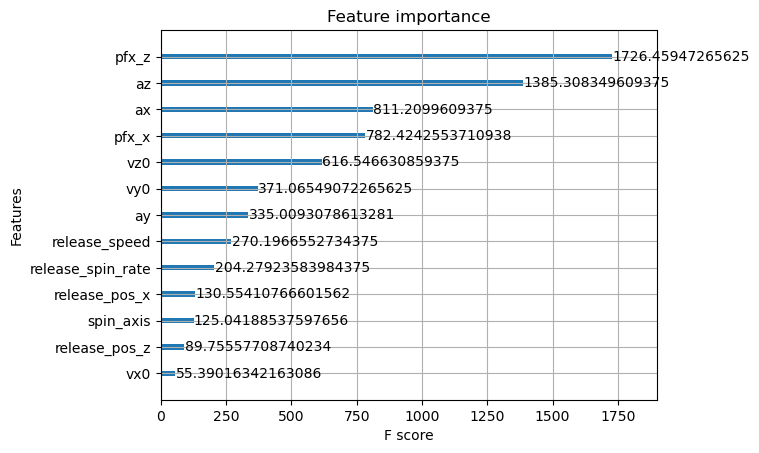

In [41]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

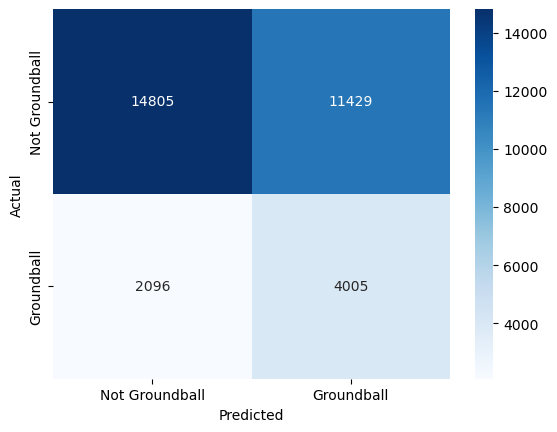

In [43]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [44]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [45]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [46]:
y_pred = final_model.predict(predictions)

In [47]:
testing_identifiers['xgb'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_21600\1805931578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xgb'] = y_pred


In [37]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/gb_2022&3_xgb.csv")

# Offspeed Model 

In [38]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


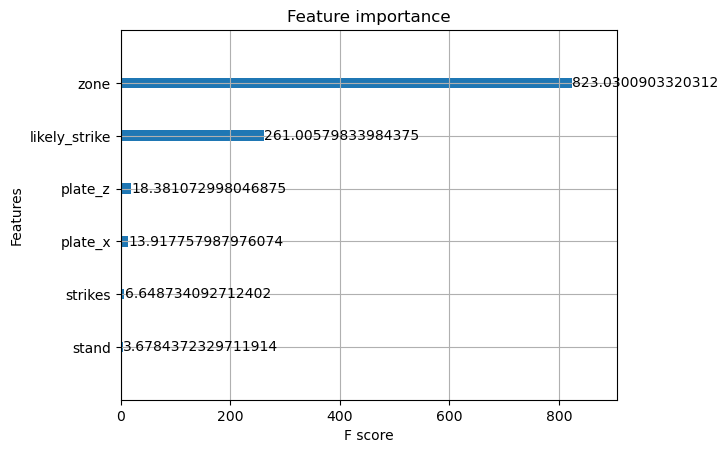

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

half_inning  Unnamed: 1 pitch_type   game_date  release_speed  \
1   716352_1_Bot           8         SI  2023-10-01           93.5   
11  716352_2_Bot          46         FF  2023-10-01           93.5   
28  716352_4_Bot         111         FF  2023-10-01           92.9   
37  716352_4_Bot          87         SI  2023-10-01           92.2   
39  716352_4_Top         115         SI  2023-10-01           90.1   

    release_pos_x  release_pos_z    player_name  batter  pitcher  ...  \
1           -2.60           5.68  King, Michael  677951   650633  ...   
11          -2.82           5.71  King, Michael  669004   650633  ...   
28          -2.66           5.89  King, Michael  669004   650633  ...   
37          -2.76           5.67  King, Michael  672580   650633  ...   
39          -1.27           6.14  Greinke, Zack  643396   425844  ...   

     deltaRE is_strike  pitch_type_dict  likely_strike  prediction  \
1  -0.028510         1              1.0              0    0.781290   
11 -0.038179         1              1.0              0    0.495411   
28 -0.038179         1              1.0              0    0.782323   
37 -0.111258         1              1.0              0    0.813712   
39 -0.043952         1              1.0              0    0.584764   

    probability_added  Unnamed: 0  mlb_id        mlb_name  team_name  
1            0.218710        4412  669224    Austin Wells    yankees  
11           0.504589        4412  669224    Austin Wells    yankees  
28           0.217677        4412  669224    Austin Wells    yankees  
37           0.186288        4412  669224    Austin Wells    yankees  
39           0.415236        1898  521692  Salvador Perez     royals  

[5 rows x 113 columns]

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches